In [ ]:
# Download data from DL and save a csv file with filename, identifier, scientificName, CommonName, and Comments columns

## Note that you might have to download in segments because of discover life black listing ip addresses
import os
import requests
from bs4 import BeautifulSoup
import csv

# Function to download an image
def download_image(url, folder, filename):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        filepath = os.path.join(folder, filename)
        with open(filepath, 'wb') as file:
            for chunk in response.iter_content(1024):
                file.write(chunk)
        return filepath
    return None

# Configurables
output_folder = "/Users/markfisher/Desktop/cr_moth_classification/1_dataset_prep/ciee_monte_verde_dataset/cr_images"
csv_filename = "fisher_image_data.csv"
photoAuthorCode = "I_MFS"
baseDownloadUrl = f"https://www.discoverlife.org/mp/20p?res=640&see={photoAuthorCode}/"


# Define the folder for saving images
os.makedirs(output_folder, exist_ok=True)

# Prepare CSV file
csv_headers = ["Filename", "Identifier", "scientificName", "CommonName", "Comments"]

# Open the CSV file once and manage it across all iterations
with open(csv_filename, "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(csv_headers)  # Write headers only once

# Loop through the URLs
# for pageNum in range(0, 359):
for pageNum in range(118, 164): # Note that I had to do this in subsections to get all of the data
    url = f"{baseDownloadUrl}{pageNum:04}&flags=col9:"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Append rows to the CSV file
    with open(csv_filename, "a", newline="", encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile)

        # Parse the HTML to find image entries
        for td in soup.find_all("td", valign="top"):
            img_tag = td.find("img")
            if img_tag and "src" in img_tag.attrs:
                img_src = img_tag["src"]
                img_url = f"https://www.discoverlife.org{img_src}"
                filename = os.path.basename(img_src)

                # Download the image
                download_image(img_url, output_folder, filename)

                # Extract text elements (identifier, scientific name, common name, comments)
                text_elements = td.find_all(string=True)
                text_values = [text.strip() for text in text_elements if text.strip()]

                # Ensure exactly 4 columns (fill with None if missing)
                while len(text_values) < 4:
                    text_values.append(None)

                # Write the data row to CSV
                writer.writerow([filename] + text_values[:4])

    print(f"Processed page {pageNum:04}: Images downloaded and data appended to '{csv_filename}'.")

print(f"All pages processed. Images saved to '{output_folder}' and metadata saved to '{csv_filename}'.")


In [ ]:
# Combine all of the target csvs generated from the above download runs

import os
import pandas as pd

# Specify the directory containing the CSV files
input_directory = "/Users/markfisher/Desktop/cr_moth_classification/1_dataset_prep/ciee_monte_verde_dataset/scraped_image_data/"  # Change this to the path where your CSV files are stored
output_file = "combined_output.csv"  # Name of the output file

# Get a list of all CSV files in the directory
csv_files = [file for file in os.listdir(input_directory) if file.endswith('.csv')]

# Combine the CSV files
combined_df = pd.DataFrame()
for csv_file in csv_files:
    file_path = os.path.join(input_directory, csv_file)
    df = pd.read_csv(file_path)
    combined_df = pd.concat([combined_df, df], ignore_index=True)

# Save the combined data to a new CSV file
combined_df.to_csv(output_file, index=False)

print(f"Combined {len(csv_files)} files into {output_file}")


In [ ]:
# Get all unique sciNames from the combined csv file above

## This is only needed when creating the initial classification training data. Creates and de-dupes the scientificName column

import pandas as pd

# Specify the input CSV file
input_file = "combined_output.csv"  # Change this to your input CSV file
output_file = "unique_values_output.csv"  # Name of the output file

# Specify the column name to extract unique values from
target_column = "scientificName"  # Replace with the actual column name you want to target

try:
    # Read the input CSV file
    df = pd.read_csv(input_file)

    # Check if the target column exists
    if target_column not in df.columns:
        raise ValueError(f"Column '{target_column}' not found in the input file.")

    # Extract unique values from the target column
    unique_values = df[target_column].drop_duplicates().reset_index(drop=True)

    # Save the unique values to a new CSV file
    unique_values.to_csv(output_file, index=False, header=[target_column])

    print(f"Unique values from column '{target_column}' have been written to {output_file}")

except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# Run the GBIF tool https://www.gbif.org/tools/species-lookup. Drop that unique_values_output.csv file in the drop in. Click the "Generate CSV" button in the bottom right as it appears. 

## E.g.

In [3]:
!pip install tabulate

In [4]:
import pandas as pd
from IPython.display import Markdown

df = pd.read_csv("/Users/markfisher/Desktop/cr_moth_classification/1_dataset_prep/ciee_monte_verde_dataset/normalized.csv")
markdown_table = df.to_markdown(index=False)
display(Markdown(markdown_table))

|   occurrenceId | verbatimScientificName                      | scientificName                                   |            key | matchType   |   confidence | status   | rank    | kingdom   | phylum        | class          | order           | family         | genus          | species                     | canonicalName               | authorship                   |       usageKey |   acceptedUsageKey |
|---------------:|:--------------------------------------------|:-------------------------------------------------|---------------:|:------------|-------------:|:---------|:--------|:----------|:--------------|:---------------|:----------------|:---------------|:---------------|:----------------------------|:----------------------------|:-----------------------------|---------------:|-------------------:|
|            nan | Lobocleta tenellata                         | Lobocleta tenellata (Möschler, 1886)             |    1.99026e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Lobocleta      | Lobocleta tenellata         | Lobocleta tenellata         | (Möschler, 1886)             |    1.99026e+06 |      nan           |
|            nan | moth Notodontidae                           | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Iridopsis lurida--oberthuri--herse          | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Clemensia leopardina                        | Clemensia leopardina Schaus, 1911                |    5.1149e+06  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Clemensia      | Clemensia leopardina        | Clemensia leopardina        | Schaus, 1911                 |    5.1149e+06  |      nan           |
|            nan | Rhabdatomis laudamia                        | Rhabdatomis laudamia Druce, 1885                 |    1.81126e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Rhabdatomis    | Rhabdatomis laudamia        | Rhabdatomis laudamia        | Druce, 1885                  |    1.81126e+06 |      nan           |
|            nan | Eupithecia sp_group_san_luis                | Eupithecia Curtis, 1825                          |    1.98237e+06 | HIGHERRANK  |           92 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eupithecia     | nan                         | Eupithecia                  | Curtis, 1825                 |    1.98237e+06 |      nan           |
|            nan | Crambidia myrlosea                          | Crambidia myrlosea Dyar, 1917                    |    1.80554e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Crambidia      | Crambidia myrlosea          | Crambidia myrlosea          | Dyar, 1917                   |    1.80554e+06 |      nan           |
|            nan | Leptostales crossii                         | Leptostales crossii (Hulst, 1900)                |    9.61909e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Leptostales    | Leptostales crossii         | Leptostales crossii         | (Hulst, 1900)                |    9.61909e+06 |      nan           |
|            nan | moth                                        | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Meganola sp_san_luis_b                      | Meganola Dyar, 1898                              |    4.40549e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Nolidae        | Meganola       | nan                         | Meganola                    | Dyar, 1898                   |    4.40549e+06 |      nan           |
|            nan | moth Crambidae                              | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Nephodia auxesia                            | Nephodia auxesia Druce, 1892                     |    1.98148e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nephodia       | Nephodia auxesia            | Nephodia auxesia            | Druce, 1892                  |    1.98148e+06 |      nan           |
|            nan | moth Hemiceras                              | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Nemoria defectiva                           | Nemoria defectiva (Prout, 1932)                  |    1.98126e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nemoria        | Nemoria defectiva           | Nemoria defectiva           | (Prout, 1932)                |    1.98126e+06 |      nan           |
|            nan | Nematocampa arenosa                         | Nematocampa arenosa Butler, 1881                 |    1.99101e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nematocampa    | Nematocampa arenosa         | Nematocampa arenosa         | Butler, 1881                 |    1.99101e+06 |      nan           |
|            nan | moth Lascoria                               | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | moth Tortricidae                            | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Patalene aenetusaria                        | Patalene aenetusaria (Walker, 1860)              |    9.24326e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Patalene       | Patalene aenetusaria        | Patalene aenetusaria        | (Walker, 1860)               |    9.24326e+06 |      nan           |
|            nan | Clemensia cincinnata                        | Clemensia cincinnata Schaus, 1911                |    5.11488e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Clemensia      | Clemensia cincinnata        | Clemensia cincinnata        | Schaus, 1911                 |    5.11488e+06 |      nan           |
|            nan | Brachurapteryx tesserata                    | Brachurapteryx tesserata (Guenée)                |    1.95582e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Brachurapteryx | Brachurapteryx tesserata    | Brachurapteryx tesserata    | (Guenée)                     |    1.95582e+06 |      nan           |
|            nan | Crambidia cephalica                         | Crambidia cephalica (Grote & Robinson, 1870)     |    1.80554e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Crambidia      | Crambidia cephalica         | Crambidia cephalica         | (Grote & Robinson, 1870)     |    1.80554e+06 |      nan           |
|            nan | moth Geometridae                            | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | moth Noctuidae                              | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Glena mopsaria                              | Glena mopsaria (Schaus, 1913)                    |    1.96568e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Glena          | Glena mopsaria              | Glena mopsaria              | (Schaus, 1913)               |    1.96568e+06 |      nan           |
|            nan | Iridopsis validaria                         | Iridopsis validaria Guenée, 1858                 |    5.14859e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Iridopsis      | Iridopsis validaria         | Iridopsis validaria         | Guenée, 1858                 |    5.14859e+06 |      nan           |
|            nan | Micrathetis dasarada                        | Micrathetis dasarada Druce, 1898                 |    1.76469e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Micrathetis    | Micrathetis dasarada        | Micrathetis dasarada        | Druce, 1898                  |    1.76469e+06 |      nan           |
|            nan | Macaria sp_san_luis_a                       | Arthropoda                                       |   54           | HIGHERRANK  |           92 | ACCEPTED | PHYLUM  | Animalia  | Arthropoda    | nan            | nan             | nan            | nan            | nan                         | Arthropoda                  | nan                          |   54           |      nan           |
|            nan | Idaea sp_group_san_luis                     | Idaea Treitschke, 1825                           |    1.97391e+06 | HIGHERRANK  |           92 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Idaea          | nan                         | Idaea                       | Treitschke, 1825             |    1.97391e+06 |      nan           |
|            nan | Cell phone                                  | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | light                                       | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | moth Megalopygidae - Limacodidae            | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | moth plume                                  | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Lophosis labeculata                         | Lophosis labeculata (Hulst, 1887)                |    9.23703e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Lophosis       | Lophosis labeculata         | Lophosis labeculata         | (Hulst, 1887)                |    9.23703e+06 |      nan           |
|            nan | Trygodes amphion                            | Trygodes amphion Schaus, 1912                    |    1.97636e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Trygodes       | Trygodes amphion            | Trygodes amphion            | Schaus, 1912                 |    1.97636e+06 |      nan           |
|            nan | moth Pyralidae                              | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | moth emerald                                | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Afrida ydatodes                             | Afrida ydatodes Dyar, 1913                       |    8.92451e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Nolidae        | Afrida         | Afrida ydatodes             | Afrida ydatodes             | Dyar, 1913                   |    8.92451e+06 |      nan           |
|            nan | Meganola bifiliferata                       | Meganola bifiliferata (Walker, 1863)             |    8.12684e+06 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Nolidae        | Nola           | Nola bifiliferata           | Meganola bifiliferata       | (Walker, 1863)               |    8.12684e+06 |        1.17082e+07 |
|            nan | Clemensia brunneomedia                      | Clemensia brunneomedia Schaus, 1905              |    5.11486e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Clemensia      | Clemensia brunneomedia      | Clemensia brunneomedia      | Schaus, 1905                 |    5.11486e+06 |      nan           |
|            nan | Eucereon xanthoperas                        | Eucereon xanthoperas Hampson, 1898               |    1.81031e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | Eucereon xanthoperas        | Eucereon xanthoperas        | Hampson, 1898                |    1.81031e+06 |      nan           |
|            nan | Eucereon rosinum                            | Eucereon rosina Walker, 1854                     |    1.81028e+06 | FUZZY       |           95 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | Eucereon rosina             | Eucereon rosina             | Walker, 1854                 |    1.81028e+06 |      nan           |
|            nan | Pheia elegans                               | Pheia elegans Druce, 1884                        |    1.81151e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Pheia          | Pheia elegans               | Pheia elegans               | Druce, 1884                  |    1.81151e+06 |      nan           |
|            nan | Idaea subfervens                            | Idaea subfervens (Prout, 1920)                   |    5.14703e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Idaea          | Idaea subfervens            | Idaea subfervens            | (Prout, 1920)                |    5.14703e+06 |      nan           |
|            nan | Hymenia perspectalis                        | Hymenia perspectalis (Hübner, 1796)              |    1.88637e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Hymenia        | Hymenia perspectalis        | Hymenia perspectalis        | (Hübner, 1796)               |    1.88637e+06 |      nan           |
|            nan | insect                                      | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Gn sp_san_luis_1013                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Metanema bonadea                            | Metanema bonadea Druce, 1892                     |    5.14962e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Metanema       | Metanema bonadea            | Metanema bonadea            | Druce, 1892                  |    5.14962e+06 |      nan           |
|            nan | moth Palthis                                | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Nematocampa completa                        | Nematocampa completa Warren, 1904                |    1.99102e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nematocampa    | Nematocampa completa        | Nematocampa completa        | Warren, 1904                 |    1.99102e+06 |      nan           |
|            nan | Elaphria subobliqua                         | Elaphria subobliqua Walker, 1858                 |    1.78041e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Elaphria       | Elaphria subobliqua         | Elaphria subobliqua         | Walker, 1858                 |    1.78041e+06 |      nan           |
|            nan | Nemoria vermiculata                         | Nemoria vermiculata (Dognin, 1914)               |    1.98117e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nemoria        | Nemoria vermiculata         | Nemoria vermiculata         | (Dognin, 1914)               |    1.98117e+06 |      nan           |
|            nan | Epimecis matronaria--nasica                 | Epimecis Hübner                                  |    1.98558e+06 | HIGHERRANK  |           92 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Epimecis       | nan                         | Epimecis                    | Hübner                       |    1.98558e+06 |      nan           |
|            nan | Macaria approximaria--gambarina--ostia      | Arthropoda                                       |   54           | HIGHERRANK  |           92 | ACCEPTED | PHYLUM  | Animalia  | Arthropoda    | nan            | nan             | nan            | nan            | nan                         | Arthropoda                  | nan                          |   54           |      nan           |
|            nan | Synnomos sp_san_luis_a                      | Synnomos Guenée                                  |    1.96363e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Synnomos       | nan                         | Synnomos                    | Guenée                       |    1.96363e+06 |      nan           |
|            nan | moth Arctiidae                              | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Euphyia sp_group_san_luis                   | Euphyia Hübner                                   |    1.96512e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Euphyia        | nan                         | Euphyia                     | Hübner                       |    1.96512e+06 |      nan           |
|            nan | Bryolymnia roma                             | Bryolymnia roma Druce, 1894                      |    1.76415e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Bryolymnia     | Bryolymnia roma             | Bryolymnia roma             | Druce, 1894                  |    1.76415e+06 |      nan           |
|            nan | Hampsonodes mastoides                       | Hampsonodes mastoides Hampson, 1910              |    1.79133e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Hampsonodes    | Hampsonodes mastoides       | Hampsonodes mastoides       | Hampson, 1910                |    1.79133e+06 |      nan           |
|            nan | Microxydia ruficomma                        | Microxydia ruficomma Prout, 1910                 |    1.95425e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Microxydia     | Microxydia ruficomma        | Microxydia ruficomma        | Prout, 1910                  |    1.95425e+06 |      nan           |
|            nan | Hypercompe nemophila                        | Hypercompe nemophila Herrich-Schäffer, 1853      |    1.81098e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hypercompe     | Hypercompe nemophila        | Hypercompe nemophila        | Herrich-Schäffer, 1853       |    1.81098e+06 |      nan           |
|            nan | Synchlora astraeoides                       | Synchlora astraeoides (Warren, 1901)             |    1.96209e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Synchlora      | Synchlora astraeoides       | Synchlora astraeoides       | (Warren, 1901)               |    1.96209e+06 |      nan           |
|            nan | moth Mocis                                  | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Oospila venezuelata                         | Oospila venezuelata (Walker, 1861)               |    1.97366e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Oospila        | Oospila venezuelata         | Oospila venezuelata         | (Walker, 1861)               |    1.97366e+06 |      nan           |
|            nan | Idalus perlineosa                           | Idalus perlineosa Rothschild, 1917               |    1.81468e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Idalus         | Idalus perlineosa           | Idalus perlineosa           | Rothschild, 1917             |    1.81468e+06 |      nan           |
|            nan | Dycladia emerita                            | Dycladia emerita                                 |    9.11168e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Dycladia       | Dycladia emerita            | Dycladia emerita            | nan                          |    9.11168e+06 |      nan           |
|            nan | moth new species                            | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Melese monima                               | Melese monima Schaus, 1910                       |    1.81758e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Melese         | Melese monima               | Melese monima               | Schaus, 1910                 |    1.81758e+06 |      nan           |
|            nan | Eubaphe unicolor                            | Eubaphe unicolor (Robinson, 1869)                |    1.98595e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eubaphe        | Eubaphe unicolor            | Eubaphe unicolor            | (Robinson, 1869)             |    1.98595e+06 |      nan           |
|            nan | Melese laodamia                             | Melese laodamia Druce, 1884                      |    1.81759e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Melese         | Melese laodamia             | Melese laodamia             | Druce, 1884                  |    1.81759e+06 |      nan           |
|            nan | Nephodia betala                             | Nephodia betala (Druce, 1892)                    |    1.98166e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nephodia       | Nephodia betala             | Nephodia betala             | (Druce, 1892)                |    1.98166e+06 |      nan           |
|            nan | moth Sphingidae                             | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Elaphria hyposcota                          | Elaphria hyposcota Hampson, 1909                 |    1.78031e+06 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Elaphria       | Elaphria hypophaea          | Elaphria hyposcota          | Hampson, 1909                |    1.78031e+06 |        1.78035e+06 |
|            nan | Thysanopyga carfinia                        | Thysanopyga carfinia (Druce, 1893)               |    1.95838e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Thysanopyga    | Thysanopyga carfinia        | Thysanopyga carfinia        | (Druce, 1893)                |    1.95838e+06 |      nan           |
|            nan | Scena potentia                              | Scena potentia Druce, 1894                       |    1.80452e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Scena          | Scena potentia              | Scena potentia              | Druce, 1894                  |    1.80452e+06 |      nan           |
|            nan | Aclytia heber                               | Aclytia heber Cramer, 1782                       |    5.11505e+06 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Aclytia        | Aclytia heber               | Aclytia heber               | Cramer, 1782                 |    5.11505e+06 |      nan           |
|            nan | Feltia subterranea                          | Feltia subterranea Fabricius, 1794               |    7.40081e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Feltia         | Feltia subterranea          | Feltia subterranea          | Fabricius, 1794              |    7.40081e+06 |      nan           |
|            nan | Gonodes liquida                             | Gonodes liquida Möschler, 1886                   |    1.77493e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Gonodes        | Gonodes liquida             | Gonodes liquida             | Möschler, 1886               |    1.77493e+06 |      nan           |
|            nan | Eois sp_san_luis_s                          | Eois Hübner, 1818                                |    1.98961e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eois           | nan                         | Eois                        | Hübner, 1818                 |    1.98961e+06 |      nan           |
|            nan | Neotherina imperilla                        | Neotherina imperilla (Dognin, 1911)              |    1.99135e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Neotherina     | Neotherina imperilla        | Neotherina imperilla        | (Dognin, 1911)               |    1.99135e+06 |      nan           |
|            nan | Gn sp_san_luis_1011                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Lomographa argentata                        | Lomographa argentata (Schaus, 1911)              |    1.98608e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Lomographa     | Lomographa argentata        | Lomographa argentata        | (Schaus, 1911)               |    1.98608e+06 |      nan           |
|            nan | Gn sp_san_luis_1005                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Simopteryx torquataria                      | Simopteryx torquataria (Walker, 1860)            |    1.9769e+06  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Simopteryx     | Simopteryx torquataria      | Simopteryx torquataria      | (Walker, 1860)               |    1.9769e+06  |      nan           |
|            nan | moth Saturniidae                            | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Synchlora gerularia                         | Synchlora gerularia (Hübner)                     |    1.96212e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Synchlora      | Synchlora gerularia         | Synchlora gerularia         | (Hübner)                     |    1.96212e+06 |      nan           |
|            nan | Synchlora dependens                         | Synchlora dependens (Warren, 1904)               |    1.96208e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Synchlora      | Synchlora dependens         | Synchlora dependens         | (Warren, 1904)               |    1.96208e+06 |      nan           |
|            nan | Eois sp_san_luis_b                          | Eois Hübner, 1818                                |    1.98961e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eois           | nan                         | Eois                        | Hübner, 1818                 |    1.98961e+06 |      nan           |
|            nan | Clemensia sp_san_luis_a                     | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Simena luctifera                            | Simena luctifera Walker, 1856                    |    1.96589e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Simena         | Simena luctifera            | Simena luctifera            | Walker, 1856                 |    1.96589e+06 |      nan           |
|            nan | Epimecis semicompleta                       | Epimecis semicompleta (Warren, 1905)             |    5.14924e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Epimecis       | Epimecis semicompleta       | Epimecis semicompleta       | (Warren, 1905)               |    5.14924e+06 |      nan           |
|            nan | Antiblemma pira                             | Antiblemma pira                                  |    1.79467e+06 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Antiblemma     | Antiblemma pira             | Antiblemma pira             | nan                          |    1.79467e+06 |      nan           |
|            nan | Gn sp_san_luis_1003                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Anisoperas atropunctaria                    | Anisoperas atropunctaria (Walker, 1862)          |    1.98675e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Anisoperas     | Anisoperas atropunctaria    | Anisoperas atropunctaria    | (Walker, 1862)               |    1.98675e+06 |      nan           |
|            nan | Dyspteris tenuivitta                        | Dyspteris tenuivitta Dognin, 1908                |    1.96135e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Dyspteris      | Dyspteris tenuivitta        | Dyspteris tenuivitta        | Dognin, 1908                 |    1.96135e+06 |      nan           |
|            nan | Macaria abydata--nundinata                  | Arthropoda                                       |   54           | HIGHERRANK  |           92 | ACCEPTED | PHYLUM  | Animalia  | Arthropoda    | nan            | nan             | nan            | nan            | nan                         | Arthropoda                  | nan                          |   54           |      nan           |
|            nan | Anycles adusta                              | Anycles adusta Felder, 1869                      |    1.80728e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Anycles        | Anycles adusta              | Anycles adusta              | Felder, 1869                 |    1.80728e+06 |      nan           |
|            nan | Napata lelex                                | Napata lelex                                     |    1.02778e+07 | EXACT       |           97 | DOUBTFUL | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Uranophora     | Napata lelex                | Napata lelex                | nan                          |    1.02778e+07 |      nan           |
|            nan | Opisthoxia miletia                          | Opisthoxia miletia (Druce, 1892)                 |    1.96026e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Opisthoxia     | Opisthoxia miletia          | Opisthoxia miletia          | (Druce, 1892)                |    1.96026e+06 |      nan           |
|            nan | moth Pyraidae                               | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | moth merald                                 | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Ametris nitocris                            | Ametris nitocris (Cramer)                        |    1.95964e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Ametris        | Ametris nitocris            | Ametris nitocris            | (Cramer)                     |    1.95964e+06 |      nan           |
|            nan | Hagnagora sp_san_luis                       | Hagnagora Druce, 1885                            |    1.97824e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Hagnagora      | nan                         | Hagnagora                   | Druce, 1885                  |    1.97824e+06 |      nan           |
|            nan | Periclina sp_san_luis_a                     | Periclina Guenée                                 |    1.96854e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Periclina      | nan                         | Periclina                   | Guenée                       |    1.96854e+06 |      nan           |
|            nan | Nematocampa c                               | Nematocampa Guenée                               |    1.991e+06   | EXACT       |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nematocampa    | nan                         | Nematocampa                 | Guenée                       |    1.991e+06   |      nan           |
|            nan | moth Herbita                                | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Macrocneme iole                             | Macrocneme iole Druce, 1884                      |    1.80519e+06 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Macrocneme     | Macrocneme chrysitis        | Macrocneme iole             | Druce, 1884                  |    1.80519e+06 |        1.8052e+06  |
|            nan | Isogona continua--natatrix                  | Isogona Guenée, 1852                             |    1.79093e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Isogona        | nan                         | Isogona                     | Guenée, 1852                 |    1.79093e+06 |      nan           |
|            nan | Lichnoptera illudens                        | Lichnoptera illudens Walker, 1856                |    1.8001e+06  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Lichnoptera    | Lichnoptera illudens        | Lichnoptera illudens        | Walker, 1856                 |    1.8001e+06  |      nan           |
|            nan | moth Noctuidae delta                        | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Nepheloleuca illiturata                     | Nepheloleuca illiturata (Guenée, 1858)           |    1.98958e+06 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nepheloleuca   | Nepheloleuca politia        | Nepheloleuca illiturata     | (Guenée, 1858)               |    1.98958e+06 |        1.14625e+07 |
|            nan | Nemoria pescadora                           | Nemoria pescadora (Beutelspacher-Baigts, 1984)   |    1.98131e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nemoria        | Nemoria pescadora           | Nemoria pescadora           | (Beutelspacher-Baigts, 1984) |    1.98131e+06 |      nan           |
|            nan | Scopula sp_group_san_luis                   | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Semaeopus viridiplaga                       | Semaeopus viridiplaga (Walker, 1861)             |    1.95614e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Semaeopus      | Semaeopus viridiplaga       | Semaeopus viridiplaga       | (Walker, 1861)               |    1.95614e+06 |      nan           |
|            nan | Nola sp_san_luis_a                          | Nola Leach, 1815                                 |    1.80176e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Nolidae        | Nola           | nan                         | Nola                        | Leach, 1815                  |    1.80176e+06 |      nan           |
|            nan | Oxydia trychiata                            | Oxydia trychiata Guenée                          |    1.97675e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Oxydia         | Oxydia trychiata            | Oxydia trychiata            | Guenée                       |    1.97675e+06 |      nan           |
|            nan | moth Melese                                 | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Eucereon tigrata                            | Eucereon tigrata Herrich-Schäffer, 1855          |    1.81017e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | Eucereon tigrata            | Eucereon tigrata            | Herrich-Schäffer, 1855       |    1.81017e+06 |      nan           |
|            nan | Lophocampa citrina                          | Lophocampa citrina Sepp, 1852                    |    1.81776e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Lophocampa     | Lophocampa citrina          | Lophocampa citrina          | Sepp, 1852                   |    1.81776e+06 |      nan           |
|            nan | moth Hydata                                 | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Amastus aconia                              | Amastus aconia Herrich-Schäffer, 1853            |    5.11735e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Amastus        | Amastus aconia              | Amastus aconia              | Herrich-Schäffer, 1853       |    5.11735e+06 |      nan           |
|            nan | Antiblemma concinnula                       | Antiblemma concinnula Walker, 1865               |    1.79464e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Antiblemma     | Antiblemma concinnula       | Antiblemma concinnula       | Walker, 1865                 |    1.79464e+06 |      nan           |
|            nan | Spragueia lepus                             | Spragueia Grote, 1875                            |    1.75876e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Spragueia      | nan                         | Spragueia                   | Grote, 1875                  |    1.75876e+06 |      nan           |
|            nan | Hyponerita tipolis                          | Hyponerita tipolis Druce, 1896                   |    1.80862e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hyponerita     | Hyponerita tipolis          | Hyponerita tipolis          | Druce, 1896                  |    1.80862e+06 |      nan           |
|            nan | moth todo                                   | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Episcepsis thetis                           | Episcepsis thetis                                |    1.21865e+07 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Episcepsis     | Episcepsis thetis           | Episcepsis thetis           | nan                          |    1.21865e+07 |      nan           |
|            nan | Hypercompe icasia                           | Hypercompe icasia Cramer, 1777                   |    1.81112e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hypercompe     | Hypercompe icasia           | Hypercompe icasia           | Cramer, 1777                 |    1.81112e+06 |      nan           |
|            nan | Hampsonodes melagona                        | Hampsonodes melagona Hampson, 1910               |    1.79132e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Hampsonodes    | Hampsonodes melagona        | Hampsonodes melagona        | Hampson, 1910                |    1.79132e+06 |      nan           |
|            nan | moth Pyalidae                               | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Ramphia albizona                            | Ramphia albizona Latreille, 1817                 |    1.7675e+06  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Ramphia        | Ramphia albizona            | Ramphia albizona            | Latreille, 1817              |    1.7675e+06  |      nan           |
|            nan | Nemoria eugeniae                            | Nemoria eugeniae Pitkin, 1993                    |    1.98121e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nemoria        | Nemoria eugeniae            | Nemoria eugeniae            | Pitkin, 1993                 |    1.98121e+06 |      nan           |
|            nan | Procalypta victorina                        | Procalypta victorina Druce, 1884                 |    1.81249e+06 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Procalypta     | Procalypta subcyanea        | Procalypta victorina        | Druce, 1884                  |    1.81249e+06 |        1.81249e+06 |
|            nan | Itomia opistographa--lignaris               | Itomia Hübner, 1823                              |    4.68824e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Itomia         | nan                         | Itomia                      | Hübner, 1823                 |    4.68824e+06 |      nan           |
|            nan | Thysanoprymna superba                       | Thysanoprymna superba Schaus, 1889               |    1.81529e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Thysanoprymna  | Thysanoprymna superba       | Thysanoprymna superba       | Schaus, 1889                 |    1.81529e+06 |      nan           |
|            nan | Macaria tenuiscripta--trigonata             | Arthropoda                                       |   54           | HIGHERRANK  |           92 | ACCEPTED | PHYLUM  | Animalia  | Arthropoda    | nan            | nan             | nan            | nan            | nan                         | Arthropoda                  | nan                          |   54           |      nan           |
|            nan | Dichorda obliquata                          | Dichorda obliquata Warren, 1904                  |    1.98025e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Dichorda       | Dichorda obliquata          | Dichorda obliquata          | Warren, 1904                 |    1.98025e+06 |      nan           |
|            nan | Xenosoma flavicedes                         | Xenosoma flavisedes Dognin, 1891                 |    5.11637e+06 | FUZZY       |           94 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Xenosoma       | Xenosoma flavisedes         | Xenosoma flavisedes         | Dognin, 1891                 |    5.11637e+06 |      nan           |
|            nan | Herbita amicaria                            | Herbita amicaria (Schaus, 1912)                  |    1.97641e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Herbita        | Herbita amicaria            | Herbita amicaria            | (Schaus, 1912)               |    1.97641e+06 |      nan           |
|            nan | Opharus bimaculata                          | Opharus bimaculata Dewitz, 1877                  |    5.11765e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Opharus        | Opharus bimaculata          | Opharus bimaculata          | Dewitz, 1877                 |    5.11765e+06 |      nan           |
|            nan | Hyalurga sora                               | Hyalurga sora Boisduval, 1870                    |    1.8042e+06  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hyalurga       | Hyalurga sora               | Hyalurga sora               | Boisduval, 1870              |    1.8042e+06  |      nan           |
|            nan | moth Gelechiidae Dichomeris                 | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Melanolophia sp_san_luis                    | Melanolophia Hulst, 1896                         |    1.9627e+06  | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Melanolophia   | nan                         | Melanolophia                | Hulst, 1896                  |    1.9627e+06  |      nan           |
|            nan | Cliniodes opalalis                          | Cliniodes opalalis Guenée, 1854                  |    1.89128e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Cliniodes      | Cliniodes opalalis          | Cliniodes opalalis          | Guenée, 1854                 |    1.89128e+06 |      nan           |
|            nan | Eois sp_san_luis_f                          | Eois Hübner, 1818                                |    1.98961e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eois           | nan                         | Eois                        | Hübner, 1818                 |    1.98961e+06 |      nan           |
|            nan | moth misc macro                             | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Hygrochroma nondina                         | Hygrochroma nondina Druce, 1892                  |    5.14433e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Hygrochroma    | Hygrochroma nondina         | Hygrochroma nondina         | Druce, 1892                  |    5.14433e+06 |      nan           |
|            nan | Leucanopsis longa                           | Leucanopsis longa Grote, 1880                    |    1.81002e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Leucanopsis    | Leucanopsis longa           | Leucanopsis longa           | Grote, 1880                  |    1.81002e+06 |      nan           |
|            nan | Crinodes schausi                            | Crinodes schausi Rothschild, 1917                |    1.82419e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | Crinodes       | Crinodes schausi            | Crinodes schausi            | Rothschild, 1917             |    1.82419e+06 |      nan           |
|            nan | Oospila athena                              | Oospila athena (Druce, 1892)                     |    1.97364e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Oospila        | Oospila athena              | Oospila athena              | (Druce, 1892)                |    1.97364e+06 |      nan           |
|            nan | Symphlebia herbosa                          | Symphlebia herbosa Schaus, 1910                  |    1.80528e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Symphlebia     | Symphlebia herbosa          | Symphlebia herbosa          | Schaus, 1910                 |    1.80528e+06 |      nan           |
|            nan | Megaloptera                                 | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Hymenomima umbelularia                      | Hymenomima umbelularia (Hübner)                  |    1.97586e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Hymenomima     | Hymenomima umbelularia      | Hymenomima umbelularia      | (Hübner)                     |    1.97586e+06 |      nan           |
|            nan | Phrudocentra opaca                          | Phrudocentra opaca (Butler, 1881)                |    1.98502e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Phrudocentra   | Phrudocentra opaca          | Phrudocentra opaca          | (Butler, 1881)               |    1.98502e+06 |      nan           |
|            nan | moth Xylophanes                             | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Amaxia apyga                                | Amaxia apyga Hampson, 1901                       |    1.81404e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Amaxia         | Amaxia apyga                | Amaxia apyga                | Hampson, 1901                |    1.81404e+06 |      nan           |
|            nan | Leucotmemis nexa                            | Leucotmemis nexa Herrich-Schäffer, 1854          |    1.81709e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Leucotmemis    | Leucotmemis nexa            | Leucotmemis nexa            | Herrich-Schäffer, 1854       |    1.81709e+06 |      nan           |
|            nan | Hemiceras vecina                            | Hemiceras vecina Schaus, 1901                    |    5.11871e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | Hemiceras      | Hemiceras vecina            | Hemiceras vecina            | Schaus, 1901                 |    5.11871e+06 |      nan           |
|            nan | Eucereon aroa                               | Eucereon aroa Schaus, 1894                       |    1.81022e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | Eucereon aroa               | Eucereon aroa               | Schaus, 1894                 |    1.81022e+06 |      nan           |
|            nan | Phalaenophana pyramusalis                   | Phalaenophana pyramusalis (Walker, 1859)         |    9.34294e+06 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Phaeolita      | Phaeolita pyramusalis       | Phalaenophana pyramusalis   | (Walker, 1859)               |    9.34294e+06 |        1.79083e+06 |
|            nan | Natada fusca                                | Natada fusca (Druce, 1887)                       |    1.75366e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Limacodidae    | Natada         | Natada fusca                | Natada fusca                | (Druce, 1887)                |    1.75366e+06 |      nan           |
|            nan | Dysschema mariamne                          | Dysschema mariamne Geyer, 1838                   |    5.11742e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Dysschema      | Dysschema mariamne          | Dysschema mariamne          | Geyer, 1838                  |    5.11742e+06 |      nan           |
|            nan | Herminodes sp_san_luis_a                    | Herminodes Guenée, 1852                          |    4.6962e+06  | HIGHERRANK  |           94 | SYNONYM  | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Scolecocampa   | nan                         | Herminodes                  | Guenée, 1852                 |    4.6962e+06  |        1.76518e+06 |
|            nan | Paragonia cruraria                          | Paragonia cruraria (Herrich-Schäffer)            |    5.14436e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Paragonia      | Paragonia cruraria          | Paragonia cruraria          | (Herrich-Schäffer)           |    5.14436e+06 |      nan           |
|            nan | moth Macrodes                               | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Afrida sp_san_luis_a                        | Afrida Möschler, 1886                            |    1.80216e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Nolidae        | Afrida         | nan                         | Afrida                      | Möschler, 1886               |    1.80216e+06 |      nan           |
|            nan | Microphysetica hermeasalis                  | Microphysetica hermeasalis                       |    1.04394e+07 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Microphysetica | Microphysetica hermeasalis  | Microphysetica hermeasalis  | nan                          |    1.04394e+07 |      nan           |
|            nan | Talara mona                                 | Talara mona Dyar, 1914                           |    1.81477e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Talara         | Talara mona                 | Talara mona                 | Dyar, 1914                   |    1.81477e+06 |      nan           |
|            nan | Xenosoma nigromarginatum                    | Xenosoma nigromarginatum Druce, 1886             |    5.11637e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Xenosoma       | Xenosoma nigromarginatum    | Xenosoma nigromarginatum    | Druce, 1886                  |    5.11637e+06 |      nan           |
|            nan | Zale peruncta                               | Zale peruncta Guenée, 1852                       |    5.113e+06   | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Zale           | Zale peruncta               | Zale peruncta               | Guenée, 1852                 |    5.113e+06   |      nan           |
|            nan | Gonodonta paraequalis                       | Gonodonta paraequalis Todd, 1959                 |    1.77004e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Gonodonta      | Gonodonta paraequalis       | Gonodonta paraequalis       | Todd, 1959                   |    1.77004e+06 |      nan           |
|            nan | Perigea leucanoides                         | Perigea leucanioides Hampson, 1908               |    1.79074e+06 | FUZZY       |           95 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Perigea        | Perigea leucanioides        | Perigea leucanioides        | Hampson, 1908                |    1.79074e+06 |      nan           |
|            nan | Dysschema lycaste                           | Dysschema lycaste Klug, 1836                     |    5.11751e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Dysschema      | Dysschema lycaste           | Dysschema lycaste           | Klug, 1836                   |    5.11751e+06 |      nan           |
|            nan | Hypena lollia                               | Hypena lollia Druce, 1890                        |    8.25686e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hypena         | Hypena lollia               | Hypena lollia               | Druce, 1890                  |    8.25686e+06 |      nan           |
|            nan | Eacles ormondei                             | Eacles ormondei Schaus, 1889                     |    1.86511e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Saturniidae    | Eacles         | Eacles ormondei             | Eacles ormondei             | Schaus, 1889                 |    1.86511e+06 |      nan           |
|            nan | moth misc micro                             | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Gn_sp_san_luis_1014                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Antiblemma sp_san_luis_a                    | Antiblemma Hübner, 1823                          |    1.79463e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Antiblemma     | nan                         | Antiblemma                  | Hübner, 1823                 |    1.79463e+06 |      nan           |
|            nan | Eucereon relegata                           | Eucereon relegatum Schaus, 1911                  |    1.81015e+06 | FUZZY       |           96 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | Eucereon relegatum          | Eucereon relegatum          | Schaus, 1911                 |    1.81015e+06 |      nan           |
|            nan | Gn sp_san_luis_1004                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Hemiceras modesta                           | Hemiceras modesta Butler, 1879                   |    5.11859e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | Hemiceras      | Hemiceras modesta           | Hemiceras modesta           | Butler, 1879                 |    5.11859e+06 |      nan           |
|            nan | moth Oecophoridae                           | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Cosmosoma advena                            | Cosmosoma advena Druce, 1884                     |    5.11628e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Cosmosoma      | Cosmosoma advena            | Cosmosoma advena            | Druce, 1884                  |    5.11628e+06 |      nan           |
|            nan | Phyllodonta latrata                         | Phyllodonta latrata (Guenée)                     |    1.96396e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Phyllodonta    | Phyllodonta latrata         | Phyllodonta latrata         | (Guenée)                     |    1.96396e+06 |      nan           |
|            nan | Anisoperas lurida                           | Anisoperas Warren, 1895                          |    1.98675e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Anisoperas     | nan                         | Anisoperas                  | Warren, 1895                 |    1.98675e+06 |      nan           |
|            nan | Ammalo helops                               | Ammalo helops Cramer, 1775                       |    1.81418e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Ammalo         | Ammalo helops               | Ammalo helops               | Cramer, 1775                 |    1.81418e+06 |      nan           |
|            nan | Gn_sp_san_luis_1028                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Herminodes atrosignata                      | Herminodes atrosignata (Walker, 1858)            |    8.02821e+06 | EXACT       |           97 | DOUBTFUL | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Scolecocampa   | Herminodes atrosignata      | Herminodes atrosignata      | (Walker, 1858)               |    8.02821e+06 |      nan           |
|            nan | Eusarca minucia                             | Eusarca minucia (Druce, 1892)                    |    1.04662e+07 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eusarca        | Eusarca minucia             | Eusarca minucia             | (Druce, 1892)                |    1.04662e+07 |      nan           |
|            nan | Orthofidonia sp_san_luis_a                  | Orthofidonia Packard, 1876                       |    1.9805e+06  | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Orthofidonia   | nan                         | Orthofidonia                | Packard, 1876                |    1.9805e+06  |      nan           |
|            nan | Gn sp_san_luis_1028                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Pelochyta affinis                           | Pelochyta affinis Rothschild, 1909               |    1.80678e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Pelochyta      | Pelochyta affinis           | Pelochyta affinis           | Rothschild, 1909             |    1.80678e+06 |      nan           |
|            nan | Nepheloleuca politia                        | Nepheloleuca politia (Cramer, 1777)              |    1.98958e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nepheloleuca   | Nepheloleuca politia        | Nepheloleuca politia        | (Cramer, 1777)               |    1.98958e+06 |      nan           |
|            nan | Diacme mopsalis                             | Diacme mopsalis                                  |    1.15064e+07 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Diacme         | Diacme mopsalis             | Diacme mopsalis             | nan                          |    1.15064e+07 |      nan           |
|            nan | moth Oecophoridae Ethmia                    | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Epitausa dilina                             | Epitausa dilina Herrich-Schäffer, 1858           |    1.77224e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Epitausa       | Epitausa dilina             | Epitausa dilina             | Herrich-Schäffer, 1858       |    1.77224e+06 |      nan           |
|            nan | Hygrochroma olivinaria                      | Hygrochroma olivinaria Herrich-Schäffer, 1855    |    5.14433e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Hygrochroma    | Hygrochroma olivinaria      | Hygrochroma olivinaria      | Herrich-Schäffer, 1855       |    5.14433e+06 |      nan           |
|            nan | Pyrinia selecta                             | Pyrinia selecta Schaus, 1913                     |    1.98899e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Pyrinia        | Pyrinia selecta             | Pyrinia selecta             | Schaus, 1913                 |    1.98899e+06 |      nan           |
|            nan | wasp                                        | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Opharus rudis                               | Opharus rudis Schaus, 1911                       |    5.11762e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Opharus        | Opharus rudis               | Opharus rudis               | Schaus, 1911                 |    5.11762e+06 |      nan           |
|            nan | moth Tineidae Nemapogon                     | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | moth Blastobasidae                          | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Lepidokirbyia vittipes                      | Lepidokirbyia vittipes Walker, 1855              |    1.81838e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Lepidokirbyia  | Lepidokirbyia vittipes      | Lepidokirbyia vittipes      | Walker, 1855                 |    1.81838e+06 |      nan           |
|            nan | = I_PBA10487                                | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Gardinia anopla                             | Gardinia anopla Hering, 1925                     |    5.11788e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Gardinia       | Gardinia anopla             | Gardinia anopla             | Hering, 1925                 |    5.11788e+06 |      nan           |
|            nan | Epicrisias eschara                          | Epicrisias eschara Dyar, 1912                    |    1.80553e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Epicrisias     | Epicrisias eschara          | Epicrisias eschara          | Dyar, 1912                   |    1.80553e+06 |      nan           |
|            nan | Anomis gentilis                             | Anomis gentilis Schaus, 1912                     |    1.78509e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Anomis         | Anomis gentilis             | Anomis gentilis             | Schaus, 1912                 |    1.78509e+06 |      nan           |
|            nan | moth Depressariidae Ethmia                  | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Diphthera festiva                           | Diphthera festiva Fabricius, 1775                |    5.10895e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Diphthera      | Diphthera festiva           | Diphthera festiva           | Fabricius, 1775              |    5.10895e+06 |      nan           |
|            nan | Tosale oviplagalis                          | Tosale oviplagalis Walker, 1866                  |    1.87251e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Pyralidae      | Tosale         | Tosale oviplagalis          | Tosale oviplagalis          | Walker, 1866                 |    1.87251e+06 |      nan           |
|            nan | Eucereon aurantiaca                         | Eucereon aurantiaca Draudt, 1915                 |    1.81031e+06 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | Eucereon pseudarchias       | Eucereon aurantiaca         | Draudt, 1915                 |    1.81031e+06 |        1.81032e+06 |
|            nan | Elysius conspersus                          | Elysius conspersus Walker, 1855                  |    1.81131e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Elysius        | Elysius conspersus          | Elysius conspersus          | Walker, 1855                 |    1.81131e+06 |      nan           |
|            nan | Bagisara laverna                            | Bagisara laverna Druce, 1889                     |    9.56777e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Bagisara       | Bagisara laverna            | Bagisara laverna            | Druce, 1889                  |    9.56777e+06 |      nan           |
|            nan | Gn sp_san_luis_1042                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Semiothisa divergentata                     | Semiothisa divergentata (Snellen, 1874)          |    1.95881e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Semiothisa     | Semiothisa divergentata     | Semiothisa divergentata     | (Snellen, 1874)              |    1.95881e+06 |      nan           |
|            nan | moth Darceta                                | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Symphlebia pyrgion                          | Symphlebia pyrgion Druce, 1897                   |    1.80528e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Symphlebia     | Symphlebia pyrgion          | Symphlebia pyrgion          | Druce, 1897                  |    1.80528e+06 |      nan           |
|            nan | Hemiceras nigricosta                        | Hemiceras nigricosta Schaus, 1901                |    5.11872e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | Hemiceras      | Hemiceras nigricosta        | Hemiceras nigricosta        | Schaus, 1901                 |    5.11872e+06 |      nan           |
|            nan | Amaxia lepida                               | Amaxia lepida Schaus, 1912                       |    1.81405e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Amaxia         | Amaxia lepida               | Amaxia lepida               | Schaus, 1912                 |    1.81405e+06 |      nan           |
|            nan | Gn sp_san_luis_2008                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Chetone angulosa                            | Chetone angulosa Walker, 1854                    |    1.80648e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Chetone        | Chetone angulosa            | Chetone angulosa            | Walker, 1854                 |    1.80648e+06 |      nan           |
|            nan | mothe Geometridae                           | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Prochoerodes pilosa                         | Prochoerodes pilosa Warren, 1897                 |    1.96384e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Prochoerodes   | Prochoerodes pilosa         | Prochoerodes pilosa         | Warren, 1897                 |    1.96384e+06 |      nan           |
|            nan | Nemoria astraea                             | Nemoria astraea (Druce, 1892)                    |    1.98125e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nemoria        | Nemoria astraea             | Nemoria astraea             | (Druce, 1892)                |    1.98125e+06 |      nan           |
|            nan | Hypercompe laeta                            | Hypercompe laeta Walker, 1855                    |    1.81111e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hypercompe     | Hypercompe laeta            | Hypercompe laeta            | Walker, 1855                 |    1.81111e+06 |      nan           |
|            nan | Leuciris fimbriaria                         | Leuciris fimbriaria (Stoll, 1781)                |    1.97846e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Leuciris       | Leuciris fimbriaria         | Leuciris fimbriaria         | (Stoll, 1781)                |    1.97846e+06 |      nan           |
|            nan | moth Crambidae Scoparia                     | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Hypena andraca                              | Hypena andraca Druce, 1890                       |    1.03547e+07 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hypena         | Hypena andraca              | Hypena andraca              | Druce, 1890                  |    1.03547e+07 |      nan           |
|            nan | Rivula leucosticta                          | Rivula leucosticta Swinhoe, 1895                 |    1.76986e+06 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Rivula         | Rivula leucosticta          | Rivula leucosticta          | Swinhoe, 1895                |    1.76986e+06 |      nan           |
|            nan | Macaria delia                               | Macaria delia (Schaus, 1912)                     |    1.06167e+07 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Macaria        | Macaria delia               | Macaria delia               | (Schaus, 1912)               |    1.06167e+07 |      nan           |
|            nan | Himeromima aulis                            | Himeromima aulis (Druce, 1892)                   |    1.98548e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Himeromima     | Himeromima aulis            | Himeromima aulis            | (Druce, 1892)                |    1.98548e+06 |      nan           |
|            nan | Sphacelodes vulneraria                      | Sphacelodes vulneraria (Hübner, 1823)            |    1.99059e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Sphacelodes    | Sphacelodes vulneraria      | Sphacelodes vulneraria      | (Hübner, 1823)               |    1.99059e+06 |      nan           |
|            nan | Leucula meganira                            | Leucula meganira Druce, 1892                     |    1.99065e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Leucula        | Leucula meganira            | Leucula meganira            | Druce, 1892                  |    1.99065e+06 |      nan           |
|            nan | Gn sp_san_luis_2012                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Eumarozia beckeri                           | Eumarozia beckeri Clarke, 1973                   |    1.74346e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Tortricidae    | Eumarozia      | Eumarozia beckeri           | Eumarozia beckeri           | Clarke, 1973                 |    1.74346e+06 |      nan           |
|            nan | Glyphodes extorris                          | Glyphodes extorris Dognin, 1905                  |    5.12758e+06 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Glyphodes      | Glyphodes confinis          | Glyphodes extorris          | Dognin, 1905                 |    5.12758e+06 |        5.12756e+06 |
|            nan | Nemoria aturia                              | Nemoria aturia (Druce, 1892)                     |    1.98124e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nemoria        | Nemoria aturia              | Nemoria aturia              | (Druce, 1892)                |    1.98124e+06 |      nan           |
|            nan | Sicya aurunca--medangula                    | Animalia                                         |    1           | HIGHERRANK  |           92 | ACCEPTED | KINGDOM | Animalia  | nan           | nan            | nan             | nan            | nan            | nan                         | Animalia                    | nan                          |    1           |      nan           |
|            nan | Hypena mactatalis                           | Hypena mactatalis Walker, 1859                   |    9.31945e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hypena         | Hypena mactatalis           | Hypena mactatalis           | Walker, 1859                 |    9.31945e+06 |      nan           |
|            nan | Gn sp_san_luis_1014                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Hypena parialis                             | Hypena perialis Schaus, 1904                     |    7.74073e+06 | FUZZY       |           93 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hypena         | Hypena perialis             | Hypena perialis             | Schaus, 1904                 |    7.74073e+06 |      nan           |
|            nan | Eois sp_san_luis_e                          | Eois Hübner, 1818                                |    1.98961e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eois           | nan                         | Eois                        | Hübner, 1818                 |    1.98961e+06 |      nan           |
|            nan | Nemoria sp_san_luis_a                       | Nemoria Hübner, 1818                             |    1.98114e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nemoria        | nan                         | Nemoria                     | Hübner, 1818                 |    1.98114e+06 |      nan           |
|            nan | Eusarca nemora                              | Eusarca nemora (Druce, 1892)                     |    1.02887e+07 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eusarca        | Eusarca nemora              | Eusarca nemora              | (Druce, 1892)                |    1.02887e+07 |      nan           |
|            nan | Prochoerodes striata                        | Prochoerodes striata (Stoll)                     |    9.94744e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Prochoerodes   | Prochoerodes striata        | Prochoerodes striata        | (Stoll)                      |    9.94744e+06 |      nan           |
|            nan | Idalus crinis                               | Idalus crinis Druce, 1884                        |    1.81471e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Idalus         | Idalus crinis               | Idalus crinis               | Druce, 1884                  |    1.81471e+06 |      nan           |
|            nan | Brabirodes cerevia                          | Brabirodes cerevia Druce, 1893                   |    1.96865e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Brabirodes     | Brabirodes cerevia          | Brabirodes cerevia          | Druce, 1893                  |    1.96865e+06 |      nan           |
|            nan | Opisthoxia molpadia                         | Opisthoxia molpadia (Druce, 1892)                |    1.96032e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Opisthoxia     | Opisthoxia molpadia         | Opisthoxia molpadia         | (Druce, 1892)                |    1.96032e+06 |      nan           |
|            nan | Eucereon centrale                           | Eucereon centrale Draudt, 1915                   |    1.81031e+06 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | Eucereon formosum           | Eucereon centrale           | Draudt, 1915                 |    1.81031e+06 |        1.81032e+06 |
|            nan | Hypena gaudialis                            | Hypena gaudialis Schaus, 1912                    |    1.0444e+07  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hypena         | Hypena gaudialis            | Hypena gaudialis            | Schaus, 1912                 |    1.0444e+07  |      nan           |
|            nan | Hemiceras pernubila                         | Hemiceras pernubila Dyar, 1908                   |    5.11878e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | Hemiceras      | Hemiceras pernubila         | Hemiceras pernubila         | Dyar, 1908                   |    5.11878e+06 |      nan           |
|            nan | moth Anomis                                 | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Prolimacodes montanus--triangulifera        | Prolimacodes Schaus, 1896                        |    1.75282e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Limacodidae    | Prolimacodes   | nan                         | Prolimacodes                | Schaus, 1896                 |    1.75282e+06 |      nan           |
|            nan | Ptychamalia sp_san_luis_a                   | Ptychamalia Prout, 1932                          |    1.96353e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Ptychamalia    | nan                         | Ptychamalia                 | Prout, 1932                  |    1.96353e+06 |      nan           |
|            nan | Pantherodes conglomerata                    | Pantherodes conglomerata (Warren, 1894)          |    1.97896e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Pantherodes    | Pantherodes conglomerata    | Pantherodes conglomerata    | (Warren, 1894)               |    1.97896e+06 |      nan           |
|            nan | Tosale aucta                                | Tosale aucta Hampson, 1897                       |    1.87252e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Pyralidae      | Tosale         | Tosale aucta                | Tosale aucta                | Hampson, 1897                |    1.87252e+06 |      nan           |
|            nan | Gonodonta holosericea                       | Gonodonta holosericea Guenée, 1852               |    1.77003e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Gonodonta      | Gonodonta holosericea       | Gonodonta holosericea       | Guenée, 1852                 |    1.77003e+06 |      nan           |
|            nan | Halysidota orientalis                       | Halysidota orientalis Rothschild, 1909           |    1.81433e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Halysidota     | Halysidota orientalis       | Halysidota orientalis       | Rothschild, 1909             |    1.81433e+06 |      nan           |
|            nan | Synnomos firmamentaria                      | Synnomos firmamentaria Guenée, 1857              |    1.96363e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Synnomos       | Synnomos firmamentaria      | Synnomos firmamentaria      | Guenée, 1857                 |    1.96363e+06 |      nan           |
|            nan | Amaxia osmophora--pardalis                  | Amaxia Walker, 1855                              |    1.81401e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Amaxia         | nan                         | Amaxia                      | Walker, 1855                 |    1.81401e+06 |      nan           |
|            nan | Trygodes merta                              | Trygodes merta Druce, 1892                       |    1.97636e+06 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Trygodes       | Trygodes solaniferata       | Trygodes merta              | Druce, 1892                  |    1.97636e+06 |        1.97637e+06 |
|            nan | Letis herilia                               | Letis herilia Stoll, 1780                        |    1.78834e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Letis          | Letis herilia               | Letis herilia               | Stoll, 1780                  |    1.78834e+06 |      nan           |
|            nan | Eucereon tripunctatum                       | Eucereon tripunctatum Druce, 1884                |    1.81036e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | Eucereon tripunctatum       | Eucereon tripunctatum       | Druce, 1884                  |    1.81036e+06 |      nan           |
|            nan | Gn sp_san_luis_8019                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Cosmosoma centralis                         | Cosmosoma centralis Walker, 1854                 |    5.11615e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Cosmosoma      | Cosmosoma centralis         | Cosmosoma centralis         | Walker, 1854                 |    5.11615e+06 |      nan           |
|            nan | Artace cribrarius                           | Artace cribrarius (Ljungh, 1825)                 |    1.7329e+06  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Lasiocampidae  | Artace         | Artace cribrarius           | Artace cribrarius           | (Ljungh, 1825)               |    1.7329e+06  |      nan           |
|            nan | moth Phyllodonta                            | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Antiblemma harmodia                         | Antiblemma harmodia Schaus, 1901                 |    1.79464e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Antiblemma     | Antiblemma harmodia         | Antiblemma harmodia         | Schaus, 1901                 |    1.79464e+06 |      nan           |
|            nan | Epitausa atriplaga                          | Epitausa atriplaga Walker, 1858                  |    1.77222e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Epitausa       | Epitausa atriplaga          | Epitausa atriplaga          | Walker, 1858                 |    1.77222e+06 |      nan           |
|            nan | Glyphodes rubrocinctalis                    | Glyphodes rubrocinctalis (Guenée, 1854)          |    9.49951e+06 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Trithyris      | Prenesta rubrocinctalis     | Glyphodes rubrocinctalis    | (Guenée, 1854)               |    9.49951e+06 |        1.08613e+07 |
|            nan | Gizma undilinealis                          | Gizama undilinealis Schaus, 1916                 |    1.76553e+06 | FUZZY       |           85 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Gizama         | Gizama undilinealis         | Gizama undilinealis         | Schaus, 1916                 |    1.76553e+06 |      nan           |
|            nan | Sericoptera mahometaria                     | Sericoptera mahometaria (Herrich-Schäffer, 1853) |    1.96609e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Sericoptera    | Sericoptera mahometaria     | Sericoptera mahometaria     | (Herrich-Schäffer, 1853)     |    1.96609e+06 |      nan           |
|            nan | Hemiceras punctata                          | Hemiceras punctata Dognin, 1889                  |    5.11866e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | Hemiceras      | Hemiceras punctata          | Hemiceras punctata          | Dognin, 1889                 |    5.11866e+06 |      nan           |
|            nan | Phrudocentra trimaculata                    | Phrudocentra trimaculata (Warren, 1901)          |    1.98501e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Phrudocentra   | Phrudocentra trimaculata    | Phrudocentra trimaculata    | (Warren, 1901)               |    1.98501e+06 |      nan           |
|            nan | Altinote ozomene                            | Altinote ozomene                                 |    1.04871e+07 | EXACT       |           97 | DOUBTFUL | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Nymphalidae    | Acraea         | Altinote ozomene            | Altinote ozomene            | nan                          |    1.04871e+07 |      nan           |
|            nan | Phyle cartago                               | Phyle cartago Rindge, 1990                       |    1.96427e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Phyle          | Phyle cartago               | Phyle cartago               | Rindge, 1990                 |    1.96427e+06 |      nan           |
|            nan | Eusarca crameraria--green                   | Eusarca Hübner                                   |    7.51469e+06 | HIGHERRANK  |           92 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eusarca        | nan                         | Eusarca                     | Hübner                       |    7.51469e+06 |      nan           |
|            nan | Melese amastris                             | Melese amastris Druce, 1884                      |    1.81756e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Melese         | Melese amastris             | Melese amastris             | Druce, 1884                  |    1.81756e+06 |      nan           |
|            nan | Gn_sp_san_luis_1011                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Phyllodonta indeterminata                   | Phyllodonta indeterminata Schaus, 1901           |    1.96398e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Phyllodonta    | Phyllodonta indeterminata   | Phyllodonta indeterminata   | Schaus, 1901                 |    1.96398e+06 |      nan           |
|            nan | = I_PBA13087                                | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Scaptius vinasia                            | Scaptius vinasia Schaus, 1910                    |    1.80589e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Scaptius       | Scaptius vinasia            | Scaptius vinasia            | Schaus, 1910                 |    1.80589e+06 |      nan           |
|            nan | Microxydia sp_san_luis_a                    | Microxydia Warren, 1895                          |    1.95424e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Microxydia     | nan                         | Microxydia                  | Warren, 1895                 |    1.95424e+06 |      nan           |
|            nan | Crinodes besckei                            | Crinodes besckei Hübner, 1824                    |    1.82418e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | Crinodes       | Crinodes besckei            | Crinodes besckei            | Hübner, 1824                 |    1.82418e+06 |      nan           |
|            nan | Argyria lacteella                           | Argyria lacteella Fabricius, 1794                |    5.12672e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Argyria        | Argyria lacteella           | Argyria lacteella           | Fabricius, 1794              |    5.12672e+06 |      nan           |
|            nan | Eucereon sp_san_luis_c                      | Eucereon Hübner, 1819                            |    1.81014e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | nan                         | Eucereon                    | Hübner, 1819                 |    1.81014e+06 |      nan           |
|            nan | Racasta spatiaria                           | Racasta spatiaria (Guenée)                       |    1.98883e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Racasta        | Racasta spatiaria           | Racasta spatiaria           | (Guenée)                     |    1.98883e+06 |      nan           |
|            nan | Gn sp_san_luis_2028                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Cosmosoma pudica                            | Cosmosoma pudica Druce, 1894                     |    5.11625e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Cosmosoma      | Cosmosoma pudica            | Cosmosoma pudica            | Druce, 1894                  |    5.11625e+06 |      nan           |
|            nan | Macaria regulata                            | Macaria regulata (Fabricius, 1775)               |    1.01271e+07 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Macaria        | Macaria regulata            | Macaria regulata            | (Fabricius, 1775)            |    1.01271e+07 |      nan           |
|            nan | Phrudocentra janeira                        | Phrudocentra janeira (Schaus, 1897)              |    1.98502e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Phrudocentra   | Phrudocentra janeira        | Phrudocentra janeira        | (Schaus, 1897)               |    1.98502e+06 |      nan           |
|            nan | moth Pyralidae Acrobasis                    | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Podalia contigua                            | Podalia contigua (Walker, 1866)                  |    5.10519e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Megalopygidae  | Podalia        | Podalia contigua            | Podalia contigua            | (Walker, 1866)               |    5.10519e+06 |      nan           |
|            nan | Therinia transversaria                      | Therinia transversaria Druce, 1887               |    1.01036e+07 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Saturniidae    | Therinia       | Therinia transversaria      | Therinia transversaria      | Druce, 1887                  |    1.01036e+07 |      nan           |
|            nan | Oxydia translinquens                        | Oxydia translinquens (Walker, 1860)              |    1.97665e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Oxydia         | Oxydia translinquens        | Oxydia translinquens        | (Walker, 1860)               |    1.97665e+06 |      nan           |
|            nan | Spragueia apicalis                          | Spragueia apicalis (Herrich-Schäffer, 1868)      |    7.91115e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Spragueia      | Spragueia apicalis          | Spragueia apicalis          | (Herrich-Schäffer, 1868)     |    7.91115e+06 |      nan           |
|            nan | Hypercompe albescens                        | Hypercompe albescens Hampson, 1901               |    1.8111e+06  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hypercompe     | Hypercompe albescens        | Hypercompe albescens        | Hampson, 1901                |    1.8111e+06  |      nan           |
|            nan | Rhescyntis hippodamia                       | Rhescyntis hippodamia Cramer, 1777               |    1.86584e+06 | EXACT       |           98 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Saturniidae    | Rhescyntis     | Rhescyntis hippodamia       | Rhescyntis hippodamia       | Cramer, 1777                 |    1.86584e+06 |      nan           |
|            nan | = I_PBA14372                                | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | moth species group2                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Sericoptera reductata                       | Sericoptera reducta Warren, 1909                 |    1.96608e+06 | FUZZY       |           92 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Sericoptera    | Sericoptera area            | Sericoptera reducta         | Warren, 1909                 |    1.96608e+06 |        1.96607e+06 |
|            nan | Argyrotome prospectata                      | Argyrotome prospectata (Snellen, 1874)           |    1.96735e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Argyrotome     | Argyrotome prospectata      | Argyrotome prospectata      | (Snellen, 1874)              |    1.96735e+06 |      nan           |
|            nan | Crinodes ritsemae                           | Crinodes ritsemae Druce, 1898                    |    1.82419e+06 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | Crinodes       | Crinodes besckei            | Crinodes ritsemae           | Druce, 1898                  |    1.82419e+06 |        1.82418e+06 |
|            nan | Polla hemeraria                             | Polla hemeraria Dyar, 1910                       |    5.14404e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Polla          | Polla hemeraria             | Polla hemeraria             | Dyar, 1910                   |    5.14404e+06 |      nan           |
|            nan | Cosmosoma stibostictum                      | Cosmosoma stibosticta Butler, 1876               |    5.11621e+06 | FUZZY       |           95 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Cosmosoma      | Cosmosoma stibosticta       | Cosmosoma stibosticta       | Butler, 1876                 |    5.11621e+06 |      nan           |
|            nan | Thysanoprymna haemorrhoides                 | Thysanoprymna haemorrhoides Schaus, 1905         |    1.8153e+06  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Thysanoprymna  | Thysanoprymna haemorrhoides | Thysanoprymna haemorrhoides | Schaus, 1905                 |    1.8153e+06  |      nan           |
|            nan | Macrodes cynara                             | Macrodes cynara Cramer, 1775                     |    1.77772e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Macrodes       | Macrodes cynara             | Macrodes cynara             | Cramer, 1775                 |    1.77772e+06 |      nan           |
|            nan | Hypena livia                                | Hypena livia Druce, 1890                         |    1.15407e+07 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hypena         | Hypena livia                | Hypena livia                | Druce, 1890                  |    1.15407e+07 |      nan           |
|            nan | Ormetica maura--triangularis                | Ormetica Clemens, 1861                           |    1.80362e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Ormetica       | nan                         | Ormetica                    | Clemens, 1861                |    1.80362e+06 |      nan           |
|            nan | Dysschema magdala                           | Dysschema magdala Boisduval, 1870                |    5.11755e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Dysschema      | Dysschema magdala           | Dysschema magdala           | Boisduval, 1870              |    5.11755e+06 |      nan           |
|            nan | Ormetica taeniata--temperata                | Ormetica Clemens, 1861                           |    1.80362e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Ormetica       | nan                         | Ormetica                    | Clemens, 1861                |    1.80362e+06 |      nan           |
|            nan | Trauaxa lua                                 | Trauaxa lua Druce, 1890                          |    1.78853e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Trauaxa        | Trauaxa lua                 | Trauaxa lua                 | Druce, 1890                  |    1.78853e+06 |      nan           |
|            nan | moth Meganola                               | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Syntomeida melanthus                        | Syntomeida melanthus Cramer                      |    1.80913e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Syntomeida     | Syntomeida melanthus        | Syntomeida melanthus        | Cramer                       |    1.80913e+06 |      nan           |
|            nan | Phalaenophana pyramusalis Dark-banded Owlet | Phalaenophana pyramusalis (Walker, 1859)         |    9.34294e+06 | EXACT       |           96 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Phaeolita      | Phaeolita pyramusalis       | Phalaenophana pyramusalis   | (Walker, 1859)               |    9.34294e+06 |        1.79083e+06 |
|            nan | Lepidodes gallopavo                         | Lepidodes gallopavo Druce                        |    5.11089e+06 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Lepidodes      | Lepidodes limbulata         | Lepidodes gallopavo         | Druce                        |    5.11089e+06 |        5.11089e+06 |
|            nan | Pantographa expansalis                      | Pantographa Lederer, 1863                        |    1.88468e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Pantographa    | nan                         | Pantographa                 | Lederer, 1863                |    1.88468e+06 |      nan           |
|            nan | Sematura luna                               | Sematura lunus (Linnaeus, 1758)                  |    9.52713e+06 | FUZZY       |           96 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sematuridae    | Nothus         | Nothus lunus                | Sematura lunus              | (Linnaeus, 1758)             |    9.52713e+06 |        5.14328e+06 |
|            nan | Schrankia macula                            | Schrankia macula Druce, 1891                     |    9.52238e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Schrankia      | Schrankia macula            | Schrankia macula            | Druce, 1891                  |    9.52238e+06 |      nan           |
|            nan | Polypoetes villia                           | Polypoetes villia Druce, 1897                    |    1.82472e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | Polypoetes     | Polypoetes villia           | Polypoetes villia           | Druce, 1897                  |    1.82472e+06 |      nan           |
|            nan | Urania fulgens                              | Urania fulgens Walker, 1854                      |    5.14323e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Uraniidae      | Urania         | Urania fulgens              | Urania fulgens              | Walker, 1854                 |    5.14323e+06 |      nan           |
|            nan | Opisthoxia uncinata                         | Opisthoxia uncinata (Schaus, 1912)               |    1.96025e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Opisthoxia     | Opisthoxia uncinata         | Opisthoxia uncinata         | (Schaus, 1912)               |    1.96025e+06 |      nan           |
|            nan | Castrica phalaenoides                       | Castrica phalaenoides Drury, 1773                |    1.80903e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Castrica       | Castrica phalaenoides       | Castrica phalaenoides       | Drury, 1773                  |    1.80903e+06 |      nan           |
|            nan | Hyalorista sp_san_luis_a                    | Hyalorista Warren, 1892                          |    1.89103e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Hyalorista     | nan                         | Hyalorista                  | Warren, 1892                 |    1.89103e+06 |      nan           |
|            nan | Pseudophaloe troetschi                      | Pseudophaloe troetschi Druce, 1884               |    1.8092e+06  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Pseudophaloe   | Pseudophaloe troetschi      | Pseudophaloe troetschi      | Druce, 1884                  |    1.8092e+06  |      nan           |
|            nan | Hypena hemonalis                            | Hypena hemonalis Walker, 1859                    |    9.43658e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hypena         | Hypena hemonalis            | Hypena hemonalis            | Walker, 1859                 |    9.43658e+06 |      nan           |
|            nan | Melese asana                                | Melese asana Druce, 1884                         |    1.8176e+06  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Melese         | Melese asana                | Melese asana                | Druce, 1884                  |    1.8176e+06  |      nan           |
|            nan | Eucereon aeolum                             | Eucereon aeolum Hampson, 1898                    |    1.81035e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | Eucereon aeolum             | Eucereon aeolum             | Hampson, 1898                |    1.81035e+06 |      nan           |
|            nan | Nematocampa straminea                       | Nematocampa straminea (Warren, 1900)             |    1.99102e+06 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nematocampa    | Nematocampa straminea       | Nematocampa straminea       | (Warren, 1900)               |    1.99102e+06 |      nan           |
|            nan | Isochromodes granula                        | Isochromodes granula (Dognin, 1896)              |    1.97566e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Isochromodes   | Isochromodes granula        | Isochromodes granula        | (Dognin, 1896)               |    1.97566e+06 |      nan           |
|            nan | Eucereon sp_san_luis_a                      | Eucereon Hübner, 1819                            |    1.81014e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | nan                         | Eucereon                    | Hübner, 1819                 |    1.81014e+06 |      nan           |
|            nan | moth micro                                  | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Morpho peleides                             | Morpho peleides Kollar, 1850                     |    5.13343e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Nymphalidae    | Morpho         | Morpho peleides             | Morpho peleides             | Kollar, 1850                 |    5.13343e+06 |      nan           |
|            nan | = I_PBA17329                                | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Tornos erectarius                           | Tornos erectarius Grossbeck, 1909                |    1.97539e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Tornos         | Tornos erectarius           | Tornos erectarius           | Grossbeck, 1909              |    1.97539e+06 |      nan           |
|            nan | Bagisara patula                             | Bagisara patula Druce, 1898                      |    1.76759e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Bagisara       | Bagisara patula             | Bagisara patula             | Druce, 1898                  |    1.76759e+06 |      nan           |
|            nan | Dysschema leucophaea                        | Dysschema leucophaea Walker, 1854                |    5.11746e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Dysschema      | Dysschema leucophaea        | Dysschema leucophaea        | Walker, 1854                 |    5.11746e+06 |      nan           |
|            nan | Cyphoedma transvolutata                     | Cyphoedma transvolutata (Walker, 1860)           |    1.98688e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Cyphoedma      | Cyphoedma transvolutata     | Cyphoedma transvolutata     | (Walker, 1860)               |    1.98688e+06 |      nan           |
|            nan | truebug                                     | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Viviennea ardesiaca                         | Viviennea ardesiaca Rothschild, 1909             |    1.808e+06   | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Viviennea      | Viviennea ardesiaca         | Viviennea ardesiaca         | Rothschild, 1909             |    1.808e+06   |      nan           |
|            nan | Spilomela pantheralis                       | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Perigea hippia--micrippia                   | Perigea Guenée, 1852                             |    1.79073e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Perigea        | nan                         | Perigea                     | Guenée, 1852                 |    1.79073e+06 |      nan           |
|            nan | Gonodonta pyrgo                             | Gonodonta pyrgo Cramer                           |    1.77004e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Gonodonta      | Gonodonta pyrgo             | Gonodonta pyrgo             | Cramer                       |    1.77004e+06 |      nan           |
|            nan | Cathydata batina                            | Cathydata batina Druce, 1892                     |    1.9647e+06  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Cathydata      | Cathydata batina            | Cathydata batina            | Druce, 1892                  |    1.9647e+06  |      nan           |
|            nan | moth Clemensia                              | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Lophocampa modesta                          | Lophocampa modesta Kirby, 1892                   |    1.81777e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Lophocampa     | Lophocampa modesta          | Lophocampa modesta          | Kirby, 1892                  |    1.81777e+06 |      nan           |
|            nan | moth Eulepidotis                            | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Bertholdia albipuncta                       | Bertholdia albipuncta Schaus, 1896               |    5.11549e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Bertholdia     | Bertholdia albipuncta       | Bertholdia albipuncta       | Schaus, 1896                 |    5.11549e+06 |      nan           |
|            nan | Isanthrene monticola                        | Isanthrene monticola Schaus, 1911                |    1.8112e+06  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Isanthrene     | Isanthrene monticola        | Isanthrene monticola        | Schaus, 1911                 |    1.8112e+06  |      nan           |
|            nan | Carales arizonensis--astur                  | Carales Walker, 1855                             |    1.80929e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Carales        | nan                         | Carales                     | Walker, 1855                 |    1.80929e+06 |      nan           |
|            nan | Eucereon patrona                            | Eucereon patrona Schaus, 1896                    |    1.81027e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | Eucereon patrona            | Eucereon patrona            | Schaus, 1896                 |    1.81027e+06 |      nan           |
|            nan | Opisthoxia phrynearia                       | Opisthoxia phrynearia (Schaus, 1912)             |    1.96028e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Opisthoxia     | Opisthoxia phrynearia       | Opisthoxia phrynearia       | (Schaus, 1912)               |    1.96028e+06 |      nan           |
|            nan | Eusarca melenda                             | Eusarca melenda (Druce, 1892)                    |    1.0279e+07  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eusarca        | Eusarca melenda             | Eusarca melenda             | (Druce, 1892)                |    1.0279e+07  |      nan           |
|            nan | Semiothisa valmonaria                       | Semiothisa valmonaria Schaus, 1901               |    1.95894e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Semiothisa     | Semiothisa valmonaria       | Semiothisa valmonaria       | Schaus, 1901                 |    1.95894e+06 |      nan           |
|            nan | Herminodes subclara                         | Herminodes Guenée, 1852                          |    4.6962e+06  | HIGHERRANK  |           94 | SYNONYM  | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Scolecocampa   | nan                         | Herminodes                  | Guenée, 1852                 |    4.6962e+06  |        1.76518e+06 |
|            nan | Ascalapha odorata                           | Ascalapha odorata (Linnaeus, 1758)               |    1.7758e+06  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Ascalapha      | Ascalapha odorata           | Ascalapha odorata           | (Linnaeus, 1758)             |    1.7758e+06  |      nan           |
|            nan | = I_PBA20160                                | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Renia discoloralis                          | Renia discoloralis Guenée, 1854                  |    5.11206e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Renia          | Renia discoloralis          | Renia discoloralis          | Guenée, 1854                 |    5.11206e+06 |      nan           |
|            nan | Spodoptera dolichos                         | Spodoptera dolichos Fabricius, 1794              |    5.10988e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Spodoptera     | Spodoptera dolichos         | Spodoptera dolichos         | Fabricius, 1794              |    5.10988e+06 |      nan           |
|            nan | Hemeroblemma opigena                        | Hemeroblemma opigena Drury, 1773                 |    1.78622e+06 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hemeroblemma   | Hemeroblemma opigena        | Hemeroblemma opigena        | Drury, 1773                  |    1.78622e+06 |      nan           |
|            nan | Argyrotome alba                             | Argyrotome alba (Druce, 1892)                    |    1.96735e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Argyrotome     | Argyrotome alba             | Argyrotome alba             | (Druce, 1892)                |    1.96735e+06 |      nan           |
|            nan | Eois isographata                            | Eois isographata Walker                          |    1.98978e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eois           | Eois isographata            | Eois isographata            | Walker                       |    1.98978e+06 |      nan           |
|            nan | Cosmosoma impudica                          | Cosmosoma impudica Schaus, 1911                  |    5.11615e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Cosmosoma      | Cosmosoma impudica          | Cosmosoma impudica          | Schaus, 1911                 |    5.11615e+06 |      nan           |
|            nan | Hypercompe caudata                          | Hypercompe caudata Walker, 1855                  |    1.81102e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hypercompe     | Hypercompe caudata          | Hypercompe caudata          | Walker, 1855                 |    1.81102e+06 |      nan           |
|            nan | Symphlebia ipsea                            | Symphlebia ipsea Druce, 1884                     |    1.80526e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Symphlebia     | Symphlebia ipsea            | Symphlebia ipsea            | Druce, 1884                  |    1.80526e+06 |      nan           |
|            nan | Neonerita dorsipuncta                       | Neonerita dorsipuncta Hampson, 1901              |    1.80548e+06 | EXACT       |           98 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Neonerita      | Neonerita dorsipuncta       | Neonerita dorsipuncta       | Hampson, 1901                |    1.80548e+06 |      nan           |
|            nan | Hypocrita reedia                            | Hypocrita reedia Schaus, 1910                    |    1.8054e+06  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hypocrita      | Hypocrita reedia            | Hypocrita reedia            | Schaus, 1910                 |    1.8054e+06  |      nan           |
|            nan | Pseudasellodes fenestraria                  | Pseudasellodes fenestraria (Guenée)              |    1.95705e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Pseudasellodes | Pseudasellodes fenestraria  | Pseudasellodes fenestraria  | (Guenée)                     |    1.95705e+06 |      nan           |
|            nan | Renia vinasalis                             | Renia vinasalis Schaus, 1912                     |    5.11209e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Renia          | Renia vinasalis             | Renia vinasalis             | Schaus, 1912                 |    5.11209e+06 |      nan           |
|            nan | Celiptera levina                            | Celiptera levina Stoll, 1781                     |    1.79283e+06 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Celiptera      | Celiptera levina            | Celiptera levina            | Stoll, 1781                  |    1.79283e+06 |      nan           |
|            nan | Phrygionis polita                           | Phrygionis polita (Cramer)                       |    1.96831e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Phrygionis     | Phrygionis polita           | Phrygionis polita           | (Cramer)                     |    1.96831e+06 |      nan           |
|            nan | Bernathonomus piperita                      | Bernathonomus piperita Herrich-Schäffer, 1855    |    1.81753e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Bernathonomus  | Bernathonomus piperita      | Bernathonomus piperita      | Herrich-Schäffer, 1855       |    1.81753e+06 |      nan           |
|            nan | Herminodes partina                          | Herminodes Guenée, 1852                          |    4.6962e+06  | HIGHERRANK  |           94 | SYNONYM  | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Scolecocampa   | nan                         | Herminodes                  | Guenée, 1852                 |    4.6962e+06  |        1.76518e+06 |
|            nan | Bagisara repanda                            | Bagisara repanda Fabricius, 1793                 |    1.76757e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Bagisara       | Bagisara repanda            | Bagisara repanda            | Fabricius, 1793              |    1.76757e+06 |      nan           |
|            nan | Mesothen temperata                          | Mesothen temperata Schaus, 1911                  |    1.81254e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Mesothen       | Mesothen temperata          | Mesothen temperata          | Schaus, 1911                 |    1.81254e+06 |      nan           |
|            nan | Macaria pernicata                           | Macaria pernicata Guenée                         |    1.03252e+07 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Macaria        | Macaria pernicata           | Macaria pernicata           | Guenée                       |    1.03252e+07 |      nan           |
|            nan | Perasia garnoti                             | Perasia garnoti Guenée, 1852                     |    1.78746e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Perasia        | Perasia garnoti             | Perasia garnoti             | Guenée, 1852                 |    1.78746e+06 |      nan           |
|            nan | Sennia auritalis                            | Sennia auritalis                                 |    1.0252e+07  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Pyralidae      | Sennia         | Sennia auritalis            | Sennia auritalis            | nan                          |    1.0252e+07  |      nan           |
|            nan | Notarctia proxima                           | Notarctia proxima Guérin-Méneville, 1844         |    1.81541e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Notarctia      | Notarctia proxima           | Notarctia proxima           | Guérin-Méneville, 1844       |    1.81541e+06 |      nan           |
|            nan | Ormetica sp_san_luis_a                      | Ormetica Clemens, 1861                           |    1.80362e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Ormetica       | nan                         | Ormetica                    | Clemens, 1861                |    1.80362e+06 |      nan           |
|            nan | spider                                      | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Massala hieroglyphica                       | Massala hieroglyphica Walker, 1867               |    1.79661e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Massala        | Massala hieroglyphica       | Massala hieroglyphica       | Walker, 1867                 |    1.79661e+06 |      nan           |
|            nan | Nesara casada                               | Nesara casada (Schaus, 1911)                     |    1.73304e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Lasiocampidae  | Nesara         | Nesara casada               | Nesara casada               | (Schaus, 1911)               |    1.73304e+06 |      nan           |
|            nan | Eucereon decora                             | Eucereon Hübner, 1819                            |    1.81014e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | nan                         | Eucereon                    | Hübner, 1819                 |    1.81014e+06 |      nan           |
|            nan | Elaphria deltoides                          | Elaphria deltoides Möschler, 1880                |    1.78044e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Elaphria       | Elaphria deltoides          | Elaphria deltoides          | Möschler, 1880               |    1.78044e+06 |      nan           |
|            nan | Micranthops alceste                         | Micranthops alceste Druce, 1890                  |    1.79368e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Micranthops    | Micranthops alceste         | Micranthops alceste         | Druce, 1890                  |    1.79368e+06 |      nan           |
|            nan | Lesmone formularis                          | Lesmone formularis Geyer, 1837                   |    8.33169e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Lesmone        | Lesmone formularis          | Lesmone formularis          | Geyer, 1837                  |    8.33169e+06 |      nan           |
|            nan | Stenoma luctifica                           | Stenoma luctifica Zeller, 1877                   |    1.83673e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Depressariidae | Stenoma        | Stenoma luctifica           | Stenoma luctifica           | Zeller, 1877                 |    1.83673e+06 |      nan           |
|            nan | Mimosema consociata                         | Mimosema consociata (Schaus, 1911)               |    1.96022e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Mimosema       | Mimosema consociata         | Mimosema consociata         | (Schaus, 1911)               |    1.96022e+06 |      nan           |
|            nan | Scopula compensata                          | Scopula compensata (Walker, 1861)                |    5.14547e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Scopula        | Scopula compensata          | Scopula compensata          | (Walker, 1861)               |    5.14547e+06 |      nan           |
|            nan | moth Eucereon                               | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Oospila albicoma                            | Oospila albicoma Felder & Rogenhofer, 1875       |    1.97369e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Oospila        | Oospila albicoma            | Oospila albicoma            | Felder & Rogenhofer, 1875    |    1.97369e+06 |      nan           |
|            nan | Glenopteris oculifera                       | Glenopteris oculifera Hübner, 1821               |    5.11025e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Glenopteris    | Glenopteris oculifera       | Glenopteris oculifera       | Hübner, 1821                 |    5.11025e+06 |      nan           |
|            nan | todo                                        | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Gerra sevorsa                               | Gerra sevorsa Grote, 1882                        |    1.76114e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Gerra          | Gerra sevorsa               | Gerra sevorsa               | Grote, 1882                  |    1.76114e+06 |      nan           |
|            nan | Xylophanes ceratomioides                    | Xylophanes ceratomioides Grote & Robinson, 1866  |    1.86209e+06 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sphingidae     | Xylophanes     | Xylophanes ceratomioides    | Xylophanes ceratomioides    | Grote & Robinson, 1866       |    1.86209e+06 |      nan           |
|            nan | Cosmosoma impar                             | Cosmosoma impar Walker, 1854                     |    5.1162e+06  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Cosmosoma      | Cosmosoma impar             | Cosmosoma impar             | Walker, 1854                 |    5.1162e+06  |      nan           |
|            nan | Perasia helvina                             | Perasia helvina Guenée, 1852                     |    1.78745e+06 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Perasia        | Perasia helvina             | Perasia helvina             | Guenée, 1852                 |    1.78745e+06 |      nan           |
|            nan | Gonodonta sicheas                           | Gonodonta sicheas Cramer                         |    1.77007e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Gonodonta      | Gonodonta sicheas           | Gonodonta sicheas           | Cramer                       |    1.77007e+06 |      nan           |
|            nan | Eois sp_san_luis_k                          | Eois Hübner, 1818                                |    1.98961e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eois           | nan                         | Eois                        | Hübner, 1818                 |    1.98961e+06 |      nan           |
|            nan | moth Spingidae                              | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Quentalia surynorta                         | Quentalia surynorta Schaus, 1900                 |    1.86822e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Bombycidae     | Quentalia      | Quentalia surynorta         | Quentalia surynorta         | Schaus, 1900                 |    1.86822e+06 |      nan           |
|            nan | Euglyphis libnites                          | Euglyphis libnites (Druce, 1897)                 |    5.1022e+06  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Lasiocampidae  | Euglyphis      | Euglyphis libnites          | Euglyphis libnites          | (Druce, 1897)                |    5.1022e+06  |      nan           |
|            nan | Tricentrogyna vinacea                       | Tricentrogyna vinacea (Butler, 1878)             |    1.96324e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Tricentrogyna  | Tricentrogyna vinacea       | Tricentrogyna vinacea       | (Butler, 1878)               |    1.96324e+06 |      nan           |
|            nan | Nyceryx ericea                              | Nyceryx ericea Druce, 1888                       |    1.86314e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sphingidae     | Nyceryx        | Nyceryx ericea              | Nyceryx ericea              | Druce, 1888                  |    1.86314e+06 |      nan           |
|            nan | untitled                                    | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Xylophanes anubus                           | Xylophanes anubus Cramer, 1777                   |    1.86208e+06 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sphingidae     | Xylophanes     | Xylophanes anubus           | Xylophanes anubus           | Cramer, 1777                 |    1.86208e+06 |      nan           |
|            nan | Meganola sp_san_luis_a                      | Meganola Dyar, 1898                              |    4.40549e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Nolidae        | Meganola       | nan                         | Meganola                    | Dyar, 1898                   |    4.40549e+06 |      nan           |
|            nan | Spodoptera androgea                         | Spodoptera androgea Stoll                        |    5.10992e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Spodoptera     | Spodoptera androgea         | Spodoptera androgea         | Stoll                        |    5.10992e+06 |      nan           |
|            nan | Eois xanthoperata                           | Eois xanthoperata (Warren, 1897)                 |    1.98983e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eois           | Eois xanthoperata           | Eois xanthoperata           | (Warren, 1897)               |    1.98983e+06 |      nan           |
|            nan | moth Eois sp san luis b                     | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Xylophanes turbata                          | Xylophanes turbata Edwards, 1887                 |    1.86222e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sphingidae     | Xylophanes     | Xylophanes turbata          | Xylophanes turbata          | Edwards, 1887                |    1.86222e+06 |      nan           |
|            nan | Phrygionis platinata                        | Phrygionis platinata (Guenée)                    |    1.96832e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Phrygionis     | Phrygionis platinata        | Phrygionis platinata        | (Guenée)                     |    1.96832e+06 |      nan           |
|            nan | moth Notodontida                            | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | spider webspinner                           | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | ant                                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Bromeliaceae                                | Bromeliaceae                                     | 3740           | EXACT       |           96 | ACCEPTED | FAMILY  | Plantae   | Tracheophyta  | Liliopsida     | Poales          | Bromeliaceae   | nan            | nan                         | Bromeliaceae                | nan                          | 3740           |      nan           |
|            nan | banana                                      | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | butterfly                                   | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | praying mantis                              | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Epimecis subroraria                         | Epimecis subroraria (Walker, 1860)               |    5.14926e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Epimecis       | Epimecis subroraria         | Epimecis subroraria         | (Walker, 1860)               |    5.14926e+06 |      nan           |
|            nan | fly                                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Anticarsia gemmatalis                       | Anticarsia gemmatalis Hübner, 1818               |    1.77794e+06 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Anticarsia     | Anticarsia gemmatalis       | Anticarsia gemmatalis       | Hübner, 1818                 |    1.77794e+06 |      nan           |
|            nan | Gonodonta sinaldus                          | Gonodonta sinaldus Guenée, 1852                  |    1.77004e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Gonodonta      | Gonodonta sinaldus          | Gonodonta sinaldus          | Guenée, 1852                 |    1.77004e+06 |      nan           |
|            nan | Gn sp_san_luis_0001                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | beetle                                      | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Cosmosoma cingulatum                        | Cosmosoma cingulatum Butler, 1876                |    5.1163e+06  | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Cosmosoma      | Cosmosoma teuthras          | Cosmosoma cingulatum        | Butler, 1876                 |    5.1163e+06  |        5.11616e+06 |
|            nan | Ammalo paranomon                            | Ammalo paranomon Dyar, 1912                      |    1.81418e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Ammalo         | Ammalo paranomon            | Ammalo paranomon            | Dyar, 1912                   |    1.81418e+06 |      nan           |
|            nan | Phrygionis privignaria                      | Phrygionis privignaria (Guenée)                  |    1.96832e+06 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Phrygionis     | Phrygionis privignaria      | Phrygionis privignaria      | (Guenée)                     |    1.96832e+06 |      nan           |
|            nan | eggs                                        | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Melinodes detersaria                        | Melinodes detersaria Herrich-Schäffer            |    9.97954e+06 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Melinoides     | Melinoides detersaria       | Melinodes detersaria        | Herrich-Schäffer             |    9.97954e+06 |        1.98548e+06 |
|            nan | lacewing                                    | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Gn sp_san_luis_1006                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Hyperthaema orbicularis                     | Hyperthaema orbicularis Maassen, 1890            |    1.81784e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hyperthaema    | Hyperthaema orbicularis     | Hyperthaema orbicularis     | Maassen, 1890                |    1.81784e+06 |      nan           |
|            nan | Condica mimica                              | Condica mimica Hampson, 1908                     |    7.61706e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Condica        | Condica mimica              | Condica mimica              | Hampson, 1908                |    7.61706e+06 |      nan           |
|            nan | Acrosemia vulpecularia                      | Acrosemia vulpecularia Herrich-Schäffer, 1855    |    1.96009e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Acrosemia      | Acrosemia vulpecularia      | Acrosemia vulpecularia      | Herrich-Schäffer, 1855       |    1.96009e+06 |      nan           |
|            nan | Eulepidotis guttata--ouocco                 | Eulepidotis Hübner, 1823                         |    1.76315e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eulepidotis    | nan                         | Eulepidotis                 | Hübner, 1823                 |    1.76315e+06 |      nan           |
|            nan | Hemiceras rufescens                         | Hemiceras rufescens Walker, 1965                 |    5.11876e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | Hemiceras      | Hemiceras rufescens         | Hemiceras rufescens         | Walker, 1965                 |    5.11876e+06 |      nan           |
|            nan | moth Satuniidae                             | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Mesocia dumilla                             | Mesoscia dumilla Dyar, 1913                      |    1.75174e+06 | FUZZY       |           85 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Megalopygidae  | Mesoscia       | Mesoscia dumilla            | Mesoscia dumilla            | Dyar, 1913                   |    1.75174e+06 |      nan           |
|            nan | Coronidia orithea                           | Coronidia orithea Cramer, 1780                   |    1.95415e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sematuridae    | Coronidia      | Coronidia orithea           | Coronidia orithea           | Cramer, 1780                 |    1.95415e+06 |      nan           |
|            nan | moth Sphingidaemo                           | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Episimus transferranus                      | Episimus transferrana (Walker, 1863)             |    1.7414e+06  | FUZZY       |           96 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Tortricidae    | Episimus       | Episimus transferrana       | Episimus transferrana       | (Walker, 1863)               |    1.7414e+06  |      nan           |
|            nan | Orsa erythrospila                           | Orsa erythrospila Walker, 1865                   |    5.11395e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Orsa           | Orsa erythrospila           | Orsa erythrospila           | Walker, 1865                 |    5.11395e+06 |      nan           |
|            nan | Rothschildia orizaba                        | Rothschildia orizaba Westwood, 1854              |    5.80624e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Saturniidae    | Rothschildia   | Rothschildia orizaba        | Rothschildia orizaba        | Westwood, 1854               |    5.80624e+06 |      nan           |
|            nan | Mursa imitatrix                             | Mursa Walker, 1859                               |    1.78981e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Mursa          | nan                         | Mursa                       | Walker, 1859                 |    1.78981e+06 |      nan           |
|            nan | caterpillar                                 | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Calymniodes acamas--conchylis--pyrostorta   | Calymniodes Dognin, 1907                         |    1.79276e+06 | HIGHERRANK  |           92 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Calymniodes    | nan                         | Calymniodes                 | Dognin, 1907                 |    1.79276e+06 |      nan           |
|            nan | moth Geo                                    | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | archaeognatha                               | Archaeognatha                                    | 1187           | EXACT       |           95 | ACCEPTED | ORDER   | Animalia  | Arthropoda    | Insecta        | Archaeognatha   | nan            | nan            | nan                         | Archaeognatha               | nan                          | 1187           |      nan           |
|            nan | Glyphodes sibillalis                        | Glyphodes sibillalis Walker, 1859                |    5.12763e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Glyphodes      | Glyphodes sibillalis        | Glyphodes sibillalis        | Walker, 1859                 |    5.12763e+06 |      nan           |
|            nan | megaloptera                                 | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | katydid                                     | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Anomis rubida                               | Anomis rubida Schaus, 1911                       |    1.78493e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Anomis         | Anomis rubida               | Anomis rubida               | Schaus, 1911                 |    1.78493e+06 |      nan           |
|            nan | Bleptina caradrinalis                       | Bleptina caradrinalis Guenée, 1854               |    1.79354e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Bleptina       | Bleptina caradrinalis       | Bleptina caradrinalis       | Guenée, 1854                 |    1.79354e+06 |      nan           |
|            nan | Cosmosoma festivum                          | Cosmosoma festivum Walker, 1854                  |    5.11627e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Cosmosoma      | Cosmosoma festivum          | Cosmosoma festivum          | Walker, 1854                 |    5.11627e+06 |      nan           |
|            nan | Diaphania nitidalis                         | Diaphania nitidalis (Stoll, 1781)                |    7.59837e+06 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Cryptographis  | Cryptographis nitidalis     | Diaphania nitidalis         | (Stoll, 1781)                |    7.59837e+06 |        1.88612e+06 |
|            nan | Xylophanes libya                            | Xylophanes libya Druce, 1878                     |    1.86219e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sphingidae     | Xylophanes     | Xylophanes libya            | Xylophanes libya            | Druce, 1878                  |    1.86219e+06 |      nan           |
|            nan | Morphomima fulvivacta                       | Morphomima fulvivacta                            |    1.19107e+07 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Uraniidae      | Morphomima     | Morphomima fulvivacta       | Morphomima fulvivacta       | nan                          |    1.19107e+07 |      nan           |
|            nan | Aellopos titan                              | Aellopos titan Cramer, 1777                      |    5.12445e+06 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sphingidae     | Aellopos       | Aellopos titan              | Aellopos titan              | Cramer, 1777                 |    5.12445e+06 |      nan           |
|            nan | Light                                       | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Cliniodes nomadalis                         | Cliniodes nomadalis Dyar, 1912                   |    1.89129e+06 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Cliniodes      | Cliniodes cyllarusalis      | Cliniodes nomadalis         | Dyar, 1912                   |    1.89129e+06 |        1.89128e+06 |
|            nan | pupa chrysalis                              | Pupa chrysalis Férussac, 1832                    |    1.13318e+07 | EXACT       |           97 | SYNONYM  | SPECIES | Animalia  | Mollusca      | Gastropoda     | Stylommatophora | Cerionidae     | Cerion         | Cerion mumia                | Pupa chrysalis              | Férussac, 1832               |    1.13318e+07 |        1.13773e+07 |
|            nan | Lophocampa annulosa                         | Lophocampa annulosa Walker, 1855                 |    1.81773e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Lophocampa     | Lophocampa annulosa         | Lophocampa annulosa         | Walker, 1855                 |    1.81773e+06 |      nan           |
|            nan | Isanthrene felderi                          | Isanthrene felderi Druce, 1883                   |    1.8112e+06  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Isanthrene     | Isanthrene felderi          | Isanthrene felderi          | Druce, 1883                  |    1.8112e+06  |      nan           |
|            nan | Cimicodes albicosta                         | Cimicodes albicosta Dognin, 1914                 |    1.95713e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Cimicodes      | Cimicodes albicosta         | Cimicodes albicosta         | Dognin, 1914                 |    1.95713e+06 |      nan           |
|            nan | Lampruna rosea                              | Lampruna rosea Schaus, 1894                      |    1.8166e+06  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Lampruna       | Lampruna rosea              | Lampruna rosea              | Schaus, 1894                 |    1.8166e+06  |      nan           |
|            nan | Xylophanes cthulhu maybe                    | Xylophanes cthulhu Haxaire & Vaglia, 2008        |    7.73176e+06 | HIGHERRANK  |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sphingidae     | Xylophanes     | Xylophanes cthulhu          | Xylophanes cthulhu          | Haxaire & Vaglia, 2008       |    7.73176e+06 |      nan           |
|            nan | frog                                        | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Enyo lugubris                               | Enyo lugubris Linnaeus, 1771                     |    5.12425e+06 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sphingidae     | Enyo           | Enyo lugubris               | Enyo lugubris               | Linnaeus, 1771               |    5.12425e+06 |      nan           |
|            nan | bird                                        | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | crab                                        | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | earwig                                      | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | stick insect                                | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | fungus                                      | Fungus Adanson ex O.Kuntze, 1898                 |    2.52246e+06 | EXACT       |           93 | SYNONYM  | GENUS   | Fungi     | Basidiomycota | Agaricomycetes | Agaricales      | Agaricaceae    | Agaricus       | nan                         | Fungus                      | Adanson ex O.Kuntze, 1898    |    2.52246e+06 |        2.51865e+06 |
|            nan | Gn sp_san_luis_2014                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | snail                                       | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Nyceryx stuarti                             | Nyceryx stuarti Rothschild, 1894                 |    1.86315e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sphingidae     | Nyceryx        | Nyceryx stuarti             | Nyceryx stuarti             | Rothschild, 1894             |    1.86315e+06 |      nan           |
|            nan | moth Crambidae delta                        | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | ground                                      | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Sosxetra grata                              | Sosxetra grata Walker, 1862                      |    5.11039e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Sosxetra       | Sosxetra grata              | Sosxetra grata              | Walker, 1862                 |    5.11039e+06 |      nan           |
|            nan | Eacles imperialis                           | Eacles imperialis Drury, 1773                    |    1.86511e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Saturniidae    | Eacles         | Eacles imperialis           | Eacles imperialis           | Drury, 1773                  |    1.86511e+06 |      nan           |
|            nan | chrysalis pupa                              | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | moth Spodoptera                             | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Herminocala sabata                          | Herminocala Hampson, 1913                        |    9.4016e+06  | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Herminocala    | nan                         | Herminocala                 | Hampson, 1913                |    9.4016e+06  |      nan           |
|            nan | mantislfy mantidfly                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Rhodochlora rothschildi                     | Rhodochlora rothschildi Warren, 1901             |    1.98563e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Rhodochlora    | Rhodochlora rothschildi     | Rhodochlora rothschildi     | Warren, 1901                 |    1.98563e+06 |      nan           |
|            nan | Prolimacodes badia                          | Prolimacodes badia (Hübner, 1835)                |    1.75282e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Limacodidae    | Prolimacodes   | Prolimacodes badia          | Prolimacodes badia          | (Hübner, 1835)               |    1.75282e+06 |      nan           |
|            nan | cicada                                      | Cicada Linnaeus, 1758                            |    1.68254e+06 | EXACT       |           93 | DOUBTFUL | GENUS   | Animalia  | Arthropoda    | Insecta        | Hemiptera       | Cicadidae      | Cicada         | nan                         | Cicada                      | Linnaeus, 1758               |    1.68254e+06 |      nan           |
|            nan | Hemiceras singuloides                       | Hemiceras singuloides Dyar, 1908                 |    5.11865e+06 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | Hemiceras      | Hemiceras violascens        | Hemiceras singuloides       | Dyar, 1908                   |    5.11865e+06 |        5.11866e+06 |
|            nan | Macrosoma cascaria                          | Macrosoma cascaria Schaus, 1901                  |    5.15004e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Hedylidae      | Macrosoma      | Macrosoma cascaria          | Macrosoma cascaria          | Schaus, 1901                 |    5.15004e+06 |      nan           |
|            nan | Eulepte concordalis                         | Eulepte concordalis Hübner, 1826                 |    1.88518e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Eulepte        | Eulepte concordalis         | Eulepte concordalis         | Hübner, 1826                 |    1.88518e+06 |      nan           |
|            nan | Lineodes sp_san_luis_a                      | Lineodes Guenée, 1854                            |    1.8924e+06  | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Lineodes       | nan                         | Lineodes                    | Guenée, 1854                 |    1.8924e+06  |      nan           |
|            nan | Synclera jarbusalis                         | Synclera jarbusalis Walker, 1859                 |    1.88478e+06 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Synclera       | Synclera traducalis         | Synclera jarbusalis         | Walker, 1859                 |    1.88478e+06 |        1.88477e+06 |
|            nan | stink bug                                   | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Argyrosticta aurifundens                    | Argyrosticta aurifundens Walker, 1858            |    1.76898e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Argyrosticta   | Argyrosticta aurifundens    | Argyrosticta aurifundens    | Walker, 1858                 |    1.76898e+06 |      nan           |
|            nan | Ischnurges eudamidasalis                    | Ischnurges Lederer, 1863                         |    1.88758e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Ischnurges     | nan                         | Ischnurges                  | Lederer, 1863                |    1.88758e+06 |      nan           |
|            nan | Tortyra slossonia                           | Tortyra slossonia Fernald, 1900                  |    1.86044e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Choreutidae    | Tortyra        | Tortyra slossonia           | Tortyra slossonia           | Fernald, 1900                |    1.86044e+06 |      nan           |
|            nan | Thoscora acca                               | Thoscora acca (Schaus, 1892)                     |    1.75152e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Megalopygidae  | Thoscora       | Thoscora acca               | Thoscora acca               | (Schaus, 1892)               |    1.75152e+06 |      nan           |
|            nan | Epitausa flagrans                           | Epitausa flagrans Walker, 1869                   |    1.7722e+06  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Epitausa       | Epitausa flagrans           | Epitausa flagrans           | Walker, 1869                 |    1.7722e+06  |      nan           |
|            nan | Syngamia florella                           | Syngamia florella Cramer, 1781                   |    1.88595e+06 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Syngamia       | Syngamia florella           | Syngamia florella           | Cramer, 1781                 |    1.88595e+06 |      nan           |
|            nan | Syngamilyta apicolor                        | Syngamilyta apicolor                             |    1.00608e+07 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Syngamilyta    | Syngamilyta apicolor        | Syngamilyta apicolor        | nan                          |    1.00608e+07 |      nan           |
|            nan | Sarsina purpurascens                        | Sarsina purpurascens Walker, 1855                |    1.81931e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Sarsina        | Sarsina purpurascens        | Sarsina purpurascens        | Walker, 1855                 |    1.81931e+06 |      nan           |
|            nan | Pseudogerespa usipetes                      | Pseudogerespa usipetes Druce, 1898               |    1.79424e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Pseudogerespa  | Pseudogerespa usipetes      | Pseudogerespa usipetes      | Druce, 1898                  |    1.79424e+06 |      nan           |
|            nan | Euglyphis gutturalis                        | Euglyphis gutturalis                             |    1.00197e+07 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Lasiocampidae  | Euglyphis      | Euglyphis gutturalis        | Euglyphis gutturalis        | nan                          |    1.00197e+07 |      nan           |
|            nan | Hemiceras metastigma                        | Hemiceras metastigma Walker, 1857                |    5.11861e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | Hemiceras      | Hemiceras metastigma        | Hemiceras metastigma        | Walker, 1857                 |    5.11861e+06 |      nan           |
|            nan | Eucereon xanthura                           | Eucereon Hübner, 1819                            |    1.81014e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | nan                         | Eucereon                    | Hübner, 1819                 |    1.81014e+06 |      nan           |
|            nan | Euglyphis larunda--obliterata               | Euglyphis Hübner, 1820                           |    7.89919e+06 | HIGHERRANK  |           92 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Lasiocampidae  | Euglyphis      | nan                         | Euglyphis                   | Hübner, 1820                 |    7.89919e+06 |      nan           |
|            nan | Empelathra amplificans                      | Empelathra amplificans Walker, 1858              |    1.76868e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Empelathra     | Empelathra amplificans      | Empelathra amplificans      | Walker, 1858                 |    1.76868e+06 |      nan           |
|            nan | Eulepidotis juncida                         | Eulepidotis juncida Guenée, 1852                 |    1.76316e+06 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eulepidotis    | Eulepidotis juncida         | Eulepidotis juncida         | Guenée, 1852                 |    1.76316e+06 |      nan           |
|            nan | Sarsina festiva                             | Sarsina festiva Schaus, 1912                     |    1.8193e+06  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Sarsina        | Sarsina festiva             | Sarsina festiva             | Schaus, 1912                 |    1.8193e+06  |      nan           |
|            nan | Rothschildia erycina                        | Rothschildia erycina Shaw                        |    5.1246e+06  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Saturniidae    | Rothschildia   | Rothschildia erycina        | Rothschildia erycina        | Shaw                         |    5.1246e+06  |      nan           |
|            nan | Cyanopepla scintillans                      | Cyanopepla scintillans Butler, 1872              |    1.80593e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Cyanopepla     | Cyanopepla scintillans      | Cyanopepla scintillans      | Butler, 1872                 |    1.80593e+06 |      nan           |
|            nan | Eucereon flavicaput                         | Eucereon Hübner, 1819                            |    1.81014e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | nan                         | Eucereon                    | Hübner, 1819                 |    1.81014e+06 |      nan           |
|            nan | Antiblemma lothos                           | Antiblemma lothos Cramer, 1777                   |    1.79474e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Antiblemma     | Antiblemma lothos           | Antiblemma lothos           | Cramer, 1777                 |    1.79474e+06 |      nan           |
|            nan | Bagisara tristicta                          | Bagisara tristicta Hampson, 1898                 |    9.51134e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Bagisara       | Bagisara tristicta          | Bagisara tristicta          | Hampson, 1898                |    9.51134e+06 |      nan           |
|            nan | Cerconota impresella                        | Cerconota impressella Walker, 1864               |    1.83607e+06 | FUZZY       |           96 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Depressariidae | Cerconota      | Cerconota impressella       | Cerconota impressella       | Walker, 1864                 |    1.83607e+06 |      nan           |
|            nan | Bertholdia specularis                       | Bertholdia specularis Herrich-Schäffer, 1853     |    5.1155e+06  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Bertholdia     | Bertholdia specularis       | Bertholdia specularis       | Herrich-Schäffer, 1853       |    5.1155e+06  |      nan           |
|            nan | Argyrotome perspecta                        | Argyrotome Warren, 1894                          |    1.96734e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Argyrotome     | nan                         | Argyrotome                  | Warren, 1894                 |    1.96734e+06 |      nan           |
|            nan | caddisfly                                   | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Parasa wellesca                             | Parasa wellesca Dyar, 1900                       |    5.10545e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Limacodidae    | Parasa         | Parasa wellesca             | Parasa wellesca             | Dyar, 1900                   |    5.10545e+06 |      nan           |
|            nan | bee                                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Macrotes commatica                          | Macrotes commatica Prout, 1916                   |    1.95998e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Macrotes       | Macrotes commatica          | Macrotes commatica          | Prout, 1916                  |    1.95998e+06 |      nan           |
|            nan | Xylophanes titana                           | Xylophanes titana Druce, 1878                    |    1.86209e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sphingidae     | Xylophanes     | Xylophanes titana           | Xylophanes titana           | Druce, 1878                  |    1.86209e+06 |      nan           |
|            nan | Amastus episcotosia                         | Amastus episcotosia Dognin, 1901                 |    5.11726e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Amastus        | Amastus episcotosia         | Amastus episcotosia         | Dognin, 1901                 |    5.11726e+06 |      nan           |
|            nan | = I_MFS4922                                 | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | hymenoptera sawfly maybe                    | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Nebulosa erymas                             | Nebulosa erymas                                  |    1.04225e+07 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | Nebulosa       | Nebulosa erymas             | Nebulosa erymas             | nan                          |    1.04225e+07 |      nan           |
|            nan | Pupa chrysalis                              | Pupa chrysalis Férussac, 1832                    |    1.13318e+07 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Mollusca      | Gastropoda     | Stylommatophora | Cerionidae     | Cerion         | Cerion mumia                | Pupa chrysalis              | Férussac, 1832               |    1.13318e+07 |        1.13773e+07 |
|            nan | = I_MFS5180                                 | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | fig wasp                                    | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | worm planarian                              | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | = I_MFS5233                                 | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | bee fly maybe                               | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | orthoptera cricket                          | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | beetle maybe                                | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | slug                                        | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | caddisfly trichoptera                       | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | = I_MFS5928                                 | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | caddisfly trichoptera maybe                 | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | truebug moth being eaten                    | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | = I_MFS6471                                 | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Udea rubigalis                              | Udea rubigalis Guenée, 1854                      |    1.88712e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Udea           | Udea rubigalis              | Udea rubigalis              | Guenée, 1854                 |    1.88712e+06 |      nan           |
|            nan | stick insect phasmatodea                    | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | beetle Cerambycidae                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | neuroptera Mantispidae mantidfly mantisfly  | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | butterfly Satyridae                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | moth Gonodonta                              | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Bradina aaronalis                           | Bradina aaronalis Schaus, 1924                   |    1.88583e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Bradina        | Bradina aaronalis           | Bradina aaronalis           | Schaus, 1924                 |    1.88583e+06 |      nan           |
|            nan | beetle Elateridae                           | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | stick insect Phasmatodea                    | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Orthoptera                                  | Orthoptera                                       | 1458           | EXACT       |           94 | ACCEPTED | ORDER   | Animalia  | Arthropoda    | Insecta        | Orthoptera      | nan            | nan            | nan                         | Orthoptera                  | nan                          | 1458           |      nan           |
|            nan | eggs lacewing maybe                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | planarian maybe                             | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | beetle mating                               | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | flower                                      | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | chrysalis cacoon                            | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | moth maybe                                  | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | fly mating                                  | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | = I_MFS7057                                 | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Antaeotricha stigmatias                     | Antaeotricha Zeller, 1854                        |    1.83834e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Depressariidae | Antaeotricha   | nan                         | Antaeotricha                | Zeller, 1854                 |    1.83834e+06 |      nan           |
|            nan | pupa cocoon                                 | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | orthoperta grasshopper                      | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Xylophanes cthulhu                          | Xylophanes cthulhu Haxaire & Vaglia, 2008        |    7.73176e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sphingidae     | Xylophanes     | Xylophanes cthulhu          | Xylophanes cthulhu          | Haxaire & Vaglia, 2008       |    7.73176e+06 |      nan           |
|            nan | beetle weevil                               | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Diaphania praxialis                         | Diaphania Hübner, 1818                           |    3.25813e+06 | HIGHERRANK  |           92 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Diaphania      | nan                         | Diaphania                   | Hübner, 1818                 |    3.25813e+06 |      nan           |
|            nan | moth temp                                   | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | cockroach                                   | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | earwig dermaptera                           | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Carathis byblis--septentrionalis            | Carathis Grote, 1865                             |    1.806e+06   | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Carathis       | nan                         | Carathis                    | Grote, 1865                  |    1.806e+06   |      nan           |
|            nan | butterfly skipper                           | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Parasa viridogrisea                         | Parasa viridogrisea (Dyar, 1898)                 |    5.10552e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Limacodidae    | Parasa         | Parasa viridogrisea         | Parasa viridogrisea         | (Dyar, 1898)                 |    5.10552e+06 |      nan           |
|            nan | Xylophanes porcus                           | Xylophanes porcus Hübner                         |    1.86209e+06 | EXACT       |           98 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sphingidae     | Xylophanes     | Xylophanes porcus           | Xylophanes porcus           | Hübner                       |    1.86209e+06 |      nan           |
|            nan | Rhodochlora brunneipalpis                   | Rhodochlora brunneipalpis Warren, 1894           |    1.98565e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Rhodochlora    | Rhodochlora brunneipalpis   | Rhodochlora brunneipalpis   | Warren, 1894                 |    1.98565e+06 |      nan           |
|            nan | Idalus borealis                             | Idalus borealis                                  |    1.8147e+06  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Idalus         | Idalus borealis             | Idalus borealis             | nan                          |    1.8147e+06  |      nan           |
|            nan | Gonodonta pulverea                          | Gonodonta pulverea Schaus, 1911                  |    1.77006e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Gonodonta      | Gonodonta pulverea          | Gonodonta pulverea          | Schaus, 1911                 |    1.77006e+06 |      nan           |
|            nan | Patalene falcularia                         | Patalene falcularia (Sepp, 1854)                 |    1.97866e+06 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Patalene       | Patalene falcularia         | Patalene falcularia         | (Sepp, 1854)                 |    1.97866e+06 |      nan           |
|            nan | Fulgoridae                                  | Fulgoridae                                       | 8585           | EXACT       |           94 | ACCEPTED | FAMILY  | Animalia  | Arthropoda    | Insecta        | Hemiptera       | Fulgoridae     | nan            | nan                         | Fulgoridae                  | nan                          | 8585           |      nan           |
|            nan | todoHymenomima camerata                     | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Eois sp_san_luis_c                          | Eois Hübner, 1818                                |    1.98961e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eois           | nan                         | Eois                        | Hübner, 1818                 |    1.98961e+06 |      nan           |
|            nan | Eois brunneicosta                           | Eois brunneicosta (Dognin, 1916)                 |    1.98985e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eois           | Eois brunneicosta           | Eois brunneicosta           | (Dognin, 1916)               |    1.98985e+06 |      nan           |
|            nan | Eois sp_san_luis_j                          | Eois Hübner, 1818                                |    1.98961e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eois           | nan                         | Eois                        | Hübner, 1818                 |    1.98961e+06 |      nan           |
|            nan | Letis scops                                 | Letis scops Guenée, 1852                         |    1.78838e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Letis          | Letis scops                 | Letis scops                 | Guenée, 1852                 |    1.78838e+06 |      nan           |
|            nan | Perigonia ilus                              | Perigonia ilus Boisduval, 1870                   |    1.86157e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sphingidae     | Perigonia      | Perigonia ilus              | Perigonia ilus              | Boisduval, 1870              |    1.86157e+06 |      nan           |
|            nan | Automeris belti                             | Automeris belti Druce, 1886                      |    1.866e+06   | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Saturniidae    | Automeris      | Automeris belti             | Automeris belti             | Druce, 1886                  |    1.866e+06   |      nan           |
|            nan | Centipede                                   | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | = I_MFS11690                                | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Acharia hyperoche                           | Acharia hyperoche                                |    9.94107e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Limacodidae    | Acharia        | Acharia hyperoche           | Acharia hyperoche           | nan                          |    9.94107e+06 |      nan           |
|            nan | Notodontidae                                | Notodontidae                                     | 7016           | EXACT       |           94 | ACCEPTED | FAMILY  | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | nan            | nan                         | Notodontidae                | nan                          | 7016           |      nan           |
|            nan | Nemoria astraeoides                         | Nemoria Hübner, 1818                             |    1.98114e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nemoria        | nan                         | Nemoria                     | Hübner, 1818                 |    1.98114e+06 |      nan           |
|            nan | Dalcerides mesoa                            | Dalcerides mesoa                                 |    1.05205e+07 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Dalceridae     | Dalcerides     | Dalcerides mesoa            | Dalcerides mesoa            | nan                          |    1.05205e+07 |      nan           |
|            nan | = I_PBA27442                                | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | moth Hermiceras                             | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Bryolymnia bicon                            | Bryolymnia bicon Druce, 1889                     |    1.76414e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Bryolymnia     | Bryolymnia bicon            | Bryolymnia bicon            | Druce, 1889                  |    1.76414e+06 |      nan           |
|            nan | Herminocala sp_san_luis_a                   | Herminocala Hampson, 1913                        |    9.4016e+06  | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Herminocala    | nan                         | Herminocala                 | Hampson, 1913                |    9.4016e+06  |      nan           |
|            nan | Gn sp_san_luis_0011                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | moth Letis                                  | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | moth Pyralidaev                             | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | moth Crambidia                              | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | moth Macaria                                | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | moth Tosale                                 | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Pseudodirphia menander                      | Pseudodirphia menander Druce, 1886               |    1.02485e+07 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Saturniidae    | Pseudodirphia  | Pseudodirphia menander      | Pseudodirphia menander      | Druce, 1886                  |    1.02485e+07 |      nan           |
|            nan | Dalcerides gugelmanni                       | Dalcerides gugelmanni                            |    1.05014e+07 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Dalceridae     | Dalcerides     | Dalcerides gugelmanni       | Dalcerides gugelmanni       | nan                          |    1.05014e+07 |      nan           |
|            nan | Eois sp_san_luis_i                          | Eois Hübner, 1818                                |    1.98961e+06 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eois           | nan                         | Eois                        | Hübner, 1818                 |    1.98961e+06 |      nan           |
|            nan | 394                                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Ctenucha sp_san_luis_a                      | Ctenucha Kirby, 1837                             |    1.8148e+06  | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Ctenucha       | nan                         | Ctenucha                    | Kirby, 1837                  |    1.8148e+06  |      nan           |
|            nan | Macrosoma rubedinaria                       | Macrosoma rubedinaria Walker, 1862               |    5.15003e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Hedylidae      | Macrosoma      | Macrosoma rubedinaria       | Macrosoma rubedinaria       | Walker, 1862                 |    5.15003e+06 |      nan           |
|            nan | moth Goemetridae                            | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Crambidae                                   | Crambidae                                        | 8841           | EXACT       |           94 | ACCEPTED | FAMILY  | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | nan            | nan                         | Crambidae                   | nan                          | 8841           |      nan           |
|            nan | moth Pyraldiae                              | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Tolype caieta                               | Tolype caieta Druce, 1897                        |    5.10238e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Lasiocampidae  | Tolype         | Tolype caieta               | Tolype caieta               | Druce, 1897                  |    5.10238e+06 |      nan           |
|            nan | Gn sp_san_luis_1008                         | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Saurita fumosa                              | Saurita fumosa Schaus, 1912                      |    1.8095e+06  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Saurita        | Saurita fumosa              | Saurita fumosa              | Schaus, 1912                 |    1.8095e+06  |      nan           |
|            nan | moth Geomtridae                             | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Josiomorpha penetrata                       | Josiomorpha penetrata Walker, 1865               |    1.81842e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Josiomorpha    | Josiomorpha penetrata       | Josiomorpha penetrata       | Walker, 1865                 |    1.81842e+06 |      nan           |
|            nan | Eulepidotis hemura                          | Eulepidotis hemura                               |    1.02566e+07 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eulepidotis    | Eulepidotis hemura          | Eulepidotis hemura          | nan                          |    1.02566e+07 |      nan           |
|            nan | Glena mosparia                              | Glena mopsaria (Schaus, 1913)                    |    1.96568e+06 | FUZZY       |           95 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Glena          | Glena mopsaria              | Glena mopsaria              | (Schaus, 1913)               |    1.96568e+06 |      nan           |
|            nan | Seirocastnia tribuna                        | Seirocastnia tribuna Hübner, 1825                |    1.7904e+06  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Seirocastnia   | Seirocastnia tribuna        | Seirocastnia tribuna        | Hübner, 1825                 |    1.7904e+06  |      nan           |
|            nan | Eusarca flexiilis                           | Eusarca flexilis (Schaus, 1912)                  |    1.17211e+07 | FUZZY       |           96 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eusarca        | Eusarca flexilis            | Eusarca flexilis            | (Schaus, 1912)               |    1.17211e+07 |      nan           |
|            nan | moth Notontidae                             | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Macaria carpo                               | Macaria carpo (Druce, 1893)                      |    9.33856e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Macaria        | Macaria carpo               | Macaria carpo               | (Druce, 1893)                |    9.33856e+06 |      nan           |
|            nan | Eusarca crameraria--brown                   | Eusarca Hübner                                   |    7.51469e+06 | HIGHERRANK  |           92 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eusarca        | nan                         | Eusarca                     | Hübner                       |    7.51469e+06 |      nan           |
|            nan | Elysius discoplaga                          | Elysius discoplaga Walker, 1856                  |    1.1667e+07  | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Elysius        | Elysius discoplaga          | Elysius discoplaga          | Walker, 1856                 |    1.1667e+07  |      nan           |
|            nan | Morpheis strigifer                          | Morpheis Hübner, 1820                            |    1.73068e+06 | HIGHERRANK  |           92 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Cossidae       | Morpheis       | nan                         | Morpheis                    | Hübner, 1820                 |    1.73068e+06 |      nan           |
|            nan | Ptychoglene xylophila                       | Ptychoglene xylophila Druce, 1885                |    1.80313e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Ptychoglene    | Ptychoglene xylophila       | Ptychoglene xylophila       | Druce, 1885                  |    1.80313e+06 |      nan           |
|            nan | = I_PBA34184                                | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Pachydota iodea                             | Pachydota iodea Herrich-Schäffer, 1855           |    1.806e+06   | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Pachydota      | Pachydota iodea             | Pachydota iodea             | Herrich-Schäffer, 1855       |    1.806e+06   |      nan           |
|            nan | moth Lymantriidae                           | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Mapeta xanthomelas                          | Mapeta xanthomelas Walker, 1863                  |    1.87031e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Pyralidae      | Mapeta         | Mapeta xanthomelas          | Mapeta xanthomelas          | Walker, 1863                 |    1.87031e+06 |      nan           |
|            nan | Oxydia sociata                              | Oxydia sociata (Warren, 1895)                    |    1.97666e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Oxydia         | Oxydia sociata              | Oxydia sociata              | (Warren, 1895)               |    1.97666e+06 |      nan           |
|            nan | Glena moparia                               | Glena mopsaria (Schaus, 1913)                    |    1.96568e+06 | FUZZY       |           95 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Glena          | Glena mopsaria              | Glena mopsaria              | (Schaus, 1913)               |    1.96568e+06 |      nan           |
|            nan | Trygodes musivaria                          | Trygodes musivaria (Herrich-Schäffer, 1855)      |    1.97637e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Trygodes       | Trygodes musivaria          | Trygodes musivaria          | (Herrich-Schäffer, 1855)     |    1.97637e+06 |      nan           |
|            nan | moth Eois                                   | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | = I_PBA35358                                | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | = I_PBA35425                                | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Geometridae                                 | Geometridae                                      | 6950           | EXACT       |           94 | ACCEPTED | FAMILY  | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | nan            | nan                         | Geometridae                 | nan                          | 6950           |      nan           |
|            nan | = I_PBA35476                                | nan                                              |  nan           | NONE        |          100 | nan      | nan     | nan       | nan           | nan            | nan             | nan            | nan            | nan                         | nan                         | nan                          |  nan           |      nan           |
|            nan | Phassus n-signatus                          | Phassus n-signatus Weymer, 1907                  |    5.11932e+06 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Hepialidae     | Phassus        | Phassus n-signatus          | Phassus n-signatus          | Weymer, 1907                 |    5.11932e+06 |      nan           |

In [5]:
# Then, I removed any rows where matchType was not EXACT or HIGHERRANK.
# Then, I realized that the results of my unique_values_output.csv file had a lot of "moth foo" entries. 
# I needed to remove the "moth " prefix, from the entries, and run all of the above again.
# These manual actions resulted in the following:

In [6]:
import pandas as pd
from IPython.display import Markdown

df = pd.read_csv("/Users/markfisher/Desktop/cr_moth_classification/1_dataset_prep/ciee_monte_verde_dataset/unique_values_output_gbif_unmatched_excluded_moth_removed.csv")
markdown_table = df.to_markdown(index=False)
display(Markdown(markdown_table))

|   occurrenceId | verbatimScientificName                      | scientificName                                   |      key | matchType   |   confidence | status   | rank    | kingdom   | phylum        | class          | order           | family         | genus          | species                     | canonicalName               | authorship                   |   usageKey |   acceptedUsageKey |
|---------------:|:--------------------------------------------|:-------------------------------------------------|---------:|:------------|-------------:|:---------|:--------|:----------|:--------------|:---------------|:----------------|:---------------|:---------------|:----------------------------|:----------------------------|:-----------------------------|-----------:|-------------------:|
|            nan | Lobocleta tenellata                         | Lobocleta tenellata (Möschler, 1886)             |  1990261 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Lobocleta      | Lobocleta tenellata         | Lobocleta tenellata         | (Möschler, 1886)             |    1990261 |      nan           |
|            nan | Notodontidae                                | Notodontidae                                     |     7016 | EXACT       |           94 | ACCEPTED | FAMILY  | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | nan            | nan                         | Notodontidae                | nan                          |       7016 |      nan           |
|            nan | Clemensia leopardina                        | Clemensia leopardina Schaus, 1911                |  5114902 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Clemensia      | Clemensia leopardina        | Clemensia leopardina        | Schaus, 1911                 |    5114902 |      nan           |
|            nan | Rhabdatomis laudamia                        | Rhabdatomis laudamia Druce, 1885                 |  1811258 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Rhabdatomis    | Rhabdatomis laudamia        | Rhabdatomis laudamia        | Druce, 1885                  |    1811258 |      nan           |
|            nan | Eupithecia sp_group_san_luis                | Eupithecia Curtis, 1825                          |  1982367 | HIGHERRANK  |           92 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eupithecia     | nan                         | Eupithecia                  | Curtis, 1825                 |    1982367 |      nan           |
|            nan | Crambidia myrlosea                          | Crambidia myrlosea Dyar, 1917                    |  1805542 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Crambidia      | Crambidia myrlosea          | Crambidia myrlosea          | Dyar, 1917                   |    1805542 |      nan           |
|            nan | Leptostales crossii                         | Leptostales crossii (Hulst, 1900)                |  9619088 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Leptostales    | Leptostales crossii         | Leptostales crossii         | (Hulst, 1900)                |    9619088 |      nan           |
|            nan | Meganola sp_san_luis_b                      | Meganola Dyar, 1898                              |  4405493 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Nolidae        | Meganola       | nan                         | Meganola                    | Dyar, 1898                   |    4405493 |      nan           |
|            nan | Crambidae                                   | Crambidae                                        |     8841 | EXACT       |           94 | ACCEPTED | FAMILY  | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | nan            | nan                         | Crambidae                   | nan                          |       8841 |      nan           |
|            nan | Nephodia auxesia                            | Nephodia auxesia Druce, 1892                     |  1981483 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nephodia       | Nephodia auxesia            | Nephodia auxesia            | Druce, 1892                  |    1981483 |      nan           |
|            nan | Hemiceras                                   | Hemiceras Guenée, 1852                           |  1823790 | EXACT       |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | Hemiceras      | nan                         | Hemiceras                   | Guenée, 1852                 |    1823790 |      nan           |
|            nan | Nemoria defectiva                           | Nemoria defectiva (Prout, 1932)                  |  1981259 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nemoria        | Nemoria defectiva           | Nemoria defectiva           | (Prout, 1932)                |    1981259 |      nan           |
|            nan | Nematocampa arenosa                         | Nematocampa arenosa Butler, 1881                 |  1991014 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nematocampa    | Nematocampa arenosa         | Nematocampa arenosa         | Butler, 1881                 |    1991014 |      nan           |
|            nan | Lascoria                                    | Lascoria Walker, 1859                            |  1761829 | EXACT       |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Lascoria       | nan                         | Lascoria                    | Walker, 1859                 |    1761829 |      nan           |
|            nan | Tortricidae                                 | Tortricidae                                      |     5343 | EXACT       |           94 | ACCEPTED | FAMILY  | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Tortricidae    | nan            | nan                         | Tortricidae                 | nan                          |       5343 |      nan           |
|            nan | Patalene aenetusaria                        | Patalene aenetusaria (Walker, 1860)              |  9243264 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Patalene       | Patalene aenetusaria        | Patalene aenetusaria        | (Walker, 1860)               |    9243264 |      nan           |
|            nan | Clemensia cincinnata                        | Clemensia cincinnata Schaus, 1911                |  5114878 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Clemensia      | Clemensia cincinnata        | Clemensia cincinnata        | Schaus, 1911                 |    5114878 |      nan           |
|            nan | Brachurapteryx tesserata                    | Brachurapteryx tesserata (Guenée)                |  1955815 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Brachurapteryx | Brachurapteryx tesserata    | Brachurapteryx tesserata    | (Guenée)                     |    1955815 |      nan           |
|            nan | Crambidia cephalica                         | Crambidia cephalica (Grote & Robinson, 1870)     |  1805537 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Crambidia      | Crambidia cephalica         | Crambidia cephalica         | (Grote & Robinson, 1870)     |    1805537 |      nan           |
|            nan | Geometridae                                 | Geometridae                                      |     6950 | EXACT       |           94 | ACCEPTED | FAMILY  | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | nan            | nan                         | Geometridae                 | nan                          |       6950 |      nan           |
|            nan | Noctuidae                                   | Noctuidae                                        |     7015 | EXACT       |           94 | ACCEPTED | FAMILY  | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | nan            | nan                         | Noctuidae                   | nan                          |       7015 |      nan           |
|            nan | Glena mopsaria                              | Glena mopsaria (Schaus, 1913)                    |  1965683 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Glena          | Glena mopsaria              | Glena mopsaria              | (Schaus, 1913)               |    1965683 |      nan           |
|            nan | Iridopsis validaria                         | Iridopsis validaria Guenée, 1858                 |  5148593 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Iridopsis      | Iridopsis validaria         | Iridopsis validaria         | Guenée, 1858                 |    5148593 |      nan           |
|            nan | Micrathetis dasarada                        | Micrathetis dasarada Druce, 1898                 |  1764686 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Micrathetis    | Micrathetis dasarada        | Micrathetis dasarada        | Druce, 1898                  |    1764686 |      nan           |
|            nan | Macaria sp_san_luis_a                       | Arthropoda                                       |       54 | HIGHERRANK  |           92 | ACCEPTED | PHYLUM  | Animalia  | Arthropoda    | nan            | nan             | nan            | nan            | nan                         | Arthropoda                  | nan                          |         54 |      nan           |
|            nan | Idaea sp_group_san_luis                     | Idaea Treitschke, 1825                           |  1973909 | HIGHERRANK  |           92 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Idaea          | nan                         | Idaea                       | Treitschke, 1825             |    1973909 |      nan           |
|            nan | Lophosis labeculata                         | Lophosis labeculata (Hulst, 1887)                |  9237031 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Lophosis       | Lophosis labeculata         | Lophosis labeculata         | (Hulst, 1887)                |    9237031 |      nan           |
|            nan | Trygodes amphion                            | Trygodes amphion Schaus, 1912                    |  1976364 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Trygodes       | Trygodes amphion            | Trygodes amphion            | Schaus, 1912                 |    1976364 |      nan           |
|            nan | Pyralidae                                   | Pyralidae                                        |     5336 | EXACT       |           94 | ACCEPTED | FAMILY  | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Pyralidae      | nan            | nan                         | Pyralidae                   | nan                          |       5336 |      nan           |
|            nan | Afrida ydatodes                             | Afrida ydatodes Dyar, 1913                       |  8924506 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Nolidae        | Afrida         | Afrida ydatodes             | Afrida ydatodes             | Dyar, 1913                   |    8924506 |      nan           |
|            nan | Meganola bifiliferata                       | Meganola bifiliferata (Walker, 1863)             |  8126835 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Nolidae        | Nola           | Nola bifiliferata           | Meganola bifiliferata       | (Walker, 1863)               |    8126835 |        1.17082e+07 |
|            nan | Clemensia brunneomedia                      | Clemensia brunneomedia Schaus, 1905              |  5114865 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Clemensia      | Clemensia brunneomedia      | Clemensia brunneomedia      | Schaus, 1905                 |    5114865 |      nan           |
|            nan | Eucereon xanthoperas                        | Eucereon xanthoperas Hampson, 1898               |  1810308 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | Eucereon xanthoperas        | Eucereon xanthoperas        | Hampson, 1898                |    1810308 |      nan           |
|            nan | Eucereon rosinum                            | Eucereon rosina Walker, 1854                     |  1810278 | FUZZY       |           95 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | Eucereon rosina             | Eucereon rosina             | Walker, 1854                 |    1810278 |      nan           |
|            nan | Pheia elegans                               | Pheia elegans Druce, 1884                        |  1811506 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Pheia          | Pheia elegans               | Pheia elegans               | Druce, 1884                  |    1811506 |      nan           |
|            nan | Idaea subfervens                            | Idaea subfervens (Prout, 1920)                   |  5147031 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Idaea          | Idaea subfervens            | Idaea subfervens            | (Prout, 1920)                |    5147031 |      nan           |
|            nan | Hymenia perspectalis                        | Hymenia perspectalis (Hübner, 1796)              |  1886374 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Hymenia        | Hymenia perspectalis        | Hymenia perspectalis        | (Hübner, 1796)               |    1886374 |      nan           |
|            nan | Metanema bonadea                            | Metanema bonadea Druce, 1892                     |  5149624 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Metanema       | Metanema bonadea            | Metanema bonadea            | Druce, 1892                  |    5149624 |      nan           |
|            nan | Palthis                                     | Palthis Hübner, 1825                             |  1781924 | EXACT       |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Palthis        | nan                         | Palthis                     | Hübner, 1825                 |    1781924 |      nan           |
|            nan | Nematocampa completa                        | Nematocampa completa Warren, 1904                |  1991016 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nematocampa    | Nematocampa completa        | Nematocampa completa        | Warren, 1904                 |    1991016 |      nan           |
|            nan | Elaphria subobliqua                         | Elaphria subobliqua Walker, 1858                 |  1780407 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Elaphria       | Elaphria subobliqua         | Elaphria subobliqua         | Walker, 1858                 |    1780407 |      nan           |
|            nan | Nemoria vermiculata                         | Nemoria vermiculata (Dognin, 1914)               |  1981168 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nemoria        | Nemoria vermiculata         | Nemoria vermiculata         | (Dognin, 1914)               |    1981168 |      nan           |
|            nan | Epimecis matronaria--nasica                 | Epimecis Hübner                                  |  1985578 | HIGHERRANK  |           92 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Epimecis       | nan                         | Epimecis                    | Hübner                       |    1985578 |      nan           |
|            nan | Macaria approximaria--gambarina--ostia      | Arthropoda                                       |       54 | HIGHERRANK  |           92 | ACCEPTED | PHYLUM  | Animalia  | Arthropoda    | nan            | nan             | nan            | nan            | nan                         | Arthropoda                  | nan                          |         54 |      nan           |
|            nan | Synnomos sp_san_luis_a                      | Synnomos Guenée                                  |  1963630 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Synnomos       | nan                         | Synnomos                    | Guenée                       |    1963630 |      nan           |
|            nan | Arctiidae                                   | Arctiidae                                        |     4548 | EXACT       |           94 | ACCEPTED | FAMILY  | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Arctiidae      | nan            | nan                         | Arctiidae                   | nan                          |       4548 |      nan           |
|            nan | Euphyia sp_group_san_luis                   | Euphyia Hübner                                   |  1965123 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Euphyia        | nan                         | Euphyia                     | Hübner                       |    1965123 |      nan           |
|            nan | Bryolymnia roma                             | Bryolymnia roma Druce, 1894                      |  1764152 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Bryolymnia     | Bryolymnia roma             | Bryolymnia roma             | Druce, 1894                  |    1764152 |      nan           |
|            nan | Hampsonodes mastoides                       | Hampsonodes mastoides Hampson, 1910              |  1791331 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Hampsonodes    | Hampsonodes mastoides       | Hampsonodes mastoides       | Hampson, 1910                |    1791331 |      nan           |
|            nan | Microxydia ruficomma                        | Microxydia ruficomma Prout, 1910                 |  1954247 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Microxydia     | Microxydia ruficomma        | Microxydia ruficomma        | Prout, 1910                  |    1954247 |      nan           |
|            nan | Hypercompe nemophila                        | Hypercompe nemophila Herrich-Schäffer, 1853      |  1810980 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hypercompe     | Hypercompe nemophila        | Hypercompe nemophila        | Herrich-Schäffer, 1853       |    1810980 |      nan           |
|            nan | Synchlora astraeoides                       | Synchlora astraeoides (Warren, 1901)             |  1962086 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Synchlora      | Synchlora astraeoides       | Synchlora astraeoides       | (Warren, 1901)               |    1962086 |      nan           |
|            nan | Mocis                                       | Mocis Hübner                                     |  9175687 | EXACT       |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Mocis          | nan                         | Mocis                       | Hübner                       |    9175687 |      nan           |
|            nan | Oospila venezuelata                         | Oospila venezuelata (Walker, 1861)               |  1973665 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Oospila        | Oospila venezuelata         | Oospila venezuelata         | (Walker, 1861)               |    1973665 |      nan           |
|            nan | Idalus perlineosa                           | Idalus perlineosa Rothschild, 1917               |  1814683 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Idalus         | Idalus perlineosa           | Idalus perlineosa           | Rothschild, 1917             |    1814683 |      nan           |
|            nan | Dycladia emerita                            | Dycladia emerita                                 |  9111683 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Dycladia       | Dycladia emerita            | Dycladia emerita            | nan                          |    9111683 |      nan           |
|            nan | Melese monima                               | Melese monima Schaus, 1910                       |  1817583 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Melese         | Melese monima               | Melese monima               | Schaus, 1910                 |    1817583 |      nan           |
|            nan | Eubaphe unicolor                            | Eubaphe unicolor (Robinson, 1869)                |  1985952 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eubaphe        | Eubaphe unicolor            | Eubaphe unicolor            | (Robinson, 1869)             |    1985952 |      nan           |
|            nan | Melese laodamia                             | Melese laodamia Druce, 1884                      |  1817589 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Melese         | Melese laodamia             | Melese laodamia             | Druce, 1884                  |    1817589 |      nan           |
|            nan | Nephodia betala                             | Nephodia betala (Druce, 1892)                    |  1981662 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nephodia       | Nephodia betala             | Nephodia betala             | (Druce, 1892)                |    1981662 |      nan           |
|            nan | Sphingidae                                  | Sphingidae                                       |     8868 | EXACT       |           94 | ACCEPTED | FAMILY  | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sphingidae     | nan            | nan                         | Sphingidae                  | nan                          |       8868 |      nan           |
|            nan | Elaphria hyposcota                          | Elaphria hyposcota Hampson, 1909                 |  1780310 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Elaphria       | Elaphria hypophaea          | Elaphria hyposcota          | Hampson, 1909                |    1780310 |        1.78035e+06 |
|            nan | Thysanopyga carfinia                        | Thysanopyga carfinia (Druce, 1893)               |  1958378 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Thysanopyga    | Thysanopyga carfinia        | Thysanopyga carfinia        | (Druce, 1893)                |    1958378 |      nan           |
|            nan | Scena potentia                              | Scena potentia Druce, 1894                       |  1804522 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Scena          | Scena potentia              | Scena potentia              | Druce, 1894                  |    1804522 |      nan           |
|            nan | Aclytia heber                               | Aclytia heber Cramer, 1782                       |  5115046 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Aclytia        | Aclytia heber               | Aclytia heber               | Cramer, 1782                 |    5115046 |      nan           |
|            nan | Feltia subterranea                          | Feltia subterranea Fabricius, 1794               |  7400814 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Feltia         | Feltia subterranea          | Feltia subterranea          | Fabricius, 1794              |    7400814 |      nan           |
|            nan | Gonodes liquida                             | Gonodes liquida Möschler, 1886                   |  1774929 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Gonodes        | Gonodes liquida             | Gonodes liquida             | Möschler, 1886               |    1774929 |      nan           |
|            nan | Eois sp_san_luis_s                          | Eois Hübner, 1818                                |  1989610 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eois           | nan                         | Eois                        | Hübner, 1818                 |    1989610 |      nan           |
|            nan | Neotherina imperilla                        | Neotherina imperilla (Dognin, 1911)              |  1991354 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Neotherina     | Neotherina imperilla        | Neotherina imperilla        | (Dognin, 1911)               |    1991354 |      nan           |
|            nan | Lomographa argentata                        | Lomographa argentata (Schaus, 1911)              |  1986078 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Lomographa     | Lomographa argentata        | Lomographa argentata        | (Schaus, 1911)               |    1986078 |      nan           |
|            nan | Simopteryx torquataria                      | Simopteryx torquataria (Walker, 1860)            |  1976895 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Simopteryx     | Simopteryx torquataria      | Simopteryx torquataria      | (Walker, 1860)               |    1976895 |      nan           |
|            nan | Saturniidae                                 | Animalia                                         |        1 | HIGHERRANK  |           92 | ACCEPTED | KINGDOM | Animalia  | nan           | nan            | nan             | nan            | nan            | nan                         | Animalia                    | nan                          |          1 |      nan           |
|            nan | Synchlora gerularia                         | Synchlora gerularia (Hübner)                     |  1962118 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Synchlora      | Synchlora gerularia         | Synchlora gerularia         | (Hübner)                     |    1962118 |      nan           |
|            nan | Synchlora dependens                         | Synchlora dependens (Warren, 1904)               |  1962082 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Synchlora      | Synchlora dependens         | Synchlora dependens         | (Warren, 1904)               |    1962082 |      nan           |
|            nan | Eois sp_san_luis_b                          | Eois Hübner, 1818                                |  1989610 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eois           | nan                         | Eois                        | Hübner, 1818                 |    1989610 |      nan           |
|            nan | Simena luctifera                            | Simena luctifera Walker, 1856                    |  1965887 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Simena         | Simena luctifera            | Simena luctifera            | Walker, 1856                 |    1965887 |      nan           |
|            nan | Epimecis semicompleta                       | Epimecis semicompleta (Warren, 1905)             |  5149243 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Epimecis       | Epimecis semicompleta       | Epimecis semicompleta       | (Warren, 1905)               |    5149243 |      nan           |
|            nan | Antiblemma pira                             | Antiblemma pira                                  |  1794667 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Antiblemma     | Antiblemma pira             | Antiblemma pira             | nan                          |    1794667 |      nan           |
|            nan | Anisoperas atropunctaria                    | Anisoperas atropunctaria (Walker, 1862)          |  1986752 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Anisoperas     | Anisoperas atropunctaria    | Anisoperas atropunctaria    | (Walker, 1862)               |    1986752 |      nan           |
|            nan | Dyspteris tenuivitta                        | Dyspteris tenuivitta Dognin, 1908                |  1961352 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Dyspteris      | Dyspteris tenuivitta        | Dyspteris tenuivitta        | Dognin, 1908                 |    1961352 |      nan           |
|            nan | Macaria abydata--nundinata                  | Arthropoda                                       |       54 | HIGHERRANK  |           92 | ACCEPTED | PHYLUM  | Animalia  | Arthropoda    | nan            | nan             | nan            | nan            | nan                         | Arthropoda                  | nan                          |         54 |      nan           |
|            nan | Anycles adusta                              | Anycles adusta Felder, 1869                      |  1807283 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Anycles        | Anycles adusta              | Anycles adusta              | Felder, 1869                 |    1807283 |      nan           |
|            nan | Napata lelex                                | Napata lelex                                     | 10277831 | EXACT       |           97 | DOUBTFUL | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Uranophora     | Napata lelex                | Napata lelex                | nan                          |   10277831 |      nan           |
|            nan | Opisthoxia miletia                          | Opisthoxia miletia (Druce, 1892)                 |  1960255 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Opisthoxia     | Opisthoxia miletia          | Opisthoxia miletia          | (Druce, 1892)                |    1960255 |      nan           |
|            nan | Ametris nitocris                            | Ametris nitocris (Cramer)                        |  1959637 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Ametris        | Ametris nitocris            | Ametris nitocris            | (Cramer)                     |    1959637 |      nan           |
|            nan | Hagnagora sp_san_luis                       | Hagnagora Druce, 1885                            |  1978245 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Hagnagora      | nan                         | Hagnagora                   | Druce, 1885                  |    1978245 |      nan           |
|            nan | Periclina sp_san_luis_a                     | Periclina Guenée                                 |  1968537 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Periclina      | nan                         | Periclina                   | Guenée                       |    1968537 |      nan           |
|            nan | Nematocampa c                               | Nematocampa Guenée                               |  1991004 | EXACT       |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nematocampa    | nan                         | Nematocampa                 | Guenée                       |    1991004 |      nan           |
|            nan | Herbita                                     | Herbita Walker, 1860                             |  1976370 | EXACT       |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Herbita        | nan                         | Herbita                     | Walker, 1860                 |    1976370 |      nan           |
|            nan | Macrocneme iole                             | Macrocneme iole Druce, 1884                      |  1805189 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Macrocneme     | Macrocneme chrysitis        | Macrocneme iole             | Druce, 1884                  |    1805189 |        1.8052e+06  |
|            nan | Isogona continua--natatrix                  | Isogona Guenée, 1852                             |  1790931 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Isogona        | nan                         | Isogona                     | Guenée, 1852                 |    1790931 |      nan           |
|            nan | Lichnoptera illudens                        | Lichnoptera illudens Walker, 1856                |  1800100 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Lichnoptera    | Lichnoptera illudens        | Lichnoptera illudens        | Walker, 1856                 |    1800100 |      nan           |
|            nan | Noctuidae delta                             | Noctuidae                                        |     7015 | HIGHERRANK  |           94 | ACCEPTED | FAMILY  | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | nan            | nan                         | Noctuidae                   | nan                          |       7015 |      nan           |
|            nan | Nepheloleuca illiturata                     | Nepheloleuca illiturata (Guenée, 1858)           |  1989583 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nepheloleuca   | Nepheloleuca politia        | Nepheloleuca illiturata     | (Guenée, 1858)               |    1989583 |        1.14625e+07 |
|            nan | Nemoria pescadora                           | Nemoria pescadora (Beutelspacher-Baigts, 1984)   |  1981308 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nemoria        | Nemoria pescadora           | Nemoria pescadora           | (Beutelspacher-Baigts, 1984) |    1981308 |      nan           |
|            nan | Semaeopus viridiplaga                       | Semaeopus viridiplaga (Walker, 1861)             |  1956136 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Semaeopus      | Semaeopus viridiplaga       | Semaeopus viridiplaga       | (Walker, 1861)               |    1956136 |      nan           |
|            nan | Nola sp_san_luis_a                          | Nola Leach, 1815                                 |  1801758 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Nolidae        | Nola           | nan                         | Nola                        | Leach, 1815                  |    1801758 |      nan           |
|            nan | Oxydia trychiata                            | Oxydia trychiata Guenée                          |  1976746 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Oxydia         | Oxydia trychiata            | Oxydia trychiata            | Guenée                       |    1976746 |      nan           |
|            nan | Melese                                      | Melese Walker, 1854                              |  1817551 | EXACT       |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Melese         | nan                         | Melese                      | Walker, 1854                 |    1817551 |      nan           |
|            nan | Eucereon tigrata                            | Eucereon tigrata Herrich-Schäffer, 1855          |  1810172 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | Eucereon tigrata            | Eucereon tigrata            | Herrich-Schäffer, 1855       |    1810172 |      nan           |
|            nan | Lophocampa citrina                          | Lophocampa citrina Sepp, 1852                    |  1817763 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Lophocampa     | Lophocampa citrina          | Lophocampa citrina          | Sepp, 1852                   |    1817763 |      nan           |
|            nan | Hydata                                      | Hydata Walker, 1863                              |  1987240 | EXACT       |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Hydata         | nan                         | Hydata                      | Walker, 1863                 |    1987240 |      nan           |
|            nan | Amastus aconia                              | Amastus aconia Herrich-Schäffer, 1853            |  5117348 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Amastus        | Amastus aconia              | Amastus aconia              | Herrich-Schäffer, 1853       |    5117348 |      nan           |
|            nan | Antiblemma concinnula                       | Antiblemma concinnula Walker, 1865               |  1794642 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Antiblemma     | Antiblemma concinnula       | Antiblemma concinnula       | Walker, 1865                 |    1794642 |      nan           |
|            nan | Spragueia lepus                             | Spragueia Grote, 1875                            |  1758765 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Spragueia      | nan                         | Spragueia                   | Grote, 1875                  |    1758765 |      nan           |
|            nan | Hyponerita tipolis                          | Hyponerita tipolis Druce, 1896                   |  1808620 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hyponerita     | Hyponerita tipolis          | Hyponerita tipolis          | Druce, 1896                  |    1808620 |      nan           |
|            nan | Episcepsis thetis                           | Episcepsis thetis                                | 12186497 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Episcepsis     | Episcepsis thetis           | Episcepsis thetis           | nan                          |   12186497 |      nan           |
|            nan | Hypercompe icasia                           | Hypercompe icasia Cramer, 1777                   |  1811121 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hypercompe     | Hypercompe icasia           | Hypercompe icasia           | Cramer, 1777                 |    1811121 |      nan           |
|            nan | Hampsonodes melagona                        | Hampsonodes melagona Hampson, 1910               |  1791319 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Hampsonodes    | Hampsonodes melagona        | Hampsonodes melagona        | Hampson, 1910                |    1791319 |      nan           |
|            nan | Ramphia albizona                            | Ramphia albizona Latreille, 1817                 |  1767499 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Ramphia        | Ramphia albizona            | Ramphia albizona            | Latreille, 1817              |    1767499 |      nan           |
|            nan | Nemoria eugeniae                            | Nemoria eugeniae Pitkin, 1993                    |  1981212 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nemoria        | Nemoria eugeniae            | Nemoria eugeniae            | Pitkin, 1993                 |    1981212 |      nan           |
|            nan | Procalypta victorina                        | Procalypta victorina Druce, 1884                 |  1812490 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Procalypta     | Procalypta subcyanea        | Procalypta victorina        | Druce, 1884                  |    1812490 |        1.81249e+06 |
|            nan | Itomia opistographa--lignaris               | Itomia Hübner, 1823                              |  4688242 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Itomia         | nan                         | Itomia                      | Hübner, 1823                 |    4688242 |      nan           |
|            nan | Thysanoprymna superba                       | Thysanoprymna superba Schaus, 1889               |  1815290 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Thysanoprymna  | Thysanoprymna superba       | Thysanoprymna superba       | Schaus, 1889                 |    1815290 |      nan           |
|            nan | Macaria tenuiscripta--trigonata             | Arthropoda                                       |       54 | HIGHERRANK  |           92 | ACCEPTED | PHYLUM  | Animalia  | Arthropoda    | nan            | nan             | nan            | nan            | nan                         | Arthropoda                  | nan                          |         54 |      nan           |
|            nan | Dichorda obliquata                          | Dichorda obliquata Warren, 1904                  |  1980252 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Dichorda       | Dichorda obliquata          | Dichorda obliquata          | Warren, 1904                 |    1980252 |      nan           |
|            nan | Xenosoma flavicedes                         | Xenosoma flavisedes Dognin, 1891                 |  5116373 | FUZZY       |           94 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Xenosoma       | Xenosoma flavisedes         | Xenosoma flavisedes         | Dognin, 1891                 |    5116373 |      nan           |
|            nan | Herbita amicaria                            | Herbita amicaria (Schaus, 1912)                  |  1976410 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Herbita        | Herbita amicaria            | Herbita amicaria            | (Schaus, 1912)               |    1976410 |      nan           |
|            nan | Opharus bimaculata                          | Opharus bimaculata Dewitz, 1877                  |  5117646 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Opharus        | Opharus bimaculata          | Opharus bimaculata          | Dewitz, 1877                 |    5117646 |      nan           |
|            nan | Hyalurga sora                               | Hyalurga sora Boisduval, 1870                    |  1804196 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hyalurga       | Hyalurga sora               | Hyalurga sora               | Boisduval, 1870              |    1804196 |      nan           |
|            nan | Gelechiidae Dichomeris                      | Gelechiidae                                      |     3553 | EXACT       |           94 | ACCEPTED | FAMILY  | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Gelechiidae    | nan            | nan                         | Gelechiidae                 | nan                          |       3553 |      nan           |
|            nan | Melanolophia sp_san_luis                    | Melanolophia Hulst, 1896                         |  1962704 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Melanolophia   | nan                         | Melanolophia                | Hulst, 1896                  |    1962704 |      nan           |
|            nan | Cliniodes opalalis                          | Cliniodes opalalis Guenée, 1854                  |  1891276 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Cliniodes      | Cliniodes opalalis          | Cliniodes opalalis          | Guenée, 1854                 |    1891276 |      nan           |
|            nan | Eois sp_san_luis_f                          | Eois Hübner, 1818                                |  1989610 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eois           | nan                         | Eois                        | Hübner, 1818                 |    1989610 |      nan           |
|            nan | Hygrochroma nondina                         | Hygrochroma nondina Druce, 1892                  |  5144328 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Hygrochroma    | Hygrochroma nondina         | Hygrochroma nondina         | Druce, 1892                  |    5144328 |      nan           |
|            nan | Leucanopsis longa                           | Leucanopsis longa Grote, 1880                    |  1810025 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Leucanopsis    | Leucanopsis longa           | Leucanopsis longa           | Grote, 1880                  |    1810025 |      nan           |
|            nan | Crinodes schausi                            | Crinodes schausi Rothschild, 1917                |  1824186 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | Crinodes       | Crinodes schausi            | Crinodes schausi            | Rothschild, 1917             |    1824186 |      nan           |
|            nan | Oospila athena                              | Oospila athena (Druce, 1892)                     |  1973640 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Oospila        | Oospila athena              | Oospila athena              | (Druce, 1892)                |    1973640 |      nan           |
|            nan | Symphlebia herbosa                          | Symphlebia herbosa Schaus, 1910                  |  1805277 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Symphlebia     | Symphlebia herbosa          | Symphlebia herbosa          | Schaus, 1910                 |    1805277 |      nan           |
|            nan | Hymenomima umbelularia                      | Hymenomima umbelularia (Hübner)                  |  1975855 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Hymenomima     | Hymenomima umbelularia      | Hymenomima umbelularia      | (Hübner)                     |    1975855 |      nan           |
|            nan | Phrudocentra opaca                          | Phrudocentra opaca (Butler, 1881)                |  1985016 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Phrudocentra   | Phrudocentra opaca          | Phrudocentra opaca          | (Butler, 1881)               |    1985016 |      nan           |
|            nan | Xylophanes                                  | Xylophanes Hübner                                |  1862076 | EXACT       |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sphingidae     | Xylophanes     | nan                         | Xylophanes                  | Hübner                       |    1862076 |      nan           |
|            nan | Amaxia apyga                                | Amaxia apyga Hampson, 1901                       |  1814045 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Amaxia         | Amaxia apyga                | Amaxia apyga                | Hampson, 1901                |    1814045 |      nan           |
|            nan | Leucotmemis nexa                            | Leucotmemis nexa Herrich-Schäffer, 1854          |  1817086 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Leucotmemis    | Leucotmemis nexa            | Leucotmemis nexa            | Herrich-Schäffer, 1854       |    1817086 |      nan           |
|            nan | Hemiceras vecina                            | Hemiceras vecina Schaus, 1901                    |  5118706 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | Hemiceras      | Hemiceras vecina            | Hemiceras vecina            | Schaus, 1901                 |    5118706 |      nan           |
|            nan | Eucereon aroa                               | Eucereon aroa Schaus, 1894                       |  1810220 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | Eucereon aroa               | Eucereon aroa               | Schaus, 1894                 |    1810220 |      nan           |
|            nan | Phalaenophana pyramusalis                   | Phalaenophana pyramusalis (Walker, 1859)         |  9342938 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Phaeolita      | Phaeolita pyramusalis       | Phalaenophana pyramusalis   | (Walker, 1859)               |    9342938 |        1.79083e+06 |
|            nan | Natada fusca                                | Natada fusca (Druce, 1887)                       |  1753658 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Limacodidae    | Natada         | Natada fusca                | Natada fusca                | (Druce, 1887)                |    1753658 |      nan           |
|            nan | Dysschema mariamne                          | Dysschema mariamne Geyer, 1838                   |  5117422 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Dysschema      | Dysschema mariamne          | Dysschema mariamne          | Geyer, 1838                  |    5117422 |      nan           |
|            nan | Herminodes sp_san_luis_a                    | Herminodes Guenée, 1852                          |  4696204 | HIGHERRANK  |           94 | SYNONYM  | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Scolecocampa   | nan                         | Herminodes                  | Guenée, 1852                 |    4696204 |        1.76518e+06 |
|            nan | Paragonia cruraria                          | Paragonia cruraria (Herrich-Schäffer)            |  5144363 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Paragonia      | Paragonia cruraria          | Paragonia cruraria          | (Herrich-Schäffer)           |    5144363 |      nan           |
|            nan | Macrodes                                    | Macrodes Guenée, 1854                            |  1777716 | EXACT       |           92 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Macrodes       | nan                         | Macrodes                    | Guenée, 1854                 |    1777716 |      nan           |
|            nan | Afrida sp_san_luis_a                        | Afrida Möschler, 1886                            |  1802159 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Nolidae        | Afrida         | nan                         | Afrida                      | Möschler, 1886               |    1802159 |      nan           |
|            nan | Microphysetica hermeasalis                  | Microphysetica hermeasalis                       | 10439369 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Microphysetica | Microphysetica hermeasalis  | Microphysetica hermeasalis  | nan                          |   10439369 |      nan           |
|            nan | Talara mona                                 | Talara mona Dyar, 1914                           |  1814769 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Talara         | Talara mona                 | Talara mona                 | Dyar, 1914                   |    1814769 |      nan           |
|            nan | Xenosoma nigromarginatum                    | Xenosoma nigromarginatum Druce, 1886             |  5116374 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Xenosoma       | Xenosoma nigromarginatum    | Xenosoma nigromarginatum    | Druce, 1886                  |    5116374 |      nan           |
|            nan | Zale peruncta                               | Zale peruncta Guenée, 1852                       |  5112997 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Zale           | Zale peruncta               | Zale peruncta               | Guenée, 1852                 |    5112997 |      nan           |
|            nan | Gonodonta paraequalis                       | Gonodonta paraequalis Todd, 1959                 |  1770041 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Gonodonta      | Gonodonta paraequalis       | Gonodonta paraequalis       | Todd, 1959                   |    1770041 |      nan           |
|            nan | Perigea leucanoides                         | Perigea leucanioides Hampson, 1908               |  1790742 | FUZZY       |           95 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Perigea        | Perigea leucanioides        | Perigea leucanioides        | Hampson, 1908                |    1790742 |      nan           |
|            nan | Dysschema lycaste                           | Dysschema lycaste Klug, 1836                     |  5117506 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Dysschema      | Dysschema lycaste           | Dysschema lycaste           | Klug, 1836                   |    5117506 |      nan           |
|            nan | Hypena lollia                               | Hypena lollia Druce, 1890                        |  8256857 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hypena         | Hypena lollia               | Hypena lollia               | Druce, 1890                  |    8256857 |      nan           |
|            nan | Eacles ormondei                             | Eacles ormondei Schaus, 1889                     |  1865108 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Saturniidae    | Eacles         | Eacles ormondei             | Eacles ormondei             | Schaus, 1889                 |    1865108 |      nan           |
|            nan | Antiblemma sp_san_luis_a                    | Antiblemma Hübner, 1823                          |  1794630 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Antiblemma     | nan                         | Antiblemma                  | Hübner, 1823                 |    1794630 |      nan           |
|            nan | Eucereon relegata                           | Eucereon relegatum Schaus, 1911                  |  1810152 | FUZZY       |           96 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | Eucereon relegatum          | Eucereon relegatum          | Schaus, 1911                 |    1810152 |      nan           |
|            nan | Hemiceras modesta                           | Hemiceras modesta Butler, 1879                   |  5118590 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | Hemiceras      | Hemiceras modesta           | Hemiceras modesta           | Butler, 1879                 |    5118590 |      nan           |
|            nan | Oecophoridae                                | Oecophoridae                                     |     9689 | EXACT       |           94 | ACCEPTED | FAMILY  | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Oecophoridae   | nan            | nan                         | Oecophoridae                | nan                          |       9689 |      nan           |
|            nan | Cosmosoma advena                            | Cosmosoma advena Druce, 1884                     |  5116277 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Cosmosoma      | Cosmosoma advena            | Cosmosoma advena            | Druce, 1884                  |    5116277 |      nan           |
|            nan | Phyllodonta latrata                         | Phyllodonta latrata (Guenée)                     |  1963959 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Phyllodonta    | Phyllodonta latrata         | Phyllodonta latrata         | (Guenée)                     |    1963959 |      nan           |
|            nan | Anisoperas lurida                           | Anisoperas Warren, 1895                          |  1986746 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Anisoperas     | nan                         | Anisoperas                  | Warren, 1895                 |    1986746 |      nan           |
|            nan | Ammalo helops                               | Ammalo helops Cramer, 1775                       |  1814182 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Ammalo         | Ammalo helops               | Ammalo helops               | Cramer, 1775                 |    1814182 |      nan           |
|            nan | Herminodes atrosignata                      | Herminodes atrosignata (Walker, 1858)            |  8028211 | EXACT       |           97 | DOUBTFUL | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Scolecocampa   | Herminodes atrosignata      | Herminodes atrosignata      | (Walker, 1858)               |    8028211 |      nan           |
|            nan | Eusarca minucia                             | Eusarca minucia (Druce, 1892)                    | 10466176 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eusarca        | Eusarca minucia             | Eusarca minucia             | (Druce, 1892)                |   10466176 |      nan           |
|            nan | Orthofidonia sp_san_luis_a                  | Orthofidonia Packard, 1876                       |  1980504 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Orthofidonia   | nan                         | Orthofidonia                | Packard, 1876                |    1980504 |      nan           |
|            nan | Pelochyta affinis                           | Pelochyta affinis Rothschild, 1909               |  1806777 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Pelochyta      | Pelochyta affinis           | Pelochyta affinis           | Rothschild, 1909             |    1806777 |      nan           |
|            nan | Nepheloleuca politia                        | Nepheloleuca politia (Cramer, 1777)              |  1989582 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nepheloleuca   | Nepheloleuca politia        | Nepheloleuca politia        | (Cramer, 1777)               |    1989582 |      nan           |
|            nan | Diacme mopsalis                             | Diacme mopsalis                                  | 11506397 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Diacme         | Diacme mopsalis             | Diacme mopsalis             | nan                          |   11506397 |      nan           |
|            nan | Oecophoridae Ethmia                         | Oecophoridae                                     |     9689 | EXACT       |           94 | ACCEPTED | FAMILY  | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Oecophoridae   | nan            | nan                         | Oecophoridae                | nan                          |       9689 |      nan           |
|            nan | Epitausa dilina                             | Epitausa dilina Herrich-Schäffer, 1858           |  1772235 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Epitausa       | Epitausa dilina             | Epitausa dilina             | Herrich-Schäffer, 1858       |    1772235 |      nan           |
|            nan | Hygrochroma olivinaria                      | Hygrochroma olivinaria Herrich-Schäffer, 1855    |  5144327 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Hygrochroma    | Hygrochroma olivinaria      | Hygrochroma olivinaria      | Herrich-Schäffer, 1855       |    5144327 |      nan           |
|            nan | Pyrinia selecta                             | Pyrinia selecta Schaus, 1913                     |  1988993 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Pyrinia        | Pyrinia selecta             | Pyrinia selecta             | Schaus, 1913                 |    1988993 |      nan           |
|            nan | Opharus rudis                               | Opharus rudis Schaus, 1911                       |  5117618 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Opharus        | Opharus rudis               | Opharus rudis               | Schaus, 1911                 |    5117618 |      nan           |
|            nan | Tineidae Nemapogon                          | Tineidae                                         |     9412 | EXACT       |           94 | ACCEPTED | FAMILY  | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Tineidae       | nan            | nan                         | Tineidae                    | nan                          |       9412 |      nan           |
|            nan | Blastobasidae                               | Blastobasidae                                    |     4865 | EXACT       |           94 | ACCEPTED | FAMILY  | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Blastobasidae  | nan            | nan                         | Blastobasidae               | nan                          |       4865 |      nan           |
|            nan | Lepidokirbyia vittipes                      | Lepidokirbyia vittipes Walker, 1855              |  1818377 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Lepidokirbyia  | Lepidokirbyia vittipes      | Lepidokirbyia vittipes      | Walker, 1855                 |    1818377 |      nan           |
|            nan | Gardinia anopla                             | Gardinia anopla Hering, 1925                     |  5117880 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Gardinia       | Gardinia anopla             | Gardinia anopla             | Hering, 1925                 |    5117880 |      nan           |
|            nan | Epicrisias eschara                          | Epicrisias eschara Dyar, 1912                    |  1805528 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Epicrisias     | Epicrisias eschara          | Epicrisias eschara          | Dyar, 1912                   |    1805528 |      nan           |
|            nan | Anomis gentilis                             | Anomis gentilis Schaus, 1912                     |  1785093 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Anomis         | Anomis gentilis             | Anomis gentilis             | Schaus, 1912                 |    1785093 |      nan           |
|            nan | Depressariidae Ethmia                       | Depressariidae                                   |  4705755 | EXACT       |           94 | ACCEPTED | FAMILY  | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Depressariidae | nan            | nan                         | Depressariidae              | nan                          |    4705755 |      nan           |
|            nan | Diphthera festiva                           | Diphthera festiva Fabricius, 1775                |  5108951 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Diphthera      | Diphthera festiva           | Diphthera festiva           | Fabricius, 1775              |    5108951 |      nan           |
|            nan | Tosale oviplagalis                          | Tosale oviplagalis Walker, 1866                  |  1872514 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Pyralidae      | Tosale         | Tosale oviplagalis          | Tosale oviplagalis          | Walker, 1866                 |    1872514 |      nan           |
|            nan | Eucereon aurantiaca                         | Eucereon aurantiaca Draudt, 1915                 |  1810306 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | Eucereon pseudarchias       | Eucereon aurantiaca         | Draudt, 1915                 |    1810306 |        1.81032e+06 |
|            nan | Elysius conspersus                          | Elysius conspersus Walker, 1855                  |  1811312 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Elysius        | Elysius conspersus          | Elysius conspersus          | Walker, 1855                 |    1811312 |      nan           |
|            nan | Bagisara laverna                            | Bagisara laverna Druce, 1889                     |  9567770 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Bagisara       | Bagisara laverna            | Bagisara laverna            | Druce, 1889                  |    9567770 |      nan           |
|            nan | Semiothisa divergentata                     | Semiothisa divergentata (Snellen, 1874)          |  1958807 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Semiothisa     | Semiothisa divergentata     | Semiothisa divergentata     | (Snellen, 1874)              |    1958807 |      nan           |
|            nan | Darceta                                     | Darceta Herrich-Schäffer, 1856                   |  1772115 | EXACT       |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Darceta        | nan                         | Darceta                     | Herrich-Schäffer, 1856       |    1772115 |      nan           |
|            nan | Symphlebia pyrgion                          | Symphlebia pyrgion Druce, 1897                   |  1805284 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Symphlebia     | Symphlebia pyrgion          | Symphlebia pyrgion          | Druce, 1897                  |    1805284 |      nan           |
|            nan | Hemiceras nigricosta                        | Hemiceras nigricosta Schaus, 1901                |  5118718 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | Hemiceras      | Hemiceras nigricosta        | Hemiceras nigricosta        | Schaus, 1901                 |    5118718 |      nan           |
|            nan | Amaxia lepida                               | Amaxia lepida Schaus, 1912                       |  1814052 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Amaxia         | Amaxia lepida               | Amaxia lepida               | Schaus, 1912                 |    1814052 |      nan           |
|            nan | Chetone angulosa                            | Chetone angulosa Walker, 1854                    |  1806477 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Chetone        | Chetone angulosa            | Chetone angulosa            | Walker, 1854                 |    1806477 |      nan           |
|            nan | Prochoerodes pilosa                         | Prochoerodes pilosa Warren, 1897                 |  1963844 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Prochoerodes   | Prochoerodes pilosa         | Prochoerodes pilosa         | Warren, 1897                 |    1963844 |      nan           |
|            nan | Nemoria astraea                             | Nemoria astraea (Druce, 1892)                    |  1981252 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nemoria        | Nemoria astraea             | Nemoria astraea             | (Druce, 1892)                |    1981252 |      nan           |
|            nan | Hypercompe laeta                            | Hypercompe laeta Walker, 1855                    |  1811106 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hypercompe     | Hypercompe laeta            | Hypercompe laeta            | Walker, 1855                 |    1811106 |      nan           |
|            nan | Leuciris fimbriaria                         | Leuciris fimbriaria (Stoll, 1781)                |  1978464 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Leuciris       | Leuciris fimbriaria         | Leuciris fimbriaria         | (Stoll, 1781)                |    1978464 |      nan           |
|            nan | Crambidae Scoparia                          | Crambidae                                        |     8841 | EXACT       |           94 | ACCEPTED | FAMILY  | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | nan            | nan                         | Crambidae                   | nan                          |       8841 |      nan           |
|            nan | Hypena andraca                              | Hypena andraca Druce, 1890                       | 10354717 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hypena         | Hypena andraca              | Hypena andraca              | Druce, 1890                  |   10354717 |      nan           |
|            nan | Rivula leucosticta                          | Rivula leucosticta Swinhoe, 1895                 |  1769863 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Rivula         | Rivula leucosticta          | Rivula leucosticta          | Swinhoe, 1895                |    1769863 |      nan           |
|            nan | Macaria delia                               | Macaria delia (Schaus, 1912)                     | 10616747 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Macaria        | Macaria delia               | Macaria delia               | (Schaus, 1912)               |   10616747 |      nan           |
|            nan | Himeromima aulis                            | Himeromima aulis (Druce, 1892)                   |  1985485 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Himeromima     | Himeromima aulis            | Himeromima aulis            | (Druce, 1892)                |    1985485 |      nan           |
|            nan | Sphacelodes vulneraria                      | Sphacelodes vulneraria (Hübner, 1823)            |  1990594 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Sphacelodes    | Sphacelodes vulneraria      | Sphacelodes vulneraria      | (Hübner, 1823)               |    1990594 |      nan           |
|            nan | Leucula meganira                            | Leucula meganira Druce, 1892                     |  1990651 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Leucula        | Leucula meganira            | Leucula meganira            | Druce, 1892                  |    1990651 |      nan           |
|            nan | Eumarozia beckeri                           | Eumarozia beckeri Clarke, 1973                   |  1743460 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Tortricidae    | Eumarozia      | Eumarozia beckeri           | Eumarozia beckeri           | Clarke, 1973                 |    1743460 |      nan           |
|            nan | Glyphodes extorris                          | Glyphodes extorris Dognin, 1905                  |  5127576 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Glyphodes      | Glyphodes confinis          | Glyphodes extorris          | Dognin, 1905                 |    5127576 |        5.12756e+06 |
|            nan | Nemoria aturia                              | Nemoria aturia (Druce, 1892)                     |  1981238 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nemoria        | Nemoria aturia              | Nemoria aturia              | (Druce, 1892)                |    1981238 |      nan           |
|            nan | Sicya aurunca--medangula                    | Animalia                                         |        1 | HIGHERRANK  |           92 | ACCEPTED | KINGDOM | Animalia  | nan           | nan            | nan             | nan            | nan            | nan                         | Animalia                    | nan                          |          1 |      nan           |
|            nan | Hypena mactatalis                           | Hypena mactatalis Walker, 1859                   |  9319452 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hypena         | Hypena mactatalis           | Hypena mactatalis           | Walker, 1859                 |    9319452 |      nan           |
|            nan | Hypena parialis                             | Hypena perialis Schaus, 1904                     |  7740732 | FUZZY       |           93 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hypena         | Hypena perialis             | Hypena perialis             | Schaus, 1904                 |    7740732 |      nan           |
|            nan | Eois sp_san_luis_e                          | Eois Hübner, 1818                                |  1989610 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eois           | nan                         | Eois                        | Hübner, 1818                 |    1989610 |      nan           |
|            nan | Nemoria sp_san_luis_a                       | Nemoria Hübner, 1818                             |  1981142 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nemoria        | nan                         | Nemoria                     | Hübner, 1818                 |    1981142 |      nan           |
|            nan | Eusarca nemora                              | Eusarca nemora (Druce, 1892)                     | 10288719 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eusarca        | Eusarca nemora              | Eusarca nemora              | (Druce, 1892)                |   10288719 |      nan           |
|            nan | Prochoerodes striata                        | Prochoerodes striata (Stoll)                     |  9947436 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Prochoerodes   | Prochoerodes striata        | Prochoerodes striata        | (Stoll)                      |    9947436 |      nan           |
|            nan | Idalus crinis                               | Idalus crinis Druce, 1884                        |  1814711 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Idalus         | Idalus crinis               | Idalus crinis               | Druce, 1884                  |    1814711 |      nan           |
|            nan | Brabirodes cerevia                          | Brabirodes cerevia Druce, 1893                   |  1968653 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Brabirodes     | Brabirodes cerevia          | Brabirodes cerevia          | Druce, 1893                  |    1968653 |      nan           |
|            nan | Opisthoxia molpadia                         | Opisthoxia molpadia (Druce, 1892)                |  1960315 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Opisthoxia     | Opisthoxia molpadia         | Opisthoxia molpadia         | (Druce, 1892)                |    1960315 |      nan           |
|            nan | Eucereon centrale                           | Eucereon centrale Draudt, 1915                   |  1810309 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | Eucereon formosum           | Eucereon centrale           | Draudt, 1915                 |    1810309 |        1.81032e+06 |
|            nan | Hypena gaudialis                            | Hypena gaudialis Schaus, 1912                    | 10444039 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hypena         | Hypena gaudialis            | Hypena gaudialis            | Schaus, 1912                 |   10444039 |      nan           |
|            nan | Hemiceras pernubila                         | Hemiceras pernubila Dyar, 1908                   |  5118779 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | Hemiceras      | Hemiceras pernubila         | Hemiceras pernubila         | Dyar, 1908                   |    5118779 |      nan           |
|            nan | Anomis                                      | Anomis Hübner                                    |  9188678 | EXACT       |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Anomis         | nan                         | Anomis                      | Hübner                       |    9188678 |      nan           |
|            nan | Prolimacodes montanus--triangulifera        | Prolimacodes Schaus, 1896                        |  1752820 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Limacodidae    | Prolimacodes   | nan                         | Prolimacodes                | Schaus, 1896                 |    1752820 |      nan           |
|            nan | Ptychamalia sp_san_luis_a                   | Ptychamalia Prout, 1932                          |  1963534 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Ptychamalia    | nan                         | Ptychamalia                 | Prout, 1932                  |    1963534 |      nan           |
|            nan | Pantherodes conglomerata                    | Pantherodes conglomerata (Warren, 1894)          |  1978957 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Pantherodes    | Pantherodes conglomerata    | Pantherodes conglomerata    | (Warren, 1894)               |    1978957 |      nan           |
|            nan | Tosale aucta                                | Tosale aucta Hampson, 1897                       |  1872515 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Pyralidae      | Tosale         | Tosale aucta                | Tosale aucta                | Hampson, 1897                |    1872515 |      nan           |
|            nan | Gonodonta holosericea                       | Gonodonta holosericea Guenée, 1852               |  1770032 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Gonodonta      | Gonodonta holosericea       | Gonodonta holosericea       | Guenée, 1852                 |    1770032 |      nan           |
|            nan | Halysidota orientalis                       | Halysidota orientalis Rothschild, 1909           |  1814330 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Halysidota     | Halysidota orientalis       | Halysidota orientalis       | Rothschild, 1909             |    1814330 |      nan           |
|            nan | Synnomos firmamentaria                      | Synnomos firmamentaria Guenée, 1857              |  1963633 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Synnomos       | Synnomos firmamentaria      | Synnomos firmamentaria      | Guenée, 1857                 |    1963633 |      nan           |
|            nan | Amaxia osmophora--pardalis                  | Amaxia Walker, 1855                              |  1814013 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Amaxia         | nan                         | Amaxia                      | Walker, 1855                 |    1814013 |      nan           |
|            nan | Trygodes merta                              | Trygodes merta Druce, 1892                       |  1976361 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Trygodes       | Trygodes solaniferata       | Trygodes merta              | Druce, 1892                  |    1976361 |        1.97637e+06 |
|            nan | Letis herilia                               | Letis herilia Stoll, 1780                        |  1788345 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Letis          | Letis herilia               | Letis herilia               | Stoll, 1780                  |    1788345 |      nan           |
|            nan | Eucereon tripunctatum                       | Eucereon tripunctatum Druce, 1884                |  1810357 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | Eucereon tripunctatum       | Eucereon tripunctatum       | Druce, 1884                  |    1810357 |      nan           |
|            nan | Cosmosoma centralis                         | Cosmosoma centralis Walker, 1854                 |  5116153 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Cosmosoma      | Cosmosoma centralis         | Cosmosoma centralis         | Walker, 1854                 |    5116153 |      nan           |
|            nan | Artace cribrarius                           | Artace cribrarius (Ljungh, 1825)                 |  1732901 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Lasiocampidae  | Artace         | Artace cribrarius           | Artace cribrarius           | (Ljungh, 1825)               |    1732901 |      nan           |
|            nan | Phyllodonta                                 | Phyllodonta Warren, 1894                         |  1963946 | EXACT       |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Phyllodonta    | nan                         | Phyllodonta                 | Warren, 1894                 |    1963946 |      nan           |
|            nan | Antiblemma harmodia                         | Antiblemma harmodia Schaus, 1901                 |  1794636 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Antiblemma     | Antiblemma harmodia         | Antiblemma harmodia         | Schaus, 1901                 |    1794636 |      nan           |
|            nan | Epitausa atriplaga                          | Epitausa atriplaga Walker, 1858                  |  1772219 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Epitausa       | Epitausa atriplaga          | Epitausa atriplaga          | Walker, 1858                 |    1772219 |      nan           |
|            nan | Glyphodes rubrocinctalis                    | Glyphodes rubrocinctalis (Guenée, 1854)          |  9499507 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Trithyris      | Prenesta rubrocinctalis     | Glyphodes rubrocinctalis    | (Guenée, 1854)               |    9499507 |        1.08613e+07 |
|            nan | Gizma undilinealis                          | Gizama undilinealis Schaus, 1916                 |  1765532 | FUZZY       |           85 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Gizama         | Gizama undilinealis         | Gizama undilinealis         | Schaus, 1916                 |    1765532 |      nan           |
|            nan | Sericoptera mahometaria                     | Sericoptera mahometaria (Herrich-Schäffer, 1853) |  1966088 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Sericoptera    | Sericoptera mahometaria     | Sericoptera mahometaria     | (Herrich-Schäffer, 1853)     |    1966088 |      nan           |
|            nan | Hemiceras punctata                          | Hemiceras punctata Dognin, 1889                  |  5118656 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | Hemiceras      | Hemiceras punctata          | Hemiceras punctata          | Dognin, 1889                 |    5118656 |      nan           |
|            nan | Phrudocentra trimaculata                    | Phrudocentra trimaculata (Warren, 1901)          |  1985006 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Phrudocentra   | Phrudocentra trimaculata    | Phrudocentra trimaculata    | (Warren, 1901)               |    1985006 |      nan           |
|            nan | Altinote ozomene                            | Altinote ozomene                                 | 10487080 | EXACT       |           97 | DOUBTFUL | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Nymphalidae    | Acraea         | Altinote ozomene            | Altinote ozomene            | nan                          |   10487080 |      nan           |
|            nan | Phyle cartago                               | Phyle cartago Rindge, 1990                       |  1964270 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Phyle          | Phyle cartago               | Phyle cartago               | Rindge, 1990                 |    1964270 |      nan           |
|            nan | Eusarca crameraria--green                   | Eusarca Hübner                                   |  7514692 | HIGHERRANK  |           92 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eusarca        | nan                         | Eusarca                     | Hübner                       |    7514692 |      nan           |
|            nan | Melese amastris                             | Melese amastris Druce, 1884                      |  1817562 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Melese         | Melese amastris             | Melese amastris             | Druce, 1884                  |    1817562 |      nan           |
|            nan | Phyllodonta indeterminata                   | Phyllodonta indeterminata Schaus, 1901           |  1963980 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Phyllodonta    | Phyllodonta indeterminata   | Phyllodonta indeterminata   | Schaus, 1901                 |    1963980 |      nan           |
|            nan | Scaptius vinasia                            | Scaptius vinasia Schaus, 1910                    |  1805891 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Scaptius       | Scaptius vinasia            | Scaptius vinasia            | Schaus, 1910                 |    1805891 |      nan           |
|            nan | Microxydia sp_san_luis_a                    | Microxydia Warren, 1895                          |  1954241 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Microxydia     | nan                         | Microxydia                  | Warren, 1895                 |    1954241 |      nan           |
|            nan | Crinodes besckei                            | Crinodes besckei Hübner, 1824                    |  1824179 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | Crinodes       | Crinodes besckei            | Crinodes besckei            | Hübner, 1824                 |    1824179 |      nan           |
|            nan | Argyria lacteella                           | Argyria lacteella Fabricius, 1794                |  5126721 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Argyria        | Argyria lacteella           | Argyria lacteella           | Fabricius, 1794              |    5126721 |      nan           |
|            nan | Eucereon sp_san_luis_c                      | Eucereon Hübner, 1819                            |  1810140 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | nan                         | Eucereon                    | Hübner, 1819                 |    1810140 |      nan           |
|            nan | Racasta spatiaria                           | Racasta spatiaria (Guenée)                       |  1988833 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Racasta        | Racasta spatiaria           | Racasta spatiaria           | (Guenée)                     |    1988833 |      nan           |
|            nan | Cosmosoma pudica                            | Cosmosoma pudica Druce, 1894                     |  5116247 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Cosmosoma      | Cosmosoma pudica            | Cosmosoma pudica            | Druce, 1894                  |    5116247 |      nan           |
|            nan | Macaria regulata                            | Macaria regulata (Fabricius, 1775)               | 10127068 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Macaria        | Macaria regulata            | Macaria regulata            | (Fabricius, 1775)            |   10127068 |      nan           |
|            nan | Phrudocentra janeira                        | Phrudocentra janeira (Schaus, 1897)              |  1985018 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Phrudocentra   | Phrudocentra janeira        | Phrudocentra janeira        | (Schaus, 1897)               |    1985018 |      nan           |
|            nan | Pyralidae Acrobasis                         | Pyralidae                                        |     5336 | EXACT       |           94 | ACCEPTED | FAMILY  | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Pyralidae      | nan            | nan                         | Pyralidae                   | nan                          |       5336 |      nan           |
|            nan | Podalia contigua                            | Podalia contigua (Walker, 1866)                  |  5105187 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Megalopygidae  | Podalia        | Podalia contigua            | Podalia contigua            | (Walker, 1866)               |    5105187 |      nan           |
|            nan | Therinia transversaria                      | Therinia transversaria Druce, 1887               | 10103570 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Saturniidae    | Therinia       | Therinia transversaria      | Therinia transversaria      | Druce, 1887                  |   10103570 |      nan           |
|            nan | Oxydia translinquens                        | Oxydia translinquens (Walker, 1860)              |  1976653 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Oxydia         | Oxydia translinquens        | Oxydia translinquens        | (Walker, 1860)               |    1976653 |      nan           |
|            nan | Spragueia apicalis                          | Spragueia apicalis (Herrich-Schäffer, 1868)      |  7911151 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Spragueia      | Spragueia apicalis          | Spragueia apicalis          | (Herrich-Schäffer, 1868)     |    7911151 |      nan           |
|            nan | Hypercompe albescens                        | Hypercompe albescens Hampson, 1901               |  1811100 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hypercompe     | Hypercompe albescens        | Hypercompe albescens        | Hampson, 1901                |    1811100 |      nan           |
|            nan | Rhescyntis hippodamia                       | Rhescyntis hippodamia Cramer, 1777               |  1865837 | EXACT       |           98 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Saturniidae    | Rhescyntis     | Rhescyntis hippodamia       | Rhescyntis hippodamia       | Cramer, 1777                 |    1865837 |      nan           |
|            nan | Sericoptera reductata                       | Sericoptera reducta Warren, 1909                 |  1966085 | FUZZY       |           92 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Sericoptera    | Sericoptera area            | Sericoptera reducta         | Warren, 1909                 |    1966085 |        1.96607e+06 |
|            nan | Argyrotome prospectata                      | Argyrotome prospectata (Snellen, 1874)           |  1967346 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Argyrotome     | Argyrotome prospectata      | Argyrotome prospectata      | (Snellen, 1874)              |    1967346 |      nan           |
|            nan | Crinodes ritsemae                           | Crinodes ritsemae Druce, 1898                    |  1824191 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | Crinodes       | Crinodes besckei            | Crinodes ritsemae           | Druce, 1898                  |    1824191 |        1.82418e+06 |
|            nan | Polla hemeraria                             | Polla hemeraria Dyar, 1910                       |  5144043 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Polla          | Polla hemeraria             | Polla hemeraria             | Dyar, 1910                   |    5144043 |      nan           |
|            nan | Cosmosoma stibostictum                      | Cosmosoma stibosticta Butler, 1876               |  5116208 | FUZZY       |           95 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Cosmosoma      | Cosmosoma stibosticta       | Cosmosoma stibosticta       | Butler, 1876                 |    5116208 |      nan           |
|            nan | Thysanoprymna haemorrhoides                 | Thysanoprymna haemorrhoides Schaus, 1905         |  1815297 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Thysanoprymna  | Thysanoprymna haemorrhoides | Thysanoprymna haemorrhoides | Schaus, 1905                 |    1815297 |      nan           |
|            nan | Macrodes cynara                             | Macrodes cynara Cramer, 1775                     |  1777723 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Macrodes       | Macrodes cynara             | Macrodes cynara             | Cramer, 1775                 |    1777723 |      nan           |
|            nan | Hypena livia                                | Hypena livia Druce, 1890                         | 11540684 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hypena         | Hypena livia                | Hypena livia                | Druce, 1890                  |   11540684 |      nan           |
|            nan | Ormetica maura--triangularis                | Ormetica Clemens, 1861                           |  1803615 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Ormetica       | nan                         | Ormetica                    | Clemens, 1861                |    1803615 |      nan           |
|            nan | Dysschema magdala                           | Dysschema magdala Boisduval, 1870                |  5117551 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Dysschema      | Dysschema magdala           | Dysschema magdala           | Boisduval, 1870              |    5117551 |      nan           |
|            nan | Ormetica taeniata--temperata                | Ormetica Clemens, 1861                           |  1803615 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Ormetica       | nan                         | Ormetica                    | Clemens, 1861                |    1803615 |      nan           |
|            nan | Trauaxa lua                                 | Trauaxa lua Druce, 1890                          |  1788533 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Trauaxa        | Trauaxa lua                 | Trauaxa lua                 | Druce, 1890                  |    1788533 |      nan           |
|            nan | Meganola                                    | Meganola Dyar, 1898                              |  4405493 | EXACT       |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Nolidae        | Meganola       | nan                         | Meganola                    | Dyar, 1898                   |    4405493 |      nan           |
|            nan | Syntomeida melanthus                        | Syntomeida melanthus Cramer                      |  1809127 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Syntomeida     | Syntomeida melanthus        | Syntomeida melanthus        | Cramer                       |    1809127 |      nan           |
|            nan | Phalaenophana pyramusalis Dark-banded Owlet | Phalaenophana pyramusalis (Walker, 1859)         |  9342938 | EXACT       |           96 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Phaeolita      | Phaeolita pyramusalis       | Phalaenophana pyramusalis   | (Walker, 1859)               |    9342938 |        1.79083e+06 |
|            nan | Lepidodes gallopavo                         | Lepidodes gallopavo Druce                        |  5110889 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Lepidodes      | Lepidodes limbulata         | Lepidodes gallopavo         | Druce                        |    5110889 |        5.11089e+06 |
|            nan | Pantographa expansalis                      | Pantographa Lederer, 1863                        |  1884683 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Pantographa    | nan                         | Pantographa                 | Lederer, 1863                |    1884683 |      nan           |
|            nan | Sematura luna                               | Sematura lunus (Linnaeus, 1758)                  |  9527128 | FUZZY       |           96 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sematuridae    | Nothus         | Nothus lunus                | Sematura lunus              | (Linnaeus, 1758)             |    9527128 |        5.14328e+06 |
|            nan | Schrankia macula                            | Schrankia macula Druce, 1891                     |  9522383 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Schrankia      | Schrankia macula            | Schrankia macula            | Druce, 1891                  |    9522383 |      nan           |
|            nan | Polypoetes villia                           | Polypoetes villia Druce, 1897                    |  1824722 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | Polypoetes     | Polypoetes villia           | Polypoetes villia           | Druce, 1897                  |    1824722 |      nan           |
|            nan | Urania fulgens                              | Urania fulgens Walker, 1854                      |  5143232 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Uraniidae      | Urania         | Urania fulgens              | Urania fulgens              | Walker, 1854                 |    5143232 |      nan           |
|            nan | Opisthoxia uncinata                         | Opisthoxia uncinata (Schaus, 1912)               |  1960250 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Opisthoxia     | Opisthoxia uncinata         | Opisthoxia uncinata         | (Schaus, 1912)               |    1960250 |      nan           |
|            nan | Castrica phalaenoides                       | Castrica phalaenoides Drury, 1773                |  1809033 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Castrica       | Castrica phalaenoides       | Castrica phalaenoides       | Drury, 1773                  |    1809033 |      nan           |
|            nan | Hyalorista sp_san_luis_a                    | Hyalorista Warren, 1892                          |  1891030 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Hyalorista     | nan                         | Hyalorista                  | Warren, 1892                 |    1891030 |      nan           |
|            nan | Pseudophaloe troetschi                      | Pseudophaloe troetschi Druce, 1884               |  1809200 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Pseudophaloe   | Pseudophaloe troetschi      | Pseudophaloe troetschi      | Druce, 1884                  |    1809200 |      nan           |
|            nan | Hypena hemonalis                            | Hypena hemonalis Walker, 1859                    |  9436584 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hypena         | Hypena hemonalis            | Hypena hemonalis            | Walker, 1859                 |    9436584 |      nan           |
|            nan | Melese asana                                | Melese asana Druce, 1884                         |  1817601 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Melese         | Melese asana                | Melese asana                | Druce, 1884                  |    1817601 |      nan           |
|            nan | Eucereon aeolum                             | Eucereon aeolum Hampson, 1898                    |  1810348 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | Eucereon aeolum             | Eucereon aeolum             | Hampson, 1898                |    1810348 |      nan           |
|            nan | Nematocampa straminea                       | Nematocampa straminea (Warren, 1900)             |  1991021 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nematocampa    | Nematocampa straminea       | Nematocampa straminea       | (Warren, 1900)               |    1991021 |      nan           |
|            nan | Isochromodes granula                        | Isochromodes granula (Dognin, 1896)              |  1975658 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Isochromodes   | Isochromodes granula        | Isochromodes granula        | (Dognin, 1896)               |    1975658 |      nan           |
|            nan | Eucereon sp_san_luis_a                      | Eucereon Hübner, 1819                            |  1810140 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | nan                         | Eucereon                    | Hübner, 1819                 |    1810140 |      nan           |
|            nan | micro                                       | Micro González-Sponga, 1987                      |  9574074 | EXACT       |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Arachnida      | Opiliones       | Zalmoxidae     | Micro          | nan                         | Micro                       | González-Sponga, 1987        |    9574074 |      nan           |
|            nan | Morpho peleides                             | Morpho peleides Kollar, 1850                     |  5133433 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Nymphalidae    | Morpho         | Morpho peleides             | Morpho peleides             | Kollar, 1850                 |    5133433 |      nan           |
|            nan | Tornos erectarius                           | Tornos erectarius Grossbeck, 1909                |  1975391 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Tornos         | Tornos erectarius           | Tornos erectarius           | Grossbeck, 1909              |    1975391 |      nan           |
|            nan | Bagisara patula                             | Bagisara patula Druce, 1898                      |  1767587 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Bagisara       | Bagisara patula             | Bagisara patula             | Druce, 1898                  |    1767587 |      nan           |
|            nan | Dysschema leucophaea                        | Dysschema leucophaea Walker, 1854                |  5117462 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Dysschema      | Dysschema leucophaea        | Dysschema leucophaea        | Walker, 1854                 |    5117462 |      nan           |
|            nan | Cyphoedma transvolutata                     | Cyphoedma transvolutata (Walker, 1860)           |  1986882 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Cyphoedma      | Cyphoedma transvolutata     | Cyphoedma transvolutata     | (Walker, 1860)               |    1986882 |      nan           |
|            nan | Viviennea ardesiaca                         | Viviennea ardesiaca Rothschild, 1909             |  1807998 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Viviennea      | Viviennea ardesiaca         | Viviennea ardesiaca         | Rothschild, 1909             |    1807998 |      nan           |
|            nan | Perigea hippia--micrippia                   | Perigea Guenée, 1852                             |  1790726 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Perigea        | nan                         | Perigea                     | Guenée, 1852                 |    1790726 |      nan           |
|            nan | Gonodonta pyrgo                             | Gonodonta pyrgo Cramer                           |  1770044 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Gonodonta      | Gonodonta pyrgo             | Gonodonta pyrgo             | Cramer                       |    1770044 |      nan           |
|            nan | Cathydata batina                            | Cathydata batina Druce, 1892                     |  1964698 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Cathydata      | Cathydata batina            | Cathydata batina            | Druce, 1892                  |    1964698 |      nan           |
|            nan | Lophocampa modesta                          | Lophocampa modesta Kirby, 1892                   |  1817774 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Lophocampa     | Lophocampa modesta          | Lophocampa modesta          | Kirby, 1892                  |    1817774 |      nan           |
|            nan | Eulepidotis                                 | Eulepidotis Hübner, 1823                         |  1763151 | EXACT       |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eulepidotis    | nan                         | Eulepidotis                 | Hübner, 1823                 |    1763151 |      nan           |
|            nan | Bertholdia albipuncta                       | Bertholdia albipuncta Schaus, 1896               |  5115488 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Bertholdia     | Bertholdia albipuncta       | Bertholdia albipuncta       | Schaus, 1896                 |    5115488 |      nan           |
|            nan | Isanthrene monticola                        | Isanthrene monticola Schaus, 1911                |  1811196 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Isanthrene     | Isanthrene monticola        | Isanthrene monticola        | Schaus, 1911                 |    1811196 |      nan           |
|            nan | Carales arizonensis--astur                  | Carales Walker, 1855                             |  1809292 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Carales        | nan                         | Carales                     | Walker, 1855                 |    1809292 |      nan           |
|            nan | Eucereon patrona                            | Eucereon patrona Schaus, 1896                    |  1810274 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | Eucereon patrona            | Eucereon patrona            | Schaus, 1896                 |    1810274 |      nan           |
|            nan | Opisthoxia phrynearia                       | Opisthoxia phrynearia (Schaus, 1912)             |  1960279 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Opisthoxia     | Opisthoxia phrynearia       | Opisthoxia phrynearia       | (Schaus, 1912)               |    1960279 |      nan           |
|            nan | Eusarca melenda                             | Eusarca melenda (Druce, 1892)                    | 10278975 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eusarca        | Eusarca melenda             | Eusarca melenda             | (Druce, 1892)                |   10278975 |      nan           |
|            nan | Semiothisa valmonaria                       | Semiothisa valmonaria Schaus, 1901               |  1958935 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Semiothisa     | Semiothisa valmonaria       | Semiothisa valmonaria       | Schaus, 1901                 |    1958935 |      nan           |
|            nan | Herminodes subclara                         | Herminodes Guenée, 1852                          |  4696204 | HIGHERRANK  |           94 | SYNONYM  | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Scolecocampa   | nan                         | Herminodes                  | Guenée, 1852                 |    4696204 |        1.76518e+06 |
|            nan | Ascalapha odorata                           | Ascalapha odorata (Linnaeus, 1758)               |  1775796 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Ascalapha      | Ascalapha odorata           | Ascalapha odorata           | (Linnaeus, 1758)             |    1775796 |      nan           |
|            nan | Renia discoloralis                          | Renia discoloralis Guenée, 1854                  |  5112060 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Renia          | Renia discoloralis          | Renia discoloralis          | Guenée, 1854                 |    5112060 |      nan           |
|            nan | Spodoptera dolichos                         | Spodoptera dolichos Fabricius, 1794              |  5109881 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Spodoptera     | Spodoptera dolichos         | Spodoptera dolichos         | Fabricius, 1794              |    5109881 |      nan           |
|            nan | Hemeroblemma opigena                        | Hemeroblemma opigena Drury, 1773                 |  1786219 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hemeroblemma   | Hemeroblemma opigena        | Hemeroblemma opigena        | Drury, 1773                  |    1786219 |      nan           |
|            nan | Argyrotome alba                             | Argyrotome alba (Druce, 1892)                    |  1967353 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Argyrotome     | Argyrotome alba             | Argyrotome alba             | (Druce, 1892)                |    1967353 |      nan           |
|            nan | Eois isographata                            | Eois isographata Walker                          |  1989782 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eois           | Eois isographata            | Eois isographata            | Walker                       |    1989782 |      nan           |
|            nan | Cosmosoma impudica                          | Cosmosoma impudica Schaus, 1911                  |  5116151 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Cosmosoma      | Cosmosoma impudica          | Cosmosoma impudica          | Schaus, 1911                 |    5116151 |      nan           |
|            nan | Hypercompe caudata                          | Hypercompe caudata Walker, 1855                  |  1811019 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hypercompe     | Hypercompe caudata          | Hypercompe caudata          | Walker, 1855                 |    1811019 |      nan           |
|            nan | Symphlebia ipsea                            | Symphlebia ipsea Druce, 1884                     |  1805261 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Symphlebia     | Symphlebia ipsea            | Symphlebia ipsea            | Druce, 1884                  |    1805261 |      nan           |
|            nan | Neonerita dorsipuncta                       | Neonerita dorsipuncta Hampson, 1901              |  1805478 | EXACT       |           98 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Neonerita      | Neonerita dorsipuncta       | Neonerita dorsipuncta       | Hampson, 1901                |    1805478 |      nan           |
|            nan | Hypocrita reedia                            | Hypocrita reedia Schaus, 1910                    |  1805395 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hypocrita      | Hypocrita reedia            | Hypocrita reedia            | Schaus, 1910                 |    1805395 |      nan           |
|            nan | Pseudasellodes fenestraria                  | Pseudasellodes fenestraria (Guenée)              |  1957051 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Pseudasellodes | Pseudasellodes fenestraria  | Pseudasellodes fenestraria  | (Guenée)                     |    1957051 |      nan           |
|            nan | Renia vinasalis                             | Renia vinasalis Schaus, 1912                     |  5112092 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Renia          | Renia vinasalis             | Renia vinasalis             | Schaus, 1912                 |    5112092 |      nan           |
|            nan | Celiptera levina                            | Celiptera levina Stoll, 1781                     |  1792827 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Celiptera      | Celiptera levina            | Celiptera levina            | Stoll, 1781                  |    1792827 |      nan           |
|            nan | Phrygionis polita                           | Phrygionis polita (Cramer)                       |  1968313 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Phrygionis     | Phrygionis polita           | Phrygionis polita           | (Cramer)                     |    1968313 |      nan           |
|            nan | Bernathonomus piperita                      | Bernathonomus piperita Herrich-Schäffer, 1855    |  1817532 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Bernathonomus  | Bernathonomus piperita      | Bernathonomus piperita      | Herrich-Schäffer, 1855       |    1817532 |      nan           |
|            nan | Herminodes partina                          | Herminodes Guenée, 1852                          |  4696204 | HIGHERRANK  |           94 | SYNONYM  | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Scolecocampa   | nan                         | Herminodes                  | Guenée, 1852                 |    4696204 |        1.76518e+06 |
|            nan | Bagisara repanda                            | Bagisara repanda Fabricius, 1793                 |  1767571 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Bagisara       | Bagisara repanda            | Bagisara repanda            | Fabricius, 1793              |    1767571 |      nan           |
|            nan | Mesothen temperata                          | Mesothen temperata Schaus, 1911                  |  1812543 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Mesothen       | Mesothen temperata          | Mesothen temperata          | Schaus, 1911                 |    1812543 |      nan           |
|            nan | Macaria pernicata                           | Macaria pernicata Guenée                         | 10325227 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Macaria        | Macaria pernicata           | Macaria pernicata           | Guenée                       |   10325227 |      nan           |
|            nan | Perasia garnoti                             | Perasia garnoti Guenée, 1852                     |  1787464 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Perasia        | Perasia garnoti             | Perasia garnoti             | Guenée, 1852                 |    1787464 |      nan           |
|            nan | Sennia auritalis                            | Sennia auritalis                                 | 10251952 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Pyralidae      | Sennia         | Sennia auritalis            | Sennia auritalis            | nan                          |   10251952 |      nan           |
|            nan | Notarctia proxima                           | Notarctia proxima Guérin-Méneville, 1844         |  1815414 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Notarctia      | Notarctia proxima           | Notarctia proxima           | Guérin-Méneville, 1844       |    1815414 |      nan           |
|            nan | Ormetica sp_san_luis_a                      | Ormetica Clemens, 1861                           |  1803615 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Ormetica       | nan                         | Ormetica                    | Clemens, 1861                |    1803615 |      nan           |
|            nan | Massala hieroglyphica                       | Massala hieroglyphica Walker, 1867               |  1796606 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Massala        | Massala hieroglyphica       | Massala hieroglyphica       | Walker, 1867                 |    1796606 |      nan           |
|            nan | Nesara casada                               | Nesara casada (Schaus, 1911)                     |  1733038 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Lasiocampidae  | Nesara         | Nesara casada               | Nesara casada               | (Schaus, 1911)               |    1733038 |      nan           |
|            nan | Eucereon decora                             | Eucereon Hübner, 1819                            |  1810140 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | nan                         | Eucereon                    | Hübner, 1819                 |    1810140 |      nan           |
|            nan | Elaphria deltoides                          | Elaphria deltoides Möschler, 1880                |  1780440 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Elaphria       | Elaphria deltoides          | Elaphria deltoides          | Möschler, 1880               |    1780440 |      nan           |
|            nan | Micranthops alceste                         | Micranthops alceste Druce, 1890                  |  1793681 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Micranthops    | Micranthops alceste         | Micranthops alceste         | Druce, 1890                  |    1793681 |      nan           |
|            nan | Lesmone formularis                          | Lesmone formularis Geyer, 1837                   |  8331687 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Lesmone        | Lesmone formularis          | Lesmone formularis          | Geyer, 1837                  |    8331687 |      nan           |
|            nan | Stenoma luctifica                           | Stenoma luctifica Zeller, 1877                   |  1836730 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Depressariidae | Stenoma        | Stenoma luctifica           | Stenoma luctifica           | Zeller, 1877                 |    1836730 |      nan           |
|            nan | Mimosema consociata                         | Mimosema consociata (Schaus, 1911)               |  1960218 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Mimosema       | Mimosema consociata         | Mimosema consociata         | (Schaus, 1911)               |    1960218 |      nan           |
|            nan | Scopula compensata                          | Scopula compensata (Walker, 1861)                |  5145466 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Scopula        | Scopula compensata          | Scopula compensata          | (Walker, 1861)               |    5145466 |      nan           |
|            nan | Eucereon                                    | Eucereon Hübner, 1819                            |  1810140 | EXACT       |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | nan                         | Eucereon                    | Hübner, 1819                 |    1810140 |      nan           |
|            nan | Oospila albicoma                            | Oospila albicoma Felder & Rogenhofer, 1875       |  1973687 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Oospila        | Oospila albicoma            | Oospila albicoma            | Felder & Rogenhofer, 1875    |    1973687 |      nan           |
|            nan | Glenopteris oculifera                       | Glenopteris oculifera Hübner, 1821               |  5110251 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Glenopteris    | Glenopteris oculifera       | Glenopteris oculifera       | Hübner, 1821                 |    5110251 |      nan           |
|            nan | Gerra sevorsa                               | Gerra sevorsa Grote, 1882                        |  1761143 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Gerra          | Gerra sevorsa               | Gerra sevorsa               | Grote, 1882                  |    1761143 |      nan           |
|            nan | Xylophanes ceratomioides                    | Xylophanes ceratomioides Grote & Robinson, 1866  |  1862087 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sphingidae     | Xylophanes     | Xylophanes ceratomioides    | Xylophanes ceratomioides    | Grote & Robinson, 1866       |    1862087 |      nan           |
|            nan | Cosmosoma impar                             | Cosmosoma impar Walker, 1854                     |  5116195 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Cosmosoma      | Cosmosoma impar             | Cosmosoma impar             | Walker, 1854                 |    5116195 |      nan           |
|            nan | Perasia helvina                             | Perasia helvina Guenée, 1852                     |  1787453 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Perasia        | Perasia helvina             | Perasia helvina             | Guenée, 1852                 |    1787453 |      nan           |
|            nan | Gonodonta sicheas                           | Gonodonta sicheas Cramer                         |  1770069 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Gonodonta      | Gonodonta sicheas           | Gonodonta sicheas           | Cramer                       |    1770069 |      nan           |
|            nan | Eois sp_san_luis_k                          | Eois Hübner, 1818                                |  1989610 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eois           | nan                         | Eois                        | Hübner, 1818                 |    1989610 |      nan           |
|            nan | Quentalia surynorta                         | Quentalia surynorta Schaus, 1900                 |  1868225 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Bombycidae     | Quentalia      | Quentalia surynorta         | Quentalia surynorta         | Schaus, 1900                 |    1868225 |      nan           |
|            nan | Euglyphis libnites                          | Euglyphis libnites (Druce, 1897)                 |  5102203 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Lasiocampidae  | Euglyphis      | Euglyphis libnites          | Euglyphis libnites          | (Druce, 1897)                |    5102203 |      nan           |
|            nan | Tricentrogyna vinacea                       | Tricentrogyna vinacea (Butler, 1878)             |  1963239 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Tricentrogyna  | Tricentrogyna vinacea       | Tricentrogyna vinacea       | (Butler, 1878)               |    1963239 |      nan           |
|            nan | Nyceryx ericea                              | Nyceryx ericea Druce, 1888                       |  1863142 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sphingidae     | Nyceryx        | Nyceryx ericea              | Nyceryx ericea              | Druce, 1888                  |    1863142 |      nan           |
|            nan | Xylophanes anubus                           | Xylophanes anubus Cramer, 1777                   |  1862078 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sphingidae     | Xylophanes     | Xylophanes anubus           | Xylophanes anubus           | Cramer, 1777                 |    1862078 |      nan           |
|            nan | Meganola sp_san_luis_a                      | Meganola Dyar, 1898                              |  4405493 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Nolidae        | Meganola       | nan                         | Meganola                    | Dyar, 1898                   |    4405493 |      nan           |
|            nan | Spodoptera androgea                         | Spodoptera androgea Stoll                        |  5109923 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Spodoptera     | Spodoptera androgea         | Spodoptera androgea         | Stoll                        |    5109923 |      nan           |
|            nan | Eois xanthoperata                           | Eois xanthoperata (Warren, 1897)                 |  1989833 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eois           | Eois xanthoperata           | Eois xanthoperata           | (Warren, 1897)               |    1989833 |      nan           |
|            nan | Eois sp san luis b                          | Eois Hübner, 1818                                |  1989610 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eois           | nan                         | Eois                        | Hübner, 1818                 |    1989610 |      nan           |
|            nan | Xylophanes turbata                          | Xylophanes turbata Edwards, 1887                 |  1862218 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sphingidae     | Xylophanes     | Xylophanes turbata          | Xylophanes turbata          | Edwards, 1887                |    1862218 |      nan           |
|            nan | Phrygionis platinata                        | Phrygionis platinata (Guenée)                    |  1968321 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Phrygionis     | Phrygionis platinata        | Phrygionis platinata        | (Guenée)                     |    1968321 |      nan           |
|            nan | Bromeliaceae                                | Bromeliaceae                                     |     3740 | EXACT       |           96 | ACCEPTED | FAMILY  | Plantae   | Tracheophyta  | Liliopsida     | Poales          | Bromeliaceae   | nan            | nan                         | Bromeliaceae                | nan                          |       3740 |      nan           |
|            nan | Epimecis subroraria                         | Epimecis subroraria (Walker, 1860)               |  5149257 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Epimecis       | Epimecis subroraria         | Epimecis subroraria         | (Walker, 1860)               |    5149257 |      nan           |
|            nan | Anticarsia gemmatalis                       | Anticarsia gemmatalis Hübner, 1818               |  1777942 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Anticarsia     | Anticarsia gemmatalis       | Anticarsia gemmatalis       | Hübner, 1818                 |    1777942 |      nan           |
|            nan | Gonodonta sinaldus                          | Gonodonta sinaldus Guenée, 1852                  |  1770038 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Gonodonta      | Gonodonta sinaldus          | Gonodonta sinaldus          | Guenée, 1852                 |    1770038 |      nan           |
|            nan | Cosmosoma cingulatum                        | Cosmosoma cingulatum Butler, 1876                |  5116305 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Cosmosoma      | Cosmosoma teuthras          | Cosmosoma cingulatum        | Butler, 1876                 |    5116305 |        5.11616e+06 |
|            nan | Ammalo paranomon                            | Ammalo paranomon Dyar, 1912                      |  1814180 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Ammalo         | Ammalo paranomon            | Ammalo paranomon            | Dyar, 1912                   |    1814180 |      nan           |
|            nan | Phrygionis privignaria                      | Phrygionis privignaria (Guenée)                  |  1968324 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Phrygionis     | Phrygionis privignaria      | Phrygionis privignaria      | (Guenée)                     |    1968324 |      nan           |
|            nan | Melinodes detersaria                        | Melinodes detersaria Herrich-Schäffer            |  9979538 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Melinoides     | Melinoides detersaria       | Melinodes detersaria        | Herrich-Schäffer             |    9979538 |        1.98548e+06 |
|            nan | Hyperthaema orbicularis                     | Hyperthaema orbicularis Maassen, 1890            |  1817839 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Hyperthaema    | Hyperthaema orbicularis     | Hyperthaema orbicularis     | Maassen, 1890                |    1817839 |      nan           |
|            nan | Condica mimica                              | Condica mimica Hampson, 1908                     |  7617061 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Condica        | Condica mimica              | Condica mimica              | Hampson, 1908                |    7617061 |      nan           |
|            nan | Acrosemia vulpecularia                      | Acrosemia vulpecularia Herrich-Schäffer, 1855    |  1960090 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Acrosemia      | Acrosemia vulpecularia      | Acrosemia vulpecularia      | Herrich-Schäffer, 1855       |    1960090 |      nan           |
|            nan | Eulepidotis guttata--ouocco                 | Eulepidotis Hübner, 1823                         |  1763151 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eulepidotis    | nan                         | Eulepidotis                 | Hübner, 1823                 |    1763151 |      nan           |
|            nan | Hemiceras rufescens                         | Hemiceras rufescens Walker, 1965                 |  5118760 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | Hemiceras      | Hemiceras rufescens         | Hemiceras rufescens         | Walker, 1965                 |    5118760 |      nan           |
|            nan | Mesocia dumilla                             | Mesoscia dumilla Dyar, 1913                      |  1751739 | FUZZY       |           85 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Megalopygidae  | Mesoscia       | Mesoscia dumilla            | Mesoscia dumilla            | Dyar, 1913                   |    1751739 |      nan           |
|            nan | Coronidia orithea                           | Coronidia orithea Cramer, 1780                   |  1954146 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sematuridae    | Coronidia      | Coronidia orithea           | Coronidia orithea           | Cramer, 1780                 |    1954146 |      nan           |
|            nan | Episimus transferranus                      | Episimus transferrana (Walker, 1863)             |  1741397 | FUZZY       |           96 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Tortricidae    | Episimus       | Episimus transferrana       | Episimus transferrana       | (Walker, 1863)               |    1741397 |      nan           |
|            nan | Orsa erythrospila                           | Orsa erythrospila Walker, 1865                   |  5113949 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Orsa           | Orsa erythrospila           | Orsa erythrospila           | Walker, 1865                 |    5113949 |      nan           |
|            nan | Rothschildia orizaba                        | Rothschildia orizaba Westwood, 1854              |  5806244 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Saturniidae    | Rothschildia   | Rothschildia orizaba        | Rothschildia orizaba        | Westwood, 1854               |    5806244 |      nan           |
|            nan | Mursa imitatrix                             | Mursa Walker, 1859                               |  1789812 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Mursa          | nan                         | Mursa                       | Walker, 1859                 |    1789812 |      nan           |
|            nan | Calymniodes acamas--conchylis--pyrostorta   | Calymniodes Dognin, 1907                         |  1792759 | HIGHERRANK  |           92 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Calymniodes    | nan                         | Calymniodes                 | Dognin, 1907                 |    1792759 |      nan           |
|            nan | archaeognatha                               | Archaeognatha                                    |     1187 | EXACT       |           95 | ACCEPTED | ORDER   | Animalia  | Arthropoda    | Insecta        | Archaeognatha   | nan            | nan            | nan                         | Archaeognatha               | nan                          |       1187 |      nan           |
|            nan | Glyphodes sibillalis                        | Glyphodes sibillalis Walker, 1859                |  5127631 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Glyphodes      | Glyphodes sibillalis        | Glyphodes sibillalis        | Walker, 1859                 |    5127631 |      nan           |
|            nan | Anomis rubida                               | Anomis rubida Schaus, 1911                       |  1784930 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Anomis         | Anomis rubida               | Anomis rubida               | Schaus, 1911                 |    1784930 |      nan           |
|            nan | Bleptina caradrinalis                       | Bleptina caradrinalis Guenée, 1854               |  1793538 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Bleptina       | Bleptina caradrinalis       | Bleptina caradrinalis       | Guenée, 1854                 |    1793538 |      nan           |
|            nan | Cosmosoma festivum                          | Cosmosoma festivum Walker, 1854                  |  5116274 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Cosmosoma      | Cosmosoma festivum          | Cosmosoma festivum          | Walker, 1854                 |    5116274 |      nan           |
|            nan | Diaphania nitidalis                         | Diaphania nitidalis (Stoll, 1781)                |  7598372 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Cryptographis  | Cryptographis nitidalis     | Diaphania nitidalis         | (Stoll, 1781)                |    7598372 |        1.88612e+06 |
|            nan | Xylophanes libya                            | Xylophanes libya Druce, 1878                     |  1862187 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sphingidae     | Xylophanes     | Xylophanes libya            | Xylophanes libya            | Druce, 1878                  |    1862187 |      nan           |
|            nan | Morphomima fulvivacta                       | Morphomima fulvivacta                            | 11910725 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Uraniidae      | Morphomima     | Morphomima fulvivacta       | Morphomima fulvivacta       | nan                          |   11910725 |      nan           |
|            nan | Aellopos titan                              | Aellopos titan Cramer, 1777                      |  5124450 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sphingidae     | Aellopos       | Aellopos titan              | Aellopos titan              | Cramer, 1777                 |    5124450 |      nan           |
|            nan | Cliniodes nomadalis                         | Cliniodes nomadalis Dyar, 1912                   |  1891286 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Cliniodes      | Cliniodes cyllarusalis      | Cliniodes nomadalis         | Dyar, 1912                   |    1891286 |        1.89128e+06 |
|            nan | pupa chrysalis                              | Pupa chrysalis Férussac, 1832                    | 11331817 | EXACT       |           97 | SYNONYM  | SPECIES | Animalia  | Mollusca      | Gastropoda     | Stylommatophora | Cerionidae     | Cerion         | Cerion mumia                | Pupa chrysalis              | Férussac, 1832               |   11331817 |        1.13773e+07 |
|            nan | Lophocampa annulosa                         | Lophocampa annulosa Walker, 1855                 |  1817734 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Lophocampa     | Lophocampa annulosa         | Lophocampa annulosa         | Walker, 1855                 |    1817734 |      nan           |
|            nan | Isanthrene felderi                          | Isanthrene felderi Druce, 1883                   |  1811202 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Isanthrene     | Isanthrene felderi          | Isanthrene felderi          | Druce, 1883                  |    1811202 |      nan           |
|            nan | Cimicodes albicosta                         | Cimicodes albicosta Dognin, 1914                 |  1957131 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Cimicodes      | Cimicodes albicosta         | Cimicodes albicosta         | Dognin, 1914                 |    1957131 |      nan           |
|            nan | Lampruna rosea                              | Lampruna rosea Schaus, 1894                      |  1816605 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Lampruna       | Lampruna rosea              | Lampruna rosea              | Schaus, 1894                 |    1816605 |      nan           |
|            nan | Xylophanes cthulhu maybe                    | Xylophanes cthulhu Haxaire & Vaglia, 2008        |  7731757 | HIGHERRANK  |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sphingidae     | Xylophanes     | Xylophanes cthulhu          | Xylophanes cthulhu          | Haxaire & Vaglia, 2008       |    7731757 |      nan           |
|            nan | Enyo lugubris                               | Enyo lugubris Linnaeus, 1771                     |  5124250 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sphingidae     | Enyo           | Enyo lugubris               | Enyo lugubris               | Linnaeus, 1771               |    5124250 |      nan           |
|            nan | fungus                                      | Fungus Adanson ex O.Kuntze, 1898                 |  2522460 | EXACT       |           93 | SYNONYM  | GENUS   | Fungi     | Basidiomycota | Agaricomycetes | Agaricales      | Agaricaceae    | Agaricus       | nan                         | Fungus                      | Adanson ex O.Kuntze, 1898    |    2522460 |        2.51865e+06 |
|            nan | Nyceryx stuarti                             | Nyceryx stuarti Rothschild, 1894                 |  1863146 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sphingidae     | Nyceryx        | Nyceryx stuarti             | Nyceryx stuarti             | Rothschild, 1894             |    1863146 |      nan           |
|            nan | Crambidae delta                             | Crambidae                                        |     8841 | HIGHERRANK  |           94 | ACCEPTED | FAMILY  | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | nan            | nan                         | Crambidae                   | nan                          |       8841 |      nan           |
|            nan | Sosxetra grata                              | Sosxetra grata Walker, 1862                      |  5110390 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Sosxetra       | Sosxetra grata              | Sosxetra grata              | Walker, 1862                 |    5110390 |      nan           |
|            nan | Eacles imperialis                           | Eacles imperialis Drury, 1773                    |  1865107 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Saturniidae    | Eacles         | Eacles imperialis           | Eacles imperialis           | Drury, 1773                  |    1865107 |      nan           |
|            nan | Spodoptera                                  | Spodoptera Guenée, 1852                          |  1765207 | EXACT       |           92 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Spodoptera     | nan                         | Spodoptera                  | Guenée, 1852                 |    1765207 |      nan           |
|            nan | Herminocala sabata                          | Herminocala Hampson, 1913                        |  9401599 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Herminocala    | nan                         | Herminocala                 | Hampson, 1913                |    9401599 |      nan           |
|            nan | Rhodochlora rothschildi                     | Rhodochlora rothschildi Warren, 1901             |  1985631 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Rhodochlora    | Rhodochlora rothschildi     | Rhodochlora rothschildi     | Warren, 1901                 |    1985631 |      nan           |
|            nan | Prolimacodes badia                          | Prolimacodes badia (Hübner, 1835)                |  1752825 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Limacodidae    | Prolimacodes   | Prolimacodes badia          | Prolimacodes badia          | (Hübner, 1835)               |    1752825 |      nan           |
|            nan | cicada                                      | Cicada Linnaeus, 1758                            |  1682542 | EXACT       |           93 | DOUBTFUL | GENUS   | Animalia  | Arthropoda    | Insecta        | Hemiptera       | Cicadidae      | Cicada         | nan                         | Cicada                      | Linnaeus, 1758               |    1682542 |      nan           |
|            nan | Hemiceras singuloides                       | Hemiceras singuloides Dyar, 1908                 |  5118648 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | Hemiceras      | Hemiceras violascens        | Hemiceras singuloides       | Dyar, 1908                   |    5118648 |        5.11866e+06 |
|            nan | Macrosoma cascaria                          | Macrosoma cascaria Schaus, 1901                  |  5150043 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Hedylidae      | Macrosoma      | Macrosoma cascaria          | Macrosoma cascaria          | Schaus, 1901                 |    5150043 |      nan           |
|            nan | Eulepte concordalis                         | Eulepte concordalis Hübner, 1826                 |  1885178 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Eulepte        | Eulepte concordalis         | Eulepte concordalis         | Hübner, 1826                 |    1885178 |      nan           |
|            nan | Lineodes sp_san_luis_a                      | Lineodes Guenée, 1854                            |  1892404 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Lineodes       | nan                         | Lineodes                    | Guenée, 1854                 |    1892404 |      nan           |
|            nan | Synclera jarbusalis                         | Synclera jarbusalis Walker, 1859                 |  1884779 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Synclera       | Synclera traducalis         | Synclera jarbusalis         | Walker, 1859                 |    1884779 |        1.88477e+06 |
|            nan | Argyrosticta aurifundens                    | Argyrosticta aurifundens Walker, 1858            |  1768982 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Argyrosticta   | Argyrosticta aurifundens    | Argyrosticta aurifundens    | Walker, 1858                 |    1768982 |      nan           |
|            nan | Ischnurges eudamidasalis                    | Ischnurges Lederer, 1863                         |  1887584 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Ischnurges     | nan                         | Ischnurges                  | Lederer, 1863                |    1887584 |      nan           |
|            nan | Tortyra slossonia                           | Tortyra slossonia Fernald, 1900                  |  1860443 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Choreutidae    | Tortyra        | Tortyra slossonia           | Tortyra slossonia           | Fernald, 1900                |    1860443 |      nan           |
|            nan | Thoscora acca                               | Thoscora acca (Schaus, 1892)                     |  1751521 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Megalopygidae  | Thoscora       | Thoscora acca               | Thoscora acca               | (Schaus, 1892)               |    1751521 |      nan           |
|            nan | Epitausa flagrans                           | Epitausa flagrans Walker, 1869                   |  1772204 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Epitausa       | Epitausa flagrans           | Epitausa flagrans           | Walker, 1869                 |    1772204 |      nan           |
|            nan | Syngamia florella                           | Syngamia florella Cramer, 1781                   |  1885950 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Syngamia       | Syngamia florella           | Syngamia florella           | Cramer, 1781                 |    1885950 |      nan           |
|            nan | Syngamilyta apicolor                        | Syngamilyta apicolor                             | 10060843 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Syngamilyta    | Syngamilyta apicolor        | Syngamilyta apicolor        | nan                          |   10060843 |      nan           |
|            nan | Sarsina purpurascens                        | Sarsina purpurascens Walker, 1855                |  1819310 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Sarsina        | Sarsina purpurascens        | Sarsina purpurascens        | Walker, 1855                 |    1819310 |      nan           |
|            nan | Pseudogerespa usipetes                      | Pseudogerespa usipetes Druce, 1898               |  1794238 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Pseudogerespa  | Pseudogerespa usipetes      | Pseudogerespa usipetes      | Druce, 1898                  |    1794238 |      nan           |
|            nan | Euglyphis gutturalis                        | Euglyphis gutturalis                             | 10019673 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Lasiocampidae  | Euglyphis      | Euglyphis gutturalis        | Euglyphis gutturalis        | nan                          |   10019673 |      nan           |
|            nan | Hemiceras metastigma                        | Hemiceras metastigma Walker, 1857                |  5118614 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | Hemiceras      | Hemiceras metastigma        | Hemiceras metastigma        | Walker, 1857                 |    5118614 |      nan           |
|            nan | Eucereon xanthura                           | Eucereon Hübner, 1819                            |  1810140 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | nan                         | Eucereon                    | Hübner, 1819                 |    1810140 |      nan           |
|            nan | Euglyphis larunda--obliterata               | Euglyphis Hübner, 1820                           |  7899191 | HIGHERRANK  |           92 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Lasiocampidae  | Euglyphis      | nan                         | Euglyphis                   | Hübner, 1820                 |    7899191 |      nan           |
|            nan | Empelathra amplificans                      | Empelathra amplificans Walker, 1858              |  1768679 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Empelathra     | Empelathra amplificans      | Empelathra amplificans      | Walker, 1858                 |    1768679 |      nan           |
|            nan | Eulepidotis juncida                         | Eulepidotis juncida Guenée, 1852                 |  1763163 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eulepidotis    | Eulepidotis juncida         | Eulepidotis juncida         | Guenée, 1852                 |    1763163 |      nan           |
|            nan | Sarsina festiva                             | Sarsina festiva Schaus, 1912                     |  1819305 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Sarsina        | Sarsina festiva             | Sarsina festiva             | Schaus, 1912                 |    1819305 |      nan           |
|            nan | Rothschildia erycina                        | Rothschildia erycina Shaw                        |  5124595 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Saturniidae    | Rothschildia   | Rothschildia erycina        | Rothschildia erycina        | Shaw                         |    5124595 |      nan           |
|            nan | Cyanopepla scintillans                      | Cyanopepla scintillans Butler, 1872              |  1805932 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Cyanopepla     | Cyanopepla scintillans      | Cyanopepla scintillans      | Butler, 1872                 |    1805932 |      nan           |
|            nan | Eucereon flavicaput                         | Eucereon Hübner, 1819                            |  1810140 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eucereon       | nan                         | Eucereon                    | Hübner, 1819                 |    1810140 |      nan           |
|            nan | Antiblemma lothos                           | Antiblemma lothos Cramer, 1777                   |  1794739 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Antiblemma     | Antiblemma lothos           | Antiblemma lothos           | Cramer, 1777                 |    1794739 |      nan           |
|            nan | Bagisara tristicta                          | Bagisara tristicta Hampson, 1898                 |  9511345 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Bagisara       | Bagisara tristicta          | Bagisara tristicta          | Hampson, 1898                |    9511345 |      nan           |
|            nan | Cerconota impresella                        | Cerconota impressella Walker, 1864               |  1836073 | FUZZY       |           96 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Depressariidae | Cerconota      | Cerconota impressella       | Cerconota impressella       | Walker, 1864                 |    1836073 |      nan           |
|            nan | Bertholdia specularis                       | Bertholdia specularis Herrich-Schäffer, 1853     |  5115498 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Bertholdia     | Bertholdia specularis       | Bertholdia specularis       | Herrich-Schäffer, 1853       |    5115498 |      nan           |
|            nan | Argyrotome perspecta                        | Argyrotome Warren, 1894                          |  1967337 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Argyrotome     | nan                         | Argyrotome                  | Warren, 1894                 |    1967337 |      nan           |
|            nan | Parasa wellesca                             | Parasa wellesca Dyar, 1900                       |  5105447 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Limacodidae    | Parasa         | Parasa wellesca             | Parasa wellesca             | Dyar, 1900                   |    5105447 |      nan           |
|            nan | Macrotes commatica                          | Macrotes commatica Prout, 1916                   |  1959982 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Macrotes       | Macrotes commatica          | Macrotes commatica          | Prout, 1916                  |    1959982 |      nan           |
|            nan | Xylophanes titana                           | Xylophanes titana Druce, 1878                    |  1862094 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sphingidae     | Xylophanes     | Xylophanes titana           | Xylophanes titana           | Druce, 1878                  |    1862094 |      nan           |
|            nan | Amastus episcotosia                         | Amastus episcotosia Dognin, 1901                 |  5117262 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Amastus        | Amastus episcotosia         | Amastus episcotosia         | Dognin, 1901                 |    5117262 |      nan           |
|            nan | Nebulosa erymas                             | Nebulosa erymas                                  | 10422460 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | Nebulosa       | Nebulosa erymas             | Nebulosa erymas             | nan                          |   10422460 |      nan           |
|            nan | Pupa chrysalis                              | Pupa chrysalis Férussac, 1832                    | 11331817 | EXACT       |           98 | SYNONYM  | SPECIES | Animalia  | Mollusca      | Gastropoda     | Stylommatophora | Cerionidae     | Cerion         | Cerion mumia                | Pupa chrysalis              | Férussac, 1832               |   11331817 |        1.13773e+07 |
|            nan | Udea rubigalis                              | Udea rubigalis Guenée, 1854                      |  1887122 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Udea           | Udea rubigalis              | Udea rubigalis              | Guenée, 1854                 |    1887122 |      nan           |
|            nan | Gonodonta                                   | Gonodonta Hübner, 1818                           |  1770011 | EXACT       |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Gonodonta      | nan                         | Gonodonta                   | Hübner, 1818                 |    1770011 |      nan           |
|            nan | Bradina aaronalis                           | Bradina aaronalis Schaus, 1924                   |  1885834 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Bradina        | Bradina aaronalis           | Bradina aaronalis           | Schaus, 1924                 |    1885834 |      nan           |
|            nan | Orthoptera                                  | Orthoptera                                       |     1458 | EXACT       |           94 | ACCEPTED | ORDER   | Animalia  | Arthropoda    | Insecta        | Orthoptera      | nan            | nan            | nan                         | Orthoptera                  | nan                          |       1458 |      nan           |
|            nan | Antaeotricha stigmatias                     | Antaeotricha Zeller, 1854                        |  1838338 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Depressariidae | Antaeotricha   | nan                         | Antaeotricha                | Zeller, 1854                 |    1838338 |      nan           |
|            nan | Xylophanes cthulhu                          | Xylophanes cthulhu Haxaire & Vaglia, 2008        |  7731757 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sphingidae     | Xylophanes     | Xylophanes cthulhu          | Xylophanes cthulhu          | Haxaire & Vaglia, 2008       |    7731757 |      nan           |
|            nan | Diaphania praxialis                         | Diaphania Hübner, 1818                           |  3258127 | HIGHERRANK  |           92 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | Diaphania      | nan                         | Diaphania                   | Hübner, 1818                 |    3258127 |      nan           |
|            nan | Carathis byblis--septentrionalis            | Carathis Grote, 1865                             |  1806001 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Carathis       | nan                         | Carathis                    | Grote, 1865                  |    1806001 |      nan           |
|            nan | Parasa viridogrisea                         | Parasa viridogrisea (Dyar, 1898)                 |  5105518 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Limacodidae    | Parasa         | Parasa viridogrisea         | Parasa viridogrisea         | (Dyar, 1898)                 |    5105518 |      nan           |
|            nan | Xylophanes porcus                           | Xylophanes porcus Hübner                         |  1862088 | EXACT       |           98 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sphingidae     | Xylophanes     | Xylophanes porcus           | Xylophanes porcus           | Hübner                       |    1862088 |      nan           |
|            nan | Rhodochlora brunneipalpis                   | Rhodochlora brunneipalpis Warren, 1894           |  1985647 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Rhodochlora    | Rhodochlora brunneipalpis   | Rhodochlora brunneipalpis   | Warren, 1894                 |    1985647 |      nan           |
|            nan | Idalus borealis                             | Idalus borealis                                  |  1814704 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Idalus         | Idalus borealis             | Idalus borealis             | nan                          |    1814704 |      nan           |
|            nan | Gonodonta pulverea                          | Gonodonta pulverea Schaus, 1911                  |  1770056 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Gonodonta      | Gonodonta pulverea          | Gonodonta pulverea          | Schaus, 1911                 |    1770056 |      nan           |
|            nan | Patalene falcularia                         | Patalene falcularia (Sepp, 1854)                 |  1978658 | EXACT       |           97 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Patalene       | Patalene falcularia         | Patalene falcularia         | (Sepp, 1854)                 |    1978658 |      nan           |
|            nan | Fulgoridae                                  | Fulgoridae                                       |     8585 | EXACT       |           94 | ACCEPTED | FAMILY  | Animalia  | Arthropoda    | Insecta        | Hemiptera       | Fulgoridae     | nan            | nan                         | Fulgoridae                  | nan                          |       8585 |      nan           |
|            nan | Eois sp_san_luis_c                          | Eois Hübner, 1818                                |  1989610 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eois           | nan                         | Eois                        | Hübner, 1818                 |    1989610 |      nan           |
|            nan | Eois brunneicosta                           | Eois brunneicosta (Dognin, 1916)                 |  1989850 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eois           | Eois brunneicosta           | Eois brunneicosta           | (Dognin, 1916)               |    1989850 |      nan           |
|            nan | Eois sp_san_luis_j                          | Eois Hübner, 1818                                |  1989610 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eois           | nan                         | Eois                        | Hübner, 1818                 |    1989610 |      nan           |
|            nan | Letis scops                                 | Letis scops Guenée, 1852                         |  1788381 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Letis          | Letis scops                 | Letis scops                 | Guenée, 1852                 |    1788381 |      nan           |
|            nan | Perigonia ilus                              | Perigonia ilus Boisduval, 1870                   |  1861568 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Sphingidae     | Perigonia      | Perigonia ilus              | Perigonia ilus              | Boisduval, 1870              |    1861568 |      nan           |
|            nan | Automeris belti                             | Automeris belti Druce, 1886                      |  1866003 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Saturniidae    | Automeris      | Automeris belti             | Automeris belti             | Druce, 1886                  |    1866003 |      nan           |
|            nan | Acharia hyperoche                           | Acharia hyperoche                                |  9941073 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Limacodidae    | Acharia        | Acharia hyperoche           | Acharia hyperoche           | nan                          |    9941073 |      nan           |
|            nan | Notodontidae                                | Notodontidae                                     |     7016 | EXACT       |           94 | ACCEPTED | FAMILY  | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Notodontidae   | nan            | nan                         | Notodontidae                | nan                          |       7016 |      nan           |
|            nan | Nemoria astraeoides                         | Nemoria Hübner, 1818                             |  1981142 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Nemoria        | nan                         | Nemoria                     | Hübner, 1818                 |    1981142 |      nan           |
|            nan | Dalcerides mesoa                            | Dalcerides mesoa                                 | 10520508 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Dalceridae     | Dalcerides     | Dalcerides mesoa            | Dalcerides mesoa            | nan                          |   10520508 |      nan           |
|            nan | Bryolymnia bicon                            | Bryolymnia bicon Druce, 1889                     |  1764142 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Bryolymnia     | Bryolymnia bicon            | Bryolymnia bicon            | Druce, 1889                  |    1764142 |      nan           |
|            nan | Herminocala sp_san_luis_a                   | Herminocala Hampson, 1913                        |  9401599 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Herminocala    | nan                         | Herminocala                 | Hampson, 1913                |    9401599 |      nan           |
|            nan | Letis                                       | Letis Hübner, 1821                               |  1788326 | EXACT       |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Letis          | nan                         | Letis                       | Hübner, 1821                 |    1788326 |      nan           |
|            nan | Crambidia                                   | Crambidia Packard, 1864                          |  1805536 | EXACT       |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Crambidia      | nan                         | Crambidia                   | Packard, 1864                |    1805536 |      nan           |
|            nan | Macaria                                     | Arthropoda                                       |       54 | HIGHERRANK  |           92 | ACCEPTED | PHYLUM  | Animalia  | Arthropoda    | nan            | nan             | nan            | nan            | nan                         | Arthropoda                  | nan                          |         54 |      nan           |
|            nan | Tosale                                      | Tosale Walker, 1863                              |  1872509 | EXACT       |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Pyralidae      | Tosale         | nan                         | Tosale                      | Walker, 1863                 |    1872509 |      nan           |
|            nan | Pseudodirphia menander                      | Pseudodirphia menander Druce, 1886               | 10248521 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Saturniidae    | Pseudodirphia  | Pseudodirphia menander      | Pseudodirphia menander      | Druce, 1886                  |   10248521 |      nan           |
|            nan | Dalcerides gugelmanni                       | Dalcerides gugelmanni                            | 10501366 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Dalceridae     | Dalcerides     | Dalcerides gugelmanni       | Dalcerides gugelmanni       | nan                          |   10501366 |      nan           |
|            nan | Eois sp_san_luis_i                          | Eois Hübner, 1818                                |  1989610 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eois           | nan                         | Eois                        | Hübner, 1818                 |    1989610 |      nan           |
|            nan | Ctenucha sp_san_luis_a                      | Ctenucha Kirby, 1837                             |  1814799 | HIGHERRANK  |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Ctenucha       | nan                         | Ctenucha                    | Kirby, 1837                  |    1814799 |      nan           |
|            nan | Macrosoma rubedinaria                       | Macrosoma rubedinaria Walker, 1862               |  5150027 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Hedylidae      | Macrosoma      | Macrosoma rubedinaria       | Macrosoma rubedinaria       | Walker, 1862                 |    5150027 |      nan           |
|            nan | Crambidae                                   | Crambidae                                        |     8841 | EXACT       |           94 | ACCEPTED | FAMILY  | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Crambidae      | nan            | nan                         | Crambidae                   | nan                          |       8841 |      nan           |
|            nan | Tolype caieta                               | Tolype caieta Druce, 1897                        |  5102377 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Lasiocampidae  | Tolype         | Tolype caieta               | Tolype caieta               | Druce, 1897                  |    5102377 |      nan           |
|            nan | Saurita fumosa                              | Saurita fumosa Schaus, 1912                      |  1809500 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Saurita        | Saurita fumosa              | Saurita fumosa              | Schaus, 1912                 |    1809500 |      nan           |
|            nan | Josiomorpha penetrata                       | Josiomorpha penetrata Walker, 1865               |  1818424 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Josiomorpha    | Josiomorpha penetrata       | Josiomorpha penetrata       | Walker, 1865                 |    1818424 |      nan           |
|            nan | Eulepidotis hemura                          | Eulepidotis hemura                               | 10256607 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Eulepidotis    | Eulepidotis hemura          | Eulepidotis hemura          | nan                          |   10256607 |      nan           |
|            nan | Glena mosparia                              | Glena mopsaria (Schaus, 1913)                    |  1965683 | FUZZY       |           95 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Glena          | Glena mopsaria              | Glena mopsaria              | (Schaus, 1913)               |    1965683 |      nan           |
|            nan | Seirocastnia tribuna                        | Seirocastnia tribuna Hübner, 1825                |  1790400 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Noctuidae      | Seirocastnia   | Seirocastnia tribuna        | Seirocastnia tribuna        | Hübner, 1825                 |    1790400 |      nan           |
|            nan | Eusarca flexiilis                           | Eusarca flexilis (Schaus, 1912)                  | 11721130 | FUZZY       |           96 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eusarca        | Eusarca flexilis            | Eusarca flexilis            | (Schaus, 1912)               |   11721130 |      nan           |
|            nan | Macaria carpo                               | Macaria carpo (Druce, 1893)                      |  9338558 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Macaria        | Macaria carpo               | Macaria carpo               | (Druce, 1893)                |    9338558 |      nan           |
|            nan | Eusarca crameraria--brown                   | Eusarca Hübner                                   |  7514692 | HIGHERRANK  |           92 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eusarca        | nan                         | Eusarca                     | Hübner                       |    7514692 |      nan           |
|            nan | Elysius discoplaga                          | Elysius discoplaga Walker, 1856                  | 11667005 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Elysius        | Elysius discoplaga          | Elysius discoplaga          | Walker, 1856                 |   11667005 |      nan           |
|            nan | Morpheis strigifer                          | Morpheis Hübner, 1820                            |  1730685 | HIGHERRANK  |           92 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Cossidae       | Morpheis       | nan                         | Morpheis                    | Hübner, 1820                 |    1730685 |      nan           |
|            nan | Ptychoglene xylophila                       | Ptychoglene xylophila Druce, 1885                |  1803126 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Ptychoglene    | Ptychoglene xylophila       | Ptychoglene xylophila       | Druce, 1885                  |    1803126 |      nan           |
|            nan | Pachydota iodea                             | Pachydota iodea Herrich-Schäffer, 1855           |  1805995 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Erebidae       | Pachydota      | Pachydota iodea             | Pachydota iodea             | Herrich-Schäffer, 1855       |    1805995 |      nan           |
|            nan | Lymantriidae                                | Lymantriidae                                     |     5472 | EXACT       |           94 | ACCEPTED | FAMILY  | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Lymantriidae   | nan            | nan                         | Lymantriidae                | nan                          |       5472 |      nan           |
|            nan | Mapeta xanthomelas                          | Mapeta xanthomelas Walker, 1863                  |  1870308 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Pyralidae      | Mapeta         | Mapeta xanthomelas          | Mapeta xanthomelas          | Walker, 1863                 |    1870308 |      nan           |
|            nan | Oxydia sociata                              | Oxydia sociata (Warren, 1895)                    |  1976664 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Oxydia         | Oxydia sociata              | Oxydia sociata              | (Warren, 1895)               |    1976664 |      nan           |
|            nan | Glena moparia                               | Glena mopsaria (Schaus, 1913)                    |  1965683 | FUZZY       |           95 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Glena          | Glena mopsaria              | Glena mopsaria              | (Schaus, 1913)               |    1965683 |      nan           |
|            nan | Trygodes musivaria                          | Trygodes musivaria (Herrich-Schäffer, 1855)      |  1976366 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Trygodes       | Trygodes musivaria          | Trygodes musivaria          | (Herrich-Schäffer, 1855)     |    1976366 |      nan           |
|            nan | Eois                                        | Eois Hübner, 1818                                |  1989610 | EXACT       |           94 | ACCEPTED | GENUS   | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | Eois           | nan                         | Eois                        | Hübner, 1818                 |    1989610 |      nan           |
|            nan | Geometridae                                 | Geometridae                                      |     6950 | EXACT       |           94 | ACCEPTED | FAMILY  | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Geometridae    | nan            | nan                         | Geometridae                 | nan                          |       6950 |      nan           |
|            nan | Phassus n-signatus                          | Phassus n-signatus Weymer, 1907                  |  5119316 | EXACT       |           99 | ACCEPTED | SPECIES | Animalia  | Arthropoda    | Insecta        | Lepidoptera     | Hepialidae     | Phassus        | Phassus n-signatus          | Phassus n-signatus          | Weymer, 1907                 |    5119316 |      nan           |

In [6]:
#I then generated a list of species and their corresponding local image filenames that were an EXACT matchType at the SPECIES rank. 
# Actually, I did this twice: once with `filterBySpecies = True` and once with `filterBySpecies = False`:

In [ ]:
import pandas as pd

# Input files
gbif_taxa = "unique_values_output_gbif_unmatched_excluded_moth_removed.csv"
dl_moths_all = "combined_output_moth_removed.csv"

# Output files
# good_matching_gbif_taxa = "good_matching_gbif_taxa.csv"
# dl_moths_matching_gbif = "dl_moths_matching_gbif.csv"
good_matching_gbif_taxa = "good_matching_gbif_taxa_not_just_species.csv"
dl_moths_matching_gbif = "dl_moths_matching_gbif_not_just_spiecies.csv"

filterBySpecies = False

# Step 1: Filter 1.csv for matchType == "EXACT" and rank == "SPECIES"
try:
    # Read 1.csv
    df1 = pd.read_csv(gbif_taxa)

    # Filter rows where matchType is "EXACT" and rank is "SPECIES"

    if(filterBySpecies):
        filtered_df1 = df1[(df1["matchType"] == "EXACT") & (df1["rank"] == "SPECIES")]
    else:
        # 
        filtered_df1 = df1[(df1["matchType"] == "EXACT") ]

    # Get unique verbatimScientificName values
    unique_scientific_names = filtered_df1["verbatimScientificName"].drop_duplicates()

    # Save to a.csv
    unique_scientific_names.to_csv(good_matching_gbif_taxa, index=False, header=["verbatimScientificName"])

    print(f"Filtered scientific names written to {good_matching_gbif_taxa}")

    # Step 2: Match scientificName values from 2.csv with values in a.csv
    # Read 2.csv
    df2 = pd.read_csv(dl_moths_all)

    # Filter rows where scientificName is in the list from a.csv
    matching_df2 = df2[df2["scientificName"].isin(unique_scientific_names)]

    # Select filename and scientificName columns
    result_df2 = matching_df2[["Filename", "scientificName"]]

    # Save to b.csv
    result_df2.to_csv(dl_moths_matching_gbif, index=False)

    print(f"Matching entries written to {dl_moths_matching_gbif}")

except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# Then, I created a frequency distribution of the various moths photographed:

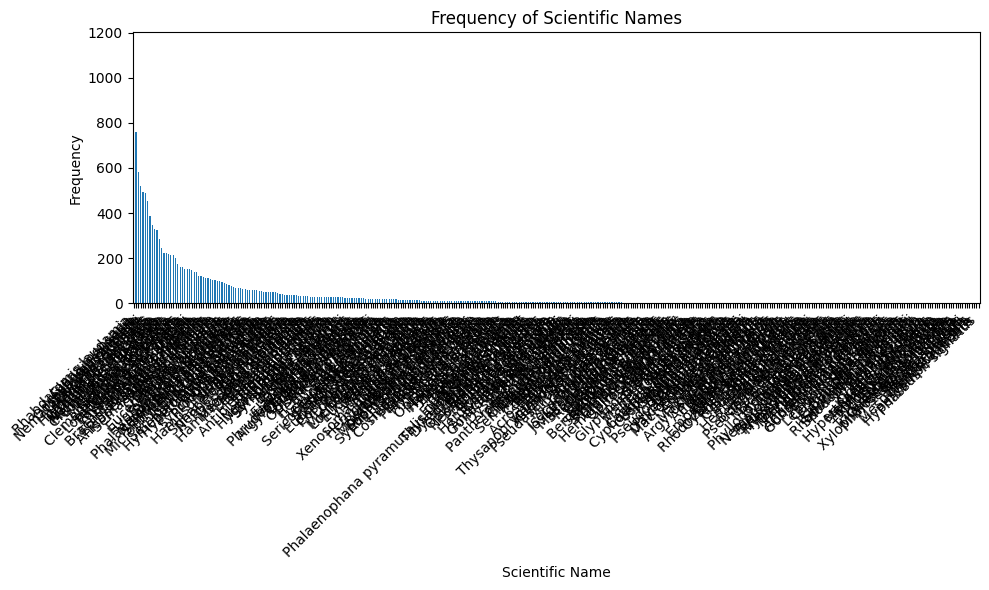

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Input CSV file
input_file = "/Users/markfisher/Desktop/cr_moth_classification/1_dataset_prep/ciee_monte_verde_dataset/dl_moths_matching_gbif.csv"  # Replace with the path to your CSV file

# Column containing the scientific names
column_name = "scientificName"  # Replace with the actual column name

try:
    # Read the CSV file
    df = pd.read_csv(input_file)

    # Check if the column exists
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in the CSV file.")

    # Calculate the frequency of each scientific name
    frequency = df[column_name].value_counts()

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    frequency.plot(kind='bar')
    plt.title("Frequency of Scientific Names")
    plt.xlabel("Scientific Name")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.tight_layout()

    # Show the plot
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")


In [7]:
# Then, I compiled a list of species that had n or more photos in the dataset, where n was 30 in this case based on discussion with Michael and inspection of the above

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

n=30

# Input CSV file
input_file = "/Users/markfisher/Desktop/cr_moth_classification/1_dataset_prep/ciee_monte_verde_dataset/dl_moths_matching_gbif.csv"  # Replace with the path to your CSV file

# Column containing the scientific names
column_name = "scientificName"  # Replace with the actual column name

try:
    # Read the CSV file
    df = pd.read_csv(input_file)

    # Check if the column exists
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in the CSV file.")

    # Calculate the frequency of each scientific name
    frequency = df[column_name].value_counts()
    subset = frequency[frequency >= n]

    # print(subset)
    subset_df = subset.reset_index()
    subset_df.columns = ['Value', 'Frequency']

    # Save to CSV
    subset_df.to_csv('species_with_30_occurrences_or_more.csv', index=False)

    # # Plot the histogram
    # plt.figure(figsize=(10, 6))
    # frequency.plot(kind='bar')
    # plt.title("Frequency of Scientific Names")
    # plt.xlabel("Scientific Name")
    # plt.ylabel("Frequency")
    # plt.xticks(rotation=45, ha="right", fontsize=10)
    # plt.tight_layout()

    # # Show the plot
    # plt.show()

except Exception as e:
    print(f"An error occurred: {e}")


In [4]:
import pandas as pd
from IPython.display import Markdown

df = pd.read_csv("/Users/markfisher/Desktop/cr_moth_classification/1_dataset_prep/ciee_monte_verde_dataset/species_with_30_occurrences_or_more.csv")
markdown_table = df.to_markdown(index=False)
display(Markdown(markdown_table))

| Value                      |   Frequency |
|:---------------------------|------------:|
| Rhabdatomis laudamia       |        1144 |
| Glena mopsaria             |         761 |
| Nephodia auxesia           |         582 |
| Oospila venezuelata        |         518 |
| Nematocampa completa       |         494 |
| Crinodes schausi           |         489 |
| Lobocleta tenellata        |         455 |
| Himeromima aulis           |         385 |
| Hymenia perspectalis       |         345 |
| Crambidia cephalica        |         329 |
| Crambidia myrlosea         |         323 |
| Nemoria vermiculata        |         283 |
| Micrathetis dasarada       |         247 |
| Clemensia leopardina       |         223 |
| Lophosis labeculata        |         222 |
| Trygodes amphion           |         217 |
| Afrida ydatodes            |         214 |
| Metanema bonadea           |         214 |
| Nemoria defectiva          |         202 |
| Clemensia brunneomedia     |         176 |
| Cliniodes opalalis         |         162 |
| Phyllodonta latrata        |         162 |
| Lomographa argentata       |         154 |
| Patalene aenetusaria       |         151 |
| Thysanopyga carfinia       |         150 |
| Leptostales crossii        |         149 |
| Clemensia cincinnata       |         141 |
| Oospila athena             |         137 |
| Brachurapteryx tesserata   |         123 |
| Iridopsis validaria        |         119 |
| Epimecis semicompleta      |         116 |
| Paragonia cruraria         |         112 |
| Anisoperas atropunctaria   |         111 |
| Ametris nitocris           |         110 |
| Semaeopus viridiplaga      |         104 |
| Melese monima              |         102 |
| Macrocneme iole            |         100 |
| Opisthoxia miletia         |          99 |
| Oxydia trychiata           |          93 |
| Eucereon xanthoperas       |          90 |
| Herbita amicaria           |          86 |
| Pelochyta affinis          |          82 |
| Hygrochroma olivinaria     |          77 |
| Synchlora gerularia        |          74 |
| Dysschema lycaste          |          70 |
| Phalaenophana pyramusalis  |          69 |
| Nematocampa arenosa        |          66 |
| Synchlora dependens        |          64 |
| Simopteryx torquataria     |          62 |
| Euglyphis libnites         |          60 |
| Microphysetica hermeasalis |          60 |
| Nemoria pescadora          |          60 |
| Epicrisias eschara         |          58 |
| Semiothisa divergentata    |          57 |
| Opharus rudis              |          55 |
| Hymenomima umbelularia     |          53 |
| Neotherina imperilla       |          52 |
| Hypercompe nemophila       |          51 |
| Eucereon tigrata           |          50 |
| Rivula leucosticta         |          49 |
| Antiblemma pira            |          49 |
| Synchlora astraeoides      |          48 |
| Prochoerodes pilosa        |          44 |
| Aclytia heber              |          41 |
| Hampsonodes mastoides      |          40 |
| Nemoria astraea            |          38 |
| Nephodia betala            |          37 |
| Macaria delia              |          37 |
| Sphacelodes vulneraria     |          36 |
| Nepheloleuca illiturata    |          35 |
| Pyrinia selecta            |          35 |
| Amaxia apyga               |          34 |
| Dyspteris tenuivitta       |          32 |
| Nemoria aturia             |          32 |
| Hampsonodes melagona       |          32 |
| Meganola bifiliferata      |          32 |
| Gonodes liquida            |          30 |
| Leucanopsis longa          |          30 |

In [8]:
# Using the file generated from the "generated a list of species and their corresponding local image filenames" 
# segment above with `filterBySpecies = False`, I then created a short list of files that occurred in the >30 images
# category and had exact GBIF matches:

In [ ]:
import pandas as pd

# Load the CSV files
species_df = pd.read_csv('/Users/markfisher/Desktop/cr_moth_classification/1_dataset_prep/ciee_monte_verde_dataset/species_with_30_occurrences_or_more.csv')
dl_moths_df = pd.read_csv('/Users/markfisher/Desktop/cr_moth_classification/1_dataset_prep/ciee_monte_verde_dataset/dl_moths_matching_gbif_not_just_spiecies.csv')

# Extract the 'value' column from the first CSV
values_to_match = species_df['Value']

# Filter the rows in the second CSV where 'scientificName' matches any value in 'value'
matching_rows = dl_moths_df[dl_moths_df['scientificName'].isin(values_to_match)]

# Extract the 'Filename' column from the matching rows
target_filenames = matching_rows['Filename']

# Save the resulting filenames to a new CSV
target_filenames.to_csv('targetFilenamesForDetection.csv', index=False, header=True)

print("Matching filenames have been saved to 'targetFilenamesForDetection.csv'.")


In [9]:
import pandas as pd
from IPython.display import Markdown

df = pd.read_csv("/Users/markfisher/Desktop/cr_moth_classification/1_dataset_prep/ciee_monte_verde_dataset/targetFilenamesForDetection.csv")
markdown_table = df.to_markdown(index=False)
display(Markdown(markdown_table))

| Filename                                                                          |
|:----------------------------------------------------------------------------------|
| Lobocleta_tenellata,I_PBA25000.jpg                                                |
| Clemensia_leopardina,I_PBA25003.jpg                                               |
| Rhabdatomis_laudamia,I_PBA25004.jpg                                               |
| Crambidia_myrlosea,I_PBA25006.jpg                                                 |
| Leptostales_crossii,I_PBA25007.jpg                                                |
| Rhabdatomis_laudamia,I_PBA25011.jpg                                               |
| Rhabdatomis_laudamia,I_PBA25013.jpg                                               |
| Nephodia_auxesia,I_PBA25014.jpg                                                   |
| Nemoria_defectiva,I_PBA25017.jpg                                                  |
| Nematocampa_arenosa,I_PBA25018.jpg                                                |
| Patalene_aenetusaria,I_PBA25024.jpg                                               |
| Clemensia_cincinnata,I_PBA25026.jpg                                               |
| Nephodia_auxesia,I_PBA25028.jpg                                                   |
| Brachurapteryx_tesserata,I_PBA25029.jpg                                           |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25030.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25033.jpg                     |
| Rhabdatomis_laudamia,I_PBA25036.jpg                                               |
| Lobocleta_tenellata,I_PBA25040.jpg                                                |
| Lobocleta_tenellata,I_PBA25042.jpg                                                |
| Glena_mopsaria,I_PBA25044.jpg                                                     |
| Iridopsis_validaria,I_PBA25045.jpg                                                |
| Leptostales_crossii,I_PBA25046.jpg                                                |
| Micrathetis_dasarada,I_PBA25050.jpg                                               |
| Rhabdatomis_laudamia,I_PBA25057.jpg                                               |
| Patalene_aenetusaria,I_PBA25059.jpg                                               |
| Rhabdatomis_laudamia,I_PBA25061.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA25062.jpg                         |
| Trygodes_amphion,I_PBA25064.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25068.jpg                     |
| Lobocleta_tenellata,I_PBA25071.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25073.jpg                     |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA25074.jpg                                 |
| Meganola_bifiliferata,I_PBA25075.jpg                                              |
| Clemensia_brunneomedia,I_PBA25076.jpg                                             |
| Clemensia_leopardina,I_PBA25077.jpg                                               |
| Patalene_aenetusaria,I_PBA25078.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25079.jpg                     |
| Eucereon_xanthoperas,I_PBA25080.jpg                                               |
| Rhabdatomis_laudamia,I_PBA25086.jpg                                               |
| Nephodia_auxesia,I_PBA25088.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA25090.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25091.jpg                     |
| Rhabdatomis_laudamia,I_PBA25092.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA25097.jpg                    |
| Patalene_aenetusaria,I_PBA25098.jpg                                               |
| Metanema_bonadea,I_PBA25107.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25108.jpg                     |
| Rhabdatomis_laudamia,I_PBA25112.jpg                                               |
| Nematocampa_completa,I_PBA25115.jpg                                               |
| Nemoria_vermiculata,I_PBA25119.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA25122.jpg                                 |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25123.jpg                     |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA25129.jpg                                 |
| Patalene_aenetusaria,I_PBA25136.jpg                                               |
| Nemoria_defectiva,I_PBA25140.jpg                                                  |
| Lobocleta_tenellata,I_PBA25142.jpg                                                |
| Hampsonodes_mastoides,I_PBA25148.jpg                                              |
| Trygodes_amphion,I_PBA25149.jpg                                                   |
| Hypercompe_nemophila,I_PBA25153.jpg                                               |
| Synchlora_astraeoides,I_PBA25160.jpg                                              |
| Leptostales_crossii,I_PBA25168.jpg                                                |
| Rhabdatomis_laudamia,I_PBA25170.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA25171.jpg                    |
| Nematocampa_completa,I_PBA25173.jpg                                               |
| Nephodia_auxesia,I_PBA25174.jpg                                                   |
| Iridopsis_validaria,I_PBA25175.jpg                                                |
| Oospila_venezuelata,I_PBA25177.jpg                                                |
| Glena_mopsaria,I_PBA25181.jpg                                                     |
| Metanema_bonadea,I_PBA25184.jpg                                                   |
| Clemensia_leopardina,I_PBA25186.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25190.jpg                     |
| Crambidia_myrlosea,I_PBA25193.jpg                                                 |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25195.jpg                     |
| Lobocleta_tenellata,I_PBA25200.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25202.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25208.jpg                     |
| Melese_monima,I_PBA25209.jpg                                                      |
| Rhabdatomis_laudamia,I_PBA25213.jpg                                               |
| Clemensia_brunneomedia,I_PBA25215.jpg                                             |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25222.jpg                     |
| Rhabdatomis_laudamia,I_PBA25224.jpg                                               |
| Leptostales_crossii,I_PBA25239.jpg                                                |
| Nephodia_betala,I_PBA25244.jpg                                                    |
| Iridopsis_validaria,I_PBA25249.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25250.jpg                     |
| Thysanopyga_carfinia,I_PBA25251.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25253.jpg                     |
| Nephodia_auxesia,I_PBA25255.jpg                                                   |
| Aclytia_heber,I_PBA25259.jpg                                                      |
| Gonodes_liquida,I_PBA25264.jpg                                                    |
| Clemensia_leopardina,I_PBA25267.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25269.jpg                     |
| Crambidia_myrlosea,I_PBA25272.jpg                                                 |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA25274.jpg                                 |
| Glena_mopsaria,I_PBA25282.jpg                                                     |
| Hypercompe_nemophila,I_PBA25283.jpg                                               |
| Leptostales_crossii,I_PBA25287.jpg                                                |
| Nephodia_auxesia,I_PBA25288.jpg                                                   |
| Neotherina_imperilla,I_PBA25293.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25296.jpg                     |
| Nemoria_vermiculata,I_PBA25298.jpg                                                |
| Clemensia_leopardina,I_PBA25299.jpg                                               |
| Oospila_venezuelata,I_PBA25301.jpg                                                |
| Leptostales_crossii,I_PBA25303.jpg                                                |
| Oospila_venezuelata,I_PBA25307.jpg                                                |
| Nematocampa_completa,I_PBA25309.jpg                                               |
| Lobocleta_tenellata,I_PBA25310.jpg                                                |
| Lomographa_argentata,I_PBA25311.jpg                                               |
| Lobocleta_tenellata,I_PBA25312.jpg                                                |
| Nephodia_auxesia,I_PBA25320.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA25324.jpg                    |
| Nemoria_defectiva,I_PBA25325.jpg                                                  |
| Hampsonodes_mastoides,I_PBA25326.jpg                                              |
| Simopteryx_torquataria,I_PBA25327.jpg                                             |
| Glena_mopsaria,I_PBA25328.jpg                                                     |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA25334.jpg                         |
| Clemensia_leopardina,I_PBA25335.jpg                                               |
| Lobocleta_tenellata,I_PBA25336.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA25338.jpg                         |
| Lobocleta_tenellata,I_PBA25341.jpg                                                |
| Eucereon_xanthoperas,I_PBA25342.jpg                                               |
| Nematocampa_completa,I_PBA25345.jpg                                               |
| Leptostales_crossii,I_PBA25346.jpg                                                |
| Lobocleta_tenellata,I_PBA25347.jpg                                                |
| Oospila_venezuelata,I_PBA25348.jpg                                                |
| Nephodia_auxesia,I_PBA25349.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25355.jpg                     |
| Hypercompe_nemophila,I_PBA25362.jpg                                               |
| Clemensia_leopardina,I_PBA25364.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25373.jpg                     |
| Hypercompe_nemophila,I_PBA25376.jpg                                               |
| Aclytia_heber,I_PBA25377.jpg                                                      |
| Synchlora_gerularia,I_PBA25389.jpg                                                |
| Trygodes_amphion,I_PBA25392.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA25394.jpg                                               |
| Synchlora_dependens,I_PBA25397.jpg                                                |
| Glena_mopsaria,I_PBA25398.jpg                                                     |
| Lomographa_argentata,I_PBA25401.jpg                                               |
| Rhabdatomis_laudamia,I_PBA25405.jpg                                               |
| Patalene_aenetusaria,I_PBA25419.jpg                                               |
| Rhabdatomis_laudamia,I_PBA25421.jpg                                               |
| Clemensia_brunneomedia,I_PBA25422.jpg                                             |
| Rhabdatomis_laudamia,I_PBA25424.jpg                                               |
| Nephodia_auxesia,I_PBA25426.jpg                                                   |
| Leptostales_crossii,I_PBA25427.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25428.jpg                     |
| Brachurapteryx_tesserata,I_PBA25429.jpg                                           |
| Patalene_aenetusaria,I_PBA25432.jpg                                               |
| Nephodia_auxesia,I_PBA25436.jpg                                                   |
| Trygodes_amphion,I_PBA25438.jpg                                                   |
| Lobocleta_tenellata,I_PBA25439.jpg                                                |
| Iridopsis_validaria,I_PBA25442.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA25443.jpg                    |
| Micrathetis_dasarada,I_PBA25445.jpg                                               |
| Epimecis_semicompleta,I_PBA25447.jpg                                              |
| Nematocampa_completa,I_PBA25448.jpg                                               |
| Nematocampa_completa,I_PBA25450.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA25451.jpg                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA25454.jpg                    |
| Nephodia_auxesia,I_PBA25456.jpg                                                   |
| Antiblemma_pira,I_PBA25458.jpg                                                    |
| Nephodia_auxesia,I_PBA25460.jpg                                                   |
| Nemoria_vermiculata,I_PBA25463.jpg                                                |
| Metanema_bonadea,I_PBA25467.jpg                                                   |
| Nematocampa_completa,I_PBA25468.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA25473.jpg                    |
| Nematocampa_completa,I_PBA25474.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA25475.jpg                                 |
| Nephodia_auxesia,I_PBA25477.jpg                                                   |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA25478.jpg                         |
| Glena_mopsaria,I_PBA25481.jpg                                                     |
| Nematocampa_completa,I_PBA25482.jpg                                               |
| Metanema_bonadea,I_PBA25483.jpg                                                   |
| Lobocleta_tenellata,I_PBA25484.jpg                                                |
| Epimecis_semicompleta,I_PBA25485.jpg                                              |
| Nemoria_defectiva,I_PBA25486.jpg                                                  |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA25488.jpg                    |
| Trygodes_amphion,I_PBA25489.jpg                                                   |
| Anisoperas_atropunctaria,I_PBA25491.jpg                                           |
| Nephodia_betala,I_PBA25498.jpg                                                    |
| Clemensia_leopardina,I_PBA25499.jpg                                               |
| Lomographa_argentata,I_PBA25502.jpg                                               |
| Rhabdatomis_laudamia,I_PBA25506.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25507.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25511.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25512.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25514.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25522.jpg                     |
| Hypercompe_nemophila,I_PBA25525.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25527.jpg                     |
| Leptostales_crossii,I_PBA25537.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25539.jpg                     |
| Rhabdatomis_laudamia,I_PBA25546.jpg                                               |
| Lomographa_argentata,I_PBA25548.jpg                                               |
| Nephodia_auxesia,I_PBA25557.jpg                                                   |
| Lomographa_argentata,I_PBA25560.jpg                                               |
| Nematocampa_completa,I_PBA25567.jpg                                               |
| Dyspteris_tenuivitta,I_PBA25568.jpg                                               |
| Brachurapteryx_tesserata,I_PBA25570.jpg                                           |
| Rhabdatomis_laudamia,I_PBA25571.jpg                                               |
| Crambidia_cephalica,I_PBA25573.jpg                                                |
| Glena_mopsaria,I_PBA25575.jpg                                                     |
| Neotherina_imperilla,I_PBA25576.jpg                                               |
| Rhabdatomis_laudamia,I_PBA25582.jpg                                               |
| Eucereon_xanthoperas,I_PBA25584.jpg                                               |
| Opisthoxia_miletia,I_PBA25585.jpg                                                 |
| Lomographa_argentata,I_PBA25590.jpg                                               |
| Synchlora_dependens,I_PBA25591.jpg                                                |
| Nephodia_auxesia,I_PBA25592.jpg                                                   |
| Synchlora_dependens,I_PBA25593.jpg                                                |
| Nematocampa_completa,I_PBA25594.jpg                                               |
| Thysanopyga_carfinia,I_PBA25596.jpg                                               |
| Oospila_venezuelata,I_PBA25597.jpg                                                |
| Nematocampa_completa,I_PBA25600.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA25606.jpg                         |
| Ametris_nitocris,I_PBA25607.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA25622.jpg                                 |
| Glena_mopsaria,I_PBA25627.jpg                                                     |
| Melese_monima,I_PBA25633.jpg                                                      |
| Lobocleta_tenellata,I_PBA25638.jpg                                                |
| Lobocleta_tenellata,I_PBA25640.jpg                                                |
| Nematocampa_completa,I_PBA25641.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25645.jpg                     |
| Patalene_aenetusaria,I_PBA25648.jpg                                               |
| Nematocampa_completa,I_PBA25652.jpg                                               |
| Macrocneme_iole,I_PBA25654.jpg                                                    |
| Lobocleta_tenellata,I_PBA25655.jpg                                                |
| Metanema_bonadea,I_PBA25657.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25658.jpg                     |
| Metanema_bonadea,I_PBA25659.jpg                                                   |
| Lomographa_argentata,I_PBA25662.jpg                                               |
| Nematocampa_completa,I_PBA25663.jpg                                               |
| Nematocampa_completa,I_PBA25666.jpg                                               |
| Rhabdatomis_laudamia,I_PBA25669.jpg                                               |
| Melese_monima,I_PBA25670.jpg                                                      |
| Oospila_venezuelata,I_PBA25671.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25673.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25675.jpg                     |
| Lobocleta_tenellata,I_PBA25676.jpg                                                |
| Lobocleta_tenellata,I_PBA25679.jpg                                                |
| Trygodes_amphion,I_PBA25680.jpg                                                   |
| Nematocampa_completa,I_PBA25684.jpg                                               |
| Lomographa_argentata,I_PBA25688.jpg                                               |
| Nephodia_auxesia,I_PBA25689.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25692.jpg                     |
| Rhabdatomis_laudamia,I_PBA25696.jpg                                               |
| Rhabdatomis_laudamia,I_PBA25704.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25705.jpg                     |
| Macrocneme_iole,I_PBA25706.jpg                                                    |
| Lomographa_argentata,I_PBA25708.jpg                                               |
| Leptostales_crossii,I_PBA25719.jpg                                                |
| Nematocampa_completa,I_PBA25724.jpg                                               |
| Synchlora_dependens,I_PBA25727.jpg                                                |
| Leptostales_crossii,I_PBA25728.jpg                                                |
| Leptostales_crossii,I_PBA25731.jpg                                                |
| Epimecis_semicompleta,I_PBA25737.jpg                                              |
| Nematocampa_completa,I_PBA25739.jpg                                               |
| Nematocampa_completa,I_PBA25741.jpg                                               |
| Ametris_nitocris,I_PBA25746.jpg                                                   |
| Nephodia_auxesia,I_PBA25749.jpg                                                   |
| Oospila_venezuelata,I_PBA25752.jpg                                                |
| Oospila_venezuelata,I_PBA25756.jpg                                                |
| Nepheloleuca_illiturata,I_PBA25759.jpg                                            |
| Lomographa_argentata,I_PBA25765.jpg                                               |
| Nemoria_pescadora,I_PBA25766.jpg                                                  |
| Micrathetis_dasarada,I_PBA25769.jpg                                               |
| Nemoria_vermiculata,I_PBA25772.jpg                                                |
| Lomographa_argentata,I_PBA25774.jpg                                               |
| Leptostales_crossii,I_PBA25779.jpg                                                |
| Clemensia_cincinnata,I_PBA25783.jpg                                               |
| Clemensia_leopardina,I_PBA25784.jpg                                               |
| Semaeopus_viridiplaga,I_PBA25785.jpg                                              |
| Clemensia_brunneomedia,I_PBA25786.jpg                                             |
| Nematocampa_completa,I_PBA25795.jpg                                               |
| Rhabdatomis_laudamia,I_PBA25799.jpg                                               |
| Clemensia_leopardina,I_PBA25800.jpg                                               |
| Trygodes_amphion,I_PBA25801.jpg                                                   |
| Oxydia_trychiata,I_PBA25807.jpg                                                   |
| Nephodia_auxesia,I_PBA25808.jpg                                                   |
| Nematocampa_completa,I_PBA25809.jpg                                               |
| Nephodia_auxesia,I_PBA25811.jpg                                                   |
| Trygodes_amphion,I_PBA25813.jpg                                                   |
| Nematocampa_arenosa,I_PBA25817.jpg                                                |
| Lobocleta_tenellata,I_PBA25819.jpg                                                |
| Glena_mopsaria,I_PBA25820.jpg                                                     |
| Lobocleta_tenellata,I_PBA25823.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25824.jpg                     |
| Nemoria_vermiculata,I_PBA25829.jpg                                                |
| Nemoria_vermiculata,I_PBA25832.jpg                                                |
| Nephodia_auxesia,I_PBA25836.jpg                                                   |
| Nemoria_defectiva,I_PBA25837.jpg                                                  |
| Eucereon_tigrata,I_PBA25845.jpg                                                   |
| Anisoperas_atropunctaria,I_PBA25866.jpg                                           |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA25872.jpg                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA25875.jpg                    |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25880.jpg                     |
| Nematocampa_completa,I_PBA25887.jpg                                               |
| Nematocampa_completa,I_PBA25891.jpg                                               |
| Nemoria_defectiva,I_PBA25893.jpg                                                  |
| Nematocampa_completa,I_PBA25895.jpg                                               |
| Melese_monima,I_PBA25897.jpg                                                      |
| Micrathetis_dasarada,I_PBA25898.jpg                                               |
| Oospila_venezuelata,I_PBA25905.jpg                                                |
| Thysanopyga_carfinia,I_PBA25907.jpg                                               |
| Epimecis_semicompleta,I_PBA25909.jpg                                              |
| Nemoria_vermiculata,I_PBA25911.jpg                                                |
| Opisthoxia_miletia,I_PBA25912.jpg                                                 |
| Oospila_venezuelata,I_PBA25916.jpg                                                |
| Rhabdatomis_laudamia,I_PBA25920.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25923.jpg                     |
| Macrocneme_iole,I_PBA25924.jpg                                                    |
| Macrocneme_iole,I_PBA25926.jpg                                                    |
| Crambidia_myrlosea,I_PBA25927.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA25929.jpg                                               |
| Glena_mopsaria,I_PBA25935.jpg                                                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA25942.jpg                    |
| Crambidia_myrlosea,I_PBA25946.jpg                                                 |
| Nephodia_auxesia,I_PBA25954.jpg                                                   |
| Opisthoxia_miletia,I_PBA25955.jpg                                                 |
| Hypercompe_nemophila,I_PBA25957.jpg                                               |
| Macrocneme_iole,I_PBA25958.jpg                                                    |
| Nematocampa_completa,I_PBA25960.jpg                                               |
| Rhabdatomis_laudamia,I_PBA25962.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25963.jpg                     |
| Clemensia_leopardina,I_PBA25965.jpg                                               |
| Lomographa_argentata,I_PBA25966.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA25971.jpg                         |
| Clemensia_leopardina,I_PBA25979.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA25986.jpg                    |
| Simopteryx_torquataria,I_PBA25990.jpg                                             |
| Anisoperas_atropunctaria,I_PBA25991.jpg                                           |
| Nephodia_auxesia,I_PBA25992.jpg                                                   |
| Oospila_venezuelata,I_PBA25994.jpg                                                |
| Nematocampa_completa,I_PBA25996.jpg                                               |
| Micrathetis_dasarada,I_PBA25997.jpg                                               |
| Clemensia_leopardina,I_PBA25998.jpg                                               |
| Nemoria_defectiva,I_PBA26002.jpg                                                  |
| Lobocleta_tenellata,I_PBA26003.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA26006.jpg                                 |
| Ametris_nitocris,I_PBA26009.jpg                                                   |
| Micrathetis_dasarada,I_PBA26010.jpg                                               |
| Nematocampa_arenosa,I_PBA26011.jpg                                                |
| Leptostales_crossii,I_PBA26012.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26013.jpg                     |
| Clemensia_leopardina,I_PBA26015.jpg                                               |
| Leptostales_crossii,I_PBA26019.jpg                                                |
| Aclytia_heber,I_PBA26024.jpg                                                      |
| Rhabdatomis_laudamia,I_PBA26025.jpg                                               |
| Rhabdatomis_laudamia,I_PBA26030.jpg                                               |
| Glena_mopsaria,I_PBA26031.jpg                                                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26033.jpg                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA26036.jpg                    |
| Melese_monima,I_PBA26038.jpg                                                      |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26040.jpg                     |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA26042.jpg                         |
| Aclytia_heber,I_PBA26043.jpg                                                      |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26044.jpg                     |
| Aclytia_heber,I_PBA26047.jpg                                                      |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26057.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26058.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26059.jpg                     |
| Nephodia_auxesia,I_PBA26060.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26064.jpg                     |
| Melese_monima,I_PBA26065.jpg                                                      |
| Crambidia_myrlosea,I_PBA26068.jpg                                                 |
| Hampsonodes_melagona,I_PBA26070.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26073.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26078.jpg                     |
| Melese_monima,I_PBA26080.jpg                                                      |
| Nephodia_auxesia,I_PBA26081.jpg                                                   |
| Micrathetis_dasarada,I_PBA26082.jpg                                               |
| Glena_mopsaria,I_PBA26091.jpg                                                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA26098.jpg                    |
| Glena_mopsaria,I_PBA26099.jpg                                                     |
| Glena_mopsaria,I_PBA26102.jpg                                                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26105.jpg                     |
| Rhabdatomis_laudamia,I_PBA26106.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA26107.jpg                         |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26110.jpg                     |
| Hypercompe_nemophila,I_PBA26111.jpg                                               |
| Nematocampa_completa,I_PBA26112.jpg                                               |
| Clemensia_leopardina,I_PBA26113.jpg                                               |
| Crambidia_myrlosea,I_PBA26117.jpg                                                 |
| Patalene_aenetusaria,I_PBA26128.jpg                                               |
| Nephodia_auxesia,I_PBA26129.jpg                                                   |
| Lobocleta_tenellata,I_PBA26136.jpg                                                |
| Nephodia_auxesia,I_PBA26137.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26140.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26144.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26149.jpg                     |
| Trygodes_amphion,I_PBA26150.jpg                                                   |
| Lobocleta_tenellata,I_PBA26153.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA26154.jpg                                 |
| Oospila_venezuelata,I_PBA26159.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26162.jpg                     |
| Nephodia_auxesia,I_PBA26170.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26171.jpg                     |
| Nephodia_auxesia,I_PBA26172.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26173.jpg                     |
| Lomographa_argentata,I_PBA26179.jpg                                               |
| Nematocampa_completa,I_PBA26184.jpg                                               |
| Nematocampa_completa,I_PBA26186.jpg                                               |
| Nemoria_vermiculata,I_PBA26189.jpg                                                |
| Lobocleta_tenellata,I_PBA26191.jpg                                                |
| Nematocampa_arenosa,I_PBA26192.jpg                                                |
| Eucereon_xanthoperas,I_PBA26198.jpg                                               |
| Clemensia_leopardina,I_PBA26199.jpg                                               |
| Trygodes_amphion,I_PBA26204.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA26208.jpg                                               |
| Nephodia_auxesia,I_PBA26209.jpg                                                   |
| Metanema_bonadea,I_PBA26210.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA26212.jpg                                               |
| Rhabdatomis_laudamia,I_PBA26219.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA26221.jpg                    |
| Lobocleta_tenellata,I_PBA26222.jpg                                                |
| Nephodia_auxesia,I_PBA26223.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA26230.jpg                                               |
| Nematocampa_completa,I_PBA26231.jpg                                               |
| Nematocampa_arenosa,I_PBA26233.jpg                                                |
| Leptostales_crossii,I_PBA26236.jpg                                                |
| Synchlora_astraeoides,I_PBA26237.jpg                                              |
| Rhabdatomis_laudamia,I_PBA26239.jpg                                               |
| Thysanopyga_carfinia,I_PBA26240.jpg                                               |
| Nematocampa_completa,I_PBA26243.jpg                                               |
| Trygodes_amphion,I_PBA26245.jpg                                                   |
| Nephodia_auxesia,I_PBA26247.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26248.jpg                     |
| Rhabdatomis_laudamia,I_PBA26249.jpg                                               |
| Nematocampa_completa,I_PBA26250.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA26252.jpg                                 |
| Rhabdatomis_laudamia,I_PBA26253.jpg                                               |
| Glena_mopsaria,I_PBA26254.jpg                                                     |
| Semaeopus_viridiplaga,I_PBA26255.jpg                                              |
| Leptostales_crossii,I_PBA26261.jpg                                                |
| Nematocampa_completa,I_PBA26262.jpg                                               |
| Lobocleta_tenellata,I_PBA26264.jpg                                                |
| Neotherina_imperilla,I_PBA26265.jpg                                               |
| Metanema_bonadea,I_PBA26270.jpg                                                   |
| Nephodia_auxesia,I_PBA26275.jpg                                                   |
| Nephodia_auxesia,I_PBA26278.jpg                                                   |
| Nematocampa_completa,I_PBA26279.jpg                                               |
| Clemensia_leopardina,I_PBA26282.jpg                                               |
| Nephodia_auxesia,I_PBA26284.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA26287.jpg                    |
| Eucereon_xanthoperas,I_PBA26289.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26293.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26297.jpg                     |
| Crambidia_myrlosea,I_PBA26301.jpg                                                 |
| Nematocampa_completa,I_PBA26302.jpg                                               |
| Crambidia_myrlosea,I_PBA26304.jpg                                                 |
| Crambidia_myrlosea,I_PBA26305.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA26308.jpg                                               |
| Herbita_amicaria,I_PBA26309.jpg                                                   |
| Leptostales_crossii,I_PBA26310.jpg                                                |
| Leptostales_crossii,I_PBA26315.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26317.jpg                     |
| Glena_mopsaria,I_PBA26318.jpg                                                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26319.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26324.jpg                     |
| Clemensia_leopardina,I_PBA26327.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26328.jpg                     |
| Melese_monima,I_PBA26331.jpg                                                      |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26332.jpg                     |
| Glena_mopsaria,I_PBA26333.jpg                                                     |
| Nematocampa_arenosa,I_PBA26339.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26343.jpg                     |
| Aclytia_heber,I_PBA26344.jpg                                                      |
| Lomographa_argentata,I_PBA26351.jpg                                               |
| Rhabdatomis_laudamia,I_PBA26352.jpg                                               |
| Leptostales_crossii,I_PBA26366.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA26374.jpg                         |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA26378.jpg                    |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26382.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26385.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26387.jpg                     |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA26388.jpg                         |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26389.jpg                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA26391.jpg                    |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26392.jpg                     |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA26395.jpg                         |
| Leptostales_crossii,I_PBA26396.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26397.jpg                     |
| Micrathetis_dasarada,I_PBA26399.jpg                                               |
| Eucereon_xanthoperas,I_PBA10003.jpg                                               |
| Cliniodes_opalalis,I_PBA10005.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA10013.jpg                                               |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,I_PBA10016.jpg                      |
| Crinodes_schausi,I_PBA10018.jpg                                                   |
| Clemensia_leopardina,I_PBA10020.jpg                                               |
| Clemensia_brunneomedia,I_PBA10025.jpg                                             |
| Oospila_athena,I_PBA10030.jpg                                                     |
| Crinodes_schausi,I_PBA10035.jpg                                                   |
| Crinodes_schausi,I_PBA10037.jpg                                                   |
| Macrocneme_iole,I_PBA10039.jpg                                                    |
| Hymenomima_umbelularia,I_PBA10040.jpg                                             |
| Clemensia_leopardina,I_PBA10044.jpg                                               |
| Nematocampa_completa,I_PBA10050.jpg                                               |
| Clemensia_leopardina,I_PBA10055.jpg                                               |
| Amaxia_apyga,I_PBA10056.jpg                                                       |
| Oospila_venezuelata,I_PBA10066.jpg                                                |
| Nemoria_defectiva,I_PBA10069.jpg                                                  |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA10077.jpg                                 |
| Nematocampa_completa,I_PBA10086.jpg                                               |
| Clemensia_brunneomedia,I_PBA10094.jpg                                             |
| Oospila_venezuelata,I_PBA10096.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA10097.jpg                    |
| Phalaenophana_pyramusalis,_Dark-Banded_Owlet_Moth,I_PBA10101.jpg                  |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA10105.jpg                                 |
| Crinodes_schausi,I_PBA10111.jpg                                                   |
| Clemensia_leopardina,I_PBA10112.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA10125.jpg                                 |
| Paragonia_cruraria,I_PBA10130.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA10132.jpg                                               |
| Clemensia_brunneomedia,I_PBA10134.jpg                                             |
| Glena_mopsaria,I_PBA10137.jpg                                                     |
| Microphysetica_hermeasalis,I_PBA10140.jpg                                         |
| Rhabdatomis_laudamia,I_PBA10141.jpg                                               |
| Nephodia_auxesia,I_PBA10143.jpg                                                   |
| Phalaenophana_pyramusalis,_Dark-Banded_Owlet_Moth,I_PBA10147.jpg                  |
| Crinodes_schausi,I_PBA10162.jpg                                                   |
| Cliniodes_opalalis,I_PBA10169.jpg                                                 |
| Nemoria_vermiculata,I_PBA10183.jpg                                                |
| Nemoria_defectiva,I_PBA10186.jpg                                                  |
| Nepheloleuca_illiturata,I_PBA10187.jpg                                            |
| Nephodia_betala,I_PBA10188.jpg                                                    |
| Dysschema_lycaste,I_PBA10195.jpg                                                  |
| Brachurapteryx_tesserata,I_PBA10197.jpg                                           |
| Dysschema_lycaste,I_PBA10198.jpg                                                  |
| Paragonia_cruraria,I_PBA10201.jpg                                                 |
| Oospila_venezuelata,I_PBA10202.jpg                                                |
| Paragonia_cruraria,I_PBA10204.jpg                                                 |
| Crinodes_schausi,I_PBA10205.jpg                                                   |
| Oxydia_trychiata,I_PBA10206.jpg                                                   |
| Nepheloleuca_illiturata,I_PBA10212.jpg                                            |
| Oospila_venezuelata,I_PBA10213.jpg                                                |
| Hypercompe_nemophila,I_PBA10214.jpg                                               |
| Lomographa_argentata,I_PBA10216.jpg                                               |
| Paragonia_cruraria,I_PBA10225.jpg                                                 |
| Crinodes_schausi,I_PBA10226.jpg                                                   |
| Anisoperas_atropunctaria,I_PBA10227.jpg                                           |
| Hypercompe_nemophila,I_PBA10229.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA10231.jpg                     |
| Clemensia_leopardina,I_PBA10240.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA10241.jpg                                 |
| Trygodes_amphion,I_PBA10245.jpg                                                   |
| Glena_mopsaria,I_PBA10261.jpg                                                     |
| Dyspteris_tenuivitta,_Exquisite_Emerald,I_PBA10273.jpg                            |
| Crinodes_schausi,I_PBA10275.jpg                                                   |
| Herbita_amicaria,I_PBA10280.jpg                                                   |
| Crinodes_schausi,I_PBA10282.jpg                                                   |
| Oxydia_trychiata,I_PBA10283.jpg                                                   |
| Oospila_venezuelata,I_PBA10285.jpg                                                |
| Phyllodonta_latrata,I_PBA10288.jpg                                                |
| Oospila_venezuelata,I_PBA10289.jpg                                                |
| Crinodes_schausi,I_PBA10292.jpg                                                   |
| Nemoria_defectiva,I_PBA10293.jpg                                                  |
| Clemensia_leopardina,I_PBA10294.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA10299.jpg                     |
| Nematocampa_completa,I_PBA10301.jpg                                               |
| Semaeopus_viridiplaga,I_PBA10302.jpg                                              |
| Anisoperas_atropunctaria,I_PBA10304.jpg                                           |
| Trygodes_amphion,I_PBA10306.jpg                                                   |
| Epimecis_semicompleta,I_PBA10316.jpg                                              |
| Epimecis_semicompleta,I_PBA10318.jpg                                              |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA10319.jpg                    |
| Crambidia_myrlosea,I_PBA10321.jpg                                                 |
| Crinodes_schausi,I_PBA10324.jpg                                                   |
| Nemoria_vermiculata,I_PBA10330.jpg                                                |
| Oospila_athena,I_PBA10335.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA10342.jpg                                               |
| Iridopsis_validaria,I_PBA10343.jpg                                                |
| Glena_mopsaria,I_PBA10345.jpg                                                     |
| Leptostales_crossii,I_PBA10349.jpg                                                |
| Epimecis_semicompleta,I_PBA10351.jpg                                              |
| Dysschema_lycaste,I_PBA10366.jpg                                                  |
| Crinodes_schausi,I_PBA10367.jpg                                                   |
| Dysschema_lycaste,I_PBA10372.jpg                                                  |
| Opisthoxia_miletia,I_PBA10377.jpg                                                 |
| Nemoria_pescadora,I_PBA10379.jpg                                                  |
| Pelochyta_affinis,I_PBA10382.jpg                                                  |
| Nephodia_auxesia,I_PBA10386.jpg                                                   |
| Anisoperas_atropunctaria,I_PBA10394.jpg                                           |
| Oospila_venezuelata,I_PBA10396.jpg                                                |
| Crinodes_schausi,I_PBA10400.jpg                                                   |
| Lomographa_argentata,I_PBA10406.jpg                                               |
| Crambidia_myrlosea,I_PBA10427.jpg                                                 |
| Hygrochroma_olivinaria,I_PBA10432.jpg                                             |
| Dysschema_lycaste,I_PBA10433.jpg                                                  |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA10435.jpg                     |
| Pyrinia_selecta,I_PBA10436.jpg                                                    |
| Oxydia_trychiata,I_PBA10437.jpg                                                   |
| Opharus_rudis,I_PBA10448.jpg                                                      |
| Glena_mopsaria,I_PBA10451.jpg                                                     |
| Nematocampa_completa,I_PBA10453.jpg                                               |
| Crinodes_schausi,I_PBA10454.jpg                                                   |
| Glena_mopsaria,I_PBA10463.jpg                                                     |
| Opharus_rudis,I_PBA10466.jpg                                                      |
| Crambidia_myrlosea,I_PBA10471.jpg                                                 |
| Glena_mopsaria,I_PBA10474.jpg                                                     |
| Hygrochroma_olivinaria,I_PBA10475.jpg                                             |
| Macrocneme_iole,I_PBA10486.jpg                                                    |
| Iridopsis_validaria,I_PBA10494.jpg                                                |
| Microphysetica_hermeasalis,I_PBA10504.jpg                                         |
| Epicrisias_eschara,I_PBA10507.jpg                                                 |
| Nematocampa_completa,I_PBA10510.jpg                                               |
| Aclytia_heber,I_PBA10518.jpg                                                      |
| Thysanopyga_carfinia,I_PBA10522.jpg                                               |
| Clemensia_brunneomedia,I_PBA10531.jpg                                             |
| Glena_mopsaria,I_PBA10532.jpg                                                     |
| Hampsonodes_mastoides,I_PBA10533.jpg                                              |
| Clemensia_leopardina,I_PBA10540.jpg                                               |
| Nemoria_defectiva,I_PBA10541.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA10543.jpg                                               |
| Glena_mopsaria,I_PBA10545.jpg                                                     |
| Cliniodes_opalalis,I_PBA10546.jpg                                                 |
| Leptostales_crossii,I_PBA10548.jpg                                                |
| Patalene_aenetusaria,I_PBA10553.jpg                                               |
| Macrocneme_iole,I_PBA10556.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA10563.jpg                                               |
| Rhabdatomis_laudamia,I_PBA10566.jpg                                               |
| Cliniodes_opalalis,I_PBA10571.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA10574.jpg                                               |
| Epicrisias_eschara,I_PBA10585.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA10590.jpg                                               |
| Macrocneme_iole,I_PBA10592.jpg                                                    |
| Glena_mopsaria,I_PBA10599.jpg                                                     |
| Nematocampa_completa,I_PBA10602.jpg                                               |
| Brachurapteryx_tesserata,I_PBA10605.jpg                                           |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA10624.jpg                     |
| Crinodes_schausi,I_PBA10636.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA10640.jpg                                 |
| Clemensia_brunneomedia,I_PBA10645.jpg                                             |
| Aclytia_heber,I_PBA10648.jpg                                                      |
| Synchlora_gerularia,I_PBA10655.jpg                                                |
| Opharus_rudis,I_PBA10657.jpg                                                      |
| Eucereon_xanthoperas,I_PBA10658.jpg                                               |
| Glena_mopsaria,I_PBA10660.jpg                                                     |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA10661.jpg                                 |
| Clemensia_leopardina,I_PBA10664.jpg                                               |
| Cliniodes_opalalis,I_PBA10669.jpg                                                 |
| Dysschema_lycaste,I_PBA10671.jpg                                                  |
| Semiothisa_divergentata,I_PBA10672.jpg                                            |
| Rhabdatomis_laudamia,I_PBA10675.jpg                                               |
| Cliniodes_opalalis,I_PBA10677.jpg                                                 |
| Lobocleta_tenellata,I_PBA10683.jpg                                                |
| Oospila_athena,I_PBA10688.jpg                                                     |
| Macrocneme_iole,I_PBA10689.jpg                                                    |
| Oospila_athena,I_PBA10695.jpg                                                     |
| Crinodes_schausi,I_PBA10696.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA10700.jpg                                 |
| Crinodes_schausi,I_PBA10701.jpg                                                   |
| Oospila_athena,I_PBA10704.jpg                                                     |
| Semiothisa_divergentata,I_PBA10705.jpg                                            |
| Paragonia_cruraria,I_PBA10723.jpg                                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA10731.jpg                    |
| Crinodes_schausi,I_PBA10735.jpg                                                   |
| Nemoria_defectiva,I_PBA10746.jpg                                                  |
| Hampsonodes_melagona,I_PBA10748.jpg                                               |
| Dysschema_lycaste,I_PBA10749.jpg                                                  |
| Macrocneme_iole,I_PBA10757.jpg                                                    |
| Nematocampa_completa,I_PBA10758.jpg                                               |
| Rhabdatomis_laudamia,I_PBA10762.jpg                                               |
| Synchlora_gerularia,I_PBA10769.jpg                                                |
| Prochoerodes_pilosa,I_PBA10770.jpg                                                |
| Rhabdatomis_laudamia,I_PBA10771.jpg                                               |
| Oospila_venezuelata,I_PBA10773.jpg                                                |
| Nemoria_astraea,I_PBA10777.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA10780.jpg                                               |
| Macrocneme_iole,I_PBA10781.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA10783.jpg                    |
| Epicrisias_eschara,I_PBA10796.jpg                                                 |
| Crinodes_schausi,I_PBA10805.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA10806.jpg                                               |
| Eucereon_tigrata,I_PBA10811.jpg                                                   |
| Prochoerodes_pilosa,I_PBA10813.jpg                                                |
| Oospila_venezuelata,I_PBA10817.jpg                                                |
| Oospila_athena,I_PBA10819.jpg                                                     |
| Macrocneme_iole,I_PBA10822.jpg                                                    |
| Glena_mopsaria,I_PBA10828.jpg                                                     |
| Thysanopyga_carfinia,I_PBA10833.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA10847.jpg                    |
| Herbita_amicaria,I_PBA10848.jpg                                                   |
| Eucereon_xanthoperas,I_PBA10849.jpg                                               |
| Clemensia_brunneomedia,I_PBA10859.jpg                                             |
| Rivula_leucosticta,I_PBA10860.jpg                                                 |
| Crinodes_schausi,I_PBA10863.jpg                                                   |
| Cliniodes_opalalis,I_PBA10864.jpg                                                 |
| Crinodes_schausi,I_PBA10866.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA10869.jpg                                               |
| Crambidia_myrlosea,I_PBA10871.jpg                                                 |
| Crinodes_schausi,I_PBA10872.jpg                                                   |
| Aclytia_heber,I_PBA10874.jpg                                                      |
| Crinodes_schausi,I_PBA10882.jpg                                                   |
| Clemensia_cincinnata,I_PBA10883.jpg                                               |
| Macaria_delia,I_PBA10886.jpg                                                      |
| Rhabdatomis_laudamia,I_PBA10894.jpg                                               |
| Glena_mopsaria,I_PBA10895.jpg                                                     |
| Prochoerodes_pilosa,I_PBA10896.jpg                                                |
| Nemoria_defectiva,I_PBA10907.jpg                                                  |
| Nemoria_vermiculata,I_PBA10913.jpg                                                |
| Crinodes_schausi,I_PBA10915.jpg                                                   |
| Clemensia_leopardina,I_PBA10916.jpg                                               |
| Himeromima_aulis,I_PBA10918.jpg                                                   |
| Himeromima_aulis,I_PBA10925.jpg                                                   |
| Nemoria_vermiculata,I_PBA10931.jpg                                                |
| Macrocneme_iole,I_PBA10934.jpg                                                    |
| Himeromima_aulis,I_PBA10936.jpg                                                   |
| Nephodia_auxesia,I_PBA10939.jpg                                                   |
| Prochoerodes_pilosa,I_PBA10941.jpg                                                |
| Rhabdatomis_laudamia,I_PBA10942.jpg                                               |
| Oospila_venezuelata,I_PBA10944.jpg                                                |
| Nemoria_defectiva,I_PBA10945.jpg                                                  |
| Crinodes_schausi,I_PBA10947.jpg                                                   |
| Oospila_athena,I_PBA10949.jpg                                                     |
| Nemoria_defectiva,I_PBA10951.jpg                                                  |
| Simopteryx_torquataria,I_PBA10952.jpg                                             |
| Glena_mopsaria,I_PBA10957.jpg                                                     |
| Macaria_delia,I_PBA10959.jpg                                                      |
| Sphacelodes_vulneraria,I_PBA10961.jpg                                             |
| Nephodia_betala,I_PBA10972.jpg                                                    |
| Nephodia_auxesia,I_PBA10973.jpg                                                   |
| Hygrochroma_olivinaria,I_PBA10976.jpg                                             |
| Crinodes_schausi,I_PBA10980.jpg                                                   |
| Hygrochroma_olivinaria,I_PBA10985.jpg                                             |
| Metanema_bonadea,I_PBA10994.jpg                                                   |
| Sphacelodes_vulneraria,I_PBA10997.jpg                                             |
| Oospila_venezuelata,I_PBA10999.jpg                                                |
| Hygrochroma_olivinaria,I_PBA11006.jpg                                             |
| Crinodes_schausi,I_PBA11012.jpg                                                   |
| Glena_mopsaria,I_PBA11013.jpg                                                     |
| Crinodes_schausi,I_PBA11018.jpg                                                   |
| Metanema_bonadea,I_PBA11024.jpg                                                   |
| Crinodes_schausi,I_PBA11025.jpg                                                   |
| Thysanopyga_carfinia,I_PBA11030.jpg                                               |
| Nephodia_auxesia,I_PBA11032.jpg                                                   |
| Dysschema_lycaste,I_PBA11034.jpg                                                  |
| Macaria_delia,I_PBA11035.jpg                                                      |
| Crinodes_schausi,I_PBA11044.jpg                                                   |
| Nemoria_defectiva,I_PBA11046.jpg                                                  |
| Macaria_delia,I_PBA11049.jpg                                                      |
| Nemoria_aturia,I_PBA11052.jpg                                                     |
| Glena_mopsaria,I_PBA11058.jpg                                                     |
| Himeromima_aulis,I_PBA11062.jpg                                                   |
| Simopteryx_torquataria,I_PBA11075.jpg                                             |
| Crinodes_schausi,I_PBA11078.jpg                                                   |
| Crinodes_schausi,I_PBA11083.jpg                                                   |
| Crinodes_schausi,I_PBA11088.jpg                                                   |
| Nemoria_aturia,I_PBA11089.jpg                                                     |
| Nematocampa_completa,I_PBA11090.jpg                                               |
| Nephodia_auxesia,I_PBA11091.jpg                                                   |
| Nemoria_defectiva,I_PBA11095.jpg                                                  |
| Epimecis_semicompleta,I_PBA11098.jpg                                              |
| Crinodes_schausi,I_PBA11104.jpg                                                   |
| Glena_mopsaria,I_PBA11109.jpg                                                     |
| Crinodes_schausi,I_PBA11127.jpg                                                   |
| Crinodes_schausi,I_PBA11135.jpg                                                   |
| Crinodes_schausi,I_PBA11137.jpg                                                   |
| Opisthoxia_miletia,I_PBA11140.jpg                                                 |
| Semaeopus_viridiplaga,I_PBA11142.jpg                                              |
| Nephodia_auxesia,I_PBA11144.jpg                                                   |
| Nephodia_auxesia,I_PBA11148.jpg                                                   |
| Hygrochroma_olivinaria,I_PBA11158.jpg                                             |
| Nemoria_defectiva,I_PBA11162.jpg                                                  |
| Crinodes_schausi,I_PBA11170.jpg                                                   |
| Iridopsis_validaria,I_PBA11171.jpg                                                |
| Phyllodonta_latrata,I_PBA11179.jpg                                                |
| Crinodes_schausi,I_PBA11180.jpg                                                   |
| Paragonia_cruraria,I_PBA11182.jpg                                                 |
| Dysschema_lycaste,I_PBA11183.jpg                                                  |
| Synchlora_astraeoides,I_PBA11185.jpg                                              |
| Metanema_bonadea,I_PBA11186.jpg                                                   |
| Himeromima_aulis,I_PBA11198.jpg                                                   |
| Paragonia_cruraria,I_PBA11206.jpg                                                 |
| Nemoria_defectiva,I_PBA11211.jpg                                                  |
| Metanema_bonadea,I_PBA11221.jpg                                                   |
| Oxydia_trychiata,I_PBA11228.jpg                                                   |
| Glena_mopsaria,I_PBA11241.jpg                                                     |
| Neotherina_imperilla,I_PBA11242.jpg                                               |
| Phyllodonta_latrata,I_PBA11253.jpg                                                |
| Nemoria_aturia,I_PBA11255.jpg                                                     |
| Opisthoxia_miletia,I_PBA11262.jpg                                                 |
| Nephodia_auxesia,I_PBA11263.jpg                                                   |
| Crinodes_schausi,I_PBA11271.jpg                                                   |
| Nematocampa_completa,I_PBA11272.jpg                                               |
| Herbita_amicaria,I_PBA11278.jpg                                                   |
| Nephodia_auxesia,I_PBA11293.jpg                                                   |
| Nemoria_pescadora,I_PBA11295.jpg                                                  |
| Thysanopyga_carfinia,I_PBA11296.jpg                                               |
| Crinodes_schausi,I_PBA11298.jpg                                                   |
| Epimecis_semicompleta,I_PBA11300.jpg                                              |
| Oospila_venezuelata,I_PBA11303.jpg                                                |
| Crinodes_schausi,I_PBA11304.jpg                                                   |
| Nemoria_defectiva,I_PBA11307.jpg                                                  |
| Thysanopyga_carfinia,I_PBA11308.jpg                                               |
| Nemoria_defectiva,I_PBA11320.jpg                                                  |
| Synchlora_dependens,I_PBA11325.jpg                                                |
| Thysanopyga_carfinia,I_PBA11329.jpg                                               |
| Melese_monima,I_PBA11334.jpg                                                      |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,I_PBA11343.jpg                      |
| Oospila_venezuelata,I_PBA11344.jpg                                                |
| Nephodia_auxesia,I_PBA11348.jpg                                                   |
| Epicrisias_eschara,I_PBA11351.jpg                                                 |
| Crinodes_schausi,I_PBA11352.jpg                                                   |
| Dyspteris_tenuivitta,_Exquisite_Emerald,I_PBA11360.jpg                            |
| Oospila_athena,I_PBA11370.jpg                                                     |
| Synchlora_dependens,I_PBA11372.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA11375.jpg                    |
| Oospila_athena,I_PBA11377.jpg                                                     |
| Glena_mopsaria,I_PBA11388.jpg                                                     |
| Glena_mopsaria,I_PBA11393.jpg                                                     |
| Leptostales_crossii,I_PBA11394.jpg                                                |
| Crinodes_schausi,I_PBA11399.jpg                                                   |
| Crinodes_schausi,I_PBA11403.jpg                                                   |
| Glena_mopsaria,I_PBA11409.jpg                                                     |
| Leptostales_crossii,I_PBA11415.jpg                                                |
| Thysanopyga_carfinia,I_PBA11430.jpg                                               |
| Opisthoxia_miletia,I_PBA11438.jpg                                                 |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA11439.jpg                         |
| Nemoria_aturia,I_PBA11442.jpg                                                     |
| Nemoria_defectiva,I_PBA11449.jpg                                                  |
| Glena_mopsaria,I_PBA11453.jpg                                                     |
| Crinodes_schausi,I_PBA11456.jpg                                                   |
| Crinodes_schausi,I_PBA11460.jpg                                                   |
| Oospila_venezuelata,I_PBA11464.jpg                                                |
| Thysanopyga_carfinia,I_PBA11468.jpg                                               |
| Nemoria_aturia,I_PBA11472.jpg                                                     |
| Crinodes_schausi,I_PBA11479.jpg                                                   |
| Crambidia_myrlosea,I_PBA11480.jpg                                                 |
| Nemoria_vermiculata,I_PBA11481.jpg                                                |
| Thysanopyga_carfinia,I_PBA11482.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA11487.jpg                    |
| Crambidia_myrlosea,I_PBA11489.jpg                                                 |
| Glena_mopsaria,_maybe,I_PBA11500.jpg                                              |
| Crinodes_schausi,I_PBA11502.jpg                                                   |
| Rivula_leucosticta,I_PBA11503.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA11504.jpg                                               |
| Rhabdatomis_laudamia,I_PBA11508.jpg                                               |
| Rhabdatomis_laudamia,I_PBA11510.jpg                                               |
| Crambidia_myrlosea,I_PBA11512.jpg                                                 |
| Phyllodonta_latrata,I_PBA11514.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA11515.jpg                    |
| Pyrinia_selecta,I_PBA11522.jpg                                                    |
| Sphacelodes_vulneraria,I_PBA11523.jpg                                             |
| Rivula_leucosticta,I_PBA11524.jpg                                                 |
| Crinodes_schausi,I_PBA11530.jpg                                                   |
| Oospila_venezuelata,I_PBA11532.jpg                                                |
| Oospila_venezuelata,I_PBA11535.jpg                                                |
| Phyllodonta_latrata,I_PBA11536.jpg                                                |
| Oospila_venezuelata,I_PBA11538.jpg                                                |
| Opharus_rudis,I_PBA11541.jpg                                                      |
| Lobocleta_tenellata,I_PBA11544.jpg                                                |
| Lobocleta_tenellata,I_PBA11553.jpg                                                |
| Anisoperas_atropunctaria,I_PBA11560.jpg                                           |
| Dysschema_lycaste,I_PBA11561.jpg                                                  |
| Crinodes_schausi,I_PBA11566.jpg                                                   |
| Crinodes_schausi,I_PBA11571.jpg                                                   |
| Lobocleta_tenellata,I_PBA11576.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA11578.jpg                    |
| Iridopsis_validaria,I_PBA11580.jpg                                                |
| Lobocleta_tenellata,I_PBA11583.jpg                                                |
| Nematocampa_completa,I_PBA11585.jpg                                               |
| Brachurapteryx_tesserata,I_PBA11586.jpg                                           |
| Metanema_bonadea,I_PBA11587.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA11588.jpg                                 |
| Himeromima_aulis,I_PBA11602.jpg                                                   |
| Oospila_venezuelata,I_PBA11603.jpg                                                |
| Himeromima_aulis,I_PBA11606.jpg                                                   |
| Opharus_rudis,I_PBA11615.jpg                                                      |
| Nephodia_auxesia,I_PBA11620.jpg                                                   |
| Lobocleta_tenellata,I_PBA11622.jpg                                                |
| Micrathetis_dasarada,I_PBA11624.jpg                                               |
| Crinodes_schausi,I_PBA11625.jpg                                                   |
| Oospila_athena,I_PBA11628.jpg                                                     |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA11630.jpg                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA11635.jpg                    |
| Dysschema_lycaste,I_PBA11636.jpg                                                  |
| Metanema_bonadea,I_PBA11638.jpg                                                   |
| Hampsonodes_mastoides,I_PBA11640.jpg                                              |
| Metanema_bonadea,I_PBA11642.jpg                                                   |
| Leptostales_crossii,I_PBA11645.jpg                                                |
| Crinodes_schausi,I_PBA11650.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA11651.jpg                                               |
| Clemensia_brunneomedia,I_PBA11654.jpg                                             |
| Oospila_venezuelata,I_PBA11656.jpg                                                |
| Glena_mopsaria,I_PBA11659.jpg                                                     |
| Micrathetis_dasarada,I_PBA11666.jpg                                               |
| Meganola_bifiliferata,I_PBA11678.jpg                                              |
| Clemensia_brunneomedia,I_PBA11691.jpg                                             |
| Opisthoxia_miletia,I_PBA11697.jpg                                                 |
| Oospila_venezuelata,I_PBA11702.jpg                                                |
| Crinodes_schausi,I_PBA11704.jpg                                                   |
| Glena_mopsaria,I_PBA11705.jpg                                                     |
| Sphacelodes_vulneraria,I_PBA11706.jpg                                             |
| Nemoria_defectiva,I_PBA11707.jpg                                                  |
| Herbita_amicaria,I_PBA11708.jpg                                                   |
| Glena_mopsaria,I_PBA11714.jpg                                                     |
| Nematocampa_arenosa,I_PBA11715.jpg                                                |
| Anisoperas_atropunctaria,I_PBA11718.jpg                                           |
| Nemoria_defectiva,I_PBA11719.jpg                                                  |
| Phyllodonta_latrata,I_PBA11723.jpg                                                |
| Crinodes_schausi,I_PBA11724.jpg                                                   |
| Nemoria_vermiculata,I_PBA11728.jpg                                                |
| Rhabdatomis_laudamia,I_PBA11733.jpg                                               |
| Melese_monima,I_PBA11737.jpg                                                      |
| Nephodia_auxesia,I_PBA11746.jpg                                                   |
| Macaria_delia,I_PBA11750.jpg                                                      |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA11757.jpg                    |
| Pelochyta_affinis,I_PBA11760.jpg                                                  |
| Glena_mopsaria,I_PBA11764.jpg                                                     |
| Crinodes_schausi,I_PBA11765.jpg                                                   |
| Nephodia_auxesia,I_PBA11767.jpg                                                   |
| Paragonia_cruraria,I_PBA11768.jpg                                                 |
| Synchlora_gerularia,I_PBA11769.jpg                                                |
| Oospila_venezuelata,I_PBA11771.jpg                                                |
| Oospila_venezuelata,I_PBA11773.jpg                                                |
| Herbita_amicaria,I_PBA11774.jpg                                                   |
| Oospila_venezuelata,I_PBA11775.jpg                                                |
| Nematocampa_completa,I_PBA11780.jpg                                               |
| Crinodes_schausi,I_PBA11782.jpg                                                   |
| Herbita_amicaria,I_PBA11786.jpg                                                   |
| Simopteryx_torquataria,I_PBA11791.jpg                                             |
| Nemoria_vermiculata,I_PBA11792.jpg                                                |
| Nephodia_auxesia,I_PBA11793.jpg                                                   |
| Himeromima_aulis,I_PBA11797.jpg                                                   |
| Oospila_athena,I_PBA11798.jpg                                                     |
| Semaeopus_viridiplaga,I_PBA11803.jpg                                              |
| Oospila_venezuelata,I_PBA11805.jpg                                                |
| Phyllodonta_latrata,I_PBA11806.jpg                                                |
| Oospila_venezuelata,I_PBA11809.jpg                                                |
| Nemoria_aturia,I_PBA11816.jpg                                                     |
| Hygrochroma_olivinaria,I_PBA11820.jpg                                             |
| Glena_mopsaria,I_PBA11826.jpg                                                     |
| Herbita_amicaria,I_PBA11828.jpg                                                   |
| Semaeopus_viridiplaga,I_PBA11829.jpg                                              |
| Glena_mopsaria,I_PBA11847.jpg                                                     |
| Microphysetica_hermeasalis,I_PBA11879.jpg                                         |
| Glena_mopsaria,I_PBA11889.jpg                                                     |
| Metanema_bonadea,I_PBA11892.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA11894.jpg                     |
| Lobocleta_tenellata,I_PBA11921.jpg                                                |
| Glena_mopsaria,I_PBA11933.jpg                                                     |
| Lobocleta_tenellata,I_PBA11934.jpg                                                |
| Nephodia_auxesia,I_PBA11937.jpg                                                   |
| Glena_mopsaria,I_PBA11940.jpg                                                     |
| Crinodes_schausi,I_PBA11942.jpg                                                   |
| Thysanopyga_carfinia,I_PBA11944.jpg                                               |
| Oospila_venezuelata,I_PBA11951.jpg                                                |
| Oospila_venezuelata,I_PBA11959.jpg                                                |
| Hymenomima_umbelularia,I_PBA11960.jpg                                             |
| Brachurapteryx_tesserata,I_PBA11962.jpg                                           |
| Nephodia_auxesia,I_PBA11963.jpg                                                   |
| Oospila_venezuelata,I_PBA11964.jpg                                                |
| Oospila_venezuelata,I_PBA11966.jpg                                                |
| Thysanopyga_carfinia,I_PBA11970.jpg                                               |
| Crinodes_schausi,I_PBA11974.jpg                                                   |
| Macaria_delia,I_PBA11981.jpg                                                      |
| Dysschema_lycaste,I_PBA11983.jpg                                                  |
| Lobocleta_tenellata,I_PBA11992.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA11997.jpg                                 |
| Metanema_bonadea,I_PBA11999.jpg                                                   |
| Prochoerodes_pilosa,I_PBA12001.jpg                                                |
| Nephodia_auxesia,I_PBA12009.jpg                                                   |
| Nemoria_defectiva,I_PBA12017.jpg                                                  |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA12019.jpg                    |
| Nemoria_defectiva,I_PBA12022.jpg                                                  |
| Neotherina_imperilla,I_PBA12026.jpg                                               |
| Hygrochroma_olivinaria,I_PBA12027.jpg                                             |
| Nephodia_auxesia,I_PBA12033.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA12034.jpg                    |
| Semaeopus_viridiplaga,I_PBA12035.jpg                                              |
| Nephodia_betala,I_PBA12036.jpg                                                    |
| Oospila_venezuelata,I_PBA12044.jpg                                                |
| Herbita_amicaria,I_PBA12045.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA12052.jpg                    |
| Nephodia_auxesia,I_PBA12054.jpg                                                   |
| Metanema_bonadea,I_PBA12056.jpg                                                   |
| Crinodes_schausi,I_PBA12058.jpg                                                   |
| Lobocleta_tenellata,I_PBA12059.jpg                                                |
| Crinodes_schausi,I_PBA12064.jpg                                                   |
| Phyllodonta_latrata,I_PBA12068.jpg                                                |
| Crinodes_schausi,I_PBA12075.jpg                                                   |
| Micrathetis_dasarada,I_PBA12097.jpg                                               |
| Microphysetica_hermeasalis,I_PBA12100.jpg                                         |
| Dysschema_lycaste,I_PBA12107.jpg                                                  |
| Dysschema_lycaste,I_PBA12110.jpg                                                  |
| Clemensia_cincinnata,I_PBA12112.jpg                                               |
| Oospila_venezuelata,I_PBA12113.jpg                                                |
| Semaeopus_viridiplaga,I_PBA12114.jpg                                              |
| Metanema_bonadea,I_PBA12117.jpg                                                   |
| Thysanopyga_carfinia,I_PBA12120.jpg                                               |
| Crinodes_schausi,I_PBA12121.jpg                                                   |
| Metanema_bonadea,I_PBA12124.jpg                                                   |
| Nemoria_defectiva,I_PBA12125.jpg                                                  |
| Dysschema_lycaste,I_PBA12130.jpg                                                  |
| Oospila_athena,I_PBA12134.jpg                                                     |
| Dysschema_lycaste,I_PBA12146.jpg                                                  |
| Crinodes_schausi,I_PBA12151.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA12153.jpg                    |
| Lomographa_argentata,I_PBA12157.jpg                                               |
| Dysschema_lycaste,I_PBA12159.jpg                                                  |
| Anisoperas_atropunctaria,I_PBA12167.jpg                                           |
| Thysanopyga_carfinia,I_PBA12169.jpg                                               |
| Crinodes_schausi,I_PBA12174.jpg                                                   |
| Neotherina_imperilla,I_PBA12176.jpg                                               |
| Crinodes_schausi,I_PBA12177.jpg                                                   |
| Lobocleta_tenellata,I_PBA12182.jpg                                                |
| Oospila_athena,I_PBA12192.jpg                                                     |
| Crinodes_schausi,I_PBA12196.jpg                                                   |
| Hygrochroma_olivinaria,I_PBA12204.jpg                                             |
| Nematocampa_completa,I_PBA12206.jpg                                               |
| Micrathetis_dasarada,I_PBA12208.jpg                                               |
| Glena_mopsaria,I_PBA12209.jpg                                                     |
| Anisoperas_atropunctaria,I_PBA12211.jpg                                           |
| Crinodes_schausi,I_PBA12218.jpg                                                   |
| Phyllodonta_latrata,I_PBA12219.jpg                                                |
| Oxydia_trychiata,I_PBA12220.jpg                                                   |
| Herbita_amicaria,I_PBA12224.jpg                                                   |
| Nemoria_defectiva,I_PBA12225.jpg                                                  |
| Opisthoxia_miletia,I_PBA12227.jpg                                                 |
| Crinodes_schausi,I_PBA12229.jpg                                                   |
| Crinodes_schausi,I_PBA12231.jpg                                                   |
| Synchlora_astraeoides,I_PBA12235.jpg                                              |
| Crinodes_schausi,I_PBA12237.jpg                                                   |
| Metanema_bonadea,I_PBA12238.jpg                                                   |
| Thysanopyga_carfinia,I_PBA12239.jpg                                               |
| Thysanopyga_carfinia,I_PBA12243.jpg                                               |
| Anisoperas_atropunctaria,I_PBA12244.jpg                                           |
| Thysanopyga_carfinia,I_PBA12247.jpg                                               |
| Nephodia_auxesia,I_PBA12248.jpg                                                   |
| Nemoria_vermiculata,I_PBA12250.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA12252.jpg                     |
| Nephodia_auxesia,I_PBA12254.jpg                                                   |
| Nemoria_vermiculata,I_PBA12255.jpg                                                |
| Crinodes_schausi,I_PBA12256.jpg                                                   |
| Hypercompe_nemophila,I_PBA12262.jpg                                               |
| Nemoria_defectiva,I_PBA12263.jpg                                                  |
| Phyllodonta_latrata,I_PBA12264.jpg                                                |
| Anisoperas_atropunctaria,I_PBA12266.jpg                                           |
| Phyllodonta_latrata,I_PBA12267.jpg                                                |
| Semaeopus_viridiplaga,I_PBA12269.jpg                                              |
| Phyllodonta_latrata,I_PBA12270.jpg                                                |
| Oospila_venezuelata,I_PBA12275.jpg                                                |
| Anisoperas_atropunctaria,I_PBA12278.jpg                                           |
| Oospila_athena,I_PBA12282.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA12285.jpg                                               |
| Glena_mopsaria,I_PBA12287.jpg                                                     |
| Semaeopus_viridiplaga,I_PBA12288.jpg                                              |
| Crinodes_schausi,I_PBA12291.jpg                                                   |
| Anisoperas_atropunctaria,I_PBA12294.jpg                                           |
| Crambidia_myrlosea,I_PBA12300.jpg                                                 |
| Oospila_venezuelata,I_PBA12301.jpg                                                |
| Nematocampa_completa,I_PBA12302.jpg                                               |
| Semaeopus_viridiplaga,I_PBA12307.jpg                                              |
| Anisoperas_atropunctaria,I_PBA12309.jpg                                           |
| Paragonia_cruraria,I_PBA12315.jpg                                                 |
| Crinodes_schausi,I_PBA12336.jpg                                                   |
| Hygrochroma_olivinaria,I_PBA12338.jpg                                             |
| Dysschema_lycaste,I_PBA12341.jpg                                                  |
| Phyllodonta_latrata,I_PBA12344.jpg                                                |
| Nephodia_auxesia,I_PBA12345.jpg                                                   |
| Crinodes_schausi,I_PBA12349.jpg                                                   |
| Nemoria_defectiva,I_PBA12354.jpg                                                  |
| Glena_mopsaria,I_PBA12355.jpg                                                     |
| Nephodia_auxesia,I_PBA12359.jpg                                                   |
| Phyllodonta_latrata,I_PBA12361.jpg                                                |
| Thysanopyga_carfinia,I_PBA12362.jpg                                               |
| Nephodia_auxesia,I_PBA12363.jpg                                                   |
| Antiblemma_pira,I_PBA12368.jpg                                                    |
| Crambidia_myrlosea,I_PBA12373.jpg                                                 |
| Lobocleta_tenellata,I_PBA12382.jpg                                                |
| Rhabdatomis_laudamia,I_PBA12385.jpg                                               |
| Nematocampa_completa,I_PBA12386.jpg                                               |
| Lobocleta_tenellata,I_PBA12387.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA12389.jpg                     |
| Epicrisias_eschara,I_PBA12398.jpg                                                 |
| Patalene_aenetusaria,I_PBA12409.jpg                                               |
| Rhabdatomis_laudamia,I_PBA12414.jpg                                               |
| Clemensia_leopardina,I_PBA12416.jpg                                               |
| Clemensia_cincinnata,I_PBA12417.jpg                                               |
| Nemoria_vermiculata,I_PBA12418.jpg                                                |
| Rhabdatomis_laudamia,I_PBA12419.jpg                                               |
| Clemensia_brunneomedia,I_PBA12421.jpg                                             |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA12427.jpg                    |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA12431.jpg                     |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA12433.jpg                                 |
| Crambidia_myrlosea,I_PBA12435.jpg                                                 |
| Nephodia_betala,I_PBA12439.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA12446.jpg                                               |
| Rhabdatomis_laudamia,I_PBA12449.jpg                                               |
| Rhabdatomis_laudamia,I_PBA12453.jpg                                               |
| Crambidia_myrlosea,I_PBA12454.jpg                                                 |
| Dysschema_lycaste,I_PBA12460.jpg                                                  |
| Lomographa_argentata,I_PBA12466.jpg                                               |
| Semiothisa_divergentata,I_PBA12468.jpg                                            |
| Crambidia_myrlosea,I_PBA12472.jpg                                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA12474.jpg                    |
| Dysschema_lycaste,I_PBA12476.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA12479.jpg                                               |
| Hampsonodes_melagona,I_PBA12482.jpg                                               |
| Clemensia_cincinnata,I_PBA12489.jpg                                               |
| Oospila_athena,I_PBA12490.jpg                                                     |
| Metanema_bonadea,I_PBA12491.jpg                                                   |
| Herbita_amicaria,I_PBA12492.jpg                                                   |
| Lobocleta_tenellata,I_PBA12493.jpg                                                |
| Clemensia_cincinnata,I_PBA12494.jpg                                               |
| Lobocleta_tenellata,I_PBA12501.jpg                                                |
| Rhabdatomis_laudamia,I_PBA12503.jpg                                               |
| Nematocampa_completa,I_PBA12514.jpg                                               |
| Nematocampa_completa,I_PBA12518.jpg                                               |
| Clemensia_cincinnata,I_PBA12519.jpg                                               |
| Oospila_venezuelata,I_PBA12521.jpg                                                |
| Nematocampa_completa,I_PBA12523.jpg                                               |
| Epicrisias_eschara,I_PBA12525.jpg                                                 |
| Clemensia_cincinnata,I_PBA12528.jpg                                               |
| Glena_mopsaria,I_PBA12529.jpg                                                     |
| Epicrisias_eschara,I_PBA12532.jpg                                                 |
| Lobocleta_tenellata,I_PBA12533.jpg                                                |
| Patalene_aenetusaria,I_PBA12536.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA12547.jpg                     |
| Nematocampa_completa,I_PBA12549.jpg                                               |
| Gonodes_liquida,I_PBA12552.jpg                                                    |
| Macrocneme_iole,I_PBA12553.jpg                                                    |
| Rivula_leucosticta,I_PBA12556.jpg                                                 |
| Crambidia_myrlosea,I_PBA12565.jpg                                                 |
| Metanema_bonadea,I_PBA12566.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA12567.jpg                                 |
| Oospila_venezuelata,I_PBA12572.jpg                                                |
| Lomographa_argentata,I_PBA12576.jpg                                               |
| Dysschema_lycaste,I_PBA12577.jpg                                                  |
| Hymenomima_umbelularia,I_PBA12585.jpg                                             |
| Amaxia_apyga,I_PBA12594.jpg                                                       |
| Semiothisa_divergentata,I_PBA12595.jpg                                            |
| Nemoria_vermiculata,I_PBA12596.jpg                                                |
| Synchlora_gerularia,I_PBA12598.jpg                                                |
| Rhabdatomis_laudamia,I_PBA12601.jpg                                               |
| Clemensia_cincinnata,I_PBA12612.jpg                                               |
| Clemensia_brunneomedia,I_PBA12613.jpg                                             |
| Glena_mopsaria,I_PBA12614.jpg                                                     |
| Nephodia_auxesia,I_PBA12615.jpg                                                   |
| Metanema_bonadea,I_PBA12616.jpg                                                   |
| Glena_mopsaria,I_PBA12617.jpg                                                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA12618.jpg                     |
| Crinodes_schausi,I_PBA12619.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA12630.jpg                                               |
| Eucereon_xanthoperas,I_PBA12632.jpg                                               |
| Nemoria_vermiculata,I_PBA12633.jpg                                                |
| Ametris_nitocris,I_PBA12634.jpg                                                   |
| Nemoria_defectiva,I_PBA12636.jpg                                                  |
| Clemensia_brunneomedia,I_PBA12637.jpg                                             |
| Crinodes_schausi,I_PBA12639.jpg                                                   |
| Semaeopus_viridiplaga,I_PBA12641.jpg                                              |
| Metanema_bonadea,I_PBA12642.jpg                                                   |
| Phyllodonta_latrata,I_PBA12643.jpg                                                |
| Semaeopus_viridiplaga,I_PBA12647.jpg                                              |
| Patalene_aenetusaria,I_PBA12649.jpg                                               |
| Crinodes_schausi,I_PBA12651.jpg                                                   |
| Lomographa_argentata,I_PBA12652.jpg                                               |
| Crinodes_schausi,I_PBA12655.jpg                                                   |
| Macrocneme_iole,I_PBA12656.jpg                                                    |
| Glena_mopsaria,I_PBA12659.jpg                                                     |
| Nematocampa_completa,I_PBA12661.jpg                                               |
| Nepheloleuca_illiturata,I_PBA12662.jpg                                            |
| Semaeopus_viridiplaga,I_PBA12663.jpg                                              |
| Rhabdatomis_laudamia,I_PBA12665.jpg                                               |
| Dysschema_lycaste,I_PBA12669.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA12672.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA12683.jpg                    |
| Paragonia_cruraria,I_PBA12684.jpg                                                 |
| Metanema_bonadea,I_PBA12688.jpg                                                   |
| Crinodes_schausi,I_PBA12690.jpg                                                   |
| Lobocleta_tenellata,I_PBA12693.jpg                                                |
| Crambidia_myrlosea,I_PBA12696.jpg                                                 |
| Oospila_athena,I_PBA12700.jpg                                                     |
| Hypercompe_nemophila,I_PBA12702.jpg                                               |
| Rhabdatomis_laudamia,I_PBA12704.jpg                                               |
| Rhabdatomis_laudamia,I_PBA12706.jpg                                               |
| Rhabdatomis_laudamia,I_PBA12708.jpg                                               |
| Simopteryx_torquataria,I_PBA12709.jpg                                             |
| Crinodes_schausi,I_PBA12711.jpg                                                   |
| Glena_mopsaria,I_PBA12713.jpg                                                     |
| Crinodes_schausi,I_PBA12714.jpg                                                   |
| Anisoperas_atropunctaria,I_PBA12715.jpg                                           |
| Nematocampa_completa,I_PBA12717.jpg                                               |
| Nematocampa_completa,I_PBA12720.jpg                                               |
| Glena_mopsaria,I_PBA12721.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA12726.jpg                                               |
| Crinodes_schausi,I_PBA12727.jpg                                                   |
| Nemoria_vermiculata,I_PBA12728.jpg                                                |
| Rhabdatomis_laudamia,I_PBA12730.jpg                                               |
| Dysschema_lycaste,I_PBA12731.jpg                                                  |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA12734.jpg                                 |
| Hypercompe_nemophila,I_PBA12736.jpg                                               |
| Anisoperas_atropunctaria,I_PBA12737.jpg                                           |
| Meganola_bifiliferata,I_PBA12745.jpg                                              |
| Glena_mopsaria,I_PBA12746.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA12748.jpg                                               |
| Oospila_venezuelata,I_PBA12751.jpg                                                |
| Lobocleta_tenellata,I_PBA12755.jpg                                                |
| Rhabdatomis_laudamia,I_PBA12757.jpg                                               |
| Nematocampa_completa,I_PBA12758.jpg                                               |
| Nephodia_auxesia,I_PBA12759.jpg                                                   |
| Herbita_amicaria,I_PBA12763.jpg                                                   |
| Oospila_athena,I_PBA12773.jpg                                                     |
| Crinodes_schausi,I_PBA12776.jpg                                                   |
| Ametris_nitocris,I_PBA12777.jpg                                                   |
| Hampsonodes_melagona,I_PBA12779.jpg                                               |
| Nephodia_auxesia,I_PBA12780.jpg                                                   |
| Crambidia_myrlosea,I_PBA12784.jpg                                                 |
| Crinodes_schausi,I_PBA12785.jpg                                                   |
| Metanema_bonadea,I_PBA12791.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA12792.jpg                                               |
| Clemensia_brunneomedia,I_PBA12793.jpg                                             |
| Clemensia_cincinnata,I_PBA12796.jpg                                               |
| Lomographa_argentata,I_PBA12805.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA12807.jpg                    |
| Metanema_bonadea,I_PBA12809.jpg                                                   |
| Nematocampa_completa,I_PBA12816.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA12819.jpg                    |
| Paragonia_cruraria,I_PBA12820.jpg                                                 |
| Nemoria_vermiculata,I_PBA12824.jpg                                                |
| Phyllodonta_latrata,I_PBA12825.jpg                                                |
| Microphysetica_hermeasalis,I_PBA12832.jpg                                         |
| Rhabdatomis_laudamia,I_PBA12839.jpg                                               |
| Crinodes_schausi,I_PBA12844.jpg                                                   |
| Clemensia_brunneomedia,I_PBA12851.jpg                                             |
| Rhabdatomis_laudamia,I_PBA12856.jpg                                               |
| Crambidia_myrlosea,I_PBA12858.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA12859.jpg                                               |
| Rhabdatomis_laudamia,I_PBA12862.jpg                                               |
| Microphysetica_hermeasalis,I_PBA12870.jpg                                         |
| Micrathetis_dasarada,I_PBA12874.jpg                                               |
| Rhabdatomis_laudamia,I_PBA12875.jpg                                               |
| Crinodes_schausi,I_PBA12879.jpg                                                   |
| Lomographa_argentata,I_PBA12882.jpg                                               |
| Crinodes_schausi,I_PBA12886.jpg                                                   |
| Phyllodonta_latrata,I_PBA12887.jpg                                                |
| Dysschema_lycaste,I_PBA12889.jpg                                                  |
| Crinodes_schausi,I_PBA12899.jpg                                                   |
| Thysanopyga_carfinia,I_PBA12923.jpg                                               |
| Crinodes_schausi,I_PBA12924.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA12931.jpg                                 |
| Clemensia_cincinnata,I_PBA12933.jpg                                               |
| Nematocampa_completa,I_PBA12936.jpg                                               |
| Nephodia_auxesia,I_PBA12937.jpg                                                   |
| Clemensia_leopardina,I_PBA12938.jpg                                               |
| Clemensia_brunneomedia,I_PBA12943.jpg                                             |
| Patalene_aenetusaria,I_PBA12945.jpg                                               |
| Rivula_leucosticta,I_PBA12946.jpg                                                 |
| Crambidia_myrlosea,I_PBA12952.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA12955.jpg                                               |
| Oospila_athena,I_PBA12960.jpg                                                     |
| Crinodes_schausi,I_PBA12965.jpg                                                   |
| Nephodia_auxesia,I_PBA12968.jpg                                                   |
| Dysschema_lycaste,I_PBA12969.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA12976.jpg                                               |
| Crinodes_schausi,I_PBA12977.jpg                                                   |
| Crinodes_schausi,I_PBA12979.jpg                                                   |
| Herbita_amicaria,I_PBA12980.jpg                                                   |
| Crinodes_schausi,I_PBA12981.jpg                                                   |
| Crinodes_schausi,I_PBA12985.jpg                                                   |
| Nephodia_auxesia,I_PBA12986.jpg                                                   |
| Hypercompe_nemophila,I_PBA12991.jpg                                               |
| Rhabdatomis_laudamia,I_PBA12996.jpg                                               |
| Nemoria_defectiva,I_PBA12997.jpg                                                  |
| Crinodes_schausi,I_PBA13004.jpg                                                   |
| Crinodes_schausi,I_PBA13008.jpg                                                   |
| Synchlora_dependens,I_PBA13009.jpg                                                |
| Crinodes_schausi,I_PBA13013.jpg                                                   |
| Crinodes_schausi,I_PBA13018.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA13021.jpg                                               |
| Lobocleta_tenellata,I_PBA13023.jpg                                                |
| Crinodes_schausi,I_PBA13034.jpg                                                   |
| Microphysetica_hermeasalis,I_PBA13044.jpg                                         |
| Crinodes_schausi,I_PBA13046.jpg                                                   |
| Crinodes_schausi,I_PBA13050.jpg                                                   |
| Nematocampa_completa,I_PBA13056.jpg                                               |
| Iridopsis_validaria,I_PBA13058.jpg                                                |
| Crinodes_schausi,I_PBA13062.jpg                                                   |
| Himeromima_aulis,I_PBA13076.jpg                                                   |
| Crinodes_schausi,I_PBA13078.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA13084.jpg                                               |
| Rhabdatomis_laudamia,I_PBA13092.jpg                                               |
| Crinodes_schausi,I_PBA13094.jpg                                                   |
| Nemoria_vermiculata,I_PBA13097.jpg                                                |
| Clemensia_cincinnata,I_PBA13098.jpg                                               |
| Oospila_venezuelata,I_PBA13100.jpg                                                |
| Rhabdatomis_laudamia,I_PBA13102.jpg                                               |
| Crinodes_schausi,I_PBA13103.jpg                                                   |
| Glena_mopsaria,I_PBA13104.jpg                                                     |
| Himeromima_aulis,I_PBA13105.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA13107.jpg                    |
| Glena_mopsaria,I_PBA13110.jpg                                                     |
| Crinodes_schausi,I_PBA13112.jpg                                                   |
| Nephodia_auxesia,I_PBA13113.jpg                                                   |
| Nemoria_aturia,I_PBA13114.jpg                                                     |
| Opharus_rudis,I_PBA13128.jpg                                                      |
| Rhabdatomis_laudamia,I_PBA13130.jpg                                               |
| Crinodes_schausi,I_PBA13131.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA13132.jpg                                               |
| Rhabdatomis_laudamia,I_PBA13135.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA13138.jpg                                 |
| Metanema_bonadea,I_PBA13140.jpg                                                   |
| Oospila_venezuelata,I_PBA13144.jpg                                                |
| Rhabdatomis_laudamia,I_PBA13146.jpg                                               |
| Crinodes_schausi,I_PBA13149.jpg                                                   |
| Ametris_nitocris,I_PBA13151.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA13152.jpg                     |
| Rhabdatomis_laudamia,I_PBA13155.jpg                                               |
| Lobocleta_tenellata,I_PBA13157.jpg                                                |
| Rhabdatomis_laudamia,I_PBA13160.jpg                                               |
| Nemoria_defectiva,I_PBA13162.jpg                                                  |
| Crinodes_schausi,I_PBA13168.jpg                                                   |
| Patalene_aenetusaria,I_PBA13171.jpg                                               |
| Rhabdatomis_laudamia,I_PBA13172.jpg                                               |
| Rhabdatomis_laudamia,I_PBA13174.jpg                                               |
| Opharus_rudis,I_PBA13175.jpg                                                      |
| Rhabdatomis_laudamia,I_PBA13176.jpg                                               |
| Rhabdatomis_laudamia,I_PBA13178.jpg                                               |
| Crambidia_myrlosea,I_PBA13180.jpg                                                 |
| Lobocleta_tenellata,I_PBA13183.jpg                                                |
| Crinodes_schausi,I_PBA13184.jpg                                                   |
| Lobocleta_tenellata,I_PBA13187.jpg                                                |
| Crinodes_schausi,I_PBA13189.jpg                                                   |
| Crinodes_schausi,I_PBA13192.jpg                                                   |
| Nematocampa_completa,I_PBA13193.jpg                                               |
| Crinodes_schausi,I_PBA13200.jpg                                                   |
| Nematocampa_completa,I_PBA13203.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA13210.jpg                    |
| Oxydia_trychiata,I_PBA13213.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA13214.jpg                    |
| Crinodes_schausi,I_PBA13215.jpg                                                   |
| Crinodes_schausi,I_PBA13221.jpg                                                   |
| Clemensia_cincinnata,I_PBA13225.jpg                                               |
| Iridopsis_validaria,I_PBA13228.jpg                                                |
| Nematocampa_completa,I_PBA13230.jpg                                               |
| Microphysetica_hermeasalis,I_PBA13231.jpg                                         |
| Rhabdatomis_laudamia,I_PBA13240.jpg                                               |
| Rhabdatomis_laudamia,I_PBA13244.jpg                                               |
| Nephodia_betala,I_PBA13245.jpg                                                    |
| Hygrochroma_olivinaria,I_PBA13248.jpg                                             |
| Thysanopyga_carfinia,I_PBA13252.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA13253.jpg                    |
| Oospila_venezuelata,I_PBA13254.jpg                                                |
| Rhabdatomis_laudamia,I_PBA13257.jpg                                               |
| Crambidia_myrlosea,I_PBA13260.jpg                                                 |
| Crinodes_schausi,I_PBA13261.jpg                                                   |
| Microphysetica_hermeasalis,I_PBA13263.jpg                                         |
| Crinodes_schausi,I_PBA13266.jpg                                                   |
| Crinodes_schausi,I_PBA13268.jpg                                                   |
| Semiothisa_divergentata,I_PBA13271.jpg                                            |
| Rhabdatomis_laudamia,I_PBA13273.jpg                                               |
| Microphysetica_hermeasalis,I_PBA13274.jpg                                         |
| Rhabdatomis_laudamia,I_PBA13281.jpg                                               |
| Glena_mopsaria,I_PBA13283.jpg                                                     |
| Glena_mopsaria,I_PBA13284.jpg                                                     |
| Antiblemma_pira,I_PBA13285.jpg                                                    |
| Phyllodonta_latrata,I_PBA13290.jpg                                                |
| Crinodes_schausi,I_PBA13300.jpg                                                   |
| Lobocleta_tenellata,I_PBA13303.jpg                                                |
| Rhabdatomis_laudamia,I_PBA13304.jpg                                               |
| Nematocampa_completa,I_PBA13307.jpg                                               |
| Nematocampa_completa,I_PBA13310.jpg                                               |
| Crinodes_schausi,I_PBA13312.jpg                                                   |
| Crinodes_schausi,I_PBA13316.jpg                                                   |
| Melese_monima,I_PBA13319.jpg                                                      |
| Melese_monima,I_PBA13321.jpg                                                      |
| Glena_mopsaria,I_PBA13323.jpg                                                     |
| Nephodia_auxesia,I_PBA13326.jpg                                                   |
| Nephodia_auxesia,I_PBA13340.jpg                                                   |
| Clemensia_cincinnata,I_PBA13344.jpg                                               |
| Melese_monima,I_PBA13349.jpg                                                      |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA13357.jpg                    |
| Crinodes_schausi,I_PBA13373.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA13374.jpg                    |
| Micrathetis_dasarada,I_PBA13381.jpg                                               |
| Rhabdatomis_laudamia,I_PBA13383.jpg                                               |
| Semiothisa_divergentata,I_PBA13392.jpg                                            |
| Metanema_bonadea,I_PBA13393.jpg                                                   |
| Crinodes_schausi,I_PBA13394.jpg                                                   |
| Simopteryx_torquataria,I_PBA13399.jpg                                             |
| Oospila_venezuelata,I_PBA13401.jpg                                                |
| Glena_mopsaria,I_PBA13422.jpg                                                     |
| Glena_mopsaria,I_PBA13426.jpg                                                     |
| Crinodes_schausi,I_PBA13427.jpg                                                   |
| Simopteryx_torquataria,I_PBA13433.jpg                                             |
| Lomographa_argentata,I_PBA13436.jpg                                               |
| Opisthoxia_miletia,I_PBA13437.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA13438.jpg                                               |
| Oospila_venezuelata,I_PBA13439.jpg                                                |
| Crinodes_schausi,I_PBA13443.jpg                                                   |
| Crinodes_schausi,I_PBA13448.jpg                                                   |
| Nephodia_auxesia,I_PBA13449.jpg                                                   |
| Crinodes_schausi,I_PBA13451.jpg                                                   |
| Thysanopyga_carfinia,I_PBA13454.jpg                                               |
| Crinodes_schausi,I_PBA13457.jpg                                                   |
| Opisthoxia_miletia,I_PBA13458.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA13461.jpg                                               |
| Crinodes_schausi,I_PBA13463.jpg                                                   |
| Crinodes_schausi,I_PBA13470.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA13473.jpg                     |
| Crinodes_schausi,I_PBA13475.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA13478.jpg                     |
| Oospila_venezuelata,I_PBA13482.jpg                                                |
| Crinodes_schausi,I_PBA13483.jpg                                                   |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA13484.jpg                         |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA13487.jpg                    |
| Crinodes_schausi,I_PBA13488.jpg                                                   |
| Crinodes_schausi,I_PBA13490.jpg                                                   |
| Melese_monima,I_PBA13491.jpg                                                      |
| Crinodes_schausi,I_PBA13492.jpg                                                   |
| Metanema_bonadea,I_PBA13494.jpg                                                   |
| Crinodes_schausi,I_PBA13496.jpg                                                   |
| Glena_mopsaria,I_PBA13501.jpg                                                     |
| Clemensia_cincinnata,I_PBA13504.jpg                                               |
| Opisthoxia_miletia,I_PBA13506.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA13508.jpg                                               |
| Oospila_venezuelata,I_PBA13513.jpg                                                |
| Glena_mopsaria,I_PBA13517.jpg                                                     |
| Epimecis_semicompleta,I_PBA13518.jpg                                              |
| Rhabdatomis_laudamia,I_PBA13536.jpg                                               |
| Rhabdatomis_laudamia,I_PBA13538.jpg                                               |
| Crambidia_myrlosea,I_PBA13539.jpg                                                 |
| Metanema_bonadea,I_PBA13540.jpg                                                   |
| Oospila_athena,I_PBA13541.jpg                                                     |
| Crambidia_myrlosea,I_PBA13542.jpg                                                 |
| Nemoria_vermiculata,I_PBA13544.jpg                                                |
| Rhabdatomis_laudamia,I_PBA13549.jpg                                               |
| Himeromima_aulis,I_PBA13552.jpg                                                   |
| Crambidia_myrlosea,I_PBA13554.jpg                                                 |
| Clemensia_cincinnata,I_PBA13557.jpg                                               |
| Crinodes_schausi,I_PBA13560.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA13563.jpg                                               |
| Opharus_rudis,I_PBA13564.jpg                                                      |
| Clemensia_cincinnata,I_PBA13566.jpg                                               |
| Glena_mopsaria,I_PBA13568.jpg                                                     |
| Nematocampa_completa,I_PBA13569.jpg                                               |
| Rhabdatomis_laudamia,I_PBA13575.jpg                                               |
| Lobocleta_tenellata,I_PBA13577.jpg                                                |
| Nephodia_auxesia,I_PBA13578.jpg                                                   |
| Clemensia_cincinnata,I_PBA13581.jpg                                               |
| Glena_mopsaria,I_PBA13584.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA13586.jpg                                               |
| Simopteryx_torquataria,I_PBA13589.jpg                                             |
| Crinodes_schausi,I_PBA13592.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA13597.jpg                                 |
| Rhabdatomis_laudamia,I_PBA13600.jpg                                               |
| Crambidia_myrlosea,I_PBA13601.jpg                                                 |
| Crambidia_myrlosea,I_PBA13607.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA13608.jpg                                               |
| Crambidia_myrlosea,I_PBA13613.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA13617.jpg                                               |
| Crinodes_schausi,I_PBA13618.jpg                                                   |
| Thysanopyga_carfinia,I_PBA13620.jpg                                               |
| Nemoria_defectiva,I_PBA13621.jpg                                                  |
| Oxydia_trychiata,I_PBA13622.jpg                                                   |
| Crinodes_schausi,I_PBA13626.jpg                                                   |
| Nematocampa_completa,I_PBA13627.jpg                                               |
| Oospila_venezuelata,I_PBA13632.jpg                                                |
| Sphacelodes_vulneraria,I_PBA13633.jpg                                             |
| Oospila_venezuelata,I_PBA13641.jpg                                                |
| Rhabdatomis_laudamia,I_PBA13644.jpg                                               |
| Phyllodonta_latrata,I_PBA13647.jpg                                                |
| Patalene_aenetusaria,I_PBA13649.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA13652.jpg                    |
| Semiothisa_divergentata,I_PBA13661.jpg                                            |
| Rhabdatomis_laudamia,I_PBA13663.jpg                                               |
| Lobocleta_tenellata,I_PBA13667.jpg                                                |
| Crinodes_schausi,I_PBA13668.jpg                                                   |
| Metanema_bonadea,I_PBA13671.jpg                                                   |
| Crinodes_schausi,I_PBA13675.jpg                                                   |
| Nemoria_vermiculata,I_PBA13680.jpg                                                |
| Rhabdatomis_laudamia,I_PBA13692.jpg                                               |
| Metanema_bonadea,I_PBA13693.jpg                                                   |
| Crinodes_schausi,I_PBA13694.jpg                                                   |
| Nephodia_auxesia,I_PBA13702.jpg                                                   |
| Nemoria_vermiculata,I_PBA13704.jpg                                                |
| Brachurapteryx_tesserata,I_PBA13709.jpg                                           |
| Nematocampa_completa,I_PBA13711.jpg                                               |
| Anisoperas_atropunctaria,I_PBA13714.jpg                                           |
| Oospila_venezuelata,I_PBA13715.jpg                                                |
| Crinodes_schausi,I_PBA13717.jpg                                                   |
| Oxydia_trychiata,I_PBA13719.jpg                                                   |
| Crambidia_myrlosea,I_PBA13720.jpg                                                 |
| Patalene_aenetusaria,I_PBA13721.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA13724.jpg                                 |
| Crinodes_schausi,I_PBA13733.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA13735.jpg                                               |
| Synchlora_dependens,I_PBA13738.jpg                                                |
| Crinodes_schausi,I_PBA13739.jpg                                                   |
| Lobocleta_tenellata,I_PBA13741.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA13742.jpg                     |
| Lobocleta_tenellata,I_PBA13746.jpg                                                |
| Clemensia_cincinnata,I_PBA13747.jpg                                               |
| Nepheloleuca_illiturata,I_PBA13750.jpg                                            |
| Thysanopyga_carfinia,I_PBA13752.jpg                                               |
| Neotherina_imperilla,I_PBA13753.jpg                                               |
| Thysanopyga_carfinia,I_PBA13754.jpg                                               |
| Oospila_venezuelata,I_PBA13756.jpg                                                |
| Oospila_athena,I_PBA13758.jpg                                                     |
| Oospila_venezuelata,I_PBA13760.jpg                                                |
| Crambidia_myrlosea,I_PBA13761.jpg                                                 |
| Metanema_bonadea,I_PBA13763.jpg                                                   |
| Neotherina_imperilla,I_PBA13764.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA13772.jpg                                 |
| Crinodes_schausi,I_PBA13773.jpg                                                   |
| Oospila_venezuelata,I_PBA13787.jpg                                                |
| Crinodes_schausi,I_PBA13792.jpg                                                   |
| Crinodes_schausi,I_PBA13797.jpg                                                   |
| Metanema_bonadea,I_PBA13800.jpg                                                   |
| Oospila_venezuelata,I_PBA13806.jpg                                                |
| Ametris_nitocris,I_PBA13807.jpg                                                   |
| Nephodia_auxesia,I_PBA13811.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA13812.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA13816.jpg                    |
| Epicrisias_eschara,I_PBA13822.jpg                                                 |
| Semaeopus_viridiplaga,I_PBA13826.jpg                                              |
| Opisthoxia_miletia,I_PBA13837.jpg                                                 |
| Aclytia_heber,I_PBA13839.jpg                                                      |
| Micrathetis_dasarada,I_PBA13840.jpg                                               |
| Melese_monima,I_PBA13841.jpg                                                      |
| Nematocampa_completa,I_PBA13843.jpg                                               |
| Oospila_athena,I_PBA13845.jpg                                                     |
| Melese_monima,I_PBA13846.jpg                                                      |
| Patalene_aenetusaria,I_PBA13847.jpg                                               |
| Nephodia_auxesia,I_PBA13849.jpg                                                   |
| Nematocampa_completa,I_PBA13851.jpg                                               |
| Herbita_amicaria,I_PBA13852.jpg                                                   |
| Oospila_athena,I_PBA13859.jpg                                                     |
| Nephodia_auxesia,I_PBA13861.jpg                                                   |
| Oospila_athena,I_PBA13862.jpg                                                     |
| Oospila_venezuelata,I_PBA13864.jpg                                                |
| Crinodes_schausi,I_PBA13865.jpg                                                   |
| Glena_mopsaria,I_PBA13866.jpg                                                     |
| Dysschema_lycaste,I_PBA13869.jpg                                                  |
| Nephodia_auxesia,I_PBA13870.jpg                                                   |
| Oospila_athena,I_PBA13871.jpg                                                     |
| Dysschema_lycaste,I_PBA13876.jpg                                                  |
| Rivula_leucosticta,I_PBA13878.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA13880.jpg                                               |
| Lobocleta_tenellata,I_PBA13882.jpg                                                |
| Glena_mopsaria,I_PBA13885.jpg                                                     |
| Glena_mopsaria,I_PBA13888.jpg                                                     |
| Micrathetis_dasarada,I_PBA13891.jpg                                               |
| Melese_monima,I_PBA13895.jpg                                                      |
| Crambidia_myrlosea,I_PBA13897.jpg                                                 |
| Crinodes_schausi,I_PBA13905.jpg                                                   |
| Crinodes_schausi,I_PBA13909.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA13914.jpg                                               |
| Rivula_leucosticta,I_PBA13916.jpg                                                 |
| Crinodes_schausi,I_PBA13918.jpg                                                   |
| Opisthoxia_miletia,I_PBA13920.jpg                                                 |
| Leptostales_crossii,I_PBA13928.jpg                                                |
| Oospila_venezuelata,I_PBA13929.jpg                                                |
| Oospila_venezuelata,I_PBA13930.jpg                                                |
| Glena_mopsaria,I_PBA13931.jpg                                                     |
| Glena_mopsaria,I_PBA13944.jpg                                                     |
| Synchlora_gerularia,I_PBA13948.jpg                                                |
| Glena_mopsaria,I_PBA13950.jpg                                                     |
| Glena_mopsaria,I_PBA13953.jpg                                                     |
| Nematocampa_completa,I_PBA13954.jpg                                               |
| Crinodes_schausi,I_PBA13956.jpg                                                   |
| Glena_mopsaria,I_PBA13957.jpg                                                     |
| Crinodes_schausi,I_PBA13961.jpg                                                   |
| Glena_mopsaria,I_PBA13971.jpg                                                     |
| Anisoperas_atropunctaria,I_PBA13977.jpg                                           |
| Oospila_venezuelata,I_PBA13979.jpg                                                |
| Opisthoxia_miletia,I_PBA13980.jpg                                                 |
| Gonodes_liquida,I_PBA13981.jpg                                                    |
| Micrathetis_dasarada,I_PBA13984.jpg                                               |
| Crambidia_myrlosea,I_PBA13992.jpg                                                 |
| Herbita_amicaria,I_PBA13993.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA14007.jpg                                               |
| Crambidia_myrlosea,I_PBA14011.jpg                                                 |
| Crinodes_schausi,I_PBA14013.jpg                                                   |
| Clemensia_cincinnata,I_PBA14015.jpg                                               |
| Trygodes_amphion,I_PBA14018.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA14020.jpg                                               |
| Himeromima_aulis,I_PBA14024.jpg                                                   |
| Patalene_aenetusaria,I_PBA14026.jpg                                               |
| Hymenomima_umbelularia,I_PBA14032.jpg                                             |
| Crinodes_schausi,I_PBA14033.jpg                                                   |
| Trygodes_amphion,I_PBA14034.jpg                                                   |
| Nematocampa_completa,I_PBA14035.jpg                                               |
| Crinodes_schausi,I_PBA14036.jpg                                                   |
| Crinodes_schausi,I_PBA14039.jpg                                                   |
| Patalene_aenetusaria,I_PBA14040.jpg                                               |
| Rhabdatomis_laudamia,I_PBA14042.jpg                                               |
| Dysschema_lycaste,I_PBA14045.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA14050.jpg                                               |
| Crinodes_schausi,I_PBA14052.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA14053.jpg                                               |
| Oospila_athena,I_PBA14054.jpg                                                     |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA14057.jpg                                 |
| Rhabdatomis_laudamia,I_PBA14058.jpg                                               |
| Synchlora_gerularia,I_PBA14059.jpg                                                |
| Rhabdatomis_laudamia,I_PBA14063.jpg                                               |
| Clemensia_cincinnata,I_PBA14064.jpg                                               |
| Rhabdatomis_laudamia,I_PBA14074.jpg                                               |
| Crinodes_schausi,I_PBA14075.jpg                                                   |
| Melese_monima,I_PBA14081.jpg                                                      |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA14082.jpg                                 |
| Crinodes_schausi,I_PBA14084.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA14088.jpg                                               |
| Patalene_aenetusaria,I_PBA14095.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA14096.jpg                         |
| Patalene_aenetusaria,I_PBA14102.jpg                                               |
| Clemensia_cincinnata,I_PBA14103.jpg                                               |
| Metanema_bonadea,I_PBA14106.jpg                                                   |
| Nephodia_betala,I_PBA14108.jpg                                                    |
| Nematocampa_completa,I_PBA14113.jpg                                               |
| Crinodes_schausi,I_PBA14116.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA14119.jpg                                               |
| Glena_mopsaria,I_PBA14120.jpg                                                     |
| Oospila_venezuelata,I_PBA14122.jpg                                                |
| Rhabdatomis_laudamia,I_PBA14124.jpg                                               |
| Crinodes_schausi,I_PBA14125.jpg                                                   |
| Crinodes_schausi,I_PBA14126.jpg                                                   |
| Simopteryx_torquataria,I_PBA14131.jpg                                             |
| Crambidia_myrlosea,I_PBA14135.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA14139.jpg                                               |
| Rhabdatomis_laudamia,I_PBA14147.jpg                                               |
| Nephodia_auxesia,I_PBA14150.jpg                                                   |
| Clemensia_cincinnata,I_PBA14151.jpg                                               |
| Pelochyta_affinis,I_PBA14157.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA14164.jpg                                               |
| Patalene_aenetusaria,I_PBA14168.jpg                                               |
| Crinodes_schausi,I_PBA14171.jpg                                                   |
| Melese_monima,I_PBA14174.jpg                                                      |
| Pelochyta_affinis,I_PBA14177.jpg                                                  |
| Crambidia_myrlosea,I_PBA14183.jpg                                                 |
| Semiothisa_divergentata,I_PBA14184.jpg                                            |
| Melese_monima,I_PBA14190.jpg                                                      |
| Patalene_aenetusaria,I_PBA14193.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA14195.jpg                         |
| Melese_monima,I_PBA14198.jpg                                                      |
| Crinodes_schausi,I_PBA14199.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA14200.jpg                    |
| Crinodes_schausi,I_PBA14202.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA14203.jpg                                               |
| Macaria_delia,I_PBA14207.jpg                                                      |
| Antiblemma_pira,I_PBA14209.jpg                                                    |
| Crambidia_myrlosea,I_PBA14215.jpg                                                 |
| Synchlora_gerularia,I_PBA14216.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA14218.jpg                    |
| Clemensia_cincinnata,I_PBA14222.jpg                                               |
| Nemoria_defectiva,I_PBA14224.jpg                                                  |
| Clemensia_cincinnata,I_PBA14226.jpg                                               |
| Crinodes_schausi,I_PBA14227.jpg                                                   |
| Crinodes_schausi,I_PBA14230.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA14239.jpg                     |
| Glena_mopsaria,I_PBA14240.jpg                                                     |
| Semiothisa_divergentata,I_PBA14242.jpg                                            |
| Hymenomima_umbelularia,I_PBA14243.jpg                                             |
| Nephodia_auxesia,I_PBA14244.jpg                                                   |
| Nemoria_vermiculata,I_PBA14249.jpg                                                |
| Hypercompe_nemophila,I_PBA14254.jpg                                               |
| Nematocampa_completa,I_PBA14256.jpg                                               |
| Rhabdatomis_laudamia,I_PBA14259.jpg                                               |
| Dyspteris_tenuivitta,_Exquisite_Emerald,I_PBA14261.jpg                            |
| Himeromima_aulis,I_PBA14263.jpg                                                   |
| Metanema_bonadea,I_PBA14265.jpg                                                   |
| Simopteryx_torquataria,I_PBA14266.jpg                                             |
| Rhabdatomis_laudamia,I_PBA14273.jpg                                               |
| Nematocampa_completa,I_PBA14274.jpg                                               |
| Epimecis_semicompleta,I_PBA14276.jpg                                              |
| Phyllodonta_latrata,I_PBA14283.jpg                                                |
| Phyllodonta_latrata,I_PBA14285.jpg                                                |
| Eucereon_tigrata,I_PBA14286.jpg                                                   |
| Patalene_aenetusaria,I_PBA14291.jpg                                               |
| Crinodes_schausi,I_PBA14293.jpg                                                   |
| Nephodia_auxesia,I_PBA14295.jpg                                                   |
| Crinodes_schausi,I_PBA14300.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA14302.jpg                                               |
| Patalene_aenetusaria,I_PBA14303.jpg                                               |
| Crinodes_schausi,I_PBA14304.jpg                                                   |
| Nephodia_auxesia,I_PBA14307.jpg                                                   |
| Oospila_venezuelata,I_PBA14314.jpg                                                |
| Phyllodonta_latrata,I_PBA14317.jpg                                                |
| Rivula_leucosticta,I_PBA14320.jpg                                                 |
| Clemensia_cincinnata,I_PBA14321.jpg                                               |
| Hampsonodes_mastoides,I_PBA14322.jpg                                              |
| Crinodes_schausi,I_PBA14323.jpg                                                   |
| Oospila_venezuelata,I_PBA14330.jpg                                                |
| Trygodes_amphion,I_PBA14335.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA14336.jpg                                               |
| Nematocampa_completa,I_PBA14337.jpg                                               |
| Crinodes_schausi,I_PBA14340.jpg                                                   |
| Eucereon_tigrata,I_PBA14344.jpg                                                   |
| Antiblemma_pira,I_PBA14345.jpg                                                    |
| Crinodes_schausi,I_PBA14360.jpg                                                   |
| Eucereon_tigrata,I_PBA14362.jpg                                                   |
| Pelochyta_affinis,I_PBA14363.jpg                                                  |
| Oospila_venezuelata,I_PBA14365.jpg                                                |
| Iridopsis_validaria,I_PBA14368.jpg                                                |
| Antiblemma_pira,I_PBA14376.jpg                                                    |
| Crinodes_schausi,I_PBA14377.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA14382.jpg                                               |
| Nematocampa_arenosa,I_PBA14386.jpg                                                |
| Opisthoxia_miletia,I_PBA14387.jpg                                                 |
| Glena_mopsaria,I_PBA14390.jpg                                                     |
| Glena_mopsaria,I_PBA14392.jpg                                                     |
| Crinodes_schausi,I_PBA14394.jpg                                                   |
| Crinodes_schausi,I_PBA14402.jpg                                                   |
| Patalene_aenetusaria,I_PBA14403.jpg                                               |
| Rhabdatomis_laudamia,I_PBA14408.jpg                                               |
| Hygrochroma_olivinaria,I_PBA14409.jpg                                             |
| Lobocleta_tenellata,I_PBA14411.jpg                                                |
| Prochoerodes_pilosa,I_PBA14413.jpg                                                |
| Clemensia_leopardina,I_PBA14414.jpg                                               |
| Pelochyta_affinis,I_PBA14415.jpg                                                  |
| Melese_monima,I_PBA14418.jpg                                                      |
| Eucereon_tigrata,I_PBA14419.jpg                                                   |
| Brachurapteryx_tesserata,I_PBA14420.jpg                                           |
| Thysanopyga_carfinia,I_PBA14422.jpg                                               |
| Metanema_bonadea,I_PBA14423.jpg                                                   |
| Nephodia_auxesia,I_PBA14428.jpg                                                   |
| Crinodes_schausi,I_PBA14431.jpg                                                   |
| Opisthoxia_miletia,I_PBA14432.jpg                                                 |
| Microphysetica_hermeasalis,I_PBA14437.jpg                                         |
| Opisthoxia_miletia,I_PBA14448.jpg                                                 |
| Epicrisias_eschara,I_PBA14453.jpg                                                 |
| Eucereon_xanthoperas,I_PBA14454.jpg                                               |
| Glena_mopsaria,I_PBA14455.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA14456.jpg                                               |
| Phalaenophana_pyramusalis,_Dark-Banded_Owlet_Moth,I_PBA14462.jpg                  |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA14468.jpg                                 |
| Phalaenophana_pyramusalis,_Dark-Banded_Owlet_Moth,I_PBA14469.jpg                  |
| Lobocleta_tenellata,I_PBA14471.jpg                                                |
| Nephodia_auxesia,I_PBA14472.jpg                                                   |
| Eucereon_xanthoperas,I_PBA14475.jpg                                               |
| Crinodes_schausi,I_PBA14483.jpg                                                   |
| Crinodes_schausi,I_PBA14486.jpg                                                   |
| Crinodes_schausi,I_PBA14489.jpg                                                   |
| Crinodes_schausi,I_PBA14495.jpg                                                   |
| Crinodes_schausi,I_PBA14497.jpg                                                   |
| Melese_monima,I_PBA14498.jpg                                                      |
| Macrocneme_iole,I_PBA14499.jpg                                                    |
| Eucereon_xanthoperas,I_PBA14503.jpg                                               |
| Crinodes_schausi,I_PBA14506.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA14510.jpg                                               |
| Thysanopyga_carfinia,I_PBA14515.jpg                                               |
| Crambidia_myrlosea,I_PBA14520.jpg                                                 |
| Crinodes_schausi,I_PBA14521.jpg                                                   |
| Clemensia_leopardina,I_PBA14523.jpg                                               |
| Thysanopyga_carfinia,I_PBA14524.jpg                                               |
| Crinodes_schausi,I_PBA14527.jpg                                                   |
| Nematocampa_completa,I_PBA14533.jpg                                               |
| Glena_mopsaria,I_PBA14541.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA14550.jpg                                               |
| Dysschema_lycaste,I_PBA14560.jpg                                                  |
| Glena_mopsaria,I_PBA14563.jpg                                                     |
| Nematocampa_completa,I_PBA14567.jpg                                               |
| Nephodia_auxesia,I_PBA14569.jpg                                                   |
| Oospila_athena,I_PBA14571.jpg                                                     |
| Nephodia_auxesia,I_PBA14575.jpg                                                   |
| Clemensia_brunneomedia,I_PBA14576.jpg                                             |
| Hymenomima_umbelularia,I_PBA14581.jpg                                             |
| Pyrinia_selecta,I_PBA14586.jpg                                                    |
| Nematocampa_completa,I_PBA14587.jpg                                               |
| Himeromima_aulis,I_PBA14590.jpg                                                   |
| Crambidia_myrlosea,I_PBA14593.jpg                                                 |
| Crambidia_myrlosea,I_PBA14598.jpg                                                 |
| Himeromima_aulis,I_PBA14599.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA14600.jpg                                               |
| Nephodia_auxesia,I_PBA14601.jpg                                                   |
| Nematocampa_completa,I_PBA14608.jpg                                               |
| Semaeopus_viridiplaga,I_PBA14609.jpg                                              |
| Glena_mopsaria,I_PBA14610.jpg                                                     |
| Nephodia_auxesia,I_PBA14613.jpg                                                   |
| Patalene_aenetusaria,I_PBA14614.jpg                                               |
| Nephodia_auxesia,I_PBA14616.jpg                                                   |
| Epimecis_semicompleta,I_PBA14618.jpg                                              |
| Oospila_athena,I_PBA14620.jpg                                                     |
| Thysanopyga_carfinia,I_PBA14621.jpg                                               |
| Glena_mopsaria,I_PBA14622.jpg                                                     |
| Lobocleta_tenellata,I_PBA14626.jpg                                                |
| Prochoerodes_pilosa,I_PBA14630.jpg                                                |
| Nephodia_auxesia,I_PBA14633.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA14636.jpg                    |
| Glena_mopsaria,I_PBA14639.jpg                                                     |
| Nemoria_vermiculata,I_PBA14644.jpg                                                |
| Nephodia_auxesia,I_PBA14652.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA14653.jpg                                               |
| Crambidia_myrlosea,I_PBA14654.jpg                                                 |
| Nematocampa_completa,I_PBA14656.jpg                                               |
| Patalene_aenetusaria,I_PBA14657.jpg                                               |
| Crinodes_schausi,I_PBA14661.jpg                                                   |
| Hymenomima_umbelularia,I_PBA14662.jpg                                             |
| Rivula_leucosticta,I_PBA14664.jpg                                                 |
| Glena_mopsaria,I_PBA14666.jpg                                                     |
| Eucereon_xanthoperas,I_PBA14668.jpg                                               |
| Clemensia_cincinnata,I_PBA14671.jpg                                               |
| Crinodes_schausi,I_PBA14673.jpg                                                   |
| Crambidia_myrlosea,I_PBA14678.jpg                                                 |
| Epicrisias_eschara,I_PBA14680.jpg                                                 |
| Himeromima_aulis,I_PBA14686.jpg                                                   |
| Patalene_aenetusaria,I_PBA14687.jpg                                               |
| Crinodes_schausi,I_PBA14688.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA14689.jpg                                               |
| Ametris_nitocris,I_PBA14697.jpg                                                   |
| Oospila_athena,I_PBA14698.jpg                                                     |
| Semaeopus_viridiplaga,I_PBA14704.jpg                                              |
| Crinodes_schausi,I_PBA14708.jpg                                                   |
| Crinodes_schausi,I_PBA14711.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA14714.jpg                                               |
| Glena_mopsaria,I_PBA14718.jpg                                                     |
| Oospila_venezuelata,I_PBA14724.jpg                                                |
| Lobocleta_tenellata,I_PBA14725.jpg                                                |
| Crinodes_schausi,I_PBA14726.jpg                                                   |
| Anisoperas_atropunctaria,I_PBA14727.jpg                                           |
| Crinodes_schausi,I_PBA14728.jpg                                                   |
| Crinodes_schausi,I_PBA14730.jpg                                                   |
| Amaxia_apyga,I_PBA14734.jpg                                                       |
| Himeromima_aulis,I_PBA14735.jpg                                                   |
| Trygodes_amphion,I_PBA14738.jpg                                                   |
| Crinodes_schausi,I_PBA14742.jpg                                                   |
| Herbita_amicaria,I_PBA14743.jpg                                                   |
| Crinodes_schausi,I_PBA14751.jpg                                                   |
| Crambidia_myrlosea,I_PBA14755.jpg                                                 |
| Iridopsis_validaria,I_PBA14756.jpg                                                |
| Nematocampa_completa,I_PBA14758.jpg                                               |
| Nemoria_defectiva,I_PBA14762.jpg                                                  |
| Crinodes_schausi,I_PBA14764.jpg                                                   |
| Epimecis_semicompleta,I_PBA14765.jpg                                              |
| Glena_mopsaria,I_PBA14767.jpg                                                     |
| Pyrinia_selecta,I_PBA14772.jpg                                                    |
| Phyllodonta_latrata,I_PBA14774.jpg                                                |
| Melese_monima,I_PBA14775.jpg                                                      |
| Nephodia_auxesia,I_PBA14777.jpg                                                   |
| Glena_mopsaria,I_PBA14779.jpg                                                     |
| Clemensia_cincinnata,I_PBA14780.jpg                                               |
| Lobocleta_tenellata,I_PBA14781.jpg                                                |
| Nematocampa_completa,I_PBA14784.jpg                                               |
| Eucereon_xanthoperas,I_PBA14789.jpg                                               |
| Oospila_venezuelata,I_PBA14793.jpg                                                |
| Crambidia_myrlosea,I_PBA14796.jpg                                                 |
| Himeromima_aulis,I_PBA14797.jpg                                                   |
| Lobocleta_tenellata,I_PBA14800.jpg                                                |
| Ametris_nitocris,I_PBA14806.jpg                                                   |
| Glena_mopsaria,I_PBA14809.jpg                                                     |
| Epimecis_semicompleta,I_PBA14811.jpg                                              |
| Iridopsis_validaria,I_PBA14812.jpg                                                |
| Brachurapteryx_tesserata,I_PBA14813.jpg                                           |
| Phalaenophana_pyramusalis,_Dark-Banded_Owlet_Moth,I_PBA14819.jpg                  |
| Lobocleta_tenellata,I_PBA14820.jpg                                                |
| Nematocampa_completa,I_PBA14823.jpg                                               |
| Crinodes_schausi,I_PBA14825.jpg                                                   |
| Herbita_amicaria,I_PBA14827.jpg                                                   |
| Melese_monima,I_PBA14828.jpg                                                      |
| Microphysetica_hermeasalis,I_PBA14832.jpg                                         |
| Phyllodonta_latrata,I_PBA14835.jpg                                                |
| Micrathetis_dasarada,I_PBA14837.jpg                                               |
| Melese_monima,I_PBA14838.jpg                                                      |
| Microphysetica_hermeasalis,I_PBA14840.jpg                                         |
| Himeromima_aulis,I_PBA14842.jpg                                                   |
| Clemensia_brunneomedia,I_PBA14843.jpg                                             |
| Nematocampa_completa,I_PBA14844.jpg                                               |
| Melese_monima,I_PBA14845.jpg                                                      |
| Crinodes_schausi,I_PBA14846.jpg                                                   |
| Crinodes_schausi,I_PBA14848.jpg                                                   |
| Crinodes_schausi,I_PBA14852.jpg                                                   |
| Micrathetis_dasarada,I_PBA14858.jpg                                               |
| Pelochyta_affinis,I_PBA14860.jpg                                                  |
| Opharus_rudis,I_PBA14865.jpg                                                      |
| Glena_mopsaria,I_PBA14871.jpg                                                     |
| Amaxia_apyga,I_PBA14872.jpg                                                       |
| Clemensia_leopardina,I_PBA14875.jpg                                               |
| Nephodia_auxesia,I_PBA14876.jpg                                                   |
| Nephodia_auxesia,I_PBA14878.jpg                                                   |
| Crinodes_schausi,I_PBA14879.jpg                                                   |
| Crambidia_myrlosea,I_PBA14880.jpg                                                 |
| Melese_monima,I_PBA14889.jpg                                                      |
| Crinodes_schausi,I_PBA14890.jpg                                                   |
| Nemoria_vermiculata,I_PBA14892.jpg                                                |
| Patalene_aenetusaria,I_PBA14901.jpg                                               |
| Glena_mopsaria,I_PBA14902.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA14907.jpg                                               |
| Macrocneme_iole,I_PBA14908.jpg                                                    |
| Microphysetica_hermeasalis,I_PBA14911.jpg                                         |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA14912.jpg                                 |
| Crinodes_schausi,I_PBA14914.jpg                                                   |
| Crinodes_schausi,I_PBA14916.jpg                                                   |
| Crinodes_schausi,I_PBA14919.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA14924.jpg                                               |
| Crinodes_schausi,I_PBA14927.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA14930.jpg                                 |
| Glena_mopsaria,I_PBA14948.jpg                                                     |
| Lobocleta_tenellata,I_PBA14949.jpg                                                |
| Rhabdatomis_laudamia,I_PBA14952.jpg                                               |
| Melese_monima,I_PBA14958.jpg                                                      |
| Anisoperas_atropunctaria,I_PBA14965.jpg                                           |
| Pelochyta_affinis,I_PBA14968.jpg                                                  |
| Glena_mopsaria,I_PBA14970.jpg                                                     |
| Nematocampa_completa,I_PBA14973.jpg                                               |
| Oospila_venezuelata,I_PBA14976.jpg                                                |
| Glena_mopsaria,I_PBA14983.jpg                                                     |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA14986.jpg                                 |
| Glena_mopsaria,I_PBA14994.jpg                                                     |
| Crinodes_schausi,I_PBA14995.jpg                                                   |
| Nemoria_vermiculata,I_PBA14996.jpg                                                |
| Crinodes_schausi,I_PBA14997.jpg                                                   |
| Crambidia_myrlosea,I_PBA14999.jpg                                                 |
| Crinodes_schausi,I_PBA15000.jpg                                                   |
| Nephodia_auxesia,I_PBA15001.jpg                                                   |
| Oospila_venezuelata,I_PBA15003.jpg                                                |
| Nemoria_vermiculata,I_PBA15004.jpg                                                |
| Nemoria_vermiculata,I_PBA15007.jpg                                                |
| Nematocampa_completa,I_PBA15009.jpg                                               |
| Nephodia_auxesia,I_PBA15013.jpg                                                   |
| Phyllodonta_latrata,I_PBA15014.jpg                                                |
| Crinodes_schausi,I_PBA15015.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA15016.jpg                    |
| Anisoperas_atropunctaria,I_PBA15017.jpg                                           |
| Nemoria_defectiva,I_PBA15020.jpg                                                  |
| Crinodes_schausi,I_PBA15022.jpg                                                   |
| Crambidia_myrlosea,I_PBA15023.jpg                                                 |
| Himeromima_aulis,I_PBA15027.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA15039.jpg                                               |
| Micrathetis_dasarada,I_PBA15043.jpg                                               |
| Lomographa_argentata,I_PBA15046.jpg                                               |
| Clemensia_leopardina,I_PBA15048.jpg                                               |
| Nematocampa_completa,I_PBA15051.jpg                                               |
| Clemensia_cincinnata,I_PBA15060.jpg                                               |
| Himeromima_aulis,I_PBA15066.jpg                                                   |
| Glena_mopsaria,I_PBA15072.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA15073.jpg                                               |
| Pelochyta_affinis,I_PBA15074.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA15075.jpg                                               |
| Eucereon_xanthoperas,I_PBA15077.jpg                                               |
| Himeromima_aulis,I_PBA15078.jpg                                                   |
| Glena_mopsaria,I_PBA15079.jpg                                                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA15083.jpg                     |
| Clemensia_leopardina,I_PBA15084.jpg                                               |
| Glena_mopsaria,I_PBA15086.jpg                                                     |
| Herbita_amicaria,I_PBA15088.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA15090.jpg                     |
| Anisoperas_atropunctaria,I_PBA15096.jpg                                           |
| Amaxia_apyga,I_PBA15101.jpg                                                       |
| Crinodes_schausi,I_PBA15109.jpg                                                   |
| Macaria_delia,I_PBA15111.jpg                                                      |
| Synchlora_gerularia,I_PBA15113.jpg                                                |
| Rhabdatomis_laudamia,I_PBA15116.jpg                                               |
| Crinodes_schausi,I_PBA15117.jpg                                                   |
| Rivula_leucosticta,I_PBA15118.jpg                                                 |
| Lomographa_argentata,I_PBA15132.jpg                                               |
| Crinodes_schausi,I_PBA15134.jpg                                                   |
| Oospila_venezuelata,I_PBA15140.jpg                                                |
| Oospila_venezuelata,I_PBA15143.jpg                                                |
| Eucereon_tigrata,I_PBA15144.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA15151.jpg                                               |
| Crinodes_schausi,I_PBA15152.jpg                                                   |
| Patalene_aenetusaria,I_PBA15157.jpg                                               |
| Aclytia_heber,I_PBA15159.jpg                                                      |
| Oospila_venezuelata,I_PBA15161.jpg                                                |
| Crinodes_schausi,I_PBA15165.jpg                                                   |
| Lobocleta_tenellata,I_PBA15166.jpg                                                |
| Microphysetica_hermeasalis,I_PBA15168.jpg                                         |
| Nematocampa_arenosa,I_PBA15180.jpg                                                |
| Phalaenophana_pyramusalis,_Dark-Banded_Owlet_Moth,I_PBA15181.jpg                  |
| Nemoria_vermiculata,I_PBA15184.jpg                                                |
| Trygodes_amphion,I_PBA15185.jpg                                                   |
| Crinodes_schausi,I_PBA15186.jpg                                                   |
| Himeromima_aulis,I_PBA15189.jpg                                                   |
| Glena_mopsaria,I_PBA15190.jpg                                                     |
| Crinodes_schausi,I_PBA15191.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA15192.jpg                                               |
| Nemoria_defectiva,I_PBA15198.jpg                                                  |
| Himeromima_aulis,I_PBA15202.jpg                                                   |
| Himeromima_aulis,I_PBA15205.jpg                                                   |
| Paragonia_cruraria,I_PBA15207.jpg                                                 |
| Brachurapteryx_tesserata,I_PBA15209.jpg                                           |
| Thysanopyga_carfinia,I_PBA15210.jpg                                               |
| Epimecis_semicompleta,I_PBA15214.jpg                                              |
| Nematocampa_completa,I_PBA15221.jpg                                               |
| Rhabdatomis_laudamia,I_PBA15226.jpg                                               |
| Oospila_venezuelata,I_PBA15229.jpg                                                |
| Ametris_nitocris,I_PBA15231.jpg                                                   |
| Micrathetis_dasarada,I_PBA15233.jpg                                               |
| Ametris_nitocris,I_PBA15234.jpg                                                   |
| Crinodes_schausi,I_PBA15238.jpg                                                   |
| Crinodes_schausi,I_PBA15241.jpg                                                   |
| Crinodes_schausi,I_PBA15243.jpg                                                   |
| Crinodes_schausi,I_PBA15248.jpg                                                   |
| Himeromima_aulis,I_PBA15250.jpg                                                   |
| Oospila_venezuelata,I_PBA15252.jpg                                                |
| Crinodes_schausi,I_PBA15253.jpg                                                   |
| Crinodes_schausi,I_PBA15256.jpg                                                   |
| Oospila_venezuelata,I_PBA15258.jpg                                                |
| Crinodes_schausi,I_PBA15260.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA15262.jpg                                               |
| Phyllodonta_latrata,I_PBA15264.jpg                                                |
| Crinodes_schausi,I_PBA15269.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA15272.jpg                                               |
| Nematocampa_completa,I_PBA15273.jpg                                               |
| Rhabdatomis_laudamia,I_PBA15275.jpg                                               |
| Prochoerodes_pilosa,I_PBA15276.jpg                                                |
| Lobocleta_tenellata,I_PBA15278.jpg                                                |
| Clemensia_leopardina,I_PBA15279.jpg                                               |
| Nemoria_defectiva,I_PBA15283.jpg                                                  |
| Brachurapteryx_tesserata,I_PBA15289.jpg                                           |
| Rivula_leucosticta,I_PBA15292.jpg                                                 |
| Nematocampa_completa,I_PBA15293.jpg                                               |
| Crinodes_schausi,I_PBA15298.jpg                                                   |
| Himeromima_aulis,I_PBA15299.jpg                                                   |
| Opisthoxia_miletia,I_PBA15300.jpg                                                 |
| Crinodes_schausi,I_PBA15305.jpg                                                   |
| Oospila_venezuelata,I_PBA15310.jpg                                                |
| Himeromima_aulis,I_PBA15311.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA15312.jpg                                               |
| Oospila_venezuelata,I_PBA15313.jpg                                                |
| Nemoria_defectiva,I_PBA15315.jpg                                                  |
| Nephodia_auxesia,I_PBA15317.jpg                                                   |
| Nemoria_defectiva,I_PBA15319.jpg                                                  |
| Oospila_venezuelata,I_PBA15324.jpg                                                |
| Patalene_aenetusaria,I_PBA15335.jpg                                               |
| Nemoria_defectiva,I_PBA15336.jpg                                                  |
| Iridopsis_validaria,I_PBA15337.jpg                                                |
| Oospila_venezuelata,I_PBA15351.jpg                                                |
| Epicrisias_eschara,I_PBA15353.jpg                                                 |
| Himeromima_aulis,I_PBA15356.jpg                                                   |
| Opisthoxia_miletia,I_PBA15367.jpg                                                 |
| Oospila_venezuelata,I_PBA15373.jpg                                                |
| Crinodes_schausi,I_PBA15374.jpg                                                   |
| Crinodes_schausi,I_PBA15378.jpg                                                   |
| Lomographa_argentata,I_PBA15380.jpg                                               |
| Phyllodonta_latrata,I_PBA15381.jpg                                                |
| Oospila_venezuelata,I_PBA15386.jpg                                                |
| Trygodes_amphion,I_PBA15393.jpg                                                   |
| Nephodia_auxesia,I_PBA15400.jpg                                                   |
| Glena_mopsaria,I_PBA15401.jpg                                                     |
| Oospila_venezuelata,I_PBA15408.jpg                                                |
| Himeromima_aulis,I_PBA15409.jpg                                                   |
| Nemoria_defectiva,I_PBA15411.jpg                                                  |
| Lomographa_argentata,I_PBA15417.jpg                                               |
| Nematocampa_completa,I_PBA15418.jpg                                               |
| Crinodes_schausi,I_PBA15428.jpg                                                   |
| Glena_mopsaria,I_PBA15429.jpg                                                     |
| Trygodes_amphion,I_PBA15431.jpg                                                   |
| Anisoperas_atropunctaria,I_PBA15432.jpg                                           |
| Iridopsis_validaria,I_PBA15436.jpg                                                |
| Semaeopus_viridiplaga,I_PBA15437.jpg                                              |
| Crinodes_schausi,I_PBA15441.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA15445.jpg                                 |
| Rhabdatomis_laudamia,I_PBA15454.jpg                                               |
| Nematocampa_completa,I_PBA15457.jpg                                               |
| Lobocleta_tenellata,I_PBA15461.jpg                                                |
| Trygodes_amphion,I_PBA15462.jpg                                                   |
| Trygodes_amphion,I_PBA15466.jpg                                                   |
| Lomographa_argentata,I_PBA15473.jpg                                               |
| Eucereon_tigrata,I_PBA15474.jpg                                                   |
| Crambidia_myrlosea,I_PBA15477.jpg                                                 |
| Himeromima_aulis,I_PBA15478.jpg                                                   |
| Glena_mopsaria,I_PBA15482.jpg                                                     |
| Nephodia_auxesia,I_PBA15486.jpg                                                   |
| Microphysetica_hermeasalis,I_PBA15487.jpg                                         |
| Nematocampa_completa,I_PBA15493.jpg                                               |
| Rhabdatomis_laudamia,I_PBA15494.jpg                                               |
| Melese_monima,I_PBA15496.jpg                                                      |
| Iridopsis_validaria,I_PBA15514.jpg                                                |
| Crinodes_schausi,I_PBA15517.jpg                                                   |
| Oospila_athena,I_PBA15518.jpg                                                     |
| Crinodes_schausi,I_PBA15519.jpg                                                   |
| Nemoria_aturia,I_PBA15520.jpg                                                     |
| Clemensia_cincinnata,I_PBA15525.jpg                                               |
| Crambidia_myrlosea,I_PBA15526.jpg                                                 |
| Micrathetis_dasarada,I_PBA15530.jpg                                               |
| Crinodes_schausi,I_PBA15532.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA15535.jpg                                 |
| Glena_mopsaria,I_PBA15543.jpg                                                     |
| Micrathetis_dasarada,I_PBA15546.jpg                                               |
| Himeromima_aulis,I_PBA15552.jpg                                                   |
| Micrathetis_dasarada,I_PBA15557.jpg                                               |
| Clemensia_cincinnata,I_PBA15559.jpg                                               |
| Himeromima_aulis,I_PBA15560.jpg                                                   |
| Nephodia_auxesia,I_PBA15569.jpg                                                   |
| Lobocleta_tenellata,I_PBA15571.jpg                                                |
| Ametris_nitocris,I_PBA15572.jpg                                                   |
| Glena_mopsaria,I_PBA15573.jpg                                                     |
| Micrathetis_dasarada,I_PBA15574.jpg                                               |
| Ametris_nitocris,I_PBA15575.jpg                                                   |
| Crinodes_schausi,I_PBA15584.jpg                                                   |
| Epimecis_semicompleta,I_PBA15585.jpg                                              |
| Himeromima_aulis,I_PBA15586.jpg                                                   |
| Oospila_athena,I_PBA15587.jpg                                                     |
| Himeromima_aulis,I_PBA15589.jpg                                                   |
| Microphysetica_hermeasalis,I_PBA15590.jpg                                         |
| Himeromima_aulis,I_PBA15592.jpg                                                   |
| Ametris_nitocris,I_PBA15593.jpg                                                   |
| Crinodes_schausi,I_PBA15595.jpg                                                   |
| Oospila_athena,I_PBA15596.jpg                                                     |
| Hygrochroma_olivinaria,I_PBA15607.jpg                                             |
| Lobocleta_tenellata,I_PBA15609.jpg                                                |
| Crinodes_schausi,I_PBA15612.jpg                                                   |
| Lobocleta_tenellata,I_PBA15613.jpg                                                |
| Hampsonodes_mastoides,I_PBA15619.jpg                                              |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA15624.jpg                    |
| Rivula_leucosticta,I_PBA15625.jpg                                                 |
| Glena_mopsaria,I_PBA15631.jpg                                                     |
| Nemoria_defectiva,I_PBA15637.jpg                                                  |
| Himeromima_aulis,I_PBA15642.jpg                                                   |
| Crinodes_schausi,I_PBA15646.jpg                                                   |
| Micrathetis_dasarada,I_PBA15647.jpg                                               |
| Nemoria_defectiva,I_PBA15660.jpg                                                  |
| Crinodes_schausi,I_PBA15662.jpg                                                   |
| Hymenomima_umbelularia,I_PBA15663.jpg                                             |
| Anisoperas_atropunctaria,I_PBA15666.jpg                                           |
| Crinodes_schausi,I_PBA15667.jpg                                                   |
| Metanema_bonadea,I_PBA15672.jpg                                                   |
| Crinodes_schausi,I_PBA15674.jpg                                                   |
| Oospila_venezuelata,I_PBA15676.jpg                                                |
| Nemoria_vermiculata,I_PBA15678.jpg                                                |
| Glena_mopsaria,I_PBA15870.jpg                                                     |
| Glena_mopsaria,I_PBA15872.jpg                                                     |
| Opharus_rudis,I_PBA15881.jpg                                                      |
| Hymenomima_umbelularia,I_PBA15884.jpg                                             |
| Himeromima_aulis,I_PBA15886.jpg                                                   |
| Hygrochroma_olivinaria,I_PBA15888.jpg                                             |
| Oospila_venezuelata,I_PBA15891.jpg                                                |
| Hygrochroma_olivinaria,I_PBA15892.jpg                                             |
| Trygodes_amphion,I_PBA15893.jpg                                                   |
| Nemoria_defectiva,I_PBA15895.jpg                                                  |
| Crinodes_schausi,I_PBA15896.jpg                                                   |
| Hygrochroma_olivinaria,I_PBA15900.jpg                                             |
| Trygodes_amphion,I_PBA15902.jpg                                                   |
| Pelochyta_affinis,I_PBA15903.jpg                                                  |
| Crinodes_schausi,I_PBA15904.jpg                                                   |
| Lomographa_argentata,I_PBA15907.jpg                                               |
| Crinodes_schausi,I_PBA15908.jpg                                                   |
| Crinodes_schausi,I_PBA15914.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA15915.jpg                                               |
| Nemoria_defectiva,I_PBA15925.jpg                                                  |
| Lomographa_argentata,I_PBA15927.jpg                                               |
| Crinodes_schausi,I_PBA15931.jpg                                                   |
| Eucereon_tigrata,I_PBA15932.jpg                                                   |
| Glena_mopsaria,I_PBA15944.jpg                                                     |
| Lobocleta_tenellata,I_PBA15945.jpg                                                |
| Amaxia_apyga,I_PBA15953.jpg                                                       |
| Nephodia_auxesia,I_PBA15955.jpg                                                   |
| Trygodes_amphion,I_PBA15957.jpg                                                   |
| Oospila_athena,I_PBA15959.jpg                                                     |
| Paragonia_cruraria,I_PBA15960.jpg                                                 |
| Himeromima_aulis,I_PBA15962.jpg                                                   |
| Nemoria_defectiva,I_PBA15963.jpg                                                  |
| Epimecis_semicompleta,I_PBA15965.jpg                                              |
| Antiblemma_pira,I_PBA15968.jpg                                                    |
| Brachurapteryx_tesserata,I_PBA15971.jpg                                           |
| Prochoerodes_pilosa,I_PBA15974.jpg                                                |
| Nemoria_defectiva,I_PBA15975.jpg                                                  |
| Opisthoxia_miletia,I_PBA15979.jpg                                                 |
| Oospila_venezuelata,I_PBA15983.jpg                                                |
| Nematocampa_completa,I_PBA15986.jpg                                               |
| Pelochyta_affinis,I_PBA15987.jpg                                                  |
| Nematocampa_completa,I_PBA15989.jpg                                               |
| Brachurapteryx_tesserata,I_PBA15992.jpg                                           |
| Lobocleta_tenellata,I_PBA15993.jpg                                                |
| Lobocleta_tenellata,I_PBA15996.jpg                                                |
| Phalaenophana_pyramusalis,_Dark-Banded_Owlet_Moth,I_PBA16000.jpg                  |
| Himeromima_aulis,I_PBA16004.jpg                                                   |
| Nematocampa_completa,I_PBA16008.jpg                                               |
| Neotherina_imperilla,I_PBA16018.jpg                                               |
| Nematocampa_completa,I_PBA16021.jpg                                               |
| Meganola_bifiliferata,I_PBA16024.jpg                                              |
| Patalene_aenetusaria,I_PBA16029.jpg                                               |
| Crinodes_schausi,I_PBA16030.jpg                                                   |
| Oospila_venezuelata,I_PBA16031.jpg                                                |
| Rhabdatomis_laudamia,I_PBA16032.jpg                                               |
| Hygrochroma_olivinaria,I_PBA16033.jpg                                             |
| Opisthoxia_miletia,I_PBA16035.jpg                                                 |
| Crinodes_schausi,I_PBA16040.jpg                                                   |
| Paragonia_cruraria,I_PBA16043.jpg                                                 |
| Oospila_athena,I_PBA16047.jpg                                                     |
| Iridopsis_validaria,I_PBA16049.jpg                                                |
| Meganola_bifiliferata,I_PBA16054.jpg                                              |
| Nephodia_auxesia,I_PBA16058.jpg                                                   |
| Brachurapteryx_tesserata,I_PBA16062.jpg                                           |
| Micrathetis_dasarada,I_PBA16065.jpg                                               |
| Clemensia_cincinnata,I_PBA16072.jpg                                               |
| Oospila_athena,I_PBA16073.jpg                                                     |
| Rivula_leucosticta,I_PBA16076.jpg                                                 |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA16077.jpg                     |
| Himeromima_aulis,I_PBA16078.jpg                                                   |
| Nephodia_auxesia,I_PBA16082.jpg                                                   |
| Crinodes_schausi,I_PBA16086.jpg                                                   |
| Micrathetis_dasarada,I_PBA16088.jpg                                               |
| Thysanopyga_carfinia,I_PBA16094.jpg                                               |
| Crambidia_myrlosea,I_PBA16097.jpg                                                 |
| Nematocampa_completa,I_PBA16100.jpg                                               |
| Micrathetis_dasarada,I_PBA16103.jpg                                               |
| Epimecis_semicompleta,I_PBA16108.jpg                                              |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA16109.jpg                    |
| Microphysetica_hermeasalis,I_PBA16114.jpg                                         |
| Rhabdatomis_laudamia,I_PBA16118.jpg                                               |
| Oospila_venezuelata,I_PBA16121.jpg                                                |
| Hygrochroma_olivinaria,I_PBA16124.jpg                                             |
| Epicrisias_eschara,I_PBA16125.jpg                                                 |
| Synchlora_gerularia,I_PBA16126.jpg                                                |
| Epimecis_semicompleta,I_PBA16128.jpg                                              |
| Microphysetica_hermeasalis,I_PBA16129.jpg                                         |
| Lobocleta_tenellata,I_PBA16136.jpg                                                |
| Himeromima_aulis,I_PBA16142.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA16147.jpg                                 |
| Dysschema_lycaste,I_PBA16151.jpg                                                  |
| Crinodes_schausi,I_PBA16153.jpg                                                   |
| Glena_mopsaria,I_PBA16156.jpg                                                     |
| Brachurapteryx_tesserata,I_PBA16158.jpg                                           |
| Crinodes_schausi,I_PBA16159.jpg                                                   |
| Eucereon_xanthoperas,I_PBA16162.jpg                                               |
| Macaria_delia,I_PBA16167.jpg                                                      |
| Lobocleta_tenellata,I_PBA16168.jpg                                                |
| Synchlora_dependens,I_PBA16169.jpg                                                |
| Micrathetis_dasarada,I_PBA16180.jpg                                               |
| Crinodes_schausi,I_PBA16181.jpg                                                   |
| Clemensia_cincinnata,I_PBA16185.jpg                                               |
| Crinodes_schausi,I_PBA16192.jpg                                                   |
| Himeromima_aulis,I_PBA16193.jpg                                                   |
| Paragonia_cruraria,I_PBA16198.jpg                                                 |
| Dyspteris_tenuivitta,_Exquisite_Emerald,I_PBA16199.jpg                            |
| Opisthoxia_miletia,I_PBA16205.jpg                                                 |
| Hymenomima_umbelularia,I_PBA16206.jpg                                             |
| Himeromima_aulis,I_PBA16209.jpg                                                   |
| Himeromima_aulis,I_PBA16211.jpg                                                   |
| Nematocampa_completa,I_PBA16214.jpg                                               |
| Simopteryx_torquataria,I_PBA16216.jpg                                             |
| Nephodia_betala,I_PBA16220.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA16224.jpg                                               |
| Nematocampa_completa,I_PBA16229.jpg                                               |
| Crinodes_schausi,I_PBA16232.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA16233.jpg                                               |
| Hygrochroma_olivinaria,I_PBA16235.jpg                                             |
| Nematocampa_completa,I_PBA16239.jpg                                               |
| Anisoperas_atropunctaria,I_PBA16241.jpg                                           |
| Antiblemma_pira,I_PBA16243.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA16247.jpg                    |
| Nematocampa_completa,I_PBA16248.jpg                                               |
| Nemoria_defectiva,I_PBA16249.jpg                                                  |
| Glena_mopsaria,I_PBA16253.jpg                                                     |
| Oospila_venezuelata,I_PBA16254.jpg                                                |
| Nematocampa_completa,I_PBA16257.jpg                                               |
| Metanema_bonadea,I_PBA16258.jpg                                                   |
| Nemoria_defectiva,I_PBA16265.jpg                                                  |
| Synchlora_astraeoides,I_PBA16266.jpg                                              |
| Glena_mopsaria,I_PBA16270.jpg                                                     |
| Glena_mopsaria,I_PBA16272.jpg                                                     |
| Antiblemma_pira,I_PBA16273.jpg                                                    |
| Simopteryx_torquataria,I_PBA16279.jpg                                             |
| Patalene_aenetusaria,I_PBA16281.jpg                                               |
| Oospila_athena,I_PBA16284.jpg                                                     |
| Iridopsis_validaria,I_PBA16286.jpg                                                |
| Nematocampa_completa,I_PBA16287.jpg                                               |
| Brachurapteryx_tesserata,I_PBA16291.jpg                                           |
| Oospila_venezuelata,I_PBA16293.jpg                                                |
| Microphysetica_hermeasalis,I_PBA16303.jpg                                         |
| Synchlora_dependens,I_PBA16304.jpg                                                |
| Antiblemma_pira,I_PBA16306.jpg                                                    |
| Oospila_venezuelata,I_PBA16308.jpg                                                |
| Nemoria_defectiva,I_PBA16312.jpg                                                  |
| Simopteryx_torquataria,I_PBA16313.jpg                                             |
| Nemoria_vermiculata,I_PBA16314.jpg                                                |
| Nephodia_auxesia,I_PBA16316.jpg                                                   |
| Meganola_bifiliferata,I_PBA16320.jpg                                              |
| Glena_mopsaria,I_PBA16323.jpg                                                     |
| Paragonia_cruraria,I_PBA16327.jpg                                                 |
| Lobocleta_tenellata,I_PBA16332.jpg                                                |
| Leptostales_crossii,I_PBA16338.jpg                                                |
| Iridopsis_validaria,I_PBA16343.jpg                                                |
| Synchlora_gerularia,I_PBA16344.jpg                                                |
| Lomographa_argentata,I_PBA16346.jpg                                               |
| Leptostales_crossii,I_PBA16350.jpg                                                |
| Oospila_venezuelata,I_PBA16351.jpg                                                |
| Synchlora_gerularia,I_PBA16355.jpg                                                |
| Oospila_athena,I_PBA16357.jpg                                                     |
| Nephodia_auxesia,I_PBA16369.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA16370.jpg                                               |
| Neotherina_imperilla,I_PBA16371.jpg                                               |
| Oospila_venezuelata,I_PBA16372.jpg                                                |
| Eucereon_xanthoperas,I_PBA16375.jpg                                               |
| Rhabdatomis_laudamia,I_PBA16381.jpg                                               |
| Nematocampa_completa,I_PBA16385.jpg                                               |
| Lomographa_argentata,I_PBA16386.jpg                                               |
| Crinodes_schausi,I_PBA16388.jpg                                                   |
| Herbita_amicaria,I_PBA16389.jpg                                                   |
| Synchlora_gerularia,I_PBA16390.jpg                                                |
| Nephodia_auxesia,I_PBA16393.jpg                                                   |
| Microphysetica_hermeasalis,I_PBA16395.jpg                                         |
| Brachurapteryx_tesserata,I_PBA16399.jpg                                           |
| Oospila_venezuelata,I_PBA16400.jpg                                                |
| Lobocleta_tenellata,I_PBA16401.jpg                                                |
| Glena_mopsaria,I_PBA16404.jpg                                                     |
| Oospila_venezuelata,I_PBA16405.jpg                                                |
| Eucereon_tigrata,I_PBA16414.jpg                                                   |
| Melese_monima,I_PBA16415.jpg                                                      |
| Rhabdatomis_laudamia,I_PBA16416.jpg                                               |
| Opisthoxia_miletia,I_PBA16425.jpg                                                 |
| Epicrisias_eschara,I_PBA16428.jpg                                                 |
| Crambidia_myrlosea,I_PBA16434.jpg                                                 |
| Clemensia_cincinnata,I_PBA16435.jpg                                               |
| Patalene_aenetusaria,I_PBA16437.jpg                                               |
| Clemensia_leopardina,I_PBA16441.jpg                                               |
| Glena_mopsaria,I_PBA16443.jpg                                                     |
| Simopteryx_torquataria,I_PBA16444.jpg                                             |
| Himeromima_aulis,I_PBA16445.jpg                                                   |
| Glena_mopsaria,I_PBA16446.jpg                                                     |
| Nephodia_auxesia,I_PBA16447.jpg                                                   |
| Trygodes_amphion,I_PBA16453.jpg                                                   |
| Patalene_aenetusaria,I_PBA16454.jpg                                               |
| Oospila_athena,I_PBA16460.jpg                                                     |
| Nephodia_auxesia,I_PBA16462.jpg                                                   |
| Himeromima_aulis,I_PBA16463.jpg                                                   |
| Eucereon_xanthoperas,I_PBA16467.jpg                                               |
| Lomographa_argentata,I_PBA16469.jpg                                               |
| Oospila_athena,I_PBA16476.jpg                                                     |
| Hymenomima_umbelularia,I_PBA16480.jpg                                             |
| Rhabdatomis_laudamia,I_PBA16481.jpg                                               |
| Herbita_amicaria,I_PBA16482.jpg                                                   |
| Lobocleta_tenellata,I_PBA16483.jpg                                                |
| Nematocampa_completa,I_PBA16485.jpg                                               |
| Patalene_aenetusaria,I_PBA16486.jpg                                               |
| Nephodia_auxesia,I_PBA16488.jpg                                                   |
| Nematocampa_completa,I_PBA16491.jpg                                               |
| Iridopsis_validaria,I_PBA16500.jpg                                                |
| Microphysetica_hermeasalis,I_PBA16504.jpg                                         |
| Crinodes_schausi,I_PBA16513.jpg                                                   |
| Epimecis_semicompleta,I_PBA16514.jpg                                              |
| Hygrochroma_olivinaria,I_PBA16515.jpg                                             |
| Pelochyta_affinis,I_PBA16519.jpg                                                  |
| Micrathetis_dasarada,I_PBA16524.jpg                                               |
| Crinodes_schausi,I_PBA16525.jpg                                                   |
| Rivula_leucosticta,I_PBA16532.jpg                                                 |
| Lomographa_argentata,I_PBA16534.jpg                                               |
| Himeromima_aulis,I_PBA16537.jpg                                                   |
| Trygodes_amphion,I_PBA16538.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA16549.jpg                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA16555.jpg                    |
| Crambidia_myrlosea,I_PBA16563.jpg                                                 |
| Micrathetis_dasarada,I_PBA16564.jpg                                               |
| Aclytia_heber,I_PBA16568.jpg                                                      |
| Crinodes_schausi,I_PBA16576.jpg                                                   |
| Prochoerodes_pilosa,I_PBA16590.jpg                                                |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,I_PBA16591.jpg                      |
| Semiothisa_divergentata,I_PBA16592.jpg                                            |
| Lobocleta_tenellata,I_PBA16593.jpg                                                |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,I_PBA16598.jpg                      |
| Iridopsis_validaria,I_PBA16601.jpg                                                |
| Micrathetis_dasarada,I_PBA16602.jpg                                               |
| Oospila_athena,I_PBA16607.jpg                                                     |
| Thysanopyga_carfinia,I_PBA16608.jpg                                               |
| Gonodes_liquida,I_PBA16609.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA16610.jpg                                               |
| Clemensia_leopardina,I_PBA16611.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA16613.jpg                     |
| Opisthoxia_miletia,I_PBA16614.jpg                                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA16623.jpg                    |
| Clemensia_cincinnata,I_PBA16624.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA16628.jpg                                 |
| Eucereon_tigrata,I_PBA16629.jpg                                                   |
| Hygrochroma_olivinaria,I_PBA16633.jpg                                             |
| Crambidia_myrlosea,I_PBA16634.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA16645.jpg                                               |
| Nematocampa_completa,I_PBA16648.jpg                                               |
| Oospila_venezuelata,I_PBA16652.jpg                                                |
| Thysanopyga_carfinia,I_PBA16662.jpg                                               |
| Nematocampa_completa,I_PBA16663.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA16665.jpg                     |
| Lobocleta_tenellata,I_PBA16670.jpg                                                |
| Rivula_leucosticta,I_PBA16671.jpg                                                 |
| Microphysetica_hermeasalis,I_PBA16673.jpg                                         |
| Prochoerodes_pilosa,I_PBA16677.jpg                                                |
| Epicrisias_eschara,I_PBA16682.jpg                                                 |
| Nematocampa_completa,I_PBA16683.jpg                                               |
| Micrathetis_dasarada,I_PBA16686.jpg                                               |
| Rhabdatomis_laudamia,I_PBA16701.jpg                                               |
| Lobocleta_tenellata,I_PBA16712.jpg                                                |
| Glena_mopsaria,I_PBA16713.jpg                                                     |
| Nephodia_auxesia,I_PBA16720.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA16721.jpg                                               |
| Nephodia_auxesia,I_PBA16725.jpg                                                   |
| Oospila_venezuelata,I_PBA16730.jpg                                                |
| Nephodia_auxesia,I_PBA16742.jpg                                                   |
| Eucereon_xanthoperas,I_PBA16747.jpg                                               |
| Semiothisa_divergentata,I_PBA16748.jpg                                            |
| Crambidia_myrlosea,I_PBA16756.jpg                                                 |
| Neotherina_imperilla,I_PBA16760.jpg                                               |
| Clemensia_cincinnata,I_PBA16765.jpg                                               |
| Micrathetis_dasarada,I_PBA16770.jpg                                               |
| Sphacelodes_vulneraria,I_PBA16771.jpg                                             |
| Lobocleta_tenellata,I_PBA16774.jpg                                                |
| Lobocleta_tenellata,I_PBA16776.jpg                                                |
| Glena_mopsaria,I_PBA16789.jpg                                                     |
| Oospila_venezuelata,I_PBA16790.jpg                                                |
| Glena_mopsaria,I_PBA16791.jpg                                                     |
| Lobocleta_tenellata,I_PBA16796.jpg                                                |
| Crinodes_schausi,I_PBA16802.jpg                                                   |
| Glena_mopsaria,I_PBA16804.jpg                                                     |
| Micrathetis_dasarada,I_PBA16807.jpg                                               |
| Microphysetica_hermeasalis,I_PBA16808.jpg                                         |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA16814.jpg                     |
| Glena_mopsaria,I_PBA16818.jpg                                                     |
| Glena_mopsaria,I_PBA16825.jpg                                                     |
| Glena_mopsaria,I_PBA16830.jpg                                                     |
| Glena_mopsaria,I_PBA16833.jpg                                                     |
| Himeromima_aulis,I_PBA16836.jpg                                                   |
| Melese_monima,I_PBA16844.jpg                                                      |
| Synchlora_dependens,I_PBA16846.jpg                                                |
| Lobocleta_tenellata,I_PBA16854.jpg                                                |
| Microphysetica_hermeasalis,I_PBA16855.jpg                                         |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA16858.jpg                    |
| Oospila_venezuelata,I_PBA16859.jpg                                                |
| Amaxia_apyga,I_PBA16860.jpg                                                       |
| Dyspteris_tenuivitta,I_PBA16865.jpg                                               |
| Himeromima_aulis,I_PBA16867.jpg                                                   |
| Epimecis_semicompleta,I_PBA16868.jpg                                              |
| Epimecis_semicompleta,I_PBA16873.jpg                                              |
| Himeromima_aulis,I_PBA16874.jpg                                                   |
| Clemensia_leopardina,I_PBA16877.jpg                                               |
| Nephodia_auxesia,I_PBA16878.jpg                                                   |
| Himeromima_aulis,I_PBA16880.jpg                                                   |
| Nemoria_defectiva,I_PBA16886.jpg                                                  |
| Semaeopus_viridiplaga,I_PBA16887.jpg                                              |
| Nemoria_defectiva,I_PBA16889.jpg                                                  |
| Nemoria_defectiva,I_PBA16891.jpg                                                  |
| Nematocampa_arenosa,I_PBA16892.jpg                                                |
| Nephodia_auxesia,I_PBA16896.jpg                                                   |
| Nemoria_defectiva,I_PBA16900.jpg                                                  |
| Nemoria_defectiva,I_PBA16904.jpg                                                  |
| Brachurapteryx_tesserata,I_PBA16906.jpg                                           |
| Crambidia_myrlosea,I_PBA16908.jpg                                                 |
| Metanema_bonadea,I_PBA16921.jpg                                                   |
| Glena_mopsaria,I_PBA16925.jpg                                                     |
| Crinodes_schausi,I_PBA16927.jpg                                                   |
| Opisthoxia_miletia,I_PBA16930.jpg                                                 |
| Lobocleta_tenellata,I_PBA16931.jpg                                                |
| Crinodes_schausi,I_PBA16933.jpg                                                   |
| Lobocleta_tenellata,I_PBA16938.jpg                                                |
| Nephodia_auxesia,I_PBA16939.jpg                                                   |
| Neotherina_imperilla,I_PBA16944.jpg                                               |
| Epimecis_semicompleta,I_PBA16948.jpg                                              |
| Patalene_aenetusaria,I_PBA16953.jpg                                               |
| Clemensia_cincinnata,I_PBA16958.jpg                                               |
| Simopteryx_torquataria,I_PBA16962.jpg                                             |
| Rhabdatomis_laudamia,I_PBA16963.jpg                                               |
| Iridopsis_validaria,I_PBA16969.jpg                                                |
| Trygodes_amphion,I_PBA16972.jpg                                                   |
| Pyrinia_selecta,I_PBA16975.jpg                                                    |
| Eucereon_tigrata,I_PBA16979.jpg                                                   |
| Neotherina_imperilla,I_PBA16987.jpg                                               |
| Crinodes_schausi,I_PBA16990.jpg                                                   |
| Hymenomima_umbelularia,I_PBA16993.jpg                                             |
| Ametris_nitocris,I_PBA16998.jpg                                                   |
| Lomographa_argentata,I_PBA17000.jpg                                               |
| Oospila_venezuelata,I_PBA17001.jpg                                                |
| Lomographa_argentata,I_PBA17002.jpg                                               |
| Himeromima_aulis,I_PBA17003.jpg                                                   |
| Oospila_venezuelata,I_PBA17004.jpg                                                |
| Glena_mopsaria,I_PBA17006.jpg                                                     |
| Lobocleta_tenellata,I_PBA17007.jpg                                                |
| Brachurapteryx_tesserata,I_PBA17009.jpg                                           |
| Trygodes_amphion,I_PBA17010.jpg                                                   |
| Lobocleta_tenellata,I_PBA17014.jpg                                                |
| Crinodes_schausi,I_PBA17020.jpg                                                   |
| Synchlora_dependens,I_PBA17023.jpg                                                |
| Thysanopyga_carfinia,I_PBA17031.jpg                                               |
| Nematocampa_completa,I_PBA17041.jpg                                               |
| Nemoria_aturia,I_PBA17043.jpg                                                     |
| Thysanopyga_carfinia,I_PBA17050.jpg                                               |
| Patalene_aenetusaria,I_PBA17054.jpg                                               |
| Glena_mopsaria,I_PBA17056.jpg                                                     |
| Nemoria_defectiva,I_PBA17057.jpg                                                  |
| Simopteryx_torquataria,I_PBA17064.jpg                                             |
| Crinodes_schausi,I_PBA17067.jpg                                                   |
| Trygodes_amphion,I_PBA17069.jpg                                                   |
| Iridopsis_validaria,I_PBA17076.jpg                                                |
| Clemensia_cincinnata,I_PBA17089.jpg                                               |
| Clemensia_leopardina,I_PBA17090.jpg                                               |
| Clemensia_leopardina,I_PBA17093.jpg                                               |
| Synchlora_gerularia,I_PBA17094.jpg                                                |
| Epicrisias_eschara,I_PBA17096.jpg                                                 |
| Trygodes_amphion,I_PBA17097.jpg                                                   |
| Nemoria_vermiculata,I_PBA17099.jpg                                                |
| Macaria_delia,I_PBA17101.jpg                                                      |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA17102.jpg                     |
| Nemoria_vermiculata,I_PBA17103.jpg                                                |
| Herbita_amicaria,I_PBA17111.jpg                                                   |
| Synchlora_astraeoides,I_PBA17112.jpg                                              |
| Nephodia_auxesia,I_PBA17113.jpg                                                   |
| Glena_mopsaria,I_PBA17115.jpg                                                     |
| Ametris_nitocris,I_PBA17116.jpg                                                   |
| Crambidia_myrlosea,I_PBA17125.jpg                                                 |
| Crinodes_schausi,I_PBA17129.jpg                                                   |
| Patalene_aenetusaria,I_PBA17130.jpg                                               |
| Phyllodonta_latrata,I_PBA17132.jpg                                                |
| Microphysetica_hermeasalis,I_PBA17139.jpg                                         |
| Rhabdatomis_laudamia,I_PBA17141.jpg                                               |
| Patalene_aenetusaria,I_PBA17145.jpg                                               |
| Crinodes_schausi,I_PBA17147.jpg                                                   |
| Lomographa_argentata,I_PBA17148.jpg                                               |
| Microphysetica_hermeasalis,I_PBA17149.jpg                                         |
| Nemoria_vermiculata,I_PBA17150.jpg                                                |
| Nemoria_vermiculata,I_PBA17151.jpg                                                |
| Clemensia_cincinnata,I_PBA17153.jpg                                               |
| Anisoperas_atropunctaria,I_PBA17159.jpg                                           |
| Crambidia_myrlosea,I_PBA17161.jpg                                                 |
| Micrathetis_dasarada,I_PBA17168.jpg                                               |
| Hygrochroma_olivinaria,I_PBA17171.jpg                                             |
| Nemoria_vermiculata,I_PBA17172.jpg                                                |
| Lobocleta_tenellata,I_PBA17173.jpg                                                |
| Phyllodonta_latrata,I_PBA17175.jpg                                                |
| Patalene_aenetusaria,I_PBA17176.jpg                                               |
| Crambidia_myrlosea,I_PBA17179.jpg                                                 |
| Clemensia_leopardina,I_PBA17187.jpg                                               |
| Crambidia_myrlosea,I_PBA17189.jpg                                                 |
| Nephodia_betala,I_PBA17191.jpg                                                    |
| Simopteryx_torquataria,I_PBA17196.jpg                                             |
| Oospila_venezuelata,I_PBA17199.jpg                                                |
| Nephodia_auxesia,I_PBA17201.jpg                                                   |
| Himeromima_aulis,I_PBA17202.jpg                                                   |
| Nephodia_auxesia,I_PBA17203.jpg                                                   |
| Clemensia_leopardina,I_PBA17205.jpg                                               |
| Nephodia_auxesia,I_PBA17206.jpg                                                   |
| Anisoperas_atropunctaria,I_PBA17208.jpg                                           |
| Melese_monima,I_PBA17209.jpg                                                      |
| Nemoria_defectiva,I_PBA17213.jpg                                                  |
| Oospila_venezuelata,I_PBA17217.jpg                                                |
| Nemoria_vermiculata,I_PBA17219.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA17229.jpg                                 |
| Iridopsis_validaria,I_PBA17233.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA17239.jpg                    |
| Clemensia_leopardina,I_PBA17241.jpg                                               |
| Nematocampa_completa,I_PBA17242.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA17247.jpg                         |
| Oospila_athena,I_PBA17252.jpg                                                     |
| Micrathetis_dasarada,I_PBA17256.jpg                                               |
| Nematocampa_completa,I_PBA17260.jpg                                               |
| Leptostales_crossii,I_PBA17262.jpg                                                |
| Leptostales_crossii,I_PBA17270.jpg                                                |
| Brachurapteryx_tesserata,I_PBA17272.jpg                                           |
| Melese_monima,I_PBA17275.jpg                                                      |
| Crinodes_schausi,I_PBA17279.jpg                                                   |
| Melese_monima,I_PBA17282.jpg                                                      |
| Micrathetis_dasarada,I_PBA17285.jpg                                               |
| Oospila_athena,I_PBA17288.jpg                                                     |
| Lomographa_argentata,I_PBA17292.jpg                                               |
| Iridopsis_validaria,I_PBA17294.jpg                                                |
| Nematocampa_arenosa,I_PBA17295.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA17303.jpg                    |
| Himeromima_aulis,I_PBA17313.jpg                                                   |
| Thysanopyga_carfinia,I_PBA17314.jpg                                               |
| Ametris_nitocris,I_PBA17317.jpg                                                   |
| Oospila_athena,I_PBA17320.jpg                                                     |
| Neotherina_imperilla,I_PBA17331.jpg                                               |
| Neotherina_imperilla,I_PBA17333.jpg                                               |
| Lobocleta_tenellata,I_PBA17334.jpg                                                |
| Eucereon_tigrata,I_PBA17335.jpg                                                   |
| Lobocleta_tenellata,I_PBA17336.jpg                                                |
| Crinodes_schausi,I_PBA17338.jpg                                                   |
| Brachurapteryx_tesserata,I_PBA17339.jpg                                           |
| Lobocleta_tenellata,I_PBA17341.jpg                                                |
| Crinodes_schausi,I_PBA17343.jpg                                                   |
| Lobocleta_tenellata,I_PBA17346.jpg                                                |
| Nemoria_astraea,I_PBA17347.jpg                                                    |
| Himeromima_aulis,I_PBA17349.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA17355.jpg                     |
| Oospila_venezuelata,I_PBA17367.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA17369.jpg                                 |
| Herbita_amicaria,I_PBA17377.jpg                                                   |
| Glena_mopsaria,I_PBA17378.jpg                                                     |
| Glena_mopsaria,I_PBA17379.jpg                                                     |
| Phalaenophana_pyramusalis,_Dark-Banded_Owlet_Moth,I_PBA17381.jpg                  |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA17384.jpg                    |
| Semiothisa_divergentata,I_PBA17391.jpg                                            |
| Nematocampa_arenosa,I_PBA17394.jpg                                                |
| Lobocleta_tenellata,I_PBA17395.jpg                                                |
| Glena_mopsaria,I_PBA17402.jpg                                                     |
| Oospila_venezuelata,I_PBA17405.jpg                                                |
| Epicrisias_eschara,I_PBA17406.jpg                                                 |
| Microphysetica_hermeasalis,I_PBA17407.jpg                                         |
| Lomographa_argentata,I_PBA17408.jpg                                               |
| Patalene_aenetusaria,I_PBA17410.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA17412.jpg                    |
| Patalene_aenetusaria,I_PBA17418.jpg                                               |
| Macaria_delia,I_PBA17419.jpg                                                      |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA17421.jpg                    |
| Nephodia_betala,I_PBA17422.jpg                                                    |
| Ametris_nitocris,I_PBA17423.jpg                                                   |
| Paragonia_cruraria,I_PBA17427.jpg                                                 |
| Hampsonodes_mastoides,I_PBA17431.jpg                                              |
| Crinodes_schausi,I_PBA17433.jpg                                                   |
| Rivula_leucosticta,I_PBA17435.jpg                                                 |
| Nemoria_defectiva,I_PBA17436.jpg                                                  |
| Micrathetis_dasarada,I_PBA17440.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA17442.jpg                    |
| Lobocleta_tenellata,I_PBA17443.jpg                                                |
| Lobocleta_tenellata,I_PBA17453.jpg                                                |
| Phyllodonta_latrata,I_PBA17454.jpg                                                |
| Micrathetis_dasarada,I_PBA17457.jpg                                               |
| Melese_monima,I_PBA17458.jpg                                                      |
| Rhabdatomis_laudamia,I_PBA17462.jpg                                               |
| Thysanopyga_carfinia,I_PBA17463.jpg                                               |
| Microphysetica_hermeasalis,I_PBA17466.jpg                                         |
| Macrocneme_iole,I_PBA17467.jpg                                                    |
| Oospila_venezuelata,I_PBA17474.jpg                                                |
| Nephodia_auxesia,I_PBA17475.jpg                                                   |
| Clemensia_leopardina,I_PBA17479.jpg                                               |
| Patalene_aenetusaria,I_PBA17483.jpg                                               |
| Nephodia_auxesia,I_PBA17484.jpg                                                   |
| Clemensia_leopardina,I_PBA17486.jpg                                               |
| Crambidia_myrlosea,I_PBA17488.jpg                                                 |
| Crambidia_myrlosea,I_PBA17490.jpg                                                 |
| Trygodes_amphion,I_PBA17499.jpg                                                   |
| Crambidia_myrlosea,I_PBA17502.jpg                                                 |
| Thysanopyga_carfinia,I_PBA17509.jpg                                               |
| Trygodes_amphion,I_PBA17513.jpg                                                   |
| Lobocleta_tenellata,I_PBA17520.jpg                                                |
| Patalene_aenetusaria,I_PBA17524.jpg                                               |
| Patalene_aenetusaria,I_PBA17529.jpg                                               |
| Glena_mopsaria,I_PBA17530.jpg                                                     |
| Synchlora_gerularia,I_PBA17532.jpg                                                |
| Patalene_aenetusaria,I_PBA17533.jpg                                               |
| Patalene_aenetusaria,I_PBA17540.jpg                                               |
| Leptostales_crossii,I_PBA17542.jpg                                                |
| Trygodes_amphion,I_PBA17544.jpg                                                   |
| Nematocampa_completa,I_PBA17546.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA17549.jpg                    |
| Lobocleta_tenellata,I_PBA17552.jpg                                                |
| Lobocleta_tenellata,I_PBA17555.jpg                                                |
| Trygodes_amphion,I_PBA17556.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA17560.jpg                                               |
| Patalene_aenetusaria,I_PBA17564.jpg                                               |
| Patalene_aenetusaria,I_PBA17565.jpg                                               |
| Glena_mopsaria,I_PBA17566.jpg                                                     |
| Crambidia_myrlosea,I_PBA17567.jpg                                                 |
| Patalene_aenetusaria,I_PBA17570.jpg                                               |
| Nematocampa_completa,I_PBA17576.jpg                                               |
| Nemoria_defectiva,I_PBA17577.jpg                                                  |
| Microphysetica_hermeasalis,I_PBA17578.jpg                                         |
| Rhabdatomis_laudamia,I_PBA17579.jpg                                               |
| Metanema_bonadea,I_PBA17580.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA17584.jpg                                 |
| Lobocleta_tenellata,I_PBA17587.jpg                                                |
| Oospila_venezuelata,I_PBA17589.jpg                                                |
| Trygodes_amphion,I_PBA17591.jpg                                                   |
| Crambidia_myrlosea,I_PBA17595.jpg                                                 |
| Nemoria_defectiva,I_PBA17600.jpg                                                  |
| Lobocleta_tenellata,I_PBA17601.jpg                                                |
| Patalene_aenetusaria,I_PBA17606.jpg                                               |
| Patalene_aenetusaria,I_PBA17610.jpg                                               |
| Antiblemma_pira,I_PBA17612.jpg                                                    |
| Lobocleta_tenellata,I_PBA17614.jpg                                                |
| Leptostales_crossii,I_PBA17615.jpg                                                |
| Patalene_aenetusaria,I_PBA17616.jpg                                               |
| Glena_mopsaria,I_PBA17618.jpg                                                     |
| Crambidia_myrlosea,I_PBA17632.jpg                                                 |
| Nephodia_auxesia,I_PBA17633.jpg                                                   |
| Epicrisias_eschara,I_PBA17634.jpg                                                 |
| Glena_mopsaria,I_PBA17639.jpg                                                     |
| Eucereon_xanthoperas,I_PBA17642.jpg                                               |
| Nemoria_vermiculata,I_PBA17647.jpg                                                |
| Patalene_aenetusaria,I_PBA17651.jpg                                               |
| Glena_mopsaria,I_PBA17656.jpg                                                     |
| Microphysetica_hermeasalis,I_PBA17665.jpg                                         |
| Himeromima_aulis,I_PBA17671.jpg                                                   |
| Micrathetis_dasarada,I_PBA17674.jpg                                               |
| Crambidia_myrlosea,I_PBA17679.jpg                                                 |
| Crambidia_myrlosea,I_PBA17694.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA17708.jpg                                               |
| Oospila_venezuelata,I_PBA17717.jpg                                                |
| Himeromima_aulis,I_PBA17718.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA17721.jpg                                 |
| Oospila_venezuelata,I_PBA17725.jpg                                                |
| Micrathetis_dasarada,I_PBA17735.jpg                                               |
| Micrathetis_dasarada,I_PBA17738.jpg                                               |
| Micrathetis_dasarada,I_PBA17740.jpg                                               |
| Micrathetis_dasarada,I_PBA17742.jpg                                               |
| Glena_mopsaria,I_PBA17747.jpg                                                     |
| Glena_mopsaria,I_PBA17750.jpg                                                     |
| Brachurapteryx_tesserata,I_PBA17762.jpg                                           |
| Antiblemma_pira,I_PBA17764.jpg                                                    |
| Oospila_venezuelata,I_PBA17773.jpg                                                |
| Anisoperas_atropunctaria,I_PBA17775.jpg                                           |
| Himeromima_aulis,I_PBA17778.jpg                                                   |
| Thysanopyga_carfinia,I_PBA17787.jpg                                               |
| Phyllodonta_latrata,I_PBA17788.jpg                                                |
| Micrathetis_dasarada,I_PBA17790.jpg                                               |
| Opharus_rudis,I_PBA17796.jpg                                                      |
| Glena_mopsaria,I_PBA17798.jpg                                                     |
| Nephodia_auxesia,I_PBA17803.jpg                                                   |
| Glena_mopsaria,I_PBA17805.jpg                                                     |
| Synchlora_dependens,I_PBA17808.jpg                                                |
| Clemensia_cincinnata,I_PBA17811.jpg                                               |
| Synchlora_gerularia,I_PBA17812.jpg                                                |
| Clemensia_leopardina,I_PBA17820.jpg                                               |
| Micrathetis_dasarada,I_PBA17825.jpg                                               |
| Nemoria_vermiculata,I_PBA17828.jpg                                                |
| Glena_mopsaria,I_PBA17830.jpg                                                     |
| Oospila_athena,I_PBA17835.jpg                                                     |
| Clemensia_brunneomedia,I_PBA17836.jpg                                             |
| Himeromima_aulis,I_PBA17838.jpg                                                   |
| Glena_mopsaria,I_PBA17840.jpg                                                     |
| Macrocneme_iole,I_PBA17842.jpg                                                    |
| Micrathetis_dasarada,I_PBA17847.jpg                                               |
| Rhabdatomis_laudamia,I_PBA17848.jpg                                               |
| Nematocampa_completa,I_PBA17852.jpg                                               |
| Micrathetis_dasarada,I_PBA17855.jpg                                               |
| Clemensia_brunneomedia,I_PBA17857.jpg                                             |
| Micrathetis_dasarada,I_PBA17858.jpg                                               |
| Glena_mopsaria,I_PBA17861.jpg                                                     |
| Nephodia_auxesia,I_PBA17866.jpg                                                   |
| Nematocampa_completa,I_PBA17867.jpg                                               |
| Rhabdatomis_laudamia,I_PBA17868.jpg                                               |
| Clemensia_leopardina,I_PBA17871.jpg                                               |
| Nephodia_auxesia,I_PBA17873.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA17874.jpg                                               |
| Synchlora_astraeoides,I_PBA17877.jpg                                              |
| Crambidia_myrlosea,I_PBA17879.jpg                                                 |
| Nemoria_defectiva,I_PBA17882.jpg                                                  |
| Macaria_delia,I_PBA17883.jpg                                                      |
| Anisoperas_atropunctaria,I_PBA17884.jpg                                           |
| Phyllodonta_latrata,I_PBA17886.jpg                                                |
| Eucereon_tigrata,I_PBA17887.jpg                                                   |
| Phyllodonta_latrata,I_PBA17888.jpg                                                |
| Brachurapteryx_tesserata,I_PBA17889.jpg                                           |
| Nemoria_defectiva,I_PBA17890.jpg                                                  |
| Dyspteris_tenuivitta,I_PBA17893.jpg                                               |
| Hygrochroma_olivinaria,I_PBA17901.jpg                                             |
| Trygodes_amphion,I_PBA17905.jpg                                                   |
| Clemensia_brunneomedia,I_PBA17907.jpg                                             |
| Pyrinia_selecta,I_PBA17912.jpg                                                    |
| Phyllodonta_latrata,I_PBA17914.jpg                                                |
| Nematocampa_completa,I_PBA17916.jpg                                               |
| Rhabdatomis_laudamia,I_PBA17918.jpg                                               |
| Herbita_amicaria,I_PBA17920.jpg                                                   |
| Phyllodonta_latrata,I_PBA17924.jpg                                                |
| Lomographa_argentata,I_PBA17925.jpg                                               |
| Nematocampa_completa,I_PBA17926.jpg                                               |
| Nemoria_defectiva,I_PBA17930.jpg                                                  |
| Oospila_venezuelata,I_PBA17932.jpg                                                |
| Semaeopus_viridiplaga,I_PBA17934.jpg                                              |
| Phyllodonta_latrata,I_PBA17938.jpg                                                |
| Oxydia_trychiata,I_PBA17939.jpg                                                   |
| Oxydia_trychiata,I_PBA17941.jpg                                                   |
| Nemoria_defectiva,I_PBA17942.jpg                                                  |
| Metanema_bonadea,I_PBA17946.jpg                                                   |
| Paragonia_cruraria,I_PBA17948.jpg                                                 |
| Synchlora_gerularia,I_PBA17950.jpg                                                |
| Ametris_nitocris,I_PBA17951.jpg                                                   |
| Metanema_bonadea,I_PBA17953.jpg                                                   |
| Nemoria_vermiculata,I_PBA17954.jpg                                                |
| Brachurapteryx_tesserata,I_PBA17960.jpg                                           |
| Phyllodonta_latrata,I_PBA17963.jpg                                                |
| Nematocampa_completa,I_PBA17968.jpg                                               |
| Phyllodonta_latrata,I_PBA17976.jpg                                                |
| Phyllodonta_latrata,I_PBA17978.jpg                                                |
| Nephodia_auxesia,I_PBA17981.jpg                                                   |
| Crinodes_schausi,I_PBA17983.jpg                                                   |
| Phyllodonta_latrata,I_PBA17987.jpg                                                |
| Nemoria_aturia,I_PBA17997.jpg                                                     |
| Phyllodonta_latrata,I_PBA18009.jpg                                                |
| Phyllodonta_latrata,I_PBA18015.jpg                                                |
| Nematocampa_completa,I_PBA18019.jpg                                               |
| Brachurapteryx_tesserata,I_PBA18022.jpg                                           |
| Nemoria_defectiva,I_PBA18024.jpg                                                  |
| Nephodia_betala,I_PBA18025.jpg                                                    |
| Nemoria_defectiva,I_PBA18030.jpg                                                  |
| Herbita_amicaria,I_PBA18031.jpg                                                   |
| Nemoria_defectiva,I_PBA18032.jpg                                                  |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA18033.jpg                         |
| Himeromima_aulis,I_PBA18035.jpg                                                   |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,I_PBA18039.jpg                      |
| Himeromima_aulis,I_PBA18041.jpg                                                   |
| Himeromima_aulis,I_PBA18043.jpg                                                   |
| Micrathetis_dasarada,I_PBA18044.jpg                                               |
| Phalaenophana_pyramusalis,_Dark-Banded_Owlet_Moth,I_PBA18045.jpg                  |
| Micrathetis_dasarada,I_PBA18046.jpg                                               |
| Micrathetis_dasarada,I_PBA18051.jpg                                               |
| Micrathetis_dasarada,I_PBA18055.jpg                                               |
| Himeromima_aulis,I_PBA18060.jpg                                                   |
| Micrathetis_dasarada,I_PBA18064.jpg                                               |
| Leptostales_crossii,I_PBA18066.jpg                                                |
| Nemoria_astraea,I_PBA18080.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA18082.jpg                    |
| Micrathetis_dasarada,I_PBA18083.jpg                                               |
| Clemensia_cincinnata,I_PBA18085.jpg                                               |
| Nemoria_defectiva,I_PBA18095.jpg                                                  |
| Himeromima_aulis,I_PBA18096.jpg                                                   |
| Trygodes_amphion,I_PBA18098.jpg                                                   |
| Himeromima_aulis,I_PBA18101.jpg                                                   |
| Nematocampa_completa,I_PBA18111.jpg                                               |
| Himeromima_aulis,I_PBA18112.jpg                                                   |
| Phyllodonta_latrata,I_PBA18114.jpg                                                |
| Nemoria_aturia,I_PBA18115.jpg                                                     |
| Ametris_nitocris,I_PBA18116.jpg                                                   |
| Nemoria_defectiva,I_PBA18118.jpg                                                  |
| Himeromima_aulis,I_PBA18119.jpg                                                   |
| Phyllodonta_latrata,I_PBA18121.jpg                                                |
| Trygodes_amphion,I_PBA18126.jpg                                                   |
| Himeromima_aulis,I_PBA18129.jpg                                                   |
| Clemensia_brunneomedia,I_PBA18130.jpg                                             |
| Nephodia_auxesia,I_PBA18133.jpg                                                   |
| Brachurapteryx_tesserata,I_PBA18139.jpg                                           |
| Oospila_athena,I_PBA18141.jpg                                                     |
| Phyllodonta_latrata,I_PBA18148.jpg                                                |
| Nepheloleuca_illiturata,I_PBA18153.jpg                                            |
| Meganola_bifiliferata,I_PBA18154.jpg                                              |
| Himeromima_aulis,I_PBA18157.jpg                                                   |
| Lobocleta_tenellata,I_PBA18158.jpg                                                |
| Antiblemma_pira,I_PBA18161.jpg                                                    |
| Iridopsis_validaria,I_PBA18170.jpg                                                |
| Oxydia_trychiata,I_PBA18173.jpg                                                   |
| Hygrochroma_olivinaria,I_PBA18176.jpg                                             |
| Nemoria_defectiva,I_PBA18177.jpg                                                  |
| Nematocampa_completa,I_PBA18178.jpg                                               |
| Nematocampa_completa,I_PBA18181.jpg                                               |
| Himeromima_aulis,I_PBA18184.jpg                                                   |
| Himeromima_aulis,I_PBA18186.jpg                                                   |
| Himeromima_aulis,I_PBA18188.jpg                                                   |
| Nematocampa_completa,I_PBA18190.jpg                                               |
| Himeromima_aulis,I_PBA18194.jpg                                                   |
| Opisthoxia_miletia,I_PBA18195.jpg                                                 |
| Oxydia_trychiata,I_PBA18196.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA18197.jpg                    |
| Rhabdatomis_laudamia,I_PBA18200.jpg                                               |
| Thysanopyga_carfinia,I_PBA18201.jpg                                               |
| Oospila_athena,I_PBA18203.jpg                                                     |
| Himeromima_aulis,I_PBA18206.jpg                                                   |
| Thysanopyga_carfinia,I_PBA18214.jpg                                               |
| Himeromima_aulis,I_PBA18219.jpg                                                   |
| Oospila_venezuelata,I_PBA18221.jpg                                                |
| Thysanopyga_carfinia,I_PBA18225.jpg                                               |
| Nematocampa_completa,I_PBA18228.jpg                                               |
| Thysanopyga_carfinia,I_PBA18229.jpg                                               |
| Himeromima_aulis,I_PBA18230.jpg                                                   |
| Himeromima_aulis,I_PBA18232.jpg                                                   |
| Nephodia_auxesia,I_PBA18238.jpg                                                   |
| Himeromima_aulis,I_PBA18242.jpg                                                   |
| Oospila_venezuelata,I_PBA18243.jpg                                                |
| Himeromima_aulis,I_PBA18259.jpg                                                   |
| Phyllodonta_latrata,I_PBA18261.jpg                                                |
| Himeromima_aulis,I_PBA18263.jpg                                                   |
| Lobocleta_tenellata,I_PBA18265.jpg                                                |
| Oospila_athena,I_PBA18268.jpg                                                     |
| Nephodia_auxesia,I_PBA18270.jpg                                                   |
| Lobocleta_tenellata,I_PBA18273.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA18283.jpg                                 |
| Glena_mopsaria,I_PBA18289.jpg                                                     |
| Micrathetis_dasarada,I_PBA18294.jpg                                               |
| Micrathetis_dasarada,I_PBA18296.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA18300.jpg                    |
| Herbita_amicaria,I_PBA18302.jpg                                                   |
| Himeromima_aulis,I_PBA18304.jpg                                                   |
| Himeromima_aulis,I_PBA18318.jpg                                                   |
| Himeromima_aulis,I_PBA18320.jpg                                                   |
| Nephodia_auxesia,I_PBA18323.jpg                                                   |
| Metanema_bonadea,I_PBA18327.jpg                                                   |
| Nephodia_auxesia,I_PBA18335.jpg                                                   |
| Oxydia_trychiata,I_PBA18336.jpg                                                   |
| Hygrochroma_olivinaria,I_PBA18337.jpg                                             |
| Nemoria_vermiculata,I_PBA18339.jpg                                                |
| Oospila_venezuelata,I_PBA18340.jpg                                                |
| Oospila_venezuelata,I_PBA18352.jpg                                                |
| Himeromima_aulis,I_PBA18358.jpg                                                   |
| Phyllodonta_latrata,I_PBA18359.jpg                                                |
| Anisoperas_atropunctaria,I_PBA18365.jpg                                           |
| Himeromima_aulis,I_PBA18366.jpg                                                   |
| Oospila_venezuelata,I_PBA18368.jpg                                                |
| Nephodia_auxesia,I_PBA18369.jpg                                                   |
| Nemoria_defectiva,I_PBA18372.jpg                                                  |
| Epimecis_semicompleta,I_PBA18377.jpg                                              |
| Paragonia_cruraria,I_PBA18382.jpg                                                 |
| Himeromima_aulis,I_PBA18386.jpg                                                   |
| Oospila_venezuelata,I_PBA18388.jpg                                                |
| Glena_mopsaria,I_PBA18396.jpg                                                     |
| Himeromima_aulis,I_PBA18398.jpg                                                   |
| Micrathetis_dasarada,I_PBA18399.jpg                                               |
| Micrathetis_dasarada,I_PBA18401.jpg                                               |
| Hampsonodes_mastoides,I_PBA18403.jpg                                              |
| Glena_mopsaria,I_PBA18405.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA18410.jpg                                               |
| Rhabdatomis_laudamia,I_PBA18415.jpg                                               |
| Rhabdatomis_laudamia,I_PBA18417.jpg                                               |
| Micrathetis_dasarada,I_PBA18418.jpg                                               |
| Nephodia_auxesia,I_PBA18437.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA18440.jpg                                               |
| Himeromima_aulis,I_PBA18443.jpg                                                   |
| Gonodes_liquida,I_PBA18447.jpg                                                    |
| Amaxia_apyga,I_PBA18450.jpg                                                       |
| Gonodes_liquida,I_PBA18451.jpg                                                    |
| Nematocampa_completa,I_PBA18460.jpg                                               |
| Neotherina_imperilla,I_PBA18464.jpg                                               |
| Micrathetis_dasarada,I_PBA18473.jpg                                               |
| Crambidia_myrlosea,I_PBA18474.jpg                                                 |
| Opisthoxia_miletia,I_PBA18480.jpg                                                 |
| Micrathetis_dasarada,I_PBA18482.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA18490.jpg                         |
| Macaria_delia,I_PBA18491.jpg                                                      |
| Rhabdatomis_laudamia,I_PBA18492.jpg                                               |
| Rhabdatomis_laudamia,I_PBA18494.jpg                                               |
| Trygodes_amphion,I_PBA18495.jpg                                                   |
| Micrathetis_dasarada,I_PBA18511.jpg                                               |
| Rhabdatomis_laudamia,I_PBA18517.jpg                                               |
| Nematocampa_completa,I_PBA18522.jpg                                               |
| Rhabdatomis_laudamia,I_PBA18535.jpg                                               |
| Nematocampa_completa,I_PBA18538.jpg                                               |
| Semiothisa_divergentata,I_PBA18539.jpg                                            |
| Rhabdatomis_laudamia,I_PBA18541.jpg                                               |
| Himeromima_aulis,I_PBA18552.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA18558.jpg                                 |
| Meganola_bifiliferata,I_PBA18560.jpg                                              |
| Nemoria_vermiculata,I_PBA18561.jpg                                                |
| Nematocampa_completa,I_PBA18562.jpg                                               |
| Phalaenophana_pyramusalis,_Dark-Banded_Owlet_Moth,I_PBA18565.jpg                  |
| Rhabdatomis_laudamia,I_PBA18570.jpg                                               |
| Opisthoxia_miletia,I_PBA18573.jpg                                                 |
| Anisoperas_atropunctaria,I_PBA18577.jpg                                           |
| Epimecis_semicompleta,I_PBA18578.jpg                                              |
| Ametris_nitocris,I_PBA18579.jpg                                                   |
| Trygodes_amphion,I_PBA18586.jpg                                                   |
| Dyspteris_tenuivitta,I_PBA18587.jpg                                               |
| Oxydia_trychiata,I_PBA18593.jpg                                                   |
| Nematocampa_completa,I_PBA18599.jpg                                               |
| Nematocampa_completa,I_PBA18602.jpg                                               |
| Himeromima_aulis,I_PBA18603.jpg                                                   |
| Phyllodonta_latrata,I_PBA18606.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA18608.jpg                     |
| Epimecis_semicompleta,I_PBA18613.jpg                                              |
| Phyllodonta_latrata,I_PBA18614.jpg                                                |
| Epimecis_semicompleta,I_PBA18616.jpg                                              |
| Antiblemma_pira,I_PBA18618.jpg                                                    |
| Epimecis_semicompleta,I_PBA18623.jpg                                              |
| Nemoria_astraea,I_PBA18624.jpg                                                    |
| Oospila_venezuelata,I_PBA18628.jpg                                                |
| Nematocampa_completa,I_PBA18634.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA18637.jpg                         |
| Pyrinia_selecta,I_PBA18638.jpg                                                    |
| Phyllodonta_latrata,I_PBA18639.jpg                                                |
| Himeromima_aulis,I_PBA18646.jpg                                                   |
| Phyllodonta_latrata,I_PBA18647.jpg                                                |
| Paragonia_cruraria,I_PBA18652.jpg                                                 |
| Lobocleta_tenellata,I_PBA18653.jpg                                                |
| Phyllodonta_latrata,I_PBA18654.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA18657.jpg                                 |
| Nemoria_vermiculata,I_PBA18659.jpg                                                |
| Oxydia_trychiata,I_PBA18662.jpg                                                   |
| Nematocampa_completa,I_PBA18663.jpg                                               |
| Clemensia_brunneomedia,I_PBA18665.jpg                                             |
| Antiblemma_pira,I_PBA18667.jpg                                                    |
| Eucereon_tigrata,I_PBA18668.jpg                                                   |
| Metanema_bonadea,I_PBA18669.jpg                                                   |
| Crinodes_schausi,I_PBA18670.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA18672.jpg                                               |
| Semiothisa_divergentata,I_PBA18674.jpg                                            |
| Metanema_bonadea,I_PBA18675.jpg                                                   |
| Nematocampa_completa,I_PBA18677.jpg                                               |
| Herbita_amicaria,I_PBA18678.jpg                                                   |
| Paragonia_cruraria,I_PBA18679.jpg                                                 |
| Phyllodonta_latrata,I_PBA18684.jpg                                                |
| Meganola_bifiliferata,I_PBA18686.jpg                                              |
| Nematocampa_completa,I_PBA18688.jpg                                               |
| Phyllodonta_latrata,I_PBA18690.jpg                                                |
| Metanema_bonadea,I_PBA18691.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA18692.jpg                                 |
| Nematocampa_completa,I_PBA18693.jpg                                               |
| Nemoria_defectiva,I_PBA18695.jpg                                                  |
| Semiothisa_divergentata,I_PBA18696.jpg                                            |
| Phyllodonta_latrata,I_PBA18697.jpg                                                |
| Paragonia_cruraria,I_PBA18699.jpg                                                 |
| Paragonia_cruraria,I_PBA18709.jpg                                                 |
| Epimecis_semicompleta,I_PBA18711.jpg                                              |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA18714.jpg                     |
| Nematocampa_completa,I_PBA18718.jpg                                               |
| Semaeopus_viridiplaga,I_PBA18723.jpg                                              |
| Nematocampa_completa,I_PBA18729.jpg                                               |
| Nemoria_defectiva,I_PBA18732.jpg                                                  |
| Nemoria_aturia,I_PBA18733.jpg                                                     |
| Brachurapteryx_tesserata,I_PBA18737.jpg                                           |
| Phyllodonta_latrata,I_PBA18738.jpg                                                |
| Oospila_athena,I_PBA18739.jpg                                                     |
| Oxydia_trychiata,I_PBA18743.jpg                                                   |
| Anisoperas_atropunctaria,I_PBA18746.jpg                                           |
| Nematocampa_completa,I_PBA18750.jpg                                               |
| Nemoria_pescadora,I_PBA18751.jpg                                                  |
| Hymenomima_umbelularia,I_PBA18752.jpg                                             |
| Nephodia_auxesia,I_PBA18763.jpg                                                   |
| Himeromima_aulis,I_PBA18765.jpg                                                   |
| Clemensia_brunneomedia,I_PBA18778.jpg                                             |
| Micrathetis_dasarada,I_PBA18780.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA18782.jpg                         |
| Micrathetis_dasarada,I_PBA18785.jpg                                               |
| Himeromima_aulis,I_PBA18788.jpg                                                   |
| Himeromima_aulis,I_PBA18790.jpg                                                   |
| Nemoria_vermiculata,I_PBA18793.jpg                                                |
| Nemoria_vermiculata,I_PBA18797.jpg                                                |
| Himeromima_aulis,I_PBA18800.jpg                                                   |
| Lobocleta_tenellata,I_PBA18803.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA18804.jpg                                 |
| Himeromima_aulis,I_PBA18810.jpg                                                   |
| Leptostales_crossii,I_PBA18812.jpg                                                |
| Himeromima_aulis,I_PBA18818.jpg                                                   |
| Himeromima_aulis,I_PBA18819.jpg                                                   |
| Phyllodonta_latrata,I_PBA18820.jpg                                                |
| Anisoperas_atropunctaria,I_PBA18822.jpg                                           |
| Himeromima_aulis,I_PBA18824.jpg                                                   |
| Microphysetica_hermeasalis,I_PBA18830.jpg                                         |
| Micrathetis_dasarada,I_PBA18831.jpg                                               |
| Trygodes_amphion,I_PBA18836.jpg                                                   |
| Himeromima_aulis,I_PBA18840.jpg                                                   |
| Himeromima_aulis,I_PBA18841.jpg                                                   |
| Herbita_amicaria,I_PBA18845.jpg                                                   |
| Antiblemma_pira,I_PBA18855.jpg                                                    |
| Ametris_nitocris,I_PBA18858.jpg                                                   |
| Nematocampa_completa,I_PBA18860.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA18863.jpg                         |
| Nematocampa_arenosa,I_PBA18868.jpg                                                |
| Nephodia_auxesia,I_PBA18870.jpg                                                   |
| Metanema_bonadea,I_PBA18871.jpg                                                   |
| Nematocampa_completa,I_PBA18877.jpg                                               |
| Lomographa_argentata,I_PBA18878.jpg                                               |
| Semaeopus_viridiplaga,I_PBA18880.jpg                                              |
| Crambidia_myrlosea,I_PBA18882.jpg                                                 |
| Oospila_venezuelata,I_PBA18884.jpg                                                |
| Phyllodonta_latrata,I_PBA18887.jpg                                                |
| Nematocampa_completa,I_PBA18888.jpg                                               |
| Opisthoxia_miletia,I_PBA18891.jpg                                                 |
| Crambidia_myrlosea,I_PBA18892.jpg                                                 |
| Nemoria_vermiculata,I_PBA18895.jpg                                                |
| Hygrochroma_olivinaria,I_PBA18909.jpg                                             |
| Clemensia_leopardina,I_PBA18911.jpg                                               |
| Nematocampa_completa,I_PBA18912.jpg                                               |
| Himeromima_aulis,I_PBA18915.jpg                                                   |
| Semaeopus_viridiplaga,I_PBA18920.jpg                                              |
| Himeromima_aulis,I_PBA18921.jpg                                                   |
| Himeromima_aulis,I_PBA18922.jpg                                                   |
| Himeromima_aulis,I_PBA18923.jpg                                                   |
| Trygodes_amphion,I_PBA18924.jpg                                                   |
| Herbita_amicaria,I_PBA18926.jpg                                                   |
| Himeromima_aulis,I_PBA18927.jpg                                                   |
| Nematocampa_completa,I_PBA18928.jpg                                               |
| Opisthoxia_miletia,I_PBA18929.jpg                                                 |
| Oospila_venezuelata,I_PBA18930.jpg                                                |
| Himeromima_aulis,I_PBA18933.jpg                                                   |
| Phyllodonta_latrata,I_PBA18934.jpg                                                |
| Oospila_venezuelata,I_PBA18936.jpg                                                |
| Anisoperas_atropunctaria,I_PBA18937.jpg                                           |
| Oospila_venezuelata,I_PBA18945.jpg                                                |
| Micrathetis_dasarada,I_PBA18948.jpg                                               |
| Metanema_bonadea,I_PBA18951.jpg                                                   |
| Nematocampa_completa,I_PBA18955.jpg                                               |
| Metanema_bonadea,I_PBA18960.jpg                                                   |
| Pyrinia_selecta,I_PBA18963.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA18966.jpg                                               |
| Neotherina_imperilla,I_PBA18968.jpg                                               |
| Clemensia_leopardina,I_PBA18969.jpg                                               |
| Thysanopyga_carfinia,I_PBA18975.jpg                                               |
| Dyspteris_tenuivitta,I_PBA18977.jpg                                               |
| Oospila_venezuelata,I_PBA18981.jpg                                                |
| Himeromima_aulis,I_PBA18983.jpg                                                   |
| Himeromima_aulis,I_PBA18985.jpg                                                   |
| Himeromima_aulis,I_PBA18986.jpg                                                   |
| Clemensia_leopardina,I_PBA18987.jpg                                               |
| Opisthoxia_miletia,I_PBA18988.jpg                                                 |
| Oxydia_trychiata,I_PBA18994.jpg                                                   |
| Paragonia_cruraria,I_PBA19001.jpg                                                 |
| Glena_mopsaria,I_PBA19004.jpg                                                     |
| Clemensia_cincinnata,I_PBA19005.jpg                                               |
| Oospila_athena,I_PBA19008.jpg                                                     |
| Anisoperas_atropunctaria,I_PBA19017.jpg                                           |
| Rhabdatomis_laudamia,I_PBA19019.jpg                                               |
| Nematocampa_completa,I_PBA19020.jpg                                               |
| Nemoria_vermiculata,I_PBA19024.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA19026.jpg                         |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA19032.jpg                                 |
| Nemoria_aturia,I_PBA19034.jpg                                                     |
| Anisoperas_atropunctaria,I_PBA19035.jpg                                           |
| Iridopsis_validaria,I_PBA19036.jpg                                                |
| Epimecis_semicompleta,I_PBA19037.jpg                                              |
| Himeromima_aulis,I_PBA19042.jpg                                                   |
| Nematocampa_completa,I_PBA19050.jpg                                               |
| Nematocampa_completa,I_PBA19053.jpg                                               |
| Antiblemma_pira,I_PBA19061.jpg                                                    |
| Antiblemma_pira,I_PBA19062.jpg                                                    |
| Glena_mopsaria,I_PBA19064.jpg                                                     |
| Nemoria_vermiculata,I_PBA19065.jpg                                                |
| Oxydia_trychiata,I_PBA19066.jpg                                                   |
| Nematocampa_completa,I_PBA19068.jpg                                               |
| Epimecis_semicompleta,I_PBA19071.jpg                                              |
| Nemoria_defectiva,I_PBA19076.jpg                                                  |
| Nemoria_defectiva,I_PBA19083.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA19084.jpg                                               |
| Nematocampa_completa,I_PBA19092.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA19093.jpg                     |
| Lomographa_argentata,I_PBA19095.jpg                                               |
| Nemoria_vermiculata,I_PBA19096.jpg                                                |
| Thysanopyga_carfinia,I_PBA19097.jpg                                               |
| Lomographa_argentata,I_PBA19100.jpg                                               |
| Nematocampa_completa,I_PBA19108.jpg                                               |
| Nematocampa_completa,I_PBA19109.jpg                                               |
| Herbita_amicaria,I_PBA19110.jpg                                                   |
| Brachurapteryx_tesserata,I_PBA19113.jpg                                           |
| Iridopsis_validaria,I_PBA19116.jpg                                                |
| Nephodia_auxesia,I_PBA19129.jpg                                                   |
| Opisthoxia_miletia,I_PBA19135.jpg                                                 |
| Iridopsis_validaria,I_PBA19140.jpg                                                |
| Hygrochroma_olivinaria,I_PBA19144.jpg                                             |
| Iridopsis_validaria,I_PBA19148.jpg                                                |
| Nephodia_auxesia,I_PBA19149.jpg                                                   |
| Oospila_venezuelata,I_PBA19150.jpg                                                |
| Microphysetica_hermeasalis,I_PBA19152.jpg                                         |
| Nephodia_auxesia,I_PBA19153.jpg                                                   |
| Nematocampa_completa,I_PBA19162.jpg                                               |
| Clemensia_brunneomedia,I_PBA19164.jpg                                             |
| Nemoria_vermiculata,I_PBA19165.jpg                                                |
| Himeromima_aulis,I_PBA19166.jpg                                                   |
| Phyllodonta_latrata,I_PBA19167.jpg                                                |
| Phyllodonta_latrata,I_PBA19168.jpg                                                |
| Nephodia_auxesia,I_PBA19171.jpg                                                   |
| Himeromima_aulis,I_PBA19180.jpg                                                   |
| Himeromima_aulis,I_PBA19182.jpg                                                   |
| Himeromima_aulis,I_PBA19184.jpg                                                   |
| Nemoria_aturia,I_PBA19193.jpg                                                     |
| Anisoperas_atropunctaria,I_PBA19194.jpg                                           |
| Rhabdatomis_laudamia,I_PBA19195.jpg                                               |
| Oospila_athena,I_PBA19199.jpg                                                     |
| Himeromima_aulis,I_PBA19201.jpg                                                   |
| Nemoria_defectiva,I_PBA19202.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA19204.jpg                                               |
| Synchlora_astraeoides,I_PBA19208.jpg                                              |
| Brachurapteryx_tesserata,I_PBA19209.jpg                                           |
| Nemoria_defectiva,I_PBA19210.jpg                                                  |
| Glena_mopsaria,I_PBA19211.jpg                                                     |
| Neotherina_imperilla,I_PBA19212.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA19213.jpg                     |
| Neotherina_imperilla,I_PBA19215.jpg                                               |
| Epimecis_semicompleta,I_PBA19216.jpg                                              |
| Himeromima_aulis,I_PBA19217.jpg                                                   |
| Himeromima_aulis,I_PBA19218.jpg                                                   |
| Himeromima_aulis,I_PBA19222.jpg                                                   |
| Nemoria_vermiculata,I_PBA19223.jpg                                                |
| Eucereon_tigrata,I_PBA19224.jpg                                                   |
| Micrathetis_dasarada,I_PBA19229.jpg                                               |
| Crambidia_myrlosea,I_PBA19238.jpg                                                 |
| Clemensia_brunneomedia,I_PBA19239.jpg                                             |
| Oospila_venezuelata,I_PBA19240.jpg                                                |
| Himeromima_aulis,I_PBA19254.jpg                                                   |
| Nephodia_auxesia,I_PBA19255.jpg                                                   |
| Semiothisa_divergentata,I_PBA19263.jpg                                            |
| Micrathetis_dasarada,I_PBA19264.jpg                                               |
| Lobocleta_tenellata,I_PBA19265.jpg                                                |
| Micrathetis_dasarada,I_PBA19272.jpg                                               |
| Nematocampa_completa,I_PBA19284.jpg                                               |
| Micrathetis_dasarada,I_PBA19287.jpg                                               |
| Nephodia_auxesia,I_PBA19288.jpg                                                   |
| Lomographa_argentata,I_PBA19291.jpg                                               |
| Anisoperas_atropunctaria,I_PBA19292.jpg                                           |
| Clemensia_cincinnata,I_PBA19293.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA19294.jpg                         |
| Rhabdatomis_laudamia,I_PBA19296.jpg                                               |
| Patalene_aenetusaria,I_PBA19298.jpg                                               |
| Nephodia_auxesia,I_PBA19302.jpg                                                   |
| Iridopsis_validaria,I_PBA19306.jpg                                                |
| Himeromima_aulis,I_PBA19307.jpg                                                   |
| Trygodes_amphion,I_PBA19312.jpg                                                   |
| Epicrisias_eschara,I_PBA19323.jpg                                                 |
| Semaeopus_viridiplaga,I_PBA19326.jpg                                              |
| Microphysetica_hermeasalis,I_PBA19327.jpg                                         |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA19334.jpg                         |
| Clemensia_brunneomedia,I_PBA19335.jpg                                             |
| Crambidia_myrlosea,I_PBA19337.jpg                                                 |
| Nephodia_auxesia,I_PBA19338.jpg                                                   |
| Nematocampa_completa,I_PBA19343.jpg                                               |
| Clemensia_leopardina,I_PBA19361.jpg                                               |
| Gonodes_liquida,I_PBA19365.jpg                                                    |
| Synchlora_dependens,I_PBA19366.jpg                                                |
| Himeromima_aulis,I_PBA19369.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA19372.jpg                                               |
| Brachurapteryx_tesserata,I_PBA19381.jpg                                           |
| Clemensia_cincinnata,I_PBA19386.jpg                                               |
| Dyspteris_tenuivitta,I_PBA19391.jpg                                               |
| Trygodes_amphion,I_PBA19392.jpg                                                   |
| Glena_mopsaria,I_PBA19394.jpg                                                     |
| Brachurapteryx_tesserata,I_PBA19398.jpg                                           |
| Rhabdatomis_laudamia,I_PBA19399.jpg                                               |
| Glena_mopsaria,I_PBA19401.jpg                                                     |
| Epimecis_semicompleta,I_PBA19402.jpg                                              |
| Himeromima_aulis,I_PBA19403.jpg                                                   |
| Clemensia_cincinnata,I_PBA19405.jpg                                               |
| Epimecis_semicompleta,I_PBA19406.jpg                                              |
| Clemensia_leopardina,I_PBA19409.jpg                                               |
| Trygodes_amphion,I_PBA19410.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA19423.jpg                                               |
| Microphysetica_hermeasalis,I_PBA19426.jpg                                         |
| Trygodes_amphion,I_PBA19428.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA19429.jpg                                               |
| Rhabdatomis_laudamia,I_PBA19433.jpg                                               |
| Microphysetica_hermeasalis,I_PBA19434.jpg                                         |
| Rhabdatomis_laudamia,I_PBA19435.jpg                                               |
| Nematocampa_completa,I_PBA19438.jpg                                               |
| Nematocampa_completa,I_PBA19440.jpg                                               |
| Lomographa_argentata,I_PBA19442.jpg                                               |
| Herbita_amicaria,I_PBA19445.jpg                                                   |
| Nematocampa_completa,I_PBA19450.jpg                                               |
| Rhabdatomis_laudamia,I_PBA19452.jpg                                               |
| Lomographa_argentata,I_PBA19454.jpg                                               |
| Synchlora_astraeoides,I_PBA19455.jpg                                              |
| Nepheloleuca_illiturata,I_PBA19463.jpg                                            |
| Microphysetica_hermeasalis,I_PBA19474.jpg                                         |
| Herbita_amicaria,I_PBA19478.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA19481.jpg                     |
| Lobocleta_tenellata,I_PBA19482.jpg                                                |
| Nematocampa_completa,I_PBA19489.jpg                                               |
| Paragonia_cruraria,I_PBA19498.jpg                                                 |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA19500.jpg                         |
| Clemensia_leopardina,I_PBA19503.jpg                                               |
| Clemensia_leopardina,I_PBA19505.jpg                                               |
| Eucereon_tigrata,I_PBA19512.jpg                                                   |
| Trygodes_amphion,I_PBA19514.jpg                                                   |
| Microphysetica_hermeasalis,I_PBA19517.jpg                                         |
| Opisthoxia_miletia,I_PBA19518.jpg                                                 |
| Nephodia_auxesia,I_PBA19527.jpg                                                   |
| Trygodes_amphion,I_PBA19529.jpg                                                   |
| Lomographa_argentata,I_PBA19530.jpg                                               |
| Brachurapteryx_tesserata,I_PBA19531.jpg                                           |
| Opisthoxia_miletia,I_PBA19533.jpg                                                 |
| Herbita_amicaria,I_PBA19539.jpg                                                   |
| Trygodes_amphion,I_PBA19543.jpg                                                   |
| Semaeopus_viridiplaga,I_PBA19552.jpg                                              |
| Clemensia_leopardina,I_PBA19554.jpg                                               |
| Nematocampa_completa,I_PBA19557.jpg                                               |
| Hampsonodes_melagona,I_PBA19559.jpg                                               |
| Microphysetica_hermeasalis,I_PBA19561.jpg                                         |
| Clemensia_leopardina,I_PBA19563.jpg                                               |
| Rhabdatomis_laudamia,I_PBA19576.jpg                                               |
| Melese_monima,I_PBA19577.jpg                                                      |
| Crambidia_myrlosea,I_PBA19578.jpg                                                 |
| Nematocampa_arenosa,I_PBA19588.jpg                                                |
| Crambidia_myrlosea,I_PBA19589.jpg                                                 |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA19591.jpg                                 |
| Lobocleta_tenellata,I_PBA19595.jpg                                                |
| Rhabdatomis_laudamia,I_PBA19598.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA19599.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA19602.jpg                     |
| Clemensia_leopardina,I_PBA19603.jpg                                               |
| Synchlora_gerularia,I_PBA19604.jpg                                                |
| Rhabdatomis_laudamia,I_PBA19605.jpg                                               |
| Gonodes_liquida,I_PBA19611.jpg                                                    |
| Lomographa_argentata,I_PBA19613.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA19614.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA19620.jpg                     |
| Rhabdatomis_laudamia,I_PBA19626.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA19627.jpg                     |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA19628.jpg                         |
| Micrathetis_dasarada,I_PBA19637.jpg                                               |
| Glena_mopsaria,I_PBA19641.jpg                                                     |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA19644.jpg                                 |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA19650.jpg                         |
| Clemensia_leopardina,I_PBA19659.jpg                                               |
| Meganola_bifiliferata,I_PBA19665.jpg                                              |
| Himeromima_aulis,I_PBA19677.jpg                                                   |
| Leptostales_crossii,I_PBA19680.jpg                                                |
| Ametris_nitocris,I_PBA19682.jpg                                                   |
| Thysanopyga_carfinia,I_PBA19683.jpg                                               |
| Pelochyta_affinis,I_PBA19685.jpg                                                  |
| Nephodia_auxesia,I_PBA19686.jpg                                                   |
| Nephodia_auxesia,I_PBA19691.jpg                                                   |
| Nephodia_auxesia,I_PBA19693.jpg                                                   |
| Macrocneme_iole,I_PBA19695.jpg                                                    |
| Brachurapteryx_tesserata,I_PBA19697.jpg                                           |
| Nephodia_auxesia,I_PBA19699.jpg                                                   |
| Glena_mopsaria,I_PBA19703.jpg                                                     |
| Phalaenophana_pyramusalis,_Dark-Banded_Owlet_Moth,I_PBA19709.jpg                  |
| Nemoria_defectiva,I_PBA19712.jpg                                                  |
| Anisoperas_atropunctaria,I_PBA19713.jpg                                           |
| Pelochyta_affinis,I_PBA19715.jpg                                                  |
| Melese_monima,I_PBA19717.jpg                                                      |
| Rhabdatomis_laudamia,I_PBA19719.jpg                                               |
| Oospila_venezuelata,I_PBA19722.jpg                                                |
| Oospila_venezuelata,I_PBA19723.jpg                                                |
| Crambidia_myrlosea,I_PBA19733.jpg                                                 |
| Himeromima_aulis,I_PBA19738.jpg                                                   |
| Pelochyta_affinis,I_PBA19742.jpg                                                  |
| Microphysetica_hermeasalis,I_PBA19748.jpg                                         |
| Glena_mopsaria,I_PBA19758.jpg                                                     |
| Nemoria_defectiva,I_PBA19760.jpg                                                  |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA19761.jpg                     |
| Synchlora_astraeoides,I_PBA19764.jpg                                              |
| Micrathetis_dasarada,I_PBA19766.jpg                                               |
| Macrocneme_iole,I_PBA19769.jpg                                                    |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA19779.jpg                     |
| Micrathetis_dasarada,I_PBA19780.jpg                                               |
| Rhabdatomis_laudamia,I_PBA19784.jpg                                               |
| Himeromima_aulis,I_PBA19789.jpg                                                   |
| Hygrochroma_olivinaria,I_PBA19797.jpg                                             |
| Nemoria_defectiva,I_PBA19798.jpg                                                  |
| Oospila_venezuelata,I_PBA19799.jpg                                                |
| Rhabdatomis_laudamia,I_PBA19809.jpg                                               |
| Himeromima_aulis,I_PBA19810.jpg                                                   |
| Rivula_leucosticta,I_PBA19812.jpg                                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA19813.jpg                    |
| Epimecis_semicompleta,I_PBA19817.jpg                                              |
| Synchlora_dependens,I_PBA19821.jpg                                                |
| Himeromima_aulis,I_PBA19824.jpg                                                   |
| Micrathetis_dasarada,I_PBA19825.jpg                                               |
| Glena_mopsaria,I_PBA19827.jpg                                                     |
| Oospila_venezuelata,I_PBA19834.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA19840.jpg                         |
| Oospila_athena,I_PBA19843.jpg                                                     |
| Lobocleta_tenellata,I_PBA19848.jpg                                                |
| Himeromima_aulis,I_PBA19849.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA19854.jpg                                               |
| Crinodes_schausi,I_PBA19860.jpg                                                   |
| Glena_mopsaria,I_PBA19867.jpg                                                     |
| Nemoria_defectiva,I_PBA19874.jpg                                                  |
| Phyllodonta_latrata,I_PBA19875.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA19877.jpg                         |
| Glena_mopsaria,I_PBA19884.jpg                                                     |
| Trygodes_amphion,I_PBA19885.jpg                                                   |
| Himeromima_aulis,I_PBA19887.jpg                                                   |
| Glena_mopsaria,I_PBA19889.jpg                                                     |
| Metanema_bonadea,I_PBA19892.jpg                                                   |
| Nephodia_auxesia,I_PBA19893.jpg                                                   |
| Opisthoxia_miletia,I_PBA19894.jpg                                                 |
| Oospila_venezuelata,I_PBA19907.jpg                                                |
| Glena_mopsaria,I_PBA19910.jpg                                                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA19913.jpg                    |
| Nephodia_auxesia,I_PBA19916.jpg                                                   |
| Glena_mopsaria,I_PBA19917.jpg                                                     |
| Nephodia_auxesia,I_PBA19920.jpg                                                   |
| Oospila_venezuelata,I_PBA19924.jpg                                                |
| Neotherina_imperilla,I_PBA19928.jpg                                               |
| Brachurapteryx_tesserata,I_PBA19931.jpg                                           |
| Glena_mopsaria,I_PBA19942.jpg                                                     |
| Nemoria_pescadora,I_PBA19952.jpg                                                  |
| Synchlora_astraeoides,I_PBA19962.jpg                                              |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA19966.jpg                         |
| Micrathetis_dasarada,I_PBA19968.jpg                                               |
| Epimecis_semicompleta,I_PBA19970.jpg                                              |
| Pelochyta_affinis,I_PBA19975.jpg                                                  |
| Opisthoxia_miletia,I_PBA19982.jpg                                                 |
| Nemoria_vermiculata,I_PBA19984.jpg                                                |
| Macaria_delia,I_PBA19986.jpg                                                      |
| Ametris_nitocris,I_PBA19988.jpg                                                   |
| Nephodia_auxesia,I_PBA19990.jpg                                                   |
| Glena_mopsaria,I_PBA19992.jpg                                                     |
| Oxydia_trychiata,I_PBA19993.jpg                                                   |
| Hymenomima_umbelularia,I_PBA19996.jpg                                             |
| Iridopsis_validaria,I_PBA19998.jpg                                                |
| Himeromima_aulis,I_PBA20003.jpg                                                   |
| Oospila_venezuelata,I_PBA20018.jpg                                                |
| Himeromima_aulis,I_PBA20021.jpg                                                   |
| Glena_mopsaria,I_PBA20026.jpg                                                     |
| Melese_monima,I_PBA20031.jpg                                                      |
| Simopteryx_torquataria,I_PBA20032.jpg                                             |
| Himeromima_aulis,I_PBA20033.jpg                                                   |
| Nephodia_auxesia,I_PBA20035.jpg                                                   |
| Amaxia_apyga,I_PBA20036.jpg                                                       |
| Thysanopyga_carfinia,I_PBA20037.jpg                                               |
| Opisthoxia_miletia,I_PBA20038.jpg                                                 |
| Opisthoxia_miletia,I_PBA20041.jpg                                                 |
| Neotherina_imperilla,I_PBA20044.jpg                                               |
| Phyllodonta_latrata,I_PBA20048.jpg                                                |
| Oxydia_trychiata,I_PBA20051.jpg                                                   |
| Crambidia_myrlosea,I_PBA20052.jpg                                                 |
| Pelochyta_affinis,I_PBA20057.jpg                                                  |
| Clemensia_brunneomedia,I_PBA20060.jpg                                             |
| Himeromima_aulis,I_PBA20062.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA20066.jpg                     |
| Himeromima_aulis,I_PBA20067.jpg                                                   |
| Himeromima_aulis,I_PBA20069.jpg                                                   |
| Nemoria_defectiva,I_PBA20070.jpg                                                  |
| Hampsonodes_melagona,I_PBA20072.jpg                                               |
| Nemoria_vermiculata,I_PBA20084.jpg                                                |
| Paragonia_cruraria,I_PBA20085.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA20086.jpg                                               |
| Oxydia_trychiata,I_PBA20087.jpg                                                   |
| Oxydia_trychiata,I_PBA20088.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA20090.jpg                                               |
| Clemensia_cincinnata,I_PBA20092.jpg                                               |
| Nephodia_auxesia,I_PBA20093.jpg                                                   |
| Eucereon_tigrata,I_PBA20099.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA20101.jpg                                 |
| Nemoria_aturia,I_PBA20106.jpg                                                     |
| Semaeopus_viridiplaga,I_PBA20109.jpg                                              |
| Rhabdatomis_laudamia,I_PBA20116.jpg                                               |
| Opisthoxia_miletia,I_PBA20117.jpg                                                 |
| Nemoria_vermiculata,I_PBA20118.jpg                                                |
| Rhabdatomis_laudamia,I_PBA20123.jpg                                               |
| Lobocleta_tenellata,I_PBA20125.jpg                                                |
| Phyllodonta_latrata,I_PBA20126.jpg                                                |
| Oxydia_trychiata,I_PBA20127.jpg                                                   |
| Macrocneme_iole,I_PBA20128.jpg                                                    |
| Epimecis_semicompleta,I_PBA20129.jpg                                              |
| Oxydia_trychiata,I_PBA20133.jpg                                                   |
| Paragonia_cruraria,I_PBA20137.jpg                                                 |
| Nemoria_defectiva,I_PBA20140.jpg                                                  |
| Nemoria_vermiculata,I_PBA20143.jpg                                                |
| Meganola_bifiliferata,I_PBA20150.jpg                                              |
| Rhabdatomis_laudamia,I_PBA20154.jpg                                               |
| Rhabdatomis_laudamia,I_PBA20157.jpg                                               |
| Himeromima_aulis,I_PBA20158.jpg                                                   |
| Nematocampa_completa,I_PBA20164.jpg                                               |
| Lomographa_argentata,I_PBA20168.jpg                                               |
| Nemoria_vermiculata,I_PBA20172.jpg                                                |
| Crambidia_myrlosea,I_PBA20173.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA20175.jpg                                               |
| Antiblemma_pira,I_PBA20180.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA20181.jpg                                               |
| Rhabdatomis_laudamia,I_PBA20182.jpg                                               |
| Paragonia_cruraria,I_PBA20183.jpg                                                 |
| Trygodes_amphion,I_PBA20187.jpg                                                   |
| Antiblemma_pira,I_PBA20188.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA20192.jpg                                               |
| Rhabdatomis_laudamia,I_PBA20196.jpg                                               |
| Semiothisa_divergentata,I_PBA20197.jpg                                            |
| Paragonia_cruraria,I_PBA20200.jpg                                                 |
| Phyllodonta_latrata,I_PBA20227.jpg                                                |
| Herbita_amicaria,I_PBA20231.jpg                                                   |
| Eucereon_tigrata,I_PBA20233.jpg                                                   |
| Himeromima_aulis,I_PBA20242.jpg                                                   |
| Opharus_rudis,I_PBA20250.jpg                                                      |
| Himeromima_aulis,I_PBA20251.jpg                                                   |
| Himeromima_aulis,I_PBA20253.jpg                                                   |
| Clemensia_leopardina,I_PBA20263.jpg                                               |
| Rhabdatomis_laudamia,I_PBA20264.jpg                                               |
| Oospila_athena,I_PBA20266.jpg                                                     |
| Brachurapteryx_tesserata,I_PBA20272.jpg                                           |
| Himeromima_aulis,I_PBA20276.jpg                                                   |
| Brachurapteryx_tesserata,I_PBA20286.jpg                                           |
| Crambidia_myrlosea,I_PBA20289.jpg                                                 |
| Himeromima_aulis,I_PBA20290.jpg                                                   |
| Clemensia_leopardina,I_PBA20293.jpg                                               |
| Rhabdatomis_laudamia,I_PBA20295.jpg                                               |
| Oospila_venezuelata,I_PBA20299.jpg                                                |
| Micrathetis_dasarada,I_PBA20302.jpg                                               |
| Oospila_venezuelata,I_PBA20303.jpg                                                |
| Semiothisa_divergentata,I_PBA20304.jpg                                            |
| Oospila_venezuelata,I_PBA20305.jpg                                                |
| Hampsonodes_mastoides,I_PBA20311.jpg                                              |
| Micrathetis_dasarada,I_PBA20313.jpg                                               |
| Himeromima_aulis,I_PBA20316.jpg                                                   |
| Nematocampa_completa,I_PBA20317.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA20323.jpg                                 |
| Micrathetis_dasarada,I_PBA20331.jpg                                               |
| Semiothisa_divergentata,I_PBA20335.jpg                                            |
| Brachurapteryx_tesserata,I_PBA20338.jpg                                           |
| Micrathetis_dasarada,I_PBA20343.jpg                                               |
| Himeromima_aulis,I_PBA20344.jpg                                                   |
| Clemensia_brunneomedia,I_PBA20346.jpg                                             |
| Himeromima_aulis,I_PBA20347.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA20351.jpg                                               |
| Phalaenophana_pyramusalis,_Dark-Banded_Owlet_Moth,I_PBA20353.jpg                  |
| Nemoria_astraea,I_PBA20357.jpg                                                    |
| Nephodia_auxesia,I_PBA20363.jpg                                                   |
| Hypercompe_nemophila,I_PBA20364.jpg                                               |
| Himeromima_aulis,I_PBA20367.jpg                                                   |
| Nemoria_pescadora,I_PBA20368.jpg                                                  |
| Oospila_venezuelata,I_PBA20369.jpg                                                |
| Hymenomima_umbelularia,I_PBA20372.jpg                                             |
| Nephodia_auxesia,I_PBA20377.jpg                                                   |
| Epimecis_semicompleta,I_PBA20381.jpg                                              |
| Nephodia_auxesia,I_PBA20382.jpg                                                   |
| Glena_mopsaria,I_PBA20383.jpg                                                     |
| Opisthoxia_miletia,I_PBA20385.jpg                                                 |
| Brachurapteryx_tesserata,I_PBA20393.jpg                                           |
| Ametris_nitocris,I_PBA20396.jpg                                                   |
| Brachurapteryx_tesserata,I_PBA20398.jpg                                           |
| Nemoria_defectiva,I_PBA20411.jpg                                                  |
| Ametris_nitocris,I_PBA20412.jpg                                                   |
| Paragonia_cruraria,I_PBA20413.jpg                                                 |
| Hymenomima_umbelularia,I_PBA20418.jpg                                             |
| Ametris_nitocris,I_PBA20419.jpg                                                   |
| Oospila_venezuelata,I_PBA20425.jpg                                                |
| Rhabdatomis_laudamia,I_PBA20437.jpg                                               |
| Macaria_delia,I_PBA20443.jpg                                                      |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA20455.jpg                    |
| Glena_mopsaria,I_PBA20457.jpg                                                     |
| Opisthoxia_miletia,I_PBA20461.jpg                                                 |
| Nematocampa_completa,I_PBA20468.jpg                                               |
| Clemensia_leopardina,I_PBA20473.jpg                                               |
| Nephodia_auxesia,I_PBA20480.jpg                                                   |
| Phyllodonta_latrata,I_PBA20483.jpg                                                |
| Glena_mopsaria,I_PBA20486.jpg                                                     |
| Semaeopus_viridiplaga,I_PBA20487.jpg                                              |
| Nephodia_auxesia,I_PBA20488.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA20492.jpg                                               |
| Nematocampa_completa,I_PBA20495.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA20500.jpg                     |
| Rhabdatomis_laudamia,I_PBA20517.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA20532.jpg                     |
| Phalaenophana_pyramusalis,_Dark-Banded_Owlet_Moth,I_PBA20533.jpg                  |
| Nemoria_pescadora,I_PBA20536.jpg                                                  |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA20538.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA20541.jpg                     |
| Thysanopyga_carfinia,I_PBA20542.jpg                                               |
| Hampsonodes_melagona,I_PBA20543.jpg                                               |
| Lobocleta_tenellata,I_PBA20546.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA20549.jpg                     |
| Glena_mopsaria,I_PBA20559.jpg                                                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA20569.jpg                     |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA20570.jpg                                 |
| Clemensia_brunneomedia,I_PBA20572.jpg                                             |
| Synchlora_gerularia,I_PBA20576.jpg                                                |
| Lobocleta_tenellata,I_PBA20580.jpg                                                |
| Nephodia_auxesia,I_PBA20581.jpg                                                   |
| Micrathetis_dasarada,I_PBA20597.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA20603.jpg                                 |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA20609.jpg                         |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA20610.jpg                     |
| Metanema_bonadea,I_PBA20613.jpg                                                   |
| Nemoria_vermiculata,I_PBA20616.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA20620.jpg                         |
| Macrocneme_iole,I_PBA20633.jpg                                                    |
| Lobocleta_tenellata,I_PBA20635.jpg                                                |
| Amaxia_apyga,I_PBA20639.jpg                                                       |
| Nematocampa_completa,I_PBA20642.jpg                                               |
| Oospila_venezuelata,I_PBA20648.jpg                                                |
| Nemoria_defectiva,I_PBA20650.jpg                                                  |
| Anisoperas_atropunctaria,I_PBA20651.jpg                                           |
| Neotherina_imperilla,I_PBA20653.jpg                                               |
| Semaeopus_viridiplaga,I_PBA20654.jpg                                              |
| Anisoperas_atropunctaria,I_PBA20658.jpg                                           |
| Nemoria_defectiva,I_PBA20660.jpg                                                  |
| Crambidia_myrlosea,I_PBA20664.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA20669.jpg                                               |
| Brachurapteryx_tesserata,I_PBA20672.jpg                                           |
| Pelochyta_affinis,I_PBA20679.jpg                                                  |
| Oospila_venezuelata,I_PBA20680.jpg                                                |
| Glena_mopsaria,I_PBA20683.jpg                                                     |
| Nemoria_pescadora,I_PBA20690.jpg                                                  |
| Glena_mopsaria,I_PBA20698.jpg                                                     |
| Simopteryx_torquataria,I_PBA20701.jpg                                             |
| Pelochyta_affinis,I_PBA20704.jpg                                                  |
| Crinodes_schausi,I_PBA20710.jpg                                                   |
| Nematocampa_arenosa,I_PBA20712.jpg                                                |
| Oospila_venezuelata,I_PBA20714.jpg                                                |
| Semaeopus_viridiplaga,I_PBA20716.jpg                                              |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA20719.jpg                                 |
| Simopteryx_torquataria,I_PBA20720.jpg                                             |
| Nemoria_vermiculata,I_PBA20721.jpg                                                |
| Antiblemma_pira,I_PBA20725.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA20727.jpg                                               |
| Nemoria_vermiculata,I_PBA20735.jpg                                                |
| Clemensia_leopardina,I_PBA20739.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA20740.jpg                                 |
| Crinodes_schausi,I_PBA20741.jpg                                                   |
| Phyllodonta_latrata,I_PBA20745.jpg                                                |
| Clemensia_leopardina,I_PBA20746.jpg                                               |
| Nephodia_auxesia,I_PBA20748.jpg                                                   |
| Ametris_nitocris,I_PBA20754.jpg                                                   |
| Himeromima_aulis,I_PBA20757.jpg                                                   |
| Oxydia_trychiata,I_PBA20759.jpg                                                   |
| Amaxia_apyga,I_PBA20762.jpg                                                       |
| Anisoperas_atropunctaria,I_PBA20765.jpg                                           |
| Synchlora_dependens,I_PBA20767.jpg                                                |
| Paragonia_cruraria,I_PBA20769.jpg                                                 |
| Clemensia_leopardina,I_PBA20770.jpg                                               |
| Himeromima_aulis,I_PBA20774.jpg                                                   |
| Nematocampa_completa,I_PBA20780.jpg                                               |
| Patalene_aenetusaria,I_PBA20782.jpg                                               |
| Glena_mopsaria,I_PBA20783.jpg                                                     |
| Glena_mopsaria,I_PBA20786.jpg                                                     |
| Paragonia_cruraria,I_PBA20787.jpg                                                 |
| Epimecis_semicompleta,I_PBA20788.jpg                                              |
| Nemoria_vermiculata,I_PBA20789.jpg                                                |
| Hampsonodes_melagona,I_PBA20793.jpg                                               |
| Opisthoxia_miletia,I_PBA20796.jpg                                                 |
| Crambidia_myrlosea,I_PBA20799.jpg                                                 |
| Lobocleta_tenellata,I_PBA20803.jpg                                                |
| Himeromima_aulis,I_PBA20805.jpg                                                   |
| Lobocleta_tenellata,I_PBA20815.jpg                                                |
| Sphacelodes_vulneraria,I_PBA20821.jpg                                             |
| Melese_monima,I_PBA20835.jpg                                                      |
| Himeromima_aulis,I_PBA20840.jpg                                                   |
| Macrocneme_iole,I_PBA20848.jpg                                                    |
| Glena_mopsaria,I_PBA20851.jpg                                                     |
| Melese_monima,I_PBA20855.jpg                                                      |
| Trygodes_amphion,I_PBA20856.jpg                                                   |
| Phalaenophana_pyramusalis,_Dark-Banded_Owlet_Moth,I_PBA20863.jpg                  |
| Synchlora_dependens,I_PBA20882.jpg                                                |
| Macrocneme_iole,I_PBA20885.jpg                                                    |
| Macrocneme_iole,I_PBA20891.jpg                                                    |
| Lobocleta_tenellata,I_PBA20894.jpg                                                |
| Oospila_athena,I_PBA20902.jpg                                                     |
| Macaria_delia,I_PBA20904.jpg                                                      |
| Glena_mopsaria,I_PBA20905.jpg                                                     |
| Lobocleta_tenellata,I_PBA20907.jpg                                                |
| Himeromima_aulis,I_PBA20913.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA20914.jpg                     |
| Himeromima_aulis,I_PBA20915.jpg                                                   |
| Glena_mopsaria,I_PBA20916.jpg                                                     |
| Lobocleta_tenellata,I_PBA20919.jpg                                                |
| Lomographa_argentata,I_PBA20927.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA20931.jpg                     |
| Lobocleta_tenellata,I_PBA20936.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA20945.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA20947.jpg                     |
| Sphacelodes_vulneraria,I_PBA20957.jpg                                             |
| Patalene_aenetusaria,I_PBA20966.jpg                                               |
| Macrocneme_iole,I_PBA20978.jpg                                                    |
| Nematocampa_completa,I_PBA20985.jpg                                               |
| Glena_mopsaria,I_PBA20988.jpg                                                     |
| Trygodes_amphion,I_PBA20991.jpg                                                   |
| Eucereon_tigrata,I_PBA20995.jpg                                                   |
| Lobocleta_tenellata,I_PBA20999.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA21001.jpg                     |
| Nemoria_vermiculata,I_PBA21004.jpg                                                |
| Lobocleta_tenellata,I_PBA21006.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA21007.jpg                     |
| Leptostales_crossii,I_PBA21008.jpg                                                |
| Trygodes_amphion,I_PBA21018.jpg                                                   |
| Lobocleta_tenellata,I_PBA21022.jpg                                                |
| Himeromima_aulis,I_PBA21026.jpg                                                   |
| Macrocneme_iole,I_PBA21027.jpg                                                    |
| Lobocleta_tenellata,I_PBA21033.jpg                                                |
| Lobocleta_tenellata,I_PBA21035.jpg                                                |
| Brachurapteryx_tesserata,I_PBA21040.jpg                                           |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA21041.jpg                     |
| Melese_monima,I_PBA21052.jpg                                                      |
| Lobocleta_tenellata,I_PBA21055.jpg                                                |
| Nepheloleuca_illiturata,I_PBA21058.jpg                                            |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,I_PBA21059.jpg                      |
| Himeromima_aulis,I_PBA21063.jpg                                                   |
| Herbita_amicaria,I_PBA21064.jpg                                                   |
| Macrocneme_iole,I_PBA21073.jpg                                                    |
| Leptostales_crossii,I_PBA21075.jpg                                                |
| Eucereon_tigrata,I_PBA21076.jpg                                                   |
| Lobocleta_tenellata,I_PBA21080.jpg                                                |
| Amaxia_apyga,I_PBA21084.jpg                                                       |
| Lomographa_argentata,I_PBA21085.jpg                                               |
| Himeromima_aulis,I_PBA21087.jpg                                                   |
| Glena_mopsaria,I_PBA21088.jpg                                                     |
| Nematocampa_arenosa,I_PBA21105.jpg                                                |
| Himeromima_aulis,I_PBA21108.jpg                                                   |
| Nepheloleuca_illiturata,I_PBA21113.jpg                                            |
| Thysanopyga_carfinia,I_PBA21114.jpg                                               |
| Prochoerodes_pilosa,I_PBA21118.jpg                                                |
| Nematocampa_arenosa,I_PBA21120.jpg                                                |
| Epicrisias_eschara,I_PBA21124.jpg                                                 |
| Micrathetis_dasarada,I_PBA21125.jpg                                               |
| Macrocneme_iole,I_PBA21128.jpg                                                    |
| Eucereon_tigrata,I_PBA21139.jpg                                                   |
| Lobocleta_tenellata,I_PBA21145.jpg                                                |
| Nematocampa_completa,I_PBA21148.jpg                                               |
| Glena_mopsaria,I_PBA21149.jpg                                                     |
| Rivula_leucosticta,I_PBA21151.jpg                                                 |
| Trygodes_amphion,I_PBA21159.jpg                                                   |
| Brachurapteryx_tesserata,I_PBA21161.jpg                                           |
| Himeromima_aulis,I_PBA21165.jpg                                                   |
| Prochoerodes_pilosa,I_PBA21170.jpg                                                |
| Sphacelodes_vulneraria,I_PBA21179.jpg                                             |
| Lobocleta_tenellata,I_PBA21193.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA21194.jpg                     |
| Lobocleta_tenellata,I_PBA21199.jpg                                                |
| Nepheloleuca_illiturata,I_PBA21207.jpg                                            |
| Brachurapteryx_tesserata,I_PBA21209.jpg                                           |
| Brachurapteryx_tesserata,I_PBA21212.jpg                                           |
| Lobocleta_tenellata,I_PBA21216.jpg                                                |
| Himeromima_aulis,I_PBA21217.jpg                                                   |
| Prochoerodes_pilosa,I_PBA21218.jpg                                                |
| Nematocampa_completa,I_PBA21219.jpg                                               |
| Lobocleta_tenellata,I_PBA21222.jpg                                                |
| Synchlora_dependens,I_PBA21223.jpg                                                |
| Glena_mopsaria,I_PBA21225.jpg                                                     |
| Synchlora_dependens,I_PBA21229.jpg                                                |
| Eucereon_tigrata,I_PBA21232.jpg                                                   |
| Himeromima_aulis,I_PBA21235.jpg                                                   |
| Clemensia_leopardina,I_PBA21242.jpg                                               |
| Himeromima_aulis,I_PBA21243.jpg                                                   |
| Crambidia_myrlosea,I_PBA21260.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA21261.jpg                                               |
| Rhabdatomis_laudamia,I_PBA21268.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA21270.jpg                    |
| Nephodia_auxesia,I_PBA21278.jpg                                                   |
| Nemoria_vermiculata,I_PBA21280.jpg                                                |
| Opisthoxia_miletia,I_PBA21281.jpg                                                 |
| Nemoria_vermiculata,I_PBA21282.jpg                                                |
| Himeromima_aulis,I_PBA21287.jpg                                                   |
| Oospila_venezuelata,I_PBA21292.jpg                                                |
| Glena_mopsaria,I_PBA21295.jpg                                                     |
| Paragonia_cruraria,I_PBA21296.jpg                                                 |
| Crambidia_myrlosea,I_PBA21301.jpg                                                 |
| Iridopsis_validaria,I_PBA21302.jpg                                                |
| Lobocleta_tenellata,I_PBA21303.jpg                                                |
| Neotherina_imperilla,I_PBA21306.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA21307.jpg                    |
| Crambidia_myrlosea,I_PBA21308.jpg                                                 |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA21313.jpg                                 |
| Nematocampa_completa,I_PBA21321.jpg                                               |
| Oospila_venezuelata,I_PBA21324.jpg                                                |
| Hymenomima_umbelularia,I_PBA21325.jpg                                             |
| Oospila_venezuelata,I_PBA21332.jpg                                                |
| Oospila_venezuelata,I_PBA21334.jpg                                                |
| Rhabdatomis_laudamia,I_PBA21336.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA21337.jpg                         |
| Oospila_venezuelata,I_PBA21338.jpg                                                |
| Micrathetis_dasarada,I_PBA21340.jpg                                               |
| Crambidia_myrlosea,I_PBA21344.jpg                                                 |
| Lobocleta_tenellata,I_PBA21345.jpg                                                |
| Semaeopus_viridiplaga,I_PBA21349.jpg                                              |
| Nephodia_auxesia,I_PBA21352.jpg                                                   |
| Simopteryx_torquataria,I_PBA21354.jpg                                             |
| Oospila_venezuelata,I_PBA21356.jpg                                                |
| Glena_mopsaria,I_PBA21357.jpg                                                     |
| Nematocampa_completa,I_PBA21361.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA21364.jpg                                 |
| Simopteryx_torquataria,I_PBA21366.jpg                                             |
| Micrathetis_dasarada,I_PBA21369.jpg                                               |
| Nemoria_vermiculata,I_PBA21372.jpg                                                |
| Thysanopyga_carfinia,I_PBA21373.jpg                                               |
| Oospila_venezuelata,I_PBA21374.jpg                                                |
| Semaeopus_viridiplaga,I_PBA21375.jpg                                              |
| Iridopsis_validaria,I_PBA21377.jpg                                                |
| Oospila_venezuelata,I_PBA21379.jpg                                                |
| Epimecis_semicompleta,I_PBA21380.jpg                                              |
| Lobocleta_tenellata,I_PBA21382.jpg                                                |
| Phyllodonta_latrata,I_PBA21388.jpg                                                |
| Thysanopyga_carfinia,I_PBA21389.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA21398.jpg                    |
| Nemoria_pescadora,I_PBA21402.jpg                                                  |
| Nephodia_auxesia,I_PBA21404.jpg                                                   |
| Nematocampa_completa,I_PBA21418.jpg                                               |
| Nephodia_auxesia,I_PBA21424.jpg                                                   |
| Nemoria_vermiculata,I_PBA21437.jpg                                                |
| Nemoria_defectiva,I_PBA21444.jpg                                                  |
| Nemoria_vermiculata,I_PBA21447.jpg                                                |
| Synchlora_dependens,I_PBA21449.jpg                                                |
| Nematocampa_completa,I_PBA21452.jpg                                               |
| Trygodes_amphion,I_PBA21457.jpg                                                   |
| Trygodes_amphion,I_PBA21460.jpg                                                   |
| Glena_mopsaria,I_PBA21472.jpg                                                     |
| Melese_monima,I_PBA21476.jpg                                                      |
| Nematocampa_completa,I_PBA21477.jpg                                               |
| Rhabdatomis_laudamia,I_PBA21479.jpg                                               |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_PBA21488.jpg                       |
| Himeromima_aulis,I_PBA21489.jpg                                                   |
| Glena_mopsaria,I_PBA21491.jpg                                                     |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_PBA21492.jpg                       |
| Ametris_nitocris,I_PBA21493.jpg                                                   |
| Patalene_aenetusaria,I_PBA21494.jpg                                               |
| Himeromima_aulis,I_PBA21495.jpg                                                   |
| Clemensia_brunneomedia,I_PBA21501.jpg                                             |
| Macrocneme_iole,I_PBA21504.jpg                                                    |
| Crambidia_myrlosea,I_PBA21505.jpg                                                 |
| Macaria_delia,I_PBA21507.jpg                                                      |
| Macrocneme_iole,I_PBA21512.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA21514.jpg                                               |
| Patalene_aenetusaria,I_PBA21516.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA21519.jpg                     |
| Leptostales_crossii,I_PBA21520.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA21521.jpg                     |
| Melese_monima,I_PBA21525.jpg                                                      |
| Glena_mopsaria,I_PBA21528.jpg                                                     |
| Synchlora_dependens,I_PBA21529.jpg                                                |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,I_PBA21534.jpg                      |
| Himeromima_aulis,I_PBA21536.jpg                                                   |
| Crambidia_myrlosea,I_PBA21540.jpg                                                 |
| Clemensia_brunneomedia,I_PBA21546.jpg                                             |
| Leptostales_crossii,I_PBA21547.jpg                                                |
| Nepheloleuca_illiturata,I_PBA21553.jpg                                            |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_PBA21559.jpg                       |
| Nemoria_defectiva,I_PBA21560.jpg                                                  |
| Crinodes_schausi,I_PBA21565.jpg                                                   |
| Synchlora_dependens,I_PBA21567.jpg                                                |
| Glena_mopsaria,I_PBA21570.jpg                                                     |
| Rivula_leucosticta,I_PBA21574.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA21575.jpg                                               |
| Lomographa_argentata,I_PBA21576.jpg                                               |
| Rhabdatomis_laudamia,I_PBA21581.jpg                                               |
| Rhabdatomis_laudamia,I_PBA21584.jpg                                               |
| Crinodes_schausi,I_PBA21591.jpg                                                   |
| Clemensia_brunneomedia,I_PBA21594.jpg                                             |
| Nematocampa_completa,I_PBA21596.jpg                                               |
| Rhabdatomis_laudamia,I_PBA21607.jpg                                               |
| Lomographa_argentata,I_PBA21611.jpg                                               |
| Opisthoxia_miletia,I_PBA21614.jpg                                                 |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA21616.jpg                         |
| Rivula_leucosticta,I_PBA21620.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA21622.jpg                                               |
| Rhabdatomis_laudamia,I_PBA21626.jpg                                               |
| Melese_monima,I_PBA21628.jpg                                                      |
| Patalene_aenetusaria,I_PBA21637.jpg                                               |
| Rhabdatomis_laudamia,I_PBA21639.jpg                                               |
| Melese_monima,I_PBA21642.jpg                                                      |
| Oospila_athena,I_PBA21646.jpg                                                     |
| Nematocampa_arenosa,I_PBA21647.jpg                                                |
| Ametris_nitocris,I_PBA21656.jpg                                                   |
| Semaeopus_viridiplaga,I_PBA21657.jpg                                              |
| Crambidia_myrlosea,I_PBA21658.jpg                                                 |
| Nephodia_auxesia,I_PBA21661.jpg                                                   |
| Himeromima_aulis,I_PBA21662.jpg                                                   |
| Himeromima_aulis,I_PBA21663.jpg                                                   |
| Himeromima_aulis,I_PBA21666.jpg                                                   |
| Trygodes_amphion,I_PBA21672.jpg                                                   |
| Opisthoxia_miletia,I_PBA21677.jpg                                                 |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA21682.jpg                         |
| Thysanopyga_carfinia,I_PBA21686.jpg                                               |
| Nemoria_pescadora,I_PBA21687.jpg                                                  |
| Glena_mopsaria,I_PBA21690.jpg                                                     |
| Glena_mopsaria,I_PBA21692.jpg                                                     |
| Nephodia_auxesia,I_PBA21693.jpg                                                   |
| Melese_monima,I_PBA21694.jpg                                                      |
| Opisthoxia_miletia,I_PBA21699.jpg                                                 |
| Nematocampa_completa,I_PBA21707.jpg                                               |
| Ametris_nitocris,I_PBA21709.jpg                                                   |
| Simopteryx_torquataria,I_PBA21712.jpg                                             |
| Glena_mopsaria,I_PBA21713.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA21716.jpg                                               |
| Simopteryx_torquataria,I_PBA21718.jpg                                             |
| Glena_mopsaria,I_PBA21719.jpg                                                     |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA21720.jpg                                 |
| Rhabdatomis_laudamia,I_PBA21726.jpg                                               |
| Nematocampa_completa,I_PBA21728.jpg                                               |
| Oospila_athena,I_PBA21732.jpg                                                     |
| Brachurapteryx_tesserata,I_PBA21734.jpg                                           |
| Nemoria_vermiculata,I_PBA21735.jpg                                                |
| Oospila_venezuelata,I_PBA21736.jpg                                                |
| Nephodia_auxesia,I_PBA21739.jpg                                                   |
| Semaeopus_viridiplaga,I_PBA21747.jpg                                              |
| Antiblemma_pira,I_PBA21748.jpg                                                    |
| Himeromima_aulis,I_PBA21751.jpg                                                   |
| Opisthoxia_miletia,I_PBA21752.jpg                                                 |
| Phyllodonta_latrata,I_PBA21753.jpg                                                |
| Crambidia_myrlosea,I_PBA21754.jpg                                                 |
| Phyllodonta_latrata,I_PBA21757.jpg                                                |
| Glena_mopsaria,I_PBA21774.jpg                                                     |
| Nematocampa_completa,I_PBA21775.jpg                                               |
| Thysanopyga_carfinia,I_PBA21776.jpg                                               |
| Paragonia_cruraria,I_PBA21777.jpg                                                 |
| Brachurapteryx_tesserata,I_PBA21779.jpg                                           |
| Opisthoxia_miletia,I_PBA21783.jpg                                                 |
| Nephodia_auxesia,I_PBA21789.jpg                                                   |
| Oospila_venezuelata,I_PBA21792.jpg                                                |
| Ametris_nitocris,I_PBA21795.jpg                                                   |
| Nephodia_auxesia,I_PBA21801.jpg                                                   |
| Epimecis_semicompleta,I_PBA21802.jpg                                              |
| Oospila_athena,I_PBA21805.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA21811.jpg                                               |
| Brachurapteryx_tesserata,I_PBA21819.jpg                                           |
| Anisoperas_atropunctaria,I_PBA21822.jpg                                           |
| Nemoria_pescadora,I_PBA21823.jpg                                                  |
| Glena_mopsaria,I_PBA21825.jpg                                                     |
| Anisoperas_atropunctaria,I_PBA21826.jpg                                           |
| Nematocampa_completa,I_PBA21829.jpg                                               |
| Pelochyta_affinis,I_PBA21833.jpg                                                  |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA21838.jpg                                 |
| Lobocleta_tenellata,I_PBA21839.jpg                                                |
| Eucereon_tigrata,I_PBA21841.jpg                                                   |
| Oxydia_trychiata,I_PBA21843.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA21846.jpg                                               |
| Crambidia_myrlosea,I_PBA21851.jpg                                                 |
| Nematocampa_completa,I_PBA21852.jpg                                               |
| Macaria_delia,I_PBA21855.jpg                                                      |
| Nemoria_astraea,I_PBA21857.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA21859.jpg                                               |
| Rhabdatomis_laudamia,I_PBA21861.jpg                                               |
| Rhabdatomis_laudamia,I_PBA21863.jpg                                               |
| Crambidia_myrlosea,I_PBA21865.jpg                                                 |
| Nemoria_vermiculata,I_PBA21866.jpg                                                |
| Crambidia_myrlosea,I_PBA21867.jpg                                                 |
| Crambidia_myrlosea,I_PBA21869.jpg                                                 |
| Clemensia_cincinnata,I_PBA21870.jpg                                               |
| Anisoperas_atropunctaria,I_PBA21871.jpg                                           |
| Lobocleta_tenellata,I_PBA21874.jpg                                                |
| Nemoria_pescadora,I_PBA21875.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA21876.jpg                                               |
| Crambidia_myrlosea,I_PBA21878.jpg                                                 |
| Nematocampa_completa,I_PBA21881.jpg                                               |
| Nephodia_auxesia,I_PBA21882.jpg                                                   |
| Glena_mopsaria,I_PBA21883.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA21884.jpg                                               |
| Glena_mopsaria,I_PBA21888.jpg                                                     |
| Opisthoxia_miletia,I_PBA21890.jpg                                                 |
| Clemensia_cincinnata,I_PBA21893.jpg                                               |
| Anisoperas_atropunctaria,I_PBA21894.jpg                                           |
| Nemoria_defectiva,I_PBA21896.jpg                                                  |
| Simopteryx_torquataria,I_PBA21897.jpg                                             |
| Rhabdatomis_laudamia,I_PBA21898.jpg                                               |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_PBA21900.jpg                       |
| Glena_mopsaria,I_PBA21901.jpg                                                     |
| Anisoperas_atropunctaria,I_PBA21902.jpg                                           |
| Nematocampa_arenosa,I_PBA21904.jpg                                                |
| Nepheloleuca_illiturata,I_PBA21912.jpg                                            |
| Himeromima_aulis,I_PBA21918.jpg                                                   |
| Lobocleta_tenellata,I_PBA21920.jpg                                                |
| Glena_mopsaria,I_PBA21930.jpg                                                     |
| Epimecis_semicompleta,I_PBA21931.jpg                                              |
| Epimecis_semicompleta,I_PBA21937.jpg                                              |
| Simopteryx_torquataria,I_PBA21944.jpg                                             |
| Iridopsis_validaria,I_PBA21945.jpg                                                |
| Oospila_venezuelata,I_PBA21946.jpg                                                |
| Trygodes_amphion,I_PBA21947.jpg                                                   |
| Anisoperas_atropunctaria,I_PBA21948.jpg                                           |
| Oospila_venezuelata,I_PBA21951.jpg                                                |
| Glena_mopsaria,I_PBA21952.jpg                                                     |
| Oospila_venezuelata,I_PBA21954.jpg                                                |
| Glena_mopsaria,I_PBA21956.jpg                                                     |
| Semiothisa_divergentata,I_PBA21957.jpg                                            |
| Anisoperas_atropunctaria,I_PBA21961.jpg                                           |
| Glena_mopsaria,I_PBA21962.jpg                                                     |
| Lobocleta_tenellata,I_PBA21963.jpg                                                |
| Nemoria_aturia,I_PBA21964.jpg                                                     |
| Nemoria_vermiculata,I_PBA21965.jpg                                                |
| Nematocampa_arenosa,I_PBA21967.jpg                                                |
| Thysanopyga_carfinia,I_PBA21970.jpg                                               |
| Paragonia_cruraria,I_PBA21971.jpg                                                 |
| Anisoperas_atropunctaria,I_PBA21980.jpg                                           |
| Nematocampa_completa,I_PBA21981.jpg                                               |
| Ametris_nitocris,I_PBA21984.jpg                                                   |
| Brachurapteryx_tesserata,I_PBA21989.jpg                                           |
| Synchlora_dependens,I_PBA21991.jpg                                                |
| Hampsonodes_mastoides,I_PBA21996.jpg                                              |
| Eucereon_xanthoperas,I_PBA21997.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA22000.jpg                     |
| Trygodes_amphion,I_PBA22002.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA22003.jpg                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA22006.jpg                    |
| Leptostales_crossii,I_PBA22008.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA22014.jpg                                 |
| Lobocleta_tenellata,I_PBA22017.jpg                                                |
| Patalene_aenetusaria,I_PBA22018.jpg                                               |
| Clemensia_leopardina,I_PBA22020.jpg                                               |
| Meganola_bifiliferata,I_PBA22022.jpg                                              |
| Ametris_nitocris,I_PBA22024.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA22026.jpg                     |
| Eucereon_tigrata,I_PBA22032.jpg                                                   |
| Nemoria_vermiculata,I_PBA22035.jpg                                                |
| Glena_mopsaria,I_PBA22040.jpg                                                     |
| Nemoria_defectiva,I_PBA22042.jpg                                                  |
| Brachurapteryx_tesserata,I_PBA22045.jpg                                           |
| Lobocleta_tenellata,I_PBA22047.jpg                                                |
| Hygrochroma_olivinaria,I_PBA22051.jpg                                             |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA22053.jpg                         |
| Oospila_venezuelata,I_PBA22055.jpg                                                |
| Nemoria_vermiculata,I_PBA22059.jpg                                                |
| Epimecis_semicompleta,I_PBA22067.jpg                                              |
| Rhabdatomis_laudamia,I_PBA22069.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA22072.jpg                                 |
| Lobocleta_tenellata,I_PBA22078.jpg                                                |
| Oospila_venezuelata,I_PBA22080.jpg                                                |
| Oospila_venezuelata,I_PBA22085.jpg                                                |
| Pelochyta_affinis,I_PBA22093.jpg                                                  |
| Neotherina_imperilla,I_PBA22096.jpg                                               |
| Hygrochroma_olivinaria,I_PBA22100.jpg                                             |
| Crambidia_myrlosea,I_PBA22101.jpg                                                 |
| Clemensia_leopardina,I_PBA22107.jpg                                               |
| Leptostales_crossii,I_PBA22110.jpg                                                |
| Anisoperas_atropunctaria,I_PBA22112.jpg                                           |
| Opharus_rudis,I_PBA22118.jpg                                                      |
| Brachurapteryx_tesserata,I_PBA22124.jpg                                           |
| Ametris_nitocris,I_PBA22129.jpg                                                   |
| Crambidia_myrlosea,I_PBA22135.jpg                                                 |
| Semaeopus_viridiplaga,I_PBA22144.jpg                                              |
| Lobocleta_tenellata,I_PBA22147.jpg                                                |
| Synchlora_astraeoides,I_PBA22150.jpg                                              |
| Nemoria_vermiculata,I_PBA22151.jpg                                                |
| Nemoria_aturia,I_PBA22155.jpg                                                     |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA22158.jpg                         |
| Opisthoxia_miletia,I_PBA22159.jpg                                                 |
| Metanema_bonadea,I_PBA22160.jpg                                                   |
| Oospila_venezuelata,I_PBA22161.jpg                                                |
| Lobocleta_tenellata,I_PBA22163.jpg                                                |
| Lobocleta_tenellata,I_PBA22165.jpg                                                |
| Nemoria_aturia,I_PBA22171.jpg                                                     |
| Opisthoxia_miletia,I_PBA22174.jpg                                                 |
| Lobocleta_tenellata,I_PBA22178.jpg                                                |
| Oospila_venezuelata,I_PBA22180.jpg                                                |
| Lobocleta_tenellata,I_PBA22182.jpg                                                |
| Semaeopus_viridiplaga,I_PBA22184.jpg                                              |
| Lobocleta_tenellata,I_PBA22187.jpg                                                |
| Glena_mopsaria,I_PBA22188.jpg                                                     |
| Lobocleta_tenellata,I_PBA22189.jpg                                                |
| Nemoria_vermiculata,I_PBA22191.jpg                                                |
| Lobocleta_tenellata,I_PBA22192.jpg                                                |
| Lobocleta_tenellata,I_PBA22196.jpg                                                |
| Herbita_amicaria,I_PBA22198.jpg                                                   |
| Lobocleta_tenellata,I_PBA22201.jpg                                                |
| Trygodes_amphion,I_PBA22205.jpg                                                   |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA22215.jpg                         |
| Gonodes_liquida,I_PBA22220.jpg                                                    |
| Clemensia_brunneomedia,I_PBA22241.jpg                                             |
| Iridopsis_validaria,I_PBA22244.jpg                                                |
| Clemensia_leopardina,I_PBA22245.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA22247.jpg                                 |
| Ametris_nitocris,I_PBA22248.jpg                                                   |
| Oospila_venezuelata,I_PBA22250.jpg                                                |
| Nephodia_auxesia,I_PBA22253.jpg                                                   |
| Lobocleta_tenellata,I_PBA22254.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA22255.jpg                         |
| Oxydia_trychiata,I_PBA22259.jpg                                                   |
| Trygodes_amphion,I_PBA22261.jpg                                                   |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA22264.jpg                         |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA22265.jpg                    |
| Nematocampa_completa,I_PBA22266.jpg                                               |
| Metanema_bonadea,I_PBA22268.jpg                                                   |
| Nematocampa_arenosa,I_PBA22270.jpg                                                |
| Lobocleta_tenellata,I_PBA22273.jpg                                                |
| Nephodia_auxesia,I_PBA22280.jpg                                                   |
| Ametris_nitocris,I_PBA22281.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA22282.jpg                     |
| Phyllodonta_latrata,I_PBA22283.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA22284.jpg                         |
| Thysanopyga_carfinia,I_PBA22285.jpg                                               |
| Rhabdatomis_laudamia,I_PBA22289.jpg                                               |
| Lobocleta_tenellata,I_PBA22293.jpg                                                |
| Herbita_amicaria,I_PBA22300.jpg                                                   |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA22301.jpg                         |
| Trygodes_amphion,I_PBA22302.jpg                                                   |
| Nematocampa_completa,I_PBA22303.jpg                                               |
| Nephodia_auxesia,I_PBA22305.jpg                                                   |
| Metanema_bonadea,I_PBA22306.jpg                                                   |
| Hygrochroma_olivinaria,I_PBA22309.jpg                                             |
| Rhabdatomis_laudamia,I_PBA22311.jpg                                               |
| Semiothisa_divergentata,I_PBA22313.jpg                                            |
| Lobocleta_tenellata,I_PBA22315.jpg                                                |
| Rhabdatomis_laudamia,I_PBA22316.jpg                                               |
| Clemensia_brunneomedia,I_PBA22317.jpg                                             |
| Micrathetis_dasarada,I_PBA22322.jpg                                               |
| Herbita_amicaria,I_PBA22324.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA22327.jpg                    |
| Lobocleta_tenellata,I_PBA22330.jpg                                                |
| Lobocleta_tenellata,I_PBA22332.jpg                                                |
| Trygodes_amphion,I_PBA22333.jpg                                                   |
| Lobocleta_tenellata,I_PBA22335.jpg                                                |
| Lobocleta_tenellata,I_PBA22338.jpg                                                |
| Nematocampa_completa,I_PBA22340.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA22342.jpg                         |
| Lobocleta_tenellata,I_PBA22344.jpg                                                |
| Anisoperas_atropunctaria,I_PBA22345.jpg                                           |
| Clemensia_brunneomedia,I_PBA22352.jpg                                             |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_PBA22353.jpg                       |
| Gonodes_liquida,I_PBA22359.jpg                                                    |
| Lobocleta_tenellata,I_PBA22365.jpg                                                |
| Clemensia_brunneomedia,I_PBA22369.jpg                                             |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA22370.jpg                                 |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA22374.jpg                         |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA22378.jpg                                 |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA22380.jpg                                 |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_PBA22381.jpg                       |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA22383.jpg                         |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA22386.jpg                         |
| Glena_mopsaria,I_PBA22392.jpg                                                     |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA22405.jpg                         |
| Himeromima_aulis,I_PBA22407.jpg                                                   |
| Clemensia_leopardina,I_PBA22408.jpg                                               |
| Rhabdatomis_laudamia,I_PBA22409.jpg                                               |
| Clemensia_brunneomedia,I_PBA22412.jpg                                             |
| Lobocleta_tenellata,I_PBA22414.jpg                                                |
| Himeromima_aulis,I_PBA22415.jpg                                                   |
| Clemensia_leopardina,I_PBA22418.jpg                                               |
| Rhabdatomis_laudamia,I_PBA22419.jpg                                               |
| Rhabdatomis_laudamia,I_PBA22421.jpg                                               |
| Himeromima_aulis,I_PBA22424.jpg                                                   |
| Nephodia_auxesia,I_PBA22425.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA22427.jpg                                 |
| Rhabdatomis_laudamia,I_PBA22428.jpg                                               |
| Semaeopus_viridiplaga,I_PBA22432.jpg                                              |
| Oospila_venezuelata,I_PBA22436.jpg                                                |
| Trygodes_amphion,I_PBA22437.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA22439.jpg                                               |
| Lobocleta_tenellata,I_PBA22440.jpg                                                |
| Lobocleta_tenellata,I_PBA22443.jpg                                                |
| Rhabdatomis_laudamia,I_PBA22451.jpg                                               |
| Leptostales_crossii,I_PBA22452.jpg                                                |
| Rhabdatomis_laudamia,I_PBA22453.jpg                                               |
| Ametris_nitocris,I_PBA22456.jpg                                                   |
| Lobocleta_tenellata,I_PBA22458.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA22459.jpg                    |
| Pyrinia_selecta,I_PBA22461.jpg                                                    |
| Nephodia_auxesia,I_PBA22462.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA22466.jpg                                               |
| Himeromima_aulis,I_PBA22467.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA22471.jpg                    |
| Hampsonodes_melagona,I_PBA22472.jpg                                               |
| Rhabdatomis_laudamia,I_PBA22479.jpg                                               |
| Ametris_nitocris,I_PBA22480.jpg                                                   |
| Lobocleta_tenellata,I_PBA22481.jpg                                                |
| Rhabdatomis_laudamia,I_PBA22482.jpg                                               |
| Rivula_leucosticta,I_PBA22489.jpg                                                 |
| Nematocampa_completa,I_PBA22491.jpg                                               |
| Rivula_leucosticta,I_PBA22494.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA22495.jpg                                               |
| Lobocleta_tenellata,I_PBA22496.jpg                                                |
| Clemensia_brunneomedia,I_PBA22497.jpg                                             |
| Rhabdatomis_laudamia,I_PBA22499.jpg                                               |
| Oxydia_trychiata,I_PBA22514.jpg                                                   |
| Lobocleta_tenellata,I_PBA22523.jpg                                                |
| Clemensia_leopardina,I_PBA22524.jpg                                               |
| Rhabdatomis_laudamia,I_PBA22533.jpg                                               |
| Lobocleta_tenellata,I_PBA22534.jpg                                                |
| Clemensia_leopardina,I_PBA22535.jpg                                               |
| Rhabdatomis_laudamia,I_PBA22539.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA22540.jpg                         |
| Lobocleta_tenellata,I_PBA22541.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA22544.jpg                         |
| Micrathetis_dasarada,I_PBA22559.jpg                                               |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_PBA22567.jpg                       |
| Antiblemma_pira,I_PBA22576.jpg                                                    |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA22581.jpg                         |
| Himeromima_aulis,I_PBA22585.jpg                                                   |
| Semiothisa_divergentata,I_PBA22586.jpg                                            |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA22593.jpg                         |
| Rhabdatomis_laudamia,I_PBA22597.jpg                                               |
| Rhabdatomis_laudamia,I_PBA22599.jpg                                               |
| Clemensia_cincinnata,I_PBA22600.jpg                                               |
| Nematocampa_completa,I_PBA22607.jpg                                               |
| Lobocleta_tenellata,I_PBA22611.jpg                                                |
| Micrathetis_dasarada,I_PBA22616.jpg                                               |
| Eucereon_xanthoperas,I_PBA22617.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA22618.jpg                         |
| Lobocleta_tenellata,I_PBA22619.jpg                                                |
| Micrathetis_dasarada,I_PBA22623.jpg                                               |
| Ametris_nitocris,I_PBA22625.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA22626.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA22627.jpg                     |
| Pelochyta_affinis,I_PBA22628.jpg                                                  |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA22630.jpg                         |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA22637.jpg                         |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA22640.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA22643.jpg                     |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA22649.jpg                         |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA22652.jpg                                 |
| Lobocleta_tenellata,I_PBA22656.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA22662.jpg                                 |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA22672.jpg                         |
| Rhabdatomis_laudamia,I_PBA22679.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA22681.jpg                                 |
| Crambidia_myrlosea,I_PBA22684.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA22685.jpg                                               |
| Micrathetis_dasarada,I_PBA22691.jpg                                               |
| Rhabdatomis_laudamia,I_PBA22693.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA22694.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA22700.jpg                     |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_PBA22707.jpg                       |
| Rhabdatomis_laudamia,I_PBA22708.jpg                                               |
| Micrathetis_dasarada,I_PBA22710.jpg                                               |
| Rhabdatomis_laudamia,I_PBA22711.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA22713.jpg                    |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA22719.jpg                     |
| Clemensia_brunneomedia,I_PBA22722.jpg                                             |
| Micrathetis_dasarada,I_PBA22725.jpg                                               |
| Glena_mopsaria,I_PBA22727.jpg                                                     |
| Glena_mopsaria,I_PBA22729.jpg                                                     |
| Glena_mopsaria,I_PBA22731.jpg                                                     |
| Lobocleta_tenellata,I_PBA22739.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA22746.jpg                         |
| Rhabdatomis_laudamia,I_PBA22756.jpg                                               |
| Rhabdatomis_laudamia,I_PBA22761.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA22766.jpg                         |
| Lobocleta_tenellata,I_PBA22767.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA22768.jpg                         |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA22773.jpg                         |
| Rhabdatomis_laudamia,I_PBA22774.jpg                                               |
| Clemensia_brunneomedia,I_PBA22776.jpg                                             |
| Nephodia_auxesia,I_PBA22777.jpg                                                   |
| Clemensia_brunneomedia,I_PBA22778.jpg                                             |
| Lobocleta_tenellata,I_PBA22783.jpg                                                |
| Rhabdatomis_laudamia,I_PBA22786.jpg                                               |
| Clemensia_cincinnata,I_PBA22790.jpg                                               |
| Clemensia_brunneomedia,I_PBA22792.jpg                                             |
| Rhabdatomis_laudamia,I_PBA22794.jpg                                               |
| Nephodia_auxesia,I_PBA22795.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA22796.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA22799.jpg                         |
| Rhabdatomis_laudamia,I_PBA22800.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA22801.jpg                    |
| Rhabdatomis_laudamia,I_PBA22803.jpg                                               |
| Clemensia_leopardina,I_PBA22804.jpg                                               |
| Macaria_delia,I_PBA22805.jpg                                                      |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA22806.jpg                                 |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA22808.jpg                         |
| Rhabdatomis_laudamia,I_PBA22812.jpg                                               |
| Nemoria_vermiculata,I_PBA22813.jpg                                                |
| Rhabdatomis_laudamia,I_PBA22814.jpg                                               |
| Nephodia_auxesia,I_PBA22815.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA22816.jpg                                               |
| Himeromima_aulis,I_PBA22817.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA22821.jpg                                               |
| Rhabdatomis_laudamia,I_PBA22823.jpg                                               |
| Antiblemma_pira,I_PBA22827.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA22835.jpg                                               |
| Nematocampa_completa,I_PBA22838.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA22847.jpg                                 |
| Rhabdatomis_laudamia,I_PBA22851.jpg                                               |
| Antiblemma_pira,I_PBA22853.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA22856.jpg                                               |
| Thysanopyga_carfinia,I_PBA22860.jpg                                               |
| Nematocampa_completa,I_PBA22864.jpg                                               |
| Lobocleta_tenellata,I_PBA22865.jpg                                                |
| Rhabdatomis_laudamia,I_PBA22870.jpg                                               |
| Rhabdatomis_laudamia,I_PBA22872.jpg                                               |
| Rhabdatomis_laudamia,I_PBA22874.jpg                                               |
| Rhabdatomis_laudamia,I_PBA22876.jpg                                               |
| Rhabdatomis_laudamia,I_PBA22878.jpg                                               |
| Rhabdatomis_laudamia,I_PBA22880.jpg                                               |
| Rhabdatomis_laudamia,I_PBA22882.jpg                                               |
| Pyrinia_selecta,I_PBA22883.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA22885.jpg                                               |
| Nematocampa_completa,I_PBA22888.jpg                                               |
| Rhabdatomis_laudamia,I_PBA22889.jpg                                               |
| Nemoria_vermiculata,I_PBA22891.jpg                                                |
| Pyrinia_selecta,I_PBA22892.jpg                                                    |
| Lobocleta_tenellata,I_PBA22894.jpg                                                |
| Antiblemma_pira,I_PBA22897.jpg                                                    |
| Hygrochroma_olivinaria,I_PBA22899.jpg                                             |
| Rhabdatomis_laudamia,I_PBA22900.jpg                                               |
| Anisoperas_atropunctaria,I_PBA22902.jpg                                           |
| Himeromima_aulis,I_PBA22904.jpg                                                   |
| Oxydia_trychiata,I_PBA22906.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA22916.jpg                                               |
| Nematocampa_completa,I_PBA22917.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA22918.jpg                         |
| Nematocampa_completa,I_PBA22919.jpg                                               |
| Rhabdatomis_laudamia,I_PBA22921.jpg                                               |
| Nematocampa_completa,I_PBA22925.jpg                                               |
| Rhabdatomis_laudamia,I_PBA22926.jpg                                               |
| Lobocleta_tenellata,I_PBA22931.jpg                                                |
| Rhabdatomis_laudamia,I_PBA22933.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA22934.jpg                    |
| Rhabdatomis_laudamia,I_PBA22935.jpg                                               |
| Nemoria_vermiculata,I_PBA22936.jpg                                                |
| Nephodia_betala,I_PBA22938.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA22941.jpg                    |
| Antiblemma_pira,I_PBA22947.jpg                                                    |
| Nematocampa_completa,I_PBA22948.jpg                                               |
| Rhabdatomis_laudamia,I_PBA22951.jpg                                               |
| Nemoria_aturia,I_PBA22952.jpg                                                     |
| Nematocampa_completa,I_PBA22955.jpg                                               |
| Hymenomima_umbelularia,I_PBA22957.jpg                                             |
| Hymenomima_umbelularia,I_PBA22961.jpg                                             |
| Rhabdatomis_laudamia,I_PBA22963.jpg                                               |
| Nematocampa_completa,I_PBA22966.jpg                                               |
| Macaria_delia,I_PBA22970.jpg                                                      |
| Nemoria_vermiculata,I_PBA22972.jpg                                                |
| Nemoria_pescadora,I_PBA22975.jpg                                                  |
| Nephodia_auxesia,I_PBA22976.jpg                                                   |
| Nephodia_auxesia,I_PBA22978.jpg                                                   |
| Nemoria_pescadora,I_PBA22981.jpg                                                  |
| Nemoria_vermiculata,I_PBA22983.jpg                                                |
| Phyllodonta_latrata,I_PBA22984.jpg                                                |
| Lobocleta_tenellata,I_PBA22986.jpg                                                |
| Nemoria_vermiculata,I_PBA22988.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA22989.jpg                                 |
| Anisoperas_atropunctaria,I_PBA22992.jpg                                           |
| Nematocampa_completa,I_PBA22995.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA22998.jpg                                 |
| Nematocampa_completa,I_PBA23003.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23007.jpg                                               |
| Simopteryx_torquataria,I_PBA23010.jpg                                             |
| Oxydia_trychiata,I_PBA23011.jpg                                                   |
| Simopteryx_torquataria,I_PBA23012.jpg                                             |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA23013.jpg                         |
| Nemoria_pescadora,I_PBA23014.jpg                                                  |
| Nematocampa_completa,I_PBA23015.jpg                                               |
| Nemoria_pescadora,I_PBA23017.jpg                                                  |
| Simopteryx_torquataria,I_PBA23019.jpg                                             |
| Oospila_venezuelata,I_PBA23020.jpg                                                |
| Nematocampa_completa,I_PBA23021.jpg                                               |
| Nemoria_vermiculata,I_PBA23022.jpg                                                |
| Nematocampa_completa,I_PBA23023.jpg                                               |
| Oospila_venezuelata,I_PBA23024.jpg                                                |
| Synchlora_dependens,I_PBA23026.jpg                                                |
| Nephodia_auxesia,I_PBA23028.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA23031.jpg                                               |
| Nephodia_auxesia,I_PBA23035.jpg                                                   |
| Nephodia_auxesia,I_PBA23038.jpg                                                   |
| Hampsonodes_melagona,I_PBA23042.jpg                                               |
| Oxydia_trychiata,I_PBA23044.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA23046.jpg                                 |
| Trygodes_amphion,I_PBA23048.jpg                                                   |
| Crambidia_myrlosea,I_PBA23052.jpg                                                 |
| Lomographa_argentata,I_PBA23053.jpg                                               |
| Nematocampa_completa,I_PBA23058.jpg                                               |
| Epimecis_semicompleta,I_PBA23060.jpg                                              |
| Oxydia_trychiata,I_PBA23063.jpg                                                   |
| Nematocampa_completa,I_PBA23064.jpg                                               |
| Nephodia_auxesia,I_PBA23065.jpg                                                   |
| Nematocampa_completa,I_PBA23068.jpg                                               |
| Oospila_venezuelata,I_PBA23071.jpg                                                |
| Himeromima_aulis,I_PBA23076.jpg                                                   |
| Glena_mopsaria,I_PBA23079.jpg                                                     |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA23080.jpg                         |
| Rhabdatomis_laudamia,I_PBA23084.jpg                                               |
| Hypercompe_nemophila,I_PBA23093.jpg                                               |
| Hampsonodes_melagona,I_PBA23107.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA23110.jpg                         |
| Clemensia_cincinnata,I_PBA23117.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA23119.jpg                         |
| Rhabdatomis_laudamia,I_PBA23122.jpg                                               |
| Clemensia_leopardina,I_PBA23124.jpg                                               |
| Micrathetis_dasarada,I_PBA23131.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA23133.jpg                                 |
| Rhabdatomis_laudamia,I_PBA23138.jpg                                               |
| Clemensia_cincinnata,I_PBA23139.jpg                                               |
| Clemensia_brunneomedia,I_PBA23146.jpg                                             |
| Rhabdatomis_laudamia,I_PBA23149.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA23153.jpg                     |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA23157.jpg                                 |
| Nemoria_defectiva,I_PBA23158.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA23161.jpg                                               |
| Lophosis_labeculata,I_PBA23163.jpg                                                |
| Rhabdatomis_laudamia,I_PBA23172.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA23174.jpg                                 |
| Hymenomima_umbelularia,I_PBA23175.jpg                                             |
| Nemoria_pescadora,I_PBA23179.jpg                                                  |
| Clemensia_leopardina,I_PBA23182.jpg                                               |
| Anisoperas_atropunctaria,I_PBA23184.jpg                                           |
| Rhabdatomis_laudamia,I_PBA23189.jpg                                               |
| Trygodes_amphion,I_PBA23192.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA23194.jpg                                               |
| Crambidia_myrlosea,I_PBA23195.jpg                                                 |
| Micrathetis_dasarada,I_PBA23201.jpg                                               |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_PBA23203.jpg                       |
| Lobocleta_tenellata,I_PBA23208.jpg                                                |
| Hampsonodes_mastoides,I_PBA23209.jpg                                              |
| Nemoria_pescadora,I_PBA23211.jpg                                                  |
| Nematocampa_completa,I_PBA23215.jpg                                               |
| Leptostales_crossii,I_PBA23217.jpg                                                |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_PBA23219.jpg                       |
| Clemensia_brunneomedia,I_PBA23222.jpg                                             |
| Clemensia_brunneomedia,I_PBA23224.jpg                                             |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_PBA23229.jpg                       |
| Crambidia_myrlosea,I_PBA23230.jpg                                                 |
| Leptostales_crossii,I_PBA23232.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA23238.jpg                                 |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA23246.jpg                         |
| Nemoria_vermiculata,I_PBA23250.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA23252.jpg                         |
| Lobocleta_tenellata,I_PBA23256.jpg                                                |
| Clemensia_leopardina,I_PBA23257.jpg                                               |
| Glena_mopsaria,I_PBA23259.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA23263.jpg                                               |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_PBA23264.jpg                       |
| Rhabdatomis_laudamia,I_PBA23265.jpg                                               |
| Nematocampa_completa,I_PBA23274.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA23279.jpg                         |
| Rhabdatomis_laudamia,I_PBA23280.jpg                                               |
| Glena_mopsaria,I_PBA23284.jpg                                                     |
| Clemensia_brunneomedia,I_PBA23291.jpg                                             |
| Trygodes_amphion,I_PBA23294.jpg                                                   |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA23295.jpg                         |
| Nematocampa_completa,I_PBA23296.jpg                                               |
| Nephodia_betala,I_PBA23301.jpg                                                    |
| Oxydia_trychiata,I_PBA23302.jpg                                                   |
| Crambidia_myrlosea,I_PBA23303.jpg                                                 |
| Epimecis_semicompleta,I_PBA23306.jpg                                              |
| Synchlora_dependens,I_PBA23307.jpg                                                |
| Clemensia_brunneomedia,I_PBA23310.jpg                                             |
| Nemoria_pescadora,I_PBA23317.jpg                                                  |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA23318.jpg                         |
| Nemoria_pescadora,I_PBA23324.jpg                                                  |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA23325.jpg                                 |
| Patalene_aenetusaria,I_PBA23328.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23331.jpg                                               |
| Paragonia_cruraria,I_PBA23335.jpg                                                 |
| Glena_mopsaria,I_PBA23336.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA23337.jpg                                               |
| Glena_mopsaria,I_PBA23338.jpg                                                     |
| Oospila_venezuelata,I_PBA23339.jpg                                                |
| Macrocneme_iole,I_PBA23340.jpg                                                    |
| Nematocampa_completa,I_PBA23346.jpg                                               |
| Nemoria_pescadora,I_PBA23347.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA23348.jpg                                               |
| Nemoria_pescadora,I_PBA23352.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA23354.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23356.jpg                                               |
| Ametris_nitocris,I_PBA23357.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA23359.jpg                                               |
| Lobocleta_tenellata,I_PBA23361.jpg                                                |
| Nematocampa_completa,I_PBA23362.jpg                                               |
| Lobocleta_tenellata,I_PBA23363.jpg                                                |
| Epimecis_semicompleta,I_PBA23364.jpg                                              |
| Glena_mopsaria,I_PBA23371.jpg                                                     |
| Nemoria_vermiculata,I_PBA23373.jpg                                                |
| Hymenomima_umbelularia,I_PBA23377.jpg                                             |
| Rhabdatomis_laudamia,I_PBA23378.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23381.jpg                                               |
| Trygodes_amphion,I_PBA23384.jpg                                                   |
| Amaxia_apyga,I_PBA23389.jpg                                                       |
| Lobocleta_tenellata,I_PBA23396.jpg                                                |
| Oxydia_trychiata,I_PBA23397.jpg                                                   |
| Pelochyta_affinis,I_PBA23402.jpg                                                  |
| Oxydia_trychiata,I_PBA23404.jpg                                                   |
| Synchlora_dependens,I_PBA23408.jpg                                                |
| Synchlora_dependens,I_PBA23412.jpg                                                |
| Synchlora_dependens,I_PBA23416.jpg                                                |
| Neotherina_imperilla,I_PBA23418.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23420.jpg                                               |
| Glena_mopsaria,I_PBA23424.jpg                                                     |
| Lobocleta_tenellata,I_PBA23425.jpg                                                |
| Rhabdatomis_laudamia,I_PBA23427.jpg                                               |
| Nephodia_auxesia,I_PBA23428.jpg                                                   |
| Nemoria_vermiculata,I_PBA23430.jpg                                                |
| Hymenomima_umbelularia,I_PBA23431.jpg                                             |
| Rhabdatomis_laudamia,I_PBA23434.jpg                                               |
| Nematocampa_completa,I_PBA23438.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23439.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23441.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23443.jpg                                               |
| Pelochyta_affinis,I_PBA23447.jpg                                                  |
| Himeromima_aulis,I_PBA23450.jpg                                                   |
| Iridopsis_validaria,I_PBA23451.jpg                                                |
| Pelochyta_affinis,I_PBA23455.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA23459.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23461.jpg                                               |
| Synchlora_astraeoides,I_PBA23466.jpg                                              |
| Leptostales_crossii,I_PBA23471.jpg                                                |
| Lobocleta_tenellata,I_PBA23475.jpg                                                |
| Rhabdatomis_laudamia,I_PBA23476.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA23483.jpg                     |
| Crambidia_myrlosea,I_PBA23485.jpg                                                 |
| Brachurapteryx_tesserata,I_PBA23488.jpg                                           |
| Leptostales_crossii,I_PBA23495.jpg                                                |
| Rhabdatomis_laudamia,I_PBA23501.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23503.jpg                                               |
| Crambidia_myrlosea,I_PBA23505.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA23506.jpg                                               |
| Nemoria_vermiculata,I_PBA23508.jpg                                                |
| Himeromima_aulis,I_PBA23510.jpg                                                   |
| Opisthoxia_miletia,I_PBA23513.jpg                                                 |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA23514.jpg                         |
| Glena_mopsaria,I_PBA23515.jpg                                                     |
| Lobocleta_tenellata,I_PBA23516.jpg                                                |
| Lobocleta_tenellata,I_PBA23517.jpg                                                |
| Rhabdatomis_laudamia,I_PBA23519.jpg                                               |
| Glena_mopsaria,I_PBA23523.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA23524.jpg                                               |
| Lomographa_argentata,I_PBA23525.jpg                                               |
| Epimecis_semicompleta,I_PBA23526.jpg                                              |
| Nepheloleuca_illiturata,I_PBA23527.jpg                                            |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_PBA23528.jpg                       |
| Nemoria_vermiculata,I_PBA23530.jpg                                                |
| Rhabdatomis_laudamia,I_PBA23531.jpg                                               |
| Nemoria_pescadora,I_PBA23532.jpg                                                  |
| Lobocleta_tenellata,I_PBA23534.jpg                                                |
| Patalene_aenetusaria,I_PBA23536.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA23537.jpg                     |
| Brachurapteryx_tesserata,I_PBA23541.jpg                                           |
| Rhabdatomis_laudamia,I_PBA23544.jpg                                               |
| Nematocampa_arenosa,I_PBA23547.jpg                                                |
| Rhabdatomis_laudamia,I_PBA23548.jpg                                               |
| Meganola_bifiliferata,I_PBA23550.jpg                                              |
| Rhabdatomis_laudamia,I_PBA23552.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23556.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23558.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23567.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23571.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23572.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23575.jpg                                               |
| Oospila_venezuelata,I_PBA23580.jpg                                                |
| Rhabdatomis_laudamia,I_PBA23591.jpg                                               |
| Lobocleta_tenellata,I_PBA23592.jpg                                                |
| Lobocleta_tenellata,I_PBA23594.jpg                                                |
| Rhabdatomis_laudamia,I_PBA23595.jpg                                               |
| Lomographa_argentata,I_PBA23596.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23597.jpg                                               |
| Semaeopus_viridiplaga,I_PBA23599.jpg                                              |
| Rhabdatomis_laudamia,I_PBA23600.jpg                                               |
| Trygodes_amphion,I_PBA23602.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA23603.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA23605.jpg                         |
| Rhabdatomis_laudamia,I_PBA23608.jpg                                               |
| Nephodia_auxesia,I_PBA23609.jpg                                                   |
| Synchlora_dependens,I_PBA23611.jpg                                                |
| Lobocleta_tenellata,I_PBA23613.jpg                                                |
| Brachurapteryx_tesserata,I_PBA23615.jpg                                           |
| Lobocleta_tenellata,I_PBA23617.jpg                                                |
| Rhabdatomis_laudamia,I_PBA23618.jpg                                               |
| Nephodia_auxesia,I_PBA23619.jpg                                                   |
| Lobocleta_tenellata,I_PBA23620.jpg                                                |
| Rhabdatomis_laudamia,I_PBA23621.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23623.jpg                                               |
| Metanema_bonadea,I_PBA23625.jpg                                                   |
| Iridopsis_validaria,I_PBA23627.jpg                                                |
| Rhabdatomis_laudamia,I_PBA23628.jpg                                               |
| Antiblemma_pira,I_PBA23629.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA23631.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23633.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23636.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23638.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23640.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA23641.jpg                    |
| Glena_mopsaria,I_PBA23642.jpg                                                     |
| Antiblemma_pira,I_PBA23643.jpg                                                    |
| Hygrochroma_olivinaria,I_PBA23645.jpg                                             |
| Rhabdatomis_laudamia,I_PBA23647.jpg                                               |
| Nematocampa_arenosa,I_PBA23648.jpg                                                |
| Synchlora_dependens,I_PBA23649.jpg                                                |
| Iridopsis_validaria,I_PBA23650.jpg                                                |
| Rhabdatomis_laudamia,I_PBA23651.jpg                                               |
| Nemoria_defectiva,I_PBA23653.jpg                                                  |
| Leptostales_crossii,I_PBA23654.jpg                                                |
| Rhabdatomis_laudamia,I_PBA23662.jpg                                               |
| Nemoria_vermiculata,I_PBA23663.jpg                                                |
| Rhabdatomis_laudamia,I_PBA23664.jpg                                               |
| Nephodia_auxesia,I_PBA23672.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA23673.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23679.jpg                                               |
| Leptostales_crossii,I_PBA23680.jpg                                                |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,I_PBA23681.jpg                      |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA23682.jpg                         |
| Nemoria_astraea,I_PBA23684.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA23685.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23696.jpg                                               |
| Epicrisias_eschara,I_PBA23697.jpg                                                 |
| Clemensia_cincinnata,I_PBA23699.jpg                                               |
| Nemoria_aturia,I_PBA23704.jpg                                                     |
| Aclytia_heber,I_PBA23718.jpg                                                      |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA23719.jpg                                 |
| Paragonia_cruraria,I_PBA23720.jpg                                                 |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_PBA23722.jpg                       |
| Nephodia_auxesia,I_PBA23728.jpg                                                   |
| Micrathetis_dasarada,I_PBA23733.jpg                                               |
| Macaria_delia,I_PBA23743.jpg                                                      |
| Semaeopus_viridiplaga,I_PBA23747.jpg                                              |
| Nemoria_pescadora,I_PBA23751.jpg                                                  |
| Macaria_delia,I_PBA23752.jpg                                                      |
| Thysanopyga_carfinia,I_PBA23754.jpg                                               |
| Nephodia_auxesia,I_PBA23755.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA23756.jpg                                               |
| Nematocampa_completa,I_PBA23759.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23761.jpg                                               |
| Nephodia_auxesia,I_PBA23762.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA23763.jpg                                               |
| Nematocampa_completa,I_PBA23764.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23765.jpg                                               |
| Lomographa_argentata,I_PBA23768.jpg                                               |
| Macaria_delia,I_PBA23769.jpg                                                      |
| Nematocampa_completa,I_PBA23770.jpg                                               |
| Nephodia_auxesia,I_PBA23771.jpg                                                   |
| Nematocampa_completa,I_PBA23772.jpg                                               |
| Oospila_venezuelata,I_PBA23773.jpg                                                |
| Rivula_leucosticta,I_PBA23774.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA23781.jpg                                               |
| Oospila_venezuelata,I_PBA23782.jpg                                                |
| Anisoperas_atropunctaria,I_PBA23783.jpg                                           |
| Phyllodonta_latrata,I_PBA23784.jpg                                                |
| Rhabdatomis_laudamia,I_PBA23786.jpg                                               |
| Oxydia_trychiata,I_PBA23790.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA23793.jpg                                               |
| Lobocleta_tenellata,I_PBA23794.jpg                                                |
| Lobocleta_tenellata,I_PBA23796.jpg                                                |
| Glena_mopsaria,I_PBA23801.jpg                                                     |
| Glena_mopsaria,I_PBA23807.jpg                                                     |
| Antiblemma_pira,I_PBA23809.jpg                                                    |
| Ametris_nitocris,I_PBA23810.jpg                                                   |
| Glena_mopsaria,I_PBA23812.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA23817.jpg                                               |
| Nemoria_defectiva,I_PBA23818.jpg                                                  |
| Brachurapteryx_tesserata,I_PBA23821.jpg                                           |
| Rhabdatomis_laudamia,I_PBA23824.jpg                                               |
| Nematocampa_completa,I_PBA23827.jpg                                               |
| Nemoria_vermiculata,I_PBA23830.jpg                                                |
| Nemoria_pescadora,I_PBA23831.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA23837.jpg                                               |
| Nephodia_betala,I_PBA23838.jpg                                                    |
| Iridopsis_validaria,I_PBA23839.jpg                                                |
| Rhabdatomis_laudamia,I_PBA23840.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23846.jpg                                               |
| Nemoria_pescadora,I_PBA23852.jpg                                                  |
| Clemensia_brunneomedia,I_PBA23853.jpg                                             |
| Nematocampa_completa,I_PBA23854.jpg                                               |
| Nematocampa_completa,I_PBA23856.jpg                                               |
| Nematocampa_completa,I_PBA23858.jpg                                               |
| Nemoria_pescadora,I_PBA23859.jpg                                                  |
| Nematocampa_completa,I_PBA23860.jpg                                               |
| Eucereon_tigrata,I_PBA23863.jpg                                                   |
| Brachurapteryx_tesserata,I_PBA23864.jpg                                           |
| Eucereon_tigrata,I_PBA23871.jpg                                                   |
| Glena_mopsaria,I_PBA23874.jpg                                                     |
| Hygrochroma_olivinaria,I_PBA23876.jpg                                             |
| Paragonia_cruraria,I_PBA23878.jpg                                                 |
| Nematocampa_completa,I_PBA23886.jpg                                               |
| Melese_monima,I_PBA23887.jpg                                                      |
| Melese_monima,I_PBA23891.jpg                                                      |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA23892.jpg                     |
| Rhabdatomis_laudamia,I_PBA23894.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23898.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA23905.jpg                     |
| Leptostales_crossii,I_PBA23908.jpg                                                |
| Crambidia_myrlosea,I_PBA23912.jpg                                                 |
| Crambidia_myrlosea,I_PBA23916.jpg                                                 |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA23921.jpg                     |
| Rhabdatomis_laudamia,I_PBA23924.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23926.jpg                                               |
| Nematocampa_completa,I_PBA23929.jpg                                               |
| Crambidia_myrlosea,I_PBA23930.jpg                                                 |
| Melese_monima,I_PBA23937.jpg                                                      |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA23938.jpg                     |
| Iridopsis_validaria,I_PBA23941.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA23945.jpg                         |
| Pelochyta_affinis,I_PBA23947.jpg                                                  |
| Clemensia_cincinnata,I_PBA23950.jpg                                               |
| Himeromima_aulis,I_PBA23952.jpg                                                   |
| Melese_monima,I_PBA23953.jpg                                                      |
| Lomographa_argentata,I_PBA23957.jpg                                               |
| Patalene_aenetusaria,I_PBA23958.jpg                                               |
| Pyrinia_selecta,I_PBA23961.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA23962.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23964.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23966.jpg                                               |
| Iridopsis_validaria,I_PBA23967.jpg                                                |
| Hymenomima_umbelularia,I_PBA23969.jpg                                             |
| Nemoria_defectiva,I_PBA23971.jpg                                                  |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA23972.jpg                     |
| Nephodia_auxesia,I_PBA23973.jpg                                                   |
| Clemensia_cincinnata,I_PBA23975.jpg                                               |
| Eucereon_tigrata,I_PBA23981.jpg                                                   |
| Glena_mopsaria,I_PBA23983.jpg                                                     |
| Glena_mopsaria,I_PBA23985.jpg                                                     |
| Opisthoxia_miletia,I_PBA23986.jpg                                                 |
| Epimecis_semicompleta,I_PBA23987.jpg                                              |
| Glena_mopsaria,I_PBA23988.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA23990.jpg                                               |
| Rhabdatomis_laudamia,I_PBA23993.jpg                                               |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_PBA23997.jpg                       |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA23998.jpg                     |
| Nephodia_auxesia,I_PBA23999.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA24000.jpg                                               |
| Nephodia_auxesia,I_PBA24004.jpg                                                   |
| Epimecis_semicompleta,I_PBA24006.jpg                                              |
| Lobocleta_tenellata,I_PBA24008.jpg                                                |
| Synchlora_astraeoides,I_PBA24010.jpg                                              |
| Lobocleta_tenellata,I_PBA24011.jpg                                                |
| Brachurapteryx_tesserata,I_PBA24013.jpg                                           |
| Lobocleta_tenellata,I_PBA24016.jpg                                                |
| Patalene_aenetusaria,I_PBA24017.jpg                                               |
| Glena_mopsaria,I_PBA24020.jpg                                                     |
| Nemoria_vermiculata,I_PBA24021.jpg                                                |
| Glena_mopsaria,I_PBA24022.jpg                                                     |
| Nemoria_pescadora,I_PBA24024.jpg                                                  |
| Trygodes_amphion,I_PBA24025.jpg                                                   |
| Synchlora_astraeoides,I_PBA24028.jpg                                              |
| Iridopsis_validaria,I_PBA24030.jpg                                                |
| Rhabdatomis_laudamia,I_PBA24031.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA24040.jpg                     |
| Hymenomima_umbelularia,I_PBA24042.jpg                                             |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA24043.jpg                                 |
| Rhabdatomis_laudamia,I_PBA24044.jpg                                               |
| Trygodes_amphion,I_PBA24048.jpg                                                   |
| Lobocleta_tenellata,I_PBA24050.jpg                                                |
| Trygodes_amphion,I_PBA24057.jpg                                                   |
| Hypercompe_nemophila,I_PBA24058.jpg                                               |
| Rhabdatomis_laudamia,I_PBA24061.jpg                                               |
| Melese_monima,I_PBA24063.jpg                                                      |
| Pyrinia_selecta,I_PBA24064.jpg                                                    |
| Nematocampa_completa,I_PBA24065.jpg                                               |
| Iridopsis_validaria,I_PBA24066.jpg                                                |
| Opisthoxia_miletia,I_PBA24069.jpg                                                 |
| Glena_mopsaria,I_PBA24071.jpg                                                     |
| Nemoria_pescadora,I_PBA24073.jpg                                                  |
| Amaxia_apyga,I_PBA24075.jpg                                                       |
| Iridopsis_validaria,I_PBA24076.jpg                                                |
| Hampsonodes_melagona,I_PBA24079.jpg                                               |
| Iridopsis_validaria,I_PBA24081.jpg                                                |
| Glena_mopsaria,I_PBA24082.jpg                                                     |
| Nephodia_auxesia,I_PBA24086.jpg                                                   |
| Patalene_aenetusaria,I_PBA24088.jpg                                               |
| Nephodia_auxesia,I_PBA24090.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA24093.jpg                    |
| Nephodia_auxesia,I_PBA24098.jpg                                                   |
| Micrathetis_dasarada,I_PBA24100.jpg                                               |
| Hypercompe_nemophila,I_PBA24103.jpg                                               |
| Brachurapteryx_tesserata,I_PBA24106.jpg                                           |
| Pelochyta_affinis,I_PBA24107.jpg                                                  |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA24119.jpg                     |
| Iridopsis_validaria,I_PBA24120.jpg                                                |
| Hampsonodes_melagona,I_PBA24125.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA24127.jpg                     |
| Nemoria_vermiculata,I_PBA24129.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA24132.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA24134.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA24143.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA24150.jpg                     |
| Iridopsis_validaria,I_PBA24152.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA24153.jpg                     |
| Clemensia_brunneomedia,I_PBA24154.jpg                                             |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA24169.jpg                                 |
| Neotherina_imperilla,I_PBA24175.jpg                                               |
| Patalene_aenetusaria,I_PBA24179.jpg                                               |
| Glena_mopsaria,I_PBA24181.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA24182.jpg                                               |
| Rhabdatomis_laudamia,I_PBA24185.jpg                                               |
| Nephodia_auxesia,I_PBA24187.jpg                                                   |
| Ametris_nitocris,I_PBA24188.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA24189.jpg                                               |
| Glena_mopsaria,I_PBA24193.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA24199.jpg                                               |
| Rhabdatomis_laudamia,I_PBA24201.jpg                                               |
| Nephodia_auxesia,I_PBA24202.jpg                                                   |
| Oospila_venezuelata,I_PBA24203.jpg                                                |
| Iridopsis_validaria,I_PBA24204.jpg                                                |
| Nemoria_vermiculata,I_PBA24209.jpg                                                |
| Rhabdatomis_laudamia,I_PBA24211.jpg                                               |
| Dyspteris_tenuivitta,I_PBA24212.jpg                                               |
| Rhabdatomis_laudamia,I_PBA24213.jpg                                               |
| Nematocampa_arenosa,I_PBA24214.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA24216.jpg                                 |
| Himeromima_aulis,I_PBA24218.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA24222.jpg                                               |
| Leptostales_crossii,I_PBA24224.jpg                                                |
| Rhabdatomis_laudamia,I_PBA24226.jpg                                               |
| Rhabdatomis_laudamia,I_PBA24228.jpg                                               |
| Nemoria_astraea,I_PBA24229.jpg                                                    |
| Glena_mopsaria,I_PBA24230.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA24232.jpg                                               |
| Nemoria_defectiva,I_PBA24234.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA24237.jpg                                               |
| Rhabdatomis_laudamia,I_PBA24243.jpg                                               |
| Rhabdatomis_laudamia,I_PBA24245.jpg                                               |
| Trygodes_amphion,I_PBA24247.jpg                                                   |
| Leptostales_crossii,I_PBA24253.jpg                                                |
| Synchlora_gerularia,I_PBA24257.jpg                                                |
| Hampsonodes_melagona,I_PBA24258.jpg                                               |
| Eucereon_tigrata,I_PBA24259.jpg                                                   |
| Patalene_aenetusaria,I_PBA24267.jpg                                               |
| Clemensia_cincinnata,I_PBA24271.jpg                                               |
| Epimecis_semicompleta,I_PBA24272.jpg                                              |
| Rhabdatomis_laudamia,I_PBA24274.jpg                                               |
| Trygodes_amphion,I_PBA24277.jpg                                                   |
| Nemoria_aturia,I_PBA24279.jpg                                                     |
| Brachurapteryx_tesserata,I_PBA24280.jpg                                           |
| Nematocampa_completa,I_PBA24281.jpg                                               |
| Clemensia_leopardina,I_PBA24283.jpg                                               |
| Rhabdatomis_laudamia,I_PBA24285.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA24286.jpg                    |
| Rhabdatomis_laudamia,I_PBA24287.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA24291.jpg                     |
| Rhabdatomis_laudamia,I_PBA24292.jpg                                               |
| Crambidia_myrlosea,I_PBA24293.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA24296.jpg                                               |
| Rhabdatomis_laudamia,I_PBA24298.jpg                                               |
| Neotherina_imperilla,I_PBA24302.jpg                                               |
| Glena_mopsaria,I_PBA24306.jpg                                                     |
| Nemoria_vermiculata,I_PBA24308.jpg                                                |
| Clemensia_cincinnata,I_PBA24313.jpg                                               |
| Rhabdatomis_laudamia,I_PBA24317.jpg                                               |
| Lobocleta_tenellata,I_PBA24318.jpg                                                |
| Brachurapteryx_tesserata,I_PBA24322.jpg                                           |
| Glena_mopsaria,I_PBA24323.jpg                                                     |
| Hymenomima_umbelularia,I_PBA24326.jpg                                             |
| Glena_mopsaria,I_PBA24327.jpg                                                     |
| Nemoria_vermiculata,I_PBA24328.jpg                                                |
| Nephodia_auxesia,I_PBA24334.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA24335.jpg                                               |
| Crambidia_myrlosea,I_PBA24336.jpg                                                 |
| Patalene_aenetusaria,I_PBA24340.jpg                                               |
| Iridopsis_validaria,I_PBA24347.jpg                                                |
| Nematocampa_completa,I_PBA24349.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA24358.jpg                                 |
| Himeromima_aulis,I_PBA24362.jpg                                                   |
| Himeromima_aulis,I_PBA24367.jpg                                                   |
| Himeromima_aulis,I_PBA24374.jpg                                                   |
| Ametris_nitocris,I_PBA24382.jpg                                                   |
| Micrathetis_dasarada,I_PBA24385.jpg                                               |
| Rhabdatomis_laudamia,I_PBA24389.jpg                                               |
| Pelochyta_affinis,I_PBA24393.jpg                                                  |
| Glena_mopsaria,I_PBA24412.jpg                                                     |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA24418.jpg                         |
| Glena_mopsaria,I_PBA24419.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA24420.jpg                                               |
| Glena_mopsaria,I_PBA24428.jpg                                                     |
| Micrathetis_dasarada,I_PBA24429.jpg                                               |
| Nephodia_auxesia,I_PBA24434.jpg                                                   |
| Micrathetis_dasarada,I_PBA24436.jpg                                               |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_PBA24439.jpg                       |
| Glena_mopsaria,I_PBA24449.jpg                                                     |
| Glena_mopsaria,I_PBA24451.jpg                                                     |
| Pelochyta_affinis,I_PBA24452.jpg                                                  |
| Glena_mopsaria,I_PBA24453.jpg                                                     |
| Nephodia_auxesia,I_PBA24456.jpg                                                   |
| Lomographa_argentata,I_PBA24463.jpg                                               |
| Glena_mopsaria,I_PBA24466.jpg                                                     |
| Nephodia_auxesia,I_PBA24470.jpg                                                   |
| Nephodia_auxesia,I_PBA24473.jpg                                                   |
| Trygodes_amphion,I_PBA24476.jpg                                                   |
| Glena_mopsaria,I_PBA24478.jpg                                                     |
| Hymenomima_umbelularia,I_PBA24479.jpg                                             |
| Glena_mopsaria,I_PBA24480.jpg                                                     |
| Iridopsis_validaria,I_PBA24481.jpg                                                |
| Opisthoxia_miletia,I_PBA24482.jpg                                                 |
| Glena_mopsaria,I_PBA24484.jpg                                                     |
| Nemoria_defectiva,I_PBA24485.jpg                                                  |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA24488.jpg                         |
| Nemoria_defectiva,I_PBA24491.jpg                                                  |
| Lobocleta_tenellata,I_PBA24493.jpg                                                |
| Nemoria_defectiva,I_PBA24508.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA24511.jpg                                               |
| Epimecis_semicompleta,I_PBA24514.jpg                                              |
| Brachurapteryx_tesserata,I_PBA24520.jpg                                           |
| Simopteryx_torquataria,I_PBA24521.jpg                                             |
| Nephodia_auxesia,I_PBA24524.jpg                                                   |
| Nematocampa_arenosa,I_PBA24526.jpg                                                |
| Glena_mopsaria,I_PBA24536.jpg                                                     |
| Lobocleta_tenellata,I_PBA24538.jpg                                                |
| Oospila_venezuelata,I_PBA24539.jpg                                                |
| Epimecis_semicompleta,I_PBA24540.jpg                                              |
| Brachurapteryx_tesserata,I_PBA24544.jpg                                           |
| Iridopsis_validaria,I_PBA24550.jpg                                                |
| Micrathetis_dasarada,I_PBA24559.jpg                                               |
| Nemoria_defectiva,I_PBA24563.jpg                                                  |
| Nemoria_defectiva,I_PBA24565.jpg                                                  |
| Nematocampa_completa,I_PBA24566.jpg                                               |
| Nematocampa_completa,I_PBA24567.jpg                                               |
| Melese_monima,I_PBA24571.jpg                                                      |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_PBA24573.jpg                       |
| Glena_mopsaria,I_PBA24575.jpg                                                     |
| Synchlora_gerularia,I_PBA24576.jpg                                                |
| Clemensia_cincinnata,I_PBA24578.jpg                                               |
| Glena_mopsaria,I_PBA24581.jpg                                                     |
| Clemensia_cincinnata,I_PBA24585.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA24592.jpg                                 |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA24604.jpg                                 |
| Nemoria_vermiculata,I_PBA24608.jpg                                                |
| Leptostales_crossii,I_PBA24613.jpg                                                |
| Clemensia_cincinnata,I_PBA24614.jpg                                               |
| Iridopsis_validaria,I_PBA24619.jpg                                                |
| Micrathetis_dasarada,I_PBA24620.jpg                                               |
| Rhabdatomis_laudamia,I_PBA24623.jpg                                               |
| Lobocleta_tenellata,I_PBA24624.jpg                                                |
| Oxydia_trychiata,I_PBA24626.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA24633.jpg                                 |
| Brachurapteryx_tesserata,I_PBA24634.jpg                                           |
| Synchlora_astraeoides,I_PBA24636.jpg                                              |
| Oospila_venezuelata,I_PBA24637.jpg                                                |
| Nematocampa_arenosa,I_PBA24640.jpg                                                |
| Nematocampa_completa,I_PBA24641.jpg                                               |
| Nematocampa_arenosa,I_PBA24643.jpg                                                |
| Nematocampa_completa,I_PBA24644.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA24646.jpg                                 |
| Thysanopyga_carfinia,I_PBA24652.jpg                                               |
| Rhabdatomis_laudamia,I_PBA24661.jpg                                               |
| Iridopsis_validaria,I_PBA24662.jpg                                                |
| Oospila_venezuelata,I_PBA24665.jpg                                                |
| Eucereon_tigrata,I_PBA24667.jpg                                                   |
| Nemoria_vermiculata,I_PBA24673.jpg                                                |
| Rhabdatomis_laudamia,I_PBA24675.jpg                                               |
| Hymenomima_umbelularia,I_PBA24677.jpg                                             |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA24678.jpg                         |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA24682.jpg                         |
| Pelochyta_affinis,I_PBA24684.jpg                                                  |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA24685.jpg                         |
| Nematocampa_arenosa,I_PBA24690.jpg                                                |
| Neotherina_imperilla,I_PBA24696.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA24699.jpg                         |
| Opisthoxia_miletia,I_PBA24701.jpg                                                 |
| Nematocampa_arenosa,I_PBA24707.jpg                                                |
| Brachurapteryx_tesserata,I_PBA24709.jpg                                           |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA24717.jpg                         |
| Micrathetis_dasarada,I_PBA24726.jpg                                               |
| Lobocleta_tenellata,I_PBA24727.jpg                                                |
| Glena_mopsaria,I_PBA24731.jpg                                                     |
| Micrathetis_dasarada,I_PBA24736.jpg                                               |
| Nephodia_auxesia,I_PBA24744.jpg                                                   |
| Simopteryx_torquataria,I_PBA24745.jpg                                             |
| Oospila_venezuelata,I_PBA24746.jpg                                                |
| Metanema_bonadea,I_PBA24747.jpg                                                   |
| Nematocampa_arenosa,I_PBA24751.jpg                                                |
| Lobocleta_tenellata,I_PBA24753.jpg                                                |
| Nephodia_auxesia,I_PBA24754.jpg                                                   |
| Brachurapteryx_tesserata,I_PBA24759.jpg                                           |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA24763.jpg                         |
| Metanema_bonadea,I_PBA24767.jpg                                                   |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA24768.jpg                         |
| Brachurapteryx_tesserata,I_PBA24773.jpg                                           |
| Lobocleta_tenellata,I_PBA24775.jpg                                                |
| Iridopsis_validaria,I_PBA24782.jpg                                                |
| Nemoria_defectiva,I_PBA24787.jpg                                                  |
| Rivula_leucosticta,I_PBA24793.jpg                                                 |
| Simopteryx_torquataria,I_PBA24797.jpg                                             |
| Opisthoxia_miletia,I_PBA24800.jpg                                                 |
| Micrathetis_dasarada,I_PBA24818.jpg                                               |
| Eucereon_xanthoperas,I_PBA24826.jpg                                               |
| Micrathetis_dasarada,I_PBA24836.jpg                                               |
| Rhabdatomis_laudamia,I_PBA24837.jpg                                               |
| Nematocampa_completa,I_PBA24839.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA24844.jpg                     |
| Hampsonodes_melagona,I_PBA24846.jpg                                               |
| Rhabdatomis_laudamia,I_PBA24848.jpg                                               |
| Rhabdatomis_laudamia,I_PBA24850.jpg                                               |
| Rhabdatomis_laudamia,I_PBA24852.jpg                                               |
| Clemensia_leopardina,I_PBA24855.jpg                                               |
| Rhabdatomis_laudamia,I_PBA24856.jpg                                               |
| Clemensia_brunneomedia,I_PBA24857.jpg                                             |
| Iridopsis_validaria,I_PBA24859.jpg                                                |
| Nephodia_auxesia,I_PBA24860.jpg                                                   |
| Trygodes_amphion,I_PBA24861.jpg                                                   |
| Clemensia_leopardina,I_PBA24865.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA24868.jpg                     |
| Clemensia_cincinnata,I_PBA24870.jpg                                               |
| Hygrochroma_olivinaria,I_PBA24871.jpg                                             |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA24872.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA24874.jpg                     |
| Rhabdatomis_laudamia,I_PBA24875.jpg                                               |
| Glena_mopsaria,I_PBA24876.jpg                                                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA24878.jpg                     |
| Rhabdatomis_laudamia,I_PBA24879.jpg                                               |
| Rhabdatomis_laudamia,I_PBA24881.jpg                                               |
| Eucereon_tigrata,I_PBA24885.jpg                                                   |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA24887.jpg                         |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_PBA24891.jpg                       |
| Nephodia_auxesia,I_PBA24897.jpg                                                   |
| Nematocampa_arenosa,I_PBA24898.jpg                                                |
| Rhabdatomis_laudamia,I_PBA24899.jpg                                               |
| Rhabdatomis_laudamia,I_PBA24905.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA24906.jpg                                 |
| Pyrinia_selecta,I_PBA24907.jpg                                                    |
| Clemensia_leopardina,I_PBA24909.jpg                                               |
| Thysanopyga_carfinia,I_PBA24912.jpg                                               |
| Ametris_nitocris,I_PBA24913.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA24916.jpg                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA24918.jpg                    |
| Nephodia_auxesia,I_PBA24921.jpg                                                   |
| Nephodia_betala,I_PBA24923.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA24924.jpg                                               |
| Opisthoxia_miletia,I_PBA24931.jpg                                                 |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA24932.jpg                         |
| Lobocleta_tenellata,I_PBA24935.jpg                                                |
| Iridopsis_validaria,I_PBA24936.jpg                                                |
| Nematocampa_completa,I_PBA24937.jpg                                               |
| Leptostales_crossii,I_PBA24938.jpg                                                |
| Nemoria_vermiculata,I_PBA24940.jpg                                                |
| Nemoria_vermiculata,I_PBA24942.jpg                                                |
| Nematocampa_arenosa,I_PBA24944.jpg                                                |
| Lobocleta_tenellata,I_PBA24945.jpg                                                |
| Meganola_bifiliferata,I_PBA24960.jpg                                              |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA24962.jpg                     |
| Clemensia_brunneomedia,I_PBA24968.jpg                                             |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA24969.jpg                     |
| Nematocampa_completa,I_PBA24984.jpg                                               |
| Leptostales_crossii,I_PBA24986.jpg                                                |
| Crambidia_myrlosea,I_PBA24987.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA24988.jpg                                               |
| Nemoria_astraea,I_PBA24990.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA24991.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA24993.jpg                     |
| Iridopsis_validaria,I_PBA24997.jpg                                                |
| Nemoria_defectiva,I_PBA24998.jpg                                                  |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA24999.jpg                         |
| Lobocleta_tenellata,I_PBA25000.jpg                                                |
| Clemensia_leopardina,I_PBA25003.jpg                                               |
| Rhabdatomis_laudamia,I_PBA25004.jpg                                               |
| Crambidia_myrlosea,I_PBA25006.jpg                                                 |
| Leptostales_crossii,I_PBA25007.jpg                                                |
| Rhabdatomis_laudamia,I_PBA25011.jpg                                               |
| Rhabdatomis_laudamia,I_PBA25013.jpg                                               |
| Nephodia_auxesia,I_PBA25014.jpg                                                   |
| Nemoria_defectiva,I_PBA25017.jpg                                                  |
| Nematocampa_arenosa,I_PBA25018.jpg                                                |
| Patalene_aenetusaria,I_PBA25024.jpg                                               |
| Clemensia_cincinnata,I_PBA25026.jpg                                               |
| Nephodia_auxesia,I_PBA25028.jpg                                                   |
| Brachurapteryx_tesserata,I_PBA25029.jpg                                           |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25030.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25033.jpg                     |
| Rhabdatomis_laudamia,I_PBA25036.jpg                                               |
| Lobocleta_tenellata,I_PBA25040.jpg                                                |
| Lobocleta_tenellata,I_PBA25042.jpg                                                |
| Glena_mopsaria,I_PBA25044.jpg                                                     |
| Iridopsis_validaria,I_PBA25045.jpg                                                |
| Leptostales_crossii,I_PBA25046.jpg                                                |
| Micrathetis_dasarada,I_PBA25050.jpg                                               |
| Rhabdatomis_laudamia,I_PBA25057.jpg                                               |
| Patalene_aenetusaria,I_PBA25059.jpg                                               |
| Rhabdatomis_laudamia,I_PBA25061.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA25062.jpg                         |
| Trygodes_amphion,I_PBA25064.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25068.jpg                     |
| Lobocleta_tenellata,I_PBA25071.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25073.jpg                     |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA25074.jpg                                 |
| Meganola_bifiliferata,I_PBA25075.jpg                                              |
| Clemensia_brunneomedia,I_PBA25076.jpg                                             |
| Clemensia_leopardina,I_PBA25077.jpg                                               |
| Patalene_aenetusaria,I_PBA25078.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25079.jpg                     |
| Eucereon_xanthoperas,I_PBA25080.jpg                                               |
| Rhabdatomis_laudamia,I_PBA25086.jpg                                               |
| Nephodia_auxesia,I_PBA25088.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA25090.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25091.jpg                     |
| Rhabdatomis_laudamia,I_PBA25092.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA25097.jpg                    |
| Patalene_aenetusaria,I_PBA25098.jpg                                               |
| Metanema_bonadea,I_PBA25107.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA25108.jpg                     |
| Glena_mopsaria,I_MFS11801.jpg                                                     |
| Paragonia_cruraria,I_MFS11803.jpg                                                 |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS11805.jpg                                 |
| Himeromima_aulis,I_MFS11809.jpg                                                   |
| Trygodes_amphion,I_MFS11810.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS11812.jpg                                               |
| Nemoria_vermiculata,I_MFS11814.jpg                                                |
| Synchlora_gerularia,I_MFS11816.jpg                                                |
| Nemoria_vermiculata,I_MFS11817.jpg                                                |
| Nemoria_vermiculata,I_MFS11818.jpg                                                |
| Trygodes_amphion,I_MFS11823.jpg                                                   |
| Trygodes_amphion,I_MFS11827.jpg                                                   |
| Hampsonodes_melagona,I_MFS11829.jpg                                               |
| Trygodes_amphion,I_MFS11833.jpg                                                   |
| Rivula_leucosticta,I_MFS11840.jpg                                                 |
| Oospila_venezuelata,I_MFS11843.jpg                                                |
| Rhabdatomis_laudamia,I_MFS11847.jpg                                               |
| Nemoria_vermiculata,I_MFS11848.jpg                                                |
| Oospila_venezuelata,I_MFS11851.jpg                                                |
| Clemensia_leopardina,I_MFS11853.jpg                                               |
| Opisthoxia_miletia,I_MFS11860.jpg                                                 |
| Opharus_rudis,I_MFS11864.jpg                                                      |
| Anisoperas_atropunctaria,I_MFS11868.jpg                                           |
| Oospila_venezuelata,I_MFS11870.jpg                                                |
| Opisthoxia_miletia,I_MFS11871.jpg                                                 |
| Prochoerodes_pilosa,I_MFS11873.jpg                                                |
| Lobocleta_tenellata,I_MFS11877.jpg                                                |
| Lobocleta_tenellata,I_MFS11887.jpg                                                |
| Trygodes_amphion,I_MFS11888.jpg                                                   |
| Nematocampa_completa,I_MFS11898.jpg                                               |
| Glena_mopsaria,I_MFS11902.jpg                                                     |
| Nemoria_pescadora,I_MFS11904.jpg                                                  |
| Semaeopus_viridiplaga,I_MFS11908.jpg                                              |
| Nephodia_auxesia,I_MFS11913.jpg                                                   |
| Metanema_bonadea,I_MFS11917.jpg                                                   |
| Oxydia_trychiata,I_MFS11918.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS11923.jpg                                 |
| Rhabdatomis_laudamia,I_MFS11927.jpg                                               |
| Oospila_venezuelata,I_MFS11928.jpg                                                |
| Semaeopus_viridiplaga,I_MFS11932.jpg                                              |
| Nemoria_defectiva,I_MFS11936.jpg                                                  |
| Synchlora_astraeoides,I_MFS11937.jpg                                              |
| Prochoerodes_pilosa,I_MFS11938.jpg                                                |
| Nematocampa_completa,I_MFS11941.jpg                                               |
| Glena_mopsaria,I_MFS11942.jpg                                                     |
| Micrathetis_dasarada,I_MFS11943.jpg                                               |
| Rhabdatomis_laudamia,I_MFS11946.jpg                                               |
| Melese_monima,I_MFS11948.jpg                                                      |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS11949.jpg                     |
| Trygodes_amphion,I_MFS11952.jpg                                                   |
| Pelochyta_affinis,I_MFS11953.jpg                                                  |
| Hygrochroma_olivinaria,I_MFS11954.jpg                                             |
| Rhabdatomis_laudamia,I_MFS11956.jpg                                               |
| Iridopsis_validaria,I_MFS11958.jpg                                                |
| Trygodes_amphion,I_MFS11959.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS11961.jpg                                               |
| Micrathetis_dasarada,I_MFS11965.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS11966.jpg                     |
| Oxydia_trychiata,I_MFS11968.jpg                                                   |
| Nepheloleuca_illiturata,I_MFS11974.jpg                                            |
| Rhabdatomis_laudamia,I_MFS11979.jpg                                               |
| Metanema_bonadea,I_MFS11983.jpg                                                   |
| Nematocampa_completa,I_MFS11986.jpg                                               |
| Nephodia_betala,I_MFS11989.jpg                                                    |
| Herbita_amicaria,I_MFS11990.jpg                                                   |
| Synchlora_astraeoides,I_MFS11993.jpg                                              |
| Ametris_nitocris,I_MFS11996.jpg                                                   |
| Trygodes_amphion,I_MFS11999.jpg                                                   |
| Nematocampa_completa,I_MFS12002.jpg                                               |
| Leptostales_crossii,I_MFS12003.jpg                                                |
| Nematocampa_completa,I_MFS12007.jpg                                               |
| Paragonia_cruraria,I_MFS12010.jpg                                                 |
| Epicrisias_eschara,I_MFS12013.jpg                                                 |
| Trygodes_amphion,I_MFS12016.jpg                                                   |
| Nephodia_auxesia,I_MFS12017.jpg                                                   |
| Prochoerodes_pilosa,I_MFS12020.jpg                                                |
| Nepheloleuca_illiturata,I_MFS12021.jpg                                            |
| Himeromima_aulis,I_MFS12022.jpg                                                   |
| Lomographa_argentata,I_MFS12025.jpg                                               |
| Crambidia_myrlosea,I_MFS12031.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS12032.jpg                                               |
| Glena_mopsaria,I_MFS12035.jpg                                                     |
| Trygodes_amphion,I_MFS12042.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS12048.jpg                                               |
| Nematocampa_completa,I_MFS12053.jpg                                               |
| Nemoria_vermiculata,I_MFS12055.jpg                                                |
| Rhabdatomis_laudamia,I_MFS12059.jpg                                               |
| Glena_mopsaria,I_MFS12060.jpg                                                     |
| Rhabdatomis_laudamia,I_MFS12061.jpg                                               |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,I_MFS12063.jpg                      |
| Glena_mopsaria,I_MFS12064.jpg                                                     |
| Nemoria_defectiva,I_MFS12069.jpg                                                  |
| Phyllodonta_latrata,I_MFS12072.jpg                                                |
| Pelochyta_affinis,I_MFS12074.jpg                                                  |
| Himeromima_aulis,I_MFS12083.jpg                                                   |
| Rivula_leucosticta,I_MFS12085.jpg                                                 |
| Phyllodonta_latrata,I_MFS12086.jpg                                                |
| Crambidia_myrlosea,I_MFS12097.jpg                                                 |
| Himeromima_aulis,I_MFS12103.jpg                                                   |
| Nephodia_auxesia,I_MFS12109.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS12114.jpg                     |
| Micrathetis_dasarada,I_MFS12126.jpg                                               |
| Rhabdatomis_laudamia,I_MFS12130.jpg                                               |
| Rhabdatomis_laudamia,I_MFS12136.jpg                                               |
| Leptostales_crossii,I_MFS12142.jpg                                                |
| Nematocampa_completa,I_MFS12147.jpg                                               |
| Iridopsis_validaria,I_MFS12158.jpg                                                |
| Glena_mopsaria,I_MFS12162.jpg                                                     |
| Rhabdatomis_laudamia,I_MFS12166.jpg                                               |
| Micrathetis_dasarada,I_MFS12190.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS12193.jpg                         |
| Rivula_leucosticta,I_MFS12194.jpg                                                 |
| Himeromima_aulis,I_MFS12199.jpg                                                   |
| Clemensia_cincinnata,I_MFS12202.jpg                                               |
| Oospila_venezuelata,I_MFS12204.jpg                                                |
| Himeromima_aulis,I_MFS12207.jpg                                                   |
| Nematocampa_arenosa,I_MFS12210.jpg                                                |
| Rhabdatomis_laudamia,I_MFS12211.jpg                                               |
| Ametris_nitocris,I_MFS12228.jpg                                                   |
| Himeromima_aulis,I_MFS12233.jpg                                                   |
| Clemensia_cincinnata,I_MFS12235.jpg                                               |
| Synchlora_dependens,I_MFS12237.jpg                                                |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_MFS12241.jpg                       |
| Clemensia_brunneomedia,I_MFS12243.jpg                                             |
| Crambidia_myrlosea,I_MFS12244.jpg                                                 |
| Rivula_leucosticta,I_MFS12245.jpg                                                 |
| Nematocampa_completa,I_MFS12254.jpg                                               |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,I_MFS12255.jpg                      |
| Micrathetis_dasarada,I_MFS12256.jpg                                               |
| Clemensia_brunneomedia,I_MFS12258.jpg                                             |
| Micrathetis_dasarada,I_MFS12259.jpg                                               |
| Hampsonodes_melagona,I_MFS12268.jpg                                               |
| Nephodia_auxesia,I_MFS12270.jpg                                                   |
| Nemoria_defectiva,I_MFS12271.jpg                                                  |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS12273.jpg                         |
| Rhabdatomis_laudamia,I_MFS12277.jpg                                               |
| Rhabdatomis_laudamia,I_MFS12284.jpg                                               |
| Nematocampa_completa,I_MFS12290.jpg                                               |
| Clemensia_brunneomedia,I_MFS12293.jpg                                             |
| Rhabdatomis_laudamia,I_MFS12307.jpg                                               |
| Melese_monima,I_MFS12308.jpg                                                      |
| Rhabdatomis_laudamia,I_MFS12314.jpg                                               |
| Melese_monima,I_MFS12318.jpg                                                      |
| Melese_monima,I_MFS12328.jpg                                                      |
| Lobocleta_tenellata,I_MFS12329.jpg                                                |
| Lobocleta_tenellata,I_MFS12334.jpg                                                |
| Rhabdatomis_laudamia,I_MFS12336.jpg                                               |
| Nemoria_pescadora,I_MFS12344.jpg                                                  |
| Crambidia_myrlosea,I_MFS12345.jpg                                                 |
| Lobocleta_tenellata,I_MFS12355.jpg                                                |
| Rhabdatomis_laudamia,I_MFS12357.jpg                                               |
| Clemensia_cincinnata,I_MFS12372.jpg                                               |
| Glena_mopsaria,I_MFS12375.jpg                                                     |
| Ametris_nitocris,I_MFS12379.jpg                                                   |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS12383.jpg                         |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS12389.jpg                     |
| Nemoria_pescadora,I_MFS12393.jpg                                                  |
| Nemoria_defectiva,I_MFS12400.jpg                                                  |
| Synchlora_astraeoides,I_MFS12404.jpg                                              |
| Crambidia_myrlosea,I_MFS12407.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS12408.jpg                                               |
| Synchlora_gerularia,I_MFS12415.jpg                                                |
| Clemensia_cincinnata,I_MFS12434.jpg                                               |
| Herbita_amicaria,I_MFS12437.jpg                                                   |
| Oospila_venezuelata,I_MFS12438.jpg                                                |
| Clemensia_leopardina,I_MFS12447.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS12449.jpg                                 |
| Nephodia_auxesia,I_MFS12454.jpg                                                   |
| Clemensia_leopardina,I_MFS12464.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS12471.jpg                     |
| Hymenomima_umbelularia,I_MFS12479.jpg                                             |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS12484.jpg                     |
| Trygodes_amphion,I_MFS12493.jpg                                                   |
| Oxydia_trychiata,I_MFS12494.jpg                                                   |
| Oospila_venezuelata,I_MFS12502.jpg                                                |
| Glena_mopsaria,I_MFS12508.jpg                                                     |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS12513.jpg                                 |
| Hymenomima_umbelularia,I_MFS12518.jpg                                             |
| Nemoria_vermiculata,I_MFS12520.jpg                                                |
| Glena_mopsaria,I_MFS12521.jpg                                                     |
| Trygodes_amphion,I_MFS12524.jpg                                                   |
| Lobocleta_tenellata,I_MFS12525.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS12526.jpg                     |
| Oospila_athena,I_MFS12531.jpg                                                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS12536.jpg                    |
| Nephodia_auxesia,I_MFS12539.jpg                                                   |
| Iridopsis_validaria,I_MFS12542.jpg                                                |
| Hampsonodes_mastoides,I_MFS12545.jpg                                              |
| Nemoria_defectiva,I_MFS12547.jpg                                                  |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS12553.jpg                     |
| Clemensia_leopardina,I_MFS12556.jpg                                               |
| Epimecis_semicompleta,I_MFS12559.jpg                                              |
| Ametris_nitocris,I_MFS12575.jpg                                                   |
| Melese_monima,I_MFS12576.jpg                                                      |
| Clemensia_leopardina,I_MFS12585.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS12594.jpg                     |
| Leptostales_crossii,I_MFS12615.jpg                                                |
| Iridopsis_validaria,I_MFS12619.jpg                                                |
| Crambidia_myrlosea,I_MFS12621.jpg                                                 |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS12623.jpg                     |
| Clemensia_leopardina,I_MFS12626.jpg                                               |
| Lobocleta_tenellata,I_MFS12629.jpg                                                |
| Micrathetis_dasarada,I_MFS12632.jpg                                               |
| Lobocleta_tenellata,I_MFS12635.jpg                                                |
| Epimecis_semicompleta,I_MFS12638.jpg                                              |
| Clemensia_leopardina,I_MFS12642.jpg                                               |
| Glena_mopsaria,I_MFS12653.jpg                                                     |
| Nemoria_astraea,I_MFS12657.jpg                                                    |
| Nemoria_defectiva,I_MFS12664.jpg                                                  |
| Clemensia_brunneomedia,I_MFS12667.jpg                                             |
| Rhabdatomis_laudamia,I_MFS12668.jpg                                               |
| Clemensia_leopardina,I_MFS12669.jpg                                               |
| Rhabdatomis_laudamia,I_MFS12670.jpg                                               |
| Nephodia_auxesia,I_MFS12676.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS12679.jpg                                               |
| Rhabdatomis_laudamia,I_MFS12681.jpg                                               |
| Lobocleta_tenellata,I_MFS12684.jpg                                                |
| Clemensia_leopardina,I_MFS12685.jpg                                               |
| Himeromima_aulis,I_MFS12688.jpg                                                   |
| Iridopsis_validaria,I_MFS12689.jpg                                                |
| Nemoria_defectiva,I_MFS12690.jpg                                                  |
| Clemensia_leopardina,I_MFS12694.jpg                                               |
| Opisthoxia_miletia,I_MFS12705.jpg                                                 |
| Lomographa_argentata,I_MFS12708.jpg                                               |
| Simopteryx_torquataria,I_MFS12717.jpg                                             |
| Nemoria_vermiculata,I_MFS12722.jpg                                                |
| Micrathetis_dasarada,I_MFS12724.jpg                                               |
| Nephodia_auxesia,I_MFS12726.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS12727.jpg                                               |
| Crambidia_myrlosea,I_MFS12728.jpg                                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS12730.jpg                    |
| Glena_mopsaria,I_MFS12737.jpg                                                     |
| Patalene_aenetusaria,I_MFS12738.jpg                                               |
| Nephodia_auxesia,I_MFS12741.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS12744.jpg                    |
| Nemoria_vermiculata,I_MFS12747.jpg                                                |
| Nematocampa_completa,I_MFS12749.jpg                                               |
| Crambidia_myrlosea,I_MFS12753.jpg                                                 |
| Synchlora_gerularia,I_MFS12760.jpg                                                |
| Clemensia_leopardina,I_MFS12762.jpg                                               |
| Rhabdatomis_laudamia,I_MFS12763.jpg                                               |
| Rhabdatomis_laudamia,I_MFS12765.jpg                                               |
| Leptostales_crossii,I_MFS12767.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS12781.jpg                                 |
| Lobocleta_tenellata,I_MFS12785.jpg                                                |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,I_MFS12791.jpg                      |
| Rhabdatomis_laudamia,I_MFS12797.jpg                                               |
| Trygodes_amphion,I_MFS12798.jpg                                                   |
| Lobocleta_tenellata,I_MFS12799.jpg                                                |
| Nephodia_auxesia,I_MFS12801.jpg                                                   |
| Lobocleta_tenellata,I_MFS12811.jpg                                                |
| Lobocleta_tenellata,I_MFS12812.jpg                                                |
| Oxydia_trychiata,I_MFS12818.jpg                                                   |
| Lobocleta_tenellata,I_MFS12822.jpg                                                |
| Lobocleta_tenellata,I_MFS12835.jpg                                                |
| Lobocleta_tenellata,I_MFS12836.jpg                                                |
| Semaeopus_viridiplaga,I_MFS12841.jpg                                              |
| Nemoria_vermiculata,I_MFS12849.jpg                                                |
| Lobocleta_tenellata,I_MFS12851.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS12862.jpg                         |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS12864.jpg                         |
| Nephodia_auxesia,I_MFS12869.jpg                                                   |
| Oxydia_trychiata,I_MFS12870.jpg                                                   |
| Himeromima_aulis,I_MFS12872.jpg                                                   |
| Iridopsis_validaria,I_MFS12875.jpg                                                |
| Lobocleta_tenellata,I_MFS12882.jpg                                                |
| Micrathetis_dasarada,I_MFS12889.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS12899.jpg                                 |
| Micrathetis_dasarada,I_MFS12902.jpg                                               |
| Lobocleta_tenellata,I_MFS12906.jpg                                                |
| Lobocleta_tenellata,I_MFS12914.jpg                                                |
| Glena_mopsaria,I_MFS12915.jpg                                                     |
| Meganola_bifiliferata,I_MFS12917.jpg                                              |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_MFS12923.jpg                       |
| Clemensia_leopardina,I_MFS12929.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS12930.jpg                         |
| Rhabdatomis_laudamia,I_MFS12931.jpg                                               |
| Nepheloleuca_illiturata,I_MFS12934.jpg                                            |
| Lobocleta_tenellata,I_MFS12949.jpg                                                |
| Clemensia_brunneomedia,I_MFS12975.jpg                                             |
| Clemensia_leopardina,I_MFS12976.jpg                                               |
| Lobocleta_tenellata,I_MFS12981.jpg                                                |
| Rhabdatomis_laudamia,I_MFS12984.jpg                                               |
| Ametris_nitocris,I_MFS12986.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS12989.jpg                                               |
| Rhabdatomis_laudamia,I_MFS12991.jpg                                               |
| Lobocleta_tenellata,I_MFS12992.jpg                                                |
| Rhabdatomis_laudamia,I_MFS12993.jpg                                               |
| Nematocampa_arenosa,I_MFS12997.jpg                                                |
| Lobocleta_tenellata,I_MFS12998.jpg                                                |
| Lobocleta_tenellata,I_MFS12999.jpg                                                |
| Clemensia_cincinnata,I_MFS13000.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13002.jpg                                               |
| Nematocampa_completa,I_MFS13006.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13007.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13009.jpg                                               |
| Clemensia_cincinnata,I_MFS13010.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13018.jpg                                               |
| Lobocleta_tenellata,I_MFS13024.jpg                                                |
| Clemensia_cincinnata,I_MFS13025.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13026.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13027.jpg                                               |
| Nematocampa_completa,I_MFS13028.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13029.jpg                                               |
| Pyrinia_selecta,I_MFS13031.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS13037.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS13046.jpg                    |
| Rhabdatomis_laudamia,I_MFS13052.jpg                                               |
| Semaeopus_viridiplaga,I_MFS13054.jpg                                              |
| Clemensia_leopardina,I_MFS13058.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13060.jpg                                               |
| Himeromima_aulis,I_MFS13063.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS13064.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13066.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13070.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13073.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13077.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13079.jpg                                               |
| Trygodes_amphion,I_MFS13081.jpg                                                   |
| Lobocleta_tenellata,I_MFS13083.jpg                                                |
| Rhabdatomis_laudamia,I_MFS13084.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13087.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13093.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13094.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13095.jpg                                               |
| Leptostales_crossii,I_MFS13097.jpg                                                |
| Rhabdatomis_laudamia,I_MFS13102.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13104.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS13107.jpg                    |
| Euglyphis_libnites,I_MFS13110.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS13115.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13117.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13123.jpg                                               |
| Nephodia_auxesia,I_MFS13124.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS13125.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13129.jpg                                               |
| Lobocleta_tenellata,I_MFS13130.jpg                                                |
| Rhabdatomis_laudamia,I_MFS13131.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS13137.jpg                         |
| Rhabdatomis_laudamia,I_MFS13138.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13142.jpg                                               |
| Epimecis_semicompleta,I_MFS13144.jpg                                              |
| Trygodes_amphion,I_MFS13145.jpg                                                   |
| Patalene_aenetusaria,I_MFS13146.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13148.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13149.jpg                                               |
| Trygodes_amphion,I_MFS13150.jpg                                                   |
| Himeromima_aulis,I_MFS13151.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS13153.jpg                     |
| Brachurapteryx_tesserata,I_MFS13154.jpg                                           |
| Euglyphis_libnites,I_MFS13155.jpg                                                 |
| Metanema_bonadea,I_MFS13161.jpg                                                   |
| Patalene_aenetusaria,I_MFS13168.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13170.jpg                                               |
| Anisoperas_atropunctaria,I_MFS13178.jpg                                           |
| Rhabdatomis_laudamia,I_MFS13180.jpg                                               |
| Glena_mopsaria,I_MFS13184.jpg                                                     |
| Rhabdatomis_laudamia,I_MFS13190.jpg                                               |
| Nephodia_auxesia,I_MFS13192.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS13194.jpg                                               |
| Glena_mopsaria,I_MFS13198.jpg                                                     |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS13202.jpg                         |
| Ametris_nitocris,I_MFS13203.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS13204.jpg                    |
| Rhabdatomis_laudamia,I_MFS13207.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13209.jpg                                               |
| Anisoperas_atropunctaria,I_MFS13210.jpg                                           |
| Nemoria_vermiculata,I_MFS13214.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS13216.jpg                         |
| Nemoria_vermiculata,I_MFS13218.jpg                                                |
| Lomographa_argentata,I_MFS13219.jpg                                               |
| Oospila_venezuelata,I_MFS13224.jpg                                                |
| Thysanopyga_carfinia,I_MFS13227.jpg                                               |
| Nephodia_auxesia,I_MFS13228.jpg                                                   |
| Nephodia_auxesia,I_MFS13233.jpg                                                   |
| Nephodia_auxesia,I_MFS13235.jpg                                                   |
| Nemoria_vermiculata,I_MFS13236.jpg                                                |
| Rhabdatomis_laudamia,I_MFS13240.jpg                                               |
| Lobocleta_tenellata,I_MFS13241.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS13244.jpg                    |
| Nephodia_auxesia,I_MFS13247.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS13249.jpg                                               |
| Lobocleta_tenellata,I_MFS13252.jpg                                                |
| Nemoria_vermiculata,I_MFS13254.jpg                                                |
| Lobocleta_tenellata,I_MFS13260.jpg                                                |
| Euglyphis_libnites,I_MFS13262.jpg                                                 |
| Patalene_aenetusaria,I_MFS13277.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13278.jpg                                               |
| Nematocampa_completa,I_MFS13280.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13284.jpg                                               |
| Ametris_nitocris,I_MFS13288.jpg                                                   |
| Lobocleta_tenellata,I_MFS13296.jpg                                                |
| Glena_mopsaria,I_MFS13305.jpg                                                     |
| Leptostales_crossii,I_MFS13306.jpg                                                |
| Lobocleta_tenellata,I_MFS13311.jpg                                                |
| Leptostales_crossii,I_MFS13316.jpg                                                |
| Lomographa_argentata,I_MFS13319.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS13332.jpg                    |
| Lobocleta_tenellata,I_MFS13336.jpg                                                |
| Oospila_venezuelata,I_MFS13339.jpg                                                |
| Clemensia_leopardina,I_MFS13342.jpg                                               |
| Crambidia_myrlosea,I_MFS13343.jpg                                                 |
| Glena_mopsaria,I_MFS13349.jpg                                                     |
| Clemensia_leopardina,I_MFS13351.jpg                                               |
| Lobocleta_tenellata,I_MFS13356.jpg                                                |
| Leptostales_crossii,I_MFS13358.jpg                                                |
| Rhabdatomis_laudamia,I_MFS13371.jpg                                               |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,I_MFS13375.jpg                      |
| Phyllodonta_latrata,I_MFS13378.jpg                                                |
| Rhabdatomis_laudamia,I_MFS13379.jpg                                               |
| Phyllodonta_latrata,I_MFS13382.jpg                                                |
| Oxydia_trychiata,I_MFS13385.jpg                                                   |
| Micrathetis_dasarada,I_MFS13388.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13392.jpg                                               |
| Nemoria_pescadora,I_MFS13393.jpg                                                  |
| Rhabdatomis_laudamia,I_MFS13400.jpg                                               |
| Oxydia_trychiata,I_MFS13411.jpg                                                   |
| Lobocleta_tenellata,I_MFS13412.jpg                                                |
| Clemensia_cincinnata,I_MFS13413.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13414.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS13415.jpg                         |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_MFS13416.jpg                       |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS13421.jpg                         |
| Rhabdatomis_laudamia,I_MFS13427.jpg                                               |
| Micrathetis_dasarada,I_MFS13428.jpg                                               |
| Hypercompe_nemophila,I_MFS13430.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13438.jpg                                               |
| Micrathetis_dasarada,I_MFS13443.jpg                                               |
| Lobocleta_tenellata,I_MFS13445.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS13451.jpg                                 |
| Micrathetis_dasarada,I_MFS13455.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13457.jpg                                               |
| Melese_monima,I_MFS13459.jpg                                                      |
| Nematocampa_completa,I_MFS13462.jpg                                               |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_MFS13464.jpg                       |
| Lobocleta_tenellata,I_MFS13466.jpg                                                |
| Rhabdatomis_laudamia,I_MFS13467.jpg                                               |
| Hypercompe_nemophila,I_MFS13469.jpg                                               |
| Glena_mopsaria,I_MFS13470.jpg                                                     |
| Macrocneme_iole,I_MFS13471.jpg                                                    |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS13474.jpg                                 |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_MFS13480.jpg                       |
| Nemoria_astraea,I_MFS13481.jpg                                                    |
| Nemoria_vermiculata,I_MFS13483.jpg                                                |
| Nematocampa_completa,I_MFS13485.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13489.jpg                                               |
| Nemoria_pescadora,I_MFS13500.jpg                                                  |
| Rhabdatomis_laudamia,I_MFS13504.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13509.jpg                                               |
| Nephodia_auxesia,I_MFS13515.jpg                                                   |
| Nemoria_vermiculata,I_MFS13518.jpg                                                |
| Rhabdatomis_laudamia,I_MFS13520.jpg                                               |
| Oospila_venezuelata,I_MFS13521.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS13522.jpg                         |
| Rhabdatomis_laudamia,I_MFS13527.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13532.jpg                                               |
| Simopteryx_torquataria,I_MFS13533.jpg                                             |
| Metanema_bonadea,I_MFS13534.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS13539.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13540.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13541.jpg                                               |
| Clemensia_leopardina,I_MFS13548.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13549.jpg                                               |
| Nephodia_auxesia,I_MFS13551.jpg                                                   |
| Glena_mopsaria,I_MFS13553.jpg                                                     |
| Glena_mopsaria,I_MFS13554.jpg                                                     |
| Nematocampa_completa,I_MFS13558.jpg                                               |
| Nemoria_pescadora,I_MFS13559.jpg                                                  |
| Rhabdatomis_laudamia,I_MFS13566.jpg                                               |
| Glena_mopsaria,I_MFS13567.jpg                                                     |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS13570.jpg                         |
| Rhabdatomis_laudamia,I_MFS13572.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13574.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13582.jpg                                               |
| Euglyphis_libnites,I_MFS13589.jpg                                                 |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS13591.jpg                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS13593.jpg                    |
| Anisoperas_atropunctaria,I_MFS13595.jpg                                           |
| Phyllodonta_latrata,I_MFS13598.jpg                                                |
| Lomographa_argentata,I_MFS13612.jpg                                               |
| Paragonia_cruraria,I_MFS13613.jpg                                                 |
| Nematocampa_completa,I_MFS13615.jpg                                               |
| Nematocampa_completa,I_MFS13616.jpg                                               |
| Nematocampa_completa,I_MFS13618.jpg                                               |
| Nemoria_vermiculata,I_MFS13619.jpg                                                |
| Brachurapteryx_tesserata,I_MFS13630.jpg                                           |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS13632.jpg                     |
| Micrathetis_dasarada,I_MFS13633.jpg                                               |
| Glena_mopsaria,I_MFS13635.jpg                                                     |
| Nematocampa_arenosa,I_MFS13639.jpg                                                |
| Leptostales_crossii,I_MFS13641.jpg                                                |
| Rhabdatomis_laudamia,I_MFS13644.jpg                                               |
| Micrathetis_dasarada,I_MFS13650.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS13652.jpg                                 |
| Crambidia_myrlosea,I_MFS13659.jpg                                                 |
| Clemensia_leopardina,I_MFS13660.jpg                                               |
| Glena_mopsaria,I_MFS13673.jpg                                                     |
| Micrathetis_dasarada,I_MFS13676.jpg                                               |
| Leptostales_crossii,I_MFS13678.jpg                                                |
| Macrocneme_iole,I_MFS13681.jpg                                                    |
| Simopteryx_torquataria,I_MFS13682.jpg                                             |
| Glena_mopsaria,I_MFS13684.jpg                                                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS13685.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS13686.jpg                     |
| Nemoria_pescadora,I_MFS13694.jpg                                                  |
| Clemensia_cincinnata,I_MFS13700.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13703.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13708.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS13710.jpg                     |
| Rhabdatomis_laudamia,I_MFS13711.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13715.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13722.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13724.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13728.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13730.jpg                                               |
| Nematocampa_completa,I_MFS13731.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13732.jpg                                               |
| Prochoerodes_pilosa,I_MFS13733.jpg                                                |
| Rhabdatomis_laudamia,I_MFS13734.jpg                                               |
| Nephodia_auxesia,I_MFS13736.jpg                                                   |
| Opisthoxia_miletia,I_MFS13737.jpg                                                 |
| Iridopsis_validaria,I_MFS13742.jpg                                                |
| Glena_mopsaria,I_MFS13743.jpg                                                     |
| Nemoria_vermiculata,I_MFS13744.jpg                                                |
| Rhabdatomis_laudamia,I_MFS13751.jpg                                               |
| Ametris_nitocris,I_MFS13757.jpg                                                   |
| Nephodia_auxesia,I_MFS13758.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS13763.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13764.jpg                                               |
| Oospila_venezuelata,I_MFS13766.jpg                                                |
| Leptostales_crossii,I_MFS13767.jpg                                                |
| Rhabdatomis_laudamia,I_MFS13771.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS13773.jpg                         |
| Rhabdatomis_laudamia,I_MFS13774.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13780.jpg                                               |
| Ametris_nitocris,I_MFS13787.jpg                                                   |
| Oospila_venezuelata,I_MFS13797.jpg                                                |
| Crambidia_myrlosea,I_MFS13798.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS13799.jpg                                               |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_MFS13800.jpg                       |
| Rhabdatomis_laudamia,I_MFS13805.jpg                                               |
| Semaeopus_viridiplaga,I_MFS13807.jpg                                              |
| Rhabdatomis_laudamia,I_MFS13809.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13810.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13811.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13812.jpg                                               |
| Glena_mopsaria,I_MFS13819.jpg                                                     |
| Nematocampa_completa,I_MFS13822.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13830.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13831.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13838.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS13844.jpg                         |
| Rhabdatomis_laudamia,I_MFS13845.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13846.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13849.jpg                                               |
| Lobocleta_tenellata,I_MFS13850.jpg                                                |
| Lobocleta_tenellata,I_MFS13851.jpg                                                |
| Nemoria_vermiculata,I_MFS13853.jpg                                                |
| Rhabdatomis_laudamia,I_MFS13856.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13857.jpg                                               |
| Lomographa_argentata,I_MFS13858.jpg                                               |
| Oospila_venezuelata,I_MFS13859.jpg                                                |
| Rhabdatomis_laudamia,I_MFS13864.jpg                                               |
| Neotherina_imperilla,I_MFS13865.jpg                                               |
| Trygodes_amphion,I_MFS13867.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS13868.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13869.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13870.jpg                                               |
| Synchlora_gerularia,I_MFS13872.jpg                                                |
| Nephodia_auxesia,I_MFS13875.jpg                                                   |
| Ametris_nitocris,I_MFS13877.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS13878.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13880.jpg                                               |
| Trygodes_amphion,I_MFS13893.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS13894.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13896.jpg                                               |
| Glena_mopsaria,I_MFS13898.jpg                                                     |
| Clemensia_brunneomedia,I_MFS13900.jpg                                             |
| Neotherina_imperilla,I_MFS13905.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13906.jpg                                               |
| Nemoria_pescadora,I_MFS13908.jpg                                                  |
| Nematocampa_completa,I_MFS13916.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13919.jpg                                               |
| Rhabdatomis_laudamia,I_MFS13924.jpg                                               |
| Oxydia_trychiata,I_MFS13931.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS13939.jpg                                               |
| Nemoria_pescadora,I_MFS13941.jpg                                                  |
| Nephodia_auxesia,I_MFS13942.jpg                                                   |
| Oxydia_trychiata,I_MFS13943.jpg                                                   |
| Metanema_bonadea,I_MFS13944.jpg                                                   |
| Herbita_amicaria,I_MFS13949.jpg                                                   |
| Ametris_nitocris,I_MFS13951.jpg                                                   |
| Lobocleta_tenellata,I_MFS13953.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS13955.jpg                                 |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS13961.jpg                                 |
| Pelochyta_affinis,I_MFS13962.jpg                                                  |
| Phyllodonta_latrata,I_MFS13966.jpg                                                |
| Nemoria_pescadora,I_MFS13969.jpg                                                  |
| Glena_mopsaria,I_MFS13970.jpg                                                     |
| Rhabdatomis_laudamia,I_MFS13972.jpg                                               |
| Pyrinia_selecta,I_MFS13975.jpg                                                    |
| Iridopsis_validaria,I_MFS13976.jpg                                                |
| Rhabdatomis_laudamia,I_MFS13980.jpg                                               |
| Oxydia_trychiata,I_MFS13982.jpg                                                   |
| Nemoria_pescadora,I_MFS13990.jpg                                                  |
| Clemensia_cincinnata,I_MFS13999.jpg                                               |
| Micrathetis_dasarada,I_MFS14000.jpg                                               |
| Lobocleta_tenellata,I_MFS14006.jpg                                                |
| Nematocampa_completa,I_MFS14021.jpg                                               |
| Rhabdatomis_laudamia,I_MFS14024.jpg                                               |
| Himeromima_aulis,I_MFS14025.jpg                                                   |
| Opisthoxia_miletia,I_MFS14026.jpg                                                 |
| Nemoria_vermiculata,I_MFS14029.jpg                                                |
| Rhabdatomis_laudamia,I_MFS14030.jpg                                               |
| Rhabdatomis_laudamia,I_MFS14034.jpg                                               |
| Nemoria_pescadora,I_MFS14035.jpg                                                  |
| Brachurapteryx_tesserata,I_MFS14038.jpg                                           |
| Anisoperas_atropunctaria,I_MFS14039.jpg                                           |
| Brachurapteryx_tesserata,I_MFS14045.jpg                                           |
| Nematocampa_completa,I_MFS14048.jpg                                               |
| Hymenomima_umbelularia,I_MFS14052.jpg                                             |
| Epimecis_semicompleta,I_MFS14054.jpg                                              |
| Nematocampa_completa,I_MFS14058.jpg                                               |
| Nematocampa_arenosa,I_MFS14059.jpg                                                |
| Phyllodonta_latrata,I_MFS14065.jpg                                                |
| Nematocampa_completa,I_MFS14067.jpg                                               |
| Rhabdatomis_laudamia,I_MFS14074.jpg                                               |
| Macaria_delia,I_MFS14076.jpg                                                      |
| Micrathetis_dasarada,I_MFS14078.jpg                                               |
| Epimecis_semicompleta,I_MFS14080.jpg                                              |
| Macaria_delia,I_MFS14087.jpg                                                      |
| Rhabdatomis_laudamia,I_MFS14091.jpg                                               |
| Brachurapteryx_tesserata,I_MFS14096.jpg                                           |
| Nematocampa_completa,I_MFS14097.jpg                                               |
| Nematocampa_completa,I_MFS14099.jpg                                               |
| Nematocampa_completa,I_MFS14103.jpg                                               |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_MFS14105.jpg                       |
| Brachurapteryx_tesserata,I_MFS14108.jpg                                           |
| Phyllodonta_latrata,I_MFS14114.jpg                                                |
| Brachurapteryx_tesserata,I_MFS14122.jpg                                           |
| Nemoria_astraea,I_MFS14133.jpg                                                    |
| Opisthoxia_miletia,I_MFS14134.jpg                                                 |
| Nepheloleuca_illiturata,I_MFS14135.jpg                                            |
| Hampsonodes_mastoides,I_MFS14142.jpg                                              |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_MFS14148.jpg                       |
| Thysanopyga_carfinia,I_MFS14151.jpg                                               |
| Melese_monima,I_MFS14156.jpg                                                      |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS14161.jpg                     |
| Nephodia_auxesia,I_MFS14163.jpg                                                   |
| Phyllodonta_latrata,I_MFS14166.jpg                                                |
| Rivula_leucosticta,I_MFS14171.jpg                                                 |
| Clemensia_cincinnata,I_MFS14177.jpg                                               |
| Micrathetis_dasarada,I_MFS14179.jpg                                               |
| Glena_mopsaria,I_MFS14180.jpg                                                     |
| Macrocneme_iole,I_MFS14184.jpg                                                    |
| Nemoria_vermiculata,I_MFS14188.jpg                                                |
| Rhabdatomis_laudamia,I_MFS14201.jpg                                               |
| Nematocampa_completa,I_MFS14207.jpg                                               |
| Micrathetis_dasarada,I_MFS14209.jpg                                               |
| Himeromima_aulis,I_MFS14213.jpg                                                   |
| Nematocampa_completa,I_MFS14214.jpg                                               |
| Hymenomima_umbelularia,I_MFS14216.jpg                                             |
| Macrocneme_iole,I_MFS14227.jpg                                                    |
| Herbita_amicaria,I_MFS14242.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS14244.jpg                                               |
| Rhabdatomis_laudamia,I_MFS14246.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS14248.jpg                     |
| Nemoria_pescadora,I_MFS14262.jpg                                                  |
| Synchlora_astraeoides,I_MFS14268.jpg                                              |
| Crambidia_myrlosea,I_MFS14285.jpg                                                 |
| Brachurapteryx_tesserata,I_MFS14294.jpg                                           |
| Patalene_aenetusaria,_maybe,I_MFS14296.jpg                                        |
| Pelochyta_affinis,I_MFS14298.jpg                                                  |
| Hampsonodes_mastoides,I_MFS14302.jpg                                              |
| Thysanopyga_carfinia,I_MFS14305.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS14307.jpg                     |
| Glena_mopsaria,I_MFS14310.jpg                                                     |
| Thysanopyga_carfinia,I_MFS14311.jpg                                               |
| Iridopsis_validaria,I_MFS14312.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS14315.jpg                     |
| Oxydia_trychiata,I_MFS14317.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS14319.jpg                     |
| Oospila_athena,I_MFS14326.jpg                                                     |
| Micrathetis_dasarada,I_MFS14329.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS14331.jpg                     |
| Leptostales_crossii,I_MFS14337.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS14341.jpg                     |
| Crambidia_myrlosea,I_MFS14343.jpg                                                 |
| Iridopsis_validaria,I_MFS14354.jpg                                                |
| Iridopsis_validaria,I_MFS14356.jpg                                                |
| Oospila_venezuelata,I_MFS14360.jpg                                                |
| Himeromima_aulis,I_MFS14361.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS14369.jpg                                               |
| Anisoperas_atropunctaria,I_MFS14370.jpg                                           |
| Clemensia_brunneomedia,I_MFS14372.jpg                                             |
| Rhabdatomis_laudamia,I_MFS14376.jpg                                               |
| Leptostales_crossii,I_MFS14377.jpg                                                |
| Nephodia_auxesia,I_MFS14379.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS14383.jpg                                               |
| Patalene_aenetusaria,I_MFS14387.jpg                                               |
| Semiothisa_divergentata,I_MFS14388.jpg                                            |
| Ametris_nitocris,I_MFS14390.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS14393.jpg                                               |
| Clemensia_leopardina,I_MFS14395.jpg                                               |
| Iridopsis_validaria,I_MFS14399.jpg                                                |
| Nephodia_auxesia,I_MFS14400.jpg                                                   |
| Patalene_aenetusaria,I_MFS14407.jpg                                               |
| Trygodes_amphion,I_MFS14408.jpg                                                   |
| Nephodia_auxesia,I_MFS14411.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS14419.jpg                                 |
| Rhabdatomis_laudamia,I_MFS14423.jpg                                               |
| Rhabdatomis_laudamia,I_MFS14425.jpg                                               |
| Oxydia_trychiata,I_MFS14426.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS14427.jpg                                               |
| Rhabdatomis_laudamia,I_MFS14428.jpg                                               |
| Hampsonodes_melagona,I_MFS14429.jpg                                               |
| Crambidia_myrlosea,I_MFS14435.jpg                                                 |
| Nemoria_pescadora,I_MFS14436.jpg                                                  |
| Nematocampa_completa,I_MFS14449.jpg                                               |
| Brachurapteryx_tesserata,I_MFS14450.jpg                                           |
| Clemensia_cincinnata,I_MFS14460.jpg                                               |
| Clemensia_cincinnata,I_MFS14463.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS14464.jpg                    |
| Iridopsis_validaria,I_MFS14466.jpg                                                |
| Patalene_aenetusaria,I_MFS14470.jpg                                               |
| Trygodes_amphion,I_MFS14471.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS14473.jpg                                               |
| Lobocleta_tenellata,I_MFS14475.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS14478.jpg                    |
| Lobocleta_tenellata,I_MFS14480.jpg                                                |
| Nematocampa_completa,I_MFS14486.jpg                                               |
| Rhabdatomis_laudamia,I_MFS14496.jpg                                               |
| Nemoria_defectiva,I_MFS14497.jpg                                                  |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS14498.jpg                         |
| Rhabdatomis_laudamia,I_MFS14507.jpg                                               |
| Crambidia_myrlosea,I_MFS14509.jpg                                                 |
| Ametris_nitocris,I_MFS14514.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS14517.jpg                                               |
| Rhabdatomis_laudamia,I_MFS14519.jpg                                               |
| Herbita_amicaria,I_MFS14527.jpg                                                   |
| Patalene_aenetusaria,I_MFS14528.jpg                                               |
| Nemoria_pescadora,I_MFS14531.jpg                                                  |
| Brachurapteryx_tesserata,I_MFS14537.jpg                                           |
| Clemensia_leopardina,I_MFS14543.jpg                                               |
| Glena_mopsaria,I_MFS14544.jpg                                                     |
| Patalene_aenetusaria,I_MFS14545.jpg                                               |
| Rhabdatomis_laudamia,I_MFS14546.jpg                                               |
| Rhabdatomis_laudamia,I_MFS14550.jpg                                               |
| Rhabdatomis_laudamia,I_MFS14556.jpg                                               |
| Nematocampa_completa,I_MFS14557.jpg                                               |
| Nematocampa_completa,I_MFS14561.jpg                                               |
| Rhabdatomis_laudamia,I_MFS14563.jpg                                               |
| Thysanopyga_carfinia,I_MFS14568.jpg                                               |
| Prochoerodes_pilosa,I_MFS14569.jpg                                                |
| Nematocampa_completa,I_MFS14572.jpg                                               |
| Patalene_aenetusaria,I_MFS14574.jpg                                               |
| Rhabdatomis_laudamia,I_MFS14579.jpg                                               |
| Trygodes_amphion,I_MFS14583.jpg                                                   |
| Nematocampa_completa,I_MFS14584.jpg                                               |
| Rhabdatomis_laudamia,I_MFS14587.jpg                                               |
| Nemoria_vermiculata,I_MFS14591.jpg                                                |
| Nemoria_vermiculata,I_MFS14596.jpg                                                |
| Micrathetis_dasarada,I_MFS14615.jpg                                               |
| Phyllodonta_latrata,I_MFS14616.jpg                                                |
| Nematocampa_arenosa,I_MFS14621.jpg                                                |
| Glena_mopsaria,I_MFS14622.jpg                                                     |
| Nematocampa_arenosa,I_MFS14624.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS14629.jpg                         |
| Clemensia_brunneomedia,I_MFS14631.jpg                                             |
| Clemensia_cincinnata,I_MFS14632.jpg                                               |
| Glena_mopsaria,I_MFS14634.jpg                                                     |
| Clemensia_cincinnata,I_MFS14638.jpg                                               |
| Clemensia_brunneomedia,I_MFS14639.jpg                                             |
| Rhabdatomis_laudamia,I_MFS14660.jpg                                               |
| Micrathetis_dasarada,I_MFS14667.jpg                                               |
| Opisthoxia_miletia,I_MFS14668.jpg                                                 |
| Clemensia_cincinnata,I_MFS14670.jpg                                               |
| Rhabdatomis_laudamia,I_MFS14671.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS14672.jpg                                 |
| Rhabdatomis_laudamia,I_MFS14676.jpg                                               |
| Micrathetis_dasarada,I_MFS14681.jpg                                               |
| Rhabdatomis_laudamia,I_MFS14682.jpg                                               |
| Clemensia_brunneomedia,I_MFS14683.jpg                                             |
| Micrathetis_dasarada,I_MFS14684.jpg                                               |
| Rhabdatomis_laudamia,I_MFS14687.jpg                                               |
| Micrathetis_dasarada,I_MFS14693.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS14698.jpg                         |
| Clemensia_cincinnata,I_MFS14710.jpg                                               |
| Oxydia_trychiata,I_MFS14712.jpg                                                   |
| Clemensia_brunneomedia,I_MFS14718.jpg                                             |
| Nemoria_vermiculata,I_MFS14725.jpg                                                |
| Synchlora_astraeoides,I_MFS14726.jpg                                              |
| Rhabdatomis_laudamia,I_MFS14732.jpg                                               |
| Oxydia_trychiata,I_MFS14735.jpg                                                   |
| Lobocleta_tenellata,I_MFS14737.jpg                                                |
| Epimecis_semicompleta,I_MFS14738.jpg                                              |
| Glena_mopsaria,I_MFS14739.jpg                                                     |
| Crambidia_myrlosea,I_MFS14740.jpg                                                 |
| Brachurapteryx_tesserata,I_MFS14743.jpg                                           |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_MFS14745.jpg                       |
| Oospila_venezuelata,I_MFS14747.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS14751.jpg                         |
| Phyllodonta_latrata,I_MFS14752.jpg                                                |
| Phyllodonta_latrata,I_MFS14753.jpg                                                |
| Nematocampa_completa,I_MFS14754.jpg                                               |
| Leptostales_crossii,I_MFS14757.jpg                                                |
| Opisthoxia_miletia,I_MFS14767.jpg                                                 |
| Lobocleta_tenellata,I_MFS14770.jpg                                                |
| Glena_mopsaria,I_MFS14772.jpg                                                     |
| Rhabdatomis_laudamia,I_MFS14777.jpg                                               |
| Rhabdatomis_laudamia,I_MFS14779.jpg                                               |
| Rhabdatomis_laudamia,I_MFS14781.jpg                                               |
| Rhabdatomis_laudamia,I_MFS14783.jpg                                               |
| Rhabdatomis_laudamia,I_MFS14785.jpg                                               |
| Nematocampa_completa,I_MFS14787.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS14794.jpg                         |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS14801.jpg                     |
| Rhabdatomis_laudamia,I_MFS14810.jpg                                               |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_MFS14812.jpg                       |
| Anisoperas_atropunctaria,I_MFS14813.jpg                                           |
| Lobocleta_tenellata,I_MFS14814.jpg                                                |
| Lobocleta_tenellata,I_MFS14815.jpg                                                |
| Nematocampa_completa,I_MFS14816.jpg                                               |
| Ametris_nitocris,I_MFS14823.jpg                                                   |
| Nematocampa_completa,I_MFS14828.jpg                                               |
| Nematocampa_arenosa,I_MFS14831.jpg                                                |
| Brachurapteryx_tesserata,I_MFS14838.jpg                                           |
| Crambidia_myrlosea,I_MFS14842.jpg                                                 |
| Crambidia_myrlosea,I_MFS14846.jpg                                                 |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_MFS14849.jpg                       |
| Metanema_bonadea,I_MFS14856.jpg                                                   |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS14858.jpg                         |
| Nematocampa_completa,I_MFS14864.jpg                                               |
| Nematocampa_arenosa,I_MFS14866.jpg                                                |
| Trygodes_amphion,I_MFS14869.jpg                                                   |
| Nemoria_vermiculata,I_MFS14873.jpg                                                |
| Nephodia_auxesia,I_MFS14874.jpg                                                   |
| Pelochyta_affinis,I_MFS14875.jpg                                                  |
| Nemoria_defectiva,I_MFS14878.jpg                                                  |
| Glena_mopsaria,I_MFS14883.jpg                                                     |
| Rhabdatomis_laudamia,I_MFS14884.jpg                                               |
| Dysschema_lycaste,I_MFS14887.jpg                                                  |
| Oospila_athena,I_MFS14892.jpg                                                     |
| Rhabdatomis_laudamia,I_MFS14893.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS14894.jpg                                 |
| Rhabdatomis_laudamia,I_MFS14896.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS14897.jpg                         |
| Nemoria_vermiculata,I_MFS14903.jpg                                                |
| Oxydia_trychiata,I_MFS14904.jpg                                                   |
| Thysanopyga_carfinia,I_MFS14909.jpg                                               |
| Nematocampa_completa,I_MFS14911.jpg                                               |
| Simopteryx_torquataria,I_MFS14916.jpg                                             |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS14919.jpg                    |
| Clemensia_cincinnata,I_MFS14920.jpg                                               |
| Rhabdatomis_laudamia,I_MFS14922.jpg                                               |
| Rhabdatomis_laudamia,I_MFS14924.jpg                                               |
| Lobocleta_tenellata,I_MFS14927.jpg                                                |
| Ametris_nitocris,I_MFS14931.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS14933.jpg                                               |
| Clemensia_leopardina,I_MFS14936.jpg                                               |
| Glena_mopsaria,I_MFS14938.jpg                                                     |
| Rhabdatomis_laudamia,I_MFS14940.jpg                                               |
| Rhabdatomis_laudamia,I_MFS14942.jpg                                               |
| Oxydia_trychiata,I_MFS14943.jpg                                                   |
| Lobocleta_tenellata,I_MFS14944.jpg                                                |
| Nematocampa_completa,I_MFS14945.jpg                                               |
| Lobocleta_tenellata,I_MFS14946.jpg                                                |
| Lobocleta_tenellata,I_MFS14955.jpg                                                |
| Leptostales_crossii,I_MFS14963.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS14970.jpg                         |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS14979.jpg                         |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS14985.jpg                                 |
| Simopteryx_torquataria,I_MFS14987.jpg                                             |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS15000.jpg                         |
| Micrathetis_dasarada,I_MFS15001.jpg                                               |
| Epimecis_semicompleta,I_MFS15017.jpg                                              |
| Nematocampa_completa,I_MFS15021.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS15024.jpg                         |
| Nematocampa_completa,I_MFS15025.jpg                                               |
| Nephodia_auxesia,I_MFS15026.jpg                                                   |
| Pyrinia_selecta,I_MFS15027.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS15028.jpg                                               |
| Leptostales_crossii,I_MFS15034.jpg                                                |
| Micrathetis_dasarada,I_MFS15039.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS15043.jpg                                 |
| Rhabdatomis_laudamia,I_MFS15051.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS15054.jpg                    |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS15058.jpg                                 |
| Rhabdatomis_laudamia,I_MFS15061.jpg                                               |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_MFS15071.jpg                       |
| Micrathetis_dasarada,I_MFS15072.jpg                                               |
| Brachurapteryx_tesserata,I_MFS15075.jpg                                           |
| Rhabdatomis_laudamia,I_MFS15079.jpg                                               |
| Nematocampa_completa,I_MFS15080.jpg                                               |
| Macrocneme_iole,I_MFS15081.jpg                                                    |
| Leptostales_crossii,I_MFS15100.jpg                                                |
| Metanema_bonadea,I_MFS15113.jpg                                                   |
| Patalene_aenetusaria,I_MFS15126.jpg                                               |
| Melese_monima,I_MFS15127.jpg                                                      |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_MFS15130.jpg                       |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS15142.jpg                         |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS15144.jpg                         |
| Aclytia_heber,I_MFS15145.jpg                                                      |
| Lomographa_argentata,I_MFS15146.jpg                                               |
| Rhabdatomis_laudamia,I_MFS15148.jpg                                               |
| Hypercompe_nemophila,I_MFS15153.jpg                                               |
| Patalene_aenetusaria,I_MFS15321.jpg                                               |
| Patalene_aenetusaria,I_MFS15327.jpg                                               |
| Oxydia_trychiata,I_MFS15336.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS15349.jpg                                               |
| Clemensia_leopardina,I_MFS15371.jpg                                               |
| Rhabdatomis_laudamia,I_MFS15372.jpg                                               |
| Rhabdatomis_laudamia,I_MFS15374.jpg                                               |
| Leptostales_crossii,I_MFS15381.jpg                                                |
| Leptostales_crossii,I_MFS15390.jpg                                                |
| Epimecis_semicompleta,I_MFS15392.jpg                                              |
| Melese_monima,I_MFS15393.jpg                                                      |
| Oospila_venezuelata,I_MFS15404.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS15415.jpg                         |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS15426.jpg                         |
| Lobocleta_tenellata,I_MFS15431.jpg                                                |
| Rhabdatomis_laudamia,I_MFS15438.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS15439.jpg                     |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS15448.jpg                         |
| Oospila_venezuelata,I_MFS15454.jpg                                                |
| Leptostales_crossii,I_MFS15457.jpg                                                |
| Leptostales_crossii,I_MFS15462.jpg                                                |
| Ametris_nitocris,I_MFS15476.jpg                                                   |
| Micrathetis_dasarada,I_MFS15477.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS15483.jpg                     |
| Glena_mopsaria,I_MFS15484.jpg                                                     |
| Leptostales_crossii,I_MFS15486.jpg                                                |
| Nematocampa_arenosa,I_MFS15489.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS15492.jpg                                 |
| Dyspteris_tenuivitta,I_MFS15493.jpg                                               |
| Rhabdatomis_laudamia,I_MFS15494.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS15495.jpg                    |
| Rhabdatomis_laudamia,I_MFS15502.jpg                                               |
| Nephodia_auxesia,I_MFS15504.jpg                                                   |
| Patalene_aenetusaria,I_MFS15507.jpg                                               |
| Rhabdatomis_laudamia,I_MFS15508.jpg                                               |
| Clemensia_brunneomedia,I_MFS15521.jpg                                             |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS15522.jpg                    |
| Leptostales_crossii,I_MFS15528.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS15532.jpg                                 |
| Brachurapteryx_tesserata,I_MFS15543.jpg                                           |
| Glena_mopsaria,I_MFS15546.jpg                                                     |
| Trygodes_amphion,I_MFS15555.jpg                                                   |
| Epimecis_semicompleta,I_MFS15564.jpg                                              |
| Glena_mopsaria,I_MFS15573.jpg                                                     |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS15574.jpg                         |
| Lobocleta_tenellata,I_MFS15580.jpg                                                |
| Rhabdatomis_laudamia,I_MFS15596.jpg                                               |
| Lobocleta_tenellata,I_MFS15606.jpg                                                |
| Melese_monima,I_MFS15612.jpg                                                      |
| Thysanopyga_carfinia,I_MFS15619.jpg                                               |
| Micrathetis_dasarada,I_MFS15635.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS15636.jpg                    |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_MFS15638.jpg                       |
| Micrathetis_dasarada,I_MFS15639.jpg                                               |
| Micrathetis_dasarada,I_MFS15652.jpg                                               |
| Melese_monima,I_MFS15657.jpg                                                      |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS15687.jpg                         |
| Micrathetis_dasarada,I_MFS15694.jpg                                               |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_MFS15695.jpg                       |
| Rhabdatomis_laudamia,I_MFS15700.jpg                                               |
| Nephodia_auxesia,I_MFS15705.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS15710.jpg                    |
| Leptostales_crossii,I_MFS15714.jpg                                                |
| Lobocleta_tenellata,I_MFS15723.jpg                                                |
| Synchlora_astraeoides,I_MFS15724.jpg                                              |
| Rhabdatomis_laudamia,I_MFS15727.jpg                                               |
| Iridopsis_validaria,I_MFS15728.jpg                                                |
| Lobocleta_tenellata,I_MFS15729.jpg                                                |
| Rhabdatomis_laudamia,I_MFS15730.jpg                                               |
| Hygrochroma_olivinaria,I_MFS15731.jpg                                             |
| Nemoria_defectiva,I_MFS15733.jpg                                                  |
| Clemensia_cincinnata,I_MFS15736.jpg                                               |
| Lobocleta_tenellata,I_MFS15737.jpg                                                |
| Lobocleta_tenellata,I_MFS15741.jpg                                                |
| Lobocleta_tenellata,I_MFS15745.jpg                                                |
| Nephodia_auxesia,I_MFS15746.jpg                                                   |
| Clemensia_brunneomedia,I_MFS15747.jpg                                             |
| Nematocampa_completa,I_MFS15751.jpg                                               |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_MFS15752.jpg                       |
| Lobocleta_tenellata,I_MFS15762.jpg                                                |
| Nematocampa_completa,I_MFS15763.jpg                                               |
| Nematocampa_completa,I_MFS15765.jpg                                               |
| Lobocleta_tenellata,I_MFS15772.jpg                                                |
| Leptostales_crossii,I_MFS15785.jpg                                                |
| Lobocleta_tenellata,I_MFS15789.jpg                                                |
| Nemoria_vermiculata,I_MFS15790.jpg                                                |
| Dyspteris_tenuivitta,I_MFS15792.jpg                                               |
| Nematocampa_arenosa,I_MFS15798.jpg                                                |
| Paragonia_cruraria,I_MFS15799.jpg                                                 |
| Lobocleta_tenellata,I_MFS15800.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS15801.jpg                         |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_MFS15811.jpg                       |
| Nematocampa_completa,I_MFS15814.jpg                                               |
| Lobocleta_tenellata,I_MFS15818.jpg                                                |
| Clemensia_leopardina,I_MFS15824.jpg                                               |
| Himeromima_aulis,I_MFS15829.jpg                                                   |
| Phyllodonta_latrata,I_MFS15830.jpg                                                |
| Lobocleta_tenellata,I_MFS15831.jpg                                                |
| Nematocampa_arenosa,I_MFS15832.jpg                                                |
| Nephodia_auxesia,I_MFS15835.jpg                                                   |
| Nematocampa_completa,I_MFS15844.jpg                                               |
| Rhabdatomis_laudamia,I_MFS15845.jpg                                               |
| Leptostales_crossii,I_MFS15855.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS15856.jpg                         |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS15861.jpg                         |
| Nematocampa_completa,I_MFS15866.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS15871.jpg                         |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS15872.jpg                    |
| Lobocleta_tenellata,I_MFS15874.jpg                                                |
| Oospila_venezuelata,I_MFS15875.jpg                                                |
| Hampsonodes_mastoides,I_MFS15877.jpg                                              |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS15879.jpg                    |
| Rhabdatomis_laudamia,I_MFS15880.jpg                                               |
| Anisoperas_atropunctaria,I_MFS15887.jpg                                           |
| Rhabdatomis_laudamia,I_MFS15896.jpg                                               |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_MFS15897.jpg                       |
| Lobocleta_tenellata,I_MFS15899.jpg                                                |
| Thysanopyga_carfinia,I_MFS15902.jpg                                               |
| Nepheloleuca_illiturata,I_MFS15904.jpg                                            |
| Nepheloleuca_illiturata,I_MFS15905.jpg                                            |
| Trygodes_amphion,I_MFS15910.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS15912.jpg                                               |
| Nephodia_auxesia,I_MFS15965.jpg                                                   |
| Micrathetis_dasarada,I_MFS15968.jpg                                               |
| Rhabdatomis_laudamia,I_MFS15969.jpg                                               |
| Ametris_nitocris,I_MFS15972.jpg                                                   |
| Micrathetis_dasarada,I_MFS15973.jpg                                               |
| Micrathetis_dasarada,I_MFS15988.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS15997.jpg                         |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS15998.jpg                    |
| Micrathetis_dasarada,I_MFS15999.jpg                                               |
| Micrathetis_dasarada,I_MFS16003.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS16006.jpg                    |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS16007.jpg                         |
| Melese_monima,I_MFS16030.jpg                                                      |
| Leptostales_crossii,I_MFS16031.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS16044.jpg                    |
| Rhabdatomis_laudamia,I_MFS16053.jpg                                               |
| Meganola_bifiliferata,I_MFS16054.jpg                                              |
| Glena_mopsaria,I_MFS16055.jpg                                                     |
| Nemoria_defectiva,I_MFS16059.jpg                                                  |
| Lobocleta_tenellata,I_MFS16060.jpg                                                |
| Nephodia_auxesia,I_MFS16063.jpg                                                   |
| Metanema_bonadea,I_MFS16072.jpg                                                   |
| Opisthoxia_miletia,I_MFS16074.jpg                                                 |
| Lomographa_argentata,I_MFS16075.jpg                                               |
| Thysanopyga_carfinia,I_MFS16078.jpg                                               |
| Clemensia_brunneomedia,I_MFS16083.jpg                                             |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS16087.jpg                     |
| Nepheloleuca_illiturata,I_MFS16092.jpg                                            |
| Nephodia_auxesia,I_MFS16106.jpg                                                   |
| Nematocampa_completa,I_MFS16111.jpg                                               |
| Lobocleta_tenellata,I_MFS16114.jpg                                                |
| Crambidia_myrlosea,I_MFS16117.jpg                                                 |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS16118.jpg                     |
| Trygodes_amphion,I_MFS16127.jpg                                                   |
| Nemoria_defectiva,I_MFS16129.jpg                                                  |
| Epimecis_semicompleta,I_MFS16130.jpg                                              |
| Nemoria_defectiva,I_MFS16138.jpg                                                  |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS16140.jpg                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS16149.jpg                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS16166.jpg                    |
| Eucereon_tigrata,I_MFS16167.jpg                                                   |
| Iridopsis_validaria,I_MFS16171.jpg                                                |
| Rhabdatomis_laudamia,I_MFS16179.jpg                                               |
| Clemensia_brunneomedia,I_MFS16185.jpg                                             |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS16187.jpg                     |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS16188.jpg                         |
| Clemensia_cincinnata,I_MFS16190.jpg                                               |
| Rhabdatomis_laudamia,I_MFS16191.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS16193.jpg                         |
| Synchlora_astraeoides,I_MFS16194.jpg                                              |
| Leptostales_crossii,I_MFS16195.jpg                                                |
| Iridopsis_validaria,I_MFS16197.jpg                                                |
| Leptostales_crossii,I_MFS16198.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS16199.jpg                         |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS16200.jpg                         |
| Crambidia_myrlosea,I_MFS16201.jpg                                                 |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS16202.jpg                         |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS16203.jpg                         |
| Rhabdatomis_laudamia,I_MFS16212.jpg                                               |
| Rhabdatomis_laudamia,I_MFS16215.jpg                                               |
| Lomographa_argentata,I_MFS16217.jpg                                               |
| Lobocleta_tenellata,I_MFS16218.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS16219.jpg                         |
| Clemensia_brunneomedia,I_MFS16221.jpg                                             |
| Clemensia_leopardina,I_MFS16222.jpg                                               |
| Clemensia_cincinnata,I_MFS16232.jpg                                               |
| Rhabdatomis_laudamia,I_MFS16233.jpg                                               |
| Rhabdatomis_laudamia,I_MFS16240.jpg                                               |
| Rhabdatomis_laudamia,I_MFS16244.jpg                                               |
| Iridopsis_validaria,I_MFS16246.jpg                                                |
| Micrathetis_dasarada,I_MFS16249.jpg                                               |
| Rhabdatomis_laudamia,I_MFS16250.jpg                                               |
| Brachurapteryx_tesserata,I_MFS16251.jpg                                           |
| Rhabdatomis_laudamia,I_MFS16253.jpg                                               |
| Hygrochroma_olivinaria,I_MFS16259.jpg                                             |
| Rhabdatomis_laudamia,I_MFS16262.jpg                                               |
| Trygodes_amphion,I_MFS16267.jpg                                                   |
| Crambidia_myrlosea,I_MFS16271.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS16272.jpg                                               |
| Trygodes_amphion,I_MFS16274.jpg                                                   |
| Micrathetis_dasarada,I_MFS16280.jpg                                               |
| Leptostales_crossii,I_MFS16282.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS16291.jpg                    |
| Nematocampa_arenosa,I_MFS16296.jpg                                                |
| Lomographa_argentata,I_MFS16298.jpg                                               |
| Rhabdatomis_laudamia,I_MFS16299.jpg                                               |
| Opisthoxia_miletia,I_MFS16308.jpg                                                 |
| Patalene_aenetusaria,I_MFS16313.jpg                                               |
| Rhabdatomis_laudamia,I_MFS16315.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS16319.jpg                         |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS16328.jpg                         |
| Clemensia_leopardina,I_MFS16329.jpg                                               |
| Clemensia_leopardina,I_MFS16331.jpg                                               |
| Rhabdatomis_laudamia,I_MFS16333.jpg                                               |
| Rhabdatomis_laudamia,I_MFS16334.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS16335.jpg                                 |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS16336.jpg                                 |
| Rhabdatomis_laudamia,I_MFS16337.jpg                                               |
| Patalene_aenetusaria,I_MFS16339.jpg                                               |
| Nemoria_vermiculata,I_MFS16341.jpg                                                |
| Rhabdatomis_laudamia,I_MFS16348.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS16349.jpg                     |
| Micrathetis_dasarada,I_MFS16350.jpg                                               |
| Rhabdatomis_laudamia,I_MFS16353.jpg                                               |
| Euglyphis_libnites,I_MFS16355.jpg                                                 |
| Neotherina_imperilla,I_MFS16358.jpg                                               |
| Oxydia_trychiata,I_MFS16359.jpg                                                   |
| Clemensia_leopardina,I_MFS16372.jpg                                               |
| Rhabdatomis_laudamia,I_MFS16374.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS16378.jpg                    |
| Euglyphis_libnites,I_MFS16383.jpg                                                 |
| Melese_monima,I_MFS16392.jpg                                                      |
| Clemensia_leopardina,I_MFS16393.jpg                                               |
| Aclytia_heber,I_MFS16396.jpg                                                      |
| Neotherina_imperilla,I_MFS54.jpg                                                  |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS63.jpg                       |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS64.jpg                       |
| Prochoerodes_pilosa,I_MFS77.jpg                                                   |
| Aclytia_heber,I_MFS86.jpg                                                         |
| Oospila_athena,I_MFS90.jpg                                                        |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS102.jpg                       |
| Semiothisa_divergentata,I_MFS117.jpg                                              |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS137.jpg                       |
| Oospila_athena,I_MFS147.jpg                                                       |
| Nematocampa_completa,I_MFS151.jpg                                                 |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS153.jpg                                   |
| Crambidia_myrlosea,I_MFS166.jpg                                                   |
| Neotherina_imperilla,I_MFS169.jpg                                                 |
| Micrathetis_dasarada,I_MFS179.jpg                                                 |
| Nemoria_vermiculata,I_MFS183.jpg                                                  |
| Euglyphis_libnites,I_MFS204.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS208.jpg                      |
| Opisthoxia_miletia,I_MFS217.jpg                                                   |
| Semiothisa_divergentata,I_MFS220.jpg                                              |
| Trygodes_amphion,I_MFS230.jpg                                                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS237.jpg                       |
| Epimecis_semicompleta,I_MFS248.jpg                                                |
| Paragonia_cruraria,I_MFS262.jpg                                                   |
| Crambidia_myrlosea,I_MFS281.jpg                                                   |
| Clemensia_cincinnata,I_MFS284.jpg                                                 |
| Oospila_athena,I_MFS297.jpg                                                       |
| Pelochyta_affinis,I_MFS311.jpg                                                    |
| Melese_monima,I_MFS315.jpg                                                        |
| Hampsonodes_melagona,I_MFS317.jpg                                                 |
| Cliniodes_opalalis,I_MFS318.jpg                                                   |
| Cliniodes_opalalis,I_MFS327.jpg                                                   |
| Oospila_athena,I_MFS342.jpg                                                       |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS353.jpg                                   |
| Oospila_athena,I_MFS364.jpg                                                       |
| Cliniodes_opalalis,I_MFS365.jpg                                                   |
| Oospila_athena,I_MFS370.jpg                                                       |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS381.jpg                                   |
| Nemoria_pescadora,I_MFS384.jpg                                                    |
| Himeromima_aulis,I_MFS385.jpg                                                     |
| Clemensia_brunneomedia,I_MFS387.jpg                                               |
| Oospila_athena,I_MFS393.jpg                                                       |
| Oospila_athena,I_MFS398.jpg                                                       |
| Rhabdatomis_laudamia,I_MFS400.jpg                                                 |
| Oospila_athena,I_MFS410.jpg                                                       |
| Phyllodonta_latrata,I_MFS414.jpg                                                  |
| Himeromima_aulis,I_MFS423.jpg                                                     |
| Lomographa_argentata,I_MFS425.jpg                                                 |
| Himeromima_aulis,I_MFS434.jpg                                                     |
| Himeromima_aulis,I_MFS437.jpg                                                     |
| Himeromima_aulis,I_MFS439.jpg                                                     |
| Himeromima_aulis,I_MFS441.jpg                                                     |
| Nemoria_astraea,I_MFS442.jpg                                                      |
| Himeromima_aulis,I_MFS450.jpg                                                     |
| Trygodes_amphion,I_MFS454.jpg                                                     |
| Nephodia_auxesia,I_MFS457.jpg                                                     |
| Cliniodes_opalalis,I_MFS458.jpg                                                   |
| Nephodia_auxesia,I_MFS459.jpg                                                     |
| Metanema_bonadea,I_MFS460.jpg                                                     |
| Himeromima_aulis,I_MFS464.jpg                                                     |
| Aclytia_heber,I_MFS470.jpg                                                        |
| Cliniodes_opalalis,I_MFS476.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS483.jpg                                   |
| Epimecis_semicompleta,I_MFS489.jpg                                                |
| Nematocampa_completa,I_MFS490.jpg                                                 |
| Prochoerodes_pilosa,I_MFS492.jpg                                                  |
| Herbita_amicaria,I_MFS493.jpg                                                     |
| Herbita_amicaria,I_MFS496.jpg                                                     |
| Phyllodonta_latrata,I_MFS497.jpg                                                  |
| Trygodes_amphion,I_MFS498.jpg                                                     |
| Himeromima_aulis,I_MFS507.jpg                                                     |
| Nemoria_pescadora,I_MFS509.jpg                                                    |
| Clemensia_cincinnata,I_MFS514.jpg                                                 |
| Amaxia_apyga,I_MFS515.jpg                                                         |
| Euglyphis_libnites,I_MFS516.jpg                                                   |
| Semiothisa_divergentata,I_MFS519.jpg                                              |
| Oxydia_trychiata,I_MFS525.jpg                                                     |
| Glena_mopsaria,I_MFS529.jpg                                                       |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS535.jpg                       |
| Macaria_delia,I_MFS536.jpg                                                        |
| Prochoerodes_pilosa,I_MFS537.jpg                                                  |
| Himeromima_aulis,I_MFS540.jpg                                                     |
| Euglyphis_libnites,I_MFS548.jpg                                                   |
| Herbita_amicaria,I_MFS551.jpg                                                     |
| Hampsonodes_melagona,I_MFS552.jpg                                                 |
| Nemoria_vermiculata,I_MFS559.jpg                                                  |
| Himeromima_aulis,I_MFS562.jpg                                                     |
| Prochoerodes_pilosa,I_MFS564.jpg                                                  |
| Nemoria_defectiva,I_MFS566.jpg                                                    |
| Oospila_venezuelata,I_MFS572.jpg                                                  |
| Nephodia_betala,I_MFS573.jpg                                                      |
| Trygodes_amphion,I_MFS581.jpg                                                     |
| Nemoria_vermiculata,I_MFS582.jpg                                                  |
| Trygodes_amphion,I_MFS583.jpg                                                     |
| Crambidia_myrlosea,I_MFS588.jpg                                                   |
| Hygrochroma_olivinaria,I_MFS589.jpg                                               |
| Paragonia_cruraria,I_MFS590.jpg                                                   |
| Hymenomima_umbelularia,I_MFS592.jpg                                               |
| Oospila_venezuelata,I_MFS599.jpg                                                  |
| Crambidia_myrlosea,I_MFS602.jpg                                                   |
| Glena_mopsaria,I_MFS604.jpg                                                       |
| Sphacelodes_vulneraria,I_MFS605.jpg                                               |
| Lomographa_argentata,I_MFS606.jpg                                                 |
| Euglyphis_libnites,I_MFS607.jpg                                                   |
| Hymenomima_umbelularia,I_MFS608.jpg                                               |
| Glena_mopsaria,I_MFS611.jpg                                                       |
| Nematocampa_completa,I_MFS622.jpg                                                 |
| Nemoria_defectiva,I_MFS638.jpg                                                    |
| Himeromima_aulis,I_MFS641.jpg                                                     |
| Nephodia_auxesia,I_MFS647.jpg                                                     |
| Oospila_venezuelata,I_MFS655.jpg                                                  |
| Metanema_bonadea,I_MFS658.jpg                                                     |
| Paragonia_cruraria,I_MFS663.jpg                                                   |
| Epimecis_semicompleta,I_MFS664.jpg                                                |
| Pelochyta_affinis,I_MFS665.jpg                                                    |
| Nematocampa_completa,I_MFS670.jpg                                                 |
| Nephodia_auxesia,I_MFS673.jpg                                                     |
| Thysanopyga_carfinia,I_MFS678.jpg                                                 |
| Herbita_amicaria,I_MFS679.jpg                                                     |
| Euglyphis_libnites,I_MFS684.jpg                                                   |
| Glena_mopsaria,I_MFS689.jpg                                                       |
| Lomographa_argentata,I_MFS690.jpg                                                 |
| Amaxia_apyga,I_MFS696.jpg                                                         |
| Neotherina_imperilla,I_MFS697.jpg                                                 |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS700.jpg                       |
| Nematocampa_completa,I_MFS701.jpg                                                 |
| Himeromima_aulis,I_MFS702.jpg                                                     |
| Paragonia_cruraria,I_MFS704.jpg                                                   |
| Clemensia_leopardina,I_MFS709.jpg                                                 |
| Himeromima_aulis,I_MFS718.jpg                                                     |
| Oospila_venezuelata,I_MFS725.jpg                                                  |
| Cliniodes_opalalis,I_MFS728.jpg                                                   |
| Nemoria_vermiculata,I_MFS737.jpg                                                  |
| Cliniodes_opalalis,I_MFS742.jpg                                                   |
| Epicrisias_eschara,I_MFS744.jpg                                                   |
| Nephodia_betala,I_MFS748.jpg                                                      |
| Cliniodes_opalalis,I_MFS749.jpg                                                   |
| Hymenomima_umbelularia,I_MFS750.jpg                                               |
| Synchlora_gerularia,I_MFS754.jpg                                                  |
| Cliniodes_opalalis,I_MFS759.jpg                                                   |
| Cliniodes_opalalis,I_MFS770.jpg                                                   |
| Prochoerodes_pilosa,I_MFS771.jpg                                                  |
| Oospila_venezuelata,I_MFS776.jpg                                                  |
| Melese_monima,I_MFS781.jpg                                                        |
| Macrocneme_iole,I_MFS784.jpg                                                      |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS787.jpg                           |
| Crambidia_myrlosea,I_MFS792.jpg                                                   |
| Clemensia_leopardina,I_MFS800.jpg                                                 |
| Semiothisa_divergentata,I_MFS810.jpg                                              |
| Oospila_venezuelata,I_MFS811.jpg                                                  |
| Lobocleta_tenellata,I_MFS821.jpg                                                  |
| Sphacelodes_vulneraria,I_MFS823.jpg                                               |
| Rhabdatomis_laudamia,I_MFS825.jpg                                                 |
| Crambidia_myrlosea,I_MFS829.jpg                                                   |
| Clemensia_brunneomedia,I_MFS830.jpg                                               |
| Hymenomima_umbelularia,I_MFS834.jpg                                               |
| Sphacelodes_vulneraria,I_MFS840.jpg                                               |
| Prochoerodes_pilosa,I_MFS844.jpg                                                  |
| Crambidia_myrlosea,I_MFS853.jpg                                                   |
| Sphacelodes_vulneraria,I_MFS873.jpg                                               |
| Lomographa_argentata,I_MFS874.jpg                                                 |
| Meganola_bifiliferata,I_MFS875.jpg                                                |
| Epicrisias_eschara,I_MFS880.jpg                                                   |
| Synchlora_gerularia,I_MFS883.jpg                                                  |
| Nephodia_betala,I_MFS918.jpg                                                      |
| Nemoria_pescadora,I_MFS922.jpg                                                    |
| Nematocampa_completa,I_MFS926.jpg                                                 |
| Glena_mopsaria,I_MFS932.jpg                                                       |
| Trygodes_amphion,I_MFS933.jpg                                                     |
| Himeromima_aulis,I_MFS934.jpg                                                     |
| Lobocleta_tenellata,I_MFS935.jpg                                                  |
| Lobocleta_tenellata,I_MFS937.jpg                                                  |
| Neotherina_imperilla,I_MFS938.jpg                                                 |
| Semiothisa_divergentata,I_MFS940.jpg                                              |
| Nephodia_auxesia,I_MFS941.jpg                                                     |
| Nephodia_auxesia,I_MFS946.jpg                                                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS956.jpg                      |
| Oospila_athena,I_MFS960.jpg                                                       |
| Nemoria_defectiva,I_MFS965.jpg                                                    |
| Clemensia_cincinnata,I_MFS966.jpg                                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS970.jpg                      |
| Himeromima_aulis,I_MFS973.jpg                                                     |
| Lomographa_argentata,I_MFS976.jpg                                                 |
| Cliniodes_opalalis,I_MFS979.jpg                                                   |
| Lobocleta_tenellata,I_MFS982.jpg                                                  |
| Cliniodes_opalalis,I_MFS992.jpg                                                   |
| Nematocampa_completa,I_MFS994.jpg                                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS995.jpg                      |
| Lomographa_argentata,I_MFS1008.jpg                                                |
| Nephodia_betala,I_MFS1010.jpg                                                     |
| Trygodes_amphion,I_MFS1011.jpg                                                    |
| Thysanopyga_carfinia,I_MFS1013.jpg                                                |
| Himeromima_aulis,I_MFS1027.jpg                                                    |
| Simopteryx_torquataria,I_MFS1034.jpg                                              |
| Iridopsis_validaria,I_MFS1035.jpg                                                 |
| Thysanopyga_carfinia,I_MFS1036.jpg                                                |
| Opharus_rudis,I_MFS1038.jpg                                                       |
| Prochoerodes_pilosa,I_MFS1051.jpg                                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS1052.jpg                     |
| Himeromima_aulis,I_MFS1057.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS1066.jpg                     |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS1078.jpg                          |
| Microphysetica_hermeasalis,I_MFS1096.jpg                                          |
| Rivula_leucosticta,I_MFS1100.jpg                                                  |
| Himeromima_aulis,I_MFS1105.jpg                                                    |
| Himeromima_aulis,I_MFS1114.jpg                                                    |
| Phyllodonta_latrata,I_MFS1115.jpg                                                 |
| Lomographa_argentata,I_MFS1116.jpg                                                |
| Macrocneme_iole,I_MFS1117.jpg                                                     |
| Nemoria_defectiva,I_MFS1121.jpg                                                   |
| Patalene_aenetusaria,I_MFS1123.jpg                                                |
| Clemensia_brunneomedia,I_MFS1137.jpg                                              |
| Iridopsis_validaria,I_MFS1147.jpg                                                 |
| Metanema_bonadea,I_MFS1153.jpg                                                    |
| Metanema_bonadea,I_MFS1162.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS1164.jpg                     |
| Epicrisias_eschara,I_MFS1169.jpg                                                  |
| Oospila_venezuelata,I_MFS1171.jpg                                                 |
| Clemensia_leopardina,I_MFS1174.jpg                                                |
| Semaeopus_viridiplaga,I_MFS1182.jpg                                               |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,I_MFS1191.jpg                       |
| Clemensia_brunneomedia,I_MFS1194.jpg                                              |
| Himeromima_aulis,I_MFS1198.jpg                                                    |
| Clemensia_brunneomedia,I_MFS1200.jpg                                              |
| Trygodes_amphion,I_MFS1203.jpg                                                    |
| Nephodia_auxesia,I_MFS1210.jpg                                                    |
| Lomographa_argentata,I_MFS1215.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS1232.jpg                     |
| Himeromima_aulis,I_MFS1240.jpg                                                    |
| Semiothisa_divergentata,I_MFS1250.jpg                                             |
| Neotherina_imperilla,I_MFS1254.jpg                                                |
| Hypercompe_nemophila,I_MFS1268.jpg                                                |
| Oospila_venezuelata,I_MFS1280.jpg                                                 |
| Clemensia_brunneomedia,I_MFS1283.jpg                                              |
| Himeromima_aulis,I_MFS1290.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS1291.jpg                                                |
| Nepheloleuca_illiturata,I_MFS1297.jpg                                             |
| Micrathetis_dasarada,I_MFS1304.jpg                                                |
| Micrathetis_dasarada,I_MFS1306.jpg                                                |
| Micrathetis_dasarada,I_MFS1308.jpg                                                |
| Nephodia_auxesia,I_MFS1317.jpg                                                    |
| Oospila_athena,I_MFS1336.jpg                                                      |
| Himeromima_aulis,I_MFS1337.jpg                                                    |
| Himeromima_aulis,I_MFS1351.jpg                                                    |
| Crambidia_myrlosea,I_MFS1355.jpg                                                  |
| Nephodia_auxesia,I_MFS1356.jpg                                                    |
| Opharus_rudis,I_MFS1357.jpg                                                       |
| Nephodia_auxesia,I_MFS1360.jpg                                                    |
| Micrathetis_dasarada,I_MFS1365.jpg                                                |
| Himeromima_aulis,I_MFS1372.jpg                                                    |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,I_MFS1380.jpg                       |
| Clemensia_cincinnata,I_MFS1382.jpg                                                |
| Nepheloleuca_illiturata,I_MFS1387.jpg                                             |
| Nephodia_auxesia,I_MFS1392.jpg                                                    |
| Lomographa_argentata,I_MFS1394.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS1397.jpg                     |
| Ametris_nitocris,I_MFS1403.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS1408.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS1410.jpg                     |
| Nemoria_pescadora,I_MFS1411.jpg                                                   |
| Nemoria_vermiculata,I_MFS1415.jpg                                                 |
| Euglyphis_libnites,I_MFS1425.jpg                                                  |
| Oxydia_trychiata,I_MFS1426.jpg                                                    |
| Rivula_leucosticta,I_MFS1428.jpg                                                  |
| Nematocampa_completa,I_MFS1430.jpg                                                |
| Synchlora_gerularia,I_MFS1432.jpg                                                 |
| Opisthoxia_miletia,I_MFS1446.jpg                                                  |
| Microphysetica_hermeasalis,I_MFS1468.jpg                                          |
| Cliniodes_opalalis,I_MFS1470.jpg                                                  |
| Nephodia_auxesia,I_MFS1487.jpg                                                    |
| Hypercompe_nemophila,I_MFS1492.jpg                                                |
| Epimecis_semicompleta,I_MFS1494.jpg                                               |
| Synchlora_gerularia,I_MFS1501.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS1503.jpg                                                |
| Brachurapteryx_tesserata,I_MFS1514.jpg                                            |
| Oospila_venezuelata,I_MFS1519.jpg                                                 |
| Himeromima_aulis,I_MFS1521.jpg                                                    |
| Crinodes_schausi,I_MFS1527.jpg                                                    |
| Trygodes_amphion,I_MFS1529.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS1552.jpg                                                |
| Euglyphis_libnites,I_MFS1557.jpg                                                  |
| Micrathetis_dasarada,I_MFS1558.jpg                                                |
| Lobocleta_tenellata,I_MFS1561.jpg                                                 |
| Cliniodes_opalalis,I_MFS1562.jpg                                                  |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS1563.jpg                      |
| Leptostales_crossii,I_MFS1566.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS1581.jpg                                                |
| Paragonia_cruraria,I_MFS1585.jpg                                                  |
| Semiothisa_divergentata,I_MFS1589.jpg                                             |
| Patalene_aenetusaria,I_MFS1594.jpg                                                |
| Cliniodes_opalalis,I_MFS1595.jpg                                                  |
| Cliniodes_opalalis,I_MFS1597.jpg                                                  |
| Nemoria_vermiculata,I_MFS1599.jpg                                                 |
| Nemoria_vermiculata,I_MFS1600.jpg                                                 |
| Pelochyta_affinis,I_MFS1601.jpg                                                   |
| Nemoria_vermiculata,I_MFS1602.jpg                                                 |
| Trygodes_amphion,I_MFS1609.jpg                                                    |
| Microphysetica_hermeasalis,I_MFS1611.jpg                                          |
| Himeromima_aulis,I_MFS1615.jpg                                                    |
| Aclytia_heber,I_MFS1624.jpg                                                       |
| Clemensia_leopardina,I_MFS1625.jpg                                                |
| Nepheloleuca_illiturata,I_MFS1633.jpg                                             |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS1637.jpg                     |
| Rhabdatomis_laudamia,I_MFS1639.jpg                                                |
| Paragonia_cruraria,I_MFS1647.jpg                                                  |
| Nemoria_vermiculata,I_MFS1653.jpg                                                 |
| Oospila_venezuelata,I_MFS1656.jpg                                                 |
| Semiothisa_divergentata,I_MFS1658.jpg                                             |
| Nemoria_vermiculata,I_MFS1663.jpg                                                 |
| Crambidia_myrlosea,I_MFS1665.jpg                                                  |
| Lobocleta_tenellata,I_MFS1675.jpg                                                 |
| Herbita_amicaria,I_MFS1676.jpg                                                    |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS1691.jpg                      |
| Crambidia_myrlosea,I_MFS1711.jpg                                                  |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS1712.jpg                      |
| Crambidia_myrlosea,I_MFS1714.jpg                                                  |
| Micrathetis_dasarada,I_MFS1722.jpg                                                |
| Amaxia_apyga,I_MFS1730.jpg                                                        |
| Cliniodes_opalalis,I_MFS1731.jpg                                                  |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS1734.jpg                      |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS1740.jpg                      |
| Crambidia_myrlosea,I_MFS1748.jpg                                                  |
| Crambidia_myrlosea,I_MFS1752.jpg                                                  |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS1754.jpg                      |
| Crambidia_myrlosea,_Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS1755.jpg  |
| Cliniodes_opalalis,I_MFS1757.jpg                                                  |
| Gonodes_liquida,I_MFS1766.jpg                                                     |
| Lobocleta_tenellata,I_MFS1775.jpg                                                 |
| Cliniodes_opalalis,I_MFS1787.jpg                                                  |
| Paragonia_cruraria,I_MFS1788.jpg                                                  |
| Clemensia_leopardina,I_MFS1791.jpg                                                |
| Cliniodes_opalalis,I_MFS1799.jpg                                                  |
| Glena_mopsaria,I_MFS1802.jpg                                                      |
| Hampsonodes_mastoides,I_MFS1817.jpg                                               |
| Leptostales_crossii,I_MFS1819.jpg                                                 |
| Cliniodes_opalalis,I_MFS1831.jpg                                                  |
| Sphacelodes_vulneraria,I_MFS1835.jpg                                              |
| Nemoria_vermiculata,I_MFS1836.jpg                                                 |
| Prochoerodes_pilosa,I_MFS1854.jpg                                                 |
| Nemoria_vermiculata,I_MFS1867.jpg                                                 |
| Synchlora_gerularia,I_MFS1882.jpg                                                 |
| Nephodia_auxesia,I_MFS1888.jpg                                                    |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,I_MFS1891.jpg                       |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS1899.jpg                      |
| Synchlora_dependens,I_MFS1900.jpg                                                 |
| Himeromima_aulis,I_MFS1903.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS1904.jpg                                                |
| Hypercompe_nemophila,I_MFS1912.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS1915.jpg                                  |
| Ametris_nitocris,I_MFS1916.jpg                                                    |
| Clemensia_cincinnata,I_MFS1921.jpg                                                |
| Hypercompe_nemophila,I_MFS1931.jpg                                                |
| Herbita_amicaria,I_MFS1939.jpg                                                    |
| Aclytia_heber,I_MFS1941.jpg                                                       |
| Aclytia_heber,I_MFS1946.jpg                                                       |
| Crambidia_myrlosea,I_MFS1949.jpg                                                  |
| Nematocampa_completa,I_MFS1954.jpg                                                |
| Epicrisias_eschara,I_MFS1957.jpg                                                  |
| Epicrisias_eschara,I_MFS1959.jpg                                                  |
| Clemensia_cincinnata,I_MFS1969.jpg                                                |
| Rhabdatomis_laudamia,I_MFS1971.jpg                                                |
| Gonodes_liquida,I_MFS1973.jpg                                                     |
| Nemoria_vermiculata,I_MFS1974.jpg                                                 |
| Aclytia_heber,I_MFS1976.jpg                                                       |
| Nematocampa_completa,I_MFS1992.jpg                                                |
| Lomographa_argentata,I_MFS2004.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS2007.jpg                      |
| Paragonia_cruraria,I_MFS2012.jpg                                                  |
| Aclytia_heber,I_MFS2019.jpg                                                       |
| Paragonia_cruraria,I_MFS2023.jpg                                                  |
| Thysanopyga_carfinia,I_MFS2026.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS2027.jpg                      |
| Glena_mopsaria,I_MFS2028.jpg                                                      |
| Semiothisa_divergentata,I_MFS2030.jpg                                             |
| Nemoria_astraea,I_MFS2032.jpg                                                     |
| Euglyphis_libnites,I_MFS2039.jpg                                                  |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,I_MFS2040.jpg                       |
| Oospila_venezuelata,I_MFS2045.jpg                                                 |
| Clemensia_cincinnata,I_MFS2048.jpg                                                |
| Cliniodes_opalalis,I_MFS2060.jpg                                                  |
| Sphacelodes_vulneraria,I_MFS2068.jpg                                              |
| Lomographa_argentata,I_MFS2073.jpg                                                |
| Cliniodes_opalalis,I_MFS2080.jpg                                                  |
| Clemensia_leopardina,I_MFS2090.jpg                                                |
| Cliniodes_opalalis,I_MFS2093.jpg                                                  |
| Rhabdatomis_laudamia,I_MFS2103.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS2108.jpg                      |
| Glena_mopsaria,I_MFS2118.jpg                                                      |
| Cliniodes_opalalis,I_MFS2120.jpg                                                  |
| Gonodes_liquida,I_MFS2121.jpg                                                     |
| Aclytia_heber,I_MFS2130.jpg                                                       |
| Nemoria_vermiculata,I_MFS2145.jpg                                                 |
| Phyllodonta_latrata,I_MFS2149.jpg                                                 |
| Opisthoxia_miletia,I_MFS2155.jpg                                                  |
| Clemensia_cincinnata,I_MFS2157.jpg                                                |
| Nemoria_vermiculata,I_MFS2159.jpg                                                 |
| Iridopsis_validaria,I_MFS2160.jpg                                                 |
| Crinodes_schausi,I_MFS2162.jpg                                                    |
| Trygodes_amphion,I_MFS2163.jpg                                                    |
| Cliniodes_opalalis,I_MFS2179.jpg                                                  |
| Oxydia_trychiata,I_MFS2181.jpg                                                    |
| Glena_mopsaria,I_MFS2187.jpg                                                      |
| Pelochyta_affinis,I_MFS2188.jpg                                                   |
| Clemensia_leopardina,I_MFS2193.jpg                                                |
| Ametris_nitocris,I_MFS2197.jpg                                                    |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS2205.jpg                      |
| Crambidia_myrlosea,I_MFS2211.jpg                                                  |
| Rhabdatomis_laudamia,I_MFS2214.jpg                                                |
| Lobocleta_tenellata,I_MFS2217.jpg                                                 |
| Nephodia_auxesia,I_MFS2218.jpg                                                    |
| Ametris_nitocris,I_MFS2222.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS2229.jpg                                                |
| Opharus_rudis,I_MFS2249.jpg                                                       |
| Crambidia_myrlosea,I_MFS2262.jpg                                                  |
| Sphacelodes_vulneraria,I_MFS2275.jpg                                              |
| Thysanopyga_carfinia,I_MFS2278.jpg                                                |
| Metanema_bonadea,I_MFS2282.jpg                                                    |
| Iridopsis_validaria,I_MFS2283.jpg                                                 |
| Thysanopyga_carfinia,I_MFS2286.jpg                                                |
| Crinodes_schausi,I_MFS2290.jpg                                                    |
| Glena_mopsaria,I_MFS2294.jpg                                                      |
| Glena_mopsaria,I_MFS2307.jpg                                                      |
| Oospila_venezuelata,I_MFS2310.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS2315.jpg                                                |
| Glena_mopsaria,I_MFS2318.jpg                                                      |
| Nematocampa_completa,I_MFS2319.jpg                                                |
| Simopteryx_torquataria,I_MFS2331.jpg                                              |
| Lomographa_argentata,I_MFS2335.jpg                                                |
| Pelochyta_affinis,I_MFS2336.jpg                                                   |
| Semaeopus_viridiplaga,I_MFS2339.jpg                                               |
| Rhabdatomis_laudamia,I_MFS2340.jpg                                                |
| Thysanopyga_carfinia,I_MFS2341.jpg                                                |
| Rhabdatomis_laudamia,I_MFS2342.jpg                                                |
| Rhabdatomis_laudamia,I_MFS2344.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS2351.jpg                      |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS2356.jpg                      |
| Thysanopyga_carfinia,I_MFS2359.jpg                                                |
| Amaxia_apyga,I_MFS2362.jpg                                                        |
| Glena_mopsaria,I_MFS2364.jpg                                                      |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS2369.jpg                     |
| Microphysetica_hermeasalis,I_MFS2376.jpg                                          |
| Crambidia_myrlosea,I_MFS2383.jpg                                                  |
| Oxydia_trychiata,I_MFS2386.jpg                                                    |
| Thysanopyga_carfinia,I_MFS2389.jpg                                                |
| Crinodes_schausi,I_MFS2392.jpg                                                    |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS2399.jpg                      |
| Aclytia_heber,I_MFS2405.jpg                                                       |
| Synchlora_gerularia,I_MFS2409.jpg                                                 |
| Iridopsis_validaria,I_MFS2421.jpg                                                 |
| Clemensia_brunneomedia,I_MFS2440.jpg                                              |
| Clemensia_leopardina,I_MFS2453.jpg                                                |
| Aclytia_heber,I_MFS2457.jpg                                                       |
| Synchlora_gerularia,I_MFS2462.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS2467.jpg                                                |
| Cliniodes_opalalis,I_MFS2468.jpg                                                  |
| Melese_monima,I_MFS2469.jpg                                                       |
| Melese_monima,I_MFS2478.jpg                                                       |
| Thysanopyga_carfinia,I_MFS2480.jpg                                                |
| Aclytia_heber,I_MFS2485.jpg                                                       |
| Amaxia_apyga,I_MFS2489.jpg                                                        |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS2504.jpg                     |
| Micrathetis_dasarada,I_MFS2508.jpg                                                |
| Crinodes_schausi,I_MFS2510.jpg                                                    |
| Clemensia_brunneomedia,I_MFS2513.jpg                                              |
| Rhabdatomis_laudamia,I_MFS2548.jpg                                                |
| Hymenomima_umbelularia,I_MFS2563.jpg                                              |
| Rhabdatomis_laudamia,I_MFS2575.jpg                                                |
| Nephodia_betala,I_MFS2576.jpg                                                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS2583.jpg                     |
| Crambidia_myrlosea,I_MFS2591.jpg                                                  |
| Nephodia_auxesia,I_MFS2592.jpg                                                    |
| Nemoria_defectiva,I_MFS2594.jpg                                                   |
| Oxydia_trychiata,I_MFS2604.jpg                                                    |
| Cliniodes_opalalis,I_MFS2607.jpg                                                  |
| Himeromima_aulis,I_MFS2615.jpg                                                    |
| Crinodes_schausi,I_MFS2617.jpg                                                    |
| Cliniodes_opalalis,I_MFS2620.jpg                                                  |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS2622.jpg                     |
| Trygodes_amphion,I_MFS2623.jpg                                                    |
| Crinodes_schausi,I_MFS2627.jpg                                                    |
| Cliniodes_opalalis,I_MFS2635.jpg                                                  |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS2636.jpg                     |
| Lomographa_argentata,I_MFS2648.jpg                                                |
| Glena_mopsaria,I_MFS2657.jpg                                                      |
| Crambidia_myrlosea,I_MFS2660.jpg                                                  |
| Crinodes_schausi,I_MFS2664.jpg                                                    |
| Patalene_aenetusaria,I_MFS2667.jpg                                                |
| Trygodes_amphion,I_MFS2675.jpg                                                    |
| Nephodia_auxesia,I_MFS2692.jpg                                                    |
| Oospila_venezuelata,I_MFS2693.jpg                                                 |
| Hymenomima_umbelularia,I_MFS2698.jpg                                              |
| Gonodes_liquida,I_MFS2704.jpg                                                     |
| Epicrisias_eschara,I_MFS2705.jpg                                                  |
| Aclytia_heber,I_MFS2706.jpg                                                       |
| Rhabdatomis_laudamia,I_MFS2713.jpg                                                |
| Crambidia_myrlosea,I_MFS2730.jpg                                                  |
| Aclytia_heber,I_MFS2732.jpg                                                       |
| Dysschema_lycaste,I_MFS2736.jpg                                                   |
| Anisoperas_atropunctaria,I_MFS2739.jpg                                            |
| Clemensia_brunneomedia,I_MFS2741.jpg                                              |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS2743.jpg                     |
| Nephodia_auxesia,I_MFS2746.jpg                                                    |
| Glena_mopsaria,I_MFS2760.jpg                                                      |
| Oospila_venezuelata,I_MFS2761.jpg                                                 |
| Himeromima_aulis,I_MFS2763.jpg                                                    |
| Microphysetica_hermeasalis,I_MFS2764.jpg                                          |
| Aclytia_heber,I_MFS2770.jpg                                                       |
| Semiothisa_divergentata,I_MFS2778.jpg                                             |
| Clemensia_leopardina,I_MFS2793.jpg                                                |
| Rhabdatomis_laudamia,I_MFS2795.jpg                                                |
| Dysschema_lycaste,I_MFS2798.jpg                                                   |
| Crinodes_schausi,I_MFS2803.jpg                                                    |
| Crinodes_schausi,I_MFS2804.jpg                                                    |
| Pyrinia_selecta,I_MFS2816.jpg                                                     |
| Clemensia_brunneomedia,I_MFS2817.jpg                                              |
| Macrocneme_iole,I_MFS2824.jpg                                                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS2833.jpg                     |
| Trygodes_amphion,I_MFS2839.jpg                                                    |
| Glena_mopsaria,I_MFS2842.jpg                                                      |
| Aclytia_heber,I_MFS2844.jpg                                                       |
| Nephodia_auxesia,I_MFS2854.jpg                                                    |
| Synchlora_astraeoides,I_MFS2856.jpg                                               |
| Brachurapteryx_tesserata,I_MFS2857.jpg                                            |
| Neotherina_imperilla,I_MFS2862.jpg                                                |
| Semaeopus_viridiplaga,I_MFS2866.jpg                                               |
| Nematocampa_completa,I_MFS2867.jpg                                                |
| Prochoerodes_pilosa,I_MFS2872.jpg                                                 |
| Nephodia_auxesia,I_MFS2873.jpg                                                    |
| Lomographa_argentata,I_MFS2875.jpg                                                |
| Crambidia_myrlosea,I_MFS2876.jpg                                                  |
| Metanema_bonadea,I_MFS2879.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS2884.jpg                                                |
| Oospila_athena,I_MFS2888.jpg                                                      |
| Glena_mopsaria,I_MFS2894.jpg                                                      |
| Metanema_bonadea,I_MFS2898.jpg                                                    |
| Oospila_athena,I_MFS2900.jpg                                                      |
| Patalene_aenetusaria,I_MFS2901.jpg                                                |
| Paragonia_cruraria,I_MFS2904.jpg                                                  |
| Rhabdatomis_laudamia,I_MFS2908.jpg                                                |
| Nemoria_vermiculata,I_MFS2913.jpg                                                 |
| Nephodia_auxesia,I_MFS2918.jpg                                                    |
| Macrocneme_iole,I_MFS2919.jpg                                                     |
| Nemoria_defectiva,I_MFS2920.jpg                                                   |
| Himeromima_aulis,I_MFS2923.jpg                                                    |
| Brachurapteryx_tesserata,I_MFS2928.jpg                                            |
| Pyrinia_selecta,I_MFS2931.jpg                                                     |
| Oospila_venezuelata,I_MFS2933.jpg                                                 |
| Trygodes_amphion,I_MFS2937.jpg                                                    |
| Oospila_athena,I_MFS2940.jpg                                                      |
| Synchlora_dependens,I_MFS2941.jpg                                                 |
| Crambidia_myrlosea,I_MFS2949.jpg                                                  |
| Paragonia_cruraria,I_MFS2951.jpg                                                  |
| Clemensia_cincinnata,I_MFS2961.jpg                                                |
| Nephodia_auxesia,I_MFS2973.jpg                                                    |
| Crinodes_schausi,I_MFS2989.jpg                                                    |
| Oospila_venezuelata,I_MFS3008.jpg                                                 |
| Glena_mopsaria,I_MFS3011.jpg                                                      |
| Crinodes_schausi,I_MFS3012.jpg                                                    |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS3015.jpg                                  |
| Crinodes_schausi,I_MFS3022.jpg                                                    |
| Thysanopyga_carfinia,I_MFS3024.jpg                                                |
| Glena_mopsaria,I_MFS3030.jpg                                                      |
| Glena_mopsaria,I_MFS3033.jpg                                                      |
| Nephodia_auxesia,I_MFS3036.jpg                                                    |
| Oospila_venezuelata,I_MFS3037.jpg                                                 |
| Opisthoxia_miletia,I_MFS3045.jpg                                                  |
| Glena_mopsaria,I_MFS3049.jpg                                                      |
| Oospila_venezuelata,I_MFS3055.jpg                                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS3056.jpg                     |
| Glena_mopsaria,I_MFS3058.jpg                                                      |
| Crinodes_schausi,I_MFS3061.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS3063.jpg                     |
| Nematocampa_completa,I_MFS3072.jpg                                                |
| Glena_mopsaria,I_MFS3083.jpg                                                      |
| Dyspteris_tenuivitta,I_MFS3084.jpg                                                |
| Pyrinia_selecta,I_MFS3086.jpg                                                     |
| Himeromima_aulis,I_MFS3097.jpg                                                    |
| Oospila_athena,I_MFS3099.jpg                                                      |
| Glena_mopsaria,I_MFS3103.jpg                                                      |
| Crambidia_myrlosea,I_MFS3106.jpg                                                  |
| Glena_mopsaria,I_MFS3111.jpg                                                      |
| Trygodes_amphion,I_MFS3114.jpg                                                    |
| Ametris_nitocris,I_MFS3116.jpg                                                    |
| Nemoria_defectiva,I_MFS3118.jpg                                                   |
| Hampsonodes_melagona,I_MFS3130.jpg                                                |
| Macaria_delia,I_MFS3133.jpg                                                       |
| Oospila_athena,I_MFS3136.jpg                                                      |
| Epimecis_semicompleta,I_MFS3137.jpg                                               |
| Clemensia_cincinnata,I_MFS3144.jpg                                                |
| Nemoria_vermiculata,I_MFS3149.jpg                                                 |
| Oospila_venezuelata,I_MFS3150.jpg                                                 |
| Clemensia_brunneomedia,I_MFS3151.jpg                                              |
| Cliniodes_opalalis,I_MFS3152.jpg                                                  |
| Nemoria_vermiculata,I_MFS3157.jpg                                                 |
| Nematocampa_completa,I_MFS3162.jpg                                                |
| Cliniodes_opalalis,I_MFS3184.jpg                                                  |
| Nemoria_astraea,I_MFS3185.jpg                                                     |
| Cliniodes_opalalis,I_MFS3188.jpg                                                  |
| Crinodes_schausi,I_MFS3190.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS3194.jpg                     |
| Hypercompe_nemophila,I_MFS3200.jpg                                                |
| Nemoria_vermiculata,I_MFS3203.jpg                                                 |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,I_MFS3220.jpg                       |
| Rivula_leucosticta,I_MFS3222.jpg                                                  |
| Crinodes_schausi,I_MFS3238.jpg                                                    |
| Amaxia_apyga,I_MFS3246.jpg                                                        |
| Glena_mopsaria,I_MFS3247.jpg                                                      |
| Clemensia_leopardina,I_MFS3248.jpg                                                |
| Himeromima_aulis,I_MFS3251.jpg                                                    |
| Nephodia_auxesia,I_MFS3268.jpg                                                    |
| Crambidia_myrlosea,I_MFS3272.jpg                                                  |
| Euglyphis_libnites,I_MFS3274.jpg                                                  |
| Oospila_venezuelata,I_MFS3277.jpg                                                 |
| Oospila_athena,I_MFS3278.jpg                                                      |
| Phyllodonta_latrata,I_MFS3286.jpg                                                 |
| Nematocampa_completa,I_MFS3298.jpg                                                |
| Nephodia_auxesia,I_MFS3304.jpg                                                    |
| Microphysetica_hermeasalis,I_MFS3308.jpg                                          |
| Nephodia_auxesia,I_MFS3314.jpg                                                    |
| Oospila_athena,I_MFS3315.jpg                                                      |
| Glena_mopsaria,I_MFS3320.jpg                                                      |
| Glena_mopsaria,I_MFS3325.jpg                                                      |
| Crinodes_schausi,I_MFS3326.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS3327.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS3340.jpg                     |
| Hypercompe_nemophila,I_MFS3351.jpg                                                |
| Rhabdatomis_laudamia,I_MFS3353.jpg                                                |
| Oospila_venezuelata,I_MFS3361.jpg                                                 |
| Glena_mopsaria,I_MFS3362.jpg                                                      |
| Himeromima_aulis,I_MFS3369.jpg                                                    |
| Nematocampa_completa,I_MFS3372.jpg                                                |
| Rhabdatomis_laudamia,I_MFS3384.jpg                                                |
| Rhabdatomis_laudamia,I_MFS3387.jpg                                                |
| Crinodes_schausi,I_MFS3388.jpg                                                    |
| Glena_mopsaria,I_MFS3391.jpg                                                      |
| Melese_monima,I_MFS3395.jpg                                                       |
| Nematocampa_completa,I_MFS3398.jpg                                                |
| Nemoria_vermiculata,I_MFS3400.jpg                                                 |
| Hampsonodes_melagona,I_MFS3401.jpg                                                |
| Nephodia_auxesia,I_MFS3404.jpg                                                    |
| Oospila_athena,I_MFS3405.jpg                                                      |
| Hampsonodes_melagona,I_MFS3425.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS3426.jpg                     |
| Oospila_venezuelata,I_MFS3429.jpg                                                 |
| Nephodia_auxesia,I_MFS3430.jpg                                                    |
| Nemoria_astraea,I_MFS3434.jpg                                                     |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS3437.jpg                                  |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS3439.jpg                      |
| Oospila_athena,I_MFS3440.jpg                                                      |
| Oospila_athena,I_MFS3443.jpg                                                      |
| Hypercompe_nemophila,I_MFS3444.jpg                                                |
| Crinodes_schausi,I_MFS3451.jpg                                                    |
| Glena_mopsaria,I_MFS3456.jpg                                                      |
| Nemoria_vermiculata,I_MFS3474.jpg                                                 |
| Ametris_nitocris,I_MFS3477.jpg                                                    |
| Nephodia_auxesia,I_MFS3480.jpg                                                    |
| Paragonia_cruraria,I_MFS3483.jpg                                                  |
| Thysanopyga_carfinia,I_MFS3486.jpg                                                |
| Eucereon_tigrata,I_MFS3487.jpg                                                    |
| Hygrochroma_olivinaria,I_MFS3488.jpg                                              |
| Oxydia_trychiata,I_MFS3489.jpg                                                    |
| Pyrinia_selecta,I_MFS3502.jpg                                                     |
| Oospila_venezuelata,I_MFS3504.jpg                                                 |
| Hymenomima_umbelularia,I_MFS3505.jpg                                              |
| Hymenomima_umbelularia,I_MFS3507.jpg                                              |
| Patalene_aenetusaria,I_MFS3516.jpg                                                |
| Nemoria_astraea,I_MFS3527.jpg                                                     |
| Hymenomima_umbelularia,I_MFS3535.jpg                                              |
| Prochoerodes_pilosa,I_MFS3536.jpg                                                 |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS3542.jpg                                  |
| Cliniodes_opalalis,I_MFS3543.jpg                                                  |
| Synchlora_astraeoides,I_MFS3544.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS3545.jpg                                  |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS3550.jpg                                  |
| Phyllodonta_latrata,I_MFS3554.jpg                                                 |
| Euglyphis_libnites,I_MFS3555.jpg                                                  |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS3558.jpg                                  |
| Clemensia_brunneomedia,I_MFS3566.jpg                                              |
| Iridopsis_validaria,I_MFS3577.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS3578.jpg                                                |
| Rhabdatomis_laudamia,I_MFS3584.jpg                                                |
| Opharus_rudis,I_MFS3588.jpg                                                       |
| Crinodes_schausi,I_MFS3590.jpg                                                    |
| Oxydia_trychiata,I_MFS3591.jpg                                                    |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS3593.jpg                                  |
| Clemensia_cincinnata,I_MFS3594.jpg                                                |
| Sphacelodes_vulneraria,I_MFS3597.jpg                                              |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS3600.jpg                                  |
| Sphacelodes_vulneraria,I_MFS3606.jpg                                              |
| Crinodes_schausi,I_MFS3621.jpg                                                    |
| Trygodes_amphion,I_MFS3622.jpg                                                    |
| Euglyphis_libnites,I_MFS3624.jpg                                                  |
| Crambidia_myrlosea,I_MFS3629.jpg                                                  |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS3636.jpg                                  |
| Oospila_venezuelata,I_MFS3637.jpg                                                 |
| Glena_mopsaria,I_MFS3639.jpg                                                      |
| Cliniodes_opalalis,I_MFS3640.jpg                                                  |
| Nematocampa_completa,I_MFS3642.jpg                                                |
| Nemoria_vermiculata,I_MFS3647.jpg                                                 |
| Crinodes_schausi,I_MFS3653.jpg                                                    |
| Crinodes_schausi,I_MFS3655.jpg                                                    |
| Nematocampa_completa,I_MFS3657.jpg                                                |
| Phyllodonta_latrata,I_MFS3660.jpg                                                 |
| Lobocleta_tenellata,I_MFS3666.jpg                                                 |
| Oospila_venezuelata,I_MFS3669.jpg                                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS3675.jpg                     |
| Sphacelodes_vulneraria,I_MFS3677.jpg                                              |
| Nemoria_vermiculata,I_MFS3678.jpg                                                 |
| Himeromima_aulis,I_MFS3681.jpg                                                    |
| Trygodes_amphion,I_MFS3690.jpg                                                    |
| Prochoerodes_pilosa,I_MFS3691.jpg                                                 |
| Euglyphis_libnites,I_MFS3694.jpg                                                  |
| Rhabdatomis_laudamia,I_MFS3695.jpg                                                |
| Himeromima_aulis,I_MFS3696.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS3698.jpg                                                |
| Rhabdatomis_laudamia,I_MFS3703.jpg                                                |
| Nephodia_auxesia,I_MFS3709.jpg                                                    |
| Aclytia_heber,I_MFS3716.jpg                                                       |
| Nematocampa_completa,I_MFS3720.jpg                                                |
| Nematocampa_completa,I_MFS3725.jpg                                                |
| Crinodes_schausi,I_MFS3729.jpg                                                    |
| Semaeopus_viridiplaga,I_MFS3734.jpg                                               |
| Patalene_aenetusaria,I_MFS3739.jpg                                                |
| Nematocampa_completa,I_MFS3740.jpg                                                |
| Rivula_leucosticta,I_MFS3742.jpg                                                  |
| Pelochyta_affinis,I_MFS3745.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS3752.jpg                                  |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS3754.jpg                                  |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS3771.jpg                                  |
| Phyllodonta_latrata,I_MFS3783.jpg                                                 |
| Euglyphis_libnites,I_MFS3786.jpg                                                  |
| Rhabdatomis_laudamia,I_MFS3788.jpg                                                |
| Glena_mopsaria,I_MFS3789.jpg                                                      |
| Rhabdatomis_laudamia,I_MFS3792.jpg                                                |
| Rhabdatomis_laudamia,I_MFS3794.jpg                                                |
| Clemensia_leopardina,I_MFS3805.jpg                                                |
| Rhabdatomis_laudamia,I_MFS3807.jpg                                                |
| Nemoria_defectiva,I_MFS3819.jpg                                                   |
| Phyllodonta_latrata,I_MFS3821.jpg                                                 |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS3822.jpg                                  |
| Dysschema_lycaste,I_MFS3825.jpg                                                   |
| Crinodes_schausi,I_MFS3831.jpg                                                    |
| Sphacelodes_vulneraria,I_MFS3832.jpg                                              |
| Trygodes_amphion,I_MFS3834.jpg                                                    |
| Crinodes_schausi,I_MFS3836.jpg                                                    |
| Euglyphis_libnites,I_MFS3843.jpg                                                  |
| Nemoria_defectiva,I_MFS3847.jpg                                                   |
| Glena_mopsaria,I_MFS3848.jpg                                                      |
| Clemensia_brunneomedia,I_MFS3852.jpg                                              |
| Crinodes_schausi,I_MFS3853.jpg                                                    |
| Oospila_venezuelata,I_MFS3857.jpg                                                 |
| Crinodes_schausi,I_MFS3860.jpg                                                    |
| Glena_mopsaria,I_MFS3863.jpg                                                      |
| Synchlora_dependens,I_MFS3866.jpg                                                 |
| Crinodes_schausi,I_MFS3868.jpg                                                    |
| Glena_mopsaria,I_MFS3872.jpg                                                      |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS3874.jpg                                  |
| Amaxia_apyga,I_MFS3876.jpg                                                        |
| Glena_mopsaria,I_MFS3879.jpg                                                      |
| Oospila_venezuelata,I_MFS3881.jpg                                                 |
| Synchlora_dependens,I_MFS3883.jpg                                                 |
| Nephodia_auxesia,I_MFS3892.jpg                                                    |
| Micrathetis_dasarada,I_MFS3893.jpg                                                |
| Dysschema_lycaste,I_MFS3897.jpg                                                   |
| Nemoria_vermiculata,I_MFS3898.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS3906.jpg                                                |
| Epimecis_semicompleta,I_MFS3920.jpg                                               |
| Thysanopyga_carfinia,I_MFS3929.jpg                                                |
| Nemoria_vermiculata,I_MFS3931.jpg                                                 |
| Nematocampa_completa,I_MFS3934.jpg                                                |
| Simopteryx_torquataria,I_MFS3955.jpg                                              |
| Rhabdatomis_laudamia,I_MFS3967.jpg                                                |
| Crambidia_myrlosea,I_MFS3976.jpg                                                  |
| Himeromima_aulis,I_MFS3978.jpg                                                    |
| Glena_mopsaria,I_MFS3980.jpg                                                      |
| Oospila_athena,I_MFS3990.jpg                                                      |
| Amaxia_apyga,I_MFS3994.jpg                                                        |
| Crinodes_schausi,I_MFS4001.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS4004.jpg                                                |
| Nemoria_defectiva,I_MFS4013.jpg                                                   |
| Oospila_athena,I_MFS4015.jpg                                                      |
| Glena_mopsaria,I_MFS4019.jpg                                                      |
| Glena_mopsaria,I_MFS4024.jpg                                                      |
| Clemensia_leopardina,I_MFS4025.jpg                                                |
| Euglyphis_libnites,I_MFS4028.jpg                                                  |
| Glena_mopsaria,I_MFS4029.jpg                                                      |
| Metanema_bonadea,I_MFS4031.jpg                                                    |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS4032.jpg                                  |
| Glena_mopsaria,I_MFS4035.jpg                                                      |
| Glena_mopsaria,I_MFS4044.jpg                                                      |
| Crambidia_myrlosea,I_MFS4046.jpg                                                  |
| Rhabdatomis_laudamia,I_MFS4052.jpg                                                |
| Cliniodes_opalalis,I_MFS4053.jpg                                                  |
| Glena_mopsaria,I_MFS4061.jpg                                                      |
| Hypercompe_nemophila,I_MFS4063.jpg                                                |
| Rhabdatomis_laudamia,I_MFS4066.jpg                                                |
| Glena_mopsaria,I_MFS4068.jpg                                                      |
| Glena_mopsaria,I_MFS4070.jpg                                                      |
| Semiothisa_divergentata,I_MFS4074.jpg                                             |
| Oospila_athena,I_MFS4076.jpg                                                      |
| Glena_mopsaria,I_MFS4077.jpg                                                      |
| Semiothisa_divergentata,I_MFS4080.jpg                                             |
| Clemensia_brunneomedia,I_MFS4085.jpg                                              |
| Glena_mopsaria,I_MFS4086.jpg                                                      |
| Crambidia_myrlosea,I_MFS4093.jpg                                                  |
| Crinodes_schausi,I_MFS4097.jpg                                                    |
| Oospila_venezuelata,I_MFS4098.jpg                                                 |
| Opharus_rudis,I_MFS4099.jpg                                                       |
| Crambidia_myrlosea,I_MFS4100.jpg                                                  |
| Glena_mopsaria,I_MFS4102.jpg                                                      |
| Hypercompe_nemophila,I_MFS4104.jpg                                                |
| Rivula_leucosticta,I_MFS4106.jpg                                                  |
| Euglyphis_libnites,I_MFS4107.jpg                                                  |
| Rhabdatomis_laudamia,I_MFS4110.jpg                                                |
| Glena_mopsaria,I_MFS4115.jpg                                                      |
| Crinodes_schausi,I_MFS4116.jpg                                                    |
| Crinodes_schausi,I_MFS4120.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS4125.jpg                                                |
| Epicrisias_eschara,I_MFS4126.jpg                                                  |
| Epicrisias_eschara,I_MFS4128.jpg                                                  |
| Glena_mopsaria,I_MFS4129.jpg                                                      |
| Crinodes_schausi,I_MFS4131.jpg                                                    |
| Nemoria_astraea,I_MFS4134.jpg                                                     |
| Glena_mopsaria,I_MFS4140.jpg                                                      |
| Clemensia_brunneomedia,I_MFS4142.jpg                                              |
| Glena_mopsaria,I_MFS4143.jpg                                                      |
| Glena_mopsaria,I_MFS4145.jpg                                                      |
| Nematocampa_completa,I_MFS4146.jpg                                                |
| Micrathetis_dasarada,I_MFS4147.jpg                                                |
| Glena_mopsaria,I_MFS4151.jpg                                                      |
| Euglyphis_libnites,I_MFS4153.jpg                                                  |
| Glena_mopsaria,I_MFS4159.jpg                                                      |
| Amaxia_apyga,I_MFS4160.jpg                                                        |
| Himeromima_aulis,I_MFS4164.jpg                                                    |
| Clemensia_brunneomedia,I_MFS4166.jpg                                              |
| Hypercompe_nemophila,I_MFS4167.jpg                                                |
| Glena_mopsaria,I_MFS4175.jpg                                                      |
| Brachurapteryx_tesserata,I_MFS4176.jpg                                            |
| Oospila_venezuelata,I_MFS4177.jpg                                                 |
| Oospila_athena,I_MFS4186.jpg                                                      |
| Thysanopyga_carfinia,I_MFS4191.jpg                                                |
| Macrocneme_iole,I_MFS4194.jpg                                                     |
| Rhabdatomis_laudamia,I_MFS4198.jpg                                                |
| Clemensia_brunneomedia,I_MFS4201.jpg                                              |
| Macrocneme_iole,I_MFS4202.jpg                                                     |
| Nemoria_vermiculata,I_MFS4203.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS4207.jpg                                                |
| Meganola_bifiliferata,I_MFS4213.jpg                                               |
| Melese_monima,I_MFS4214.jpg                                                       |
| Micrathetis_dasarada,I_MFS4221.jpg                                                |
| Euglyphis_libnites,I_MFS4235.jpg                                                  |
| Lobocleta_tenellata,I_MFS4240.jpg                                                 |
| Synchlora_dependens,I_MFS4244.jpg                                                 |
| Oospila_athena,I_MFS4245.jpg                                                      |
| Nemoria_astraea,I_MFS4248.jpg                                                     |
| Hypercompe_nemophila,I_MFS4251.jpg                                                |
| Thysanopyga_carfinia,I_MFS4255.jpg                                                |
| Clemensia_cincinnata,I_MFS4260.jpg                                                |
| Dysschema_lycaste,I_MFS4269.jpg                                                   |
| Glena_mopsaria,I_MFS4272.jpg                                                      |
| Dysschema_lycaste,I_MFS4278.jpg                                                   |
| Epicrisias_eschara,I_MFS4283.jpg                                                  |
| Crinodes_schausi,I_MFS4289.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS4292.jpg                                                |
| Glena_mopsaria,I_MFS4293.jpg                                                      |
| Glena_mopsaria,I_MFS4294.jpg                                                      |
| Glena_mopsaria,I_MFS4304.jpg                                                      |
| Melese_monima,I_MFS4306.jpg                                                       |
| Oospila_venezuelata,I_MFS4310.jpg                                                 |
| Glena_mopsaria,I_MFS4316.jpg                                                      |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,I_MFS4330.jpg                       |
| Sphacelodes_vulneraria,I_MFS4331.jpg                                              |
| Oospila_athena,I_MFS4335.jpg                                                      |
| Euglyphis_libnites,I_MFS4336.jpg                                                  |
| Nephodia_auxesia,I_MFS4369.jpg                                                    |
| Nemoria_vermiculata,I_MFS4370.jpg                                                 |
| Crambidia_myrlosea,I_MFS4371.jpg                                                  |
| Semaeopus_viridiplaga,I_MFS4373.jpg                                               |
| Rhabdatomis_laudamia,I_MFS4374.jpg                                                |
| Hampsonodes_mastoides,I_MFS4376.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS4379.jpg                                  |
| Anisoperas_atropunctaria,I_MFS4380.jpg                                            |
| Crinodes_schausi,I_MFS4382.jpg                                                    |
| Nemoria_defectiva,I_MFS4383.jpg                                                   |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,I_MFS4395.jpg                       |
| Phyllodonta_latrata,I_MFS4397.jpg                                                 |
| Trygodes_amphion,I_MFS4405.jpg                                                    |
| Crinodes_schausi,I_MFS4412.jpg                                                    |
| Semaeopus_viridiplaga,I_MFS4414.jpg                                               |
| Nemoria_astraea,I_MFS4440.jpg                                                     |
| Dysschema_lycaste,I_MFS4442.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS4444.jpg                     |
| Crinodes_schausi,I_MFS4452.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS4457.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA5015.jpg                     |
| Clemensia_cincinnata,I_PBA5019.jpg                                                |
| Himeromima_aulis,I_PBA5025.jpg                                                    |
| Lomographa_argentata,I_PBA5027.jpg                                                |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,I_PBA5031.jpg                       |
| Phyllodonta_latrata,I_PBA5037.jpg                                                 |
| Semiothisa_divergentata,I_PBA5040.jpg                                             |
| Cliniodes_opalalis,I_PBA5071.jpg                                                  |
| Himeromima_aulis,I_PBA5072.jpg                                                    |
| Nematocampa_completa,I_PBA5077.jpg                                                |
| Clemensia_cincinnata,I_PBA5079.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA5082.jpg                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA5088.jpg                     |
| Cliniodes_opalalis,I_PBA5092.jpg                                                  |
| Crambidia_myrlosea,I_PBA5093.jpg                                                  |
| Metanema_bonadea,I_PBA5096.jpg                                                    |
| Herbita_amicaria,I_PBA5097.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA5100.jpg                     |
| Anisoperas_atropunctaria,I_PBA5101.jpg                                            |
| Pyrinia_selecta,I_PBA5115.jpg                                                     |
| Herbita_amicaria,I_PBA5117.jpg                                                    |
| Cliniodes_opalalis,I_PBA5121.jpg                                                  |
| Thysanopyga_carfinia,I_PBA5124.jpg                                                |
| Nematocampa_completa,I_PBA5135.jpg                                                |
| Phyllodonta_latrata,I_PBA5137.jpg                                                 |
| Cliniodes_opalalis,I_PBA5138.jpg                                                  |
| Hampsonodes_mastoides,I_PBA5141.jpg                                               |
| Trygodes_amphion,I_PBA5152.jpg                                                    |
| Nematocampa_completa,I_PBA5156.jpg                                                |
| Melese_monima,I_PBA5168.jpg                                                       |
| Micrathetis_dasarada,I_PBA5173.jpg                                                |
| Herbita_amicaria,I_PBA5191.jpg                                                    |
| Sphacelodes_vulneraria,I_PBA5192.jpg                                              |
| Leptostales_crossii,I_PBA5196.jpg                                                 |
| Paragonia_cruraria,I_PBA5198.jpg                                                  |
| Clemensia_leopardina,I_PBA5203.jpg                                                |
| Epicrisias_eschara,I_PBA5208.jpg                                                  |
| Semiothisa_divergentata,I_PBA5213.jpg                                             |
| Semiothisa_divergentata,I_PBA5218.jpg                                             |
| Glena_mopsaria,I_PBA5223.jpg                                                      |
| Glena_mopsaria,I_PBA5230.jpg                                                      |
| Himeromima_aulis,I_PBA5235.jpg                                                    |
| Semiothisa_divergentata,I_PBA5244.jpg                                             |
| Nemoria_vermiculata,I_PBA5259.jpg                                                 |
| Nemoria_defectiva,I_PBA5263.jpg                                                   |
| Himeromima_aulis,I_PBA5264.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA5283.jpg                                                |
| Oospila_athena,I_PBA5290.jpg                                                      |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA5292.jpg                     |
| Phyllodonta_latrata,I_PBA5293.jpg                                                 |
| Semaeopus_viridiplaga,I_PBA5297.jpg                                               |
| Rhabdatomis_laudamia,I_PBA5302.jpg                                                |
| Himeromima_aulis,I_PBA5305.jpg                                                    |
| Oospila_venezuelata,I_PBA5306.jpg                                                 |
| Oospila_athena,I_PBA5309.jpg                                                      |
| Himeromima_aulis,I_PBA5313.jpg                                                    |
| Nephodia_auxesia,I_PBA5314.jpg                                                    |
| Macrocneme_iole,I_PBA5317.jpg                                                     |
| Nephodia_auxesia,I_PBA5318.jpg                                                    |
| Iridopsis_validaria,I_PBA5321.jpg                                                 |
| Microphysetica_hermeasalis,I_PBA5334.jpg                                          |
| Iridopsis_validaria,I_PBA5339.jpg                                                 |
| Hypercompe_nemophila,I_PBA5348.jpg                                                |
| Nephodia_auxesia,I_PBA5353.jpg                                                    |
| Metanema_bonadea,I_PBA5363.jpg                                                    |
| Oxydia_trychiata,I_PBA5364.jpg                                                    |
| Oospila_venezuelata,I_PBA5365.jpg                                                 |
| Trygodes_amphion,I_PBA5372.jpg                                                    |
| Oxydia_trychiata,I_PBA5377.jpg                                                    |
| Lomographa_argentata,I_PBA5382.jpg                                                |
| Oospila_venezuelata,I_PBA5393.jpg                                                 |
| Semaeopus_viridiplaga,I_PBA5397.jpg                                               |
| Oospila_venezuelata,I_PBA5400.jpg                                                 |
| Epimecis_semicompleta,I_PBA5413.jpg                                               |
| Herbita_amicaria,I_PBA5419.jpg                                                    |
| Oospila_venezuelata,I_PBA5421.jpg                                                 |
| Anisoperas_atropunctaria,I_PBA5422.jpg                                            |
| Hygrochroma_olivinaria,I_PBA5427.jpg                                              |
| Phyllodonta_latrata,I_PBA5435.jpg                                                 |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA5437.jpg                      |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA5443.jpg                     |
| Phyllodonta_latrata,I_PBA5445.jpg                                                 |
| Opharus_rudis,I_PBA5450.jpg                                                       |
| Herbita_amicaria,I_PBA5454.jpg                                                    |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA5455.jpg                      |
| Metanema_bonadea,I_PBA5456.jpg                                                    |
| Oospila_venezuelata,I_PBA5467.jpg                                                 |
| Clemensia_leopardina,I_PBA5489.jpg                                                |
| Nemoria_astraea,I_PBA5492.jpg                                                     |
| Nephodia_auxesia,I_PBA5496.jpg                                                    |
| Paragonia_cruraria,I_PBA5502.jpg                                                  |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA5521.jpg                     |
| Hypercompe_nemophila,I_PBA5522.jpg                                                |
| Nemoria_defectiva,I_PBA5532.jpg                                                   |
| Himeromima_aulis,I_PBA5535.jpg                                                    |
| Himeromima_aulis,I_PBA5543.jpg                                                    |
| Thysanopyga_carfinia,I_PBA5546.jpg                                                |
| Lobocleta_tenellata,I_PBA5550.jpg                                                 |
| Trygodes_amphion,I_PBA5555.jpg                                                    |
| Semiothisa_divergentata,I_PBA5559.jpg                                             |
| Herbita_amicaria,I_PBA5561.jpg                                                    |
| Crambidia_myrlosea,I_PBA5564.jpg                                                  |
| Semaeopus_viridiplaga,I_PBA5572.jpg                                               |
| Nemoria_vermiculata,I_PBA5575.jpg                                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA5577.jpg                     |
| Lobocleta_tenellata,I_PBA5579.jpg                                                 |
| Trygodes_amphion,I_PBA5595.jpg                                                    |
| Crambidia_myrlosea,I_PBA5598.jpg                                                  |
| Nemoria_defectiva,I_PBA5608.jpg                                                   |
| Semiothisa_divergentata,I_PBA5611.jpg                                             |
| Microphysetica_hermeasalis,I_PBA5622.jpg                                          |
| Lobocleta_tenellata,I_PBA5623.jpg                                                 |
| Epimecis_semicompleta,I_PBA5642.jpg                                               |
| Rivula_leucosticta,I_PBA5643.jpg                                                  |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA5646.jpg                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA5650.jpg                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA5655.jpg                     |
| Nemoria_aturia,I_PBA5657.jpg                                                      |
| Nephodia_betala,I_PBA5666.jpg                                                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA5668.jpg                     |
| Nemoria_aturia,I_PBA5669.jpg                                                      |
| Oospila_venezuelata,I_PBA5672.jpg                                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA5682.jpg                     |
| Hypercompe_nemophila,I_PBA5685.jpg                                                |
| Lomographa_argentata,I_PBA5701.jpg                                                |
| Trygodes_amphion,I_PBA5709.jpg                                                    |
| Synchlora_dependens,I_PBA5710.jpg                                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA5715.jpg                     |
| Pelochyta_affinis,I_PBA5729.jpg                                                   |
| Glena_mopsaria,I_PBA5730.jpg                                                      |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA5731.jpg                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA5741.jpg                     |
| Micrathetis_dasarada,I_PBA5748.jpg                                                |
| Iridopsis_validaria,I_PBA5758.jpg                                                 |
| Nephodia_auxesia,I_PBA5761.jpg                                                    |
| Lobocleta_tenellata,I_PBA5764.jpg                                                 |
| Ametris_nitocris,I_PBA5767.jpg                                                    |
| Nephodia_betala,I_PBA5769.jpg                                                     |
| Oospila_venezuelata,I_PBA5770.jpg                                                 |
| Metanema_bonadea,I_PBA5773.jpg                                                    |
| Anisoperas_atropunctaria,I_PBA5781.jpg                                            |
| Himeromima_aulis,I_PBA5792.jpg                                                    |
| Himeromima_aulis,I_PBA5797.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA5800.jpg                     |
| Semiothisa_divergentata,I_PBA5802.jpg                                             |
| Lomographa_argentata,I_PBA5804.jpg                                                |
| Trygodes_amphion,I_PBA5814.jpg                                                    |
| Semaeopus_viridiplaga,I_PBA5827.jpg                                               |
| Herbita_amicaria,I_PBA5835.jpg                                                    |
| Hygrochroma_olivinaria,I_PBA5847.jpg                                              |
| Semaeopus_viridiplaga,I_PBA5851.jpg                                               |
| Crambidia_myrlosea,I_PBA5858.jpg                                                  |
| Himeromima_aulis,I_PBA5859.jpg                                                    |
| Himeromima_aulis,I_PBA5861.jpg                                                    |
| Metanema_bonadea,I_PBA5863.jpg                                                    |
| Ametris_nitocris,I_PBA5868.jpg                                                    |
| Himeromima_aulis,I_PBA5869.jpg                                                    |
| Pelochyta_affinis,I_PBA5874.jpg                                                   |
| Microphysetica_hermeasalis,I_PBA5877.jpg                                          |
| Himeromima_aulis,I_PBA5880.jpg                                                    |
| Metanema_bonadea,I_PBA5886.jpg                                                    |
| Oospila_venezuelata,I_PBA5889.jpg                                                 |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA5892.jpg                                  |
| Semiothisa_divergentata,I_PBA5898.jpg                                             |
| Oospila_venezuelata,I_PBA5906.jpg                                                 |
| Nemoria_defectiva,I_PBA5908.jpg                                                   |
| Crambidia_myrlosea,I_PBA5909.jpg                                                  |
| Oospila_venezuelata,I_PBA5916.jpg                                                 |
| Nematocampa_completa,I_PBA5922.jpg                                                |
| Hymenomima_umbelularia,I_PBA5924.jpg                                              |
| Metanema_bonadea,I_PBA5931.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA5934.jpg                     |
| Microphysetica_hermeasalis,I_PBA5936.jpg                                          |
| Thysanopyga_carfinia,I_PBA5939.jpg                                                |
| Hygrochroma_olivinaria,I_PBA5941.jpg                                              |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA5943.jpg                     |
| Himeromima_aulis,I_PBA5945.jpg                                                    |
| Phalaenophana_pyramusalis,_Dark-Banded_Owlet_Moth,I_PBA5948.jpg                   |
| Opharus_rudis,I_PBA5965.jpg                                                       |
| Nephodia_auxesia,I_PBA5966.jpg                                                    |
| Nephodia_auxesia,I_PBA5968.jpg                                                    |
| Patalene_aenetusaria,I_PBA5969.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA5975.jpg                     |
| Metanema_bonadea,I_PBA5976.jpg                                                    |
| Phyllodonta_latrata,I_PBA5977.jpg                                                 |
| Trygodes_amphion,I_PBA5981.jpg                                                    |
| Thysanopyga_carfinia,I_PBA5982.jpg                                                |
| Ametris_nitocris,I_PBA5983.jpg                                                    |
| Epimecis_semicompleta,I_PBA5984.jpg                                               |
| Metanema_bonadea,I_PBA5986.jpg                                                    |
| Himeromima_aulis,I_PBA5987.jpg                                                    |
| Clemensia_leopardina,I_PBA5990.jpg                                                |
| Dyspteris_tenuivitta,_Exquisite_Emerald,I_PBA5994.jpg                             |
| Oospila_athena,I_PBA5998.jpg                                                      |
| Clemensia_cincinnata,I_PBA5999.jpg                                                |
| Microphysetica_hermeasalis,I_PBA6011.jpg                                          |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA6017.jpg                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA6029.jpg                     |
| Cliniodes_opalalis,I_PBA6037.jpg                                                  |
| Neotherina_imperilla,I_PBA6038.jpg                                                |
| Leptostales_crossii,I_PBA6053.jpg                                                 |
| Leptostales_crossii,I_PBA6056.jpg                                                 |
| Clemensia_leopardina,I_PBA6063.jpg                                                |
| Crambidia_myrlosea,I_PBA6065.jpg                                                  |
| Crinodes_schausi,I_PBA6071.jpg                                                    |
| Glena_mopsaria,I_PBA6080.jpg                                                      |
| Glena_mopsaria,I_PBA6093.jpg                                                      |
| Clemensia_leopardina,I_PBA6094.jpg                                                |
| Leptostales_crossii,I_PBA6095.jpg                                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA6097.jpg                     |
| Rhabdatomis_laudamia,I_PBA6101.jpg                                                |
| Nemoria_vermiculata,I_PBA6110.jpg                                                 |
| Patalene_aenetusaria,I_PBA6120.jpg                                                |
| Crambidia_myrlosea,I_PBA6124.jpg                                                  |
| Lobocleta_tenellata,I_PBA6125.jpg                                                 |
| Crinodes_schausi,I_PBA6129.jpg                                                    |
| Ametris_nitocris,I_PBA6130.jpg                                                    |
| Oospila_athena,I_PBA6131.jpg                                                      |
| Nemoria_defectiva,I_PBA6134.jpg                                                   |
| Brachurapteryx_tesserata,I_PBA6140.jpg                                            |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA6141.jpg                     |
| Oospila_venezuelata,I_PBA6155.jpg                                                 |
| Cliniodes_opalalis,I_PBA6163.jpg                                                  |
| Herbita_amicaria,I_PBA6165.jpg                                                    |
| Anisoperas_atropunctaria,I_PBA6167.jpg                                            |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA6169.jpg                     |
| Rhabdatomis_laudamia,I_PBA6170.jpg                                                |
| Cliniodes_opalalis,I_PBA6173.jpg                                                  |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA6175.jpg                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA6190.jpg                     |
| Patalene_aenetusaria,I_PBA6191.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA6192.jpg                     |
| Nemoria_vermiculata,I_PBA6196.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA6198.jpg                                                |
| Lobocleta_tenellata,I_PBA6205.jpg                                                 |
| Metanema_bonadea,I_PBA6207.jpg                                                    |
| Nephodia_auxesia,I_PBA6213.jpg                                                    |
| Patalene_aenetusaria,I_PBA6214.jpg                                                |
| Iridopsis_validaria,I_PBA6215.jpg                                                 |
| Nemoria_vermiculata,I_PBA6220.jpg                                                 |
| Cliniodes_opalalis,I_PBA6225.jpg                                                  |
| Glena_mopsaria,I_PBA6228.jpg                                                      |
| Glena_mopsaria,I_PBA6238.jpg                                                      |
| Glena_mopsaria,I_PBA6240.jpg                                                      |
| Hymenomima_umbelularia,I_PBA6242.jpg                                              |
| Nephodia_auxesia,I_PBA6243.jpg                                                    |
| Paragonia_cruraria,I_PBA6244.jpg                                                  |
| Nephodia_auxesia,I_PBA6246.jpg                                                    |
| Oospila_athena,I_PBA6249.jpg                                                      |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,I_PBA6257.jpg                       |
| Himeromima_aulis,I_PBA6258.jpg                                                    |
| Ametris_nitocris,I_PBA6260.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA6263.jpg                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA6267.jpg                     |
| Nephodia_auxesia,I_PBA6268.jpg                                                    |
| Oospila_athena,I_PBA6269.jpg                                                      |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA6271.jpg                     |
| Phyllodonta_latrata,I_PBA6273.jpg                                                 |
| Phyllodonta_latrata,I_PBA6279.jpg                                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA6283.jpg                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA6285.jpg                     |
| Oospila_athena,I_PBA6293.jpg                                                      |
| Synchlora_gerularia,I_PBA6307.jpg                                                 |
| Trygodes_amphion,I_PBA6309.jpg                                                    |
| Semaeopus_viridiplaga,I_PBA6312.jpg                                               |
| Ametris_nitocris,I_PBA6314.jpg                                                    |
| Oospila_venezuelata,I_PBA6318.jpg                                                 |
| Oospila_venezuelata,I_PBA6329.jpg                                                 |
| Glena_mopsaria,I_PBA6332.jpg                                                      |
| Cliniodes_opalalis,I_PBA6337.jpg                                                  |
| Thysanopyga_carfinia,I_PBA6339.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA6341.jpg                     |
| Metanema_bonadea,I_PBA6346.jpg                                                    |
| Aclytia_heber,I_PBA6348.jpg                                                       |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA6349.jpg                     |
| Hygrochroma_olivinaria,I_PBA6351.jpg                                              |
| Pyrinia_selecta,I_PBA6355.jpg                                                     |
| Oospila_venezuelata,I_PBA6359.jpg                                                 |
| Crinodes_schausi,I_PBA6360.jpg                                                    |
| Nemoria_vermiculata,I_PBA6362.jpg                                                 |
| Nephodia_auxesia,I_PBA6365.jpg                                                    |
| Nephodia_auxesia,I_PBA6368.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA6369.jpg                     |
| Cliniodes_opalalis,I_PBA6378.jpg                                                  |
| Thysanopyga_carfinia,I_PBA6380.jpg                                                |
| Phyllodonta_latrata,I_PBA6384.jpg                                                 |
| Epimecis_semicompleta,I_PBA6386.jpg                                               |
| Dyspteris_tenuivitta,_Exquisite_Emerald,I_PBA6387.jpg                             |
| Nematocampa_completa,I_PBA6388.jpg                                                |
| Nephodia_auxesia,I_PBA6390.jpg                                                    |
| Lomographa_argentata,I_PBA6398.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA6403.jpg                     |
| Nemoria_vermiculata,I_PBA6405.jpg                                                 |
| Oospila_athena,I_PBA6407.jpg                                                      |
| Nephodia_auxesia,I_PBA6408.jpg                                                    |
| Nemoria_defectiva,I_PBA6412.jpg                                                   |
| Oospila_athena,I_PBA6426.jpg                                                      |
| Nephodia_auxesia,I_PBA6429.jpg                                                    |
| Trygodes_amphion,I_PBA6443.jpg                                                    |
| Phyllodonta_latrata,I_PBA6446.jpg                                                 |
| Trygodes_amphion,I_PBA6447.jpg                                                    |
| Thysanopyga_carfinia,I_PBA6454.jpg                                                |
| Nephodia_auxesia,I_PBA6457.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA6462.jpg                                                |
| Paragonia_cruraria,I_PBA6467.jpg                                                  |
| Nephodia_auxesia,I_PBA6470.jpg                                                    |
| Oospila_venezuelata,I_PBA6473.jpg                                                 |
| Simopteryx_torquataria,I_PBA6477.jpg                                              |
| Rhabdatomis_laudamia,I_PBA6480.jpg                                                |
| Phyllodonta_latrata,I_PBA6485.jpg                                                 |
| Iridopsis_validaria,I_PBA6496.jpg                                                 |
| Nephodia_betala,I_PBA6498.jpg                                                     |
| Nematocampa_completa,I_PBA6509.jpg                                                |
| Nemoria_vermiculata,I_PBA6525.jpg                                                 |
| Nephodia_auxesia,I_PBA6527.jpg                                                    |
| Oospila_venezuelata,I_PBA6529.jpg                                                 |
| Opharus_rudis,I_PBA6531.jpg                                                       |
| Oospila_venezuelata,I_PBA6532.jpg                                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA6542.jpg                     |
| Lobocleta_tenellata,I_PBA6545.jpg                                                 |
| Thysanopyga_carfinia,I_PBA6552.jpg                                                |
| Micrathetis_dasarada,I_PBA6555.jpg                                                |
| Pelochyta_affinis,I_PBA6556.jpg                                                   |
| Pelochyta_affinis,I_PBA6573.jpg                                                   |
| Crambidia_myrlosea,I_PBA6574.jpg                                                  |
| Synchlora_gerularia,I_PBA6575.jpg                                                 |
| Cliniodes_opalalis,I_PBA6576.jpg                                                  |
| Phyllodonta_latrata,I_PBA6597.jpg                                                 |
| Patalene_aenetusaria,I_PBA6599.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA6600.jpg                     |
| Hypercompe_nemophila,I_PBA6603.jpg                                                |
| Patalene_aenetusaria,I_PBA6610.jpg                                                |
| Himeromima_aulis,I_PBA6611.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA6615.jpg                                                |
| Nemoria_vermiculata,I_PBA6618.jpg                                                 |
| Himeromima_aulis,I_PBA6626.jpg                                                    |
| Himeromima_aulis,I_PBA6631.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA6637.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA6645.jpg                                  |
| Rhabdatomis_laudamia,I_PBA6651.jpg                                                |
| Lomographa_argentata,I_PBA6656.jpg                                                |
| Lomographa_argentata,I_PBA6664.jpg                                                |
| Patalene_aenetusaria,I_PBA6667.jpg                                                |
| Micrathetis_dasarada,I_PBA6671.jpg                                                |
| Crambidia_myrlosea,I_PBA6677.jpg                                                  |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA6682.jpg                                  |
| Leptostales_crossii,I_PBA6683.jpg                                                 |
| Amaxia_apyga,I_PBA6685.jpg                                                        |
| Cliniodes_opalalis,I_PBA6689.jpg                                                  |
| Trygodes_amphion,I_PBA6694.jpg                                                    |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA6695.jpg                      |
| Trygodes_amphion,I_PBA6701.jpg                                                    |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA6704.jpg                      |
| Himeromima_aulis,I_PBA6708.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA6713.jpg                                                |
| Nephodia_auxesia,I_PBA6719.jpg                                                    |
| Crambidia_myrlosea,I_PBA6720.jpg                                                  |
| Himeromima_aulis,I_PBA6728.jpg                                                    |
| Ametris_nitocris,I_PBA6729.jpg                                                    |
| Cliniodes_opalalis,I_PBA6731.jpg                                                  |
| Crambidia_myrlosea,I_PBA6751.jpg                                                  |
| Micrathetis_dasarada,I_PBA6757.jpg                                                |
| Rhabdatomis_laudamia,I_PBA6759.jpg                                                |
| Cliniodes_opalalis,I_PBA6761.jpg                                                  |
| Anisoperas_atropunctaria,I_PBA6775.jpg                                            |
| Crambidia_myrlosea,I_PBA6776.jpg                                                  |
| Amaxia_apyga,I_PBA6777.jpg                                                        |
| Micrathetis_dasarada,I_PBA6785.jpg                                                |
| Cliniodes_opalalis,I_PBA6790.jpg                                                  |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA6796.jpg                                  |
| Lomographa_argentata,I_PBA6803.jpg                                                |
| Hymenomima_umbelularia,I_PBA6804.jpg                                              |
| Himeromima_aulis,I_PBA6806.jpg                                                    |
| Opisthoxia_miletia,I_PBA6812.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA6820.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA6825.jpg                     |
| Oospila_venezuelata,I_PBA6826.jpg                                                 |
| Hampsonodes_mastoides,I_PBA6833.jpg                                               |
| Hypercompe_nemophila,I_PBA6834.jpg                                                |
| Paragonia_cruraria,I_PBA6837.jpg                                                  |
| Oospila_venezuelata,I_PBA6841.jpg                                                 |
| Semaeopus_viridiplaga,I_PBA6844.jpg                                               |
| Hampsonodes_mastoides,I_PBA6845.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA6852.jpg                     |
| Iridopsis_validaria,I_PBA6853.jpg                                                 |
| Paragonia_cruraria,I_PBA6855.jpg                                                  |
| Pyrinia_selecta,I_PBA6857.jpg                                                     |
| Paragonia_cruraria,I_PBA6858.jpg                                                  |
| Pelochyta_affinis,I_PBA6872.jpg                                                   |
| Opisthoxia_miletia,I_PBA6876.jpg                                                  |
| Nematocampa_completa,I_PBA6877.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA6884.jpg                     |
| Clemensia_cincinnata,I_PBA6887.jpg                                                |
| Eucereon_tigrata,I_PBA6890.jpg                                                    |
| Sphacelodes_vulneraria,I_PBA6892.jpg                                              |
| Nemoria_vermiculata,I_PBA6893.jpg                                                 |
| Paragonia_cruraria,I_PBA6894.jpg                                                  |
| Nephodia_auxesia,I_PBA6897.jpg                                                    |
| Hampsonodes_mastoides,I_PBA6898.jpg                                               |
| Hypercompe_nemophila,I_PBA6902.jpg                                                |
| Cliniodes_opalalis,I_PBA6907.jpg                                                  |
| Phyllodonta_latrata,I_PBA6914.jpg                                                 |
| Nemoria_defectiva,I_PBA6915.jpg                                                   |
| Brachurapteryx_tesserata,I_PBA6916.jpg                                            |
| Himeromima_aulis,I_PBA6917.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA6922.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA6929.jpg                                  |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA6937.jpg                      |
| Cliniodes_opalalis,I_PBA6942.jpg                                                  |
| Oxydia_trychiata,I_PBA6947.jpg                                                    |
| Phyllodonta_latrata,I_PBA6949.jpg                                                 |
| Himeromima_aulis,I_PBA6952.jpg                                                    |
| Nemoria_defectiva,I_PBA6953.jpg                                                   |
| Paragonia_cruraria,I_PBA6957.jpg                                                  |
| Oospila_athena,I_PBA6959.jpg                                                      |
| Rhabdatomis_laudamia,I_PBA6962.jpg                                                |
| Himeromima_aulis,I_PBA6963.jpg                                                    |
| Trygodes_amphion,I_PBA6967.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA6969.jpg                                                |
| Semiothisa_divergentata,I_PBA6978.jpg                                             |
| Nemoria_vermiculata,I_PBA6981.jpg                                                 |
| Macaria_delia,I_PBA6985.jpg                                                       |
| Paragonia_cruraria,I_PBA6987.jpg                                                  |
| Semiothisa_divergentata,I_PBA6992.jpg                                             |
| Oospila_athena,I_PBA6993.jpg                                                      |
| Phyllodonta_latrata,I_PBA6996.jpg                                                 |
| Thysanopyga_carfinia,I_PBA6997.jpg                                                |
| Himeromima_aulis,I_PBA7000.jpg                                                    |
| Synchlora_astraeoides,I_PBA7002.jpg                                               |
| Paragonia_cruraria,I_PBA7006.jpg                                                  |
| Metanema_bonadea,I_PBA7007.jpg                                                    |
| Nemoria_vermiculata,I_PBA7009.jpg                                                 |
| Metanema_bonadea,I_PBA7016.jpg                                                    |
| Nemoria_vermiculata,I_PBA7018.jpg                                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA7019.jpg                     |
| Patalene_aenetusaria,I_PBA7020.jpg                                                |
| Nephodia_betala,I_PBA7025.jpg                                                     |
| Nematocampa_completa,I_PBA7026.jpg                                                |
| Thysanopyga_carfinia,I_PBA7034.jpg                                                |
| Rhabdatomis_laudamia,I_PBA7035.jpg                                                |
| Patalene_aenetusaria,I_PBA7037.jpg                                                |
| Rhabdatomis_laudamia,I_PBA7038.jpg                                                |
| Anisoperas_atropunctaria,I_PBA7039.jpg                                            |
| Nemoria_vermiculata,I_PBA7044.jpg                                                 |
| Thysanopyga_carfinia,I_PBA7048.jpg                                                |
| Oospila_athena,I_PBA7049.jpg                                                      |
| Synchlora_gerularia,I_PBA7050.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA7054.jpg                                                |
| Opharus_rudis,I_PBA7055.jpg                                                       |
| Pyrinia_selecta,I_PBA7058.jpg                                                     |
| Nematocampa_completa,I_PBA7060.jpg                                                |
| Semiothisa_divergentata,I_PBA7067.jpg                                             |
| Epimecis_semicompleta,I_PBA7068.jpg                                               |
| Hygrochroma_olivinaria,I_PBA7077.jpg                                              |
| Antiblemma_pira,I_PBA7079.jpg                                                     |
| Sphacelodes_vulneraria,I_PBA7080.jpg                                              |
| Oospila_athena,I_PBA7081.jpg                                                      |
| Antiblemma_pira,I_PBA7085.jpg                                                     |
| Thysanopyga_carfinia,I_PBA7091.jpg                                                |
| Rhabdatomis_laudamia,I_PBA7092.jpg                                                |
| Nematocampa_completa,I_PBA7102.jpg                                                |
| Epicrisias_eschara,I_PBA7108.jpg                                                  |
| Oxydia_trychiata,I_PBA7113.jpg                                                    |
| Nematocampa_completa,I_PBA7116.jpg                                                |
| Nemoria_vermiculata,I_PBA7117.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA7123.jpg                                                |
| Rhabdatomis_laudamia,I_PBA7124.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA7126.jpg                      |
| Rhabdatomis_laudamia,I_PBA7127.jpg                                                |
| Aclytia_heber,I_PBA7129.jpg                                                       |
| Phyllodonta_latrata,I_PBA7130.jpg                                                 |
| Pelochyta_affinis,I_PBA7135.jpg                                                   |
| Hypercompe_nemophila,I_PBA7139.jpg                                                |
| Meganola_bifiliferata,I_PBA7143.jpg                                               |
| Glena_mopsaria,I_PBA7146.jpg                                                      |
| Hygrochroma_olivinaria,I_PBA7147.jpg                                              |
| Macaria_delia,I_PBA7150.jpg                                                       |
| Himeromima_aulis,I_PBA7151.jpg                                                    |
| Trygodes_amphion,I_PBA7152.jpg                                                    |
| Paragonia_cruraria,I_PBA7155.jpg                                                  |
| Nephodia_auxesia,I_PBA7156.jpg                                                    |
| Brachurapteryx_tesserata,I_PBA7164.jpg                                            |
| Epicrisias_eschara,I_PBA7170.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA7172.jpg                                                |
| Hypercompe_nemophila,I_PBA7173.jpg                                                |
| Rhabdatomis_laudamia,I_PBA7175.jpg                                                |
| Rhabdatomis_laudamia,I_PBA7179.jpg                                                |
| Cliniodes_opalalis,I_PBA7183.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA7190.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA7194.jpg                      |
| Thysanopyga_carfinia,I_PBA7196.jpg                                                |
| Oxydia_trychiata,I_PBA7198.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA7200.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA7205.jpg                     |
| Microphysetica_hermeasalis,I_PBA7206.jpg                                          |
| Nemoria_pescadora,I_PBA7211.jpg                                                   |
| Glena_mopsaria,I_PBA7212.jpg                                                      |
| Oospila_venezuelata,I_PBA7214.jpg                                                 |
| Eucereon_tigrata,I_PBA7218.jpg                                                    |
| Clemensia_leopardina,I_PBA7221.jpg                                                |
| Metanema_bonadea,I_PBA7224.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA7225.jpg                     |
| Opharus_rudis,I_PBA7228.jpg                                                       |
| Paragonia_cruraria,I_PBA7229.jpg                                                  |
| Sphacelodes_vulneraria,I_PBA7231.jpg                                              |
| Rhabdatomis_laudamia,I_PBA7232.jpg                                                |
| Rhabdatomis_laudamia,I_PBA7236.jpg                                                |
| Nemoria_vermiculata,I_PBA7238.jpg                                                 |
| Hygrochroma_olivinaria,I_PBA7242.jpg                                              |
| Paragonia_cruraria,I_PBA7248.jpg                                                  |
| Trygodes_amphion,I_PBA7251.jpg                                                    |
| Pelochyta_affinis,I_PBA7256.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA7259.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA7264.jpg                      |
| Lobocleta_tenellata,I_PBA7267.jpg                                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA7276.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA7277.jpg                      |
| Cliniodes_opalalis,I_PBA7282.jpg                                                  |
| Cliniodes_opalalis,I_PBA7287.jpg                                                  |
| Gonodes_liquida,I_PBA7288.jpg                                                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA7292.jpg                      |
| Cliniodes_opalalis,I_PBA7296.jpg                                                  |
| Gonodes_liquida,I_PBA7298.jpg                                                     |
| Hypercompe_nemophila,I_PBA7306.jpg                                                |
| Patalene_aenetusaria,I_PBA7308.jpg                                                |
| Nephodia_auxesia,I_PBA7309.jpg                                                    |
| Macrocneme_iole,I_PBA7313.jpg                                                     |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA7315.jpg                          |
| Cliniodes_opalalis,I_PBA7317.jpg                                                  |
| Amaxia_apyga,I_PBA7323.jpg                                                        |
| Lomographa_argentata,I_PBA7324.jpg                                                |
| Patalene_aenetusaria,I_PBA7329.jpg                                                |
| Paragonia_cruraria,I_PBA7330.jpg                                                  |
| Cliniodes_opalalis,I_PBA7340.jpg                                                  |
| Epicrisias_eschara,I_PBA7342.jpg                                                  |
| Herbita_amicaria,I_PBA7343.jpg                                                    |
| Crambidia_myrlosea,I_PBA7344.jpg                                                  |
| Cliniodes_opalalis,I_PBA7347.jpg                                                  |
| Crambidia_myrlosea,I_PBA7349.jpg                                                  |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA7354.jpg                      |
| Patalene_aenetusaria,I_PBA7355.jpg                                                |
| Macrocneme_iole,I_PBA7362.jpg                                                     |
| Cliniodes_opalalis,I_PBA7370.jpg                                                  |
| Oxydia_trychiata,I_PBA7373.jpg                                                    |
| Microphysetica_hermeasalis,I_PBA7376.jpg                                          |
| Cliniodes_opalalis,I_PBA7382.jpg                                                  |
| Lobocleta_tenellata,I_PBA7385.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA7397.jpg                                                |
| Amaxia_apyga,I_PBA7401.jpg                                                        |
| Synchlora_gerularia,I_PBA7410.jpg                                                 |
| Gonodes_liquida,I_PBA7412.jpg                                                     |
| Phalaenophana_pyramusalis,_Dark-Banded_Owlet_Moth,I_PBA7417.jpg                   |
| Cliniodes_opalalis,I_PBA7435.jpg                                                  |
| Cliniodes_opalalis,I_PBA7437.jpg                                                  |
| Paragonia_cruraria,I_PBA7441.jpg                                                  |
| Crambidia_myrlosea,I_PBA7448.jpg                                                  |
| Sphacelodes_vulneraria,I_PBA7453.jpg                                              |
| Lomographa_argentata,I_PBA7456.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA7458.jpg                      |
| Lobocleta_tenellata,I_PBA7473.jpg                                                 |
| Nematocampa_completa,I_PBA7483.jpg                                                |
| Cliniodes_opalalis,I_PBA7485.jpg                                                  |
| Cliniodes_opalalis,I_PBA7487.jpg                                                  |
| Herbita_amicaria,I_PBA7489.jpg                                                    |
| Lomographa_argentata,I_PBA7499.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA7501.jpg                      |
| Amaxia_apyga,I_PBA7504.jpg                                                        |
| Antiblemma_pira,I_PBA7512.jpg                                                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA7513.jpg                      |
| Micrathetis_dasarada,I_PBA7517.jpg                                                |
| Nemoria_vermiculata,I_PBA7524.jpg                                                 |
| Cliniodes_opalalis,I_PBA7526.jpg                                                  |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA7537.jpg                     |
| Clemensia_leopardina,I_PBA7544.jpg                                                |
| Sphacelodes_vulneraria,I_PBA7546.jpg                                              |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA7551.jpg                          |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA7560.jpg                                  |
| Micrathetis_dasarada,I_PBA7575.jpg                                                |
| Semiothisa_divergentata,I_PBA7577.jpg                                             |
| Clemensia_leopardina,I_PBA7579.jpg                                                |
| Eucereon_tigrata,I_PBA7592.jpg                                                    |
| Anisoperas_atropunctaria,I_PBA7593.jpg                                            |
| Microphysetica_hermeasalis,I_PBA7599.jpg                                          |
| Oospila_venezuelata,I_PBA7610.jpg                                                 |
| Clemensia_leopardina,I_PBA7615.jpg                                                |
| Microphysetica_hermeasalis,I_PBA7618.jpg                                          |
| Lomographa_argentata,I_PBA7619.jpg                                                |
| Crambidia_myrlosea,I_PBA7621.jpg                                                  |
| Meganola_bifiliferata,I_PBA7624.jpg                                               |
| Cliniodes_opalalis,I_PBA7627.jpg                                                  |
| Synchlora_gerularia,I_PBA7630.jpg                                                 |
| Crambidia_myrlosea,I_PBA7631.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA7632.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA7633.jpg                      |
| Clemensia_brunneomedia,I_PBA7635.jpg                                              |
| Crambidia_myrlosea,I_PBA7637.jpg                                                  |
| Oospila_athena,I_PBA7640.jpg                                                      |
| Lomographa_argentata,I_PBA7642.jpg                                                |
| Oospila_venezuelata,I_PBA7645.jpg                                                 |
| Pelochyta_affinis,I_PBA7646.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA7655.jpg                                                |
| Oospila_venezuelata,I_PBA7657.jpg                                                 |
| Nemoria_vermiculata,I_PBA7667.jpg                                                 |
| Glena_mopsaria,I_PBA7670.jpg                                                      |
| Synchlora_dependens,I_PBA7676.jpg                                                 |
| Eucereon_xanthoperas,I_PBA7679.jpg                                                |
| Clemensia_leopardina,I_PBA7683.jpg                                                |
| Epicrisias_eschara,I_PBA7685.jpg                                                  |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA7695.jpg                     |
| Nemoria_vermiculata,I_PBA7705.jpg                                                 |
| Dysschema_lycaste,I_PBA7707.jpg                                                   |
| Clemensia_brunneomedia,I_PBA7729.jpg                                              |
| Nemoria_astraea,I_PBA7733.jpg                                                     |
| Oospila_athena,I_PBA7740.jpg                                                      |
| Hypercompe_nemophila,I_PBA7743.jpg                                                |
| Himeromima_aulis,I_PBA7744.jpg                                                    |
| Eucereon_xanthoperas,I_PBA7748.jpg                                                |
| Clemensia_cincinnata,I_PBA7750.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA7751.jpg                     |
| Pyrinia_selecta,I_PBA7753.jpg                                                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA7756.jpg                      |
| Himeromima_aulis,I_PBA7757.jpg                                                    |
| Ametris_nitocris,I_PBA7759.jpg                                                    |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA7760.jpg                      |
| Clemensia_brunneomedia,I_PBA7771.jpg                                              |
| Thysanopyga_carfinia,I_PBA7773.jpg                                                |
| Hampsonodes_melagona,I_PBA7776.jpg                                                |
| Herbita_amicaria,I_PBA7777.jpg                                                    |
| Patalene_aenetusaria,I_PBA7779.jpg                                                |
| Trygodes_amphion,I_PBA7780.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA7781.jpg                     |
| Nemoria_aturia,I_PBA7784.jpg                                                      |
| Himeromima_aulis,I_PBA7789.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA7791.jpg                                                |
| Microphysetica_hermeasalis,I_PBA7793.jpg                                          |
| Hampsonodes_melagona,I_PBA7802.jpg                                                |
| Clemensia_cincinnata,I_PBA7809.jpg                                                |
| Oospila_venezuelata,I_PBA7814.jpg                                                 |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA7818.jpg                                  |
| Trygodes_amphion,I_PBA7828.jpg                                                    |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA7831.jpg                      |
| Nephodia_auxesia,I_PBA7832.jpg                                                    |
| Metanema_bonadea,I_PBA7847.jpg                                                    |
| Clemensia_cincinnata,I_PBA7848.jpg                                                |
| Semiothisa_divergentata,I_PBA7849.jpg                                             |
| Herbita_amicaria,I_PBA7861.jpg                                                    |
| Glena_mopsaria,I_PBA7866.jpg                                                      |
| Herbita_amicaria,I_PBA7867.jpg                                                    |
| Oospila_venezuelata,I_PBA7868.jpg                                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA7870.jpg                     |
| Crambidia_myrlosea,I_PBA7873.jpg                                                  |
| Pelochyta_affinis,I_PBA7877.jpg                                                   |
| Eucereon_tigrata,I_PBA7878.jpg                                                    |
| Glena_mopsaria,I_PBA7882.jpg                                                      |
| Simopteryx_torquataria,I_PBA7884.jpg                                              |
| Glena_mopsaria,I_PBA7885.jpg                                                      |
| Trygodes_amphion,I_PBA7887.jpg                                                    |
| Metanema_bonadea,I_PBA7889.jpg                                                    |
| Glena_mopsaria,I_PBA7891.jpg                                                      |
| Glena_mopsaria,I_PBA7892.jpg                                                      |
| Trygodes_amphion,I_PBA7901.jpg                                                    |
| Thysanopyga_carfinia,I_PBA7903.jpg                                                |
| Rhabdatomis_laudamia,I_PBA7910.jpg                                                |
| Glena_mopsaria,I_PBA7912.jpg                                                      |
| Oospila_venezuelata,I_PBA7914.jpg                                                 |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA7918.jpg                                  |
| Epicrisias_eschara,I_PBA7920.jpg                                                  |
| Nematocampa_completa,I_PBA7924.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA7926.jpg                     |
| Lobocleta_tenellata,I_PBA7927.jpg                                                 |
| Crambidia_myrlosea,I_PBA7929.jpg                                                  |
| Metanema_bonadea,I_PBA7936.jpg                                                    |
| Semiothisa_divergentata,I_PBA7943.jpg                                             |
| Hygrochroma_olivinaria,I_PBA7944.jpg                                              |
| Cliniodes_opalalis,I_PBA7948.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA7950.jpg                                                |
| Herbita_amicaria,I_PBA7955.jpg                                                    |
| Nemoria_astraea,I_PBA7957.jpg                                                     |
| Hampsonodes_melagona,I_PBA7959.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA7966.jpg                                  |
| Nemoria_vermiculata,I_PBA7967.jpg                                                 |
| Pelochyta_affinis,I_PBA7973.jpg                                                   |
| Pelochyta_affinis,I_PBA7977.jpg                                                   |
| Iridopsis_validaria,I_PBA7979.jpg                                                 |
| Oospila_venezuelata,I_PBA7983.jpg                                                 |
| Semaeopus_viridiplaga,I_PBA7986.jpg                                               |
| Phyllodonta_latrata,I_PBA7987.jpg                                                 |
| Himeromima_aulis,I_PBA7988.jpg                                                    |
| Dyspteris_tenuivitta,_Exquisite_Emerald,I_PBA8000.jpg                             |
| Macrocneme_iole,I_PBA8002.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA8008.jpg                                                |
| Paragonia_cruraria,I_PBA8015.jpg                                                  |
| Oospila_venezuelata,I_PBA8020.jpg                                                 |
| Himeromima_aulis,I_PBA8024.jpg                                                    |
| Crambidia_myrlosea,I_PBA8026.jpg                                                  |
| Himeromima_aulis,I_PBA8031.jpg                                                    |
| Nephodia_betala,I_PBA8033.jpg                                                     |
| Oospila_athena,I_PBA8035.jpg                                                      |
| Pelochyta_affinis,I_PBA8038.jpg                                                   |
| Oospila_athena,I_PBA8047.jpg                                                      |
| Metanema_bonadea,I_PBA8048.jpg                                                    |
| Nemoria_defectiva,I_PBA8051.jpg                                                   |
| Crinodes_schausi,I_PBA8056.jpg                                                    |
| Herbita_amicaria,I_PBA8061.jpg                                                    |
| Crambidia_myrlosea,I_PBA8063.jpg                                                  |
| Epicrisias_eschara,I_PBA8064.jpg                                                  |
| Nephodia_auxesia,I_PBA8065.jpg                                                    |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA8066.jpg                      |
| Metanema_bonadea,I_PBA8070.jpg                                                    |
| Nepheloleuca_illiturata,I_PBA8076.jpg                                             |
| Pyrinia_selecta,I_PBA8079.jpg                                                     |
| Semaeopus_viridiplaga,I_PBA8091.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA8095.jpg                     |
| Nematocampa_completa,I_PBA8107.jpg                                                |
| Semaeopus_viridiplaga,I_PBA8111.jpg                                               |
| Eucereon_tigrata,I_PBA8113.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA8119.jpg                     |
| Glena_mopsaria,I_PBA8126.jpg                                                      |
| Nematocampa_completa,I_PBA8133.jpg                                                |
| Metanema_bonadea,I_PBA8135.jpg                                                    |
| Nephodia_auxesia,I_PBA8137.jpg                                                    |
| Crambidia_myrlosea,I_PBA8138.jpg                                                  |
| Paragonia_cruraria,I_PBA8145.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA8149.jpg                                                |
| Lobocleta_tenellata,I_PBA8150.jpg                                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA8153.jpg                     |
| Opisthoxia_miletia,I_PBA8154.jpg                                                  |
| Crambidia_myrlosea,I_PBA8156.jpg                                                  |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA8162.jpg                                  |
| Anisoperas_atropunctaria,I_PBA8167.jpg                                            |
| Hygrochroma_olivinaria,I_PBA8168.jpg                                              |
| Oxydia_trychiata,I_PBA8169.jpg                                                    |
| Oospila_venezuelata,I_PBA8174.jpg                                                 |
| Hygrochroma_olivinaria,I_PBA8184.jpg                                              |
| Metanema_bonadea,I_PBA8194.jpg                                                    |
| Metanema_bonadea,I_PBA8200.jpg                                                    |
| Phyllodonta_latrata,I_PBA8213.jpg                                                 |
| Anisoperas_atropunctaria,I_PBA8221.jpg                                            |
| Rhabdatomis_laudamia,I_PBA8222.jpg                                                |
| Oospila_venezuelata,I_PBA8224.jpg                                                 |
| Himeromima_aulis,I_PBA8234.jpg                                                    |
| Nephodia_auxesia,I_PBA8235.jpg                                                    |
| Hygrochroma_olivinaria,I_PBA8236.jpg                                              |
| Anisoperas_atropunctaria,I_PBA8238.jpg                                            |
| Himeromima_aulis,I_PBA8242.jpg                                                    |
| Crambidia_myrlosea,I_PBA8245.jpg                                                  |
| Oospila_venezuelata,I_PBA8247.jpg                                                 |
| Trygodes_amphion,I_PBA8248.jpg                                                    |
| Nematocampa_completa,I_PBA8249.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA8253.jpg                     |
| Brachurapteryx_tesserata,I_PBA8254.jpg                                            |
| Nemoria_vermiculata,I_PBA8256.jpg                                                 |
| Crambidia_myrlosea,I_PBA8264.jpg                                                  |
| Brachurapteryx_tesserata,I_PBA8265.jpg                                            |
| Paragonia_cruraria,I_PBA8266.jpg                                                  |
| Himeromima_aulis,I_PBA8267.jpg                                                    |
| Nephodia_auxesia,I_PBA8270.jpg                                                    |
| Oxydia_trychiata,I_PBA8274.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA8276.jpg                     |
| Herbita_amicaria,I_PBA8278.jpg                                                    |
| Herbita_amicaria,I_PBA8282.jpg                                                    |
| Pelochyta_affinis,I_PBA8283.jpg                                                   |
| Glena_mopsaria,I_PBA8284.jpg                                                      |
| Clemensia_cincinnata,I_PBA8286.jpg                                                |
| Clemensia_leopardina,I_PBA8288.jpg                                                |
| Micrathetis_dasarada,I_PBA8311.jpg                                                |
| Oospila_venezuelata,I_PBA8324.jpg                                                 |
| Macrocneme_iole,I_PBA8326.jpg                                                     |
| Himeromima_aulis,I_PBA8330.jpg                                                    |
| Epimecis_semicompleta,I_PBA8333.jpg                                               |
| Aclytia_heber,I_PBA8347.jpg                                                       |
| Cliniodes_opalalis,I_PBA8357.jpg                                                  |
| Himeromima_aulis,I_PBA8367.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA8381.jpg                                                |
| Crambidia_myrlosea,I_PBA8396.jpg                                                  |
| Nephodia_auxesia,I_PBA8403.jpg                                                    |
| Micrathetis_dasarada,I_PBA8415.jpg                                                |
| Cliniodes_opalalis,I_PBA8428.jpg                                                  |
| Cliniodes_opalalis,I_PBA8431.jpg                                                  |
| Opharus_rudis,I_PBA8432.jpg                                                       |
| Epicrisias_eschara,I_PBA8433.jpg                                                  |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA8440.jpg                                  |
| Rivula_leucosticta,I_PBA8442.jpg                                                  |
| Micrathetis_dasarada,I_PBA8445.jpg                                                |
| Gonodes_liquida,I_PBA8450.jpg                                                     |
| Ametris_nitocris,I_PBA8451.jpg                                                    |
| Cliniodes_opalalis,I_PBA8466.jpg                                                  |
| Thysanopyga_carfinia,I_PBA8477.jpg                                                |
| Rhabdatomis_laudamia,I_PBA8478.jpg                                                |
| Rhabdatomis_laudamia,I_PBA8480.jpg                                                |
| Nemoria_aturia,I_PBA8481.jpg                                                      |
| Rhabdatomis_laudamia,I_PBA8482.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA8489.jpg                      |
| Eucereon_xanthoperas,I_PBA8494.jpg                                                |
| Rhabdatomis_laudamia,I_PBA8499.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA8503.jpg                      |
| Himeromima_aulis,I_PBA8506.jpg                                                    |
| Oospila_venezuelata,I_PBA8507.jpg                                                 |
| Nemoria_vermiculata,I_PBA8513.jpg                                                 |
| Brachurapteryx_tesserata,I_PBA8515.jpg                                            |
| Clemensia_brunneomedia,I_PBA8516.jpg                                              |
| Crambidia_myrlosea,I_PBA8518.jpg                                                  |
| Cliniodes_opalalis,I_PBA8525.jpg                                                  |
| Crambidia_myrlosea,I_PBA8531.jpg                                                  |
| Aclytia_heber,I_PBA8538.jpg                                                       |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA8542.jpg                      |
| Semaeopus_viridiplaga,I_PBA8545.jpg                                               |
| Eucereon_tigrata,I_PBA8546.jpg                                                    |
| Micrathetis_dasarada,I_PBA8550.jpg                                                |
| Clemensia_leopardina,I_PBA8553.jpg                                                |
| Glena_mopsaria,I_PBA8558.jpg                                                      |
| Himeromima_aulis,I_PBA8559.jpg                                                    |
| Epicrisias_eschara,I_PBA8560.jpg                                                  |
| Cliniodes_opalalis,I_PBA8576.jpg                                                  |
| Patalene_aenetusaria,I_PBA8586.jpg                                                |
| Micrathetis_dasarada,I_PBA8597.jpg                                                |
| Cliniodes_opalalis,I_PBA8605.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA8618.jpg                                                |
| Metanema_bonadea,I_PBA8619.jpg                                                    |
| Glena_mopsaria,I_PBA8623.jpg                                                      |
| Trygodes_amphion,I_PBA8627.jpg                                                    |
| Oospila_venezuelata,I_PBA8634.jpg                                                 |
| Oospila_venezuelata,I_PBA8639.jpg                                                 |
| Semaeopus_viridiplaga,I_PBA8640.jpg                                               |
| Rivula_leucosticta,I_PBA8643.jpg                                                  |
| Nematocampa_completa,I_PBA8647.jpg                                                |
| Paragonia_cruraria,I_PBA8651.jpg                                                  |
| Herbita_amicaria,I_PBA8652.jpg                                                    |
| Herbita_amicaria,I_PBA8654.jpg                                                    |
| Phyllodonta_latrata,I_PBA8659.jpg                                                 |
| Clemensia_leopardina,I_PBA8661.jpg                                                |
| Opharus_rudis,I_PBA8662.jpg                                                       |
| Crambidia_myrlosea,I_PBA8663.jpg                                                  |
| Microphysetica_hermeasalis,I_PBA8665.jpg                                          |
| Gonodes_liquida,I_PBA8667.jpg                                                     |
| Thysanopyga_carfinia,I_PBA8675.jpg                                                |
| Glena_mopsaria,I_PBA8680.jpg                                                      |
| Glena_mopsaria,I_PBA8683.jpg                                                      |
| Paragonia_cruraria,I_PBA8693.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA8695.jpg                                                |
| Oospila_athena,I_PBA8696.jpg                                                      |
| Thysanopyga_carfinia,I_PBA8699.jpg                                                |
| Glena_mopsaria,I_PBA8700.jpg                                                      |
| Lobocleta_tenellata,I_PBA8703.jpg                                                 |
| Semaeopus_viridiplaga,I_PBA8705.jpg                                               |
| Lobocleta_tenellata,I_PBA8706.jpg                                                 |
| Patalene_aenetusaria,I_PBA8708.jpg                                                |
| Lobocleta_tenellata,I_PBA8714.jpg                                                 |
| Crinodes_schausi,I_PBA8716.jpg                                                    |
| Nemoria_aturia,I_PBA8717.jpg                                                      |
| Clemensia_leopardina,I_PBA8719.jpg                                                |
| Clemensia_leopardina,I_PBA8731.jpg                                                |
| Synchlora_gerularia,I_PBA8732.jpg                                                 |
| Eucereon_tigrata,I_PBA8736.jpg                                                    |
| Crambidia_myrlosea,I_PBA8739.jpg                                                  |
| Metanema_bonadea,I_PBA8742.jpg                                                    |
| Oospila_athena,I_PBA8744.jpg                                                      |
| Glena_mopsaria,I_PBA8749.jpg                                                      |
| Hygrochroma_olivinaria,I_PBA8750.jpg                                              |
| Nemoria_defectiva,I_PBA8752.jpg                                                   |
| Oospila_athena,I_PBA8756.jpg                                                      |
| Thysanopyga_carfinia,I_PBA8760.jpg                                                |
| Opisthoxia_miletia,I_PBA8762.jpg                                                  |
| Iridopsis_validaria,I_PBA8763.jpg                                                 |
| Himeromima_aulis,I_PBA8769.jpg                                                    |
| Crambidia_myrlosea,I_PBA8772.jpg                                                  |
| Metanema_bonadea,I_PBA8773.jpg                                                    |
| Cliniodes_opalalis,I_PBA8775.jpg                                                  |
| Clemensia_leopardina,I_PBA8778.jpg                                                |
| Ametris_nitocris,I_PBA8779.jpg                                                    |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA8780.jpg                      |
| Lobocleta_tenellata,I_PBA8782.jpg                                                 |
| Glena_mopsaria,I_PBA8783.jpg                                                      |
| Oospila_athena,I_PBA8786.jpg                                                      |
| Nemoria_defectiva,I_PBA8787.jpg                                                   |
| Oospila_venezuelata,I_PBA8789.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA8791.jpg                                                |
| Lomographa_argentata,I_PBA8796.jpg                                                |
| Phyllodonta_latrata,I_PBA8798.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA8801.jpg                                                |
| Glena_mopsaria,I_PBA8802.jpg                                                      |
| Glena_mopsaria,I_PBA8806.jpg                                                      |
| Himeromima_aulis,I_PBA8828.jpg                                                    |
| Eucereon_tigrata,I_PBA8829.jpg                                                    |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA8830.jpg                      |
| Paragonia_cruraria,I_PBA8834.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA8838.jpg                                                |
| Synchlora_gerularia,I_PBA8845.jpg                                                 |
| Cliniodes_opalalis,I_PBA8847.jpg                                                  |
| Aclytia_heber,I_PBA8851.jpg                                                       |
| Crambidia_myrlosea,I_PBA8858.jpg                                                  |
| Glena_mopsaria,I_PBA8859.jpg                                                      |
| Oospila_venezuelata,I_PBA8864.jpg                                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA8868.jpg                     |
| Oospila_venezuelata,I_PBA8882.jpg                                                 |
| Iridopsis_validaria,I_PBA8889.jpg                                                 |
| Glena_mopsaria,I_PBA8890.jpg                                                      |
| Nematocampa_completa,I_PBA8892.jpg                                                |
| Glena_mopsaria,I_PBA8894.jpg                                                      |
| Amaxia_apyga,I_PBA8897.jpg                                                        |
| Crambidia_myrlosea,I_PBA8899.jpg                                                  |
| Nemoria_defectiva,I_PBA8901.jpg                                                   |
| Glena_mopsaria,I_PBA8903.jpg                                                      |
| Cliniodes_opalalis,I_PBA8904.jpg                                                  |
| Crinodes_schausi,I_PBA8907.jpg                                                    |
| Metanema_bonadea,I_PBA8908.jpg                                                    |
| Pelochyta_affinis,I_PBA8909.jpg                                                   |
| Pelochyta_affinis,I_PBA8912.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA8917.jpg                                                |
| Micrathetis_dasarada,I_PBA8922.jpg                                                |
| Metanema_bonadea,I_PBA8930.jpg                                                    |
| Glena_mopsaria,I_PBA8931.jpg                                                      |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA8934.jpg                      |
| Eucereon_tigrata,I_PBA8936.jpg                                                    |
| Glena_mopsaria,I_PBA8937.jpg                                                      |
| Anisoperas_atropunctaria,I_PBA8946.jpg                                            |
| Glena_mopsaria,I_PBA8948.jpg                                                      |
| Thysanopyga_carfinia,I_PBA8951.jpg                                                |
| Crambidia_myrlosea,I_PBA8955.jpg                                                  |
| Synchlora_gerularia,I_PBA8960.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA8965.jpg                                                |
| Nemoria_defectiva,I_PBA8969.jpg                                                   |
| Cliniodes_opalalis,I_PBA8974.jpg                                                  |
| Antiblemma_pira,I_PBA8975.jpg                                                     |
| Glena_mopsaria,I_PBA8980.jpg                                                      |
| Oospila_venezuelata,I_PBA8981.jpg                                                 |
| Micrathetis_dasarada,I_PBA8983.jpg                                                |
| Cliniodes_opalalis,I_PBA8986.jpg                                                  |
| Nephodia_auxesia,I_PBA8987.jpg                                                    |
| Glena_mopsaria,I_PBA8991.jpg                                                      |
| Nemoria_vermiculata,I_PBA8993.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA8999.jpg                                                |
| Trygodes_amphion,I_PBA9004.jpg                                                    |
| Nephodia_betala,I_PBA9005.jpg                                                     |
| Ametris_nitocris,I_PBA9018.jpg                                                    |
| Macrocneme_iole,I_PBA9021.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA9023.jpg                                                |
| Oospila_athena,I_PBA9026.jpg                                                      |
| Oospila_athena,I_PBA9032.jpg                                                      |
| Ametris_nitocris,I_PBA9034.jpg                                                    |
| Ametris_nitocris,I_PBA9036.jpg                                                    |
| Ametris_nitocris,I_PBA9039.jpg                                                    |
| Crinodes_schausi,I_PBA9040.jpg                                                    |
| Nephodia_auxesia,I_PBA9042.jpg                                                    |
| Trygodes_amphion,I_PBA9043.jpg                                                    |
| Oospila_athena,I_PBA9044.jpg                                                      |
| Glena_mopsaria,I_PBA9046.jpg                                                      |
| Herbita_amicaria,I_PBA9054.jpg                                                    |
| Metanema_bonadea,I_PBA9057.jpg                                                    |
| Crambidia_myrlosea,I_PBA9066.jpg                                                  |
| Nematocampa_completa,I_PBA9067.jpg                                                |
| Semaeopus_viridiplaga,I_PBA9068.jpg                                               |
| Clemensia_leopardina,I_PBA9072.jpg                                                |
| Dysschema_lycaste,I_PBA9079.jpg                                                   |
| Crinodes_schausi,I_PBA9085.jpg                                                    |
| Semaeopus_viridiplaga,I_PBA9090.jpg                                               |
| Paragonia_cruraria,I_PBA9096.jpg                                                  |
| Pelochyta_affinis,I_PBA9103.jpg                                                   |
| Glena_mopsaria,I_PBA9105.jpg                                                      |
| Crinodes_schausi,I_PBA9107.jpg                                                    |
| Eucereon_tigrata,I_PBA9109.jpg                                                    |
| Pelochyta_affinis,I_PBA9110.jpg                                                   |
| Rivula_leucosticta,I_PBA9112.jpg                                                  |
| Crinodes_schausi,I_PBA9113.jpg                                                    |
| Clemensia_brunneomedia,I_PBA9118.jpg                                              |
| Hygrochroma_olivinaria,I_PBA9119.jpg                                              |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA9123.jpg                     |
| Anisoperas_atropunctaria,I_PBA9126.jpg                                            |
| Nematocampa_completa,I_PBA9134.jpg                                                |
| Herbita_amicaria,I_PBA9135.jpg                                                    |
| Nephodia_auxesia,I_PBA9136.jpg                                                    |
| Nephodia_auxesia,I_PBA9140.jpg                                                    |
| Anisoperas_atropunctaria,I_PBA9146.jpg                                            |
| Semaeopus_viridiplaga,I_PBA9152.jpg                                               |
| Nephodia_auxesia,I_PBA9154.jpg                                                    |
| Anisoperas_atropunctaria,I_PBA9160.jpg                                            |
| Glena_mopsaria,I_PBA9171.jpg                                                      |
| Crambidia_myrlosea,I_PBA9180.jpg                                                  |
| Hypercompe_nemophila,I_PBA9181.jpg                                                |
| Glena_mopsaria,I_PBA9193.jpg                                                      |
| Trygodes_amphion,I_PBA9206.jpg                                                    |
| Pelochyta_affinis,I_PBA9208.jpg                                                   |
| Neotherina_imperilla,I_PBA9222.jpg                                                |
| Glena_mopsaria,I_PBA9227.jpg                                                      |
| Pelochyta_affinis,I_PBA9228.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA9232.jpg                                                |
| Cliniodes_opalalis,I_PBA9245.jpg                                                  |
| Dysschema_lycaste,I_PBA9248.jpg                                                   |
| Cliniodes_opalalis,I_PBA9251.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA9255.jpg                                                |
| Macrocneme_iole,I_PBA9267.jpg                                                     |
| Crambidia_myrlosea,I_PBA9273.jpg                                                  |
| Paragonia_cruraria,I_PBA9294.jpg                                                  |
| Clemensia_brunneomedia,I_PBA9295.jpg                                              |
| Cliniodes_opalalis,I_PBA9304.jpg                                                  |
| Clemensia_brunneomedia,I_PBA9312.jpg                                              |
| Synchlora_gerularia,I_PBA9314.jpg                                                 |
| Oospila_athena,I_PBA9315.jpg                                                      |
| Clemensia_leopardina,I_PBA9321.jpg                                                |
| Synchlora_dependens,I_PBA9323.jpg                                                 |
| Prochoerodes_pilosa,I_PBA9330.jpg                                                 |
| Nemoria_pescadora,I_PBA9336.jpg                                                   |
| Glena_mopsaria,I_PBA9338.jpg                                                      |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA9343.jpg                     |
| Rhabdatomis_laudamia,I_PBA9364.jpg                                                |
| Crinodes_schausi,I_PBA9365.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA9366.jpg                                                |
| Cliniodes_opalalis,I_PBA9367.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA9375.jpg                                                |
| Himeromima_aulis,I_PBA9376.jpg                                                    |
| Glena_mopsaria,I_PBA9382.jpg                                                      |
| Macrocneme_iole,I_PBA9383.jpg                                                     |
| Semiothisa_divergentata,I_PBA9384.jpg                                             |
| Cliniodes_opalalis,I_PBA9385.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA9386.jpg                                                |
| Dysschema_lycaste,I_PBA9388.jpg                                                   |
| Clemensia_brunneomedia,I_PBA9403.jpg                                              |
| Herbita_amicaria,I_PBA9415.jpg                                                    |
| Dysschema_lycaste,I_PBA9423.jpg                                                   |
| Melese_monima,I_PBA9424.jpg                                                       |
| Lobocleta_tenellata,I_PBA9432.jpg                                                 |
| Nemoria_pescadora,I_PBA9434.jpg                                                   |
| Cliniodes_opalalis,I_PBA9437.jpg                                                  |
| Antiblemma_pira,I_PBA9442.jpg                                                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA9448.jpg                     |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA9450.jpg                                  |
| Sphacelodes_vulneraria,I_PBA9452.jpg                                              |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA9455.jpg                     |
| Rhabdatomis_laudamia,I_PBA9459.jpg                                                |
| Rhabdatomis_laudamia,I_PBA9461.jpg                                                |
| Crinodes_schausi,I_PBA9469.jpg                                                    |
| Clemensia_brunneomedia,I_PBA9475.jpg                                              |
| Clemensia_brunneomedia,I_PBA9493.jpg                                              |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA9497.jpg                     |
| Cliniodes_opalalis,I_PBA9515.jpg                                                  |
| Iridopsis_validaria,I_PBA9527.jpg                                                 |
| Sphacelodes_vulneraria,I_PBA9532.jpg                                              |
| Iridopsis_validaria,I_PBA9533.jpg                                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA9543.jpg                     |
| Lobocleta_tenellata,I_PBA9544.jpg                                                 |
| Clemensia_cincinnata,I_PBA9546.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA9547.jpg                     |
| Clemensia_cincinnata,I_PBA9548.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA9553.jpg                     |
| Epimecis_semicompleta,I_PBA9564.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA9568.jpg                     |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA9572.jpg                                  |
| Oospila_venezuelata,I_PBA9573.jpg                                                 |
| Phyllodonta_latrata,I_PBA9589.jpg                                                 |
| Paragonia_cruraria,I_PBA9593.jpg                                                  |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA9595.jpg                                  |
| Crambidia_myrlosea,I_PBA9600.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA9609.jpg                                                |
| Microphysetica_hermeasalis,I_PBA9613.jpg                                          |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA9621.jpg                                  |
| Nemoria_vermiculata,I_PBA9627.jpg                                                 |
| Cliniodes_opalalis,I_PBA9628.jpg                                                  |
| Clemensia_leopardina,I_PBA9630.jpg                                                |
| Phalaenophana_pyramusalis,_Dark-Banded_Owlet_Moth,I_PBA9638.jpg                   |
| Pelochyta_affinis,I_PBA9645.jpg                                                   |
| Crinodes_schausi,I_PBA9646.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA9649.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA9650.jpg                      |
| Cliniodes_opalalis,I_PBA9659.jpg                                                  |
| Clemensia_leopardina,I_PBA9661.jpg                                                |
| Nemoria_defectiva,I_PBA9670.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA9671.jpg                                                |
| Glena_mopsaria,I_PBA9681.jpg                                                      |
| Nematocampa_completa,I_PBA9682.jpg                                                |
| Crinodes_schausi,I_PBA9696.jpg                                                    |
| Glena_mopsaria,I_PBA9701.jpg                                                      |
| Glena_mopsaria,I_PBA9707.jpg                                                      |
| Rhabdatomis_laudamia,I_PBA9710.jpg                                                |
| Nematocampa_completa,I_PBA9712.jpg                                                |
| Lobocleta_tenellata,I_PBA9718.jpg                                                 |
| Crinodes_schausi,I_PBA9721.jpg                                                    |
| Glena_mopsaria,I_PBA9724.jpg                                                      |
| Crambidia_myrlosea,I_PBA9728.jpg                                                  |
| Oospila_venezuelata,I_PBA9730.jpg                                                 |
| Pyrinia_selecta,I_PBA9738.jpg                                                     |
| Oospila_athena,I_PBA9740.jpg                                                      |
| Nemoria_astraea,I_PBA9745.jpg                                                     |
| Melese_monima,I_PBA9748.jpg                                                       |
| Nemoria_defectiva,I_PBA9749.jpg                                                   |
| Oospila_venezuelata,I_PBA9751.jpg                                                 |
| Glena_mopsaria,I_PBA9752.jpg                                                      |
| Lobocleta_tenellata,I_PBA9753.jpg                                                 |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA9755.jpg                                  |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA9766.jpg                     |
| Oospila_athena,I_PBA9775.jpg                                                      |
| Crinodes_schausi,I_PBA9781.jpg                                                    |
| Herbita_amicaria,I_PBA9792.jpg                                                    |
| Phyllodonta_latrata,I_PBA9794.jpg                                                 |
| Oospila_venezuelata,I_PBA9799.jpg                                                 |
| Trygodes_amphion,I_PBA9806.jpg                                                    |
| Crinodes_schausi,I_PBA9820.jpg                                                    |
| Glena_mopsaria,I_PBA9821.jpg                                                      |
| Nemoria_defectiva,I_PBA9824.jpg                                                   |
| Clemensia_leopardina,I_PBA9827.jpg                                                |
| Thysanopyga_carfinia,I_PBA9839.jpg                                                |
| Rhabdatomis_laudamia,I_PBA9840.jpg                                                |
| Dysschema_lycaste,I_PBA9845.jpg                                                   |
| Crinodes_schausi,I_PBA9865.jpg                                                    |
| Dysschema_lycaste,I_PBA9870.jpg                                                   |
| Crinodes_schausi,I_PBA9876.jpg                                                    |
| Sphacelodes_vulneraria,I_PBA9884.jpg                                              |
| Anisoperas_atropunctaria,I_PBA9891.jpg                                            |
| Glena_mopsaria,I_PBA9893.jpg                                                      |
| Glena_mopsaria,I_PBA9900.jpg                                                      |
| Brachurapteryx_tesserata,I_PBA9901.jpg                                            |
| Rhabdatomis_laudamia,I_PBA9903.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA9905.jpg                                  |
| Oxydia_trychiata,I_PBA9906.jpg                                                    |
| Crinodes_schausi,I_PBA9907.jpg                                                    |
| Nemoria_vermiculata,I_PBA9908.jpg                                                 |
| Clemensia_cincinnata,I_PBA9910.jpg                                                |
| Oospila_venezuelata,I_PBA9912.jpg                                                 |
| Patalene_aenetusaria,I_PBA9914.jpg                                                |
| Nephodia_auxesia,I_PBA9915.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA9919.jpg                                                |
| Rhabdatomis_laudamia,I_PBA9922.jpg                                                |
| Meganola_bifiliferata,I_PBA9924.jpg                                               |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,I_PBA9931.jpg                       |
| Pelochyta_affinis,I_PBA9934.jpg                                                   |
| Dysschema_lycaste,I_PBA9936.jpg                                                   |
| Nephodia_auxesia,I_PBA9941.jpg                                                    |
| Iridopsis_validaria,I_PBA9943.jpg                                                 |
| Glena_mopsaria,I_PBA9953.jpg                                                      |
| Nemoria_pescadora,I_PBA9967.jpg                                                   |
| Nemoria_astraea,I_PBA9980.jpg                                                     |
| Phyllodonta_latrata,I_PBA9981.jpg                                                 |
| Clemensia_leopardina,I_PBA9984.jpg                                                |
| Pelochyta_affinis,I_PBA9989.jpg                                                   |
| Melese_monima,I_PBA9993.jpg                                                       |
| Rhabdatomis_laudamia,I_PBA9997.jpg                                                |
| Melese_monima,I_PBA9999.jpg                                                       |
| Trygodes_amphion,I_MFS4405.jpg                                                    |
| Crinodes_schausi,I_MFS4412.jpg                                                    |
| Semaeopus_viridiplaga,I_MFS4414.jpg                                               |
| Nemoria_astraea,I_MFS4440.jpg                                                     |
| Dysschema_lycaste,I_MFS4442.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS4444.jpg                     |
| Crinodes_schausi,I_MFS4452.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS4457.jpg                                                |
| Crinodes_schausi,I_MFS4466.jpg                                                    |
| Crinodes_schausi,I_MFS4468.jpg                                                    |
| Phyllodonta_latrata,I_MFS4469.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS4478.jpg                                                |
| Opharus_rudis,I_MFS4483.jpg                                                       |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS4484.jpg                     |
| Crambidia_myrlosea,I_MFS4486.jpg                                                  |
| Rhabdatomis_laudamia,I_MFS4492.jpg                                                |
| Semaeopus_viridiplaga,I_MFS4493.jpg                                               |
| Semaeopus_viridiplaga,I_MFS4494.jpg                                               |
| Sphacelodes_vulneraria,I_MFS4503.jpg                                              |
| Crinodes_schausi,I_MFS4508.jpg                                                    |
| Antiblemma_pira,I_MFS4509.jpg                                                     |
| Ametris_nitocris,I_MFS4512.jpg                                                    |
| Anisoperas_atropunctaria,I_MFS4517.jpg                                            |
| Patalene_aenetusaria,I_MFS4521.jpg                                                |
| Nematocampa_completa,I_MFS4522.jpg                                                |
| Phyllodonta_latrata,I_MFS4529.jpg                                                 |
| Dysschema_lycaste,I_MFS4530.jpg                                                   |
| Epimecis_semicompleta,I_MFS4538.jpg                                               |
| Nemoria_vermiculata,I_MFS4541.jpg                                                 |
| Hypercompe_nemophila,I_MFS4543.jpg                                                |
| Oospila_venezuelata,I_MFS4548.jpg                                                 |
| Glena_mopsaria,I_MFS4549.jpg                                                      |
| Sphacelodes_vulneraria,I_MFS4550.jpg                                              |
| Cliniodes_opalalis,I_MFS4552.jpg                                                  |
| Rhabdatomis_laudamia,I_MFS4554.jpg                                                |
| Melese_monima,I_MFS4556.jpg                                                       |
| Synchlora_dependens,I_MFS4560.jpg                                                 |
| Anisoperas_atropunctaria,I_MFS4561.jpg                                            |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS4568.jpg                          |
| Glena_mopsaria,I_MFS4572.jpg                                                      |
| Rhabdatomis_laudamia,I_MFS4573.jpg                                                |
| Clemensia_brunneomedia,I_MFS4579.jpg                                              |
| Nematocampa_completa,I_MFS4580.jpg                                                |
| Glena_mopsaria,I_MFS4585.jpg                                                      |
| Rhabdatomis_laudamia,I_MFS4592.jpg                                                |
| Semaeopus_viridiplaga,I_MFS4593.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS4594.jpg                      |
| Phyllodonta_latrata,I_MFS4600.jpg                                                 |
| Phyllodonta_latrata,I_MFS4619.jpg                                                 |
| Crinodes_schausi,I_MFS4624.jpg                                                    |
| Crinodes_schausi,I_MFS4631.jpg                                                    |
| Lomographa_argentata,I_MFS4639.jpg                                                |
| Microphysetica_hermeasalis,I_MFS4640.jpg                                          |
| Hypercompe_nemophila,I_MFS4650.jpg                                                |
| Rhabdatomis_laudamia,I_MFS4658.jpg                                                |
| Crinodes_schausi,I_MFS4671.jpg                                                    |
| Eucereon_tigrata,I_MFS4672.jpg                                                    |
| Crinodes_schausi,I_MFS4673.jpg                                                    |
| Opisthoxia_miletia,I_MFS4674.jpg                                                  |
| Macrocneme_iole,I_MFS4679.jpg                                                     |
| Himeromima_aulis,I_MFS4683.jpg                                                    |
| Neotherina_imperilla,I_MFS4689.jpg                                                |
| Himeromima_aulis,I_MFS4700.jpg                                                    |
| Metanema_bonadea,I_MFS4720.jpg                                                    |
| Glena_mopsaria,I_MFS4723.jpg                                                      |
| Brachurapteryx_tesserata,I_MFS4732.jpg                                            |
| Simopteryx_torquataria,I_MFS4733.jpg                                              |
| Rhabdatomis_laudamia,I_MFS4738.jpg                                                |
| Crambidia_myrlosea,I_MFS4745.jpg                                                  |
| Crambidia_myrlosea,I_MFS4747.jpg                                                  |
| Himeromima_aulis,I_MFS4756.jpg                                                    |
| Oospila_venezuelata,I_MFS4760.jpg                                                 |
| Pelochyta_affinis,I_MFS4767.jpg                                                   |
| Anisoperas_atropunctaria,I_MFS4768.jpg                                            |
| Oospila_venezuelata,I_MFS4771.jpg                                                 |
| Glena_mopsaria,I_MFS4772.jpg                                                      |
| Microphysetica_hermeasalis,I_MFS4779.jpg                                          |
| Glena_mopsaria,I_MFS4782.jpg                                                      |
| Crinodes_schausi,I_MFS4783.jpg                                                    |
| Pelochyta_affinis,I_MFS4789.jpg                                                   |
| Nephodia_auxesia,I_MFS4797.jpg                                                    |
| Semiothisa_divergentata,I_MFS4811.jpg                                             |
| Glena_mopsaria,I_MFS4812.jpg                                                      |
| Glena_mopsaria,I_MFS4814.jpg                                                      |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS4815.jpg                          |
| Crinodes_schausi,I_MFS4816.jpg                                                    |
| Thysanopyga_carfinia,I_MFS4819.jpg                                                |
| Hampsonodes_melagona,I_MFS4820.jpg                                                |
| Hypercompe_nemophila,I_MFS4821.jpg                                                |
| Nephodia_auxesia,I_MFS4824.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS4830.jpg                     |
| Glena_mopsaria,I_MFS4831.jpg                                                      |
| Glena_mopsaria,I_MFS4832.jpg                                                      |
| Oospila_venezuelata,I_MFS4834.jpg                                                 |
| Oospila_venezuelata,I_MFS4837.jpg                                                 |
| Paragonia_cruraria,I_MFS4838.jpg                                                  |
| Nephodia_auxesia,I_MFS4842.jpg                                                    |
| Brachurapteryx_tesserata,I_MFS4843.jpg                                            |
| Rhabdatomis_laudamia,I_MFS4848.jpg                                                |
| Clemensia_brunneomedia,I_MFS4853.jpg                                              |
| Nemoria_vermiculata,I_MFS4857.jpg                                                 |
| Oxydia_trychiata,I_MFS4858.jpg                                                    |
| Metanema_bonadea,I_MFS4861.jpg                                                    |
| Macrocneme_iole,I_MFS4864.jpg                                                     |
| Epicrisias_eschara,I_MFS4866.jpg                                                  |
| Phyllodonta_latrata,I_MFS4869.jpg                                                 |
| Cliniodes_opalalis,I_MFS4871.jpg                                                  |
| Clemensia_brunneomedia,I_MFS4872.jpg                                              |
| Epicrisias_eschara,I_MFS4876.jpg                                                  |
| Lomographa_argentata,I_MFS4879.jpg                                                |
| Synchlora_dependens,I_MFS4880.jpg                                                 |
| Oospila_athena,I_MFS4883.jpg                                                      |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS4890.jpg                      |
| Pelochyta_affinis,I_MFS4898.jpg                                                   |
| Melese_monima,I_MFS4899.jpg                                                       |
| Macrocneme_iole,I_MFS4903.jpg                                                     |
| Macrocneme_iole,I_MFS4908.jpg                                                     |
| Clemensia_leopardina,I_MFS4912.jpg                                                |
| Lomographa_argentata,I_MFS4917.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS4920.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS4925.jpg                      |
| Epicrisias_eschara,I_MFS4941.jpg                                                  |
| Crinodes_schausi,I_MFS4942.jpg                                                    |
| Epicrisias_eschara,I_MFS4943.jpg                                                  |
| Macrocneme_iole,I_MFS4948.jpg                                                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS4949.jpg                      |
| Nemoria_vermiculata,I_MFS4955.jpg                                                 |
| Nemoria_astraea,I_MFS4961.jpg                                                     |
| Lomographa_argentata,I_MFS4964.jpg                                                |
| Rhabdatomis_laudamia,I_MFS4965.jpg                                                |
| Lobocleta_tenellata,I_MFS4968.jpg                                                 |
| Epicrisias_eschara,I_MFS4971.jpg                                                  |
| Macrocneme_iole,I_MFS4972.jpg                                                     |
| Nematocampa_completa,I_MFS4977.jpg                                                |
| Epicrisias_eschara,I_MFS4980.jpg                                                  |
| Clemensia_cincinnata,I_MFS4982.jpg                                                |
| Epicrisias_eschara,I_MFS4985.jpg                                                  |
| Himeromima_aulis,I_MFS4987.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS4994.jpg                                                |
| Cliniodes_opalalis,I_MFS4997.jpg                                                  |
| Crambidia_myrlosea,I_MFS5003.jpg                                                  |
| Rivula_leucosticta,I_MFS5004.jpg                                                  |
| Melese_monima,I_MFS5010.jpg                                                       |
| Dysschema_lycaste,I_MFS5011.jpg                                                   |
| Synchlora_dependens,I_MFS5014.jpg                                                 |
| Semaeopus_viridiplaga,I_MFS5015.jpg                                               |
| Lomographa_argentata,I_MFS5023.jpg                                                |
| Epimecis_semicompleta,I_MFS5027.jpg                                               |
| Leptostales_crossii,I_MFS5030.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS5032.jpg                                                |
| Rhabdatomis_laudamia,I_MFS5033.jpg                                                |
| Sphacelodes_vulneraria,I_MFS5039.jpg                                              |
| Leptostales_crossii,I_MFS5043.jpg                                                 |
| Cliniodes_opalalis,I_MFS5046.jpg                                                  |
| Cliniodes_opalalis,I_MFS5047.jpg                                                  |
| Pelochyta_affinis,I_MFS5050.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS5053.jpg                                                |
| Glena_mopsaria,I_MFS5058.jpg                                                      |
| Semaeopus_viridiplaga,I_MFS5059.jpg                                               |
| Cliniodes_opalalis,I_MFS5060.jpg                                                  |
| Nephodia_auxesia,I_MFS5066.jpg                                                    |
| Macrocneme_iole,I_MFS5068.jpg                                                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,_Cliniodes_nomadalis,I_MFS5072.jpg |
| Hypercompe_nemophila,I_MFS5074.jpg                                                |
| Epicrisias_eschara,I_MFS5077.jpg                                                  |
| Melese_monima,I_MFS5087.jpg                                                       |
| Himeromima_aulis,I_MFS5091.jpg                                                    |
| Nemoria_defectiva,I_MFS5095.jpg                                                   |
| Melese_monima,I_MFS5096.jpg                                                       |
| Phyllodonta_latrata,I_MFS5104.jpg                                                 |
| Oospila_venezuelata,I_MFS5105.jpg                                                 |
| Dysschema_lycaste,I_MFS5113.jpg                                                   |
| Dysschema_lycaste,I_MFS5118.jpg                                                   |
| Oospila_athena,I_MFS5136.jpg                                                      |
| Crinodes_schausi,I_MFS5147.jpg                                                    |
| Dysschema_lycaste,I_MFS5154.jpg                                                   |
| Oospila_athena,I_MFS5158.jpg                                                      |
| Crinodes_schausi,I_MFS5159.jpg                                                    |
| Prochoerodes_pilosa,I_MFS5161.jpg                                                 |
| Glena_mopsaria,I_MFS5163.jpg                                                      |
| Glena_mopsaria,I_MFS5173.jpg                                                      |
| Oospila_athena,I_MFS5177.jpg                                                      |
| Crinodes_schausi,I_MFS5181.jpg                                                    |
| Nephodia_auxesia,I_MFS5183.jpg                                                    |
| Melese_monima,I_MFS5184.jpg                                                       |
| Glena_mopsaria,I_MFS5204.jpg                                                      |
| Ametris_nitocris,I_MFS5209.jpg                                                    |
| Lobocleta_tenellata,I_MFS5210.jpg                                                 |
| Lobocleta_tenellata,I_MFS5212.jpg                                                 |
| Patalene_aenetusaria,I_MFS5217.jpg                                                |
| Semaeopus_viridiplaga,I_MFS5218.jpg                                               |
| Oospila_venezuelata,I_MFS5225.jpg                                                 |
| Nemoria_defectiva,I_MFS5226.jpg                                                   |
| Clemensia_brunneomedia,I_MFS5229.jpg                                              |
| Herbita_amicaria,I_MFS5234.jpg                                                    |
| Nemoria_vermiculata,I_MFS5240.jpg                                                 |
| Semaeopus_viridiplaga,I_MFS5243.jpg                                               |
| Trygodes_amphion,I_MFS5252.jpg                                                    |
| Nemoria_vermiculata,I_MFS5253.jpg                                                 |
| Crinodes_schausi,I_MFS5259.jpg                                                    |
| Lobocleta_tenellata,I_MFS5261.jpg                                                 |
| Glena_mopsaria,I_MFS5271.jpg                                                      |
| Crambidia_myrlosea,I_MFS5275.jpg                                                  |
| Paragonia_cruraria,I_MFS5280.jpg                                                  |
| Hygrochroma_olivinaria,I_MFS5286.jpg                                              |
| Crinodes_schausi,I_MFS5290.jpg                                                    |
| Crinodes_schausi,I_MFS5300.jpg                                                    |
| Trygodes_amphion,I_MFS5305.jpg                                                    |
| Herbita_amicaria,I_MFS5311.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS5331.jpg                     |
| Semaeopus_viridiplaga,I_MFS5332.jpg                                               |
| Lobocleta_tenellata,I_MFS5333.jpg                                                 |
| Trygodes_amphion,I_MFS5337.jpg                                                    |
| Glena_mopsaria,I_MFS5349.jpg                                                      |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS5353.jpg                     |
| Glena_mopsaria,I_MFS5354.jpg                                                      |
| Glena_mopsaria,I_MFS5355.jpg                                                      |
| Glena_mopsaria,I_MFS5359.jpg                                                      |
| Crinodes_schausi,I_MFS5360.jpg                                                    |
| Glena_mopsaria,I_MFS5365.jpg                                                      |
| Glena_mopsaria,I_MFS5366.jpg                                                      |
| Dysschema_lycaste,I_MFS5369.jpg                                                   |
| Glena_mopsaria,I_MFS5373.jpg                                                      |
| Dysschema_lycaste,I_MFS5374.jpg                                                   |
| Glena_mopsaria,I_MFS5376.jpg                                                      |
| Glena_mopsaria,I_MFS5378.jpg                                                      |
| Nephodia_auxesia,I_MFS5379.jpg                                                    |
| Glena_mopsaria,I_MFS5380.jpg                                                      |
| Glena_mopsaria,I_MFS5382.jpg                                                      |
| Glena_mopsaria,I_MFS5384.jpg                                                      |
| Glena_mopsaria,I_MFS5386.jpg                                                      |
| Glena_mopsaria,I_MFS5387.jpg                                                      |
| Glena_mopsaria,I_MFS5388.jpg                                                      |
| Glena_mopsaria,I_MFS5390.jpg                                                      |
| Glena_mopsaria,I_MFS5392.jpg                                                      |
| Glena_mopsaria,I_MFS5393.jpg                                                      |
| Glena_mopsaria,I_MFS5395.jpg                                                      |
| Glena_mopsaria,I_MFS5401.jpg                                                      |
| Meganola_bifiliferata,I_MFS5402.jpg                                               |
| Dysschema_lycaste,I_MFS5420.jpg                                                   |
| Phyllodonta_latrata,I_MFS5430.jpg                                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS5432.jpg                     |
| Thysanopyga_carfinia,I_MFS5437.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS5441.jpg                     |
| Oospila_venezuelata,I_MFS5445.jpg                                                 |
| Dysschema_lycaste,I_MFS5450.jpg                                                   |
| Phyllodonta_latrata,I_MFS5452.jpg                                                 |
| Nemoria_defectiva,I_MFS5458.jpg                                                   |
| Nephodia_auxesia,I_MFS5460.jpg                                                    |
| Phyllodonta_latrata,I_MFS5464.jpg                                                 |
| Semaeopus_viridiplaga,I_MFS5468.jpg                                               |
| Rivula_leucosticta,I_MFS5470.jpg                                                  |
| Glena_mopsaria,I_MFS5476.jpg                                                      |
| Nephodia_auxesia,I_MFS5479.jpg                                                    |
| Metanema_bonadea,I_MFS5482.jpg                                                    |
| Metanema_bonadea,I_MFS5484.jpg                                                    |
| Phyllodonta_latrata,I_MFS5490.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS5545.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS5549.jpg                     |
| Himeromima_aulis,I_MFS5560.jpg                                                    |
| Nemoria_vermiculata,I_MFS5568.jpg                                                 |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS5570.jpg                          |
| Clemensia_cincinnata,I_MFS5572.jpg                                                |
| Semaeopus_viridiplaga,I_MFS5579.jpg                                               |
| Oospila_venezuelata,I_MFS5586.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS5587.jpg                                                |
| Crinodes_schausi,I_MFS5590.jpg                                                    |
| Crinodes_schausi,I_MFS5594.jpg                                                    |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS5597.jpg                      |
| Nemoria_defectiva,I_MFS5599.jpg                                                   |
| Prochoerodes_pilosa,I_MFS5601.jpg                                                 |
| Nemoria_vermiculata,I_MFS5602.jpg                                                 |
| Nemoria_vermiculata,I_MFS5609.jpg                                                 |
| Nemoria_vermiculata,I_MFS5613.jpg                                                 |
| Phyllodonta_latrata,I_MFS5617.jpg                                                 |
| Crinodes_schausi,I_MFS5618.jpg                                                    |
| Crinodes_schausi,I_MFS5621.jpg                                                    |
| Metanema_bonadea,I_MFS5624.jpg                                                    |
| Ametris_nitocris,I_MFS5626.jpg                                                    |
| Crinodes_schausi,I_MFS5629.jpg                                                    |
| Antiblemma_pira,I_MFS5631.jpg                                                     |
| Crinodes_schausi,I_MFS5633.jpg                                                    |
| Crinodes_schausi,I_MFS5640.jpg                                                    |
| Iridopsis_validaria,I_MFS5642.jpg                                                 |
| Crinodes_schausi,I_MFS5643.jpg                                                    |
| Ametris_nitocris,I_MFS5646.jpg                                                    |
| Opharus_rudis,I_MFS5653.jpg                                                       |
| Opharus_rudis,I_MFS5654.jpg                                                       |
| Nephodia_auxesia,I_MFS5657.jpg                                                    |
| Crinodes_schausi,I_MFS5659.jpg                                                    |
| Crinodes_schausi,I_MFS5660.jpg                                                    |
| Herbita_amicaria,I_MFS5662.jpg                                                    |
| Clemensia_cincinnata,I_MFS5664.jpg                                                |
| Crinodes_schausi,I_MFS5666.jpg                                                    |
| Nemoria_defectiva,I_MFS5667.jpg                                                   |
| Crinodes_schausi,I_MFS5671.jpg                                                    |
| Clemensia_cincinnata,I_MFS5672.jpg                                                |
| Metanema_bonadea,I_MFS5673.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS5674.jpg                     |
| Herbita_amicaria,I_MFS5677.jpg                                                    |
| Nephodia_auxesia,I_MFS5679.jpg                                                    |
| Metanema_bonadea,I_MFS5681.jpg                                                    |
| Clemensia_leopardina,I_MFS5683.jpg                                                |
| Synchlora_astraeoides,I_MFS5689.jpg                                               |
| Semaeopus_viridiplaga,I_MFS5693.jpg                                               |
| Dysschema_lycaste,I_MFS5695.jpg                                                   |
| Metanema_bonadea,I_MFS5704.jpg                                                    |
| Dysschema_lycaste,I_MFS5705.jpg                                                   |
| Anisoperas_atropunctaria,I_MFS5711.jpg                                            |
| Aclytia_heber,I_MFS5713.jpg                                                       |
| Rhabdatomis_laudamia,I_MFS5716.jpg                                                |
| Glena_mopsaria,I_MFS5722.jpg                                                      |
| Iridopsis_validaria,I_MFS5730.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS5731.jpg                                                |
| Clemensia_cincinnata,I_MFS5733.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS5734.jpg                          |
| Clemensia_leopardina,I_MFS5738.jpg                                                |
| Leptostales_crossii,I_MFS5739.jpg                                                 |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,I_MFS5743.jpg                       |
| Euglyphis_libnites,I_MFS5749.jpg                                                  |
| Rhabdatomis_laudamia,I_MFS5756.jpg                                                |
| Lobocleta_tenellata,I_MFS5761.jpg                                                 |
| Oospila_athena,I_MFS5765.jpg                                                      |
| Synchlora_gerularia,I_MFS5770.jpg                                                 |
| Crambidia_myrlosea,I_MFS5775.jpg                                                  |
| Rhabdatomis_laudamia,I_MFS5779.jpg                                                |
| Rhabdatomis_laudamia,I_MFS5782.jpg                                                |
| Nephodia_auxesia,I_MFS5787.jpg                                                    |
| Crambidia_myrlosea,I_MFS5801.jpg                                                  |
| Nemoria_vermiculata,I_MFS5802.jpg                                                 |
| Epicrisias_eschara,I_MFS5803.jpg                                                  |
| Crinodes_schausi,I_MFS5813.jpg                                                    |
| Crinodes_schausi,I_MFS5817.jpg                                                    |
| Oxydia_trychiata,I_MFS5819.jpg                                                    |
| Glena_mopsaria,I_MFS5822.jpg                                                      |
| Nemoria_defectiva,I_MFS5829.jpg                                                   |
| Nemoria_defectiva,I_MFS5832.jpg                                                   |
| Oospila_venezuelata,I_MFS5835.jpg                                                 |
| Clemensia_leopardina,I_MFS5842.jpg                                                |
| Macrocneme_iole,I_MFS5854.jpg                                                     |
| Lobocleta_tenellata,I_MFS5863.jpg                                                 |
| Cliniodes_opalalis,I_MFS5866.jpg                                                  |
| Clemensia_leopardina,I_MFS5873.jpg                                                |
| Crambidia_myrlosea,I_MFS5878.jpg                                                  |
| Rhabdatomis_laudamia,I_MFS5879.jpg                                                |
| Phyllodonta_latrata,I_MFS5880.jpg                                                 |
| Nematocampa_completa,I_MFS5881.jpg                                                |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,I_MFS5886.jpg                       |
| Micrathetis_dasarada,I_MFS5887.jpg                                                |
| Nephodia_auxesia,I_MFS5888.jpg                                                    |
| Glena_mopsaria,I_MFS5890.jpg                                                      |
| Rhabdatomis_laudamia,I_MFS5891.jpg                                                |
| Himeromima_aulis,I_MFS5892.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS5893.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS5895.jpg                                  |
| Rhabdatomis_laudamia,I_MFS5899.jpg                                                |
| Rhabdatomis_laudamia,I_MFS5907.jpg                                                |
| Crambidia_myrlosea,I_MFS5910.jpg                                                  |
| Rhabdatomis_laudamia,I_MFS5914.jpg                                                |
| Melese_monima,I_MFS5918.jpg                                                       |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS5921.jpg                                  |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS5925.jpg                                  |
| Lobocleta_tenellata,I_MFS5926.jpg                                                 |
| Crambidia_myrlosea,I_MFS5934.jpg                                                  |
| Oxydia_trychiata,I_MFS5935.jpg                                                    |
| Nemoria_vermiculata,I_MFS5937.jpg                                                 |
| Crambidia_myrlosea,I_MFS5938.jpg                                                  |
| Semiothisa_divergentata,I_MFS5939.jpg                                             |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS5940.jpg                      |
| Prochoerodes_pilosa,I_MFS5944.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS5945.jpg                                                |
| Rhabdatomis_laudamia,I_MFS5947.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS5948.jpg                      |
| Anisoperas_atropunctaria,I_MFS5951.jpg                                            |
| Metanema_bonadea,I_MFS5954.jpg                                                    |
| Dysschema_lycaste,I_MFS5956.jpg                                                   |
| Lobocleta_tenellata,I_MFS5958.jpg                                                 |
| Dysschema_lycaste,I_MFS5959.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS5963.jpg                                                |
| Lomographa_argentata,I_MFS5965.jpg                                                |
| Thysanopyga_carfinia,I_MFS5966.jpg                                                |
| Glena_mopsaria,I_MFS5968.jpg                                                      |
| Nemoria_defectiva,I_MFS5969.jpg                                                   |
| Synchlora_gerularia,I_MFS5970.jpg                                                 |
| Hampsonodes_mastoides,I_MFS5975.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS5979.jpg                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS5987.jpg                     |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS5992.jpg                                  |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS5994.jpg                                  |
| Rhabdatomis_laudamia,I_MFS6000.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS6006.jpg                     |
| Crambidia_myrlosea,I_MFS6016.jpg                                                  |
| Cliniodes_opalalis,I_MFS6018.jpg                                                  |
| Euglyphis_libnites,I_MFS6021.jpg                                                  |
| Glena_mopsaria,I_MFS6032.jpg                                                      |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS6033.jpg                                  |
| Glena_mopsaria,I_MFS6044.jpg                                                      |
| Crambidia_myrlosea,I_MFS6045.jpg                                                  |
| Euglyphis_libnites,I_MFS6046.jpg                                                  |
| Glena_mopsaria,I_MFS6047.jpg                                                      |
| Crambidia_myrlosea,I_MFS6049.jpg                                                  |
| Hampsonodes_mastoides,I_MFS6051.jpg                                               |
| Glena_mopsaria,I_MFS6054.jpg                                                      |
| Crinodes_schausi,I_MFS6056.jpg                                                    |
| Patalene_aenetusaria,I_MFS6058.jpg                                                |
| Rhabdatomis_laudamia,I_MFS6068.jpg                                                |
| Hampsonodes_mastoides,I_MFS6069.jpg                                               |
| Rhabdatomis_laudamia,I_MFS6071.jpg                                                |
| Clemensia_brunneomedia,I_MFS6079.jpg                                              |
| Cliniodes_opalalis,I_MFS6080.jpg                                                  |
| Crambidia_myrlosea,I_MFS6081.jpg                                                  |
| Oospila_venezuelata,I_MFS6082.jpg                                                 |
| Micrathetis_dasarada,I_MFS6087.jpg                                                |
| Synchlora_gerularia,I_MFS6094.jpg                                                 |
| Sphacelodes_vulneraria,I_MFS6102.jpg                                              |
| Clemensia_cincinnata,I_MFS6111.jpg                                                |
| Gonodes_liquida,I_MFS6113.jpg                                                     |
| Nematocampa_completa,I_MFS6116.jpg                                                |
| Glena_mopsaria,I_MFS6120.jpg                                                      |
| Himeromima_aulis,I_MFS6126.jpg                                                    |
| Nematocampa_completa,I_MFS6127.jpg                                                |
| Macrocneme_iole,I_MFS6129.jpg                                                     |
| Crambidia_myrlosea,I_MFS6132.jpg                                                  |
| Glena_mopsaria,I_MFS6134.jpg                                                      |
| Gonodes_liquida,I_MFS6135.jpg                                                     |
| Nematocampa_completa,I_MFS6138.jpg                                                |
| Euglyphis_libnites,I_MFS6139.jpg                                                  |
| Aclytia_heber,I_MFS6144.jpg                                                       |
| Macrocneme_iole,I_MFS6146.jpg                                                     |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS6147.jpg                                  |
| Trygodes_amphion,I_MFS6148.jpg                                                    |
| Crambidia_myrlosea,I_MFS6153.jpg                                                  |
| Clemensia_brunneomedia,I_MFS6156.jpg                                              |
| Crambidia_myrlosea,I_MFS6158.jpg                                                  |
| Clemensia_leopardina,I_MFS6162.jpg                                                |
| Dysschema_lycaste,I_MFS6165.jpg                                                   |
| Lobocleta_tenellata,I_MFS6168.jpg                                                 |
| Euglyphis_libnites,I_MFS6169.jpg                                                  |
| Synchlora_gerularia,I_MFS6178.jpg                                                 |
| Euglyphis_libnites,I_MFS6186.jpg                                                  |
| Crinodes_schausi,I_MFS6199.jpg                                                    |
| Phyllodonta_latrata,I_MFS6200.jpg                                                 |
| Nephodia_auxesia,I_MFS6203.jpg                                                    |
| Nemoria_vermiculata,I_MFS6204.jpg                                                 |
| Crinodes_schausi,I_MFS6209.jpg                                                    |
| Epimecis_semicompleta,I_MFS6215.jpg                                               |
| Crinodes_schausi,I_MFS6219.jpg                                                    |
| Phyllodonta_latrata,I_MFS6220.jpg                                                 |
| Euglyphis_libnites,I_MFS6222.jpg                                                  |
| Oospila_venezuelata,I_MFS6226.jpg                                                 |
| Himeromima_aulis,I_MFS6228.jpg                                                    |
| Hypercompe_nemophila,I_MFS6230.jpg                                                |
| Crinodes_schausi,I_MFS6234.jpg                                                    |
| Crinodes_schausi,I_MFS6236.jpg                                                    |
| Nephodia_auxesia,I_MFS6239.jpg                                                    |
| Iridopsis_validaria,I_MFS6241.jpg                                                 |
| Nephodia_auxesia,I_MFS6244.jpg                                                    |
| Crinodes_schausi,I_MFS6245.jpg                                                    |
| Hygrochroma_olivinaria,I_MFS6246.jpg                                              |
| Glena_mopsaria,I_MFS6248.jpg                                                      |
| Crinodes_schausi,I_MFS6261.jpg                                                    |
| Crinodes_schausi,I_MFS6262.jpg                                                    |
| Crinodes_schausi,I_MFS6264.jpg                                                    |
| Crinodes_schausi,I_MFS6265.jpg                                                    |
| Trygodes_amphion,I_MFS6267.jpg                                                    |
| Phyllodonta_latrata,I_MFS6268.jpg                                                 |
| Crinodes_schausi,I_MFS6269.jpg                                                    |
| Crinodes_schausi,I_MFS6273.jpg                                                    |
| Glena_mopsaria,I_MFS6282.jpg                                                      |
| Metanema_bonadea,I_MFS6284.jpg                                                    |
| Dysschema_lycaste,I_MFS6285.jpg                                                   |
| Metanema_bonadea,I_MFS6289.jpg                                                    |
| Euglyphis_libnites,I_MFS6294.jpg                                                  |
| Nephodia_auxesia,I_MFS6297.jpg                                                    |
| Nematocampa_completa,I_MFS6298.jpg                                                |
| Opharus_rudis,I_MFS6307.jpg                                                       |
| Euglyphis_libnites,I_MFS6310.jpg                                                  |
| Crinodes_schausi,I_MFS6314.jpg                                                    |
| Thysanopyga_carfinia,I_MFS6321.jpg                                                |
| Crinodes_schausi,I_MFS6325.jpg                                                    |
| Dysschema_lycaste,I_MFS6330.jpg                                                   |
| Oxydia_trychiata,I_MFS6331.jpg                                                    |
| Macrocneme_iole,I_MFS6334.jpg                                                     |
| Thysanopyga_carfinia,I_MFS6343.jpg                                                |
| Nemoria_vermiculata,I_MFS6344.jpg                                                 |
| Nephodia_auxesia,I_MFS6345.jpg                                                    |
| Nephodia_auxesia,I_MFS6350.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS6356.jpg                     |
| Anisoperas_atropunctaria,I_MFS6357.jpg                                            |
| Antiblemma_pira,I_MFS6361.jpg                                                     |
| Nemoria_vermiculata,I_MFS6362.jpg                                                 |
| Brachurapteryx_tesserata,I_MFS6367.jpg                                            |
| Rhabdatomis_laudamia,I_MFS6378.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS6379.jpg                      |
| Thysanopyga_carfinia,I_MFS6381.jpg                                                |
| Rhabdatomis_laudamia,I_MFS6384.jpg                                                |
| Phyllodonta_latrata,I_MFS6386.jpg                                                 |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS6390.jpg                                  |
| Gonodes_liquida,I_MFS6398.jpg                                                     |
| Micrathetis_dasarada,I_MFS6403.jpg                                                |
| Synchlora_gerularia,I_MFS6410.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS6414.jpg                                                |
| Nephodia_betala,I_MFS6415.jpg                                                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS6416.jpg                     |
| Micrathetis_dasarada,I_MFS6421.jpg                                                |
| Ametris_nitocris,I_MFS6422.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS6423.jpg                     |
| Opharus_rudis,I_MFS6427.jpg                                                       |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS6437.jpg                      |
| Thysanopyga_carfinia,I_MFS6439.jpg                                                |
| Rhabdatomis_laudamia,I_MFS6450.jpg                                                |
| Rhabdatomis_laudamia,I_MFS6452.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS6458.jpg                      |
| Crinodes_schausi,I_MFS6459.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS6460.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS6469.jpg                      |
| Rhabdatomis_laudamia,I_MFS6470.jpg                                                |
| Micrathetis_dasarada,I_MFS6473.jpg                                                |
| Ametris_nitocris,I_MFS6474.jpg                                                    |
| Crinodes_schausi,I_MFS6477.jpg                                                    |
| Glena_mopsaria,I_MFS6484.jpg                                                      |
| Rhabdatomis_laudamia,I_MFS6492.jpg                                                |
| Crinodes_schausi,I_MFS6498.jpg                                                    |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS6502.jpg                      |
| Nematocampa_completa,I_MFS6520.jpg                                                |
| Glena_mopsaria,I_MFS6522.jpg                                                      |
| Lomographa_argentata,I_MFS6524.jpg                                                |
| Micrathetis_dasarada,I_MFS6535.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS6537.jpg                     |
| Crinodes_schausi,I_MFS6546.jpg                                                    |
| Glena_mopsaria,I_MFS6553.jpg                                                      |
| Amaxia_apyga,I_MFS6555.jpg                                                        |
| Euglyphis_libnites,I_MFS6557.jpg                                                  |
| Clemensia_cincinnata,I_MFS6558.jpg                                                |
| Crambidia_myrlosea,I_MFS6563.jpg                                                  |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS6565.jpg                      |
| Dysschema_lycaste,I_MFS6568.jpg                                                   |
| Hymenomima_umbelularia,I_MFS6570.jpg                                              |
| Melese_monima,I_MFS6571.jpg                                                       |
| Nephodia_betala,I_MFS6572.jpg                                                     |
| Rhabdatomis_laudamia,I_MFS6578.jpg                                                |
| Metanema_bonadea,I_MFS6582.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS6591.jpg                                                |
| Herbita_amicaria,I_MFS6603.jpg                                                    |
| Eucereon_xanthoperas,I_MFS6631.jpg                                                |
| Thysanopyga_carfinia,I_MFS6633.jpg                                                |
| Thysanopyga_carfinia,I_MFS6635.jpg                                                |
| Rhabdatomis_laudamia,I_MFS6639.jpg                                                |
| Nematocampa_completa,I_MFS6643.jpg                                                |
| Melese_monima,I_MFS6649.jpg                                                       |
| Micrathetis_dasarada,I_MFS6650.jpg                                                |
| Micrathetis_dasarada,I_MFS6654.jpg                                                |
| Phyllodonta_latrata,I_MFS6655.jpg                                                 |
| Micrathetis_dasarada,I_MFS6661.jpg                                                |
| Herbita_amicaria,I_MFS6664.jpg                                                    |
| Glena_mopsaria,I_MFS6668.jpg                                                      |
| Rhabdatomis_laudamia,I_MFS6670.jpg                                                |
| Rhabdatomis_laudamia,I_MFS6674.jpg                                                |
| Crinodes_schausi,I_MFS6680.jpg                                                    |
| Nematocampa_completa,I_MFS6681.jpg                                                |
| Micrathetis_dasarada,I_MFS6682.jpg                                                |
| Glena_mopsaria,I_MFS6683.jpg                                                      |
| Crinodes_schausi,I_MFS6691.jpg                                                    |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS6700.jpg                                  |
| Crinodes_schausi,I_MFS6707.jpg                                                    |
| Crinodes_schausi,I_MFS6709.jpg                                                    |
| Glena_mopsaria,I_MFS6714.jpg                                                      |
| Crinodes_schausi,I_MFS6727.jpg                                                    |
| Crinodes_schausi,I_MFS6735.jpg                                                    |
| Oospila_venezuelata,I_MFS6736.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS6738.jpg                                                |
| Leptostales_crossii,I_MFS6744.jpg                                                 |
| Brachurapteryx_tesserata,I_MFS6756.jpg                                            |
| Nematocampa_completa,I_MFS6760.jpg                                                |
| Rhabdatomis_laudamia,I_MFS6761.jpg                                                |
| Synchlora_dependens,I_MFS6764.jpg                                                 |
| Crinodes_schausi,I_MFS6767.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS6768.jpg                                                |
| Crinodes_schausi,I_MFS6771.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS6777.jpg                     |
| Nephodia_auxesia,I_MFS6781.jpg                                                    |
| Oospila_athena,I_MFS6815.jpg                                                      |
| Herbita_amicaria,I_MFS6821.jpg                                                    |
| Phalaenophana_pyramusalis,_Dark-Banded_Owlet_Moth,I_MFS6823.jpg                   |
| Clemensia_cincinnata,I_MFS6826.jpg                                                |
| Phalaenophana_pyramusalis,_Dark-Banded_Owlet_Moth,I_MFS6827.jpg                   |
| Glena_mopsaria,I_MFS6830.jpg                                                      |
| Oospila_athena,I_MFS6831.jpg                                                      |
| Nephodia_auxesia,I_MFS6833.jpg                                                    |
| Metanema_bonadea,I_MFS6835.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS6836.jpg                                                |
| Himeromima_aulis,I_MFS6837.jpg                                                    |
| Epicrisias_eschara,I_MFS6839.jpg                                                  |
| Nephodia_auxesia,I_MFS6846.jpg                                                    |
| Nematocampa_completa,I_MFS6849.jpg                                                |
| Euglyphis_libnites,I_MFS6852.jpg                                                  |
| Rhabdatomis_laudamia,I_MFS6853.jpg                                                |
| Clemensia_cincinnata,I_MFS6856.jpg                                                |
| Nephodia_auxesia,I_MFS6860.jpg                                                    |
| Crinodes_schausi,I_MFS6869.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS6874.jpg                                                |
| Rhabdatomis_laudamia,I_MFS6877.jpg                                                |
| Rhabdatomis_laudamia,I_MFS6879.jpg                                                |
| Phyllodonta_latrata,I_MFS6880.jpg                                                 |
| Crinodes_schausi,I_MFS6887.jpg                                                    |
| Micrathetis_dasarada,I_MFS6889.jpg                                                |
| Hymenomima_umbelularia,I_MFS6894.jpg                                              |
| Nephodia_betala,I_MFS6899.jpg                                                     |
| Nematocampa_completa,I_MFS6900.jpg                                                |
| Phalaenophana_pyramusalis,_Dark-Banded_Owlet_Moth,I_MFS6903.jpg                   |
| Hygrochroma_olivinaria,I_MFS6904.jpg                                              |
| Crinodes_schausi,I_MFS6907.jpg                                                    |
| Crinodes_schausi,I_MFS6910.jpg                                                    |
| Dysschema_lycaste,I_MFS6912.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS6914.jpg                                                |
| Micrathetis_dasarada,I_MFS6921.jpg                                                |
| Micrathetis_dasarada,I_MFS6924.jpg                                                |
| Nemoria_vermiculata,I_MFS6935.jpg                                                 |
| Nephodia_auxesia,I_MFS6936.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS6944.jpg                                                |
| Oospila_venezuelata,I_MFS6948.jpg                                                 |
| Glena_mopsaria,I_MFS6952.jpg                                                      |
| Rhabdatomis_laudamia,I_MFS6954.jpg                                                |
| Rhabdatomis_laudamia,I_MFS6961.jpg                                                |
| Rhabdatomis_laudamia,I_MFS6963.jpg                                                |
| Brachurapteryx_tesserata,I_MFS6968.jpg                                            |
| Rhabdatomis_laudamia,I_MFS6977.jpg                                                |
| Nematocampa_completa,I_MFS6980.jpg                                                |
| Crinodes_schausi,I_MFS6982.jpg                                                    |
| Nematocampa_completa,I_MFS6983.jpg                                                |
| Simopteryx_torquataria,I_MFS6997.jpg                                              |
| Crinodes_schausi,I_MFS7008.jpg                                                    |
| Crinodes_schausi,I_MFS7009.jpg                                                    |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS7015.jpg                      |
| Crinodes_schausi,I_MFS7018.jpg                                                    |
| Glena_mopsaria,I_MFS7020.jpg                                                      |
| Crambidia_myrlosea,I_MFS7025.jpg                                                  |
| Oospila_athena,I_MFS7040.jpg                                                      |
| Crinodes_schausi,I_MFS7044.jpg                                                    |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS7046.jpg                                  |
| Crinodes_schausi,I_MFS7047.jpg                                                    |
| Thysanopyga_carfinia,I_MFS7051.jpg                                                |
| Glena_mopsaria,I_MFS7053.jpg                                                      |
| Metanema_bonadea,I_MFS7056.jpg                                                    |
| Metanema_bonadea,I_MFS7060.jpg                                                    |
| Phyllodonta_latrata,I_MFS7062.jpg                                                 |
| Crinodes_schausi,I_MFS7065.jpg                                                    |
| Crinodes_schausi,I_MFS7068.jpg                                                    |
| Epicrisias_eschara,I_MFS7069.jpg                                                  |
| Prochoerodes_pilosa,I_MFS7072.jpg                                                 |
| Metanema_bonadea,I_MFS7079.jpg                                                    |
| Crinodes_schausi,I_MFS7081.jpg                                                    |
| Nematocampa_completa,I_MFS7086.jpg                                                |
| Glena_mopsaria,I_MFS7090.jpg                                                      |
| Hygrochroma_olivinaria,I_MFS7091.jpg                                              |
| Rhabdatomis_laudamia,I_MFS7094.jpg                                                |
| Glena_mopsaria,I_MFS7095.jpg                                                      |
| Glena_mopsaria,I_MFS7096.jpg                                                      |
| Glena_mopsaria,I_MFS7097.jpg                                                      |
| Crinodes_schausi,I_MFS7098.jpg                                                    |
| Glena_mopsaria,I_MFS7101.jpg                                                      |
| Crambidia_myrlosea,I_MFS7103.jpg                                                  |
| Himeromima_aulis,I_MFS7108.jpg                                                    |
| Macaria_delia,I_MFS7110.jpg                                                       |
| Nephodia_auxesia,I_MFS7114.jpg                                                    |
| Nephodia_auxesia,I_MFS7115.jpg                                                    |
| Crinodes_schausi,I_MFS7116.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS7117.jpg                                                |
| Pelochyta_affinis,I_MFS7119.jpg                                                   |
| Himeromima_aulis,I_MFS7121.jpg                                                    |
| Crambidia_myrlosea,I_MFS7122.jpg                                                  |
| Himeromima_aulis,I_MFS7123.jpg                                                    |
| Lobocleta_tenellata,I_MFS7126.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS7131.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS7144.jpg                     |
| Crambidia_myrlosea,I_MFS7145.jpg                                                  |
| Paragonia_cruraria,I_MFS7146.jpg                                                  |
| Crinodes_schausi,I_MFS7163.jpg                                                    |
| Ametris_nitocris,I_MFS7164.jpg                                                    |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS7167.jpg                          |
| Rhabdatomis_laudamia,I_MFS7171.jpg                                                |
| Nemoria_defectiva,I_MFS7173.jpg                                                   |
| Macrocneme_iole,I_MFS7179.jpg                                                     |
| Rivula_leucosticta,I_MFS7181.jpg                                                  |
| Crinodes_schausi,I_MFS7186.jpg                                                    |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,I_MFS7188.jpg                       |
| Crinodes_schausi,I_MFS7191.jpg                                                    |
| Dysschema_lycaste,I_MFS7192.jpg                                                   |
| Nemoria_defectiva,I_MFS7194.jpg                                                   |
| Pelochyta_affinis,I_MFS7197.jpg                                                   |
| Oospila_venezuelata,I_MFS7199.jpg                                                 |
| Clemensia_leopardina,I_MFS7201.jpg                                                |
| Crinodes_schausi,I_MFS7207.jpg                                                    |
| Prochoerodes_pilosa,I_MFS7210.jpg                                                 |
| Epicrisias_eschara,I_MFS7216.jpg                                                  |
| Crinodes_schausi,I_MFS7226.jpg                                                    |
| Nemoria_defectiva,I_MFS7229.jpg                                                   |
| Crinodes_schausi,I_MFS7239.jpg                                                    |
| Crinodes_schausi,I_MFS7240.jpg                                                    |
| Prochoerodes_pilosa,I_MFS7241.jpg                                                 |
| Opisthoxia_miletia,I_MFS7250.jpg                                                  |
| Crinodes_schausi,I_MFS7253.jpg                                                    |
| Himeromima_aulis,I_MFS7256.jpg                                                    |
| Glena_mopsaria,I_MFS7258.jpg                                                      |
| Iridopsis_validaria,I_MFS7259.jpg                                                 |
| Nemoria_defectiva,I_MFS7260.jpg                                                   |
| Nephodia_auxesia,I_MFS7262.jpg                                                    |
| Oospila_venezuelata,I_MFS7268.jpg                                                 |
| Herbita_amicaria,I_MFS7275.jpg                                                    |
| Himeromima_aulis,I_MFS7276.jpg                                                    |
| Hygrochroma_olivinaria,I_MFS7282.jpg                                              |
| Epimecis_semicompleta,I_MFS7283.jpg                                               |
| Glena_mopsaria,I_MFS7284.jpg                                                      |
| Trygodes_amphion,I_MFS7286.jpg                                                    |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,I_MFS7292.jpg                       |
| Himeromima_aulis,I_MFS7293.jpg                                                    |
| Nemoria_vermiculata,I_MFS7295.jpg                                                 |
| Nephodia_betala,I_MFS7298.jpg                                                     |
| Oospila_venezuelata,I_MFS7314.jpg                                                 |
| Crinodes_schausi,I_MFS7315.jpg                                                    |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS7318.jpg                      |
| Nematocampa_completa,I_MFS7319.jpg                                                |
| Rhabdatomis_laudamia,I_MFS7321.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS7322.jpg                     |
| Dysschema_lycaste,I_MFS7332.jpg                                                   |
| Himeromima_aulis,I_MFS7334.jpg                                                    |
| Crinodes_schausi,I_MFS7336.jpg                                                    |
| Crinodes_schausi,I_MFS7343.jpg                                                    |
| Himeromima_aulis,I_MFS7345.jpg                                                    |
| Micrathetis_dasarada,I_MFS7355.jpg                                                |
| Crambidia_myrlosea,I_MFS7359.jpg                                                  |
| Nematocampa_completa,I_MFS7360.jpg                                                |
| Crinodes_schausi,I_MFS7361.jpg                                                    |
| Oxydia_trychiata,I_MFS7369.jpg                                                    |
| Glena_mopsaria,I_MFS7374.jpg                                                      |
| Pelochyta_affinis,I_MFS7377.jpg                                                   |
| Lomographa_argentata,I_MFS7378.jpg                                                |
| Micrathetis_dasarada,I_MFS7381.jpg                                                |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,_maybe,I_MFS7390.jpg                |
| Crambidia_myrlosea,I_MFS7391.jpg                                                  |
| Clemensia_cincinnata,I_MFS7402.jpg                                                |
| Himeromima_aulis,I_MFS7409.jpg                                                    |
| Synchlora_astraeoides,I_MFS7411.jpg                                               |
| Crinodes_schausi,I_MFS7417.jpg                                                    |
| Herbita_amicaria,I_MFS7422.jpg                                                    |
| Hygrochroma_olivinaria,I_MFS7435.jpg                                              |
| Nemoria_vermiculata,I_MFS7447.jpg                                                 |
| Micrathetis_dasarada,I_MFS7448.jpg                                                |
| Clemensia_cincinnata,I_MFS7454.jpg                                                |
| Clemensia_cincinnata,I_MFS7455.jpg                                                |
| Crinodes_schausi,I_MFS7456.jpg                                                    |
| Thysanopyga_carfinia,I_MFS7474.jpg                                                |
| Clemensia_cincinnata,I_MFS7488.jpg                                                |
| Dysschema_lycaste,I_MFS7511.jpg                                                   |
| Nephodia_auxesia,I_MFS7515.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS7516.jpg                     |
| Clemensia_cincinnata,I_MFS7518.jpg                                                |
| Crinodes_schausi,I_MFS7520.jpg                                                    |
| Crinodes_schausi,I_MFS7521.jpg                                                    |
| Crinodes_schausi,I_MFS7522.jpg                                                    |
| Micrathetis_dasarada,I_MFS7534.jpg                                                |
| Crinodes_schausi,I_MFS7537.jpg                                                    |
| Lomographa_argentata,I_MFS7539.jpg                                                |
| Crinodes_schausi,I_MFS7540.jpg                                                    |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS7542.jpg                                  |
| Crinodes_schausi,I_MFS7543.jpg                                                    |
| Oospila_venezuelata,I_MFS7545.jpg                                                 |
| Oospila_venezuelata,I_MFS7546.jpg                                                 |
| Crinodes_schausi,I_MFS7549.jpg                                                    |
| Crinodes_schausi,I_MFS7557.jpg                                                    |
| Glena_mopsaria,I_MFS7559.jpg                                                      |
| Simopteryx_torquataria,I_MFS7579.jpg                                              |
| Crinodes_schausi,I_MFS7586.jpg                                                    |
| Dysschema_lycaste,I_MFS7589.jpg                                                   |
| Thysanopyga_carfinia,I_MFS7590.jpg                                                |
| Cliniodes_opalalis,I_MFS7596.jpg                                                  |
| Cliniodes_opalalis,I_MFS7601.jpg                                                  |
| Cliniodes_opalalis,I_MFS7604.jpg                                                  |
| Cliniodes_opalalis,I_MFS7605.jpg                                                  |
| Crambidia_myrlosea,I_MFS7608.jpg                                                  |
| Cliniodes_opalalis,I_MFS7610.jpg                                                  |
| Cliniodes_opalalis,I_MFS7615.jpg                                                  |
| Cliniodes_opalalis,I_MFS7618.jpg                                                  |
| Cliniodes_opalalis,I_MFS7620.jpg                                                  |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS7622.jpg                      |
| Melese_monima,I_MFS7623.jpg                                                       |
| Cliniodes_opalalis,I_MFS7624.jpg                                                  |
| Micrathetis_dasarada,I_MFS7632.jpg                                                |
| Rhabdatomis_laudamia,I_MFS7633.jpg                                                |
| Macrocneme_iole,I_MFS7635.jpg                                                     |
| Epicrisias_eschara,I_MFS7636.jpg                                                  |
| Hymenomima_umbelularia,I_MFS7638.jpg                                              |
| Rhabdatomis_laudamia,I_MFS7640.jpg                                                |
| Melese_monima,I_MFS7643.jpg                                                       |
| Crinodes_schausi,I_MFS7651.jpg                                                    |
| Leptostales_crossii,I_MFS7654.jpg                                                 |
| Trygodes_amphion,I_MFS7662.jpg                                                    |
| Neotherina_imperilla,I_MFS7663.jpg                                                |
| Cliniodes_opalalis,I_MFS7665.jpg                                                  |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS7666.jpg                     |
| Synchlora_astraeoides,I_MFS7670.jpg                                               |
| Crinodes_schausi,I_MFS7671.jpg                                                    |
| Cliniodes_opalalis,I_MFS7673.jpg                                                  |
| Rhabdatomis_laudamia,I_MFS7674.jpg                                                |
| Rhabdatomis_laudamia,I_MFS7676.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS7677.jpg                     |
| Clemensia_cincinnata,I_MFS7678.jpg                                                |
| Clemensia_brunneomedia,I_MFS7690.jpg                                              |
| Nephodia_auxesia,I_MFS7696.jpg                                                    |
| Cliniodes_opalalis,I_MFS7703.jpg                                                  |
| Cliniodes_opalalis,I_MFS7710.jpg                                                  |
| Cliniodes_opalalis,I_MFS7714.jpg                                                  |
| Crinodes_schausi,I_MFS7715.jpg                                                    |
| Trygodes_amphion,I_MFS7727.jpg                                                    |
| Lomographa_argentata,I_MFS7729.jpg                                                |
| Cliniodes_opalalis,I_MFS7732.jpg                                                  |
| Metanema_bonadea,I_MFS7737.jpg                                                    |
| Pelochyta_affinis,I_MFS7738.jpg                                                   |
| Cliniodes_opalalis,I_MFS7739.jpg                                                  |
| Crambidia_myrlosea,I_MFS7746.jpg                                                  |
| Cliniodes_opalalis,I_MFS7749.jpg                                                  |
| Lobocleta_tenellata,I_MFS7750.jpg                                                 |
| Micrathetis_dasarada,I_MFS7752.jpg                                                |
| Lobocleta_tenellata,I_MFS7755.jpg                                                 |
| Macrocneme_iole,I_MFS7758.jpg                                                     |
| Cliniodes_opalalis,I_MFS7761.jpg                                                  |
| Lobocleta_tenellata,I_MFS7766.jpg                                                 |
| Cliniodes_opalalis,I_MFS7767.jpg                                                  |
| Cliniodes_opalalis,I_MFS7768.jpg                                                  |
| Trygodes_amphion,I_MFS7770.jpg                                                    |
| Lomographa_argentata,I_MFS7775.jpg                                                |
| Cliniodes_opalalis,I_MFS7780.jpg                                                  |
| Leptostales_crossii,I_MFS7784.jpg                                                 |
| Sphacelodes_vulneraria,I_MFS7785.jpg                                              |
| Cliniodes_opalalis,I_MFS7787.jpg                                                  |
| Cliniodes_opalalis,I_MFS7790.jpg                                                  |
| Clemensia_brunneomedia,I_MFS7793.jpg                                              |
| Cliniodes_opalalis,I_MFS7794.jpg                                                  |
| Lomographa_argentata,I_MFS7798.jpg                                                |
| Hymenomima_umbelularia,I_MFS7800.jpg                                              |
| Cliniodes_opalalis,I_MFS7805.jpg                                                  |
| Lobocleta_tenellata,I_MFS7808.jpg                                                 |
| Iridopsis_validaria,I_MFS7815.jpg                                                 |
| Iridopsis_validaria,I_MFS7816.jpg                                                 |
| Glena_mopsaria,I_MFS7818.jpg                                                      |
| Hymenomima_umbelularia,I_MFS7823.jpg                                              |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_MFS7832.jpg                        |
| Glena_mopsaria,I_MFS7838.jpg                                                      |
| Cliniodes_opalalis,I_MFS7839.jpg                                                  |
| Trygodes_amphion,I_MFS7841.jpg                                                    |
| Cliniodes_opalalis,I_MFS7843.jpg                                                  |
| Dyspteris_tenuivitta,I_MFS7849.jpg                                                |
| Himeromima_aulis,I_MFS7858.jpg                                                    |
| Brachurapteryx_tesserata,I_MFS7864.jpg                                            |
| Nephodia_auxesia,I_MFS7871.jpg                                                    |
| Nemoria_vermiculata,I_MFS7873.jpg                                                 |
| Iridopsis_validaria,I_MFS7878.jpg                                                 |
| Trygodes_amphion,I_MFS7881.jpg                                                    |
| Clemensia_cincinnata,I_MFS7883.jpg                                                |
| Anisoperas_atropunctaria,I_MFS7886.jpg                                            |
| Crinodes_schausi,I_MFS7888.jpg                                                    |
| Iridopsis_validaria,I_MFS7891.jpg                                                 |
| Lobocleta_tenellata,I_MFS7895.jpg                                                 |
| Lomographa_argentata,I_MFS7899.jpg                                                |
| Crinodes_schausi,I_MFS7907.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS7908.jpg                                                |
| Crinodes_schausi,I_MFS7914.jpg                                                    |
| Crinodes_schausi,I_MFS7916.jpg                                                    |
| Nematocampa_completa,I_MFS7917.jpg                                                |
| Trygodes_amphion,I_MFS7919.jpg                                                    |
| Oospila_venezuelata,I_MFS7920.jpg                                                 |
| Glena_mopsaria,I_MFS7926.jpg                                                      |
| Crinodes_schausi,I_MFS7928.jpg                                                    |
| Paragonia_cruraria,I_MFS7937.jpg                                                  |
| Lobocleta_tenellata,I_MFS7941.jpg                                                 |
| Nematocampa_completa,I_MFS7942.jpg                                                |
| Rhabdatomis_laudamia,I_MFS7946.jpg                                                |
| Nematocampa_completa,I_MFS7949.jpg                                                |
| Brachurapteryx_tesserata,I_MFS7954.jpg                                            |
| Glena_mopsaria,I_MFS7957.jpg                                                      |
| Epimecis_semicompleta,I_MFS7961.jpg                                               |
| Nematocampa_completa,I_MFS7963.jpg                                                |
| Trygodes_amphion,I_MFS7964.jpg                                                    |
| Synchlora_gerularia,I_MFS7965.jpg                                                 |
| Crinodes_schausi,I_MFS7971.jpg                                                    |
| Thysanopyga_carfinia,I_MFS7973.jpg                                                |
| Nematocampa_completa,I_MFS7980.jpg                                                |
| Crinodes_schausi,I_MFS7985.jpg                                                    |
| Thysanopyga_carfinia,I_MFS7986.jpg                                                |
| Lobocleta_tenellata,I_MFS7988.jpg                                                 |
| Nephodia_auxesia,I_MFS7989.jpg                                                    |
| Lomographa_argentata,I_MFS8003.jpg                                                |
| Micrathetis_dasarada,I_MFS8004.jpg                                                |
| Pelochyta_affinis,I_MFS8005.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS8010.jpg                      |
| Glena_mopsaria,I_MFS8011.jpg                                                      |
| Oospila_venezuelata,I_MFS8013.jpg                                                 |
| Antiblemma_pira,I_MFS8016.jpg                                                     |
| Nephodia_auxesia,I_MFS8019.jpg                                                    |
| Cliniodes_opalalis,I_MFS8023.jpg                                                  |
| Micrathetis_dasarada,I_MFS8025.jpg                                                |
| Macrocneme_iole,I_MFS8027.jpg                                                     |
| Lobocleta_tenellata,I_MFS8034.jpg                                                 |
| Crinodes_schausi,I_MFS8037.jpg                                                    |
| Cliniodes_opalalis,I_MFS8040.jpg                                                  |
| Glena_mopsaria,I_MFS8046.jpg                                                      |
| Micrathetis_dasarada,I_MFS8050.jpg                                                |
| Rhabdatomis_laudamia,I_MFS8054.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS8067.jpg                      |
| Macrocneme_iole,I_MFS8070.jpg                                                     |
| Clemensia_leopardina,I_MFS8074.jpg                                                |
| Synchlora_dependens,I_MFS8076.jpg                                                 |
| Crambidia_myrlosea,I_MFS8080.jpg                                                  |
| Eucereon_xanthoperas,I_MFS8083.jpg                                                |
| Nephodia_auxesia,I_MFS8085.jpg                                                    |
| Antiblemma_pira,I_MFS8087.jpg                                                     |
| Nephodia_auxesia,I_MFS8091.jpg                                                    |
| Cliniodes_opalalis,I_MFS8094.jpg                                                  |
| Glena_mopsaria,I_MFS8097.jpg                                                      |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS8098.jpg                     |
| Paragonia_cruraria,I_MFS8101.jpg                                                  |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS8105.jpg                     |
| Neotherina_imperilla,I_MFS8108.jpg                                                |
| Synchlora_astraeoides,I_MFS8113.jpg                                               |
| Rhabdatomis_laudamia,I_MFS8114.jpg                                                |
| Lobocleta_tenellata,I_MFS8118.jpg                                                 |
| Iridopsis_validaria,I_MFS8119.jpg                                                 |
| Clemensia_cincinnata,I_MFS8127.jpg                                                |
| Nephodia_auxesia,I_MFS8133.jpg                                                    |
| Nemoria_defectiva,I_MFS8135.jpg                                                   |
| Epimecis_semicompleta,I_MFS8138.jpg                                               |
| Epimecis_semicompleta,I_MFS8140.jpg                                               |
| Paragonia_cruraria,I_MFS8144.jpg                                                  |
| Paragonia_cruraria,I_MFS8146.jpg                                                  |
| Glena_mopsaria,I_MFS8155.jpg                                                      |
| Clemensia_leopardina,I_MFS8156.jpg                                                |
| Brachurapteryx_tesserata,I_MFS8157.jpg                                            |
| Lobocleta_tenellata,I_MFS8161.jpg                                                 |
| Opisthoxia_miletia,I_MFS8162.jpg                                                  |
| Patalene_aenetusaria,I_MFS8169.jpg                                                |
| Epicrisias_eschara,I_MFS8174.jpg                                                  |
| Oospila_venezuelata,I_MFS8175.jpg                                                 |
| Lobocleta_tenellata,I_MFS8177.jpg                                                 |
| Nematocampa_completa,I_MFS8181.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS8183.jpg                     |
| Lobocleta_tenellata,I_MFS8184.jpg                                                 |
| Herbita_amicaria,I_MFS8190.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS8192.jpg                     |
| Cliniodes_opalalis,I_MFS8196.jpg                                                  |
| Nephodia_auxesia,I_MFS8197.jpg                                                    |
| Dysschema_lycaste,I_MFS8209.jpg                                                   |
| Paragonia_cruraria,I_MFS8211.jpg                                                  |
| Nematocampa_completa,I_MFS8213.jpg                                                |
| Glena_mopsaria,I_MFS8219.jpg                                                      |
| Nemoria_vermiculata,I_MFS8224.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS8225.jpg                                                |
| Simopteryx_torquataria,I_MFS8231.jpg                                              |
| Nematocampa_completa,I_MFS8233.jpg                                                |
| Nematocampa_completa,I_MFS8234.jpg                                                |
| Phyllodonta_latrata,I_MFS8239.jpg                                                 |
| Thysanopyga_carfinia,I_MFS8240.jpg                                                |
| Lobocleta_tenellata,I_MFS8242.jpg                                                 |
| Cliniodes_opalalis,I_MFS8247.jpg                                                  |
| Cliniodes_opalalis,I_MFS8248.jpg                                                  |
| Cliniodes_opalalis,I_MFS8251.jpg                                                  |
| Patalene_aenetusaria,I_MFS8253.jpg                                                |
| Crambidia_myrlosea,I_MFS8256.jpg                                                  |
| Nematocampa_completa,I_MFS8258.jpg                                                |
| Patalene_aenetusaria,I_MFS8260.jpg                                                |
| Metanema_bonadea,I_MFS8265.jpg                                                    |
| Rivula_leucosticta,I_MFS8268.jpg                                                  |
| Opisthoxia_miletia,I_MFS8269.jpg                                                  |
| Rivula_leucosticta,I_MFS8272.jpg                                                  |
| Melese_monima,I_MFS8274.jpg                                                       |
| Gonodes_liquida,I_MFS8280.jpg                                                     |
| Rhabdatomis_laudamia,I_MFS8284.jpg                                                |
| Melese_monima,I_MFS8292.jpg                                                       |
| Nephodia_betala,I_MFS8305.jpg                                                     |
| Nematocampa_arenosa,I_MFS8308.jpg                                                 |
| Micrathetis_dasarada,I_MFS8309.jpg                                                |
| Rhabdatomis_laudamia,I_MFS8313.jpg                                                |
| Micrathetis_dasarada,I_MFS8316.jpg                                                |
| Prochoerodes_pilosa,I_MFS8322.jpg                                                 |
| Micrathetis_dasarada,I_MFS8328.jpg                                                |
| Lobocleta_tenellata,I_MFS8344.jpg                                                 |
| Nephodia_auxesia,I_MFS8351.jpg                                                    |
| Cliniodes_opalalis,I_MFS8356.jpg                                                  |
| Micrathetis_dasarada,I_MFS8362.jpg                                                |
| Oospila_athena,I_MFS8367.jpg                                                      |
| Trygodes_amphion,I_MFS8377.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS8392.jpg                                                |
| Micrathetis_dasarada,I_MFS8393.jpg                                                |
| Glena_mopsaria,I_MFS8394.jpg                                                      |
| Crinodes_schausi,I_MFS8398.jpg                                                    |
| Oospila_athena,I_MFS8403.jpg                                                      |
| Nematocampa_arenosa,I_MFS8405.jpg                                                 |
| Oospila_athena,I_MFS8415.jpg                                                      |
| Clemensia_cincinnata,I_MFS8420.jpg                                                |
| Brachurapteryx_tesserata,I_MFS8427.jpg                                            |
| Anisoperas_atropunctaria,I_MFS8429.jpg                                            |
| Oospila_venezuelata,I_MFS8431.jpg                                                 |
| Epicrisias_eschara,I_MFS8443.jpg                                                  |
| Nemoria_astraea,I_MFS8448.jpg                                                     |
| Himeromima_aulis,I_MFS8452.jpg                                                    |
| Lobocleta_tenellata,I_MFS8458.jpg                                                 |
| Micrathetis_dasarada,I_MFS8469.jpg                                                |
| Micrathetis_dasarada,I_MFS8471.jpg                                                |
| Nematocampa_arenosa,I_MFS8474.jpg                                                 |
| Himeromima_aulis,I_MFS8476.jpg                                                    |
| Patalene_aenetusaria,I_MFS8495.jpg                                                |
| Semiothisa_divergentata,I_MFS8514.jpg                                             |
| Gonodes_liquida,I_MFS8515.jpg                                                     |
| Amaxia_apyga,I_MFS8528.jpg                                                        |
| Glena_mopsaria,I_MFS8540.jpg                                                      |
| Gonodes_liquida,I_MFS8543.jpg                                                     |
| Trygodes_amphion,I_MFS8549.jpg                                                    |
| Crambidia_myrlosea,I_MFS8550.jpg                                                  |
| Micrathetis_dasarada,I_MFS8556.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS8568.jpg                      |
| Leptostales_crossii,I_MFS8578.jpg                                                 |
| Gonodes_liquida,I_MFS8581.jpg                                                     |
| Iridopsis_validaria,I_MFS8584.jpg                                                 |
| Patalene_aenetusaria,I_MFS8586.jpg                                                |
| Semiothisa_divergentata,I_MFS8598.jpg                                             |
| Nemoria_defectiva,I_MFS8609.jpg                                                   |
| Brachurapteryx_tesserata,I_MFS8613.jpg                                            |
| Brachurapteryx_tesserata,I_MFS8615.jpg                                            |
| Oospila_venezuelata,I_MFS8616.jpg                                                 |
| Patalene_aenetusaria,I_MFS8617.jpg                                                |
| Synchlora_gerularia,I_MFS8618.jpg                                                 |
| Patalene_aenetusaria,I_MFS8622.jpg                                                |
| Hygrochroma_olivinaria,I_MFS8642.jpg                                              |
| Glena_mopsaria,I_MFS8645.jpg                                                      |
| Hygrochroma_olivinaria,I_MFS8646.jpg                                              |
| Phyllodonta_latrata,I_MFS8651.jpg                                                 |
| Opharus_rudis,I_MFS8659.jpg                                                       |
| Nemoria_defectiva,I_MFS8663.jpg                                                   |
| Opisthoxia_miletia,I_MFS8666.jpg                                                  |
| Epimecis_semicompleta,I_MFS8668.jpg                                               |
| Thysanopyga_carfinia,I_MFS8670.jpg                                                |
| Opisthoxia_miletia,I_MFS8677.jpg                                                  |
| Oxydia_trychiata,I_MFS8680.jpg                                                    |
| Metanema_bonadea,I_MFS8687.jpg                                                    |
| Nemoria_vermiculata,I_MFS8688.jpg                                                 |
| Crinodes_schausi,I_MFS8693.jpg                                                    |
| Anisoperas_atropunctaria,I_MFS8700.jpg                                            |
| Oospila_venezuelata,I_MFS8701.jpg                                                 |
| Micrathetis_dasarada,I_MFS8702.jpg                                                |
| Paragonia_cruraria,I_MFS8703.jpg                                                  |
| Brachurapteryx_tesserata,I_MFS8708.jpg                                            |
| Nepheloleuca_illiturata,I_MFS8709.jpg                                             |
| Himeromima_aulis,I_MFS8710.jpg                                                    |
| Crinodes_schausi,I_MFS8712.jpg                                                    |
| Patalene_aenetusaria,I_MFS8713.jpg                                                |
| Prochoerodes_pilosa,I_MFS8714.jpg                                                 |
| Metanema_bonadea,I_MFS8715.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS8721.jpg                     |
| Phyllodonta_latrata,I_MFS8722.jpg                                                 |
| Patalene_aenetusaria,I_MFS8723.jpg                                                |
| Himeromima_aulis,I_MFS8724.jpg                                                    |
| Oospila_athena,I_MFS8725.jpg                                                      |
| Antiblemma_pira,I_MFS8726.jpg                                                     |
| Nemoria_defectiva,I_MFS8729.jpg                                                   |
| Nephodia_auxesia,I_MFS8731.jpg                                                    |
| Hygrochroma_olivinaria,I_MFS8740.jpg                                              |
| Oospila_venezuelata,I_MFS8743.jpg                                                 |
| Amaxia_apyga,I_MFS8747.jpg                                                        |
| Trygodes_amphion,I_MFS8748.jpg                                                    |
| Patalene_aenetusaria,I_MFS8753.jpg                                                |
| Semaeopus_viridiplaga,I_MFS8754.jpg                                               |
| Macaria_delia,I_MFS8763.jpg                                                       |
| Micrathetis_dasarada,I_MFS8768.jpg                                                |
| Himeromima_aulis,I_MFS8770.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS8771.jpg                                                |
| Trygodes_amphion,I_MFS8779.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS8785.jpg                                                |
| Micrathetis_dasarada,I_MFS8792.jpg                                                |
| Micrathetis_dasarada,I_MFS8793.jpg                                                |
| Rhabdatomis_laudamia,I_MFS8795.jpg                                                |
| Micrathetis_dasarada,I_MFS8808.jpg                                                |
| Himeromima_aulis,I_MFS8809.jpg                                                    |
| Nematocampa_completa,I_MFS8812.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS8813.jpg                     |
| Hampsonodes_mastoides,I_MFS8816.jpg                                               |
| Oospila_venezuelata,I_MFS8818.jpg                                                 |
| Trygodes_amphion,I_MFS8821.jpg                                                    |
| Trygodes_amphion,I_MFS8823.jpg                                                    |
| Nematocampa_completa,I_MFS8826.jpg                                                |
| Melese_monima,I_MFS8827.jpg                                                       |
| Rhabdatomis_laudamia,I_MFS8833.jpg                                                |
| Neotherina_imperilla,I_MFS8840.jpg                                                |
| Trygodes_amphion,I_MFS8842.jpg                                                    |
| Oospila_athena,I_MFS8844.jpg                                                      |
| Oospila_venezuelata,I_MFS8846.jpg                                                 |
| Himeromima_aulis,I_MFS8848.jpg                                                    |
| Melese_monima,I_MFS8850.jpg                                                       |
| Rhabdatomis_laudamia,I_MFS8854.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS8856.jpg                                  |
| Thysanopyga_carfinia,I_MFS8859.jpg                                                |
| Epimecis_semicompleta,I_MFS8860.jpg                                               |
| Antiblemma_pira,I_MFS8861.jpg                                                     |
| Macaria_delia,I_MFS8862.jpg                                                       |
| Opisthoxia_miletia,I_MFS8863.jpg                                                  |
| Patalene_aenetusaria,I_MFS8868.jpg                                                |
| Metanema_bonadea,I_MFS8875.jpg                                                    |
| Simopteryx_torquataria,I_MFS8876.jpg                                              |
| Metanema_bonadea,I_MFS8877.jpg                                                    |
| Himeromima_aulis,I_MFS8882.jpg                                                    |
| Himeromima_aulis,I_MFS8897.jpg                                                    |
| Thysanopyga_carfinia,I_MFS8899.jpg                                                |
| Micrathetis_dasarada,I_MFS8901.jpg                                                |
| Epimecis_semicompleta,I_MFS8905.jpg                                               |
| Oospila_athena,I_MFS8907.jpg                                                      |
| Brachurapteryx_tesserata,I_MFS8911.jpg                                            |
| Phyllodonta_latrata,I_MFS8918.jpg                                                 |
| Ametris_nitocris,I_MFS8922.jpg                                                    |
| Glena_mopsaria,I_MFS8926.jpg                                                      |
| Nephodia_auxesia,I_MFS8927.jpg                                                    |
| Himeromima_aulis,I_MFS8931.jpg                                                    |
| Himeromima_aulis,I_MFS8933.jpg                                                    |
| Synchlora_dependens,I_MFS8937.jpg                                                 |
| Rivula_leucosticta,I_MFS8938.jpg                                                  |
| Thysanopyga_carfinia,I_MFS8941.jpg                                                |
| Brachurapteryx_tesserata,I_MFS8946.jpg                                            |
| Oospila_venezuelata,I_MFS8947.jpg                                                 |
| Oospila_venezuelata,I_MFS8952.jpg                                                 |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS8954.jpg                                  |
| Himeromima_aulis,I_MFS8956.jpg                                                    |
| Rivula_leucosticta,I_MFS8958.jpg                                                  |
| Thysanopyga_carfinia,I_MFS8960.jpg                                                |
| Nemoria_vermiculata,I_MFS8980.jpg                                                 |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS8985.jpg                          |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS8987.jpg                          |
| Metanema_bonadea,I_MFS8991.jpg                                                    |
| Nephodia_auxesia,I_MFS8992.jpg                                                    |
| Synchlora_dependens,I_MFS8995.jpg                                                 |
| Oxydia_trychiata,I_MFS9000.jpg                                                    |
| Nemoria_defectiva,I_MFS9001.jpg                                                   |
| Oospila_athena,I_MFS9002.jpg                                                      |
| Lomographa_argentata,I_MFS9004.jpg                                                |
| Patalene_aenetusaria,I_MFS9006.jpg                                                |
| Nephodia_auxesia,I_MFS9009.jpg                                                    |
| Oxydia_trychiata,I_MFS9013.jpg                                                    |
| Synchlora_gerularia,I_MFS9015.jpg                                                 |
| Semaeopus_viridiplaga,I_MFS9016.jpg                                               |
| Simopteryx_torquataria,I_MFS9021.jpg                                              |
| Macaria_delia,I_MFS9023.jpg                                                       |
| Thysanopyga_carfinia,I_MFS9026.jpg                                                |
| Himeromima_aulis,I_MFS9027.jpg                                                    |
| Nematocampa_completa,I_MFS9033.jpg                                                |
| Rhabdatomis_laudamia,I_MFS9034.jpg                                                |
| Iridopsis_validaria,I_MFS9039.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS9040.jpg                                                |
| Hygrochroma_olivinaria,I_MFS9043.jpg                                              |
| Crinodes_schausi,I_MFS9044.jpg                                                    |
| Oospila_venezuelata,I_MFS9050.jpg                                                 |
| Nemoria_vermiculata,I_MFS9053.jpg                                                 |
| Opisthoxia_miletia,I_MFS9054.jpg                                                  |
| Epimecis_semicompleta,I_MFS9055.jpg                                               |
| Crambidia_myrlosea,I_MFS9062.jpg                                                  |
| Nematocampa_completa,I_MFS9063.jpg                                                |
| Macaria_delia,I_MFS9066.jpg                                                       |
| Nematocampa_completa,I_MFS9068.jpg                                                |
| Nematocampa_completa,I_MFS9069.jpg                                                |
| Nemoria_defectiva,I_MFS9073.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS9082.jpg                      |
| Nematocampa_completa,I_MFS9084.jpg                                                |
| Crinodes_schausi,I_MFS9092.jpg                                                    |
| Simopteryx_torquataria,I_MFS9093.jpg                                              |
| Semaeopus_viridiplaga,I_MFS9096.jpg                                               |
| Hygrochroma_olivinaria,I_MFS9099.jpg                                              |
| Euglyphis_libnites,I_MFS9102.jpg                                                  |
| Synchlora_gerularia,I_MFS9108.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS9111.jpg                                                |
| Hygrochroma_olivinaria,I_MFS9115.jpg                                              |
| Nematocampa_completa,I_MFS9116.jpg                                                |
| Nepheloleuca_illiturata,I_MFS9118.jpg                                             |
| Oospila_venezuelata,I_MFS9120.jpg                                                 |
| Oospila_venezuelata,I_MFS9123.jpg                                                 |
| Phyllodonta_latrata,I_MFS9124.jpg                                                 |
| Oospila_venezuelata,I_MFS9125.jpg                                                 |
| Nematocampa_completa,I_MFS9128.jpg                                                |
| Oospila_venezuelata,I_MFS9132.jpg                                                 |
| Thysanopyga_carfinia,I_MFS9134.jpg                                                |
| Neotherina_imperilla,I_MFS9135.jpg                                                |
| Phyllodonta_latrata,I_MFS9141.jpg                                                 |
| Nemoria_defectiva,I_MFS9145.jpg                                                   |
| Euglyphis_libnites,I_MFS9146.jpg                                                  |
| Opisthoxia_miletia,I_MFS9151.jpg                                                  |
| Sphacelodes_vulneraria,I_MFS9157.jpg                                              |
| Oxydia_trychiata,I_MFS9161.jpg                                                    |
| Nephodia_auxesia,I_MFS9163.jpg                                                    |
| Epimecis_semicompleta,I_MFS9164.jpg                                               |
| Meganola_bifiliferata,I_MFS9167.jpg                                               |
| Anisoperas_atropunctaria,I_MFS9171.jpg                                            |
| Glena_mopsaria,I_MFS9172.jpg                                                      |
| Nemoria_defectiva,I_MFS9179.jpg                                                   |
| Macaria_delia,I_MFS9180.jpg                                                       |
| Nematocampa_completa,I_MFS9181.jpg                                                |
| Opharus_rudis,I_MFS9183.jpg                                                       |
| Brachurapteryx_tesserata,I_MFS9188.jpg                                            |
| Nephodia_betala,I_MFS9191.jpg                                                     |
| Nemoria_vermiculata,I_MFS9192.jpg                                                 |
| Patalene_aenetusaria,I_MFS9194.jpg                                                |
| Crinodes_schausi,I_MFS9197.jpg                                                    |
| Ametris_nitocris,I_MFS9200.jpg                                                    |
| Nemoria_defectiva,I_MFS9208.jpg                                                   |
| Crinodes_schausi,I_MFS9209.jpg                                                    |
| Oxydia_trychiata,I_MFS9212.jpg                                                    |
| Paragonia_cruraria,I_MFS9213.jpg                                                  |
| Oxydia_trychiata,I_MFS9219.jpg                                                    |
| Opharus_rudis,I_MFS9220.jpg                                                       |
| Iridopsis_validaria,I_MFS9222.jpg                                                 |
| Macaria_delia,I_MFS9223.jpg                                                       |
| Phyllodonta_latrata,I_MFS9224.jpg                                                 |
| Clemensia_leopardina,I_MFS9226.jpg                                                |
| Nematocampa_completa,I_MFS9230.jpg                                                |
| Nemoria_pescadora,I_MFS9235.jpg                                                   |
| Nematocampa_completa,I_MFS9237.jpg                                                |
| Brachurapteryx_tesserata,I_MFS9239.jpg                                            |
| Epimecis_semicompleta,I_MFS9240.jpg                                               |
| Clemensia_leopardina,I_MFS9242.jpg                                                |
| Phyllodonta_latrata,I_MFS9243.jpg                                                 |
| Nematocampa_completa,I_MFS9245.jpg                                                |
| Thysanopyga_carfinia,I_MFS9246.jpg                                                |
| Rhabdatomis_laudamia,I_MFS9249.jpg                                                |
| Brachurapteryx_tesserata,I_MFS9251.jpg                                            |
| Lomographa_argentata,I_MFS9256.jpg                                                |
| Himeromima_aulis,I_MFS9258.jpg                                                    |
| Glena_mopsaria,I_MFS9260.jpg                                                      |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS9266.jpg                      |
| Hymenomima_umbelularia,I_MFS9268.jpg                                              |
| Phyllodonta_latrata,I_MFS9270.jpg                                                 |
| Nematocampa_completa,I_MFS9273.jpg                                                |
| Patalene_aenetusaria,I_MFS9286.jpg                                                |
| Euglyphis_libnites,I_MFS9288.jpg                                                  |
| Trygodes_amphion,I_MFS9289.jpg                                                    |
| Synchlora_dependens,I_MFS9290.jpg                                                 |
| Nephodia_auxesia,I_MFS9291.jpg                                                    |
| Glena_mopsaria,I_MFS9293.jpg                                                      |
| Lobocleta_tenellata,I_MFS9294.jpg                                                 |
| Epimecis_semicompleta,I_MFS9295.jpg                                               |
| Nephodia_auxesia,I_MFS9296.jpg                                                    |
| Oospila_venezuelata,I_MFS9298.jpg                                                 |
| Himeromima_aulis,I_MFS9302.jpg                                                    |
| Clemensia_brunneomedia,I_MFS9304.jpg                                              |
| Lobocleta_tenellata,I_MFS9307.jpg                                                 |
| Crambidia_myrlosea,I_MFS9308.jpg                                                  |
| Glena_mopsaria,I_MFS9311.jpg                                                      |
| Hygrochroma_olivinaria,I_MFS9318.jpg                                              |
| Patalene_aenetusaria,I_MFS9324.jpg                                                |
| Rhabdatomis_laudamia,I_MFS9330.jpg                                                |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,_maybe,I_MFS9332.jpg                |
| Oospila_venezuelata,I_MFS9337.jpg                                                 |
| Nemoria_vermiculata,I_MFS9338.jpg                                                 |
| Lobocleta_tenellata,I_MFS9340.jpg                                                 |
| Crambidia_myrlosea,I_MFS9346.jpg                                                  |
| Synchlora_dependens,I_MFS9347.jpg                                                 |
| Opharus_rudis,I_MFS9360.jpg                                                       |
| Paragonia_cruraria,I_MFS9363.jpg                                                  |
| Lobocleta_tenellata,I_MFS9365.jpg                                                 |
| Himeromima_aulis,I_MFS9366.jpg                                                    |
| Oxydia_trychiata,I_MFS9368.jpg                                                    |
| Crinodes_schausi,I_MFS9371.jpg                                                    |
| Paragonia_cruraria,I_MFS9375.jpg                                                  |
| Epimecis_semicompleta,I_MFS9380.jpg                                               |
| Himeromima_aulis,I_MFS9381.jpg                                                    |
| Nemoria_defectiva,I_MFS9387.jpg                                                   |
| Oospila_athena,I_MFS9388.jpg                                                      |
| Clemensia_cincinnata,I_MFS9391.jpg                                                |
| Semaeopus_viridiplaga,I_MFS9393.jpg                                               |
| Rhabdatomis_laudamia,I_MFS9395.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS9398.jpg                      |
| Oxydia_trychiata,I_MFS9399.jpg                                                    |
| Ametris_nitocris,I_MFS9403.jpg                                                    |
| Clemensia_cincinnata,I_MFS9404.jpg                                                |
| Epimecis_semicompleta,I_MFS9411.jpg                                               |
| Melese_monima,I_MFS9418.jpg                                                       |
| Nephodia_auxesia,I_MFS9419.jpg                                                    |
| Crinodes_schausi,I_MFS9425.jpg                                                    |
| Nephodia_auxesia,I_MFS9427.jpg                                                    |
| Clemensia_leopardina,I_MFS9429.jpg                                                |
| Rivula_leucosticta,I_MFS9435.jpg                                                  |
| Trygodes_amphion,I_MFS9437.jpg                                                    |
| Euglyphis_libnites,I_MFS9438.jpg                                                  |
| Crinodes_schausi,I_MFS9441.jpg                                                    |
| Nematocampa_completa,I_MFS9442.jpg                                                |
| Lomographa_argentata,I_MFS9443.jpg                                                |
| Rhabdatomis_laudamia,I_MFS9450.jpg                                                |
| Nephodia_auxesia,I_MFS9453.jpg                                                    |
| Oospila_venezuelata,I_MFS9454.jpg                                                 |
| Nemoria_defectiva,I_MFS9457.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS9466.jpg                                  |
| Micrathetis_dasarada,I_MFS9471.jpg                                                |
| Clemensia_leopardina,I_MFS9474.jpg                                                |
| Paragonia_cruraria,I_MFS9484.jpg                                                  |
| Crambidia_myrlosea,I_MFS9491.jpg                                                  |
| Rhabdatomis_laudamia,I_MFS9495.jpg                                                |
| Crambidia_myrlosea,I_MFS9498.jpg                                                  |
| Gonodes_liquida,I_MFS9501.jpg                                                     |
| Clemensia_brunneomedia,I_MFS9504.jpg                                              |
| Oospila_athena,I_MFS9510.jpg                                                      |
| Epimecis_semicompleta,I_MFS9515.jpg                                               |
| Nematocampa_completa,I_MFS9517.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS9519.jpg                                  |
| Lobocleta_tenellata,I_MFS9522.jpg                                                 |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS9523.jpg                          |
| Glena_mopsaria,I_MFS9529.jpg                                                      |
| Clemensia_leopardina,I_MFS9544.jpg                                                |
| Crinodes_schausi,I_MFS9547.jpg                                                    |
| Melese_monima,I_MFS9548.jpg                                                       |
| Clemensia_leopardina,I_MFS9549.jpg                                                |
| Crambidia_myrlosea,I_MFS9554.jpg                                                  |
| Nemoria_defectiva,I_MFS9560.jpg                                                   |
| Clemensia_leopardina,I_MFS9563.jpg                                                |
| Clemensia_leopardina,I_MFS9566.jpg                                                |
| Synchlora_gerularia,I_MFS9573.jpg                                                 |
| Iridopsis_validaria,I_MFS9574.jpg                                                 |
| Synchlora_gerularia,I_MFS9576.jpg                                                 |
| Lomographa_argentata,I_MFS9577.jpg                                                |
| Oospila_venezuelata,I_MFS9578.jpg                                                 |
| Himeromima_aulis,I_MFS9579.jpg                                                    |
| Brachurapteryx_tesserata,I_MFS9589.jpg                                            |
| Nematocampa_completa,I_MFS9591.jpg                                                |
| Lobocleta_tenellata,I_MFS9592.jpg                                                 |
| Nephodia_auxesia,I_MFS9595.jpg                                                    |
| Nemoria_vermiculata,I_MFS9597.jpg                                                 |
| Oospila_venezuelata,I_MFS9600.jpg                                                 |
| Nephodia_auxesia,I_MFS9601.jpg                                                    |
| Himeromima_aulis,I_MFS9603.jpg                                                    |
| Oospila_athena,I_MFS9605.jpg                                                      |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS9606.jpg                                  |
| Brachurapteryx_tesserata,I_MFS9607.jpg                                            |
| Oospila_venezuelata,I_MFS9611.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS9612.jpg                                                |
| Glena_mopsaria,I_MFS9613.jpg                                                      |
| Semaeopus_viridiplaga,I_MFS9615.jpg                                               |
| Clemensia_leopardina,I_MFS9616.jpg                                                |
| Nemoria_vermiculata,I_MFS9623.jpg                                                 |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS9626.jpg                                  |
| Gonodes_liquida,I_MFS9634.jpg                                                     |
| Lobocleta_tenellata,I_MFS9636.jpg                                                 |
| Lomographa_argentata,I_MFS9641.jpg                                                |
| Nematocampa_completa,I_MFS9645.jpg                                                |
| Rhabdatomis_laudamia,I_MFS9646.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS9653.jpg                      |
| Clemensia_leopardina,I_MFS9655.jpg                                                |
| Anisoperas_atropunctaria,I_MFS9658.jpg                                            |
| Nephodia_auxesia,I_MFS9659.jpg                                                    |
| Brachurapteryx_tesserata,I_MFS9660.jpg                                            |
| Oospila_venezuelata,I_MFS9662.jpg                                                 |
| Phyllodonta_latrata,I_MFS9666.jpg                                                 |
| Crinodes_schausi,I_MFS9669.jpg                                                    |
| Iridopsis_validaria,I_MFS9674.jpg                                                 |
| Anisoperas_atropunctaria,I_MFS9676.jpg                                            |
| Hygrochroma_olivinaria,I_MFS9682.jpg                                              |
| Nephodia_auxesia,I_MFS9688.jpg                                                    |
| Nematocampa_completa,I_MFS9690.jpg                                                |
| Himeromima_aulis,I_MFS9700.jpg                                                    |
| Crambidia_myrlosea,I_MFS9704.jpg                                                  |
| Anisoperas_atropunctaria,I_MFS9711.jpg                                            |
| Himeromima_aulis,I_MFS9713.jpg                                                    |
| Nematocampa_completa,I_MFS9721.jpg                                                |
| Nemoria_defectiva,I_MFS9723.jpg                                                   |
| Glena_mopsaria,I_MFS9729.jpg                                                      |
| Nepheloleuca_illiturata,I_MFS9730.jpg                                             |
| Clemensia_brunneomedia,I_MFS9731.jpg                                              |
| Lomographa_argentata,I_MFS9733.jpg                                                |
| Hygrochroma_olivinaria,I_MFS9740.jpg                                              |
| Synchlora_gerularia,I_MFS9745.jpg                                                 |
| Nephodia_auxesia,I_MFS9759.jpg                                                    |
| Thysanopyga_carfinia,I_MFS9761.jpg                                                |
| Epimecis_semicompleta,I_MFS9762.jpg                                               |
| Hygrochroma_olivinaria,I_MFS9765.jpg                                              |
| Oospila_venezuelata,I_MFS9768.jpg                                                 |
| Epimecis_semicompleta,I_MFS9775.jpg                                               |
| Himeromima_aulis,I_MFS9792.jpg                                                    |
| Oospila_venezuelata,I_MFS9795.jpg                                                 |
| Paragonia_cruraria,I_MFS9801.jpg                                                  |
| Phalaenophana_pyramusalis,_Dark-Banded_Owlet_Moth,I_MFS9802.jpg                   |
| Anisoperas_atropunctaria,I_MFS9810.jpg                                            |
| Nephodia_auxesia,I_MFS9811.jpg                                                    |
| Himeromima_aulis,I_MFS9813.jpg                                                    |
| Phyllodonta_latrata,I_MFS9816.jpg                                                 |
| Trygodes_amphion,I_MFS9817.jpg                                                    |
| Himeromima_aulis,I_MFS9818.jpg                                                    |
| Neotherina_imperilla,I_MFS9819.jpg                                                |
| Euglyphis_libnites,I_MFS9821.jpg                                                  |
| Himeromima_aulis,I_MFS9822.jpg                                                    |
| Pelochyta_affinis,I_MFS9827.jpg                                                   |
| Himeromima_aulis,I_MFS9828.jpg                                                    |
| Anisoperas_atropunctaria,I_MFS9829.jpg                                            |
| Antiblemma_pira,I_MFS9831.jpg                                                     |
| Himeromima_aulis,I_MFS9832.jpg                                                    |
| Himeromima_aulis,I_MFS9836.jpg                                                    |
| Nephodia_auxesia,I_MFS9839.jpg                                                    |
| Glena_mopsaria,I_MFS9841.jpg                                                      |
| Nematocampa_completa,I_MFS9848.jpg                                                |
| Himeromima_aulis,I_MFS9852.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS9853.jpg                                                |
| Phalaenophana_pyramusalis,_Dark-Banded_Owlet_Moth,I_MFS9857.jpg                   |
| Crambidia_myrlosea,I_MFS9863.jpg                                                  |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS9872.jpg                      |
| Nemoria_vermiculata,I_MFS9873.jpg                                                 |
| Paragonia_cruraria,I_MFS9874.jpg                                                  |
| Clemensia_brunneomedia,I_MFS9875.jpg                                              |
| Opisthoxia_miletia,I_MFS9880.jpg                                                  |
| Glena_mopsaria,I_MFS9889.jpg                                                      |
| Nematocampa_completa,I_MFS9890.jpg                                                |
| Trygodes_amphion,I_MFS9891.jpg                                                    |
| Oospila_athena,I_MFS9892.jpg                                                      |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS9895.jpg                          |
| Himeromima_aulis,I_MFS9898.jpg                                                    |
| Clemensia_brunneomedia,I_MFS9903.jpg                                              |
| Himeromima_aulis,I_MFS9904.jpg                                                    |
| Himeromima_aulis,I_MFS9913.jpg                                                    |
| Epicrisias_eschara,I_MFS9919.jpg                                                  |
| Lomographa_argentata,I_MFS9926.jpg                                                |
| Oospila_venezuelata,I_MFS9930.jpg                                                 |
| Micrathetis_dasarada,I_MFS9932.jpg                                                |
| Patalene_aenetusaria,I_MFS9934.jpg                                                |
| Lomographa_argentata,I_MFS9935.jpg                                                |
| Himeromima_aulis,I_MFS9938.jpg                                                    |
| Epimecis_semicompleta,I_MFS9943.jpg                                               |
| Epimecis_semicompleta,I_MFS9944.jpg                                               |
| Macrocneme_iole,I_MFS9945.jpg                                                     |
| Himeromima_aulis,I_MFS9950.jpg                                                    |
| Herbita_amicaria,I_MFS9952.jpg                                                    |
| Crinodes_schausi,I_MFS9960.jpg                                                    |
| Glena_mopsaria,I_MFS9961.jpg                                                      |
| Epimecis_semicompleta,I_MFS9962.jpg                                               |
| Herbita_amicaria,I_MFS9964.jpg                                                    |
| Hygrochroma_olivinaria,I_MFS9967.jpg                                              |
| Nemoria_defectiva,I_MFS9970.jpg                                                   |
| Ametris_nitocris,I_MFS9971.jpg                                                    |
| Phyllodonta_latrata,I_MFS9972.jpg                                                 |
| Crambidia_myrlosea,I_MFS9977.jpg                                                  |
| Nematocampa_completa,I_MFS9979.jpg                                                |
| Nepheloleuca_illiturata,I_MFS9987.jpg                                             |
| Meganola_bifiliferata,I_MFS10000.jpg                                              |
| Lomographa_argentata,I_MFS10004.jpg                                               |
| Simopteryx_torquataria,I_MFS10015.jpg                                             |
| Anisoperas_atropunctaria,I_MFS10019.jpg                                           |
| Metanema_bonadea,I_MFS10033.jpg                                                   |
| Opisthoxia_miletia,I_MFS10037.jpg                                                 |
| Lomographa_argentata,I_MFS10039.jpg                                               |
| Oospila_athena,I_MFS10042.jpg                                                     |
| Himeromima_aulis,I_MFS10045.jpg                                                   |
| Oospila_athena,I_MFS10046.jpg                                                     |
| Nephodia_auxesia,I_MFS10052.jpg                                                   |
| Anisoperas_atropunctaria,I_MFS10060.jpg                                           |
| Epimecis_semicompleta,I_MFS10067.jpg                                              |
| Nematocampa_completa,I_MFS10071.jpg                                               |
| Semaeopus_viridiplaga,I_MFS10074.jpg                                              |
| Nemoria_vermiculata,I_MFS10087.jpg                                                |
| Nemoria_pescadora,I_MFS10092.jpg                                                  |
| Nematocampa_completa,I_MFS10096.jpg                                               |
| Thysanopyga_carfinia,I_MFS10100.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS10103.jpg                    |
| Anisoperas_atropunctaria,I_MFS10118.jpg                                           |
| Himeromima_aulis,I_MFS10122.jpg                                                   |
| Himeromima_aulis,I_MFS10123.jpg                                                   |
| Opisthoxia_miletia,I_MFS10128.jpg                                                 |
| Lobocleta_tenellata,I_MFS10131.jpg                                                |
| Lobocleta_tenellata,I_MFS10136.jpg                                                |
| Epimecis_semicompleta,I_MFS10138.jpg                                              |
| Nephodia_auxesia,I_MFS10139.jpg                                                   |
| Rivula_leucosticta,I_MFS10141.jpg                                                 |
| Pyrinia_selecta,I_MFS10142.jpg                                                    |
| Brachurapteryx_tesserata,I_MFS10145.jpg                                           |
| Glena_mopsaria,I_MFS10146.jpg                                                     |
| Anisoperas_atropunctaria,I_MFS10150.jpg                                           |
| Nematocampa_completa,I_MFS10152.jpg                                               |
| Nemoria_defectiva,I_MFS10153.jpg                                                  |
| Epimecis_semicompleta,I_MFS10154.jpg                                              |
| Epimecis_semicompleta,I_MFS10155.jpg                                              |
| Epimecis_semicompleta,I_MFS10159.jpg                                              |
| Crinodes_schausi,I_MFS10160.jpg                                                   |
| Herbita_amicaria,I_MFS10161.jpg                                                   |
| Clemensia_leopardina,I_MFS10168.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS10170.jpg                                 |
| Micrathetis_dasarada,I_MFS10173.jpg                                               |
| Lobocleta_tenellata,I_MFS10174.jpg                                                |
| Nematocampa_completa,I_MFS10175.jpg                                               |
| Euglyphis_libnites,I_MFS10179.jpg                                                 |
| Himeromima_aulis,I_MFS10180.jpg                                                   |
| Brachurapteryx_tesserata,I_MFS10181.jpg                                           |
| Paragonia_cruraria,I_MFS10182.jpg                                                 |
| Herbita_amicaria,I_MFS10186.jpg                                                   |
| Epimecis_semicompleta,I_MFS10189.jpg                                              |
| Thysanopyga_carfinia,I_MFS10190.jpg                                               |
| Micrathetis_dasarada,I_MFS10193.jpg                                               |
| Clemensia_brunneomedia,I_MFS10199.jpg                                             |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS10200.jpg                                 |
| Crambidia_myrlosea,I_MFS10201.jpg                                                 |
| Euglyphis_libnites,I_MFS10202.jpg                                                 |
| Nephodia_auxesia,I_MFS10203.jpg                                                   |
| Oospila_venezuelata,I_MFS10204.jpg                                                |
| Anisoperas_atropunctaria,I_MFS10207.jpg                                           |
| Euglyphis_libnites,I_MFS10208.jpg                                                 |
| Nemoria_vermiculata,I_MFS10209.jpg                                                |
| Ametris_nitocris,I_MFS10211.jpg                                                   |
| Himeromima_aulis,I_MFS10217.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS10223.jpg                                 |
| Macrocneme_iole,I_MFS10224.jpg                                                    |
| Crambidia_myrlosea,I_MFS10226.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS10227.jpg                                               |
| Micrathetis_dasarada,I_MFS10228.jpg                                               |
| Nematocampa_completa,I_MFS10233.jpg                                               |
| Nephodia_auxesia,I_MFS10238.jpg                                                   |
| Nemoria_vermiculata,I_MFS10240.jpg                                                |
| Hampsonodes_mastoides,I_MFS10241.jpg                                              |
| Clemensia_brunneomedia,I_MFS10248.jpg                                             |
| Macrocneme_iole,I_MFS10251.jpg                                                    |
| Himeromima_aulis,I_MFS10259.jpg                                                   |
| Semiothisa_divergentata,I_MFS10261.jpg                                            |
| Lomographa_argentata,I_MFS10264.jpg                                               |
| Nemoria_pescadora,I_MFS10265.jpg                                                  |
| Euglyphis_libnites,I_MFS10269.jpg                                                 |
| Crambidia_myrlosea,I_MFS10273.jpg                                                 |
| Euglyphis_libnites,I_MFS10274.jpg                                                 |
| Rivula_leucosticta,I_MFS10275.jpg                                                 |
| Crambidia_myrlosea,I_MFS10276.jpg                                                 |
| Himeromima_aulis,I_MFS10278.jpg                                                   |
| Crambidia_myrlosea,I_MFS10280.jpg                                                 |
| Phyllodonta_latrata,I_MFS10282.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS10290.jpg                                 |
| Glena_mopsaria,I_MFS10300.jpg                                                     |
| Gonodes_liquida,I_MFS10301.jpg                                                    |
| Himeromima_aulis,I_MFS10303.jpg                                                   |
| Euglyphis_libnites,I_MFS10304.jpg                                                 |
| Leptostales_crossii,I_MFS10306.jpg                                                |
| Patalene_aenetusaria,I_MFS10309.jpg                                               |
| Himeromima_aulis,I_MFS10313.jpg                                                   |
| Lobocleta_tenellata,I_MFS10314.jpg                                                |
| Amaxia_apyga,I_MFS10316.jpg                                                       |
| Himeromima_aulis,I_MFS10320.jpg                                                   |
| Nephodia_auxesia,I_MFS10321.jpg                                                   |
| Synchlora_dependens,I_MFS10325.jpg                                                |
| Hygrochroma_olivinaria,I_MFS10326.jpg                                             |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS10327.jpg                                 |
| Opharus_rudis,I_MFS10330.jpg                                                      |
| Nephodia_auxesia,I_MFS10334.jpg                                                   |
| Leptostales_crossii,I_MFS10335.jpg                                                |
| Opharus_rudis,I_MFS10339.jpg                                                      |
| Anisoperas_atropunctaria,I_MFS10340.jpg                                           |
| Himeromima_aulis,I_MFS10342.jpg                                                   |
| Himeromima_aulis,I_MFS10343.jpg                                                   |
| Himeromima_aulis,I_MFS10344.jpg                                                   |
| Nemoria_astraea,I_MFS10347.jpg                                                    |
| Himeromima_aulis,I_MFS10352.jpg                                                   |
| Nepheloleuca_illiturata,I_MFS10359.jpg                                            |
| Paragonia_cruraria,I_MFS10364.jpg                                                 |
| Nematocampa_completa,I_MFS10368.jpg                                               |
| Lomographa_argentata,I_MFS10370.jpg                                               |
| Glena_mopsaria,I_MFS10376.jpg                                                     |
| Nemoria_pescadora,I_MFS10379.jpg                                                  |
| Glena_mopsaria,I_MFS10381.jpg                                                     |
| Semiothisa_divergentata,I_MFS10384.jpg                                            |
| Trygodes_amphion,I_MFS10385.jpg                                                   |
| Paragonia_cruraria,I_MFS10388.jpg                                                 |
| Glena_mopsaria,I_MFS10389.jpg                                                     |
| Ametris_nitocris,I_MFS10392.jpg                                                   |
| Oospila_venezuelata,I_MFS10393.jpg                                                |
| Nemoria_vermiculata,I_MFS10395.jpg                                                |
| Iridopsis_validaria,I_MFS10397.jpg                                                |
| Crambidia_myrlosea,I_MFS10398.jpg                                                 |
| Himeromima_aulis,I_MFS10399.jpg                                                   |
| Nemoria_astraea,I_MFS10400.jpg                                                    |
| Himeromima_aulis,I_MFS10402.jpg                                                   |
| Epimecis_semicompleta,I_MFS10403.jpg                                              |
| Lobocleta_tenellata,I_MFS10406.jpg                                                |
| Clemensia_leopardina,I_MFS10407.jpg                                               |
| Phyllodonta_latrata,I_MFS10408.jpg                                                |
| Oospila_venezuelata,I_MFS10411.jpg                                                |
| Clemensia_cincinnata,I_MFS10414.jpg                                               |
| Melese_monima,I_MFS10425.jpg                                                      |
| Rhabdatomis_laudamia,I_MFS10433.jpg                                               |
| Rhabdatomis_laudamia,I_MFS10435.jpg                                               |
| Euglyphis_libnites,I_MFS10437.jpg                                                 |
| Pelochyta_affinis,I_MFS10439.jpg                                                  |
| Clemensia_leopardina,I_MFS10441.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS10442.jpg                     |
| Rhabdatomis_laudamia,I_MFS10449.jpg                                               |
| Rhabdatomis_laudamia,I_MFS10451.jpg                                               |
| Euglyphis_libnites,I_MFS10455.jpg                                                 |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS10458.jpg                         |
| Rhabdatomis_laudamia,I_MFS10459.jpg                                               |
| Rhabdatomis_laudamia,I_MFS10461.jpg                                               |
| Crinodes_schausi,I_MFS10465.jpg                                                   |
| Thysanopyga_carfinia,I_MFS10466.jpg                                               |
| Euglyphis_libnites,I_MFS10469.jpg                                                 |
| Amaxia_apyga,I_MFS10472.jpg                                                       |
| Euglyphis_libnites,I_MFS10476.jpg                                                 |
| Nemoria_defectiva,I_MFS10478.jpg                                                  |
| Melese_monima,I_MFS10479.jpg                                                      |
| Clemensia_brunneomedia,I_MFS10485.jpg                                             |
| Rhabdatomis_laudamia,I_MFS10487.jpg                                               |
| Clemensia_leopardina,I_MFS10495.jpg                                               |
| Clemensia_leopardina,I_MFS10497.jpg                                               |
| Synchlora_gerularia,I_MFS10500.jpg                                                |
| Euglyphis_libnites,I_MFS10501.jpg                                                 |
| Brachurapteryx_tesserata,I_MFS10507.jpg                                           |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS10508.jpg                                 |
| Clemensia_brunneomedia,I_MFS10510.jpg                                             |
| Crinodes_schausi,I_MFS10512.jpg                                                   |
| Semiothisa_divergentata,I_MFS10516.jpg                                            |
| Rhabdatomis_laudamia,I_MFS10522.jpg                                               |
| Rhabdatomis_laudamia,I_MFS10528.jpg                                               |
| Crinodes_schausi,I_MFS10531.jpg                                                   |
| Nemoria_vermiculata,I_MFS10537.jpg                                                |
| Nemoria_defectiva,I_MFS10545.jpg                                                  |
| Synchlora_dependens,I_MFS10550.jpg                                                |
| Macaria_delia,I_MFS10561.jpg                                                      |
| Nematocampa_completa,I_MFS10562.jpg                                               |
| Macrocneme_iole,I_MFS10563.jpg                                                    |
| Hygrochroma_olivinaria,I_MFS10568.jpg                                             |
| Trygodes_amphion,I_MFS10570.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS10571.jpg                                               |
| Nematocampa_completa,I_MFS10588.jpg                                               |
| Trygodes_amphion,I_MFS10591.jpg                                                   |
| Nematocampa_arenosa,I_MFS10595.jpg                                                |
| Nemoria_vermiculata,I_MFS10596.jpg                                                |
| Ametris_nitocris,I_MFS10599.jpg                                                   |
| Euglyphis_libnites,I_MFS10602.jpg                                                 |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS10606.jpg                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS10608.jpg                    |
| Ametris_nitocris,I_MFS10609.jpg                                                   |
| Nematocampa_completa,I_MFS10610.jpg                                               |
| Trygodes_amphion,I_MFS10611.jpg                                                   |
| Clemensia_brunneomedia,I_MFS10612.jpg                                             |
| Glena_mopsaria,I_MFS10617.jpg                                                     |
| Oospila_venezuelata,I_MFS10621.jpg                                                |
| Crambidia_myrlosea,I_MFS10623.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS10624.jpg                                               |
| Crinodes_schausi,I_MFS10626.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS10646.jpg                                               |
| Lobocleta_tenellata,I_MFS10648.jpg                                                |
| Clemensia_leopardina,I_MFS10649.jpg                                               |
| Nephodia_auxesia,I_MFS10652.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS10654.jpg                    |
| Ametris_nitocris,I_MFS10655.jpg                                                   |
| Nemoria_defectiva,I_MFS10664.jpg                                                  |
| Rhabdatomis_laudamia,I_MFS10666.jpg                                               |
| Semaeopus_viridiplaga,I_MFS10667.jpg                                              |
| Nemoria_defectiva,I_MFS10678.jpg                                                  |
| Nematocampa_completa,I_MFS10686.jpg                                               |
| Brachurapteryx_tesserata,I_MFS10688.jpg                                           |
| Glena_mopsaria,I_MFS10691.jpg                                                     |
| Glena_mopsaria,I_MFS10693.jpg                                                     |
| Lomographa_argentata,I_MFS10695.jpg                                               |
| Rhabdatomis_laudamia,I_MFS10700.jpg                                               |
| Rhabdatomis_laudamia,I_MFS10705.jpg                                               |
| Micrathetis_dasarada,I_MFS10707.jpg                                               |
| Oospila_athena,I_MFS10711.jpg                                                     |
| Trygodes_amphion,I_MFS10717.jpg                                                   |
| Nematocampa_completa,I_MFS10718.jpg                                               |
| Opisthoxia_miletia,I_MFS10721.jpg                                                 |
| Ametris_nitocris,I_MFS10726.jpg                                                   |
| Paragonia_cruraria,I_MFS10727.jpg                                                 |
| Glena_mopsaria,I_MFS10736.jpg                                                     |
| Nephodia_auxesia,I_MFS10740.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS10745.jpg                                               |
| Nemoria_defectiva,I_MFS10750.jpg                                                  |
| Iridopsis_validaria,I_MFS10751.jpg                                                |
| Rhabdatomis_laudamia,I_MFS10752.jpg                                               |
| Rhabdatomis_laudamia,I_MFS10754.jpg                                               |
| Euglyphis_libnites,I_MFS10763.jpg                                                 |
| Clemensia_cincinnata,I_MFS10764.jpg                                               |
| Rhabdatomis_laudamia,I_MFS10767.jpg                                               |
| Rhabdatomis_laudamia,I_MFS10768.jpg                                               |
| Rhabdatomis_laudamia,I_MFS10781.jpg                                               |
| Glena_mopsaria,I_MFS10788.jpg                                                     |
| Oospila_venezuelata,I_MFS10794.jpg                                                |
| Himeromima_aulis,I_MFS10796.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS10797.jpg                                               |
| Rhabdatomis_laudamia,I_MFS10798.jpg                                               |
| Rhabdatomis_laudamia,I_MFS10802.jpg                                               |
| Paragonia_cruraria,I_MFS10811.jpg                                                 |
| Nematocampa_completa,I_MFS10814.jpg                                               |
| Hygrochroma_olivinaria,I_MFS10817.jpg                                             |
| Simopteryx_torquataria,I_MFS10820.jpg                                             |
| Rhabdatomis_laudamia,I_MFS10829.jpg                                               |
| Rhabdatomis_laudamia,I_MFS10836.jpg                                               |
| Rhabdatomis_laudamia,I_MFS10840.jpg                                               |
| Rhabdatomis_laudamia,I_MFS10850.jpg                                               |
| Macrocneme_iole,I_MFS10854.jpg                                                    |
| Trygodes_amphion,I_MFS10857.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS10861.jpg                                               |
| Glena_mopsaria,I_MFS10864.jpg                                                     |
| Epimecis_semicompleta,I_MFS10865.jpg                                              |
| Euglyphis_libnites,I_MFS10866.jpg                                                 |
| Opisthoxia_miletia,I_MFS10867.jpg                                                 |
| Nematocampa_completa,I_MFS10873.jpg                                               |
| Herbita_amicaria,I_MFS10874.jpg                                                   |
| Micrathetis_dasarada,I_MFS10877.jpg                                               |
| Crinodes_schausi,I_MFS10879.jpg                                                   |
| Anisoperas_atropunctaria,I_MFS10883.jpg                                           |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS10884.jpg                                 |
| Antiblemma_pira,I_MFS10889.jpg                                                    |
| Lobocleta_tenellata,I_MFS10890.jpg                                                |
| Euglyphis_libnites,I_MFS10891.jpg                                                 |
| Nephodia_betala,I_MFS10894.jpg                                                    |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS10895.jpg                         |
| Himeromima_aulis,I_MFS10896.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS10898.jpg                                 |
| Rhabdatomis_laudamia,I_MFS10905.jpg                                               |
| Rhabdatomis_laudamia,I_MFS10908.jpg                                               |
| Brachurapteryx_tesserata,I_MFS10913.jpg                                           |
| Phyllodonta_latrata,I_MFS10914.jpg                                                |
| Rhabdatomis_laudamia,I_MFS10917.jpg                                               |
| Himeromima_aulis,I_MFS10921.jpg                                                   |
| Patalene_aenetusaria,I_MFS10925.jpg                                               |
| Himeromima_aulis,I_MFS10935.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS10936.jpg                                               |
| Clemensia_cincinnata,I_MFS10939.jpg                                               |
| Micrathetis_dasarada,I_MFS10941.jpg                                               |
| Himeromima_aulis,I_MFS10942.jpg                                                   |
| Himeromima_aulis,I_MFS10945.jpg                                                   |
| Crambidia_myrlosea,I_MFS10952.jpg                                                 |
| Clemensia_brunneomedia,I_MFS10956.jpg                                             |
| Micrathetis_dasarada,I_MFS10958.jpg                                               |
| Micrathetis_dasarada,I_MFS10959.jpg                                               |
| Crambidia_myrlosea,I_MFS10963.jpg                                                 |
| Phalaenophana_pyramusalis,_Dark-Banded_Owlet_Moth,I_MFS10970.jpg                  |
| Gonodes_liquida,I_MFS10972.jpg                                                    |
| Paragonia_cruraria,I_MFS10973.jpg                                                 |
| Nematocampa_completa,I_MFS10974.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS10976.jpg                                 |
| Nematocampa_completa,I_MFS10981.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS10993.jpg                         |
| Pelochyta_affinis,I_MFS10996.jpg                                                  |
| Hampsonodes_mastoides,I_MFS10997.jpg                                              |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS10999.jpg                                 |
| Phalaenophana_pyramusalis,_Dark-Banded_Owlet_Moth,I_MFS11001.jpg                  |
| Crambidia_myrlosea,I_MFS11008.jpg                                                 |
| Himeromima_aulis,I_MFS11009.jpg                                                   |
| Micrathetis_dasarada,I_MFS11010.jpg                                               |
| Rhabdatomis_laudamia,I_MFS11011.jpg                                               |
| Melese_monima,I_MFS11015.jpg                                                      |
| Himeromima_aulis,I_MFS11028.jpg                                                   |
| Lobocleta_tenellata,I_MFS11036.jpg                                                |
| Himeromima_aulis,I_MFS11037.jpg                                                   |
| Himeromima_aulis,I_MFS11043.jpg                                                   |
| Lobocleta_tenellata,I_MFS11047.jpg                                                |
| Glena_mopsaria,I_MFS11053.jpg                                                     |
| Leptostales_crossii,I_MFS11055.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS11059.jpg                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS11065.jpg                    |
| Paragonia_cruraria,I_MFS11070.jpg                                                 |
| Lobocleta_tenellata,I_MFS11075.jpg                                                |
| Himeromima_aulis,I_MFS11078.jpg                                                   |
| Himeromima_aulis,I_MFS11079.jpg                                                   |
| Himeromima_aulis,I_MFS11085.jpg                                                   |
| Himeromima_aulis,I_MFS11086.jpg                                                   |
| Himeromima_aulis,I_MFS11092.jpg                                                   |
| Himeromima_aulis,I_MFS11093.jpg                                                   |
| Himeromima_aulis,I_MFS11094.jpg                                                   |
| Melese_monima,I_MFS11095.jpg                                                      |
| Himeromima_aulis,I_MFS11100.jpg                                                   |
| Ametris_nitocris,I_MFS11105.jpg                                                   |
| Nematocampa_completa,I_MFS11108.jpg                                               |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_MFS11112.jpg                       |
| Rhabdatomis_laudamia,I_MFS11113.jpg                                               |
| Euglyphis_libnites,I_MFS11120.jpg                                                 |
| Opharus_rudis,I_MFS11126.jpg                                                      |
| Phalaenophana_pyramusalis,_Dark-Banded_Owlet_Moth,I_MFS11127.jpg                  |
| Macrocneme_iole,I_MFS11131.jpg                                                    |
| Thysanopyga_carfinia,I_MFS11132.jpg                                               |
| Hampsonodes_mastoides,I_MFS11133.jpg                                              |
| Paragonia_cruraria,I_MFS11139.jpg                                                 |
| Thysanopyga_carfinia,I_MFS11141.jpg                                               |
| Himeromima_aulis,I_MFS11142.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS11144.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS11160.jpg                     |
| Rhabdatomis_laudamia,I_MFS11162.jpg                                               |
| Crambidia_myrlosea,I_MFS11165.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS11166.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS11167.jpg                     |
| Euglyphis_libnites,I_MFS11169.jpg                                                 |
| Oospila_venezuelata,I_MFS11170.jpg                                                |
| Melese_monima,I_MFS11178.jpg                                                      |
| Crambidia_myrlosea,I_MFS11187.jpg                                                 |
| Nematocampa_completa,I_MFS11194.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS11195.jpg                     |
| Rhabdatomis_laudamia,I_MFS11196.jpg                                               |
| Himeromima_aulis,I_MFS11201.jpg                                                   |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,I_MFS11203.jpg                      |
| Rhabdatomis_laudamia,I_MFS11204.jpg                                               |
| Nemoria_vermiculata,I_MFS11208.jpg                                                |
| Euglyphis_libnites,I_MFS11211.jpg                                                 |
| Lobocleta_tenellata,I_MFS11215.jpg                                                |
| Phalaenophana_pyramusalis,_Dark-Banded_Owlet_Moth,I_MFS11221.jpg                  |
| Himeromima_aulis,I_MFS11222.jpg                                                   |
| Nemoria_defectiva,I_MFS11223.jpg                                                  |
| Rhabdatomis_laudamia,I_MFS11224.jpg                                               |
| Leptostales_crossii,I_MFS11226.jpg                                                |
| Euglyphis_libnites,I_MFS11233.jpg                                                 |
| Himeromima_aulis,I_MFS11236.jpg                                                   |
| Nematocampa_completa,I_MFS11242.jpg                                               |
| Patalene_aenetusaria,I_MFS11243.jpg                                               |
| Nemoria_vermiculata,I_MFS11244.jpg                                                |
| Rhabdatomis_laudamia,I_MFS11248.jpg                                               |
| Crambidia_myrlosea,I_MFS11251.jpg                                                 |
| Rhabdatomis_laudamia,I_MFS11253.jpg                                               |
| Clemensia_leopardina,I_MFS11257.jpg                                               |
| Crambidia_myrlosea,I_MFS11258.jpg                                                 |
| Thysanopyga_carfinia,I_MFS11265.jpg                                               |
| Rhabdatomis_laudamia,I_MFS11272.jpg                                               |
| Rhabdatomis_laudamia,I_MFS11274.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_MFS11281.jpg                    |
| Macrocneme_iole,I_MFS11287.jpg                                                    |
| Crambidia_myrlosea,I_MFS11294.jpg                                                 |
| Clemensia_brunneomedia,I_MFS11300.jpg                                             |
| Rhabdatomis_laudamia,I_MFS11307.jpg                                               |
| Nephodia_auxesia,I_MFS11319.jpg                                                   |
| Nepheloleuca_illiturata,I_MFS11324.jpg                                            |
| Glena_mopsaria,I_MFS11331.jpg                                                     |
| Nemoria_defectiva,I_MFS11332.jpg                                                  |
| Trygodes_amphion,I_MFS11338.jpg                                                   |
| Ametris_nitocris,I_MFS11340.jpg                                                   |
| Phyllodonta_latrata,I_MFS11344.jpg                                                |
| Nephodia_auxesia,I_MFS11345.jpg                                                   |
| Hymenomima_umbelularia,I_MFS11348.jpg                                             |
| Nemoria_vermiculata,I_MFS11355.jpg                                                |
| Anisoperas_atropunctaria,I_MFS11356.jpg                                           |
| Phyllodonta_latrata,I_MFS11357.jpg                                                |
| Nephodia_auxesia,I_MFS11359.jpg                                                   |
| Brachurapteryx_tesserata,I_MFS11371.jpg                                           |
| Phyllodonta_latrata,I_MFS11372.jpg                                                |
| Nephodia_betala,I_MFS11373.jpg                                                    |
| Cliniodes_opalalis,I_MFS11381.jpg                                                 |
| Clemensia_brunneomedia,I_MFS11385.jpg                                             |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS11386.jpg                                 |
| Nematocampa_completa,I_MFS11389.jpg                                               |
| Nematocampa_completa,I_MFS11390.jpg                                               |
| Hygrochroma_olivinaria,I_MFS11395.jpg                                             |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS11397.jpg                                 |
| Nemoria_pescadora,I_MFS11404.jpg                                                  |
| Phyllodonta_latrata,I_MFS11405.jpg                                                |
| Nemoria_pescadora,I_MFS11406.jpg                                                  |
| Phyllodonta_latrata,I_MFS11408.jpg                                                |
| Nephodia_auxesia,I_MFS11411.jpg                                                   |
| Hymenomima_umbelularia,I_MFS11412.jpg                                             |
| Rhabdatomis_laudamia,I_MFS11414.jpg                                               |
| Epimecis_semicompleta,I_MFS11418.jpg                                              |
| Crambidia_myrlosea,I_MFS11420.jpg                                                 |
| Antiblemma_pira,I_MFS11421.jpg                                                    |
| Himeromima_aulis,I_MFS11423.jpg                                                   |
| Lobocleta_tenellata,I_MFS11426.jpg                                                |
| Nemoria_aturia,I_MFS11429.jpg                                                     |
| Simopteryx_torquataria,I_MFS11430.jpg                                             |
| Nephodia_auxesia,I_MFS11431.jpg                                                   |
| Glena_mopsaria,I_MFS11434.jpg                                                     |
| Iridopsis_validaria,I_MFS11436.jpg                                                |
| Nemoria_defectiva,I_MFS11437.jpg                                                  |
| Antiblemma_pira,I_MFS11441.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS11442.jpg                                               |
| Nematocampa_completa,I_MFS11458.jpg                                               |
| Brachurapteryx_tesserata,I_MFS11462.jpg                                           |
| Oospila_athena,I_MFS11463.jpg                                                     |
| Leptostales_crossii,I_MFS11464.jpg                                                |
| Nematocampa_completa,I_MFS11465.jpg                                               |
| Lobocleta_tenellata,I_MFS11477.jpg                                                |
| Himeromima_aulis,I_MFS11483.jpg                                                   |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_MFS11484.jpg                       |
| Rhabdatomis_laudamia,I_MFS11488.jpg                                               |
| Rhabdatomis_laudamia,I_MFS11492.jpg                                               |
| Himeromima_aulis,I_MFS11497.jpg                                                   |
| Meganola_bifiliferata,I_MFS11499.jpg                                              |
| Himeromima_aulis,I_MFS11507.jpg                                                   |
| Himeromima_aulis,I_MFS11516.jpg                                                   |
| Himeromima_aulis,I_MFS11517.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS11531.jpg                                               |
| Micrathetis_dasarada,I_MFS11532.jpg                                               |
| Nematocampa_completa,I_MFS11536.jpg                                               |
| Lobocleta_tenellata,I_MFS11538.jpg                                                |
| Glena_mopsaria,I_MFS11539.jpg                                                     |
| Hampsonodes_melagona,I_MFS11540.jpg                                               |
| Semaeopus_viridiplaga,I_MFS11544.jpg                                              |
| Clemensia_brunneomedia,I_MFS11545.jpg                                             |
| Clemensia_brunneomedia,I_MFS11562.jpg                                             |
| Himeromima_aulis,I_MFS11563.jpg                                                   |
| Micrathetis_dasarada,I_MFS11565.jpg                                               |
| Leptostales_crossii,I_MFS11567.jpg                                                |
| Brachurapteryx_tesserata,I_MFS11571.jpg                                           |
| Lobocleta_tenellata,I_MFS11576.jpg                                                |
| Clemensia_brunneomedia,I_MFS11578.jpg                                             |
| Micrathetis_dasarada,I_MFS11584.jpg                                               |
| Micrathetis_dasarada,I_MFS11591.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_MFS11599.jpg                         |
| Crambidia_myrlosea,I_MFS11607.jpg                                                 |
| Clemensia_cincinnata,I_MFS11622.jpg                                               |
| Leptostales_crossii,I_MFS11623.jpg                                                |
| Iridopsis_validaria,I_MFS11624.jpg                                                |
| Nemoria_vermiculata,I_MFS11628.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS11635.jpg                                 |
| Leptostales_crossii,I_MFS11637.jpg                                                |
| Clemensia_leopardina,I_MFS11638.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS11650.jpg                     |
| Rhabdatomis_laudamia,I_MFS11653.jpg                                               |
| Hampsonodes_mastoides,I_MFS11654.jpg                                              |
| Thysanopyga_carfinia,I_MFS11656.jpg                                               |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_MFS11663.jpg                       |
| Rhabdatomis_laudamia,I_MFS11664.jpg                                               |
| Rhabdatomis_laudamia,I_MFS11670.jpg                                               |
| Rhabdatomis_laudamia,I_MFS11674.jpg                                               |
| Clemensia_leopardina,I_MFS11679.jpg                                               |
| Oospila_athena,I_MFS11685.jpg                                                     |
| Himeromima_aulis,I_MFS11694.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS11697.jpg                     |
| Rhabdatomis_laudamia,I_MFS11705.jpg                                               |
| Brachurapteryx_tesserata,I_MFS11711.jpg                                           |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS11714.jpg                     |
| Rhabdatomis_laudamia,I_MFS11719.jpg                                               |
| Nemoria_astraea,I_MFS11726.jpg                                                    |
| Rhabdatomis_laudamia,I_MFS11727.jpg                                               |
| Lobocleta_tenellata,I_MFS11730.jpg                                                |
| Nemoria_pescadora,I_MFS11732.jpg                                                  |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS11736.jpg                     |
| Lobocleta_tenellata,I_MFS11739.jpg                                                |
| Rhabdatomis_laudamia,I_MFS11740.jpg                                               |
| Nemoria_astraea,I_MFS11741.jpg                                                    |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS11746.jpg                                 |
| Ametris_nitocris,I_MFS11747.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS11750.jpg                                               |
| Nemoria_vermiculata,I_MFS11753.jpg                                                |
| Rhabdatomis_laudamia,I_MFS11754.jpg                                               |
| Oospila_venezuelata,I_MFS11756.jpg                                                |
| Nemoria_aturia,I_MFS11757.jpg                                                     |
| Himeromima_aulis,I_MFS11758.jpg                                                   |
| Trygodes_amphion,I_MFS11764.jpg                                                   |
| Hymenomima_umbelularia,I_MFS11766.jpg                                             |
| Oospila_venezuelata,I_MFS11768.jpg                                                |
| Glena_mopsaria,I_MFS11771.jpg                                                     |
| Iridopsis_validaria,I_MFS11776.jpg                                                |
| Glena_mopsaria,I_MFS11784.jpg                                                     |
| Phyllodonta_latrata,I_MFS11785.jpg                                                |
| Lomographa_argentata,I_MFS11786.jpg                                               |
| Nematocampa_arenosa,I_MFS11789.jpg                                                |
| Brachurapteryx_tesserata,I_MFS11792.jpg                                           |
| Nemoria_vermiculata,I_MFS11797.jpg                                                |
| Hymenomima_umbelularia,I_MFS11798.jpg                                             |
| Glena_mopsaria,I_MFS11801.jpg                                                     |
| Paragonia_cruraria,I_MFS11803.jpg                                                 |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS11805.jpg                                 |
| Himeromima_aulis,I_MFS11809.jpg                                                   |
| Trygodes_amphion,I_MFS11810.jpg                                                   |
| Rhabdatomis_laudamia,I_MFS11812.jpg                                               |
| Nemoria_vermiculata,I_MFS11814.jpg                                                |
| Synchlora_gerularia,I_MFS11816.jpg                                                |
| Nemoria_vermiculata,I_MFS11817.jpg                                                |
| Nemoria_vermiculata,I_MFS11818.jpg                                                |
| Trygodes_amphion,I_MFS11823.jpg                                                   |
| Trygodes_amphion,I_MFS11827.jpg                                                   |
| Hampsonodes_melagona,I_MFS11829.jpg                                               |
| Trygodes_amphion,I_MFS11833.jpg                                                   |
| Rivula_leucosticta,I_MFS11840.jpg                                                 |
| Oospila_venezuelata,I_MFS11843.jpg                                                |
| Rhabdatomis_laudamia,I_MFS11847.jpg                                               |
| Nemoria_vermiculata,I_MFS11848.jpg                                                |
| Oospila_venezuelata,I_MFS11851.jpg                                                |
| Clemensia_leopardina,I_MFS11853.jpg                                               |
| Opisthoxia_miletia,I_MFS11860.jpg                                                 |
| Opharus_rudis,I_MFS11864.jpg                                                      |
| Anisoperas_atropunctaria,I_MFS11868.jpg                                           |
| Oospila_venezuelata,I_MFS11870.jpg                                                |
| Opisthoxia_miletia,I_MFS11871.jpg                                                 |
| Prochoerodes_pilosa,I_MFS11873.jpg                                                |
| Lobocleta_tenellata,I_MFS11877.jpg                                                |
| Lobocleta_tenellata,I_MFS11887.jpg                                                |
| Trygodes_amphion,I_MFS11888.jpg                                                   |
| Nematocampa_completa,I_MFS11898.jpg                                               |
| Glena_mopsaria,I_MFS11902.jpg                                                     |
| Nemoria_pescadora,I_MFS11904.jpg                                                  |
| Semaeopus_viridiplaga,I_MFS11908.jpg                                              |
| Nephodia_auxesia,I_MFS11913.jpg                                                   |
| Metanema_bonadea,I_MFS11917.jpg                                                   |
| Oxydia_trychiata,I_MFS11918.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_MFS11923.jpg                                 |
| Rhabdatomis_laudamia,I_MFS11927.jpg                                               |
| Oospila_venezuelata,I_MFS11928.jpg                                                |
| Semaeopus_viridiplaga,I_MFS11932.jpg                                              |
| Nemoria_defectiva,I_MFS11936.jpg                                                  |
| Synchlora_astraeoides,I_MFS11937.jpg                                              |
| Prochoerodes_pilosa,I_MFS11938.jpg                                                |
| Nematocampa_completa,I_MFS11941.jpg                                               |
| Glena_mopsaria,I_MFS11942.jpg                                                     |
| Micrathetis_dasarada,I_MFS11943.jpg                                               |
| Rhabdatomis_laudamia,I_MFS11946.jpg                                               |
| Melese_monima,I_MFS11948.jpg                                                      |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_MFS11949.jpg                     |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_PBA26402.jpg                       |
| Leptostales_crossii,I_PBA26404.jpg                                                |
| Micrathetis_dasarada,I_PBA26405.jpg                                               |
| Nematocampa_arenosa,I_PBA26407.jpg                                                |
| Antiblemma_pira,I_PBA26408.jpg                                                    |
| Neotherina_imperilla,I_PBA26415.jpg                                               |
| Nephodia_auxesia,I_PBA26417.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA26419.jpg                                               |
| Nemoria_vermiculata,I_PBA26422.jpg                                                |
| Nemoria_astraea,I_PBA26426.jpg                                                    |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA26428.jpg                         |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA26429.jpg                    |
| Nemoria_defectiva,I_PBA26430.jpg                                                  |
| Nematocampa_arenosa,I_PBA26431.jpg                                                |
| Thysanopyga_carfinia,I_PBA26439.jpg                                               |
| Nematocampa_completa,I_PBA26442.jpg                                               |
| Leptostales_crossii,I_PBA26444.jpg                                                |
| Nemoria_vermiculata,I_PBA26451.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA26456.jpg                    |
| Nematocampa_completa,I_PBA26459.jpg                                               |
| Nematocampa_arenosa,I_PBA26460.jpg                                                |
| Aclytia_heber,I_PBA26461.jpg                                                      |
| Leptostales_crossii,I_PBA26462.jpg                                                |
| Nephodia_auxesia,I_PBA26463.jpg                                                   |
| Nematocampa_arenosa,I_PBA26468.jpg                                                |
| Glena_mopsaria,I_PBA26471.jpg                                                     |
| Nematocampa_completa,I_PBA26473.jpg                                               |
| Neotherina_imperilla,I_PBA26474.jpg                                               |
| Metanema_bonadea,I_PBA26475.jpg                                                   |
| Trygodes_amphion,I_PBA26476.jpg                                                   |
| Nephodia_auxesia,I_PBA26483.jpg                                                   |
| Lobocleta_tenellata,I_PBA26485.jpg                                                |
| Clemensia_leopardina,I_PBA26486.jpg                                               |
| Rhabdatomis_laudamia,I_PBA26488.jpg                                               |
| Nematocampa_completa,I_PBA26489.jpg                                               |
| Nemoria_defectiva,I_PBA26492.jpg                                                  |
| Oospila_venezuelata,I_PBA26493.jpg                                                |
| Nematocampa_completa,I_PBA26494.jpg                                               |
| Nemoria_defectiva,I_PBA26495.jpg                                                  |
| Nematocampa_completa,I_PBA26496.jpg                                               |
| Nemoria_defectiva,I_PBA26497.jpg                                                  |
| Nematocampa_arenosa,I_PBA26502.jpg                                                |
| Oospila_venezuelata,I_PBA26504.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA26506.jpg                    |
| Oospila_venezuelata,I_PBA26509.jpg                                                |
| Nematocampa_arenosa,I_PBA26510.jpg                                                |
| Trygodes_amphion,I_PBA26511.jpg                                                   |
| Nemoria_defectiva,I_PBA26513.jpg                                                  |
| Oospila_venezuelata,I_PBA26515.jpg                                                |
| Nephodia_auxesia,I_PBA26519.jpg                                                   |
| Semaeopus_viridiplaga,I_PBA26521.jpg                                              |
| Clemensia_brunneomedia,I_PBA26527.jpg                                             |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26530.jpg                     |
| Nematocampa_completa,I_PBA26531.jpg                                               |
| Leptostales_crossii,I_PBA26539.jpg                                                |
| Dyspteris_tenuivitta,I_PBA26541.jpg                                               |
| Nematocampa_completa,I_PBA26543.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA26545.jpg                    |
| Nemoria_vermiculata,I_PBA26547.jpg                                                |
| Nematocampa_completa,I_PBA26549.jpg                                               |
| Nepheloleuca_illiturata,I_PBA26550.jpg                                            |
| Nematocampa_arenosa,I_PBA26554.jpg                                                |
| Nematocampa_completa,I_PBA26560.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26561.jpg                     |
| Lobocleta_tenellata,I_PBA26562.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA26568.jpg                    |
| Oospila_venezuelata,I_PBA26569.jpg                                                |
| Pyrinia_selecta,I_PBA26571.jpg                                                    |
| Afrida_ydatodes,I_PBA26572.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA26574.jpg                    |
| Nematocampa_completa,I_PBA26575.jpg                                               |
| Oospila_venezuelata,I_PBA26578.jpg                                                |
| Nematocampa_completa,I_PBA26579.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA26580.jpg                         |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA26584.jpg                    |
| Lobocleta_tenellata,I_PBA26585.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA26587.jpg                    |
| Lobocleta_tenellata,I_PBA26589.jpg                                                |
| Nemoria_vermiculata,I_PBA26590.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA26591.jpg                    |
| Clemensia_leopardina,I_PBA26592.jpg                                               |
| Nephodia_auxesia,I_PBA26596.jpg                                                   |
| Nephodia_auxesia,I_PBA26598.jpg                                                   |
| Clemensia_leopardina,I_PBA26600.jpg                                               |
| Nematocampa_completa,I_PBA26602.jpg                                               |
| Lobocleta_tenellata,I_PBA26603.jpg                                                |
| Crambidia_myrlosea,I_PBA26604.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA26605.jpg                                               |
| Melese_monima,I_PBA26613.jpg                                                      |
| Crambidia_myrlosea,I_PBA26615.jpg                                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA26616.jpg                    |
| Leucanopsis_longa,_Long-streaked_Tussock_Moth,I_PBA26620.jpg                      |
| Rhabdatomis_laudamia,I_PBA26623.jpg                                               |
| Hypercompe_nemophila,I_PBA26630.jpg                                               |
| Nematocampa_completa,I_PBA26632.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA26637.jpg                         |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26642.jpg                     |
| Rhabdatomis_laudamia,I_PBA26646.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA26649.jpg                    |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26651.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26653.jpg                     |
| Leptostales_crossii,I_PBA26659.jpg                                                |
| Nephodia_auxesia,I_PBA26660.jpg                                                   |
| Leptostales_crossii,I_PBA26661.jpg                                                |
| Nephodia_auxesia,I_PBA26666.jpg                                                   |
| Leptostales_crossii,I_PBA26669.jpg                                                |
| Nephodia_auxesia,I_PBA26671.jpg                                                   |
| Leptostales_crossii,I_PBA26672.jpg                                                |
| Clemensia_cincinnata,I_PBA26673.jpg                                               |
| Lobocleta_tenellata,I_PBA26674.jpg                                                |
| Nephodia_auxesia,I_PBA26682.jpg                                                   |
| Oospila_venezuelata,I_PBA26683.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA26687.jpg                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA26689.jpg                    |
| Glena_mopsaria,I_PBA26691.jpg                                                     |
| Paragonia_cruraria,I_PBA26692.jpg                                                 |
| Nephodia_auxesia,I_PBA26695.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA26699.jpg                    |
| Anisoperas_atropunctaria,I_PBA26703.jpg                                           |
| Lobocleta_tenellata,I_PBA26704.jpg                                                |
| Nephodia_auxesia,I_PBA26710.jpg                                                   |
| Lobocleta_tenellata,I_PBA26711.jpg                                                |
| Lobocleta_tenellata,I_PBA26716.jpg                                                |
| Iridopsis_validaria,I_PBA26730.jpg                                                |
| Clemensia_leopardina,I_PBA26733.jpg                                               |
| Crambidia_cephalica,I_PBA26736.jpg                                                |
| Hypercompe_nemophila,I_PBA26745.jpg                                               |
| Rhabdatomis_laudamia,I_PBA26752.jpg                                               |
| Lomographa_argentata,I_PBA26757.jpg                                               |
| Oospila_venezuelata,I_PBA26763.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA26764.jpg                    |
| Synchlora_dependens,I_PBA26766.jpg                                                |
| Nephodia_auxesia,I_PBA26767.jpg                                                   |
| Thysanopyga_carfinia,I_PBA26774.jpg                                               |
| Lobocleta_tenellata,I_PBA26779.jpg                                                |
| Leptostales_crossii,I_PBA26780.jpg                                                |
| Lobocleta_tenellata,I_PBA26781.jpg                                                |
| Lobocleta_tenellata,I_PBA26783.jpg                                                |
| Oospila_venezuelata,I_PBA26784.jpg                                                |
| Leptostales_crossii,I_PBA26790.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA26791.jpg                    |
| Nematocampa_completa,I_PBA26793.jpg                                               |
| Nephodia_auxesia,I_PBA26796.jpg                                                   |
| Pyrinia_selecta,I_PBA26797.jpg                                                    |
| Nephodia_auxesia,I_PBA26800.jpg                                                   |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA26804.jpg                         |
| Nematocampa_arenosa,I_PBA26805.jpg                                                |
| Nephodia_auxesia,I_PBA26806.jpg                                                   |
| Nematocampa_arenosa,I_PBA26807.jpg                                                |
| Leptostales_crossii,I_PBA26810.jpg                                                |
| Anisoperas_atropunctaria,I_PBA26812.jpg                                           |
| Leptostales_crossii,I_PBA26813.jpg                                                |
| Nematocampa_completa,I_PBA26814.jpg                                               |
| Lobocleta_tenellata,I_PBA26817.jpg                                                |
| Antiblemma_pira,I_PBA26818.jpg                                                    |
| Opisthoxia_miletia,I_PBA26819.jpg                                                 |
| Clemensia_leopardina,I_PBA26820.jpg                                               |
| Lobocleta_tenellata,I_PBA26822.jpg                                                |
| Opisthoxia_miletia,I_PBA26823.jpg                                                 |
| Lobocleta_tenellata,I_PBA26824.jpg                                                |
| Crambidia_myrlosea,I_PBA26826.jpg                                                 |
| Nephodia_auxesia,I_PBA26829.jpg                                                   |
| Semaeopus_viridiplaga,I_PBA26835.jpg                                              |
| Anisoperas_atropunctaria,I_PBA26836.jpg                                           |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA26841.jpg                    |
| Micrathetis_dasarada,I_PBA26844.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA26845.jpg                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA26849.jpg                    |
| Rhabdatomis_laudamia,I_PBA26851.jpg                                               |
| Thysanopyga_carfinia,I_PBA26852.jpg                                               |
| Nemoria_defectiva,I_PBA26854.jpg                                                  |
| Nephodia_auxesia,I_PBA26856.jpg                                                   |
| Nemoria_vermiculata,I_PBA26857.jpg                                                |
| Nematocampa_completa,I_PBA26860.jpg                                               |
| Nemoria_vermiculata,I_PBA26861.jpg                                                |
| Rhabdatomis_laudamia,I_PBA26863.jpg                                               |
| Nephodia_auxesia,I_PBA26865.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA26869.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA26874.jpg                    |
| Rhabdatomis_laudamia,I_PBA26876.jpg                                               |
| Dyspteris_tenuivitta,I_PBA26880.jpg                                               |
| Oospila_venezuelata,I_PBA26883.jpg                                                |
| Semaeopus_viridiplaga,I_PBA26884.jpg                                              |
| Nematocampa_completa,I_PBA26886.jpg                                               |
| Clemensia_brunneomedia,I_PBA26891.jpg                                             |
| Lobocleta_tenellata,I_PBA26892.jpg                                                |
| Metanema_bonadea,I_PBA26893.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA26894.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA26895.jpg                                 |
| Metanema_bonadea,I_PBA26899.jpg                                                   |
| Antiblemma_pira,I_PBA26902.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA26905.jpg                                               |
| Thysanopyga_carfinia,I_PBA26906.jpg                                               |
| Nephodia_auxesia,I_PBA26908.jpg                                                   |
| Nematocampa_arenosa,I_PBA26909.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA26916.jpg                         |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA26923.jpg                                 |
| Rhabdatomis_laudamia,I_PBA26925.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26926.jpg                     |
| Crambidia_myrlosea,I_PBA26931.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA26933.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26935.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA26940.jpg                     |
| Rhabdatomis_laudamia,I_PBA26943.jpg                                               |
| Synchlora_astraeoides,I_PBA26948.jpg                                              |
| Rhabdatomis_laudamia,I_PBA26954.jpg                                               |
| Clemensia_brunneomedia,I_PBA26956.jpg                                             |
| Nematocampa_completa,I_PBA26958.jpg                                               |
| Oospila_venezuelata,I_PBA26959.jpg                                                |
| Trygodes_amphion,I_PBA26960.jpg                                                   |
| Nephodia_auxesia,I_PBA26965.jpg                                                   |
| Nematocampa_completa,I_PBA26966.jpg                                               |
| Nematocampa_completa,I_PBA26969.jpg                                               |
| Lobocleta_tenellata,I_PBA26970.jpg                                                |
| Clemensia_brunneomedia,I_PBA26971.jpg                                             |
| Lobocleta_tenellata,I_PBA26974.jpg                                                |
| Nephodia_auxesia,I_PBA26978.jpg                                                   |
| Micrathetis_dasarada,I_PBA26980.jpg                                               |
| Lobocleta_tenellata,I_PBA26984.jpg                                                |
| Nephodia_auxesia,I_PBA26988.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA26990.jpg                                               |
| Lobocleta_tenellata,I_PBA26994.jpg                                                |
| Hampsonodes_mastoides,I_PBA27000.jpg                                              |
| Lobocleta_tenellata,I_PBA27002.jpg                                                |
| Oospila_venezuelata,I_PBA27008.jpg                                                |
| Nematocampa_completa,I_PBA27009.jpg                                               |
| Clemensia_brunneomedia,I_PBA27010.jpg                                             |
| Rhabdatomis_laudamia,I_PBA27014.jpg                                               |
| Thysanopyga_carfinia,I_PBA27015.jpg                                               |
| Oospila_venezuelata,I_PBA27020.jpg                                                |
| Epimecis_semicompleta,I_PBA27022.jpg                                              |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA27023.jpg                    |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA27025.jpg                     |
| Rhabdatomis_laudamia,I_PBA27027.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA27030.jpg                     |
| Hampsonodes_mastoides,I_PBA27040.jpg                                              |
| Lobocleta_tenellata,I_PBA27041.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA27042.jpg                    |
| Micrathetis_dasarada,I_PBA27044.jpg                                               |
| Thysanopyga_carfinia,I_PBA27045.jpg                                               |
| Nemoria_aturia,I_PBA27046.jpg                                                     |
| Nepheloleuca_illiturata,I_PBA27047.jpg                                            |
| Lobocleta_tenellata,I_PBA27050.jpg                                                |
| Clemensia_leopardina,I_PBA27055.jpg                                               |
| Eucereon_xanthoperas,I_PBA27059.jpg                                               |
| Synchlora_dependens,I_PBA27066.jpg                                                |
| Rhabdatomis_laudamia,I_PBA27068.jpg                                               |
| Hampsonodes_melagona,I_PBA27077.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA27084.jpg                                 |
| Rhabdatomis_laudamia,I_PBA27085.jpg                                               |
| Rhabdatomis_laudamia,I_PBA27090.jpg                                               |
| Micrathetis_dasarada,I_PBA27095.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA27098.jpg                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA27105.jpg                    |
| Opharus_rudis,I_PBA27115.jpg                                                      |
| Rhabdatomis_laudamia,I_PBA27117.jpg                                               |
| Aclytia_heber,I_PBA27120.jpg                                                      |
| Glena_mopsaria,I_PBA27123.jpg                                                     |
| Glena_mopsaria,I_PBA27129.jpg                                                     |
| Leptostales_crossii,I_PBA27132.jpg                                                |
| Lomographa_argentata,I_PBA27133.jpg                                               |
| Nematocampa_completa,I_PBA27135.jpg                                               |
| Nephodia_auxesia,I_PBA27139.jpg                                                   |
| Pyrinia_selecta,I_PBA27144.jpg                                                    |
| Nematocampa_completa,I_PBA27146.jpg                                               |
| Leptostales_crossii,I_PBA27147.jpg                                                |
| Leptostales_crossii,I_PBA27151.jpg                                                |
| Nematocampa_completa,I_PBA27155.jpg                                               |
| Lobocleta_tenellata,I_PBA27159.jpg                                                |
| Hypercompe_nemophila,I_PBA27162.jpg                                               |
| Eucereon_xanthoperas,I_PBA27163.jpg                                               |
| Lobocleta_tenellata,I_PBA27164.jpg                                                |
| Clemensia_brunneomedia,I_PBA27165.jpg                                             |
| Eucereon_xanthoperas,I_PBA27166.jpg                                               |
| Dyspteris_tenuivitta,I_PBA27169.jpg                                               |
| Nephodia_auxesia,I_PBA27170.jpg                                                   |
| Leptostales_crossii,I_PBA27171.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA27172.jpg                    |
| Thysanopyga_carfinia,I_PBA27173.jpg                                               |
| Pyrinia_selecta,I_PBA27174.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA27176.jpg                    |
| Rhabdatomis_laudamia,I_PBA27179.jpg                                               |
| Eucereon_xanthoperas,I_PBA27181.jpg                                               |
| Nephodia_auxesia,I_PBA27184.jpg                                                   |
| Crambidia_myrlosea,I_PBA27185.jpg                                                 |
| Leptostales_crossii,I_PBA27187.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA27191.jpg                     |
| Crambidia_myrlosea,I_PBA27199.jpg                                                 |
| Glena_mopsaria,I_PBA27200.jpg                                                     |
| Leptostales_crossii,I_PBA27204.jpg                                                |
| Hampsonodes_mastoides,I_PBA27208.jpg                                              |
| Oospila_venezuelata,I_PBA27211.jpg                                                |
| Nephodia_auxesia,I_PBA27214.jpg                                                   |
| Lobocleta_tenellata,I_PBA27215.jpg                                                |
| Nephodia_auxesia,I_PBA27227.jpg                                                   |
| Glena_mopsaria,I_PBA27234.jpg                                                     |
| Nephodia_auxesia,I_PBA27235.jpg                                                   |
| Lomographa_argentata,I_PBA27236.jpg                                               |
| Glena_mopsaria,I_PBA27238.jpg                                                     |
| Oospila_venezuelata,I_PBA27239.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA27240.jpg                    |
| Nemoria_defectiva,I_PBA27241.jpg                                                  |
| Nephodia_auxesia,I_PBA27242.jpg                                                   |
| Synchlora_dependens,I_PBA27243.jpg                                                |
| Nephodia_auxesia,I_PBA27244.jpg                                                   |
| Metanema_bonadea,I_PBA27245.jpg                                                   |
| Nepheloleuca_illiturata,I_PBA27246.jpg                                            |
| Synchlora_astraeoides,I_PBA27249.jpg                                              |
| Nephodia_auxesia,I_PBA27250.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA27253.jpg                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA27259.jpg                    |
| Crambidia_myrlosea,I_PBA27269.jpg                                                 |
| Clemensia_leopardina,I_PBA27270.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA27271.jpg                     |
| Glena_mopsaria,I_PBA27272.jpg                                                     |
| Eucereon_xanthoperas,I_PBA27279.jpg                                               |
| Crambidia_myrlosea,I_PBA27281.jpg                                                 |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA27282.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA27285.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA27298.jpg                     |
| Nemoria_vermiculata,I_PBA27303.jpg                                                |
| Lobocleta_tenellata,I_PBA27304.jpg                                                |
| Lobocleta_tenellata,I_PBA27307.jpg                                                |
| Nephodia_auxesia,I_PBA27308.jpg                                                   |
| Nephodia_auxesia,I_PBA27310.jpg                                                   |
| Lobocleta_tenellata,I_PBA27311.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA27312.jpg                    |
| Nematocampa_completa,I_PBA27314.jpg                                               |
| Nephodia_auxesia,I_PBA27318.jpg                                                   |
| Nematocampa_completa,I_PBA27319.jpg                                               |
| Nephodia_auxesia,I_PBA27320.jpg                                                   |
| Nematocampa_completa,I_PBA27324.jpg                                               |
| Lobocleta_tenellata,I_PBA27326.jpg                                                |
| Hampsonodes_mastoides,I_PBA27330.jpg                                              |
| Clemensia_leopardina,I_PBA27331.jpg                                               |
| Crambidia_myrlosea,I_PBA27338.jpg                                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA27343.jpg                    |
| Semaeopus_viridiplaga,I_PBA27350.jpg                                              |
| Nephodia_auxesia,I_PBA27352.jpg                                                   |
| Patalene_aenetusaria,I_PBA27361.jpg                                               |
| Rhabdatomis_laudamia,I_PBA27364.jpg                                               |
| Clemensia_leopardina,I_PBA27365.jpg                                               |
| Nemoria_vermiculata,I_PBA27367.jpg                                                |
| Rhabdatomis_laudamia,I_PBA27369.jpg                                               |
| Nephodia_auxesia,I_PBA27375.jpg                                                   |
| Crambidia_myrlosea,I_PBA27378.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA27379.jpg                                               |
| Crambidia_myrlosea,I_PBA27390.jpg                                                 |
| Trygodes_amphion,I_PBA27398.jpg                                                   |
| Lobocleta_tenellata,I_PBA27403.jpg                                                |
| Lobocleta_tenellata,I_PBA27404.jpg                                                |
| Oospila_venezuelata,I_PBA27405.jpg                                                |
| Oospila_venezuelata,I_PBA27407.jpg                                                |
| Nematocampa_arenosa,I_PBA27408.jpg                                                |
| Rhabdatomis_laudamia,I_PBA27410.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA27411.jpg                    |
| Lobocleta_tenellata,I_PBA27412.jpg                                                |
| Clemensia_leopardina,I_PBA27413.jpg                                               |
| Lomographa_argentata,I_PBA27416.jpg                                               |
| Nemoria_vermiculata,I_PBA27418.jpg                                                |
| Clemensia_brunneomedia,I_PBA27420.jpg                                             |
| Neotherina_imperilla,I_PBA27422.jpg                                               |
| Nephodia_auxesia,I_PBA27425.jpg                                                   |
| Eucereon_tigrata,I_PBA27428.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA27432.jpg                                               |
| Leptostales_crossii,I_PBA27433.jpg                                                |
| Nematocampa_arenosa,I_PBA27434.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA27440.jpg                     |
| Nephodia_auxesia,I_PBA27441.jpg                                                   |
| Glena_mopsaria,I_PBA27444.jpg                                                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA27450.jpg                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA27451.jpg                    |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA27452.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA27454.jpg                     |
| Nemoria_vermiculata,I_PBA27455.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA27456.jpg                     |
| Crambidia_myrlosea,I_PBA27459.jpg                                                 |
| Oospila_venezuelata,I_PBA27463.jpg                                                |
| Rhabdatomis_laudamia,I_PBA27466.jpg                                               |
| Oospila_venezuelata,I_PBA27467.jpg                                                |
| Rhabdatomis_laudamia,I_PBA27468.jpg                                               |
| Nemoria_vermiculata,I_PBA27471.jpg                                                |
| Nematocampa_completa,I_PBA27476.jpg                                               |
| Clemensia_brunneomedia,I_PBA27477.jpg                                             |
| Paragonia_cruraria,I_PBA27479.jpg                                                 |
| Nemoria_vermiculata,I_PBA27483.jpg                                                |
| Nephodia_auxesia,I_PBA27484.jpg                                                   |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA27485.jpg                     |
| Rhabdatomis_laudamia,I_PBA27486.jpg                                               |
| Oospila_venezuelata,I_PBA27487.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA27488.jpg                     |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA27491.jpg                     |
| Nematocampa_completa,I_PBA27492.jpg                                               |
| Rhabdatomis_laudamia,I_PBA27497.jpg                                               |
| Nematocampa_completa,I_PBA27498.jpg                                               |
| Nemoria_vermiculata,I_PBA27499.jpg                                                |
| Lobocleta_tenellata,I_PBA27503.jpg                                                |
| Nephodia_auxesia,I_PBA27514.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA27515.jpg                                               |
| Crambidia_myrlosea,I_PBA27523.jpg                                                 |
| Hampsonodes_mastoides,I_PBA27525.jpg                                              |
| Rhabdatomis_laudamia,I_PBA27526.jpg                                               |
| Patalene_aenetusaria,I_PBA27527.jpg                                               |
| Crambidia_myrlosea,I_PBA27528.jpg                                                 |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA27532.jpg                     |
| Glena_mopsaria,I_PBA27538.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA27539.jpg                                               |
| Crambidia_myrlosea,I_PBA27544.jpg                                                 |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA27546.jpg                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA27547.jpg                    |
| Crambidia_myrlosea,I_PBA27548.jpg                                                 |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA27552.jpg                     |
| Macrocneme_iole,I_PBA27562.jpg                                                    |
| Nephodia_auxesia,I_PBA27565.jpg                                                   |
| Oospila_venezuelata,I_PBA27573.jpg                                                |
| Lobocleta_tenellata,I_PBA27574.jpg                                                |
| Nemoria_vermiculata,I_PBA27578.jpg                                                |
| Glena_mopsaria,I_PBA27580.jpg                                                     |
| Nematocampa_completa,I_PBA27582.jpg                                               |
| Nephodia_auxesia,I_PBA27583.jpg                                                   |
| Glena_mopsaria,I_PBA27585.jpg                                                     |
| Lobocleta_tenellata,I_PBA27586.jpg                                                |
| Oospila_venezuelata,I_PBA27587.jpg                                                |
| Glena_mopsaria,I_PBA27590.jpg                                                     |
| Oospila_venezuelata,I_PBA27591.jpg                                                |
| Nephodia_auxesia,I_PBA27592.jpg                                                   |
| Nephodia_auxesia,I_PBA27596.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA27695.jpg                                               |
| Rhabdatomis_laudamia,I_PBA27702.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA27704.jpg                     |
| Eucereon_xanthoperas,I_PBA27706.jpg                                               |
| Macrocneme_iole,I_PBA27707.jpg                                                    |
| Trygodes_amphion,I_PBA27710.jpg                                                   |
| Micrathetis_dasarada,I_PBA27714.jpg                                               |
| Lomographa_argentata,I_PBA27718.jpg                                               |
| Rhabdatomis_laudamia,I_PBA27720.jpg                                               |
| Clemensia_leopardina,I_PBA27721.jpg                                               |
| Nepheloleuca_illiturata,I_PBA27723.jpg                                            |
| Leptostales_crossii,I_PBA27724.jpg                                                |
| Nemoria_vermiculata,I_PBA27732.jpg                                                |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA27743.jpg                     |
| Nematocampa_completa,I_PBA27748.jpg                                               |
| Nemoria_vermiculata,I_PBA27751.jpg                                                |
| Synchlora_dependens,I_PBA27753.jpg                                                |
| Nematocampa_completa,I_PBA27756.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA27761.jpg                    |
| Trygodes_amphion,I_PBA27763.jpg                                                   |
| Glena_mopsaria,I_PBA27764.jpg                                                     |
| Glena_mopsaria,I_PBA27766.jpg                                                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA27768.jpg                    |
| Nephodia_auxesia,I_PBA27769.jpg                                                   |
| Metanema_bonadea,I_PBA27770.jpg                                                   |
| Hymenia_perspectalis,I_PBA27776.jpg                                               |
| Nephodia_auxesia,I_PBA27777.jpg                                                   |
| Leptostales_crossii,I_PBA27781.jpg                                                |
| Rhabdatomis_laudamia,I_PBA27782.jpg                                               |
| Crambidia_myrlosea,I_PBA27785.jpg                                                 |
| Nephodia_auxesia,I_PBA27787.jpg                                                   |
| Nematocampa_completa,I_PBA27788.jpg                                               |
| Trygodes_amphion,I_PBA27790.jpg                                                   |
| Patalene_aenetusaria,I_PBA27793.jpg                                               |
| Clemensia_cincinnata,I_PBA27794.jpg                                               |
| Nematocampa_completa,I_PBA27882.jpg                                               |
| Nephodia_auxesia,I_PBA27883.jpg                                                   |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA27892.jpg                                 |
| Rhabdatomis_laudamia,I_PBA27893.jpg                                               |
| Trygodes_amphion,I_PBA27896.jpg                                                   |
| Oospila_venezuelata,I_PBA27900.jpg                                                |
| Leptostales_crossii,I_PBA27901.jpg                                                |
| Nephodia_auxesia,I_PBA27904.jpg                                                   |
| Nematocampa_completa,I_PBA27905.jpg                                               |
| Oospila_venezuelata,I_PBA27911.jpg                                                |
| Thysanopyga_carfinia,I_PBA27919.jpg                                               |
| Glena_mopsaria,I_PBA27920.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA27921.jpg                                               |
| Lobocleta_tenellata,I_PBA27922.jpg                                                |
| Nephodia_auxesia,I_PBA27926.jpg                                                   |
| Epimecis_semicompleta,I_PBA27929.jpg                                              |
| Crambidia_myrlosea,I_PBA27932.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA27934.jpg                                               |
| Crambidia_myrlosea,I_PBA27936.jpg                                                 |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA27937.jpg                     |
| Leptostales_crossii,I_PBA27943.jpg                                                |
| Trygodes_amphion,I_PBA27944.jpg                                                   |
| Epimecis_semicompleta,I_PBA27945.jpg                                              |
| Synchlora_astraeoides,I_PBA27947.jpg                                              |
| Rhabdatomis_laudamia,I_PBA27948.jpg                                               |
| Nematocampa_completa,I_PBA27950.jpg                                               |
| Nemoria_vermiculata,I_PBA27951.jpg                                                |
| Glena_mopsaria,I_PBA27952.jpg                                                     |
| Oxydia_trychiata,I_PBA27960.jpg                                                   |
| Glena_mopsaria,I_PBA27961.jpg                                                     |
| Clemensia_leopardina,I_PBA27966.jpg                                               |
| Nemoria_defectiva,I_PBA27968.jpg                                                  |
| Clemensia_brunneomedia,I_PBA27969.jpg                                             |
| Nephodia_auxesia,I_PBA27970.jpg                                                   |
| Metanema_bonadea,I_PBA27971.jpg                                                   |
| Trygodes_amphion,I_PBA27972.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA27974.jpg                                               |
| Metanema_bonadea,I_PBA27975.jpg                                                   |
| Lobocleta_tenellata,I_PBA27979.jpg                                                |
| Leptostales_crossii,I_PBA27983.jpg                                                |
| Oospila_venezuelata,I_PBA27985.jpg                                                |
| Thysanopyga_carfinia,I_PBA27993.jpg                                               |
| Trygodes_amphion,I_PBA27994.jpg                                                   |
| Nephodia_auxesia,I_PBA27995.jpg                                                   |
| Opisthoxia_miletia,I_PBA27996.jpg                                                 |
| Synchlora_astraeoides,I_PBA28001.jpg                                              |
| Leptostales_crossii,I_PBA28005.jpg                                                |
| Rhabdatomis_laudamia,I_PBA28009.jpg                                               |
| Synchlora_dependens,I_PBA28018.jpg                                                |
| Synchlora_astraeoides,I_PBA28029.jpg                                              |
| Hampsonodes_mastoides,I_PBA28037.jpg                                              |
| Nemoria_vermiculata,I_PBA28039.jpg                                                |
| Thysanopyga_carfinia,I_PBA28053.jpg                                               |
| Clemensia_leopardina,I_PBA28054.jpg                                               |
| Clemensia_cincinnata,I_PBA28056.jpg                                               |
| Glena_mopsaria,I_PBA28057.jpg                                                     |
| Oospila_venezuelata,I_PBA28058.jpg                                                |
| Oospila_venezuelata,I_PBA28070.jpg                                                |
| Nematocampa_completa,I_PBA28071.jpg                                               |
| Nephodia_auxesia,I_PBA28075.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA28077.jpg                                               |
| Nemoria_vermiculata,I_PBA28094.jpg                                                |
| Nemoria_vermiculata,I_PBA28103.jpg                                                |
| Nemoria_defectiva,I_PBA28106.jpg                                                  |
| Patalene_aenetusaria,I_PBA28108.jpg                                               |
| Oospila_venezuelata,I_PBA28110.jpg                                                |
| Oospila_venezuelata,I_PBA28111.jpg                                                |
| Synchlora_astraeoides,I_PBA28114.jpg                                              |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA28115.jpg                    |
| Macrocneme_iole,I_PBA28116.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA28128.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA28143.jpg                         |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA28150.jpg                         |
| Rhabdatomis_laudamia,I_PBA28151.jpg                                               |
| Nemoria_vermiculata,I_PBA28153.jpg                                                |
| Nematocampa_completa,I_PBA28154.jpg                                               |
| Synchlora_dependens,I_PBA28159.jpg                                                |
| Opisthoxia_miletia,I_PBA28163.jpg                                                 |
| Nematocampa_completa,I_PBA28168.jpg                                               |
| Nematocampa_completa,I_PBA28172.jpg                                               |
| Metanema_bonadea,I_PBA28174.jpg                                                   |
| Nemoria_vermiculata,I_PBA28175.jpg                                                |
| Clemensia_leopardina,I_PBA28176.jpg                                               |
| Neotherina_imperilla,I_PBA28183.jpg                                               |
| Clemensia_leopardina,I_PBA28186.jpg                                               |
| Clemensia_leopardina,I_PBA28189.jpg                                               |
| Rhabdatomis_laudamia,I_PBA28195.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA28213.jpg                         |
| Oospila_venezuelata,I_PBA28227.jpg                                                |
| Clemensia_brunneomedia,I_PBA28235.jpg                                             |
| Lomographa_argentata,I_PBA28243.jpg                                               |
| Nematocampa_completa,I_PBA28246.jpg                                               |
| Crambidia_cephalica,_Yellow-headed_Lichen_Moth,I_PBA28248.jpg                     |
| Rhabdatomis_laudamia,I_PBA28251.jpg                                               |
| Macrocneme_iole,I_PBA28254.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA28255.jpg                                               |
| Dyspteris_tenuivitta,I_PBA28257.jpg                                               |
| Patalene_aenetusaria,I_PBA28262.jpg                                               |
| Nematocampa_completa,I_PBA28266.jpg                                               |
| Lomographa_argentata,I_PBA28270.jpg                                               |
| Nematocampa_completa,I_PBA28271.jpg                                               |
| Lobocleta_tenellata,I_PBA28272.jpg                                                |
| Nemoria_defectiva,I_PBA28274.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA28284.jpg                                               |
| Nephodia_auxesia,I_PBA28292.jpg                                                   |
| Clemensia_leopardina,I_PBA28294.jpg                                               |
| Lomographa_argentata,I_PBA28298.jpg                                               |
| Nemoria_defectiva,I_PBA28301.jpg                                                  |
| Clemensia_leopardina,I_PBA28304.jpg                                               |
| Nemoria_defectiva,I_PBA28308.jpg                                                  |
| Nephodia_auxesia,I_PBA28311.jpg                                                   |
| Nemoria_defectiva,I_PBA28314.jpg                                                  |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA28318.jpg                    |
| Lomographa_argentata,I_PBA28322.jpg                                               |
| Clemensia_cincinnata,I_PBA28324.jpg                                               |
| Nephodia_auxesia,I_PBA28333.jpg                                                   |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA28338.jpg                         |
| Rhabdatomis_laudamia,I_PBA28347.jpg                                               |
| Rhabdatomis_laudamia,I_PBA28349.jpg                                               |
| Rhabdatomis_laudamia,I_PBA28351.jpg                                               |
| Neotherina_imperilla,I_PBA28352.jpg                                               |
| Synchlora_astraeoides,I_PBA28353.jpg                                              |
| Oospila_venezuelata,I_PBA28357.jpg                                                |
| Nephodia_auxesia,I_PBA28361.jpg                                                   |
| Clemensia_leopardina,I_PBA28362.jpg                                               |
| Patalene_aenetusaria,I_PBA28363.jpg                                               |
| Glena_mopsaria,I_PBA28364.jpg                                                     |
| Patalene_aenetusaria,I_PBA28370.jpg                                               |
| Semaeopus_viridiplaga,I_PBA28380.jpg                                              |
| Nemoria_defectiva,I_PBA28382.jpg                                                  |
| Metanema_bonadea,I_PBA28389.jpg                                                   |
| Eucereon_xanthoperas,I_PBA28392.jpg                                               |
| Macrocneme_iole,I_PBA28394.jpg                                                    |
| Aclytia_heber,I_PBA28405.jpg                                                      |
| Lobocleta_tenellata,I_PBA28408.jpg                                                |
| Nephodia_auxesia,I_PBA28411.jpg                                                   |
| Nephodia_auxesia,I_PBA28415.jpg                                                   |
| Glena_mopsaria,I_PBA28430.jpg                                                     |
| Crambidia_myrlosea,I_PBA28435.jpg                                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA28441.jpg                    |
| Leptostales_crossii,I_PBA28448.jpg                                                |
| Glena_mopsaria,I_PBA28457.jpg                                                     |
| Synchlora_astraeoides,I_PBA28460.jpg                                              |
| Lomographa_argentata,I_PBA28461.jpg                                               |
| Rhabdatomis_laudamia,I_PBA28462.jpg                                               |
| Metanema_bonadea,I_PBA28467.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA28469.jpg                                               |
| Clemensia_leopardina,I_PBA28470.jpg                                               |
| Patalene_aenetusaria,I_PBA28472.jpg                                               |
| Lobocleta_tenellata,I_PBA28473.jpg                                                |
| Metanema_bonadea,I_PBA28475.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA28476.jpg                                               |
| Nemoria_defectiva,I_PBA28479.jpg                                                  |
| Clemensia_leopardina,I_PBA28480.jpg                                               |
| Nemoria_vermiculata,I_PBA28489.jpg                                                |
| Metanema_bonadea,I_PBA28492.jpg                                                   |
| Lobocleta_tenellata,I_PBA28493.jpg                                                |
| Glena_mopsaria,I_PBA28499.jpg                                                     |
| Lobocleta_tenellata,I_PBA28503.jpg                                                |
| Oospila_venezuelata,I_PBA28505.jpg                                                |
| Lomographa_argentata,I_PBA28507.jpg                                               |
| Glena_mopsaria,I_PBA28526.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA28531.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA28537.jpg                                 |
| Pelochyta_affinis,I_PBA28547.jpg                                                  |
| Nematocampa_completa,I_PBA28550.jpg                                               |
| Oospila_venezuelata,I_PBA28552.jpg                                                |
| Nephodia_auxesia,I_PBA28559.jpg                                                   |
| Nematocampa_completa,I_PBA28561.jpg                                               |
| Synchlora_astraeoides,I_PBA28570.jpg                                              |
| Oospila_venezuelata,I_PBA28575.jpg                                                |
| Rhabdatomis_laudamia,I_PBA28583.jpg                                               |
| Nematocampa_completa,I_PBA28585.jpg                                               |
| Metanema_bonadea,I_PBA28587.jpg                                                   |
| Nephodia_auxesia,I_PBA28597.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA28616.jpg                                               |
| Lomographa_argentata,I_PBA28617.jpg                                               |
| Crambidia_myrlosea,I_PBA28619.jpg                                                 |
| Glena_mopsaria,I_PBA28625.jpg                                                     |
| Crambidia_myrlosea,I_PBA28630.jpg                                                 |
| Crambidia_myrlosea,I_PBA28634.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA28650.jpg                                               |
| Nephodia_auxesia,I_PBA28655.jpg                                                   |
| Leptostales_crossii,I_PBA28677.jpg                                                |
| Dyspteris_tenuivitta,I_PBA28682.jpg                                               |
| Nematocampa_arenosa,I_PBA28684.jpg                                                |
| Dyspteris_tenuivitta,I_PBA28698.jpg                                               |
| Micrathetis_dasarada,I_PBA28699.jpg                                               |
| Nematocampa_completa,I_PBA28701.jpg                                               |
| Nemoria_vermiculata,I_PBA28713.jpg                                                |
| Nemoria_defectiva,I_PBA28714.jpg                                                  |
| Nematocampa_completa,I_PBA28719.jpg                                               |
| Nemoria_vermiculata,I_PBA28724.jpg                                                |
| Lobocleta_tenellata,I_PBA28725.jpg                                                |
| Metanema_bonadea,I_PBA28729.jpg                                                   |
| Macrocneme_iole,I_PBA28747.jpg                                                    |
| Nephodia_auxesia,I_PBA28749.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA28757.jpg                                               |
| Crambidia_myrlosea,I_PBA28760.jpg                                                 |
| Eucereon_xanthoperas,I_PBA28779.jpg                                               |
| Oospila_venezuelata,I_PBA28790.jpg                                                |
| Patalene_aenetusaria,I_PBA28799.jpg                                               |
| Macrocneme_iole,I_PBA28804.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA28808.jpg                                               |
| Glena_mopsaria,I_PBA28810.jpg                                                     |
| Meganola_bifiliferata,I_PBA28811.jpg                                              |
| Oospila_venezuelata,I_PBA28812.jpg                                                |
| Rhabdatomis_laudamia,I_PBA28818.jpg                                               |
| Meganola_bifiliferata,I_PBA28821.jpg                                              |
| Glena_mopsaria,I_PBA28831.jpg                                                     |
| Nematocampa_completa,I_PBA28835.jpg                                               |
| Rhabdatomis_laudamia,I_PBA28839.jpg                                               |
| Oospila_venezuelata,I_PBA28842.jpg                                                |
| Metanema_bonadea,I_PBA28851.jpg                                                   |
| Nephodia_auxesia,I_PBA28852.jpg                                                   |
| Metanema_bonadea,I_PBA28869.jpg                                                   |
| Synchlora_dependens,I_PBA28875.jpg                                                |
| Hygrochroma_olivinaria,I_PBA28878.jpg                                             |
| Leptostales_crossii,I_PBA28879.jpg                                                |
| Rhabdatomis_laudamia,I_PBA28881.jpg                                               |
| Nephodia_auxesia,I_PBA28882.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA28883.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA28886.jpg                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA28887.jpg                    |
| Eucereon_xanthoperas,I_PBA28889.jpg                                               |
| Glena_mopsaria,I_PBA28900.jpg                                                     |
| Eucereon_xanthoperas,I_PBA28905.jpg                                               |
| Clemensia_brunneomedia,I_PBA28907.jpg                                             |
| Oospila_venezuelata,I_PBA28910.jpg                                                |
| Nephodia_auxesia,I_PBA28925.jpg                                                   |
| Clemensia_brunneomedia,I_PBA28926.jpg                                             |
| Ametris_nitocris,I_PBA28932.jpg                                                   |
| Clemensia_leopardina,I_PBA28934.jpg                                               |
| Patalene_aenetusaria,I_PBA28935.jpg                                               |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA28937.jpg                                 |
| Oospila_venezuelata,I_PBA28938.jpg                                                |
| Ametris_nitocris,I_PBA28943.jpg                                                   |
| Synchlora_astraeoides,I_PBA28948.jpg                                              |
| Nematocampa_completa,I_PBA28950.jpg                                               |
| Rhabdatomis_laudamia,I_PBA28954.jpg                                               |
| Ametris_nitocris,I_PBA28962.jpg                                                   |
| Nephodia_auxesia,I_PBA28967.jpg                                                   |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA28969.jpg                         |
| Lobocleta_tenellata,I_PBA28981.jpg                                                |
| Nematocampa_completa,I_PBA28982.jpg                                               |
| Nemoria_defectiva,I_PBA28983.jpg                                                  |
| Lobocleta_tenellata,I_PBA28986.jpg                                                |
| Crambidia_myrlosea,I_PBA28990.jpg                                                 |
| Nephodia_auxesia,I_PBA28991.jpg                                                   |
| Nemoria_defectiva,I_PBA28995.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA29023.jpg                                               |
| Anisoperas_atropunctaria,I_PBA29027.jpg                                           |
| Nephodia_auxesia,I_PBA29032.jpg                                                   |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA29035.jpg                         |
| Trygodes_amphion,I_PBA29036.jpg                                                   |
| Trygodes_amphion,I_PBA29040.jpg                                                   |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA29049.jpg                         |
| Eucereon_tigrata,I_PBA29051.jpg                                                   |
| Lobocleta_tenellata,I_PBA29056.jpg                                                |
| Patalene_aenetusaria,I_PBA29061.jpg                                               |
| Lobocleta_tenellata,I_PBA29066.jpg                                                |
| Nephodia_auxesia,I_PBA29069.jpg                                                   |
| Iridopsis_validaria,I_PBA29072.jpg                                                |
| Rhabdatomis_laudamia,I_PBA29092.jpg                                               |
| Clemensia_leopardina,I_PBA29099.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA29100.jpg                    |
| Nephodia_auxesia,I_PBA29101.jpg                                                   |
| Metanema_bonadea,I_PBA29103.jpg                                                   |
| Crambidia_myrlosea,I_PBA29104.jpg                                                 |
| Metanema_bonadea,I_PBA29111.jpg                                                   |
| Nematocampa_completa,I_PBA29112.jpg                                               |
| Nematocampa_completa,I_PBA29119.jpg                                               |
| Rhabdatomis_laudamia,I_PBA29120.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA29125.jpg                    |
| Lomographa_argentata,I_PBA29129.jpg                                               |
| Metanema_bonadea,I_PBA29131.jpg                                                   |
| Nemoria_vermiculata,I_PBA29132.jpg                                                |
| Nephodia_auxesia,I_PBA29133.jpg                                                   |
| Nephodia_auxesia,I_PBA29135.jpg                                                   |
| Nephodia_auxesia,I_PBA29137.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA29144.jpg                                               |
| Clemensia_leopardina,I_PBA29149.jpg                                               |
| Crambidia_cephalica,I_PBA29155.jpg                                                |
| Crambidia_myrlosea,I_PBA29156.jpg                                                 |
| Glena_mopsaria,I_PBA29167.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA29168.jpg                                               |
| Glena_mopsaria,I_PBA29172.jpg                                                     |
| Oospila_venezuelata,I_PBA29173.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA29174.jpg                    |
| Oospila_venezuelata,I_PBA29175.jpg                                                |
| Metanema_bonadea,I_PBA29177.jpg                                                   |
| Metanema_bonadea,I_PBA29178.jpg                                                   |
| Nephodia_auxesia,I_PBA29181.jpg                                                   |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA29183.jpg                         |
| Metanema_bonadea,I_PBA29184.jpg                                                   |
| Glena_mopsaria,I_PBA29185.jpg                                                     |
| Micrathetis_dasarada,I_PBA29189.jpg                                               |
| Metanema_bonadea,I_PBA29191.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA29194.jpg                    |
| Metanema_bonadea,I_PBA29197.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA29198.jpg                    |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA29220.jpg                         |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA29245.jpg                         |
| Micrathetis_dasarada,I_PBA29246.jpg                                               |
| Lomographa_argentata,I_PBA29248.jpg                                               |
| Rhabdatomis_laudamia,I_PBA29251.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA29255.jpg                         |
| Metanema_bonadea,I_PBA29267.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA29270.jpg                                               |
| Rhabdatomis_laudamia,I_PBA29271.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA29274.jpg                    |
| Dyspteris_tenuivitta,I_PBA29275.jpg                                               |
| Clemensia_brunneomedia,I_PBA29277.jpg                                             |
| Rhabdatomis_laudamia,I_PBA29284.jpg                                               |
| Rhabdatomis_laudamia,I_PBA29286.jpg                                               |
| Metanema_bonadea,I_PBA29289.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA29290.jpg                    |
| Nephodia_auxesia,I_PBA29291.jpg                                                   |
| Clemensia_leopardina,I_PBA29293.jpg                                               |
| Lobocleta_tenellata,I_PBA29294.jpg                                                |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA29314.jpg                                 |
| Synchlora_gerularia,I_PBA29318.jpg                                                |
| Micrathetis_dasarada,I_PBA29321.jpg                                               |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_PBA29322.jpg                       |
| Nematocampa_arenosa,I_PBA29325.jpg                                                |
| Nephodia_auxesia,I_PBA29326.jpg                                                   |
| Nephodia_auxesia,I_PBA29329.jpg                                                   |
| Oospila_venezuelata,I_PBA29332.jpg                                                |
| Crambidia_myrlosea,I_PBA29339.jpg                                                 |
| Ametris_nitocris,I_PBA29340.jpg                                                   |
| Nephodia_auxesia,I_PBA29343.jpg                                                   |
| Nepheloleuca_illiturata,I_PBA29351.jpg                                            |
| Rhabdatomis_laudamia,I_PBA29354.jpg                                               |
| Rhabdatomis_laudamia,I_PBA29355.jpg                                               |
| Oospila_venezuelata,I_PBA29357.jpg                                                |
| Nemoria_vermiculata,I_PBA29360.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA29363.jpg                    |
| Nephodia_auxesia,I_PBA29365.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA29379.jpg                                               |
| Rhabdatomis_laudamia,I_PBA29401.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA29404.jpg                    |
| Oospila_venezuelata,I_PBA29417.jpg                                                |
| Lobocleta_tenellata,I_PBA29418.jpg                                                |
| Clemensia_leopardina,I_PBA29422.jpg                                               |
| Oospila_venezuelata,I_PBA29431.jpg                                                |
| Nematocampa_completa,I_PBA29433.jpg                                               |
| Nematocampa_completa,I_PBA29437.jpg                                               |
| Rhabdatomis_laudamia,I_PBA29438.jpg                                               |
| Nematocampa_completa,I_PBA29440.jpg                                               |
| Synchlora_astraeoides,I_PBA29441.jpg                                              |
| Synchlora_dependens,I_PBA29446.jpg                                                |
| Clemensia_leopardina,I_PBA29452.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA29453.jpg                    |
| Nemoria_defectiva,I_PBA29454.jpg                                                  |
| Nephodia_auxesia,I_PBA29455.jpg                                                   |
| Lobocleta_tenellata,I_PBA29459.jpg                                                |
| Nephodia_auxesia,I_PBA29460.jpg                                                   |
| Metanema_bonadea,I_PBA29462.jpg                                                   |
| Synchlora_astraeoides,I_PBA29468.jpg                                              |
| Afrida_ydatodes,_Dyars_Lichen_Moth,I_PBA29469.jpg                                 |
| Rhabdatomis_laudamia,I_PBA29472.jpg                                               |
| Clemensia_brunneomedia,I_PBA29487.jpg                                             |
| Clemensia_leopardina,I_PBA29489.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA29492.jpg                    |
| Semaeopus_viridiplaga,I_PBA29496.jpg                                              |
| Rhabdatomis_laudamia,I_PBA29498.jpg                                               |
| Oospila_athena,I_PBA29499.jpg                                                     |
| Oospila_venezuelata,I_PBA29505.jpg                                                |
| Nematocampa_completa,I_PBA29511.jpg                                               |
| Nematocampa_completa,I_PBA29516.jpg                                               |
| Glena_mopsaria,I_PBA29517.jpg                                                     |
| Lobocleta_tenellata,I_PBA29518.jpg                                                |
| Nematocampa_completa,I_PBA29519.jpg                                               |
| Phalaenophana_pyramusalis,_Dark-banded_Owlet,I_PBA29521.jpg                       |
| Eucereon_xanthoperas,I_PBA29534.jpg                                               |
| Glena_mopsaria,I_PBA29538.jpg                                                     |
| Clemensia_brunneomedia,I_PBA29539.jpg                                             |
| Clemensia_leopardina,I_PBA29543.jpg                                               |
| Glena_mopsaria,I_PBA29549.jpg                                                     |
| Nemoria_vermiculata,I_PBA29551.jpg                                                |
| Glena_mopsaria,I_PBA29552.jpg                                                     |
| Glena_mopsaria,I_PBA29553.jpg                                                     |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA29554.jpg                         |
| Glena_mopsaria,I_PBA29559.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA29575.jpg                                               |
| Crambidia_cephalica,I_PBA29581.jpg                                                |
| Clemensia_leopardina,I_PBA29582.jpg                                               |
| Trygodes_amphion,I_PBA29584.jpg                                                   |
| Oospila_venezuelata,I_PBA29590.jpg                                                |
| Micrathetis_dasarada,I_PBA29595.jpg                                               |
| Nephodia_auxesia,I_PBA29600.jpg                                                   |
| Eucereon_xanthoperas,I_PBA29601.jpg                                               |
| Afrida_ydatodes,I_PBA29606.jpg                                                    |
| Nephodia_auxesia,I_PBA29612.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA29615.jpg                    |
| Metanema_bonadea,I_PBA29616.jpg                                                   |
| Glena_mopsaria,I_PBA29617.jpg                                                     |
| Metanema_bonadea,I_PBA29618.jpg                                                   |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA29622.jpg                         |
| Eucereon_xanthoperas,I_PBA29625.jpg                                               |
| Nephodia_auxesia,I_PBA29639.jpg                                                   |
| Leptostales_crossii,I_PBA29640.jpg                                                |
| Glena_mopsaria,I_PBA29642.jpg                                                     |
| Nemoria_vermiculata,I_PBA29644.jpg                                                |
| Metanema_bonadea,I_PBA29648.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA29650.jpg                    |
| Leptostales_crossii,I_PBA29652.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA29653.jpg                    |
| Oospila_venezuelata,I_PBA29655.jpg                                                |
| Metanema_bonadea,I_PBA29659.jpg                                                   |
| Macrocneme_iole,I_PBA29660.jpg                                                    |
| Oospila_venezuelata,I_PBA29664.jpg                                                |
| Afrida_ydatodes,I_PBA29668.jpg                                                    |
| Glena_mopsaria,I_PBA29669.jpg                                                     |
| Metanema_bonadea,I_PBA29670.jpg                                                   |
| Metanema_bonadea,I_PBA29671.jpg                                                   |
| Dyspteris_tenuivitta,I_PBA29672.jpg                                               |
| Nephodia_auxesia,I_PBA29675.jpg                                                   |
| Glena_mopsaria,I_PBA29676.jpg                                                     |
| Metanema_bonadea,I_PBA29679.jpg                                                   |
| Oospila_venezuelata,I_PBA29680.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA29683.jpg                         |
| Glena_mopsaria,I_PBA29700.jpg                                                     |
| Nephodia_auxesia,I_PBA29705.jpg                                                   |
| Eucereon_xanthoperas,I_PBA29708.jpg                                               |
| Oospila_venezuelata,I_PBA29713.jpg                                                |
| Nematocampa_completa,I_PBA29715.jpg                                               |
| Glena_mopsaria,I_PBA29722.jpg                                                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA29727.jpg                    |
| Oospila_venezuelata,I_PBA29728.jpg                                                |
| Clemensia_leopardina,I_PBA29733.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA29737.jpg                    |
| Glena_mopsaria,I_PBA29738.jpg                                                     |
| Glena_mopsaria,I_PBA29743.jpg                                                     |
| Metanema_bonadea,I_PBA29748.jpg                                                   |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA29753.jpg                         |
| Metanema_bonadea,I_PBA29754.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA29760.jpg                    |
| Glena_mopsaria,I_PBA29761.jpg                                                     |
| Metanema_bonadea,I_PBA29762.jpg                                                   |
| Nematocampa_completa,I_PBA29763.jpg                                               |
| Oospila_venezuelata,I_PBA29766.jpg                                                |
| Clemensia_brunneomedia,I_PBA29767.jpg                                             |
| Nephodia_auxesia,I_PBA29770.jpg                                                   |
| Eucereon_xanthoperas,I_PBA29772.jpg                                               |
| Metanema_bonadea,I_PBA29798.jpg                                                   |
| Glena_mopsaria,I_PBA29800.jpg                                                     |
| Oxydia_trychiata,I_PBA29810.jpg                                                   |
| Oospila_venezuelata,I_PBA29819.jpg                                                |
| Metanema_bonadea,I_PBA29823.jpg                                                   |
| Eucereon_xanthoperas,I_PBA29824.jpg                                               |
| Rhabdatomis_laudamia,I_PBA29826.jpg                                               |
| Glena_mopsaria,I_PBA29831.jpg                                                     |
| Nematocampa_completa,I_PBA29833.jpg                                               |
| Glena_mopsaria,I_PBA29836.jpg                                                     |
| Nephodia_auxesia,I_PBA29845.jpg                                                   |
| Oospila_venezuelata,I_PBA29847.jpg                                                |
| Oospila_venezuelata,I_PBA29849.jpg                                                |
| Lomographa_argentata,I_PBA29850.jpg                                               |
| Nephodia_auxesia,I_PBA29853.jpg                                                   |
| Trygodes_amphion,I_PBA29854.jpg                                                   |
| Metanema_bonadea,I_PBA29867.jpg                                                   |
| Oospila_venezuelata,I_PBA29872.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA29888.jpg                         |
| Glena_mopsaria,I_PBA29891.jpg                                                     |
| Paragonia_cruraria,I_PBA29895.jpg                                                 |
| Dyspteris_tenuivitta,I_PBA29896.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA29916.jpg                         |
| Clemensia_brunneomedia,I_PBA29929.jpg                                             |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA29932.jpg                         |
| Synchlora_gerularia,I_PBA29933.jpg                                                |
| Afrida_ydatodes,I_PBA29934.jpg                                                    |
| Nemoria_vermiculata,I_PBA29935.jpg                                                |
| Dyspteris_tenuivitta,I_PBA29938.jpg                                               |
| Leptostales_crossii,I_PBA29940.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA29948.jpg                    |
| Glena_mopsaria,I_PBA29949.jpg                                                     |
| Leptostales_crossii,I_PBA29953.jpg                                                |
| Clemensia_brunneomedia,I_PBA29956.jpg                                             |
| Lomographa_argentata,I_PBA29957.jpg                                               |
| Clemensia_brunneomedia,I_PBA29958.jpg                                             |
| Afrida_ydatodes,I_PBA29963.jpg                                                    |
| Glena_mopsaria,I_PBA29965.jpg                                                     |
| Leptostales_crossii,I_PBA29966.jpg                                                |
| Crambidia_myrlosea,I_PBA29978.jpg                                                 |
| Glena_mopsaria,I_PBA29981.jpg                                                     |
| Eucereon_tigrata,I_PBA29982.jpg                                                   |
| Synchlora_gerularia,I_PBA29992.jpg                                                |
| Glena_mopsaria,I_PBA29993.jpg                                                     |
| Nephodia_auxesia,I_PBA29997.jpg                                                   |
| Clemensia_brunneomedia,I_PBA30003.jpg                                             |
| Nephodia_auxesia,I_PBA30005.jpg                                                   |
| Nephodia_auxesia,I_PBA30007.jpg                                                   |
| Glena_mopsaria,I_PBA30013.jpg                                                     |
| Synchlora_gerularia,I_PBA30015.jpg                                                |
| Glena_mopsaria,I_PBA30017.jpg                                                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA30019.jpg                    |
| Glena_mopsaria,I_PBA30021.jpg                                                     |
| Synchlora_gerularia,I_PBA30024.jpg                                                |
| Oospila_venezuelata,I_PBA30025.jpg                                                |
| Glena_mopsaria,I_PBA30029.jpg                                                     |
| Nephodia_auxesia,I_PBA30031.jpg                                                   |
| Macrocneme_iole,I_PBA30037.jpg                                                    |
| Glena_mopsaria,I_PBA30042.jpg                                                     |
| Glena_mopsaria,I_PBA30047.jpg                                                     |
| Glena_mopsaria,I_PBA30051.jpg                                                     |
| Clemensia_leopardina,I_PBA30057.jpg                                               |
| Rhabdatomis_laudamia,I_PBA30059.jpg                                               |
| Dyspteris_tenuivitta,I_PBA30060.jpg                                               |
| Glena_mopsaria,I_PBA30061.jpg                                                     |
| Glena_mopsaria,I_PBA30063.jpg                                                     |
| Oospila_venezuelata,I_PBA30064.jpg                                                |
| Macrocneme_iole,I_PBA30070.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA30071.jpg                                               |
| Oospila_venezuelata,I_PBA30076.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA30080.jpg                    |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA30084.jpg                         |
| Leptostales_crossii,I_PBA30097.jpg                                                |
| Leptostales_crossii,I_PBA30112.jpg                                                |
| Rhabdatomis_laudamia,I_PBA30120.jpg                                               |
| Patalene_aenetusaria,I_PBA30128.jpg                                               |
| Rhabdatomis_laudamia,I_PBA30129.jpg                                               |
| Oospila_venezuelata,I_PBA30137.jpg                                                |
| Metanema_bonadea,I_PBA30138.jpg                                                   |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA30139.jpg                         |
| Nephodia_auxesia,I_PBA30140.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA30147.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA30149.jpg                    |
| Oospila_venezuelata,I_PBA30155.jpg                                                |
| Rhabdatomis_laudamia,I_PBA30158.jpg                                               |
| Rhabdatomis_laudamia,I_PBA30159.jpg                                               |
| Oxydia_trychiata,I_PBA30173.jpg                                                   |
| Crambidia_cephalica,I_PBA30192.jpg                                                |
| Glena_mopsaria,I_PBA30197.jpg                                                     |
| Glena_mopsaria,I_PBA30206.jpg                                                     |
| Glena_mopsaria,I_PBA30209.jpg                                                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA30214.jpg                    |
| Crambidia_myrlosea,I_PBA30215.jpg                                                 |
| Glena_mopsaria,I_PBA30233.jpg                                                     |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA30235.jpg                         |
| Glena_mopsaria,I_PBA30249.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA30261.jpg                                               |
| Rhabdatomis_laudamia,I_PBA30264.jpg                                               |
| Macrocneme_iole,I_PBA30271.jpg                                                    |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA30274.jpg                         |
| Metanema_bonadea,I_PBA30285.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA30293.jpg                    |
| Glena_mopsaria,I_PBA30325.jpg                                                     |
| Glena_mopsaria,I_PBA30327.jpg                                                     |
| Lobocleta_tenellata,I_PBA30336.jpg                                                |
| Nematocampa_arenosa,I_PBA30337.jpg                                                |
| Nematocampa_completa,I_PBA30346.jpg                                               |
| Rhabdatomis_laudamia,I_PBA30347.jpg                                               |
| Nephodia_auxesia,I_PBA30352.jpg                                                   |
| Semaeopus_viridiplaga,I_PBA30353.jpg                                              |
| Nematocampa_completa,I_PBA30358.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA30360.jpg                    |
| Synchlora_gerularia,I_PBA30361.jpg                                                |
| Glena_mopsaria,I_PBA30363.jpg                                                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA30366.jpg                    |
| Clemensia_leopardina,I_PBA30370.jpg                                               |
| Nephodia_auxesia,I_PBA30371.jpg                                                   |
| Clemensia_brunneomedia,I_PBA30373.jpg                                             |
| Oospila_venezuelata,I_PBA30384.jpg                                                |
| Iridopsis_validaria,I_PBA30388.jpg                                                |
| Glena_mopsaria,I_PBA30389.jpg                                                     |
| Leptostales_crossii,I_PBA30393.jpg                                                |
| Lomographa_argentata,I_PBA30399.jpg                                               |
| Eucereon_xanthoperas,I_PBA30406.jpg                                               |
| Synchlora_astraeoides,I_PBA30410.jpg                                              |
| Opharus_rudis,I_PBA30420.jpg                                                      |
| Epimecis_semicompleta,I_PBA30422.jpg                                              |
| Eucereon_xanthoperas,I_PBA30425.jpg                                               |
| Nemoria_vermiculata,I_PBA30458.jpg                                                |
| Clemensia_leopardina,I_PBA30482.jpg                                               |
| Clemensia_brunneomedia,I_PBA30491.jpg                                             |
| Clemensia_leopardina,I_PBA30498.jpg                                               |
| Afrida_ydatodes,I_PBA30504.jpg                                                    |
| Rhabdatomis_laudamia,I_PBA30505.jpg                                               |
| Synchlora_gerularia,I_PBA30506.jpg                                                |
| Trygodes_amphion,I_PBA30513.jpg                                                   |
| Glena_mopsaria,I_PBA30517.jpg                                                     |
| Oospila_venezuelata,I_PBA30520.jpg                                                |
| Rhabdatomis_laudamia,I_PBA30524.jpg                                               |
| Nemoria_vermiculata,I_PBA30526.jpg                                                |
| Glena_mopsaria,I_PBA30527.jpg                                                     |
| Nemoria_vermiculata,I_PBA30529.jpg                                                |
| Glena_mopsaria,I_PBA30531.jpg                                                     |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA30532.jpg                         |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA30533.jpg                         |
| Nemoria_vermiculata,I_PBA30537.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA30539.jpg                         |
| Afrida_ydatodes,I_PBA30551.jpg                                                    |
| Crambidia_cephalica,I_PBA30558.jpg                                                |
| Glena_mopsaria,I_PBA30559.jpg                                                     |
| Clemensia_leopardina,I_PBA30584.jpg                                               |
| Rhabdatomis_laudamia,I_PBA30591.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA30592.jpg                         |
| Clemensia_brunneomedia,I_PBA30594.jpg                                             |
| Nemoria_aturia,I_PBA30604.jpg                                                     |
| Epimecis_semicompleta,I_PBA30605.jpg                                              |
| Crambidia_myrlosea,I_PBA30606.jpg                                                 |
| Eucereon_xanthoperas,I_PBA30609.jpg                                               |
| Opharus_rudis,I_PBA30611.jpg                                                      |
| Rhabdatomis_laudamia,I_PBA30612.jpg                                               |
| Nephodia_auxesia,I_PBA30615.jpg                                                   |
| Iridopsis_validaria,I_PBA30628.jpg                                                |
| Clemensia_brunneomedia,I_PBA30629.jpg                                             |
| Oospila_venezuelata,I_PBA30632.jpg                                                |
| Oospila_venezuelata,I_PBA30637.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA30643.jpg                         |
| Nematocampa_completa,I_PBA30651.jpg                                               |
| Iridopsis_validaria,I_PBA30661.jpg                                                |
| Oospila_venezuelata,I_PBA30663.jpg                                                |
| Clemensia_brunneomedia,I_PBA30664.jpg                                             |
| Rhabdatomis_laudamia,I_PBA30666.jpg                                               |
| Rhabdatomis_laudamia,I_PBA30668.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA30672.jpg                    |
| Glena_mopsaria,I_PBA30676.jpg                                                     |
| Glena_mopsaria,I_PBA30682.jpg                                                     |
| Clemensia_leopardina,I_PBA30684.jpg                                               |
| Nemoria_vermiculata,I_PBA30706.jpg                                                |
| Metanema_bonadea,I_PBA30715.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA30718.jpg                    |
| Nemoria_defectiva,I_PBA30720.jpg                                                  |
| Clemensia_leopardina,I_PBA30730.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA30732.jpg                         |
| Oospila_venezuelata,I_PBA30733.jpg                                                |
| Metanema_bonadea,I_PBA30734.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA30736.jpg                                               |
| Oospila_venezuelata,I_PBA30740.jpg                                                |
| Lobocleta_tenellata,I_PBA30741.jpg                                                |
| Clemensia_brunneomedia,I_PBA30742.jpg                                             |
| Dyspteris_tenuivitta,I_PBA30743.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA30745.jpg                         |
| Rhabdatomis_laudamia,I_PBA30747.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA30748.jpg                    |
| Glena_mopsaria,I_PBA30765.jpg                                                     |
| Glena_mopsaria,I_PBA30768.jpg                                                     |
| Nemoria_astraea,I_PBA30772.jpg                                                    |
| Clemensia_leopardina,I_PBA30778.jpg                                               |
| Clemensia_brunneomedia,I_PBA30781.jpg                                             |
| Glena_mopsaria,I_PBA30790.jpg                                                     |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA30797.jpg                         |
| Opharus_rudis,I_PBA30798.jpg                                                      |
| Nephodia_auxesia,I_PBA30800.jpg                                                   |
| Nemoria_vermiculata,I_PBA30802.jpg                                                |
| Micrathetis_dasarada,I_PBA30803.jpg                                               |
| Oospila_venezuelata,I_PBA30805.jpg                                                |
| Rhabdatomis_laudamia,I_PBA30812.jpg                                               |
| Ametris_nitocris,I_PBA30813.jpg                                                   |
| Thysanopyga_carfinia,I_PBA30814.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA30815.jpg                    |
| Nephodia_auxesia,I_PBA30819.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA30821.jpg                    |
| Patalene_aenetusaria,I_PBA30822.jpg                                               |
| Lobocleta_tenellata,I_PBA30825.jpg                                                |
| Rhabdatomis_laudamia,I_PBA30832.jpg                                               |
| Nephodia_auxesia,I_PBA30835.jpg                                                   |
| Glena_mopsaria,I_PBA30837.jpg                                                     |
| Nemoria_vermiculata,I_PBA30839.jpg                                                |
| Rhabdatomis_laudamia,I_PBA30840.jpg                                               |
| Synchlora_gerularia,I_PBA30841.jpg                                                |
| Metanema_bonadea,I_PBA30855.jpg                                                   |
| Glena_mopsaria,I_PBA30861.jpg                                                     |
| Glena_mopsaria,I_PBA30872.jpg                                                     |
| Glena_mopsaria,I_PBA30878.jpg                                                     |
| Glena_mopsaria,I_PBA30879.jpg                                                     |
| Glena_mopsaria,I_PBA30881.jpg                                                     |
| Glena_mopsaria,I_PBA30883.jpg                                                     |
| Glena_mopsaria,I_PBA30885.jpg                                                     |
| Glena_mopsaria,I_PBA30887.jpg                                                     |
| Glena_mopsaria,I_PBA30889.jpg                                                     |
| Glena_mopsaria,I_PBA30891.jpg                                                     |
| Glena_mopsaria,I_PBA30893.jpg                                                     |
| Micrathetis_dasarada,I_PBA30903.jpg                                               |
| Glena_mopsaria,I_PBA30917.jpg                                                     |
| Nemoria_aturia,I_PBA30930.jpg                                                     |
| Nematocampa_completa,I_PBA30937.jpg                                               |
| Nemoria_vermiculata,I_PBA30947.jpg                                                |
| Nephodia_auxesia,I_PBA30955.jpg                                                   |
| Oospila_venezuelata,I_PBA30956.jpg                                                |
| Nephodia_auxesia,I_PBA30971.jpg                                                   |
| Oospila_venezuelata,I_PBA30975.jpg                                                |
| Glena_mopsaria,I_PBA30976.jpg                                                     |
| Oospila_venezuelata,I_PBA30978.jpg                                                |
| Oospila_venezuelata,I_PBA30980.jpg                                                |
| Semaeopus_viridiplaga,I_PBA30983.jpg                                              |
| Nemoria_vermiculata,I_PBA30985.jpg                                                |
| Trygodes_amphion,I_PBA30990.jpg                                                   |
| Eucereon_xanthoperas,I_PBA31000.jpg                                               |
| Glena_mopsaria,I_PBA31015.jpg                                                     |
| Afrida_ydatodes,I_PBA31026.jpg                                                    |
| Oospila_venezuelata,I_PBA31031.jpg                                                |
| Leptostales_crossii,I_PBA31034.jpg                                                |
| Nemoria_vermiculata,I_PBA31036.jpg                                                |
| Nephodia_auxesia,I_PBA31038.jpg                                                   |
| Oospila_venezuelata,I_PBA31049.jpg                                                |
| Oospila_venezuelata,I_PBA31051.jpg                                                |
| Nephodia_auxesia,I_PBA31054.jpg                                                   |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA31055.jpg                         |
| Oospila_venezuelata,I_PBA31056.jpg                                                |
| Oospila_venezuelata,I_PBA31059.jpg                                                |
| Nematocampa_arenosa,I_PBA31060.jpg                                                |
| Hygrochroma_olivinaria,I_PBA31061.jpg                                             |
| Lobocleta_tenellata,I_PBA31063.jpg                                                |
| Micrathetis_dasarada,I_PBA31079.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA31086.jpg                         |
| Glena_mopsaria,I_PBA31099.jpg                                                     |
| Micrathetis_dasarada,I_PBA31102.jpg                                               |
| Meganola_bifiliferata,I_PBA31107.jpg                                              |
| Micrathetis_dasarada,I_PBA31111.jpg                                               |
| Nematocampa_completa,I_PBA31118.jpg                                               |
| Nematocampa_completa,I_PBA31119.jpg                                               |
| Nematocampa_completa,I_PBA31121.jpg                                               |
| Opharus_rudis,I_PBA31127.jpg                                                      |
| Oospila_venezuelata,I_PBA31130.jpg                                                |
| Clemensia_brunneomedia,I_PBA31137.jpg                                             |
| Nephodia_auxesia,I_PBA31141.jpg                                                   |
| Nephodia_auxesia,I_PBA31143.jpg                                                   |
| Ametris_nitocris,I_PBA31148.jpg                                                   |
| Glena_mopsaria,I_PBA31149.jpg                                                     |
| Oospila_venezuelata,I_PBA31151.jpg                                                |
| Nephodia_auxesia,I_PBA31155.jpg                                                   |
| Eucereon_xanthoperas,I_PBA31169.jpg                                               |
| Micrathetis_dasarada,I_PBA31173.jpg                                               |
| Glena_mopsaria,I_PBA31178.jpg                                                     |
| Synchlora_gerularia,I_PBA31199.jpg                                                |
| Macrocneme_iole,I_PBA31209.jpg                                                    |
| Nephodia_auxesia,I_PBA31211.jpg                                                   |
| Nephodia_auxesia,I_PBA31214.jpg                                                   |
| Epimecis_semicompleta,I_PBA31215.jpg                                              |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA31218.jpg                         |
| Crambidia_myrlosea,I_PBA31232.jpg                                                 |
| Metanema_bonadea,I_PBA31233.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA31240.jpg                    |
| Nemoria_vermiculata,I_PBA31245.jpg                                                |
| Lobocleta_tenellata,I_PBA31248.jpg                                                |
| Nemoria_vermiculata,I_PBA31251.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA31252.jpg                    |
| Glena_mopsaria,I_PBA31256.jpg                                                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA31257.jpg                    |
| Opisthoxia_miletia,I_PBA31258.jpg                                                 |
| Metanema_bonadea,I_PBA31259.jpg                                                   |
| Oospila_venezuelata,I_PBA31260.jpg                                                |
| Nephodia_auxesia,I_PBA31261.jpg                                                   |
| Nephodia_auxesia,I_PBA31269.jpg                                                   |
| Lobocleta_tenellata,I_PBA31271.jpg                                                |
| Nemoria_astraea,I_PBA31279.jpg                                                    |
| Oxydia_trychiata,I_PBA31301.jpg                                                   |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA31302.jpg                         |
| Nephodia_auxesia,I_PBA31303.jpg                                                   |
| Trygodes_amphion,I_PBA31305.jpg                                                   |
| Prochoerodes_pilosa,I_PBA31307.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA31308.jpg                         |
| Oospila_venezuelata,I_PBA31313.jpg                                                |
| Glena_mopsaria,I_PBA31314.jpg                                                     |
| Oospila_venezuelata,I_PBA31317.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA31330.jpg                    |
| Nephodia_auxesia,I_PBA31332.jpg                                                   |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA31334.jpg                         |
| Clemensia_leopardina,I_PBA31337.jpg                                               |
| Macrocneme_iole,I_PBA31338.jpg                                                    |
| Nematocampa_completa,I_PBA31361.jpg                                               |
| Nephodia_auxesia,I_PBA31362.jpg                                                   |
| Oospila_venezuelata,I_PBA31367.jpg                                                |
| Oospila_venezuelata,I_PBA31371.jpg                                                |
| Glena_mopsaria,I_PBA31379.jpg                                                     |
| Oospila_venezuelata,I_PBA31392.jpg                                                |
| Clemensia_brunneomedia,I_PBA31396.jpg                                             |
| Nephodia_auxesia,I_PBA31397.jpg                                                   |
| Clemensia_brunneomedia,I_PBA31404.jpg                                             |
| Nephodia_auxesia,I_PBA31405.jpg                                                   |
| Nephodia_auxesia,I_PBA31406.jpg                                                   |
| Eucereon_tigrata,I_PBA31407.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA31416.jpg                                               |
| Glena_mopsaria,I_PBA31422.jpg                                                     |
| Oospila_venezuelata,I_PBA31435.jpg                                                |
| Nephodia_auxesia,I_PBA31436.jpg                                                   |
| Opharus_rudis,I_PBA31437.jpg                                                      |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA31438.jpg                    |
| Glena_mopsaria,I_PBA31452.jpg                                                     |
| Glena_mopsaria,I_PBA31460.jpg                                                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA31472.jpg                    |
| Clemensia_brunneomedia,I_PBA31477.jpg                                             |
| Nephodia_auxesia,I_PBA31483.jpg                                                   |
| Oospila_venezuelata,I_PBA31486.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA31496.jpg                         |
| Nematocampa_completa,I_PBA31498.jpg                                               |
| Lomographa_argentata,I_PBA31506.jpg                                               |
| Oospila_venezuelata,I_PBA31529.jpg                                                |
| Eucereon_xanthoperas,I_PBA31532.jpg                                               |
| Nemoria_vermiculata,I_PBA31542.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA31549.jpg                         |
| Oospila_venezuelata,I_PBA31551.jpg                                                |
| Glena_mopsaria,I_PBA31607.jpg                                                     |
| Oxydia_trychiata,I_PBA31632.jpg                                                   |
| Glena_mopsaria,I_PBA31635.jpg                                                     |
| Nephodia_auxesia,I_PBA31640.jpg                                                   |
| Oospila_venezuelata,I_PBA31642.jpg                                                |
| Oxydia_trychiata,I_PBA31652.jpg                                                   |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA31657.jpg                         |
| Clemensia_leopardina,I_PBA31690.jpg                                               |
| Glena_mopsaria,I_PBA31691.jpg                                                     |
| Glena_mopsaria,I_PBA31692.jpg                                                     |
| Clemensia_brunneomedia,I_PBA31693.jpg                                             |
| Lobocleta_tenellata,I_PBA31696.jpg                                                |
| Metanema_bonadea,I_PBA31698.jpg                                                   |
| Afrida_ydatodes,I_PBA31699.jpg                                                    |
| Clemensia_leopardina,I_PBA31707.jpg                                               |
| Glena_mopsaria,I_PBA31708.jpg                                                     |
| Semaeopus_viridiplaga,I_PBA31714.jpg                                              |
| Afrida_ydatodes,I_PBA31715.jpg                                                    |
| Glena_mopsaria,I_PBA31719.jpg                                                     |
| Oospila_venezuelata,I_PBA31723.jpg                                                |
| Glena_mopsaria,I_PBA31724.jpg                                                     |
| Oospila_venezuelata,I_PBA31725.jpg                                                |
| Leptostales_crossii,I_PBA31727.jpg                                                |
| Nemoria_vermiculata,I_PBA31742.jpg                                                |
| Rhabdatomis_laudamia,I_PBA31746.jpg                                               |
| Glena_mopsaria,I_PBA31748.jpg                                                     |
| Glena_mopsaria,I_PBA31749.jpg                                                     |
| Cliniodes_opalalis,I_PBA31751.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA31752.jpg                                               |
| Rhabdatomis_laudamia,I_PBA31756.jpg                                               |
| Glena_mopsaria,I_PBA31758.jpg                                                     |
| Glena_mopsaria,I_PBA31759.jpg                                                     |
| Oospila_venezuelata,I_PBA31761.jpg                                                |
| Nemoria_vermiculata,I_PBA31766.jpg                                                |
| Oospila_venezuelata,I_PBA31769.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA31778.jpg                    |
| Glena_mopsaria,I_PBA31794.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA31798.jpg                                               |
| Prochoerodes_pilosa,I_PBA31805.jpg                                                |
| Cliniodes_opalalis,I_PBA31815.jpg                                                 |
| Metanema_bonadea,I_PBA31817.jpg                                                   |
| Glena_mopsaria,I_PBA31829.jpg                                                     |
| Clemensia_brunneomedia,I_PBA31831.jpg                                             |
| Oospila_venezuelata,I_PBA31836.jpg                                                |
| Oxydia_trychiata,I_PBA31837.jpg                                                   |
| Leptostales_crossii,I_PBA31838.jpg                                                |
| Epimecis_semicompleta,I_PBA31842.jpg                                              |
| Semaeopus_viridiplaga,I_PBA31844.jpg                                              |
| Nematocampa_completa,I_PBA31847.jpg                                               |
| Oospila_venezuelata,I_PBA31850.jpg                                                |
| Nephodia_auxesia,I_PBA31854.jpg                                                   |
| Synchlora_dependens,I_PBA31856.jpg                                                |
| Nematocampa_completa,I_PBA31860.jpg                                               |
| Glena_mopsaria,I_PBA31862.jpg                                                     |
| Metanema_bonadea,I_PBA31864.jpg                                                   |
| Glena_mopsaria,I_PBA31881.jpg                                                     |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA31889.jpg                         |
| Glena_mopsaria,I_PBA31896.jpg                                                     |
| Glena_mopsaria,I_PBA31910.jpg                                                     |
| Oospila_venezuelata,I_PBA31913.jpg                                                |
| Glena_mopsaria,I_PBA31917.jpg                                                     |
| Glena_mopsaria,I_PBA31919.jpg                                                     |
| Lobocleta_tenellata,I_PBA31920.jpg                                                |
| Oospila_venezuelata,I_PBA31922.jpg                                                |
| Nephodia_auxesia,I_PBA31925.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA31931.jpg                                               |
| Nephodia_auxesia,I_PBA31932.jpg                                                   |
| Clemensia_brunneomedia,I_PBA31936.jpg                                             |
| Trygodes_amphion,I_PBA31940.jpg                                                   |
| Metanema_bonadea,I_PBA31941.jpg                                                   |
| Oospila_venezuelata,I_PBA31944.jpg                                                |
| Nemoria_vermiculata,I_PBA31946.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA31948.jpg                    |
| Nemoria_aturia,I_PBA31949.jpg                                                     |
| Clemensia_cincinnata,I_PBA31950.jpg                                               |
| Oospila_venezuelata,I_PBA31951.jpg                                                |
| Lobocleta_tenellata,I_PBA31952.jpg                                                |
| Oospila_venezuelata,I_PBA31953.jpg                                                |
| Nemoria_vermiculata,I_PBA31957.jpg                                                |
| Glena_mopsaria,I_PBA31966.jpg                                                     |
| Eucereon_xanthoperas,I_PBA31972.jpg                                               |
| Crambidia_myrlosea,I_PBA31977.jpg                                                 |
| Afrida_ydatodes,I_PBA31979.jpg                                                    |
| Nemoria_vermiculata,I_PBA31980.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA31982.jpg                         |
| Crambidia_myrlosea,I_PBA31987.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA31993.jpg                                               |
| Rhabdatomis_laudamia,I_PBA31994.jpg                                               |
| Crambidia_cephalica,I_PBA31999.jpg                                                |
| Clemensia_brunneomedia,I_PBA32005.jpg                                             |
| Epimecis_semicompleta,I_PBA32007.jpg                                              |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA32011.jpg                         |
| Lobocleta_tenellata,I_PBA32014.jpg                                                |
| Nemoria_astraea,I_PBA32016.jpg                                                    |
| Afrida_ydatodes,I_PBA32020.jpg                                                    |
| Oospila_venezuelata,I_PBA32022.jpg                                                |
| Rhabdatomis_laudamia,I_PBA32023.jpg                                               |
| Glena_mopsaria,I_PBA32032.jpg                                                     |
| Clemensia_brunneomedia,I_PBA32034.jpg                                             |
| Trygodes_amphion,I_PBA32035.jpg                                                   |
| Oospila_venezuelata,I_PBA32036.jpg                                                |
| Epimecis_semicompleta,I_PBA32039.jpg                                              |
| Clemensia_brunneomedia,I_PBA32046.jpg                                             |
| Eucereon_xanthoperas,I_PBA32050.jpg                                               |
| Glena_mopsaria,I_PBA32051.jpg                                                     |
| Nephodia_auxesia,I_PBA32053.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA32056.jpg                                               |
| Eucereon_xanthoperas,I_PBA32057.jpg                                               |
| Clemensia_brunneomedia,I_PBA32060.jpg                                             |
| Glena_mopsaria,I_PBA32066.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA32070.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA32077.jpg                    |
| Nemoria_vermiculata,I_PBA32078.jpg                                                |
| Rhabdatomis_laudamia,I_PBA32089.jpg                                               |
| Metanema_bonadea,I_PBA32101.jpg                                                   |
| Synchlora_gerularia,I_PBA32108.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA32110.jpg                    |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA32129.jpg                         |
| Nephodia_auxesia,I_PBA32133.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA32134.jpg                                               |
| Crambidia_myrlosea,I_PBA32138.jpg                                                 |
| Synchlora_dependens,I_PBA32139.jpg                                                |
| Oospila_venezuelata,I_PBA32142.jpg                                                |
| Oospila_venezuelata,I_PBA32143.jpg                                                |
| Nephodia_auxesia,I_PBA32148.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA32150.jpg                    |
| Nephodia_auxesia,I_PBA32154.jpg                                                   |
| Nephodia_auxesia,I_PBA32162.jpg                                                   |
| Clemensia_brunneomedia,I_PBA32166.jpg                                             |
| Nemoria_vermiculata,I_PBA32169.jpg                                                |
| Glena_mopsaria,I_PBA32177.jpg                                                     |
| Crambidia_myrlosea,I_PBA32182.jpg                                                 |
| Clemensia_cincinnata,I_PBA32200.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA32215.jpg                         |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA32216.jpg                    |
| Eucereon_xanthoperas,I_PBA32223.jpg                                               |
| Rhabdatomis_laudamia,I_PBA32229.jpg                                               |
| Synchlora_astraeoides,I_PBA32230.jpg                                              |
| Metanema_bonadea,I_PBA32232.jpg                                                   |
| Glena_mopsaria,I_PBA32234.jpg                                                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA32235.jpg                    |
| Meganola_bifiliferata,I_PBA32236.jpg                                              |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA32241.jpg                         |
| Clemensia_brunneomedia,I_PBA32263.jpg                                             |
| Clemensia_brunneomedia,I_PBA32264.jpg                                             |
| Oospila_venezuelata,I_PBA32270.jpg                                                |
| Trygodes_amphion,I_PBA32272.jpg                                                   |
| Nephodia_auxesia,I_PBA32276.jpg                                                   |
| Glena_mopsaria,I_PBA32277.jpg                                                     |
| Glena_mopsaria,I_PBA32279.jpg                                                     |
| Glena_mopsaria,I_PBA32281.jpg                                                     |
| Clemensia_leopardina,I_PBA32288.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA32293.jpg                         |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA32296.jpg                    |
| Nephodia_auxesia,I_PBA32297.jpg                                                   |
| Crambidia_cephalica,I_PBA32302.jpg                                                |
| Eucereon_xanthoperas,I_PBA32311.jpg                                               |
| Glena_mopsaria,I_PBA32313.jpg                                                     |
| Oospila_venezuelata,I_PBA32322.jpg                                                |
| Afrida_ydatodes,I_PBA32325.jpg                                                    |
| Clemensia_brunneomedia,I_PBA32327.jpg                                             |
| Nephodia_auxesia,I_PBA32333.jpg                                                   |
| Oospila_venezuelata,I_PBA32334.jpg                                                |
| Synchlora_astraeoides,I_PBA32338.jpg                                              |
| Nemoria_vermiculata,I_PBA32339.jpg                                                |
| Nephodia_auxesia,I_PBA32341.jpg                                                   |
| Eucereon_xanthoperas,I_PBA32346.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA32350.jpg                         |
| Clemensia_leopardina,I_PBA32359.jpg                                               |
| Cliniodes_opalalis,I_PBA32364.jpg                                                 |
| Clemensia_brunneomedia,I_PBA32365.jpg                                             |
| Nephodia_auxesia,I_PBA32370.jpg                                                   |
| Metanema_bonadea,I_PBA32384.jpg                                                   |
| Eucereon_xanthoperas,I_PBA32385.jpg                                               |
| Metanema_bonadea,I_PBA32395.jpg                                                   |
| Glena_mopsaria,I_PBA32398.jpg                                                     |
| Clemensia_leopardina,I_PBA32408.jpg                                               |
| Nematocampa_completa,I_PBA32409.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA32411.jpg                         |
| Nephodia_auxesia,I_PBA32412.jpg                                                   |
| Eucereon_xanthoperas,I_PBA32414.jpg                                               |
| Oospila_venezuelata,I_PBA32417.jpg                                                |
| Glena_mopsaria,I_PBA32418.jpg                                                     |
| Crambidia_myrlosea,I_PBA32433.jpg                                                 |
| Afrida_ydatodes,I_PBA32435.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA32437.jpg                    |
| Oospila_venezuelata,I_PBA32440.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA32443.jpg                         |
| Afrida_ydatodes,I_PBA32444.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA32447.jpg                    |
| Metanema_bonadea,I_PBA32453.jpg                                                   |
| Clemensia_leopardina,I_PBA32454.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA32459.jpg                         |
| Glena_mopsaria,I_PBA32549.jpg                                                     |
| Macrocneme_iole,I_PBA32550.jpg                                                    |
| Synchlora_astraeoides,I_PBA32552.jpg                                              |
| Nephodia_auxesia,I_PBA32553.jpg                                                   |
| Clemensia_brunneomedia,I_PBA32555.jpg                                             |
| Oospila_venezuelata,I_PBA32558.jpg                                                |
| Clemensia_brunneomedia,I_PBA32560.jpg                                             |
| Oospila_venezuelata,I_PBA32563.jpg                                                |
| Leptostales_crossii,I_PBA32569.jpg                                                |
| Afrida_ydatodes,I_PBA32574.jpg                                                    |
| Macrocneme_iole,I_PBA32578.jpg                                                    |
| Oospila_venezuelata,I_PBA32580.jpg                                                |
| Phyllodonta_latrata,I_PBA32582.jpg                                                |
| Afrida_ydatodes,I_PBA32583.jpg                                                    |
| Glena_mopsaria,I_PBA32588.jpg                                                     |
| Oospila_venezuelata,I_PBA32589.jpg                                                |
| Glena_mopsaria,I_PBA32590.jpg                                                     |
| Synchlora_dependens,I_PBA32592.jpg                                                |
| Oospila_venezuelata,I_PBA32595.jpg                                                |
| Eucereon_xanthoperas,I_PBA32597.jpg                                               |
| Glena_mopsaria,I_PBA32611.jpg                                                     |
| Glena_mopsaria,I_PBA32612.jpg                                                     |
| Dyspteris_tenuivitta,I_PBA32618.jpg                                               |
| Nephodia_auxesia,I_PBA32624.jpg                                                   |
| Oospila_venezuelata,I_PBA32625.jpg                                                |
| Clemensia_cincinnata,I_PBA32627.jpg                                               |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA32631.jpg                    |
| Metanema_bonadea,I_PBA32633.jpg                                                   |
| Oospila_venezuelata,I_PBA32634.jpg                                                |
| Oospila_venezuelata,I_PBA32640.jpg                                                |
| Synchlora_gerularia,I_PBA32641.jpg                                                |
| Metanema_bonadea,I_PBA32643.jpg                                                   |
| Oospila_venezuelata,I_PBA32644.jpg                                                |
| Nemoria_vermiculata,I_PBA32645.jpg                                                |
| Lobocleta_tenellata,I_PBA32646.jpg                                                |
| Glena_mopsaria,I_PBA32647.jpg                                                     |
| Crambidia_cephalica,I_PBA32649.jpg                                                |
| Dyspteris_tenuivitta,I_PBA32650.jpg                                               |
| Glena_mopsaria,I_PBA32666.jpg                                                     |
| Glena_mopsaria,I_PBA32670.jpg                                                     |
| Oospila_venezuelata,I_PBA32671.jpg                                                |
| Oospila_venezuelata,I_PBA32675.jpg                                                |
| Glena_mopsaria,I_PBA32685.jpg                                                     |
| Glena_mopsaria,I_PBA32686.jpg                                                     |
| Clemensia_brunneomedia,I_PBA32689.jpg                                             |
| Macrocneme_iole,I_PBA32702.jpg                                                    |
| Oospila_venezuelata,I_PBA32714.jpg                                                |
| Oospila_venezuelata,I_PBA32718.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA32721.jpg                         |
| Crambidia_cephalica,I_PBA32725.jpg                                                |
| Glena_mopsaria,I_PBA32726.jpg                                                     |
| Metanema_bonadea,I_PBA32730.jpg                                                   |
| Oospila_venezuelata,I_PBA32734.jpg                                                |
| Nephodia_auxesia,I_PBA32735.jpg                                                   |
| Oospila_venezuelata,I_PBA32740.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA32742.jpg                         |
| Semaeopus_viridiplaga,I_PBA32746.jpg                                              |
| Phyllodonta_latrata,I_PBA32749.jpg                                                |
| Oospila_venezuelata,I_PBA32754.jpg                                                |
| Glena_mopsaria,I_PBA32758.jpg                                                     |
| Nephodia_auxesia,I_PBA32762.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA32765.jpg                                               |
| Metanema_bonadea,I_PBA32766.jpg                                                   |
| Nemoria_vermiculata,I_PBA32773.jpg                                                |
| Oospila_venezuelata,I_PBA32791.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA32807.jpg                         |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA32809.jpg                         |
| Glena_mopsaria,I_PBA32811.jpg                                                     |
| Opharus_rudis,I_PBA32826.jpg                                                      |
| Glena_mopsaria,I_PBA32829.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA32832.jpg                                               |
| Nemoria_vermiculata,I_PBA32834.jpg                                                |
| Cliniodes_opalalis,I_PBA32837.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA32838.jpg                                               |
| Hampsonodes_mastoides,I_PBA32848.jpg                                              |
| Oospila_venezuelata,I_PBA32851.jpg                                                |
| Cliniodes_opalalis,I_PBA32854.jpg                                                 |
| Crambidia_myrlosea,I_PBA32855.jpg                                                 |
| Nephodia_auxesia,I_PBA32856.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA32859.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA32861.jpg                         |
| Nephodia_auxesia,I_PBA32867.jpg                                                   |
| Trygodes_amphion,I_PBA32868.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA32877.jpg                    |
| Lomographa_argentata,I_PBA32891.jpg                                               |
| Macrocneme_iole,I_PBA32893.jpg                                                    |
| Glena_mopsaria,I_PBA32895.jpg                                                     |
| Oospila_venezuelata,I_PBA32899.jpg                                                |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA32902.jpg                         |
| Synchlora_gerularia,I_PBA32907.jpg                                                |
| Lobocleta_tenellata,I_PBA32915.jpg                                                |
| Synchlora_gerularia,I_PBA32916.jpg                                                |
| Oospila_venezuelata,I_PBA32917.jpg                                                |
| Crambidia_myrlosea,I_PBA32921.jpg                                                 |
| Lobocleta_tenellata,I_PBA32925.jpg                                                |
| Afrida_ydatodes,I_PBA32928.jpg                                                    |
| Trygodes_amphion,I_PBA32929.jpg                                                   |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA32930.jpg                         |
| Oospila_venezuelata,I_PBA32937.jpg                                                |
| Semaeopus_viridiplaga,I_PBA32947.jpg                                              |
| Synchlora_gerularia,I_PBA32950.jpg                                                |
| Lobocleta_tenellata,I_PBA32952.jpg                                                |
| Nephodia_auxesia,I_PBA32956.jpg                                                   |
| Nephodia_auxesia,I_PBA32957.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA32958.jpg                                               |
| Eucereon_xanthoperas,I_PBA32959.jpg                                               |
| Lobocleta_tenellata,I_PBA32962.jpg                                                |
| Rhabdatomis_laudamia,I_PBA32965.jpg                                               |
| Glena_mopsaria,I_PBA32969.jpg                                                     |
| Glena_mopsaria,I_PBA32970.jpg                                                     |
| Cliniodes_opalalis,I_PBA32971.jpg                                                 |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA32972.jpg                    |
| Nephodia_auxesia,I_PBA32981.jpg                                                   |
| Crambidia_myrlosea,I_PBA32991.jpg                                                 |
| Nemoria_vermiculata,I_PBA32993.jpg                                                |
| Lobocleta_tenellata,I_PBA32994.jpg                                                |
| Nematocampa_completa,I_PBA32996.jpg                                               |
| Nephodia_auxesia,I_PBA33006.jpg                                                   |
| Nephodia_auxesia,I_PBA33008.jpg                                                   |
| Afrida_ydatodes,I_PBA33009.jpg                                                    |
| Oospila_venezuelata,I_PBA33010.jpg                                                |
| Metanema_bonadea,I_PBA33013.jpg                                                   |
| Nephodia_auxesia,I_PBA33024.jpg                                                   |
| Nephodia_auxesia,I_PBA33025.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA33028.jpg                                               |
| Afrida_ydatodes,I_PBA33031.jpg                                                    |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA33036.jpg                    |
| Rhabdatomis_laudamia,I_PBA33038.jpg                                               |
| Nephodia_auxesia,I_PBA33051.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA33054.jpg                    |
| Hampsonodes_melagona,I_PBA33058.jpg                                               |
| Nematocampa_completa,I_PBA33068.jpg                                               |
| Eucereon_xanthoperas,I_PBA33069.jpg                                               |
| Nematocampa_completa,I_PBA33071.jpg                                               |
| Metanema_bonadea,I_PBA33085.jpg                                                   |
| Nephodia_auxesia,I_PBA33088.jpg                                                   |
| Hampsonodes_melagona,I_PBA33092.jpg                                               |
| Clemensia_brunneomedia,I_PBA33094.jpg                                             |
| Lobocleta_tenellata,I_PBA33102.jpg                                                |
| Trygodes_amphion,I_PBA33108.jpg                                                   |
| Macrocneme_iole,I_PBA33109.jpg                                                    |
| Metanema_bonadea,I_PBA33114.jpg                                                   |
| Nephodia_betala,I_PBA33116.jpg                                                    |
| Cliniodes_opalalis,I_PBA33117.jpg                                                 |
| Oospila_venezuelata,I_PBA33119.jpg                                                |
| Trygodes_amphion,I_PBA33122.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA33127.jpg                    |
| Simopteryx_torquataria,I_PBA33128.jpg                                             |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA33131.jpg                         |
| Lomographa_argentata,I_PBA33151.jpg                                               |
| Epicrisias_eschara,I_PBA33160.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA33172.jpg                                               |
| Oospila_venezuelata,I_PBA33194.jpg                                                |
| Rhabdatomis_laudamia,I_PBA33199.jpg                                               |
| Glena_mopsaria,I_PBA33202.jpg                                                     |
| Glena_mopsaria,I_PBA33207.jpg                                                     |
| Metanema_bonadea,I_PBA33225.jpg                                                   |
| Paragonia_cruraria,I_PBA33235.jpg                                                 |
| Clemensia_brunneomedia,I_PBA33236.jpg                                             |
| Micrathetis_dasarada,I_PBA33237.jpg                                               |
| Nematocampa_completa,I_PBA33238.jpg                                               |
| Macrocneme_iole,I_PBA33242.jpg                                                    |
| Oospila_venezuelata,I_PBA33244.jpg                                                |
| Metanema_bonadea,I_PBA33250.jpg                                                   |
| Nephodia_auxesia,I_PBA33283.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA33284.jpg                    |
| Nephodia_auxesia,I_PBA33285.jpg                                                   |
| Metanema_bonadea,I_PBA33291.jpg                                                   |
| Lobocleta_tenellata,I_PBA33293.jpg                                                |
| Nephodia_auxesia,I_PBA33297.jpg                                                   |
| Clemensia_cincinnata,I_PBA33298.jpg                                               |
| Nephodia_auxesia,I_PBA33299.jpg                                                   |
| Lobocleta_tenellata,I_PBA33300.jpg                                                |
| Clemensia_leopardina,I_PBA33302.jpg                                               |
| Metanema_bonadea,I_PBA33305.jpg                                                   |
| Nephodia_auxesia,I_PBA33306.jpg                                                   |
| Patalene_aenetusaria,I_PBA33309.jpg                                               |
| Nemoria_vermiculata,I_PBA33315.jpg                                                |
| Rhabdatomis_laudamia,I_PBA33316.jpg                                               |
| Cliniodes_opalalis,I_PBA33318.jpg                                                 |
| Anisoperas_atropunctaria,I_PBA33319.jpg                                           |
| Glena_mopsaria,I_PBA33324.jpg                                                     |
| Synchlora_gerularia,I_PBA33328.jpg                                                |
| Nephodia_auxesia,I_PBA33331.jpg                                                   |
| Crambidia_myrlosea,I_PBA33333.jpg                                                 |
| Iridopsis_validaria,I_PBA33336.jpg                                                |
| Metanema_bonadea,I_PBA33338.jpg                                                   |
| Crambidia_myrlosea,I_PBA33342.jpg                                                 |
| Lobocleta_tenellata,I_PBA33343.jpg                                                |
| Clemensia_brunneomedia,I_PBA33344.jpg                                             |
| Rhabdatomis_laudamia,I_PBA33351.jpg                                               |
| Eucereon_xanthoperas,I_PBA33354.jpg                                               |
| Crambidia_cephalica,I_PBA33359.jpg                                                |
| Oospila_venezuelata,I_PBA33365.jpg                                                |
| Hampsonodes_mastoides,I_PBA33367.jpg                                              |
| Lobocleta_tenellata,I_PBA33370.jpg                                                |
| Oospila_venezuelata,I_PBA33383.jpg                                                |
| Oospila_venezuelata,I_PBA33384.jpg                                                |
| Oospila_venezuelata,I_PBA33385.jpg                                                |
| Oospila_venezuelata,I_PBA33386.jpg                                                |
| Oospila_venezuelata,I_PBA33390.jpg                                                |
| Phyllodonta_latrata,I_PBA33394.jpg                                                |
| Nephodia_auxesia,I_PBA33396.jpg                                                   |
| Lobocleta_tenellata,I_PBA33402.jpg                                                |
| Crambidia_myrlosea,I_PBA33430.jpg                                                 |
| Nephodia_auxesia,I_PBA33433.jpg                                                   |
| Afrida_ydatodes,I_PBA33444.jpg                                                    |
| Opharus_rudis,I_PBA33449.jpg                                                      |
| Crambidia_myrlosea,I_PBA33450.jpg                                                 |
| Glena_mopsaria,I_PBA33453.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA33454.jpg                                               |
| Synchlora_astraeoides,I_PBA33455.jpg                                              |
| Oospila_venezuelata,I_PBA33461.jpg                                                |
| Synchlora_gerularia,I_PBA33463.jpg                                                |
| Lobocleta_tenellata,I_PBA33468.jpg                                                |
| Oospila_venezuelata,I_PBA33473.jpg                                                |
| Metanema_bonadea,I_PBA33474.jpg                                                   |
| Glena_mopsaria,I_PBA33483.jpg                                                     |
| Glena_mopsaria,I_PBA33484.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA33491.jpg                                               |
| Nematocampa_completa,I_PBA33494.jpg                                               |
| Opharus_rudis,I_PBA33496.jpg                                                      |
| Lobocleta_tenellata,I_PBA33499.jpg                                                |
| Paragonia_cruraria,I_PBA33510.jpg                                                 |
| Hampsonodes_mastoides,I_PBA33516.jpg                                              |
| Oospila_venezuelata,I_PBA33518.jpg                                                |
| Lobocleta_tenellata,I_PBA33523.jpg                                                |
| Metanema_bonadea,I_PBA33529.jpg                                                   |
| Clemensia_leopardina,I_PBA33530.jpg                                               |
| Thysanopyga_carfinia,I_PBA33532.jpg                                               |
| Epicrisias_eschara,I_PBA33535.jpg                                                 |
| Glena_mopsaria,I_PBA33536.jpg                                                     |
| Nephodia_auxesia,I_PBA33537.jpg                                                   |
| Clemensia_cincinnata,I_PBA33538.jpg                                               |
| Lobocleta_tenellata,I_PBA33541.jpg                                                |
| Lomographa_argentata,I_PBA33558.jpg                                               |
| Clemensia_brunneomedia,I_PBA33577.jpg                                             |
| Metanema_bonadea,I_PBA33578.jpg                                                   |
| Micrathetis_dasarada,I_PBA33580.jpg                                               |
| Eucereon_xanthoperas,I_PBA33582.jpg                                               |
| Crambidia_myrlosea,I_PBA33586.jpg                                                 |
| Epicrisias_eschara,I_PBA33590.jpg                                                 |
| Eucereon_tigrata,I_PBA33594.jpg                                                   |
| Lomographa_argentata,I_PBA33598.jpg                                               |
| Eucereon_xanthoperas,I_PBA33609.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA33610.jpg                         |
| Oospila_venezuelata,I_PBA33615.jpg                                                |
| Oospila_venezuelata,I_PBA33617.jpg                                                |
| Nephodia_auxesia,I_PBA33618.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA33619.jpg                                               |
| Paragonia_cruraria,I_PBA33620.jpg                                                 |
| Eucereon_xanthoperas,I_PBA33624.jpg                                               |
| Cliniodes_opalalis,I_PBA33625.jpg                                                 |
| Oospila_venezuelata,I_PBA33629.jpg                                                |
| Nephodia_auxesia,I_PBA33630.jpg                                                   |
| Glena_mopsaria,I_PBA33631.jpg                                                     |
| Glena_mopsaria,I_PBA33641.jpg                                                     |
| Oospila_venezuelata,I_PBA33643.jpg                                                |
| Oospila_venezuelata,I_PBA33648.jpg                                                |
| Opharus_rudis,I_PBA33652.jpg                                                      |
| Macrocneme_iole,I_PBA33654.jpg                                                    |
| Oospila_venezuelata,I_PBA33659.jpg                                                |
| Oospila_venezuelata,I_PBA33660.jpg                                                |
| Glena_mopsaria,I_PBA33666.jpg                                                     |
| Clemensia_brunneomedia,I_PBA33668.jpg                                             |
| Thysanopyga_carfinia,I_PBA33670.jpg                                               |
| Oospila_venezuelata,I_PBA33674.jpg                                                |
| Metanema_bonadea,I_PBA33677.jpg                                                   |
| Cliniodes_opalalis,I_PBA33680.jpg                                                 |
| Opharus_rudis,I_PBA33688.jpg                                                      |
| Glena_mopsaria,I_PBA33701.jpg                                                     |
| Glena_mopsaria,I_PBA33706.jpg                                                     |
| Glena_mopsaria,I_PBA33707.jpg                                                     |
| Nephodia_auxesia,I_PBA33711.jpg                                                   |
| Crambidia_cephalica,I_PBA33713.jpg                                                |
| Eucereon_xanthoperas,I_PBA33714.jpg                                               |
| Eucereon_xanthoperas,I_PBA33717.jpg                                               |
| Nemoria_vermiculata,I_PBA33718.jpg                                                |
| Glena_mopsaria,I_PBA33719.jpg                                                     |
| Macrocneme_iole,I_PBA33723.jpg                                                    |
| Glena_mopsaria,I_PBA33726.jpg                                                     |
| Simopteryx_torquataria,I_PBA33727.jpg                                             |
| Glena_mopsaria,I_PBA33730.jpg                                                     |
| Metanema_bonadea,I_PBA33732.jpg                                                   |
| Oospila_venezuelata,I_PBA33736.jpg                                                |
| Glena_mopsaria,I_PBA33739.jpg                                                     |
| Glena_mopsaria,I_PBA33741.jpg                                                     |
| Glena_mopsaria,I_PBA33743.jpg                                                     |
| Glena_mopsaria,I_PBA33745.jpg                                                     |
| Metanema_bonadea,I_PBA33747.jpg                                                   |
| Glena_mopsaria,I_PBA33748.jpg                                                     |
| Nephodia_auxesia,I_PBA33751.jpg                                                   |
| Cliniodes_opalalis,I_PBA33759.jpg                                                 |
| Glena_mopsaria,I_PBA33761.jpg                                                     |
| Glena_mopsaria,I_PBA33764.jpg                                                     |
| Oospila_venezuelata,I_PBA33769.jpg                                                |
| Oospila_venezuelata,I_PBA33774.jpg                                                |
| Glena_mopsaria,I_PBA33777.jpg                                                     |
| Nephodia_auxesia,I_PBA33786.jpg                                                   |
| Lobocleta_tenellata,I_PBA33790.jpg                                                |
| Synchlora_gerularia,I_PBA33795.jpg                                                |
| Eucereon_xanthoperas,I_PBA33812.jpg                                               |
| Glena_mopsaria,I_PBA33813.jpg                                                     |
| Glena_mopsaria,I_PBA33824.jpg                                                     |
| Nephodia_auxesia,I_PBA33832.jpg                                                   |
| Meganola_bifiliferata,I_PBA33835.jpg                                              |
| Crambidia_myrlosea,I_PBA33838.jpg                                                 |
| Rhabdatomis_laudamia,I_PBA33848.jpg                                               |
| Glena_mopsaria,I_PBA33851.jpg                                                     |
| Oospila_venezuelata,I_PBA33852.jpg                                                |
| Glena_mopsaria,I_PBA33864.jpg                                                     |
| Opharus_rudis,I_PBA33865.jpg                                                      |
| Cliniodes_opalalis,I_PBA33867.jpg                                                 |
| Glena_mopsaria,I_PBA33868.jpg                                                     |
| Oospila_venezuelata,I_PBA33872.jpg                                                |
| Clemensia_brunneomedia,I_PBA33875.jpg                                             |
| Lobocleta_tenellata,I_PBA33876.jpg                                                |
| Cliniodes_opalalis,I_PBA33877.jpg                                                 |
| Glena_mopsaria,I_PBA33879.jpg                                                     |
| Meganola_bifiliferata,I_PBA33880.jpg                                              |
| Oospila_venezuelata,I_PBA33881.jpg                                                |
| Glena_mopsaria,I_PBA33885.jpg                                                     |
| Lomographa_argentata,I_PBA33889.jpg                                               |
| Nemoria_vermiculata,I_PBA33895.jpg                                                |
| Oospila_venezuelata,I_PBA33896.jpg                                                |
| Hampsonodes_mastoides,I_PBA33898.jpg                                              |
| Glena_mopsaria,I_PBA33900.jpg                                                     |
| Oospila_venezuelata,I_PBA33901.jpg                                                |
| Glena_mopsaria,I_PBA33903.jpg                                                     |
| Oospila_venezuelata,I_PBA33905.jpg                                                |
| Rhabdatomis_laudamia,I_PBA33908.jpg                                               |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA33909.jpg                         |
| Nephodia_auxesia,I_PBA33912.jpg                                                   |
| Nephodia_auxesia,I_PBA33921.jpg                                                   |
| Crambidia_cephalica,I_PBA33922.jpg                                                |
| Pelochyta_affinis,I_PBA33923.jpg                                                  |
| Nephodia_auxesia,I_PBA33930.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA33934.jpg                                               |
| Nephodia_auxesia,I_PBA33957.jpg                                                   |
| Nemoria_vermiculata,I_PBA33958.jpg                                                |
| Cliniodes_opalalis,I_PBA33960.jpg                                                 |
| Oospila_venezuelata,I_PBA33961.jpg                                                |
| Nemoria_astraea,I_PBA33966.jpg                                                    |
| Oospila_venezuelata,I_PBA33973.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA33974.jpg                    |
| Glena_mopsaria,I_PBA33982.jpg                                                     |
| Glena_mopsaria,I_PBA33984.jpg                                                     |
| Metanema_bonadea,I_PBA33995.jpg                                                   |
| Oospila_venezuelata,I_PBA34004.jpg                                                |
| Glena_mopsaria,I_PBA34008.jpg                                                     |
| Pelochyta_affinis,I_PBA34009.jpg                                                  |
| Macrocneme_iole,I_PBA34018.jpg                                                    |
| Glena_mopsaria,I_PBA34024.jpg                                                     |
| Glena_mopsaria,I_PBA34034.jpg                                                     |
| Opharus_rudis,I_PBA34036.jpg                                                      |
| Crambidia_myrlosea,I_PBA34039.jpg                                                 |
| Crambidia_cephalica,I_PBA34046.jpg                                                |
| Crambidia_cephalica,I_PBA34051.jpg                                                |
| Glena_mopsaria,I_PBA34061.jpg                                                     |
| Pelochyta_affinis,I_PBA34064.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA34072.jpg                                               |
| Lomographa_argentata,I_PBA34096.jpg                                               |
| Nephodia_auxesia,I_PBA34101.jpg                                                   |
| Pelochyta_affinis,I_PBA34105.jpg                                                  |
| Trygodes_amphion,I_PBA34111.jpg                                                   |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA34112.jpg                         |
| Nephodia_auxesia,I_PBA34114.jpg                                                   |
| Glena_mopsaria,I_PBA34118.jpg                                                     |
| Crambidia_cephalica,I_PBA34122.jpg                                                |
| Rhabdatomis_laudamia,I_PBA34123.jpg                                               |
| Eucereon_xanthoperas,I_PBA34124.jpg                                               |
| Crambidia_cephalica,I_PBA34127.jpg                                                |
| Crambidia_myrlosea,I_PBA34128.jpg                                                 |
| Crambidia_myrlosea,I_PBA34129.jpg                                                 |
| Eucereon_xanthoperas,I_PBA34130.jpg                                               |
| Metanema_bonadea,I_PBA34131.jpg                                                   |
| Nephodia_auxesia,I_PBA34139.jpg                                                   |
| Nemoria_vermiculata,I_PBA34140.jpg                                                |
| Nephodia_auxesia,I_PBA34141.jpg                                                   |
| Nemoria_defectiva,I_PBA34145.jpg                                                  |
| Eucereon_xanthoperas,I_PBA34147.jpg                                               |
| Rhabdatomis_laudamia,I_PBA34152.jpg                                               |
| Simopteryx_torquataria,I_PBA34153.jpg                                             |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA34164.jpg                    |
| Trygodes_amphion,I_PBA34172.jpg                                                   |
| Trygodes_amphion,I_PBA34173.jpg                                                   |
| Eucereon_xanthoperas,I_PBA34175.jpg                                               |
| Eucereon_xanthoperas,I_PBA34179.jpg                                               |
| Eucereon_xanthoperas,I_PBA34199.jpg                                               |
| Eucereon_xanthoperas,I_PBA34205.jpg                                               |
| Glena_mopsaria,I_PBA34208.jpg                                                     |
| Nephodia_auxesia,I_PBA34220.jpg                                                   |
| Neotherina_imperilla,I_PBA34231.jpg                                               |
| Nephodia_auxesia,I_PBA34240.jpg                                                   |
| Cliniodes_opalalis,I_PBA34250.jpg                                                 |
| Eucereon_xanthoperas,I_PBA34251.jpg                                               |
| Rhabdatomis_laudamia,I_PBA34253.jpg                                               |
| Hygrochroma_olivinaria,I_PBA34255.jpg                                             |
| Metanema_bonadea,I_PBA34256.jpg                                                   |
| Eucereon_xanthoperas,I_PBA34257.jpg                                               |
| Opisthoxia_miletia,I_PBA34258.jpg                                                 |
| Glena_mopsaria,I_PBA34271.jpg                                                     |
| Simopteryx_torquataria,I_PBA34276.jpg                                             |
| Pelochyta_affinis,I_PBA34287.jpg                                                  |
| Rhabdatomis_laudamia,I_PBA34288.jpg                                               |
| Oospila_venezuelata,I_PBA34290.jpg                                                |
| Glena_mopsaria,I_PBA34291.jpg                                                     |
| Oospila_venezuelata,I_PBA34297.jpg                                                |
| Glena_mopsaria,I_PBA34298.jpg                                                     |
| Glena_mopsaria,I_PBA34317.jpg                                                     |
| Eucereon_xanthoperas,I_PBA34318.jpg                                               |
| Oospila_venezuelata,I_PBA34322.jpg                                                |
| Glena_mopsaria,I_PBA34328.jpg                                                     |
| Ametris_nitocris,I_PBA34330.jpg                                                   |
| Lophosis_labeculata,_Stained_Lophosis_Moth,I_PBA34331.jpg                         |
| Glena_mopsaria,I_PBA34334.jpg                                                     |
| Glena_mopsaria,I_PBA34337.jpg                                                     |
| Clemensia_cincinnata,I_PBA34343.jpg                                               |
| Glena_mopsaria,I_PBA34345.jpg                                                     |
| Semaeopus_viridiplaga,I_PBA34346.jpg                                              |
| Glena_mopsaria,I_PBA34351.jpg                                                     |
| Pelochyta_affinis,I_PBA34352.jpg                                                  |
| Glena_mopsaria,I_PBA34354.jpg                                                     |
| Glena_mopsaria,I_PBA34357.jpg                                                     |
| Oospila_venezuelata,I_PBA34362.jpg                                                |
| Glena_mopsaria,I_PBA34363.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA34376.jpg                                               |
| Oospila_venezuelata,I_PBA34385.jpg                                                |
| Crambidia_cephalica,I_PBA34387.jpg                                                |
| Glena_mopsaria,I_PBA34394.jpg                                                     |
| Crambidia_cephalica,I_PBA34403.jpg                                                |
| Lomographa_argentata,I_PBA34415.jpg                                               |
| Rhabdatomis_laudamia,I_PBA34419.jpg                                               |
| Rhabdatomis_laudamia,I_PBA34423.jpg                                               |
| Crinodes_schausi,I_PBA34426.jpg                                                   |
| Nephodia_auxesia,I_PBA34428.jpg                                                   |
| Glena_mopsaria,I_PBA34430.jpg                                                     |
| Synchlora_dependens,I_PBA34437.jpg                                                |
| Crinodes_schausi,I_PBA34448.jpg                                                   |
| Crinodes_schausi,I_PBA34454.jpg                                                   |
| Paragonia_cruraria,I_PBA34458.jpg                                                 |
| Oospila_venezuelata,I_PBA34463.jpg                                                |
| Glena_mopsaria,I_PBA34464.jpg                                                     |
| Eucereon_xanthoperas,I_PBA34465.jpg                                               |
| Glena_mopsaria,I_PBA34469.jpg                                                     |
| Glena_mopsaria,I_PBA34471.jpg                                                     |
| Oospila_venezuelata,I_PBA34475.jpg                                                |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA34477.jpg                    |
| Eucereon_xanthoperas,I_PBA34487.jpg                                               |
| Semaeopus_viridiplaga,I_PBA34488.jpg                                              |
| Crambidia_myrlosea,I_PBA34490.jpg                                                 |
| Crambidia_cephalica,I_PBA34492.jpg                                                |
| Oospila_venezuelata,I_PBA34496.jpg                                                |
| Opharus_rudis,I_PBA34505.jpg                                                      |
| Eucereon_xanthoperas,I_PBA34509.jpg                                               |
| Eucereon_xanthoperas,I_PBA34514.jpg                                               |
| Nephodia_auxesia,I_PBA34516.jpg                                                   |
| Crambidia_myrlosea,I_PBA34517.jpg                                                 |
| Nephodia_auxesia,I_PBA34542.jpg                                                   |
| Hampsonodes_mastoides,I_PBA34552.jpg                                              |
| Synchlora_gerularia,I_PBA34554.jpg                                                |
| Oospila_venezuelata,I_PBA34559.jpg                                                |
| Rhabdatomis_laudamia,I_PBA34560.jpg                                               |
| Glena_mopsaria,I_PBA34563.jpg                                                     |
| Nemoria_vermiculata,I_PBA34570.jpg                                                |
| Opharus_rudis,I_PBA34578.jpg                                                      |
| Lobocleta_tenellata,I_PBA34580.jpg                                                |
| Paragonia_cruraria,I_PBA34581.jpg                                                 |
| Nephodia_auxesia,I_PBA34589.jpg                                                   |
| Paragonia_cruraria,I_PBA34594.jpg                                                 |
| Crinodes_schausi,I_PBA34599.jpg                                                   |
| Glena_mopsaria,I_PBA34607.jpg                                                     |
| Oospila_venezuelata,I_PBA34608.jpg                                                |
| Semaeopus_viridiplaga,I_PBA34610.jpg                                              |
| Crambidia_myrlosea,I_PBA34616.jpg                                                 |
| Eucereon_xanthoperas,I_PBA34617.jpg                                               |
| Clemensia_leopardina,I_PBA34623.jpg                                               |
| Lomographa_argentata,I_PBA34624.jpg                                               |
| Synchlora_dependens,I_PBA34637.jpg                                                |
| Eucereon_xanthoperas,I_PBA34641.jpg                                               |
| Macrocneme_iole,I_PBA34645.jpg                                                    |
| Prochoerodes_pilosa,I_PBA34646.jpg                                                |
| Lomographa_argentata,I_PBA34647.jpg                                               |
| Macrocneme_iole,I_PBA34652.jpg                                                    |
| Opharus_rudis,I_PBA34656.jpg                                                      |
| Glena_mopsaria,I_PBA34660.jpg                                                     |
| Lomographa_argentata,I_PBA34662.jpg                                               |
| Synchlora_gerularia,I_PBA34664.jpg                                                |
| Glena_mopsaria,I_PBA34669.jpg                                                     |
| Metanema_bonadea,I_PBA34686.jpg                                                   |
| Glena_mopsaria,I_PBA34689.jpg                                                     |
| Eucereon_xanthoperas,I_PBA34690.jpg                                               |
| Glena_mopsaria,I_PBA34698.jpg                                                     |
| Oospila_venezuelata,I_PBA34700.jpg                                                |
| Rhabdatomis_laudamia,I_PBA34701.jpg                                               |
| Crambidia_myrlosea,I_PBA34709.jpg                                                 |
| Glena_mopsaria,I_PBA34711.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA34718.jpg                                               |
| Nephodia_auxesia,I_PBA34722.jpg                                                   |
| Nephodia_auxesia,I_PBA34729.jpg                                                   |
| Clemensia_leopardina,I_PBA34732.jpg                                               |
| Crinodes_schausi,I_PBA34755.jpg                                                   |
| Cliniodes_opalalis,I_PBA34756.jpg                                                 |
| Ametris_nitocris,I_PBA34761.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA34763.jpg                    |
| Crambidia_myrlosea,I_PBA34764.jpg                                                 |
| Nephodia_auxesia,I_PBA34765.jpg                                                   |
| Glena_mopsaria,I_PBA34766.jpg                                                     |
| Oospila_venezuelata,I_PBA34767.jpg                                                |
| Nematocampa_completa,I_PBA34768.jpg                                               |
| Nephodia_auxesia,I_PBA34769.jpg                                                   |
| Glena_mopsaria,I_PBA34773.jpg                                                     |
| Glena_mopsaria,I_PBA34775.jpg                                                     |
| Nemoria_astraea,I_PBA34778.jpg                                                    |
| Metanema_bonadea,I_PBA34779.jpg                                                   |
| Metanema_bonadea,I_PBA34782.jpg                                                   |
| Crinodes_schausi,I_PBA34784.jpg                                                   |
| Nematocampa_completa,I_PBA34792.jpg                                               |
| Crinodes_schausi,I_PBA34797.jpg                                                   |
| Pyrinia_selecta,I_PBA34805.jpg                                                    |
| Glena_mopsaria,I_PBA34821.jpg                                                     |
| Nephodia_auxesia,I_PBA34822.jpg                                                   |
| Crambidia_cephalica,I_PBA34826.jpg                                                |
| Eucereon_xanthoperas,I_PBA34827.jpg                                               |
| Nephodia_auxesia,I_PBA34835.jpg                                                   |
| Eucereon_xanthoperas,I_PBA34849.jpg                                               |
| Glena_mopsaria,I_PBA34853.jpg                                                     |
| Glena_mopsaria,I_PBA34855.jpg                                                     |
| Crambidia_myrlosea,I_PBA34858.jpg                                                 |
| Eucereon_xanthoperas,I_PBA34859.jpg                                               |
| Glena_mopsaria,I_PBA34864.jpg                                                     |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA34997.jpg                    |
| Glena_mopsaria,I_PBA35006.jpg                                                     |
| Nephodia_auxesia,I_PBA35007.jpg                                                   |
| Crambidia_myrlosea,I_PBA35023.jpg                                                 |
| Glena_mopsaria,I_PBA35028.jpg                                                     |
| Crinodes_schausi,I_PBA35030.jpg                                                   |
| Clemensia_brunneomedia,I_PBA35036.jpg                                             |
| Glena_mopsaria,I_PBA35042.jpg                                                     |
| Nephodia_auxesia,I_PBA35050.jpg                                                   |
| Nephodia_auxesia,I_PBA35053.jpg                                                   |
| Glena_mopsaria,I_PBA35054.jpg                                                     |
| Cliniodes_opalalis,I_PBA35068.jpg                                                 |
| Oospila_venezuelata,I_PBA35069.jpg                                                |
| Crinodes_schausi,I_PBA35073.jpg                                                   |
| Crambidia_cephalica,I_PBA35074.jpg                                                |
| Lobocleta_tenellata,I_PBA35078.jpg                                                |
| Metanema_bonadea,I_PBA35080.jpg                                                   |
| Semaeopus_viridiplaga,I_PBA35088.jpg                                              |
| Eucereon_tigrata,I_PBA35089.jpg                                                   |
| Nephodia_auxesia,I_PBA35092.jpg                                                   |
| Glena_mopsaria,I_PBA35094.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA35095.jpg                                               |
| Crinodes_schausi,I_PBA35097.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA35099.jpg                    |
| Glena_mopsaria,I_PBA35100.jpg                                                     |
| Nephodia_auxesia,I_PBA35112.jpg                                                   |
| Nephodia_auxesia,I_PBA35114.jpg                                                   |
| Crinodes_schausi,I_PBA35115.jpg                                                   |
| Glena_mopsaria,I_PBA35127.jpg                                                     |
| Oospila_venezuelata,I_PBA35154.jpg                                                |
| Glena_mopsaria,I_PBA35155.jpg                                                     |
| Semaeopus_viridiplaga,I_PBA35157.jpg                                              |
| Simopteryx_torquataria,I_PBA35168.jpg                                             |
| Synchlora_dependens,I_PBA35171.jpg                                                |
| Glena_mopsaria,I_PBA35174.jpg                                                     |
| Glena_mopsaria,I_PBA35175.jpg                                                     |
| Nephodia_auxesia,I_PBA35177.jpg                                                   |
| Clemensia_brunneomedia,I_PBA35178.jpg                                             |
| Lobocleta_tenellata,I_PBA35180.jpg                                                |
| Glena_mopsaria,I_PBA35184.jpg                                                     |
| Lobocleta_tenellata,I_PBA35187.jpg                                                |
| Crambidia_myrlosea,I_PBA35208.jpg                                                 |
| Crambidia_myrlosea,I_PBA35226.jpg                                                 |
| Neotherina_imperilla,I_PBA35248.jpg                                               |
| Simopteryx_torquataria,I_PBA35249.jpg                                             |
| Oospila_venezuelata,I_PBA35250.jpg                                                |
| Crinodes_schausi,I_PBA35252.jpg                                                   |
| Rhabdatomis_laudamia,I_PBA35255.jpg                                               |
| Oospila_venezuelata,I_PBA35256.jpg                                                |
| Crinodes_schausi,I_PBA35260.jpg                                                   |
| Hymenia_perspectalis,_Spotted_Beet_Webworm_Moth,I_PBA35261.jpg                    |
| Crinodes_schausi,I_PBA35274.jpg                                                   |
| Glena_mopsaria,I_PBA35287.jpg                                                     |
| Crinodes_schausi,I_PBA35288.jpg                                                   |
| Lobocleta_tenellata,I_PBA35289.jpg                                                |
| Simopteryx_torquataria,I_PBA35294.jpg                                             |
| Nephodia_auxesia,I_PBA35295.jpg                                                   |
| Oospila_venezuelata,I_PBA35296.jpg                                                |
| Lobocleta_tenellata,I_PBA35300.jpg                                                |
| Simopteryx_torquataria,I_PBA35306.jpg                                             |
| Crinodes_schausi,I_PBA35308.jpg                                                   |
| Cliniodes_opalalis,I_PBA35311.jpg                                                 |
| Cliniodes_opalalis,I_PBA35322.jpg                                                 |
| Oospila_venezuelata,I_PBA35323.jpg                                                |
| Glena_mopsaria,I_PBA35325.jpg                                                     |
| Nephodia_auxesia,I_PBA35327.jpg                                                   |
| Nephodia_auxesia,I_PBA35328.jpg                                                   |
| Crinodes_schausi,I_PBA35331.jpg                                                   |
| Lomographa_argentata,I_PBA35335.jpg                                               |
| Oospila_venezuelata,I_PBA35350.jpg                                                |
| Cliniodes_opalalis,I_PBA35357.jpg                                                 |
| Crinodes_schausi,I_PBA35362.jpg                                                   |
| Glena_mopsaria,I_PBA35378.jpg                                                     |
| Rhabdatomis_laudamia,I_PBA35379.jpg                                               |
| Eucereon_xanthoperas,I_PBA35380.jpg                                               |
| Pyrinia_selecta,I_PBA35382.jpg                                                    |
| Glena_mopsaria,I_PBA35390.jpg                                                     |
| Simopteryx_torquataria,I_PBA35391.jpg                                             |
| Metanema_bonadea,I_PBA35395.jpg                                                   |
| Crinodes_schausi,I_PBA35396.jpg                                                   |
| Metanema_bonadea,I_PBA35401.jpg                                                   |
| Crinodes_schausi,I_PBA35405.jpg                                                   |
| Lobocleta_tenellata,I_PBA35411.jpg                                                |
| Rhabdatomis_laudamia,I_PBA35415.jpg                                               |
| Metanema_bonadea,I_PBA35418.jpg                                                   |
| Oospila_venezuelata,I_PBA35420.jpg                                                |
| Oospila_venezuelata,I_PBA35426.jpg                                                |
| Oospila_venezuelata,I_PBA35428.jpg                                                |
| Oospila_venezuelata,I_PBA35430.jpg                                                |
| Oospila_venezuelata,I_PBA35436.jpg                                                |
| Crambidia_myrlosea,I_PBA35446.jpg                                                 |
| Nephodia_auxesia,I_PBA35451.jpg                                                   |
| Glena_mopsaria,I_PBA35454.jpg                                                     |
| Glena_mopsaria,I_PBA35458.jpg                                                     |
| Oospila_venezuelata,I_PBA35473.jpg                                                |
| Nephodia_auxesia,I_PBA35481.jpg                                                   |
| Glena_mopsaria,I_PBA35485.jpg                                                     |
| Glena_mopsaria,I_PBA35489.jpg                                                     |
| Nephodia_auxesia,I_PBA35493.jpg                                                   |

In [ ]:
# I then copied all of the target files in the various image directories that match the above list into one directory:

In [ ]:
import os
import shutil
import pandas as pd

# Directories
source_dir_1 = "/Users/markfisher/Desktop/cr_moth_classification/1_dataset_prep/ciee_monte_verde_dataset/cr_images_pb"
source_dir_2 = "/Users/markfisher/Desktop/cr_moth_classification/1_dataset_prep/ciee_monte_verde_dataset/cr_images"
destination_dir = "/Users/markfisher/Desktop/cr_moth_classification/1_dataset_prep/ciee_monte_verde_dataset/cr_gbif_matchesMe"

# CSV file containing the filenames to match
csv_file = "/Users/markfisher/Desktop/cr_moth_classification/1_dataset_prep/ciee_monte_verde_dataset/dl_moths_matching_gbif_not_just_spiecies.csv "

# Column name in the CSV file that contains the filenames
filename_column = "Filename"

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

try:
    # Read the CSV file
    df = pd.read_csv(csv_file)

    # Get the list of filenames from the CSV
    filenames_to_match = set(df[filename_column].dropna())

    # Function to copy files
    def copy_files(source_dir):
        for filename in os.listdir(source_dir):
            if filename in filenames_to_match:
                source_path = os.path.join(source_dir, filename)
                destination_path = os.path.join(destination_dir, filename)
                shutil.copy2(source_path, destination_path)
                print(f"Copied: {filename}")

    # Copy files from both directories
    copy_files(source_dir_1)
    copy_files(source_dir_2)

    print(f"All matching files have been copied to {destination_dir}")

except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# I had previously trained a moth detector on 818 moth photos using roboflow. 
# I then generated a script that looped through all of the images in the combined directory above, 
# ran a curl call to the detector, and appended the results to a COCO-formatted file that will later be used for cropping the photos

In [ ]:
import json
import pandas as pd
import subprocess
import os

# Load filenames from target CSV
target_filenames = pd.read_csv('/Users/markfisher/Desktop/cr_moth_classification/1_dataset_prep/ciee_monte_verde_dataset/targetFilenamesForDetection.csv')['Filename']

# Base path for images
base_path = "/Users/markfisher/Desktop/cr_moth_classification/cr_images/" # Should probably be the below now?
# base_path = "/Users/markfisher/Desktop/cr_moth_classification/1_dataset_prep/ciee_monte_verde_dataset/cr_gbif_matches/"

# COCO structure
coco_output = {
    "info": {
        "year": "2025",
        "version": "1",
        "description": "Exported from inference results",
        "contributor": "",
        "url": "",
        "date_created": "2025-12-13T21:23:30+00:00"
    },
    "licenses": [
        {
            "id": 1,
            "url": "https://creativecommons.org/licenses/by/4.0/",
            "name": "CC BY 4.0"
        }
    ],
    "categories": [
        {
            "id": 1,
            "name": "moth",
            "supercategory": "none"
        }
    ],
    "images": [],
    "annotations": []
}

# Annotation ID counter
annotation_id = 0

# Process each filename
for idx, filename in enumerate(target_filenames):
    image_path = os.path.join(base_path, filename)

    # Run the inference command
    cmd = [
        "inference", "infer",
        "--input", image_path,
        "--model_id", "cr-moth-detector/1", # This should probably be cr-moth-detector/2 in future runs
        "--api-key", "REDACTED"
    ]

    try:
        result = subprocess.run(cmd, capture_output=True, text=True, check=True)
        # Extract JSON part from the command output
        print("STDOUT:", result.stdout)
        print("STDERR:", result.stderr)
        stdout_lines = result.stdout.splitlines()
        json_part = next((line for line in stdout_lines if line.startswith("{")), None)
        json_part = json_part.replace("'", '"')
        print(f"Extracted JSON part: {json_part}")


        if json_part is None:
            print(f"No JSON output for file {filename}")
            continue

        output = json.loads(json_part)

        # Add image entry
        image_entry = {
            "id": idx,
            "license": 1,
            "file_name": filename,
            "height": output["image"]["height"],
            "width": output["image"]["width"],
            "date_captured": "2025-12-13T21:23:30+00:00"
        }
        coco_output["images"].append(image_entry)

        # Add annotations
        for prediction in output["predictions"]:
            annotation_entry = {
                "id": annotation_id,
                "image_id": idx,
                "category_id": 1,  # Assuming "moth" category
                "bbox": [
                    prediction["x"] - prediction["width"] / 2,
                    prediction["y"] - prediction["height"] / 2,
                    prediction["width"],
                    prediction["height"]
                ],
                "area": prediction["width"] * prediction["height"],
                "segmentation": [],
                "iscrowd": 0
            }
            coco_output["annotations"].append(annotation_entry)
            annotation_id += 1

    except subprocess.CalledProcessError as e:
        print(f"Error processing file {filename}: {e.stderr}")

# Save to coco.json
with open('coco_output_fisher.json', 'w') as f:
    json.dump(coco_output, f, indent=4)

print("COCO JSON file has been created as 'coco_output_fisher.json'.")


In [ ]:
# Then, I created cropped images based on the COCO-formatted file generated in the previous script:

In [ ]:
import json
import os
from PIL import Image

# Paths to the JSON file and images directory
json_path = '/Users/markfisher/Desktop/cr_moth_classification/2_detection/coco_output_fisher.json'  # Path to your COCO JSON file
image_dir = '/Users/markfisher/Desktop/cr_moth_classification/cr_images/'    # Directory containing the image files
# image_dir = '/Users/markfisher/Desktop/cr_moth_classification/1_dataset_prep/ciee_monte_verde_dataset/cr_gbif_matches/' # Should probably be this instead

# Load the JSON file
with open(json_path, 'r') as f:
    data = json.load(f)

# Create a lookup for annotations by image_id
annotations_by_image = {}
for annotation in data['annotations']:
    image_id = annotation['image_id']
    if image_id not in annotations_by_image:
        annotations_by_image[image_id] = []
    annotations_by_image[image_id].append(annotation)

# Process each image in the images list
for image_info in data['images']:
    image_id = image_info['id']
    file_name = image_info['file_name']
    image_path = os.path.join(image_dir, file_name)

    # Check if the image file exists
    if not os.path.exists(image_path):
        print(f"Image file not found: {image_path}")
        continue

    # Open the image
    with Image.open(image_path) as img:
        # Get all annotations for this image
        annotations = annotations_by_image.get(image_id, [])
        
        for idx, annotation in enumerate(annotations):
            bbox = annotation['bbox']
            x, y, width, height = map(int, bbox)

            # Crop the image based on the bbox
            cropped_img = img.crop((x, y, x + width, y + height))

            # Create the new filename
            base_name, ext = os.path.splitext(file_name)
            cropped_file_name = f"{base_name}_cropped_{idx}.jpg"
            cropped_image_path = os.path.join(image_dir, cropped_file_name)

            # Save the cropped image
            cropped_img.save(cropped_image_path)
            print(f"Cropped image saved: {cropped_image_path}")

print("Processing complete.")


In [ ]:
# Note that if more than one moth is detected per image, they will be named similarly but with different indexes

In [ ]:
# I then moved all of the image files containing the word "cropped" into a 
# "cropped" subdirectory using unix commands (e.g., `mkdir cropped` / `mv *cropped*jpg cropped`/)

In [ ]:
# At some point, I found the following re-name script useful, apparently. Note that it's a bash script. 
# To my mind, it seems like a good way to lose useful images, but I think in some step between this and the following
# script run, I manually inspected every cropped photo and removed the ones that were not in fact cropping a 
# photo with the taxon name matching the cropped photo contents. This took a long time.

In [ ]:
#!/bin/bash

# Loop through all files in the current directory
for file in *; do
    # Use parameter expansion to remove the pattern '_cropped_foo' where foo is any digit
    new_name=$(echo "$file" | sed -E 's/_cropped_[0-9]+//g')

    # Rename only if the new name is different from the original
    if [[ "$file" != "$new_name" ]]; then
        mv "$file" "$new_name"
        echo "Renamed: $file -> $new_name"
    fi
done

echo "Renaming complete."


In [ ]:
# Afterwards, I uploaded the resulting images to roboflow to train a classification model. 
# Because the files were all named after their species, annotation at this step was both very quick and easy
# and it served as a second rep. of catching any mis-labeled images (i.e., those that detected a non-target moth that was missed 
# in the previous manual filtering).

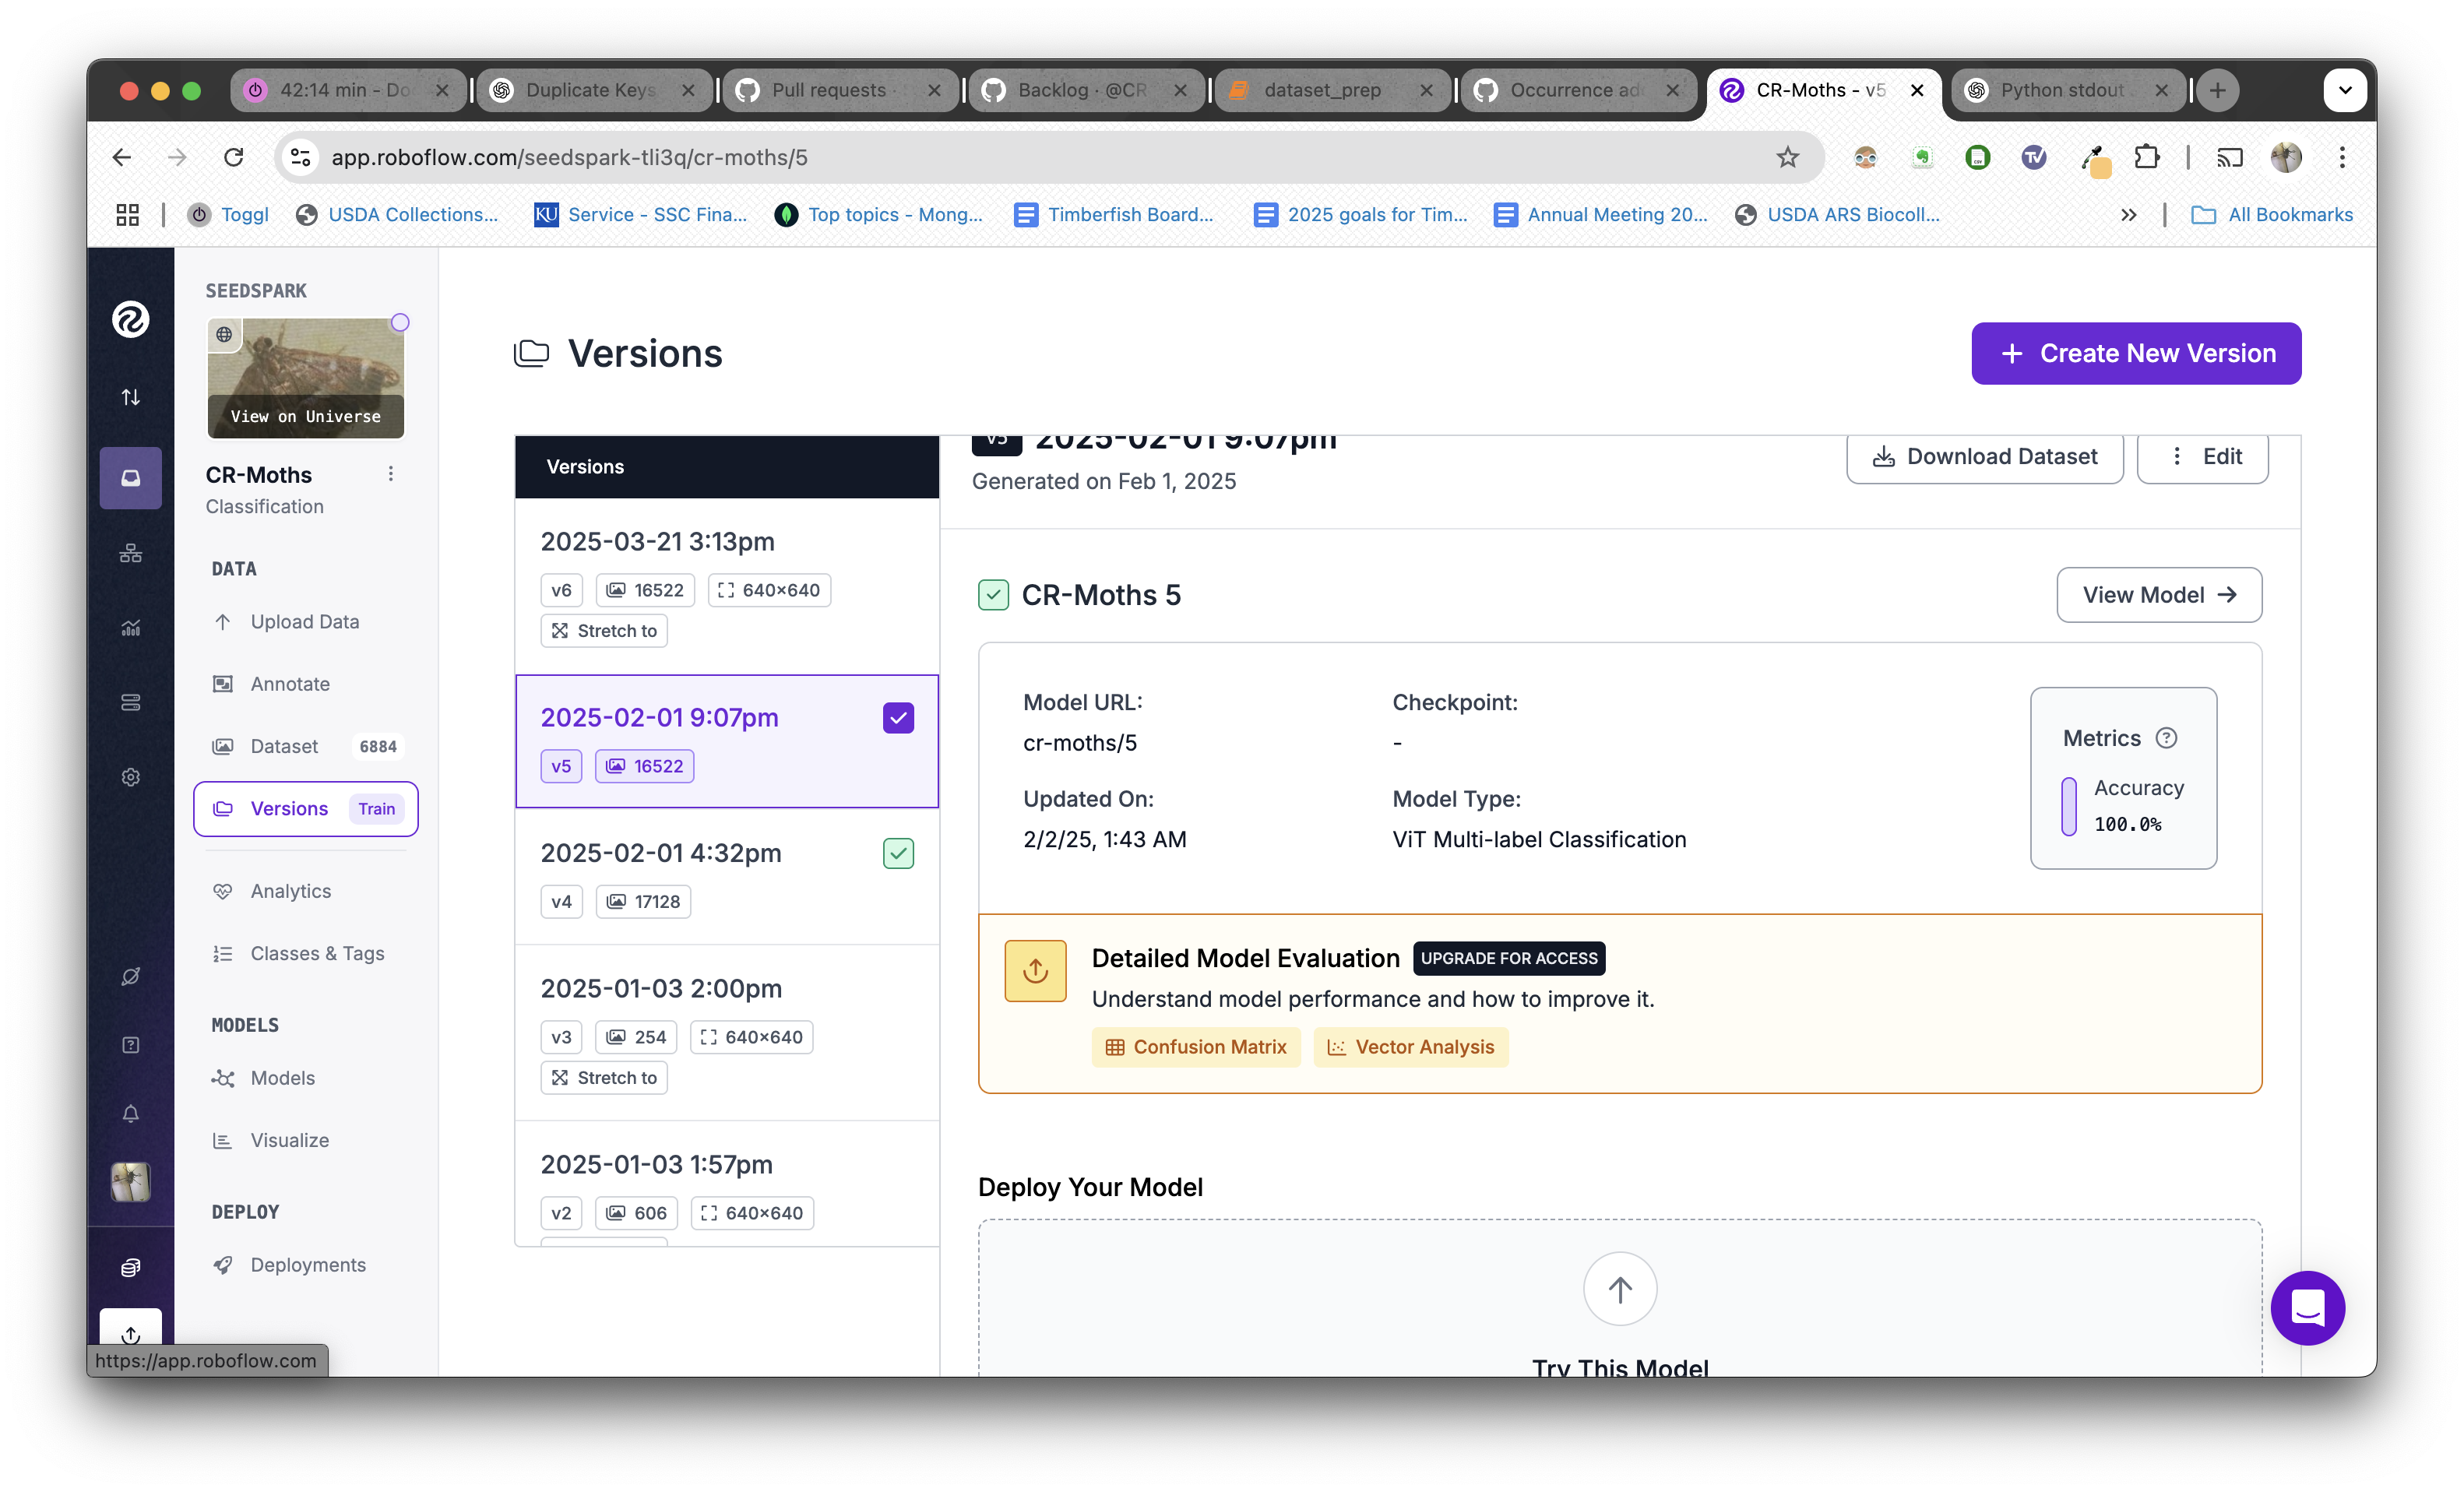

In [12]:
from IPython.display import Image, display

# Path to your PNG image
img_path = "/Users/markfisher/Desktop/cr_moth_classification/2_detection/classifier_screenshot.png"

# Display the image
display(Image(filename=img_path))
